## Downstream Application - inference using fine-tuned BioMed-RoBERTa on PMC & Reddit data sources

### Set up

In [ ]:
''' If using Colab, mount drive
from google.colab import drive
drive.mount('/content/drive') '''

Mounted at /content/drive


In [ ]:
'''  --- Compare F1 scores from the training summaries of experiments: fine-tuned metamap, spacy, biobert and biomed-roberta ---

import pandas as pd


roberta_f1 = roberta_train_summary['f1'].max()
biobert_f1 = biobert_train_summary['f1'].max()
spacy_problem_f1 = spacy_train_summary['f1'].max()
metamap_f1 = metamap_summary['f1-score'].iloc[-1] #weighted avg

comparison_data = {
    'Model': ['RoBERTa', 'BioBERT', 'SpaCy', 'MetaMap'],
    'Highest F1 Score': [roberta_f1, biobert_f1, spacy_problem_f1, metamap_f1]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df) '''

Model  Highest F1 Score
0  RoBERTa          0.834415
1  BioBERT          0.849851
2    SpaCy          0.085594
3  MetaMap          0.820000

In [ ]:
''' Load fine-tuned BioMed-RoBERTA (refer to notebook 4 for guide on fine-tuning) '''

import os
from dotenv import load_dotenv
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForTokenClassification

load_dotenv()
login(token= os.getenv('HUGGINGFACE_TOKEN'))

model = AutoModelForTokenClassification.from_pretrained("choo-c102/ft-roberta-humadex-ner")
tokenizer = AutoTokenizer.from_pretrained("choo-c102/ft-roberta-humadex-ner", add_prefix_space=True)

In [ ]:
label_map = {
    0: "O",
    1: "B-PROBLEM",
    2: "I-PROBLEM",
    3: "E-PROBLEM",
    4: "S-PROBLEM",
    5: "B-TREATMENT",
    6: "I-TREATMENT",
    7: "E-TREATMENT",
    8: "S-TREATMENT",
    9: "B-TEST",
    10: "I-TEST",
    11: "E-TEST",
    12: "S-TEST"
}

from datasets import ClassLabel
label2id = {v: k for k, v in label_map.items()}
id2label = {k: v for k, v in label_map.items()}

In [ ]:
''' Predict entities function '''

def predict_entities(text, model, tokenizer):
    import torch

    # Tokenize with alignment to words
    encoding = tokenizer(
        text.split(),  # split into words, as training used word-level tags
        return_tensors="pt",
        is_split_into_words=True,
        truncation=True,
        padding=True,
        max_length=512
    )

    word_ids = encoding.word_ids(batch_index=0)  # word index per token
    inputs = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)[0].cpu().numpy()

    words = text.split()
    entities = []
    current_tokens = []
    current_label = None
    previous_word_id = None

    for i, word_id in enumerate(word_ids):
        if word_id is None:
            continue  # skip special tokens

        if word_id != previous_word_id:
            label = id2label[predictions[i]]
            word = words[word_id]

            if label.startswith("B-"):
                if current_tokens:
                    entities.append((" ".join(current_tokens), current_label))
                current_tokens = [word]
                current_label = label[2:]

            elif label.startswith("I-") and current_label == label[2:]:
                current_tokens.append(word)

            elif label.startswith("E-") and current_label == label[2:]:
                current_tokens.append(word)
                entities.append((" ".join(current_tokens), current_label))
                current_tokens = []
                current_label = None

            elif label.startswith("S-"):
                if current_tokens:
                    entities.append((" ".join(current_tokens), current_label))
                    current_tokens = []
                entities.append((word, label[2:]))
                current_label = None

            else:  # "O" or wrong label
                if current_tokens:
                    entities.append((" ".join(current_tokens), current_label))
                    current_tokens = []
                    current_label = None

        previous_word_id = word_id

    if current_tokens:
        entities.append((" ".join(current_tokens), current_label))

    return entities


In [ ]:
#Testing
sample_text = "yellow brown or white fluid the eardrum ruptured."
entities = predict_entities(sample_text, model, tokenizer)
print(entities)

[('yellow brown or white fluid', 'PROBLEM'), ('the eardrum', 'PROBLEM'), ('ruptured.', 'PROBLEM')]


In [ ]:
''' Load PMC articles '''

import os
import json
import shutil
from huggingface_hub import snapshot_download


hf_cache_dir = "/root/.cache/huggingface"
shutil.rmtree(hf_cache_dir, ignore_errors=True)

hf_snapshot_dir = snapshot_download(repo_id="choo-c102/pc_pmc_abstract_conclusion", repo_type = "dataset", allow_patterns="*.json")
json_files = []

for root, dirs, files in os.walk(hf_snapshot_dir):
    for file in files:
        if file.endswith(".json"):
            json_files.append(os.path.join(root, file))

### PubMed Entity Extraction & Mapping

In [ ]:
''' Execute extraction of entities from PMC articles with fine-tuned BioMed-RoBERTa '''

import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

records = []

for file in json_files:
  with open(file, 'r', encoding='utf-8') as f:
    data = json.load(f)
    full_text = data['text']
    sentences = sent_tokenize(full_text)

    pmc_article_entities = []
    for sentence in sentences:
      try:
        entities = predict_entities(sentence, model, tokenizer)
        pmc_article_entities.extend(entities)
      except Exception as e:
        print(f"Skiped due to sentence due to error: {e}")

    for entity_text, label in pmc_article_entities:
      records.append({
        "article_id": data['pmcid'],
        "entity": entity_text.lower(),
        "label": label
      })

    pmc_article_entities = []

df = pd.DataFrame(records)
df.to_csv("ner_extracted_entities.csv", index=False)

df['dataset'] = "PMC"
df

article_id                                         entity      label  \
0      PMC11119140                         appropriate treatment.  TREATMENT   
1      PMC11119140                                           pdac    PROBLEM   
2      PMC11119140                         complex symptomatology    PROBLEM   
3      PMC11119140                      psychosocial implications    PROBLEM   
4      PMC11119140  inter-professional supportive care management  TREATMENT   
...            ...                                            ...        ...   
13265  PMC11185363                                a survival rate  TREATMENT   
13266  PMC11185363                           this deadly disease.    PROBLEM   
13267  PMC11185363                                   the analysis       TEST   
13268  PMC11185363                  cytology of pancreatic juice,       TEST   
13269  PMC11185363                                    a technique  TREATMENT   

      dataset  
0         PMC  
1         PMC  
2         PMC  
3         PMC  
4         PMC  
...       ...  
13265     PMC  
13266     PMC  
13267     PMC  
13268     PMC  
13269     PMC  

[13270 rows x 4 columns]

In [ ]:
output_path = '/data/pmc_ner_extracted_roberta.csv' 
#output_path = '/content/drive/MyDrive/pmc_ner_extracted_roberta.csv' 

df.to_csv(output_path, index=False, encoding='utf-8')

print(f"Number of entities extracted: {len(df)}")
print(f"Number of articles: {df['article_id'].nunique()}")

Number of entities extracted: 13270
Number of articles: 254


In [ ]:
''' 
--- If using Colab, use data_table module to view dataframe better ---

from google.colab import data_table
data_table.enable_dataframe_formatter()
df 
'''

In [ ]:
''' Set up UMLS for mapping and MongoDB to store mapped results '''
# --- pip install umls-python-client --- required
# --- UMLS account required (Registration is free) ---

import logging
import os
import sys

from umls_python_client import UMLSClient

# Configure log in
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True
)
logger = logging.getLogger()

# Add API key
API_KEY = os.getenv('UMLS_API')
search_api = UMLSClient(api_key=API_KEY).searchAPI
cui_api = UMLSClient(api_key=API_KEY).cuiAPI

# Connect to MongoDB
from pymongo import MongoClient

uri = os.getenv("MONGO_URI")
client = MongoClient(uri, tls=True)

db = client["umls_concepts_roberta"]
collection = db["entity_results_roberta"]

2025-08-06 01:16:52,740 - INFO - UMLSClient initialized with SearchAPI, SourceAPI, CUIAPI, semanticNetworkAPI and crosswalkAPI


In [ ]:
''' Main entity normalization logic functions '''

from pathlib import Path
import re
import json
import difflib
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Load persistent cache if it exists (to speed up search and save time/power on multiple calls)
CACHE_FILE = "umls_cache.json"
if Path(CACHE_FILE).exists():
    with open(CACHE_FILE, "r", encoding="utf-8") as f:
        entity_cache = json.load(f)
else:
    cache = {}

def get_semantic_types_for_cui(cui):
    try:
        cui_info = cui_api.get_cui_info(cui=cui, save_to_file=False)
        result = cui_info if isinstance(cui_info, dict) else json.loads(cui_info)
        semantic_types = result.get("result", {}).get("semanticTypes", [])
        return [st.get("name") for st in semantic_types]
    except Exception as e:
        print(f"[ERROR] Semantic type lookup failed for CUI {cui}: {e}")
        return []

def is_meaningful_entity(entity):
    tokens = entity.lower().split()
    return any(t not in stop_words for t in tokens) and len(entity) > 3


def clean_entity(entity):
    return re.sub(r'[^\w\s]', '', entity.lower()) #lowercase and remove punctuation for cleaner matching


def search_and_extract(entity):
    entity_clean = clean_entity(entity)

    if entity_clean in cache:
        return cache[entity_clean]

    if not is_meaningful_entity(entity_clean):
        print(f"[SKIPPED] Entity too short or generic: '{entity}'")
        cache[entity_clean] = None
        return None

    try:
        search_result = search_api.search(
            search_string=entity_clean,
            partial_search=True, #enables partial search
            input_type=None,
            include_obsolete=False,
            include_suppressible=False,
            return_id_type="concept",
            search_type="exact",  #exact match
            page_number=1,
            page_size=5,
            save_to_file=False
        )

        try:
            result = search_result if isinstance(search_result, dict) else json.loads(search_result)
            results = result.get("result", {}).get("results", [])
        except (json.JSONDecodeError, AttributeError):
            print(f"[ERROR] Failed to parse response for: '{entity}'")
            cache[entity_clean] = None
            return None

        if not results:
            print(f"[FALLBACK] Retrying with 'words' search for: '{entity}'")
            search_result = search_api.search(
                search_string=entity_clean,
                input_type=None,
                include_obsolete=False,
                include_suppressible=False,
                return_id_type="concept",
                search_type="words",  #falls back to words
                page_number=1,
                page_size=5,
                save_to_file=False
            )

            result = search_result if isinstance(search_result, dict) else json.loads(search_result)
            results = result.get("result", {}).get("results", [])

        if not results:
            unmapped_entities = []
            print(f"[NO MATCH] No UMLS concept for: '{entity}'")
            cache[entity_clean] = None
            unmapped_entities.append(entity)
            return None

        # pick the most similar concept by string similarity
        best = max(
            results,
            key=lambda r: difflib.SequenceMatcher(None, entity_clean, r.get("name", "").lower()).ratio(),
            default=None
        )

        similarity = difflib.SequenceMatcher(None, entity_clean, best.get("name", "").lower()).ratio()

        if similarity < 0.1:
            print(f"[REJECTED] '{entity}' → '{best.get('name')}' (Sim: {similarity:.2f})")
            return None

        cui = best.get("ui")
        semantic_types = get_semantic_types_for_cui(cui)

        doc = {
            "entity": entity,
            "ui": best.get("ui"),
            "name": best.get("name"),
            "rootSource": best.get("rootSource"),
            "semantic_types": semantic_types
        }

        print(f"[MAPPED] '{entity}' → '{doc['name']}' (CUI: {doc['ui']}, Sim: {similarity:.2f}), Types: {semantic_types})") #<---NEW

        result = collection.update_one( #added result =
            {"entity": entity},
            {"$set": doc},
            upsert=True
        )

        cache[entity_clean] = doc
        return doc

    except Exception as e:
        print(f"[ERROR] Failed to search '{entity}': {e}")
        cache[entity_clean] = None
        return None

# --- Entity mapping logic ---
def process_article(file_path, model, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    full_text = data['text']
    pmcid = data['pmcid']
    sentences = sent_tokenize(full_text)

    article_rows = []
    for sentence in sentences:
        try:
            entities = predict_entities(sentence, model, tokenizer)
        except Exception as e:
            print(f"Skipped sentence due to error: {e}")
            continue

        for entity_text, label in entities:
            entity_text_lower = re.sub(r'[^\w\s]', '', entity_text.lower())

            #search, append, and upload
            umls_data = search_and_extract(entity_text_lower) or {}
            article_rows.append({
                "article_id": pmcid,
                "entity": entity_text_lower,
                "label": label,
                "cui": umls_data.get("ui"),
                "preferred_name": umls_data.get("name"),
                "rootSource": umls_data.get("rootSource"),
                "semantic_types": umls_data.get("semantic_types"),
                "dataset":"PMC"
            })

    return article_rows

In [ ]:
''' Execute entity normalization functions on PMC data '''

from pathlib import Path
from tqdm import tqdm

records = []

for file in tqdm(json_files, desc="Processing PMC articles"):
    article_records = process_article(file, model, tokenizer)
    records.extend(article_records)

#Convert to DataFrame
import pandas as pd
df = pd.DataFrame(records)

output_path = '/data/pmc_ner_umls_mapped_roberta.csv'
#output_path = '/content/drive/MyDrive/pmc_ner_umls_mapped_roberta.csv'

df.to_csv(output_path, index=False, encoding='utf-8')
df["dataset"] = "PMC"

df

article_id                             entity      label       cui  \
0      PMC11119140                        appropriate  TREATMENT  C1548787   
1      PMC11119140                               pdac    PROBLEM      None   
2      PMC11119140                            complex    PROBLEM  C0439855   
3      PMC11119140                       psychosocial    PROBLEM  C0542298   
4      PMC11119140  interprofessional supportive care  TREATMENT      None   
...            ...                                ...        ...       ...   
13265  PMC11185363                         a survival  TREATMENT  C0007620   
13266  PMC11185363                        this deadly    PROBLEM      None   
13267  PMC11185363                                the       TEST      None   
13268  PMC11185363             cytology of pancreatic       TEST  C0400768   
13269  PMC11185363                                  a  TREATMENT      None   

                                  preferred_name   rootSource  \
0                                    Appropriate      HL7V2.5   
1                                           None         None   
2                                        Complex          MTH   
3                                   Psychosocial          MTH   
4                                           None         None   
...                                          ...          ...   
13265                              Cell Survival          MSH   
13266                                       None         None   
13267                                       None         None   
13268  Brush biopsy of bile and pancreatic ducts  SNOMEDCT_US   
13269                                       None         None   

               semantic_types dataset  
0       [Qualitative Concept]     PMC  
1                        None     PMC  
2       [Qualitative Concept]     PMC  
3        [Functional Concept]     PMC  
4                        None     PMC  
...                       ...     ...  
13265         [Cell Function]     PMC  
13266                    None     PMC  
13267                    None     PMC  
13268  [Diagnostic Procedure]     PMC  
13269                    None     PMC  

[13270 rows x 8 columns]

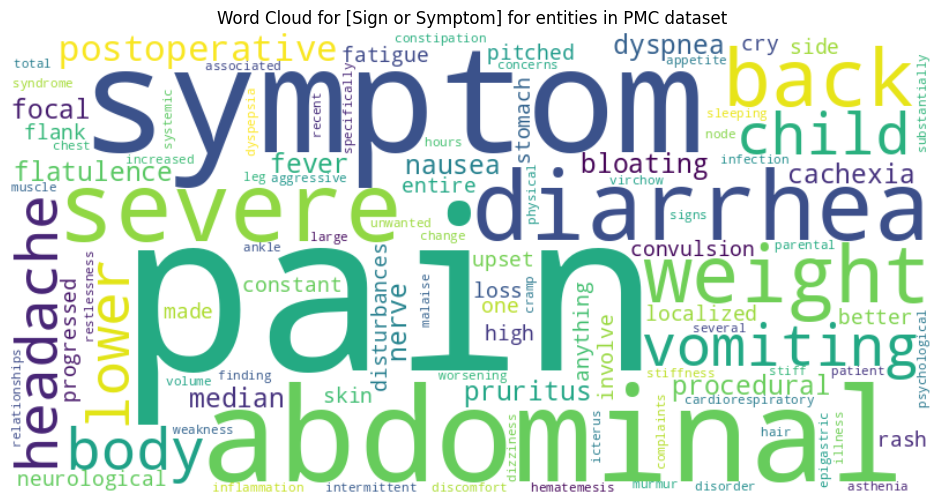

In [ ]:
''' Wordcloud for Problem entities - filter by semantic types [sign or symptom] '''

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Drop rows where entities that were not mapped
df_clean = df.dropna(subset=['preferred_name'])

sign_symptom_df = df_clean[df_clean['semantic_types'].apply(lambda types: 'Sign or Symptom' in types)]
names = sign_symptom_df['preferred_name']

#create on long string
symptom_names = names.str.lower()

#drop commonly appearing words/duplicate words
words_to_drop = {'symptoms', 'symptom'}
filtered = symptom_names[~symptom_names.isin(words_to_drop)]

#drop duplicates
filtered_unique = filtered.drop_duplicates().reset_index(drop=True)

#create on long string
text = ' '.join(filtered_unique.astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for [Sign or Symptom] for entities in PMC dataset')
plt.show()

# Reddit

## Set Up

In [ ]:
''' Connect to MongoDB and download scrapped Reddit data from Hugging Face '''
from datasets import load_dataset
from pymongo import MongoClient

db = client["umls_concepts_roberta"]
collection = db["entity_results_reddit"]

ds = load_dataset("choo-c102/rpancreatic_cancer_symptoms")

pancreatic_cancer_data_filtered.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/8092 [00:00<?, ? examples/s]

In [ ]:
# Clean text

import emoji
import re
from bs4 import BeautifulSoup
import html

def clean_text(text):
  text = emoji.demojize(text)
  text = BeautifulSoup(text, 'html.parser').get_text()
  text = re.sub(r"http\S+|www\S+", "", text)
  text = re.sub(r"@\w+", "", text)
  text = re.sub(r"#", "", text)
  text = text.replace("’", "'").replace("‘", "'")
  text = text.replace("“", '"').replace("”", '"')
  text = text.replace("–", "-").replace("—", "-")
  text = re.sub(r'\s+', ' ', text).strip()
  text = html.unescape(text) #changes html characters (&lt or &gt) to (< or >)

  return text

ds_cleaned = ds['train'].map(lambda example: {"Text": clean_text(example["Text"])})


Map:   0%|          | 0/8092 [00:00<?, ? examples/s]

/tmp/ipython-input-2854916683.py:11: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, 'html.parser').get_text()


In [ ]:
''' Define and execute entity extraction logic '''

import nltk
from tqdm import tqdm
import pandas as pd
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

def predict_entities(text, model, tokenizer):
    import torch

    # Tokenize with alignment to words
    encoding = tokenizer(
        text.split(),  # split into words, as training used word-level tags
        return_tensors="pt",
        is_split_into_words=True,
        truncation=True,
        padding=True,
        max_length=512
    )

    word_ids = encoding.word_ids(batch_index=0)  # word index per token
    inputs = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)[0].cpu().numpy()

    words = text.split()
    entities = []
    current_tokens = []
    current_label = None
    previous_word_id = None

    for i, word_id in enumerate(word_ids):
        if word_id is None:
            continue  # skip special tokens

        if word_id != previous_word_id:
            label = id2label[predictions[i]]
            word = words[word_id]

            if label.startswith("B-"):
                if current_tokens:
                    entities.append((" ".join(current_tokens), current_label))
                current_tokens = [word]
                current_label = label[2:]

            elif label.startswith("I-") and current_label == label[2:]:
                current_tokens.append(word)

            elif label.startswith("E-") and current_label == label[2:]:
                current_tokens.append(word)
                entities.append((" ".join(current_tokens), current_label))
                current_tokens = []
                current_label = None

            elif label.startswith("S-"):
                if current_tokens:
                    entities.append((" ".join(current_tokens), current_label))
                    current_tokens = []
                entities.append((word, label[2:]))
                current_label = None

            else:  # "O" or wrong label
                if current_tokens:
                    entities.append((" ".join(current_tokens), current_label))
                    current_tokens = []
                    current_label = None

        previous_word_id = word_id

    if current_tokens:
        entities.append((" ".join(current_tokens), current_label))

    return entities

records = []

for i, sample in enumerate(tqdm(ds_cleaned, desc="Processing Reddit posts")):
    full_text = sample['Text']
    post_id = sample['Post_id']

    sentences = sent_tokenize(full_text)

    reddit_entities = []
    for sentence in sentences:
        try:
            entities = predict_entities(sentence, model, tokenizer)
            reddit_entities.extend(entities)
        except Exception as e:
            print(f"Skipped sentence due to error: {e}")

    for entity_text, label in reddit_entities:
        records.append({
            "post_id": post_id,
            "entity": entity_text.lower(),
            "label": label,
            "dataset": "Reddit"
        })

r_df = pd.DataFrame(records)
r_df.to_csv('/content/drive/MyDrive/reddit_ner_v2_roberta.csv', index=False)
r_df

Processing Reddit posts:   0%|          | 0/8092 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Processing Reddit posts: 100%|██████████| 8092/8092 [23:44<00:00,  5.68it/s]


post_id                           entity      label dataset
0      1bom69c                         symptoms    PROBLEM  Reddit
1      1bom69c   stomach or digestive problems.    PROBLEM  Reddit
2      1bom69c               pancreatic cancer.    PROBLEM  Reddit
3      1bom69c                   stomach issues    PROBLEM  Reddit
4      1bom69c                       an antacid  TREATMENT  Reddit
...        ...                              ...        ...     ...
38399  1idp81z  transmitting pain to the brain.    PROBLEM  Reddit
38400  1idp81z                    a specialist.  TREATMENT  Reddit
38401  1idp81z                            darn.       TEST  Reddit
38402  1idp81z                   the procedure?  TREATMENT  Reddit
38403  1idp81z                                !    PROBLEM  Reddit

[38404 rows x 4 columns]

In [ ]:
print(f"{len(r_df)} entities extracted from {len(ds_cleaned)} Reddit posts.")

38404 entities extracted from 8092 Reddit posts.


In [ ]:
''' Mapping logic and execution '''

reddit_df = r_df

# Create collection to store mapped results
db = client["umls_concepts_roberta"]
collection = db["reddit_entity_results_roberta_v2"]

def get_semantic_types_for_cui(cui):
    try:
        cui_info = cui_api.get_cui_info(cui=cui, save_to_file=False)
        result = cui_info if isinstance(cui_info, dict) else json.loads(cui_info)
        semantic_types = result.get("result", {}).get("semanticTypes", [])
        return [st.get("name") for st in semantic_types]
    except Exception as e:
        print(f"[ERROR] Semantic type lookup failed for CUI {cui}: {e}")
        return []

def map_upload(entity):
    #check cache first
    if entity in cache:
        cached_doc = cache[entity]
        if cached_doc is not None:
            collection.update_one({"entity": entity}, {"$set": cached_doc}, upsert=True)
            return cached_doc
        else:
            doc_none = {
                "entity": entity,
                "ui": None,
                "name": None,
                "rootSource": None,
                "semantic_types": None,
                "dataset": "Reddit"
            }
            collection.update_one({"entity": entity}, {"$set": doc_none}, upsert=True)
            return doc_none

    # First-time entity: Try exact search
    try:
        search_result = search_api.search(
            search_string=entity,
            partial_search=True,
            input_type=None,
            include_obsolete=False,
            include_suppressible=False,
            return_id_type="concept",
            search_type="exact",
            page_number=1,
            page_size=5,
            save_to_file=False
        )

        result = search_result if isinstance(search_result, dict) else json.loads(search_result)
        results = result.get("result", {}).get("results", [])

        # Fallback to 'words' search
        if not results:
            print(f"[FALLBACK] Retrying with 'words' search for: '{entity}'")
            search_result = search_api.search(
                search_string=entity,
                input_type=None,
                include_obsolete=False,
                include_suppressible=False,
                return_id_type="concept",
                search_type="words",
                page_number=1,
                page_size=5,
                save_to_file=False
            )
            result = search_result if isinstance(search_result, dict) else json.loads(search_result)
            results = result.get("result", {}).get("results", [])

        #If all not matched
        if not results:
            print(f"[NO MATCH] No UMLS concept for: '{entity}'")
            doc_none = {
                "entity": entity,
                "ui": None,
                "name": None,
                "rootSource": None,
                "semantic_types": None,
                "dataset": "PMC"
            }
            collection.update_one({"entity": entity}, {"$set": doc_none}, upsert=True)
            cache[entity] = None
            return doc_none

        #Check for similarity if match found
        best = max(
            results,
            key=lambda r: difflib.SequenceMatcher(None, entity, r.get("name", "").lower()).ratio(),
            default=None
        )
        similarity = difflib.SequenceMatcher(None, entity, best.get("name", "").lower()).ratio()

        #if match found but similarity < 0.1
        if similarity < 0.1:
            print(f"[REJECTED] '{entity}' → '{best.get('name')}' (Sim: {similarity:.2f})")
            doc_none = {
                "entity": entity,
                "ui": None,
                "name": None,
                "rootSource": None,
                "semantic_types": None,
                "dataset": "PMC"
            }
            collection.update_one({"entity": entity}, {"$set": doc_none}, upsert=True)
            cache[entity] = None
            return doc_none

        # Succesful match!
        cui = best.get("ui")
        semantic_types = get_semantic_types_for_cui(cui)

        doc = {
            "entity": entity,
            "ui": best.get("ui"),
            "name": best.get("name"),
            "rootSource": best.get("rootSource"),
            "semantic_types": semantic_types,
            "dataset": "PMC"
        }

        collection.update_one({"entity": entity}, {"$set": doc}, upsert=True)
        cache[entity] = doc
        return doc

    except Exception as e:
        print(f"[ERROR] Failed to search '{entity}': {e}")
        doc_none = {
            "entity": entity,
            "ui": None,
            "name": None,
            "rootSource": None,
            "semantic_types": None,
            "dataset": "PMC"
        }
        collection.update_one({"entity": entity}, {"$set": doc_none}, upsert=True)
        cache[entity] = None
        return doc_none


def process_entity(dataset):
  dataset['cui'] = ''
  dataset['preferred_name'] = ''
  dataset['rootSource'] = ''
  dataset['semantic_types'] = ''

  for i, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Processing Entities"):
      entity_text = row["entity"]
      umls_data = map_upload(entity_text)

      if umls_data is not None:
          dataset.at[i, 'cui'] = umls_data.get("ui")
          dataset.at[i, 'preferred_name'] = umls_data.get("name")
          dataset.at[i, 'rootSource'] = umls_data.get("rootSource")

          semantic_types = umls_data.get("semantic_types")

          if isinstance(semantic_types, list):
              dataset.at[i, 'semantic_types'] = ', '.join(str(st) for st in semantic_types)
          else:
              dataset.at[i, 'semantic_types'] = None
      else:
          dataset.at[i, 'cui'] = None
          dataset.at[i, 'preferred_name'] = None
          dataset.at[i, 'rootSource'] = None
          dataset.at[i, 'semantic_types'] = None

  return dataset

def clean_entity(entity):
    entity = str(entity) if entity is not None else ''
    return re.sub(r'[^\w\s]', '', entity.lower())

reddit_df['entity'] = reddit_df['entity'].apply(clean_entity)

reddit_entity_mapped_df = process_entity(reddit_df)
reddit_entity_mapped_df.to_csv('/content/drive/MyDrive/reddit_entity_mapped_roberta_v2.csv', index=False)
reddit_entity_mapped_df

Processing Entities:   8%|▊         | 3168/38404 [09:05<1:42:12,  5.75it/s]2025-08-07 15:23:06,786 - INFO - Searching UMLS with parameters: {'string': 'another blood draw', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:07,132 - INFO - Searching UMLS with parameters: {'string': 'another blood draw', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another blood draw'


Processing Entities:   8%|▊         | 3169/38404 [09:06<3:41:12,  2.65it/s]2025-08-07 15:23:07,635 - INFO - Searching UMLS with parameters: {'string': 'my lipis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'another blood draw'


2025-08-07 15:23:07,976 - INFO - Searching UMLS with parameters: {'string': 'my lipis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my lipis'


Processing Entities:   8%|▊         | 3170/38404 [09:07<5:00:07,  1.96it/s]2025-08-07 15:23:08,460 - INFO - Searching UMLS with parameters: {'string': 'my sugar levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my lipis'


2025-08-07 15:23:08,796 - INFO - Searching UMLS with parameters: {'string': 'my sugar levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my sugar levels'


Processing Entities:   8%|▊         | 3171/38404 [09:07<5:54:24,  1.66it/s]

[NO MATCH] No UMLS concept for: 'my sugar levels'


Processing Entities:   8%|▊         | 3172/38404 [09:08<4:38:05,  2.11it/s]2025-08-07 15:23:09,450 - INFO - Searching UMLS with parameters: {'string': 'some bun test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:09,786 - INFO - Searching UMLS with parameters: {'string': 'some bun test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some bun test'


Processing Entities:   8%|▊         | 3173/38404 [09:08<5:43:24,  1.71it/s]

[NO MATCH] No UMLS concept for: 'some bun test'


Processing Entities:   8%|▊         | 3174/38404 [09:09<4:30:28,  2.17it/s]2025-08-07 15:23:10,465 - INFO - Searching UMLS with parameters: {'string': 'a weird lump', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:10,789 - INFO - Searching UMLS with parameters: {'string': 'a weird lump', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a weird lump'


Processing Entities:   8%|▊         | 3175/38404 [09:09<5:36:29,  1.74it/s]

[NO MATCH] No UMLS concept for: 'a weird lump'


Processing Entities:   8%|▊         | 3176/38404 [09:10<4:26:07,  2.21it/s]2025-08-07 15:23:11,474 - INFO - Searching UMLS with parameters: {'string': 'sending hugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:11,820 - INFO - Searching UMLS with parameters: {'string': 'sending hugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sending hugs'


Processing Entities:   8%|▊         | 3177/38404 [09:10<5:33:54,  1.76it/s]2025-08-07 15:23:12,312 - INFO - Searching UMLS with parameters: {'string': 'changed account', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'sending hugs'


2025-08-07 15:23:12,645 - INFO - Searching UMLS with parameters: {'string': 'changed account', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'changed account'


2025-08-07 15:23:13,332 - INFO - Fetching CUI concept: C1548013
Processing Entities:   8%|▊         | 3182/38404 [09:12<3:02:28,  3.22it/s]2025-08-07 15:23:14,187 - INFO - Searching UMLS with parameters: {'string': 'any terminal illness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:14,529 - INFO - Searching UMLS with parameters: {'string': 'any terminal illness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any terminal illness'


Processing Entities:   8%|▊         | 3183/38404 [09:13<4:34:56,  2.14it/s]

[NO MATCH] No UMLS concept for: 'any terminal illness'


Processing Entities:   8%|▊         | 3185/38404 [09:14<3:05:39,  3.16it/s]2025-08-07 15:23:15,363 - INFO - Searching UMLS with parameters: {'string': 'sharp shooting pains in my left back area', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:15,686 - INFO - Searching UMLS with parameters: {'string': 'sharp shooting pains in my left back area', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sharp shooting pains in my left back area'


Processing Entities:   8%|▊         | 3186/38404 [09:14<4:36:36,  2.12it/s]

[NO MATCH] No UMLS concept for: 'sharp shooting pains in my left back area'


Processing Entities:   8%|▊         | 3187/38404 [09:15<3:43:49,  2.62it/s]2025-08-07 15:23:16,367 - INFO - Searching UMLS with parameters: {'string': 'left abdominal pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:16,690 - INFO - Searching UMLS with parameters: {'string': 'left abdominal pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'left abdominal pains'


2025-08-07 15:23:17,360 - INFO - Fetching CUI concept: C0563276
Processing Entities:   8%|▊         | 3188/38404 [09:16<6:02:14,  1.62it/s]2025-08-07 15:23:17,535 - INFO - Searching UMLS with parameters: {'string': 'itching', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:18,203 - INFO - Fetching CUI concept: C0033774
Processing Entities:   8%|▊         | 3189/38404 [09:17<6:42:15,  1.46it/s]2025-08-07 15:23:18,379 - INFO - Searching UMLS with parameters: {'string': 'oily water in stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:18,721 - INFO - Searching UMLS with parameters: {'string': 'oily water in stools', '

[FALLBACK] Retrying with 'words' search for: 'oily water in stools'


Processing Entities:   8%|▊         | 3190/38404 [09:17<7:10:17,  1.36it/s]

[NO MATCH] No UMLS concept for: 'oily water in stools'


Processing Entities:   8%|▊         | 3193/38404 [09:18<3:33:04,  2.75it/s]2025-08-07 15:23:19,733 - INFO - Searching UMLS with parameters: {'string': 'the fall', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:20,046 - INFO - Searching UMLS with parameters: {'string': 'the fall', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the fall'


2025-08-07 15:23:20,745 - INFO - Fetching CUI concept: C0085639
Processing Entities:   8%|▊         | 3195/38404 [09:19<4:41:04,  2.09it/s]2025-08-07 15:23:21,094 - INFO - Searching UMLS with parameters: {'string': 'real concerns', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:21,425 - INFO - Searching UMLS with parameters: {'string': 'real concerns', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'real concerns'


Processing Entities:   8%|▊         | 3196/38404 [09:20<5:43:33,  1.71it/s]2025-08-07 15:23:21,928 - INFO - Searching UMLS with parameters: {'string': 'caught', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'real concerns'


2025-08-07 15:23:22,249 - INFO - Searching UMLS with parameters: {'string': 'caught', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'caught'


2025-08-07 15:23:22,918 - INFO - Fetching CUI concept: C4524113
Processing Entities:   8%|▊         | 3198/38404 [09:21<5:41:48,  1.72it/s]2025-08-07 15:23:23,263 - INFO - Searching UMLS with parameters: {'string': 'any status', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:23,928 - INFO - Fetching CUI concept: C1549503
Processing Entities:   8%|▊         | 3199/38404 [09:22<6:26:57,  1.52it/s]2025-08-07 15:23:24,102 - INFO - Searching UMLS with parameters: {'string': 'gotcha', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:24,428 - INFO - Searching UMLS with parameters: {'string': 'gotcha', 'includeObsolete': 'false'

[FALLBACK] Retrying with 'words' search for: 'gotcha'


Processing Entities:   8%|▊         | 3200/38404 [09:23<6:56:23,  1.41it/s]

[NO MATCH] No UMLS concept for: 'gotcha'


Processing Entities:   8%|▊         | 3201/38404 [09:23<5:21:23,  1.83it/s]2025-08-07 15:23:25,099 - INFO - Searching UMLS with parameters: {'string': 'many issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:25,424 - INFO - Searching UMLS with parameters: {'string': 'many issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many issues'


Processing Entities:   8%|▊         | 3202/38404 [09:24<6:11:58,  1.58it/s]2025-08-07 15:23:25,934 - INFO - Searching UMLS with parameters: {'string': 'even cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'many issues'


2025-08-07 15:23:26,260 - INFO - Searching UMLS with parameters: {'string': 'even cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'even cancer'


2025-08-07 15:23:26,911 - INFO - Fetching CUI concept: C5446914
Processing Entities:   8%|▊         | 3205/38404 [09:26<4:38:46,  2.10it/s]2025-08-07 15:23:27,438 - INFO - Searching UMLS with parameters: {'string': 'some thickening of the colon wall and my duodenum', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:27,763 - INFO - Searching UMLS with parameters: {'string': 'some thickening of the colon wall and my duodenum', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some thickening of the colon wall and my duodenum'


Processing Entities:   8%|▊         | 3206/38404 [09:26<5:39:18,  1.73it/s]2025-08-07 15:23:28,257 - INFO - Searching UMLS with parameters: {'string': 'inflammation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some thickening of the colon wall and my duodenum'


2025-08-07 15:23:28,925 - INFO - Fetching CUI concept: C0021368
Processing Entities:   8%|▊         | 3209/38404 [09:28<4:00:04,  2.44it/s]2025-08-07 15:23:29,441 - INFO - Searching UMLS with parameters: {'string': 'colnoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:29,765 - INFO - Searching UMLS with parameters: {'string': 'colnoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'colnoscopy'


Processing Entities:   8%|▊         | 3210/38404 [09:28<5:17:04,  1.85it/s]

[NO MATCH] No UMLS concept for: 'colnoscopy'


Processing Entities:   8%|▊         | 3213/38404 [09:29<2:54:22,  3.36it/s]2025-08-07 15:23:30,799 - INFO - Searching UMLS with parameters: {'string': 'my posture sucks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:31,132 - INFO - Searching UMLS with parameters: {'string': 'my posture sucks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my posture sucks'


Processing Entities:   8%|▊         | 3214/38404 [09:30<4:31:02,  2.16it/s]2025-08-07 15:23:31,646 - INFO - Searching UMLS with parameters: {'string': 'a bit of background', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my posture sucks'


2025-08-07 15:23:31,976 - INFO - Searching UMLS with parameters: {'string': 'a bit of background', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bit of background'


Processing Entities:   8%|▊         | 3215/38404 [09:31<5:38:32,  1.73it/s]

[NO MATCH] No UMLS concept for: 'a bit of background'


Processing Entities:   8%|▊         | 3217/38404 [09:31<3:36:42,  2.71it/s]2025-08-07 15:23:32,831 - INFO - Searching UMLS with parameters: {'string': 'bizarre digestive issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:33,171 - INFO - Searching UMLS with parameters: {'string': 'bizarre digestive issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bizarre digestive issues'


Processing Entities:   8%|▊         | 3218/38404 [09:32<5:00:06,  1.95it/s]2025-08-07 15:23:33,675 - INFO - Searching UMLS with parameters: {'string': 'constant stomach gurgling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'bizarre digestive issues'


2025-08-07 15:23:33,995 - INFO - Searching UMLS with parameters: {'string': 'constant stomach gurgling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'constant stomach gurgling'


Processing Entities:   8%|▊         | 3219/38404 [09:33<5:57:21,  1.64it/s]2025-08-07 15:23:34,512 - INFO - Searching UMLS with parameters: {'string': 'major loss of appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'constant stomach gurgling'


2025-08-07 15:23:34,835 - INFO - Searching UMLS with parameters: {'string': 'major loss of appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'major loss of appetite'


Processing Entities:   8%|▊         | 3220/38404 [09:33<6:32:00,  1.50it/s]2025-08-07 15:23:35,318 - INFO - Searching UMLS with parameters: {'string': 'some weight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'major loss of appetite'


2025-08-07 15:23:35,648 - INFO - Searching UMLS with parameters: {'string': 'some weight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some weight'


Processing Entities:   8%|▊         | 3221/38404 [09:34<7:00:01,  1.40it/s]2025-08-07 15:23:36,146 - INFO - Searching UMLS with parameters: {'string': 'pain on the left side of upper abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some weight'


2025-08-07 15:23:36,480 - INFO - Searching UMLS with parameters: {'string': 'pain on the left side of upper abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pain on the left side of upper abdomen'


Processing Entities:   8%|▊         | 3222/38404 [09:35<7:22:25,  1.33it/s]2025-08-07 15:23:36,990 - INFO - Searching UMLS with parameters: {'string': 'trouble sleeping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pain on the left side of upper abdomen'


2025-08-07 15:23:37,656 - INFO - Fetching CUI concept: C3641752
Processing Entities:   8%|▊         | 3223/38404 [09:36<7:37:44,  1.28it/s]2025-08-07 15:23:37,832 - INFO - Searching UMLS with parameters: {'string': 'daily', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:38,494 - INFO - Fetching CUI concept: C0332173
Processing Entities:   8%|▊         | 3224/38404 [09:37<7:47:38,  1.25it/s]2025-08-07 15:23:38,669 - INFO - Searching UMLS with parameters: {'string': 'intense fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:38,994 - INFO - Searching UMLS with parameters: {'string': 'intense fatigue', 'includeObsol

[FALLBACK] Retrying with 'words' search for: 'intense fatigue'


2025-08-07 15:23:39,645 - INFO - Fetching CUI concept: C3463815
Processing Entities:   8%|▊         | 3225/38404 [09:38<8:49:46,  1.11it/s]2025-08-07 15:23:39,820 - INFO - Searching UMLS with parameters: {'string': 'prediabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:40,470 - INFO - Fetching CUI concept: C0362046
Processing Entities:   8%|▊         | 3226/38404 [09:39<8:35:55,  1.14it/s]2025-08-07 15:23:40,644 - INFO - Searching UMLS with parameters: {'string': 'a ct without contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:40,971 - INFO - Searching UMLS with parameters: {'string': 'a ct without contra

[FALLBACK] Retrying with 'words' search for: 'a ct without contrast'


2025-08-07 15:23:41,672 - INFO - Fetching CUI concept: C1275400
Processing Entities:   8%|▊         | 3227/38404 [09:40<9:32:37,  1.02it/s]2025-08-07 15:23:41,847 - INFO - Searching UMLS with parameters: {'string': 'abdominal us', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:42,179 - INFO - Searching UMLS with parameters: {'string': 'abdominal us', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'abdominal us'


2025-08-07 15:23:42,861 - INFO - Fetching CUI concept: C1626904
Processing Entities:   8%|▊         | 3228/38404 [09:41<10:09:58,  1.04s/it]2025-08-07 15:23:43,036 - INFO - Searching UMLS with parameters: {'string': 'all bloodwork', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:43,368 - INFO - Searching UMLS with parameters: {'string': 'all bloodwork', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all bloodwork'


Processing Entities:   8%|▊         | 3229/38404 [09:42<9:33:21,  1.02it/s] 2025-08-07 15:23:43,868 - INFO - Searching UMLS with parameters: {'string': 'gastritisulcergerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'all bloodwork'


2025-08-07 15:23:44,189 - INFO - Searching UMLS with parameters: {'string': 'gastritisulcergerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gastritisulcergerd'


Processing Entities:   8%|▊         | 3230/38404 [09:43<9:07:10,  1.07it/s]2025-08-07 15:23:44,698 - INFO - Searching UMLS with parameters: {'string': 'something', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gastritisulcergerd'


2025-08-07 15:23:45,018 - INFO - Searching UMLS with parameters: {'string': 'something', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'something'


2025-08-07 15:23:45,655 - INFO - Fetching CUI concept: C3843412
Processing Entities:   8%|▊         | 3232/38404 [09:44<7:17:18,  1.34it/s]2025-08-07 15:23:45,999 - INFO - Searching UMLS with parameters: {'string': 'a study', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:46,311 - INFO - Searching UMLS with parameters: {'string': 'a study', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a study'


2025-08-07 15:23:47,032 - INFO - Fetching CUI concept: C2603343
Processing Entities:   8%|▊         | 3233/38404 [09:45<8:38:19,  1.13it/s]2025-08-07 15:23:47,206 - INFO - Searching UMLS with parameters: {'string': 'initial imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:47,526 - INFO - Searching UMLS with parameters: {'string': 'initial imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'initial imaging'


2025-08-07 15:23:48,200 - INFO - Fetching CUI concept: C5389253
Processing Entities:   8%|▊         | 3235/38404 [09:47<7:07:37,  1.37it/s]2025-08-07 15:23:48,544 - INFO - Searching UMLS with parameters: {'string': 'us', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:49,209 - INFO - Fetching CUI concept: C0041703
Processing Entities:   8%|▊         | 3236/38404 [09:48<7:27:04,  1.31it/s]2025-08-07 15:23:49,384 - INFO - Searching UMLS with parameters: {'string': 'irrational', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:50,041 - INFO - Fetching CUI concept: C0542058
Processing Entities:   8%|▊         | 3237/38404 [09

[FALLBACK] Retrying with 'words' search for: 'your time'


2025-08-07 15:23:51,190 - INFO - Fetching CUI concept: C3258421
Processing Entities:   8%|▊         | 3238/38404 [09:50<8:43:15,  1.12it/s]2025-08-07 15:23:51,364 - INFO - Searching UMLS with parameters: {'string': 'a genetic risk assessment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:51,689 - INFO - Searching UMLS with parameters: {'string': 'a genetic risk assessment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a genetic risk assessment'


2025-08-07 15:23:52,355 - INFO - Fetching CUI concept: C0886412
Processing Entities:   8%|▊         | 3241/38404 [09:51<5:30:48,  1.77it/s]2025-08-07 15:23:52,870 - INFO - Searching UMLS with parameters: {'string': 'my pancreatic tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:53,191 - INFO - Searching UMLS with parameters: {'string': 'my pancreatic tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my pancreatic tumor'


Processing Entities:   8%|▊         | 3242/38404 [09:52<6:14:43,  1.56it/s]

[NO MATCH] No UMLS concept for: 'my pancreatic tumor'


Processing Entities:   8%|▊         | 3245/38404 [09:52<3:14:33,  3.01it/s]2025-08-07 15:23:54,198 - INFO - Searching UMLS with parameters: {'string': 'your blood work', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:54,519 - INFO - Searching UMLS with parameters: {'string': 'your blood work', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your blood work'


Processing Entities:   8%|▊         | 3246/38404 [09:53<4:39:53,  2.09it/s]2025-08-07 15:23:55,016 - INFO - Searching UMLS with parameters: {'string': 'your physical symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your blood work'


2025-08-07 15:23:55,349 - INFO - Searching UMLS with parameters: {'string': 'your physical symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your physical symptoms'


2025-08-07 15:23:56,009 - INFO - Fetching CUI concept: C5204401
Processing Entities:   8%|▊         | 3250/38404 [09:55<3:23:19,  2.88it/s]2025-08-07 15:23:56,695 - INFO - Searching UMLS with parameters: {'string': 'metastatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:57,348 - INFO - Fetching CUI concept: C0036525
Processing Entities:   8%|▊         | 3252/38404 [09:56<3:51:11,  2.53it/s]2025-08-07 15:23:57,692 - INFO - Searching UMLS with parameters: {'string': 'that', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:58,017 - INFO - Searching UMLS with parameters: {'string': 'that', 'includeObsolete': 'false', 'i

[FALLBACK] Retrying with 'words' search for: 'that'


2025-08-07 15:23:58,691 - INFO - Fetching CUI concept: C3843798
Processing Entities:   8%|▊         | 3254/38404 [09:57<4:47:43,  2.04it/s]2025-08-07 15:23:59,037 - INFO - Searching UMLS with parameters: {'string': 'additional screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:23:59,372 - INFO - Searching UMLS with parameters: {'string': 'additional screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'additional screening'


2025-08-07 15:24:00,127 - INFO - Fetching CUI concept: C3860196
Processing Entities:   8%|▊         | 3255/38404 [09:58<7:03:45,  1.38it/s]2025-08-07 15:24:00,302 - INFO - Searching UMLS with parameters: {'string': 'your tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:00,628 - INFO - Searching UMLS with parameters: {'string': 'your tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your tests'


2025-08-07 15:24:01,294 - INFO - Fetching CUI concept: C4706295
Processing Entities:   8%|▊         | 3258/38404 [10:00<4:58:27,  1.96it/s]2025-08-07 15:24:01,819 - INFO - Searching UMLS with parameters: {'string': 'an infallible timeline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:02,143 - INFO - Searching UMLS with parameters: {'string': 'an infallible timeline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an infallible timeline'


Processing Entities:   8%|▊         | 3259/38404 [10:01<5:55:42,  1.65it/s]

[NO MATCH] No UMLS concept for: 'an infallible timeline'


Processing Entities:   8%|▊         | 3260/38404 [10:01<4:38:50,  2.10it/s]2025-08-07 15:24:02,825 - INFO - Searching UMLS with parameters: {'string': 'a program', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:03,159 - INFO - Searching UMLS with parameters: {'string': 'a program', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a program'


2025-08-07 15:24:03,867 - INFO - Fetching CUI concept: C2728259
Processing Entities:   8%|▊         | 3261/38404 [10:02<6:49:02,  1.43it/s]2025-08-07 15:24:04,042 - INFO - Searching UMLS with parameters: {'string': 'dana farber', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:04,368 - INFO - Searching UMLS with parameters: {'string': 'dana farber', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'dana farber'


2025-08-07 15:24:05,048 - INFO - Fetching CUI concept: C5447702
Processing Entities:   8%|▊         | 3263/38404 [10:04<6:15:40,  1.56it/s]2025-08-07 15:24:05,394 - INFO - Searching UMLS with parameters: {'string': 'a side branch intraductal papillary mucinous neoplasms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:05,715 - INFO - Searching UMLS with parameters: {'string': 'a side branch intraductal papillary mucinous neoplasms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a side branch intraductal papillary mucinous neoplasms'


2025-08-07 15:24:06,367 - INFO - Fetching CUI concept: C3826890
Processing Entities:   8%|▊         | 3264/38404 [10:05<7:44:37,  1.26it/s]2025-08-07 15:24:06,542 - INFO - Searching UMLS with parameters: {'string': 'ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:07,222 - INFO - Fetching CUI concept: C1335304
Processing Entities:   9%|▊         | 3266/38404 [10:06<6:02:51,  1.61it/s]2025-08-07 15:24:07,568 - INFO - Searching UMLS with parameters: {'string': 'cysts in my kidney and liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:07,891 - INFO - Searching UMLS with parameters: {'string': 'cysts in my kidney 

[FALLBACK] Retrying with 'words' search for: 'cysts in my kidney and liver'


Processing Entities:   9%|▊         | 3267/38404 [10:07<6:39:59,  1.46it/s]2025-08-07 15:24:08,399 - INFO - Searching UMLS with parameters: {'string': 'the ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'cysts in my kidney and liver'


2025-08-07 15:24:08,736 - INFO - Searching UMLS with parameters: {'string': 'the ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ipmn'


2025-08-07 15:24:09,401 - INFO - Fetching CUI concept: C2987188
Processing Entities:   9%|▊         | 3271/38404 [10:08<3:52:30,  2.52it/s]2025-08-07 15:24:10,088 - INFO - Searching UMLS with parameters: {'string': 'your ca19 levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:10,421 - INFO - Searching UMLS with parameters: {'string': 'your ca19 levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your ca19 levels'


Processing Entities:   9%|▊         | 3272/38404 [10:09<5:10:05,  1.89it/s]

[NO MATCH] No UMLS concept for: 'your ca19 levels'


Processing Entities:   9%|▊         | 3274/38404 [10:09<3:22:50,  2.89it/s]2025-08-07 15:24:11,267 - INFO - Searching UMLS with parameters: {'string': 'the informal pancan quiz', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:11,626 - INFO - Searching UMLS with parameters: {'string': 'the informal pancan quiz', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the informal pancan quiz'


Processing Entities:   9%|▊         | 3275/38404 [10:10<4:54:36,  1.99it/s]2025-08-07 15:24:12,136 - INFO - Searching UMLS with parameters: {'string': 'an elevated risk', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the informal pancan quiz'


2025-08-07 15:24:12,470 - INFO - Searching UMLS with parameters: {'string': 'an elevated risk', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an elevated risk'


2025-08-07 15:24:13,132 - INFO - Fetching CUI concept: C0744981
Processing Entities:   9%|▊         | 3284/38404 [10:13<1:58:38,  4.93it/s]2025-08-07 15:24:14,675 - INFO - Searching UMLS with parameters: {'string': 'ca19', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:14,989 - INFO - Searching UMLS with parameters: {'string': 'ca19', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ca19'


2025-08-07 15:24:15,663 - INFO - Fetching CUI concept: C4527364
Processing Entities:   9%|▊         | 3286/38404 [10:14<3:51:11,  2.53it/s]2025-08-07 15:24:16,010 - INFO - Searching UMLS with parameters: {'string': 'other related cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:16,338 - INFO - Searching UMLS with parameters: {'string': 'other related cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other related cancers'


2025-08-07 15:24:16,993 - INFO - Fetching CUI concept: C1558149
Processing Entities:   9%|▊         | 3287/38404 [10:15<6:05:22,  1.60it/s]2025-08-07 15:24:17,169 - INFO - Searching UMLS with parameters: {'string': 'breast ovarian prostate melanoma colon and pancreatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:17,497 - INFO - Searching UMLS with parameters: {'string': 'breast ovarian prostate melanoma colon and pancreatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'breast ovarian prostate melanoma colon and pancreatic'


Processing Entities:   9%|▊         | 3288/38404 [10:16<6:43:50,  1.45it/s]

[NO MATCH] No UMLS concept for: 'breast ovarian prostate melanoma colon and pancreatic'


Processing Entities:   9%|▊         | 3289/38404 [10:16<5:12:42,  1.87it/s]2025-08-07 15:24:18,183 - INFO - Searching UMLS with parameters: {'string': 'the germline testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:18,498 - INFO - Searching UMLS with parameters: {'string': 'the germline testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the germline testing'


2025-08-07 15:24:19,187 - INFO - Fetching CUI concept: C3899030
Processing Entities:   9%|▊         | 3290/38404 [10:18<7:05:48,  1.37it/s]2025-08-07 15:24:19,362 - INFO - Searching UMLS with parameters: {'string': 'dfci', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:19,696 - INFO - Searching UMLS with parameters: {'string': 'dfci', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'dfci'


2025-08-07 15:24:20,395 - INFO - Fetching CUI concept: C0653948
Processing Entities:   9%|▊         | 3291/38404 [10:19<8:30:01,  1.15it/s]2025-08-07 15:24:20,569 - INFO - Searching UMLS with parameters: {'string': 'mgh', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:20,893 - INFO - Searching UMLS with parameters: {'string': 'mgh', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mgh'


2025-08-07 15:24:21,555 - INFO - Fetching CUI concept: C4308395
Processing Entities:   9%|▊         | 3292/38404 [10:20<9:20:43,  1.04it/s]2025-08-07 15:24:21,729 - INFO - Searching UMLS with parameters: {'string': 'pancreas programs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:22,068 - INFO - Searching UMLS with parameters: {'string': 'pancreas programs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreas programs'


Processing Entities:   9%|▊         | 3293/38404 [10:21<9:00:11,  1.08it/s]

[NO MATCH] No UMLS concept for: 'pancreas programs'


Processing Entities:   9%|▊         | 3294/38404 [10:21<6:48:03,  1.43it/s]2025-08-07 15:24:22,741 - INFO - Searching UMLS with parameters: {'string': 'an easy blood test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:23,066 - INFO - Searching UMLS with parameters: {'string': 'an easy blood test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an easy blood test'


2025-08-07 15:24:23,730 - INFO - Fetching CUI concept: C5227871
Processing Entities:   9%|▊         | 3295/38404 [10:22<8:09:54,  1.19it/s]2025-08-07 15:24:23,905 - INFO - Searching UMLS with parameters: {'string': 'definitely check', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:24,231 - INFO - Searching UMLS with parameters: {'string': 'definitely check', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'definitely check'


Processing Entities:   9%|▊         | 3296/38404 [10:23<8:09:51,  1.19it/s]

[NO MATCH] No UMLS concept for: 'definitely check'


Processing Entities:   9%|▊         | 3300/38404 [10:24<3:13:52,  3.02it/s]2025-08-07 15:24:25,427 - INFO - Searching UMLS with parameters: {'string': 'a physical exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:25,764 - INFO - Searching UMLS with parameters: {'string': 'a physical exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a physical exam'


2025-08-07 15:24:26,430 - INFO - Fetching CUI concept: C3476285
Processing Entities:   9%|▊         | 3301/38404 [10:25<5:42:16,  1.71it/s]2025-08-07 15:24:26,604 - INFO - Searching UMLS with parameters: {'string': 'the procedure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:26,933 - INFO - Searching UMLS with parameters: {'string': 'the procedure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the procedure'


2025-08-07 15:24:28,041 - INFO - Fetching CUI concept: C0087111
Processing Entities:   9%|▊         | 3303/38404 [10:27<6:36:10,  1.48it/s]2025-08-07 15:24:28,391 - INFO - Searching UMLS with parameters: {'string': 'another sample', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:28,723 - INFO - Searching UMLS with parameters: {'string': 'another sample', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another sample'


Processing Entities:   9%|▊         | 3304/38404 [10:27<7:01:02,  1.39it/s]2025-08-07 15:24:29,210 - INFO - Searching UMLS with parameters: {'string': 'related cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'another sample'


2025-08-07 15:24:29,550 - INFO - Searching UMLS with parameters: {'string': 'related cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'related cancers'


2025-08-07 15:24:30,233 - INFO - Fetching CUI concept: C2826292
Processing Entities:   9%|▊         | 3306/38404 [10:29<6:23:18,  1.53it/s]2025-08-07 15:24:30,578 - INFO - Searching UMLS with parameters: {'string': 'a clear ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:30,909 - INFO - Searching UMLS with parameters: {'string': 'a clear ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a clear ct'


Processing Entities:   9%|▊         | 3307/38404 [10:30<6:55:39,  1.41it/s]2025-08-07 15:24:31,418 - INFO - Searching UMLS with parameters: {'string': 'the liquid biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a clear ct'


2025-08-07 15:24:31,735 - INFO - Searching UMLS with parameters: {'string': 'the liquid biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the liquid biopsy'


2025-08-07 15:24:32,411 - INFO - Fetching CUI concept: C4505151
Processing Entities:   9%|▊         | 3309/38404 [10:31<6:16:56,  1.55it/s]2025-08-07 15:24:32,756 - INFO - Searching UMLS with parameters: {'string': 'that cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:33,094 - INFO - Searching UMLS with parameters: {'string': 'that cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'that cancer'


2025-08-07 15:24:33,756 - INFO - Fetching CUI concept: C5419924
Processing Entities:   9%|▊         | 3310/38404 [10:32<7:49:59,  1.24it/s]2025-08-07 15:24:33,930 - INFO - Searching UMLS with parameters: {'string': 'a cancer of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:34,251 - INFO - Searching UMLS with parameters: {'string': 'a cancer of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a cancer of the pancreas'


2025-08-07 15:24:34,945 - INFO - Fetching CUI concept: C0856354
Processing Entities:   9%|▊         | 3311/38404 [10:33<8:57:40,  1.09it/s]2025-08-07 15:24:35,120 - INFO - Searching UMLS with parameters: {'string': 'a germline mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:35,470 - INFO - Searching UMLS with parameters: {'string': 'a germline mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a germline mutation'


2025-08-07 15:24:36,123 - INFO - Fetching CUI concept: C0206530
Processing Entities:   9%|▊         | 3312/38404 [10:34<9:43:02,  1.00it/s]2025-08-07 15:24:36,298 - INFO - Searching UMLS with parameters: {'string': 'surveillance screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:36,634 - INFO - Searching UMLS with parameters: {'string': 'surveillance screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'surveillance screening'


2025-08-07 15:24:37,290 - INFO - Fetching CUI concept: C5915581
Processing Entities:   9%|▊         | 3313/38404 [10:36<10:12:57,  1.05s/it]2025-08-07 15:24:37,465 - INFO - Searching UMLS with parameters: {'string': 'some clinical studies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:37,800 - INFO - Searching UMLS with parameters: {'string': 'some clinical studies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some clinical studies'


Processing Entities:   9%|▊         | 3314/38404 [10:36<9:35:32,  1.02it/s] 

[NO MATCH] No UMLS concept for: 'some clinical studies'


Processing Entities:   9%|▊         | 3315/38404 [10:37<7:12:53,  1.35it/s]2025-08-07 15:24:38,472 - INFO - Searching UMLS with parameters: {'string': 'confusing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:38,783 - INFO - Searching UMLS with parameters: {'string': 'confusing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'confusing'


2025-08-07 15:24:39,465 - INFO - Fetching CUI concept: C4699706
Processing Entities:   9%|▊         | 3318/38404 [10:38<4:59:44,  1.95it/s]2025-08-07 15:24:39,981 - INFO - Searching UMLS with parameters: {'string': 'their tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:40,307 - INFO - Searching UMLS with parameters: {'string': 'their tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'their tests'


Processing Entities:   9%|▊         | 3319/38404 [10:39<5:54:46,  1.65it/s]

[REJECTED] 'their tests' → 'Documentation of reason(s) for not measuring an apnea hypopnea index (ahi), a respiratory disturbance index (rdi), or a respiratory event index (rei) within 2 months after initial evaluation for suspected obstructive sleep apnea (e.g., medical, neurological, or psychiatric disease that prohibits successful completion of a sleep study, patients for whom a sleep study would present a bigger risk than benefit or would pose an undue burden, dementia, patients previously diagnosed with osa and severity assessed by another provider, patients who decline ahi/rdi/rei measurement, patients who had a financial reason for not completing testing, test was ordered but not completed, patients decline because their insurance (payer) does not cover the expense)' (Sim: 0.00)


Processing Entities:   9%|▊         | 3321/38404 [10:39<3:45:39,  2.59it/s]2025-08-07 15:24:41,157 - INFO - Searching UMLS with parameters: {'string': 'reread', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:41,487 - INFO - Searching UMLS with parameters: {'string': 'reread', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'reread'


2025-08-07 15:24:42,162 - INFO - Fetching CUI concept: C0510843
Processing Entities:   9%|▊         | 3322/38404 [10:40<6:04:58,  1.60it/s]2025-08-07 15:24:42,337 - INFO - Searching UMLS with parameters: {'string': 'statistics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:43,006 - INFO - Fetching CUI concept: C0038215
Processing Entities:   9%|▊         | 3323/38404 [10:41<6:43:32,  1.45it/s]2025-08-07 15:24:43,181 - INFO - Searching UMLS with parameters: {'string': 'an inhereted mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:43,498 - INFO - Searching UMLS with parameters: {'string': 'an inhereted mutatio

[FALLBACK] Retrying with 'words' search for: 'an inhereted mutation'


Processing Entities:   9%|▊         | 3324/38404 [10:42<7:06:30,  1.37it/s]2025-08-07 15:24:44,002 - INFO - Searching UMLS with parameters: {'string': 'a genetic mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an inhereted mutation'


2025-08-07 15:24:44,335 - INFO - Searching UMLS with parameters: {'string': 'a genetic mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a genetic mutation'


2025-08-07 15:24:45,023 - INFO - Fetching CUI concept: C0678940
Processing Entities:   9%|▊         | 3325/38404 [10:43<8:28:10,  1.15it/s]2025-08-07 15:24:45,197 - INFO - Searching UMLS with parameters: {'string': 'kras', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:45,847 - INFO - Fetching CUI concept: C1537502
Processing Entities:   9%|▊         | 3327/38404 [10:44<6:19:58,  1.54it/s]2025-08-07 15:24:46,191 - INFO - Searching UMLS with parameters: {'string': 'disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:46,841 - INFO - Fetching CUI concept: C0012634
Processing Entities:   9%|▊         | 3328/38404 [10:

[FALLBACK] Retrying with 'words' search for: 'related mutation'


2025-08-07 15:24:49,228 - INFO - Fetching CUI concept: C4733423
Processing Entities:   9%|▊         | 3332/38404 [10:48<6:33:50,  1.48it/s]2025-08-07 15:24:49,402 - INFO - Searching UMLS with parameters: {'string': 'studies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:50,051 - INFO - Fetching CUI concept: C0947630
Processing Entities:   9%|▊         | 3333/38404 [10:48<7:00:06,  1.39it/s]2025-08-07 15:24:50,226 - INFO - Searching UMLS with parameters: {'string': 'mutations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:50,855 - INFO - Fetching CUI concept: C0026882
Processing Entities:   9%|▊         | 3334/38404

[FALLBACK] Retrying with 'words' search for: 'targetable mutations'


2025-08-07 15:24:53,210 - INFO - Fetching CUI concept: C5781797
Processing Entities:   9%|▊         | 3338/38404 [10:52<6:36:01,  1.48it/s]2025-08-07 15:24:53,384 - INFO - Searching UMLS with parameters: {'string': 'cell signaling pathways', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:53,724 - INFO - Searching UMLS with parameters: {'string': 'cell signaling pathways', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cell signaling pathways'


2025-08-07 15:24:54,392 - INFO - Fetching CUI concept: C1325924
Processing Entities:   9%|▊         | 3339/38404 [10:53<8:04:40,  1.21it/s]2025-08-07 15:24:54,567 - INFO - Searching UMLS with parameters: {'string': 'specific enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:54,899 - INFO - Searching UMLS with parameters: {'string': 'specific enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'specific enzymes'


2025-08-07 15:24:55,571 - INFO - Fetching CUI concept: C2917327
Processing Entities:   9%|▊         | 3340/38404 [10:54<9:05:49,  1.07it/s]2025-08-07 15:24:55,746 - INFO - Searching UMLS with parameters: {'string': 'amd3100', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:56,406 - INFO - Fetching CUI concept: C0662900
Processing Entities:   9%|▊         | 3341/38404 [10:55<8:48:27,  1.11it/s]2025-08-07 15:24:56,581 - INFO - Searching UMLS with parameters: {'string': 'actionable biomarkers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:24:56,923 - INFO - Searching UMLS with parameters: {'string': 'actionable biomarkers',

[FALLBACK] Retrying with 'words' search for: 'actionable biomarkers'


Processing Entities:   9%|▊         | 3342/38404 [10:56<8:40:36,  1.12it/s]2025-08-07 15:24:57,440 - INFO - Searching UMLS with parameters: {'string': 'msih', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'actionable biomarkers'


2025-08-07 15:24:57,762 - INFO - Searching UMLS with parameters: {'string': 'msih', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'msih'


Processing Entities:   9%|▊         | 3343/38404 [10:56<8:30:32,  1.14it/s]2025-08-07 15:24:58,274 - INFO - Searching UMLS with parameters: {'string': 'dmmr', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'msih'


Processing Entities:   9%|▊         | 3344/38404 [10:57<7:25:36,  1.31it/s]2025-08-07 15:24:58,777 - INFO - Searching UMLS with parameters: {'string': 'tmb', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'dmmr' → 'Mismatch Repair Deficiency' (Sim: 0.07)


2025-08-07 15:24:59,140 - INFO - Searching UMLS with parameters: {'string': 'tmb', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tmb'


2025-08-07 15:24:59,780 - INFO - Fetching CUI concept: C0076760
Processing Entities:   9%|▊         | 3346/38404 [10:59<7:31:15,  1.29it/s]

[REJECTED] 'hrd' → 'TBCE wt Allele' (Sim: 0.00)


Processing Entities:   9%|▊         | 3349/38404 [10:59<3:42:24,  2.63it/s]2025-08-07 15:25:00,982 - INFO - Searching UMLS with parameters: {'string': 'active disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:01,311 - INFO - Searching UMLS with parameters: {'string': 'active disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'active disease'


2025-08-07 15:25:01,966 - INFO - Fetching CUI concept: C0271488
Processing Entities:   9%|▊         | 3350/38404 [11:00<5:58:38,  1.63it/s]2025-08-07 15:25:02,140 - INFO - Searching UMLS with parameters: {'string': 'mixing up threads', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:02,477 - INFO - Searching UMLS with parameters: {'string': 'mixing up threads', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mixing up threads'


Processing Entities:   9%|▊         | 3351/38404 [11:01<6:36:15,  1.47it/s]

[NO MATCH] No UMLS concept for: 'mixing up threads'


Processing Entities:   9%|▊         | 3358/38404 [11:02<2:03:54,  4.71it/s]2025-08-07 15:25:04,162 - INFO - Searching UMLS with parameters: {'string': 'confusedyou', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:04,484 - INFO - Searching UMLS with parameters: {'string': 'confusedyou', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'confusedyou'


Processing Entities:   9%|▊         | 3359/38404 [11:03<3:51:46,  2.52it/s]2025-08-07 15:25:04,990 - INFO - Searching UMLS with parameters: {'string': 'all pancreaticsurvivor posts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'confusedyou'


2025-08-07 15:25:05,299 - INFO - Searching UMLS with parameters: {'string': 'all pancreaticsurvivor posts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all pancreaticsurvivor posts'


Processing Entities:   9%|▊         | 3360/38404 [11:04<5:04:03,  1.92it/s]2025-08-07 15:25:05,800 - INFO - Searching UMLS with parameters: {'string': 'harsh', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'all pancreaticsurvivor posts'


2025-08-07 15:25:06,554 - INFO - Fetching CUI concept: C4068826
Processing Entities:   9%|▉         | 3361/38404 [11:05<6:15:38,  1.55it/s]2025-08-07 15:25:06,729 - INFO - Searching UMLS with parameters: {'string': 'credentials', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:07,398 - INFO - Fetching CUI concept: C3476349
Processing Entities:   9%|▉         | 3365/38404 [11:06<3:26:20,  2.83it/s]2025-08-07 15:25:08,085 - INFO - Searching UMLS with parameters: {'string': 'clear scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:08,406 - INFO - Searching UMLS with parameters: {'string': 'clear scans', 'includeObsolet

[FALLBACK] Retrying with 'words' search for: 'clear scans'


2025-08-07 15:25:09,079 - INFO - Fetching CUI concept: C5696274
Processing Entities:   9%|▉         | 3367/38404 [11:08<4:34:24,  2.13it/s]2025-08-07 15:25:09,424 - INFO - Searching UMLS with parameters: {'string': 'your expertise', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:09,766 - INFO - Searching UMLS with parameters: {'string': 'your expertise', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your expertise'


Processing Entities:   9%|▉         | 3368/38404 [11:08<5:38:47,  1.72it/s]2025-08-07 15:25:10,262 - INFO - Searching UMLS with parameters: {'string': 'your helpful posts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your expertise'


2025-08-07 15:25:10,588 - INFO - Searching UMLS with parameters: {'string': 'your helpful posts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your helpful posts'


Processing Entities:   9%|▉         | 3369/38404 [11:09<6:19:27,  1.54it/s]2025-08-07 15:25:11,074 - INFO - Searching UMLS with parameters: {'string': 'pc stage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your helpful posts'


2025-08-07 15:25:11,389 - INFO - Searching UMLS with parameters: {'string': 'pc stage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pc stage'


Processing Entities:   9%|▉         | 3370/38404 [11:10<6:48:27,  1.43it/s]2025-08-07 15:25:11,890 - INFO - Searching UMLS with parameters: {'string': 'big', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pc stage'


2025-08-07 15:25:12,564 - INFO - Fetching CUI concept: C0549177
Processing Entities:   9%|▉         | 3371/38404 [11:11<7:14:33,  1.34it/s]2025-08-07 15:25:12,738 - INFO - Searching UMLS with parameters: {'string': 'a tendency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:13,076 - INFO - Searching UMLS with parameters: {'string': 'a tendency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tendency'


2025-08-07 15:25:13,739 - INFO - Fetching CUI concept: C0235196
Processing Entities:   9%|▉         | 3372/38404 [11:12<8:29:56,  1.14it/s]2025-08-07 15:25:13,913 - INFO - Searching UMLS with parameters: {'string': 'your posts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:14,243 - INFO - Searching UMLS with parameters: {'string': 'your posts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your posts'


Processing Entities:   9%|▉         | 3373/38404 [11:13<8:20:23,  1.17it/s]2025-08-07 15:25:14,732 - INFO - Searching UMLS with parameters: {'string': 'angry', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your posts'


2025-08-07 15:25:15,411 - INFO - Fetching CUI concept: C0002957
Processing Entities:   9%|▉         | 3374/38404 [11:14<8:19:49,  1.17it/s]2025-08-07 15:25:15,586 - INFO - Searching UMLS with parameters: {'string': 'my anger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:15,935 - INFO - Searching UMLS with parameters: {'string': 'my anger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my anger'


2025-08-07 15:25:16,614 - INFO - Fetching CUI concept: C2963919
Processing Entities:   9%|▉         | 3376/38404 [11:15<7:02:13,  1.38it/s]2025-08-07 15:25:16,959 - INFO - Searching UMLS with parameters: {'string': 'cancer statistics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:17,291 - INFO - Searching UMLS with parameters: {'string': 'cancer statistics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cancer statistics'


2025-08-07 15:25:17,973 - INFO - Fetching CUI concept: C1837161
Processing Entities:   9%|▉         | 3380/38404 [11:17<3:58:24,  2.45it/s]2025-08-07 15:25:18,661 - INFO - Searching UMLS with parameters: {'string': 'topic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:19,342 - INFO - Fetching CUI concept: C1555712
Processing Entities:   9%|▉         | 3381/38404 [11:18<5:16:41,  1.84it/s]2025-08-07 15:25:19,516 - INFO - Searching UMLS with parameters: {'string': 'genetic screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:20,162 - INFO - Fetching CUI concept: C0813145
Processing Entities:   9%|▉         | 3387

[FALLBACK] Retrying with 'words' search for: 'an inherited genetic syndrome'


2025-08-07 15:25:22,236 - INFO - Fetching CUI concept: C0729582
Processing Entities:   9%|▉         | 3390/38404 [11:21<3:24:53,  2.85it/s]2025-08-07 15:25:22,751 - INFO - Searching UMLS with parameters: {'string': 'a screening program', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:23,083 - INFO - Searching UMLS with parameters: {'string': 'a screening program', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a screening program'


2025-08-07 15:25:23,760 - INFO - Fetching CUI concept: C0679819
Processing Entities:   9%|▉         | 3393/38404 [11:22<3:43:33,  2.61it/s]2025-08-07 15:25:24,288 - INFO - Searching UMLS with parameters: {'string': 'cold hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:24,962 - INFO - Fetching CUI concept: C0424740
Processing Entities:   9%|▉         | 3395/38404 [11:23<4:03:19,  2.40it/s]2025-08-07 15:25:25,307 - INFO - Searching UMLS with parameters: {'string': 'cold hands and feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:25,653 - INFO - Searching UMLS with parameters: {'string': 'cold hands and feet', 

[FALLBACK] Retrying with 'words' search for: 'cold hands and feet'


2025-08-07 15:25:26,327 - INFO - Fetching CUI concept: C0857073
Processing Entities:   9%|▉         | 3396/38404 [11:25<6:21:01,  1.53it/s]2025-08-07 15:25:26,510 - INFO - Searching UMLS with parameters: {'string': 'cold hands feet arms and legs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:26,847 - INFO - Searching UMLS with parameters: {'string': 'cold hands feet arms and legs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cold hands feet arms and legs'


Processing Entities:   9%|▉         | 3397/38404 [11:26<6:53:15,  1.41it/s]

[NO MATCH] No UMLS concept for: 'cold hands feet arms and legs'


Processing Entities:   9%|▉         | 3399/38404 [11:26<4:13:05,  2.31it/s]2025-08-07 15:25:27,688 - INFO - Searching UMLS with parameters: {'string': 'abdominal discomfort on the upper abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:28,014 - INFO - Searching UMLS with parameters: {'string': 'abdominal discomfort on the upper abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'abdominal discomfort on the upper abdomen'


Processing Entities:   9%|▉         | 3400/38404 [11:27<5:23:58,  1.80it/s]2025-08-07 15:25:28,527 - INFO - Searching UMLS with parameters: {'string': 'stabbing pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'abdominal discomfort on the upper abdomen'


2025-08-07 15:25:29,193 - INFO - Fetching CUI concept: C0278145
Processing Entities:   9%|▉         | 3401/38404 [11:28<6:13:56,  1.56it/s]2025-08-07 15:25:29,368 - INFO - Searching UMLS with parameters: {'string': 'a dull back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:29,696 - INFO - Searching UMLS with parameters: {'string': 'a dull back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a dull back pain'


Processing Entities:   9%|▉         | 3402/38404 [11:28<6:48:44,  1.43it/s]

[NO MATCH] No UMLS concept for: 'a dull back pain'


Processing Entities:   9%|▉         | 3404/38404 [11:29<4:10:45,  2.33it/s]2025-08-07 15:25:30,547 - INFO - Searching UMLS with parameters: {'string': 'elevated bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:31,194 - INFO - Fetching CUI concept: C0311468
Processing Entities:   9%|▉         | 3405/38404 [11:30<5:19:22,  1.83it/s]2025-08-07 15:25:31,369 - INFO - Searching UMLS with parameters: {'string': 'conjugated bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:32,062 - INFO - Fetching CUI concept: C0236556
Processing Entities:   9%|▉         | 3406/38404 [11:30<6:15:24,  1.55it/s]2025-08-07 15:2

[FALLBACK] Retrying with 'words' search for: 'a sigmoidoscopy'


2025-08-07 15:25:33,229 - INFO - Fetching CUI concept: C0399626
Processing Entities:   9%|▉         | 3407/38404 [11:32<7:46:56,  1.25it/s]2025-08-07 15:25:33,403 - INFO - Searching UMLS with parameters: {'string': 'the exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:33,727 - INFO - Searching UMLS with parameters: {'string': 'the exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the exam'


2025-08-07 15:25:34,423 - INFO - Fetching CUI concept: C4284036
Processing Entities:   9%|▉         | 3410/38404 [11:33<5:14:31,  1.85it/s]2025-08-07 15:25:34,948 - INFO - Searching UMLS with parameters: {'string': 'gilbert syndrome', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:35,611 - INFO - Fetching CUI concept: C0017551
Processing Entities:   9%|▉         | 3411/38404 [11:34<6:06:36,  1.59it/s]2025-08-07 15:25:35,785 - INFO - Searching UMLS with parameters: {'string': 'an abdominal ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:36,107 - INFO - Searching UMLS with parameters: {'string': 'an abdominal

[FALLBACK] Retrying with 'words' search for: 'an abdominal ultrasound'


2025-08-07 15:25:36,767 - INFO - Fetching CUI concept: C2348813
Processing Entities:   9%|▉         | 3415/38404 [11:36<3:42:55,  2.62it/s]2025-08-07 15:25:37,456 - INFO - Searching UMLS with parameters: {'string': 'an exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:37,795 - INFO - Searching UMLS with parameters: {'string': 'an exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an exam'


2025-08-07 15:25:38,493 - INFO - Fetching CUI concept: C4284036
Processing Entities:   9%|▉         | 3419/38404 [11:37<3:11:33,  3.04it/s]2025-08-07 15:25:39,180 - INFO - Searching UMLS with parameters: {'string': 'the usual painful symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:39,509 - INFO - Searching UMLS with parameters: {'string': 'the usual painful symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the usual painful symptoms'


2025-08-07 15:25:40,180 - INFO - Fetching CUI concept: C4295163
Processing Entities:   9%|▉         | 3421/38404 [11:39<4:27:32,  2.18it/s]2025-08-07 15:25:40,525 - INFO - Searching UMLS with parameters: {'string': 'ghrelin hunger hormone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:40,854 - INFO - Searching UMLS with parameters: {'string': 'ghrelin hunger hormone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ghrelin hunger hormone'


Processing Entities:   9%|▉         | 3422/38404 [11:40<5:35:20,  1.74it/s]2025-08-07 15:25:41,372 - INFO - Searching UMLS with parameters: {'string': 'excess sugar in the blood', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ghrelin hunger hormone'


2025-08-07 15:25:41,705 - INFO - Searching UMLS with parameters: {'string': 'excess sugar in the blood', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'excess sugar in the blood'


Processing Entities:   9%|▉         | 3423/38404 [11:40<6:21:04,  1.53it/s]2025-08-07 15:25:42,208 - INFO - Searching UMLS with parameters: {'string': 'newonset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'excess sugar in the blood'


2025-08-07 15:25:42,542 - INFO - Searching UMLS with parameters: {'string': 'newonset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'newonset diabetes'


Processing Entities:   9%|▉         | 3424/38404 [11:41<6:49:47,  1.42it/s]2025-08-07 15:25:43,026 - INFO - Searching UMLS with parameters: {'string': 'lightbrown in color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'newonset diabetes'


2025-08-07 15:25:43,359 - INFO - Searching UMLS with parameters: {'string': 'lightbrown in color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lightbrown in color'


Processing Entities:   9%|▉         | 3425/38404 [11:42<7:11:08,  1.35it/s]

[NO MATCH] No UMLS concept for: 'lightbrown in color'


Processing Entities:   9%|▉         | 3428/38404 [11:43<3:32:57,  2.74it/s]2025-08-07 15:25:44,361 - INFO - Searching UMLS with parameters: {'string': 'this site', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:44,672 - INFO - Searching UMLS with parameters: {'string': 'this site', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this site'


2025-08-07 15:25:45,337 - INFO - Fetching CUI concept: C3258337
Processing Entities:   9%|▉         | 3429/38404 [11:44<5:50:20,  1.66it/s]2025-08-07 15:25:45,512 - INFO - Searching UMLS with parameters: {'string': 'intestinal issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:45,837 - INFO - Searching UMLS with parameters: {'string': 'intestinal issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'intestinal issues'


Processing Entities:   9%|▉         | 3430/38404 [11:45<6:29:49,  1.50it/s]2025-08-07 15:25:46,339 - INFO - Searching UMLS with parameters: {'string': 'many gi symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'intestinal issues'


2025-08-07 15:25:46,672 - INFO - Searching UMLS with parameters: {'string': 'many gi symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many gi symptoms'


Processing Entities:   9%|▉         | 3431/38404 [11:45<7:00:19,  1.39it/s]2025-08-07 15:25:47,182 - INFO - Searching UMLS with parameters: {'string': 'other diseases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'many gi symptoms'


2025-08-07 15:25:47,517 - INFO - Searching UMLS with parameters: {'string': 'other diseases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other diseases'


2025-08-07 15:25:48,547 - INFO - Fetching CUI concept: C0156194
Processing Entities:   9%|▉         | 3433/38404 [11:47<7:05:33,  1.37it/s]2025-08-07 15:25:48,903 - INFO - Searching UMLS with parameters: {'string': 'the pathologies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:49,321 - INFO - Searching UMLS with parameters: {'string': 'the pathologies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pathologies'


2025-08-07 15:25:50,038 - INFO - Fetching CUI concept: C0679225
Processing Entities:   9%|▉         | 3434/38404 [11:48<8:46:39,  1.11it/s]2025-08-07 15:25:50,212 - INFO - Searching UMLS with parameters: {'string': 'worried symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:50,544 - INFO - Searching UMLS with parameters: {'string': 'worried symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'worried symptoms'


2025-08-07 15:25:51,225 - INFO - Fetching CUI concept: C5211389
Processing Entities:   9%|▉         | 3438/38404 [11:50<4:22:49,  2.22it/s]2025-08-07 15:25:51,910 - INFO - Searching UMLS with parameters: {'string': 'pains in the abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:52,233 - INFO - Searching UMLS with parameters: {'string': 'pains in the abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pains in the abdomen'


2025-08-07 15:25:52,976 - INFO - Fetching CUI concept: C4028830
Processing Entities:   9%|▉         | 3440/38404 [11:51<5:10:19,  1.88it/s]2025-08-07 15:25:53,321 - INFO - Searching UMLS with parameters: {'string': 'the new onset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:53,658 - INFO - Searching UMLS with parameters: {'string': 'the new onset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the new onset diabetes'


2025-08-07 15:25:54,332 - INFO - Fetching CUI concept: C3896643
Processing Entities:   9%|▉         | 3442/38404 [11:53<5:27:14,  1.78it/s]2025-08-07 15:25:54,679 - INFO - Searching UMLS with parameters: {'string': 'a great support group', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:55,013 - INFO - Searching UMLS with parameters: {'string': 'a great support group', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a great support group'


2025-08-07 15:25:55,759 - INFO - Fetching CUI concept: C5915792
Processing Entities:   9%|▉         | 3443/38404 [11:54<7:28:24,  1.30it/s]2025-08-07 15:25:55,933 - INFO - Searching UMLS with parameters: {'string': 'cervical cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:56,666 - INFO - Fetching CUI concept: C4048328
Processing Entities:   9%|▉         | 3444/38404 [11:55<7:52:26,  1.23it/s]2025-08-07 15:25:56,841 - INFO - Searching UMLS with parameters: {'string': 'hpv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:25:57,501 - INFO - Fetching CUI concept: C0021344
Processing Entities:   9%|▉         | 3445/384

[FALLBACK] Retrying with 'words' search for: 'an std'


2025-08-07 15:25:58,723 - INFO - Fetching CUI concept: C1705831
Processing Entities:   9%|▉         | 3451/38404 [11:58<2:54:47,  3.33it/s]2025-08-07 15:25:59,751 - INFO - Searching UMLS with parameters: {'string': 'constipationno', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:00,159 - INFO - Searching UMLS with parameters: {'string': 'constipationno', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'constipationno'


Processing Entities:   9%|▉         | 3452/38404 [11:59<4:40:00,  2.08it/s]

[NO MATCH] No UMLS concept for: 'constipationno'


Processing Entities:   9%|▉         | 3453/38404 [11:59<3:45:50,  2.58it/s]2025-08-07 15:26:00,824 - INFO - Searching UMLS with parameters: {'string': 'gastroparesis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:01,561 - INFO - Fetching CUI concept: C0152020
Processing Entities:   9%|▉         | 3455/38404 [12:00<4:14:21,  2.29it/s]2025-08-07 15:26:01,920 - INFO - Searching UMLS with parameters: {'string': 'pancreatic cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:02,561 - INFO - Fetching CUI concept: C0346647
Processing Entities:   9%|▉         | 3456/38404 [12:01<5:20:27,  1.82it/s]2025-08-07 15:26:02,73

[FALLBACK] Retrying with 'words' search for: 'a mri'


2025-08-07 15:26:03,795 - INFO - Fetching CUI concept: C0917711
Processing Entities:   9%|▉         | 3459/38404 [12:02<4:26:10,  2.19it/s]2025-08-07 15:26:04,310 - INFO - Searching UMLS with parameters: {'string': 'the four symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:04,634 - INFO - Searching UMLS with parameters: {'string': 'the four symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the four symptoms'


2025-08-07 15:26:05,301 - INFO - Fetching CUI concept: C2202997
Processing Entities:   9%|▉         | 3464/38404 [12:04<2:49:03,  3.44it/s]2025-08-07 15:26:06,157 - INFO - Searching UMLS with parameters: {'string': 'whatever scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:06,494 - INFO - Searching UMLS with parameters: {'string': 'whatever scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'whatever scan'


Processing Entities:   9%|▉         | 3465/38404 [12:05<4:28:36,  2.17it/s]

[NO MATCH] No UMLS concept for: 'whatever scan'


Processing Entities:   9%|▉         | 3467/38404 [12:06<3:02:24,  3.19it/s]2025-08-07 15:26:07,359 - INFO - Searching UMLS with parameters: {'string': 'your feedback', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:07,681 - INFO - Searching UMLS with parameters: {'string': 'your feedback', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your feedback'


Processing Entities:   9%|▉         | 3468/38404 [12:06<4:30:49,  2.15it/s]

[NO MATCH] No UMLS concept for: 'your feedback'


Processing Entities:   9%|▉         | 3469/38404 [12:07<3:39:15,  2.66it/s]2025-08-07 15:26:08,348 - INFO - Searching UMLS with parameters: {'string': 'still symptomatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:09,012 - INFO - Fetching CUI concept: C5382029
Processing Entities:   9%|▉         | 3476/38404 [12:08<2:02:51,  4.74it/s]2025-08-07 15:26:10,209 - INFO - Searching UMLS with parameters: {'string': 'gardisil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:10,535 - INFO - Searching UMLS with parameters: {'string': 'gardisil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'co

[FALLBACK] Retrying with 'words' search for: 'gardisil'


Processing Entities:   9%|▉         | 3477/38404 [12:09<3:48:54,  2.54it/s]2025-08-07 15:26:11,027 - INFO - Searching UMLS with parameters: {'string': 'cancercausing hpv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gardisil'


2025-08-07 15:26:11,357 - INFO - Searching UMLS with parameters: {'string': 'cancercausing hpv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cancercausing hpv'


Processing Entities:   9%|▉         | 3478/38404 [12:10<5:01:55,  1.93it/s]2025-08-07 15:26:11,839 - INFO - Searching UMLS with parameters: {'string': 'many symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'cancercausing hpv'


2025-08-07 15:26:12,197 - INFO - Searching UMLS with parameters: {'string': 'many symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many symptoms'


2025-08-07 15:26:12,889 - INFO - Fetching CUI concept: C0349205
Processing Entities:   9%|▉         | 3479/38404 [12:11<7:05:04,  1.37it/s]2025-08-07 15:26:13,063 - INFO - Searching UMLS with parameters: {'string': 'a new post', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:13,397 - INFO - Searching UMLS with parameters: {'string': 'a new post', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a new post'


2025-08-07 15:26:14,066 - INFO - Fetching CUI concept: C3159042
Processing Entities:   9%|▉         | 3484/38404 [12:13<3:15:58,  2.97it/s]2025-08-07 15:26:14,920 - INFO - Searching UMLS with parameters: {'string': 'diagnostic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:15,573 - INFO - Fetching CUI concept: C0348026
Processing Entities:   9%|▉         | 3487/38404 [12:14<3:08:22,  3.09it/s]2025-08-07 15:26:16,087 - INFO - Searching UMLS with parameters: {'string': 'therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:16,757 - INFO - Fetching CUI concept: C0039798
Processing Entities:   9%|▉         | 3489/3840

[FALLBACK] Retrying with 'words' search for: 'a pap'


2025-08-07 15:26:19,300 - INFO - Fetching CUI concept: C0079104
Processing Entities:   9%|▉         | 3499/38404 [12:19<2:08:06,  4.54it/s]2025-08-07 15:26:20,498 - INFO - Searching UMLS with parameters: {'string': 'hypoglycemia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:21,166 - INFO - Fetching CUI concept: C0020615
Processing Entities:   9%|▉         | 3501/38404 [12:20<3:15:19,  2.98it/s]2025-08-07 15:26:21,510 - INFO - Searching UMLS with parameters: {'string': 'a percent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:21,829 - INFO - Searching UMLS with parameters: {'string': 'a percent', 'includeObsolete':

[FALLBACK] Retrying with 'words' search for: 'a percent'


2025-08-07 15:26:22,524 - INFO - Fetching CUI concept: C0439166
Processing Entities:   9%|▉         | 3504/38404 [12:21<3:39:03,  2.66it/s]2025-08-07 15:26:23,039 - INFO - Searching UMLS with parameters: {'string': 'very big', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:23,384 - INFO - Searching UMLS with parameters: {'string': 'very big', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very big'


2025-08-07 15:26:24,031 - INFO - Fetching CUI concept: C4055624
Processing Entities:   9%|▉         | 3506/38404 [12:23<4:39:31,  2.08it/s]2025-08-07 15:26:24,375 - INFO - Searching UMLS with parameters: {'string': 'very overweight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:25,051 - INFO - Fetching CUI concept: C4740686
Processing Entities:   9%|▉         | 3507/38404 [12:23<5:43:57,  1.69it/s]2025-08-07 15:26:25,225 - INFO - Searching UMLS with parameters: {'string': 'a size 5', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:25,536 - INFO - Searching UMLS with parameters: {'string': 'a size 5', 'includeObsolete'

[FALLBACK] Retrying with 'words' search for: 'a size 5'


2025-08-07 15:26:26,211 - INFO - Fetching CUI concept: C0470210
Processing Entities:   9%|▉         | 3509/38404 [12:25<5:39:51,  1.71it/s]2025-08-07 15:26:26,555 - INFO - Searching UMLS with parameters: {'string': 'gastric cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:27,218 - INFO - Fetching CUI concept: C0699791
Processing Entities:   9%|▉         | 3510/38404 [12:26<6:23:53,  1.51it/s]2025-08-07 15:26:27,392 - INFO - Searching UMLS with parameters: {'string': 'gastro cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:27,732 - INFO - Searching UMLS with parameters: {'string': 'gastro cancer', 'include

[FALLBACK] Retrying with 'words' search for: 'gastro cancer'


2025-08-07 15:26:28,410 - INFO - Fetching CUI concept: C3203699
Processing Entities:   9%|▉         | 3511/38404 [12:27<7:56:49,  1.22it/s]2025-08-07 15:26:28,585 - INFO - Searching UMLS with parameters: {'string': 'intestinal obstruction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:29,264 - INFO - Fetching CUI concept: C0021843
Processing Entities:   9%|▉         | 3514/38404 [12:28<4:46:49,  2.03it/s]2025-08-07 15:26:29,778 - INFO - Searching UMLS with parameters: {'string': 'heaviness in the stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:30,108 - INFO - Searching UMLS with parameters: {'string': 'heavi

[FALLBACK] Retrying with 'words' search for: 'heaviness in the stomach'


2025-08-07 15:26:30,765 - INFO - Fetching CUI concept: C3829801
Processing Entities:   9%|▉         | 3517/38404 [12:29<4:08:03,  2.34it/s]2025-08-07 15:26:31,279 - INFO - Searching UMLS with parameters: {'string': 'pressure in the stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:31,586 - INFO - Searching UMLS with parameters: {'string': 'pressure in the stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pressure in the stomach'


2025-08-07 15:26:32,279 - INFO - Fetching CUI concept: C0859018
Processing Entities:   9%|▉         | 3520/38404 [12:31<3:55:53,  2.46it/s]2025-08-07 15:26:32,794 - INFO - Searching UMLS with parameters: {'string': 'injections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:33,427 - INFO - Fetching CUI concept: C1533685
Processing Entities:   9%|▉         | 3523/38404 [12:32<3:20:12,  2.90it/s]2025-08-07 15:26:33,941 - INFO - Searching UMLS with parameters: {'string': 'the other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:34,280 - INFO - Searching UMLS with parameters: {'string': 'the other symptoms', 'i

[FALLBACK] Retrying with 'words' search for: 'the other symptoms'


2025-08-07 15:26:34,956 - INFO - Fetching CUI concept: C3829779
Processing Entities:   9%|▉         | 3524/38404 [12:33<5:47:41,  1.67it/s]2025-08-07 15:26:35,131 - INFO - Searching UMLS with parameters: {'string': 'a small bowel adenocarcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:35,453 - INFO - Searching UMLS with parameters: {'string': 'a small bowel adenocarcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a small bowel adenocarcinoma'


2025-08-07 15:26:36,122 - INFO - Fetching CUI concept: C0278803
Processing Entities:   9%|▉         | 3525/38404 [12:34<7:26:45,  1.30it/s]2025-08-07 15:26:36,297 - INFO - Searching UMLS with parameters: {'string': 'peritoneal metastases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:36,977 - INFO - Fetching CUI concept: C0346989
Processing Entities:   9%|▉         | 3526/38404 [12:35<7:41:49,  1.26it/s]2025-08-07 15:26:37,152 - INFO - Searching UMLS with parameters: {'string': 'complete bowel obstruction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:37,489 - INFO - Searching UMLS with parameters: {'string': 'comp

[FALLBACK] Retrying with 'words' search for: 'complete bowel obstruction'


2025-08-07 15:26:38,151 - INFO - Fetching CUI concept: C3842366
Processing Entities:   9%|▉         | 3527/38404 [12:36<8:48:01,  1.10it/s]2025-08-07 15:26:38,326 - INFO - Searching UMLS with parameters: {'string': 'venting peg tube', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:38,650 - INFO - Searching UMLS with parameters: {'string': 'venting peg tube', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'venting peg tube'


Processing Entities:   9%|▉         | 3528/38404 [12:37<8:35:27,  1.13it/s]2025-08-07 15:26:39,162 - INFO - Searching UMLS with parameters: {'string': 'another treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'venting peg tube'


2025-08-07 15:26:39,493 - INFO - Searching UMLS with parameters: {'string': 'another treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another treatment'


2025-08-07 15:26:40,145 - INFO - Fetching CUI concept: C3242207
Processing Entities:   9%|▉         | 3529/38404 [12:38<9:22:32,  1.03it/s]2025-08-07 15:26:40,319 - INFO - Searching UMLS with parameters: {'string': 'her parenteral nutrition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:40,655 - INFO - Searching UMLS with parameters: {'string': 'her parenteral nutrition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her parenteral nutrition'


Processing Entities:   9%|▉         | 3530/38404 [12:39<9:01:50,  1.07it/s]2025-08-07 15:26:41,169 - INFO - Searching UMLS with parameters: {'string': 'hydratation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her parenteral nutrition'


2025-08-07 15:26:41,488 - INFO - Searching UMLS with parameters: {'string': 'hydratation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hydratation'


2025-08-07 15:26:42,163 - INFO - Fetching CUI concept: C0301554
Processing Entities:   9%|▉         | 3531/38404 [12:40<9:43:09,  1.00s/it]2025-08-07 15:26:42,338 - INFO - Searching UMLS with parameters: {'string': 'haldol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:42,994 - INFO - Fetching CUI concept: C0591585
Processing Entities:   9%|▉         | 3532/38404 [12:41<9:12:55,  1.05it/s]2025-08-07 15:26:43,168 - INFO - Searching UMLS with parameters: {'string': 'metoclopramide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:43,839 - INFO - Fetching CUI concept: C0025853
Processing Entities:   9%|▉         | 3533/3

[FALLBACK] Retrying with 'words' search for: 'her gastric symptoms'


Processing Entities:   9%|▉         | 3534/38404 [12:43<8:39:32,  1.12it/s]

[NO MATCH] No UMLS concept for: 'her gastric symptoms'


Processing Entities:   9%|▉         | 3535/38404 [12:43<6:36:02,  1.47it/s]2025-08-07 15:26:45,033 - INFO - Searching UMLS with parameters: {'string': 'slow stomach emptying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:45,345 - INFO - Searching UMLS with parameters: {'string': 'slow stomach emptying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slow stomach emptying'


Processing Entities:   9%|▉         | 3536/38404 [12:44<7:01:29,  1.38it/s]2025-08-07 15:26:45,861 - INFO - Searching UMLS with parameters: {'string': 'her heaviness in the stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'slow stomach emptying'


2025-08-07 15:26:46,196 - INFO - Searching UMLS with parameters: {'string': 'her heaviness in the stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her heaviness in the stomach'


Processing Entities:   9%|▉         | 3537/38404 [12:45<7:19:31,  1.32it/s]2025-08-07 15:26:46,690 - INFO - Searching UMLS with parameters: {'string': 'belchingacid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her heaviness in the stomach'


2025-08-07 15:26:47,009 - INFO - Searching UMLS with parameters: {'string': 'belchingacid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'belchingacid'


Processing Entities:   9%|▉         | 3538/38404 [12:46<7:32:40,  1.28it/s]

[NO MATCH] No UMLS concept for: 'belchingacid'


Processing Entities:   9%|▉         | 3542/38404 [12:46<3:03:47,  3.16it/s]2025-08-07 15:26:48,203 - INFO - Searching UMLS with parameters: {'string': 'weight gain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:48,873 - INFO - Fetching CUI concept: C0043094
Processing Entities:   9%|▉         | 3543/38404 [12:47<4:35:52,  2.11it/s]2025-08-07 15:26:49,048 - INFO - Searching UMLS with parameters: {'string': 'many side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:49,408 - INFO - Searching UMLS with parameters: {'string': 'many side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'return

[FALLBACK] Retrying with 'words' search for: 'many side effects'


2025-08-07 15:26:50,088 - INFO - Fetching CUI concept: C5551730
Processing Entities:   9%|▉         | 3544/38404 [12:48<6:44:56,  1.43it/s]2025-08-07 15:26:50,263 - INFO - Searching UMLS with parameters: {'string': 'surprised', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:50,583 - INFO - Searching UMLS with parameters: {'string': 'surprised', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'surprised'


2025-08-07 15:26:51,257 - INFO - Fetching CUI concept: C4726140
Processing Entities:   9%|▉         | 3546/38404 [12:50<6:10:36,  1.57it/s]2025-08-07 15:26:51,602 - INFO - Searching UMLS with parameters: {'string': 'haloperidal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:51,925 - INFO - Searching UMLS with parameters: {'string': 'haloperidal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'haloperidal'


Processing Entities:   9%|▉         | 3547/38404 [12:51<6:42:19,  1.44it/s]2025-08-07 15:26:52,422 - INFO - Searching UMLS with parameters: {'string': 'metocloprimide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'haloperidal'


2025-08-07 15:26:52,741 - INFO - Searching UMLS with parameters: {'string': 'metocloprimide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'metocloprimide'


Processing Entities:   9%|▉         | 3548/38404 [12:51<7:04:05,  1.37it/s]2025-08-07 15:26:53,239 - INFO - Searching UMLS with parameters: {'string': 'tardive dyskinesia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'metocloprimide'


2025-08-07 15:26:53,896 - INFO - Fetching CUI concept: C0686347
Processing Entities:   9%|▉         | 3549/38404 [12:52<7:21:49,  1.31it/s]2025-08-07 15:26:54,071 - INFO - Searching UMLS with parameters: {'string': 'a nasty movement disorder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:54,393 - INFO - Searching UMLS with parameters: {'string': 'a nasty movement disorder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a nasty movement disorder'


Processing Entities:   9%|▉         | 3550/38404 [12:53<7:32:18,  1.28it/s]2025-08-07 15:26:54,892 - INFO - Searching UMLS with parameters: {'string': 'late stage pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a nasty movement disorder'


2025-08-07 15:26:55,200 - INFO - Searching UMLS with parameters: {'string': 'late stage pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'late stage pc'


Processing Entities:   9%|▉         | 3551/38404 [12:54<7:40:05,  1.26it/s]2025-08-07 15:26:55,715 - INFO - Searching UMLS with parameters: {'string': 'td', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'late stage pc'


2025-08-07 15:26:56,360 - INFO - Fetching CUI concept: C0039743
Processing Entities:   9%|▉         | 3552/38404 [12:55<7:44:52,  1.25it/s]2025-08-07 15:26:56,535 - INFO - Searching UMLS with parameters: {'string': 'the comfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:56,869 - INFO - Searching UMLS with parameters: {'string': 'the comfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the comfort'


2025-08-07 15:26:57,553 - INFO - Fetching CUI concept: C1331418
Processing Entities:   9%|▉         | 3553/38404 [12:56<8:53:09,  1.09it/s]2025-08-07 15:26:57,727 - INFO - Searching UMLS with parameters: {'string': 'the metocloprimide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:26:58,064 - INFO - Searching UMLS with parameters: {'string': 'the metocloprimide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the metocloprimide'


Processing Entities:   9%|▉         | 3554/38404 [12:57<8:40:07,  1.12it/s]2025-08-07 15:26:58,570 - INFO - Searching UMLS with parameters: {'string': 'much worse symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the metocloprimide'


2025-08-07 15:26:58,892 - INFO - Searching UMLS with parameters: {'string': 'much worse symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'much worse symptoms'


2025-08-07 15:26:59,584 - INFO - Fetching CUI concept: C2220116
Processing Entities:   9%|▉         | 3556/38404 [12:58<7:09:41,  1.35it/s]2025-08-07 15:26:59,930 - INFO - Searching UMLS with parameters: {'string': 'ondansetron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:00,604 - INFO - Fetching CUI concept: C0061851
Processing Entities:   9%|▉         | 3557/38404 [12:59<7:28:34,  1.29it/s]2025-08-07 15:27:00,778 - INFO - Searching UMLS with parameters: {'string': 'the ondansetron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:01,098 - INFO - Searching UMLS with parameters: {'string': 'the ondansetron', 'includ

[FALLBACK] Retrying with 'words' search for: 'the ondansetron'


2025-08-07 15:27:01,768 - INFO - Fetching CUI concept: C0061851
Processing Entities:   9%|▉         | 3558/38404 [13:00<8:36:45,  1.12it/s]2025-08-07 15:27:01,942 - INFO - Searching UMLS with parameters: {'string': 'severe anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:02,612 - INFO - Fetching CUI concept: C5232812
Processing Entities:   9%|▉         | 3559/38404 [13:01<8:28:42,  1.14it/s]2025-08-07 15:27:02,786 - INFO - Searching UMLS with parameters: {'string': 'the haldol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:03,109 - INFO - Searching UMLS with parameters: {'string': 'the haldol', 'includeObsole

[FALLBACK] Retrying with 'words' search for: 'the haldol'


2025-08-07 15:27:03,781 - INFO - Fetching CUI concept: C0591585
Processing Entities:   9%|▉         | 3560/38404 [13:02<9:21:49,  1.03it/s]2025-08-07 15:27:03,967 - INFO - Searching UMLS with parameters: {'string': 'your loss stranger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:04,300 - INFO - Searching UMLS with parameters: {'string': 'your loss stranger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your loss stranger'


Processing Entities:   9%|▉         | 3561/38404 [13:03<8:59:18,  1.08it/s]2025-08-07 15:27:04,805 - INFO - Searching UMLS with parameters: {'string': 'your experience', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your loss stranger'


2025-08-07 15:27:05,139 - INFO - Searching UMLS with parameters: {'string': 'your experience', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your experience'


2025-08-07 15:27:05,809 - INFO - Fetching CUI concept: C3641567
Processing Entities:   9%|▉         | 3562/38404 [13:04<9:42:44,  1.00s/it]2025-08-07 15:27:05,983 - INFO - Searching UMLS with parameters: {'string': 'slightly confused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:06,295 - INFO - Searching UMLS with parameters: {'string': 'slightly confused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slightly confused'


Processing Entities:   9%|▉         | 3563/38404 [13:05<9:09:50,  1.06it/s]

[NO MATCH] No UMLS concept for: 'slightly confused'


Processing Entities:   9%|▉         | 3565/38404 [13:05<5:20:16,  1.81it/s]2025-08-07 15:27:07,141 - INFO - Searching UMLS with parameters: {'string': 'inoperable', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:07,794 - INFO - Fetching CUI concept: C0205187
Processing Entities:   9%|▉         | 3567/38404 [13:06<4:47:29,  2.02it/s]2025-08-07 15:27:08,139 - INFO - Searching UMLS with parameters: {'string': 'the tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:08,460 - INFO - Searching UMLS with parameters: {'string': 'the tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'conce

[FALLBACK] Retrying with 'words' search for: 'the tumour'


2025-08-07 15:27:09,171 - INFO - Fetching CUI concept: C2362754
Processing Entities:   9%|▉         | 3568/38404 [13:08<6:51:21,  1.41it/s]2025-08-07 15:27:09,346 - INFO - Searching UMLS with parameters: {'string': 'guarantees', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:09,658 - INFO - Searching UMLS with parameters: {'string': 'guarantees', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'guarantees'


2025-08-07 15:27:10,327 - INFO - Fetching CUI concept: C1977580
Processing Entities:   9%|▉         | 3570/38404 [13:09<6:13:38,  1.55it/s]2025-08-07 15:27:10,681 - INFO - Searching UMLS with parameters: {'string': 'some abdo pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:11,016 - INFO - Searching UMLS with parameters: {'string': 'some abdo pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some abdo pain'


Processing Entities:   9%|▉         | 3571/38404 [13:10<6:49:24,  1.42it/s]2025-08-07 15:27:11,530 - INFO - Searching UMLS with parameters: {'string': 'changes to stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some abdo pain'


2025-08-07 15:27:11,839 - INFO - Searching UMLS with parameters: {'string': 'changes to stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'changes to stools'


2025-08-07 15:27:12,486 - INFO - Fetching CUI concept: C0849819
Processing Entities:   9%|▉         | 3573/38404 [13:11<6:08:15,  1.58it/s]2025-08-07 15:27:12,832 - INFO - Searching UMLS with parameters: {'string': 'the abdo pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:13,162 - INFO - Searching UMLS with parameters: {'string': 'the abdo pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the abdo pain'


Processing Entities:   9%|▉         | 3574/38404 [13:12<6:42:44,  1.44it/s]2025-08-07 15:27:13,664 - INFO - Searching UMLS with parameters: {'string': 'abdo pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the abdo pain'


2025-08-07 15:27:13,991 - INFO - Searching UMLS with parameters: {'string': 'abdo pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'abdo pain'


Processing Entities:   9%|▉         | 3575/38404 [13:13<7:03:19,  1.37it/s]2025-08-07 15:27:14,476 - INFO - Searching UMLS with parameters: {'string': 'ae', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'abdo pain'


2025-08-07 15:27:15,137 - INFO - Fetching CUI concept: C5671289
Processing Entities:   9%|▉         | 3579/38404 [13:14<3:36:35,  2.68it/s]2025-08-07 15:27:15,823 - INFO - Searching UMLS with parameters: {'string': 'a diet of very low fat and carbs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:16,160 - INFO - Searching UMLS with parameters: {'string': 'a diet of very low fat and carbs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a diet of very low fat and carbs'


Processing Entities:   9%|▉         | 3580/38404 [13:15<4:58:22,  1.95it/s]

[NO MATCH] No UMLS concept for: 'a diet of very low fat and carbs'


Processing Entities:   9%|▉         | 3582/38404 [13:15<3:16:50,  2.95it/s]2025-08-07 15:27:17,009 - INFO - Searching UMLS with parameters: {'string': 'any chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:17,330 - INFO - Searching UMLS with parameters: {'string': 'any chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any chemo'


Processing Entities:   9%|▉         | 3583/38404 [13:16<4:41:54,  2.06it/s]

[NO MATCH] No UMLS concept for: 'any chemo'


Processing Entities:   9%|▉         | 3584/38404 [13:16<3:46:52,  2.56it/s]2025-08-07 15:27:18,007 - INFO - Searching UMLS with parameters: {'string': 'her slides', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:18,317 - INFO - Searching UMLS with parameters: {'string': 'her slides', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her slides'


Processing Entities:   9%|▉         | 3585/38404 [13:17<5:05:14,  1.90it/s]2025-08-07 15:27:18,848 - INFO - Searching UMLS with parameters: {'string': 'her diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'her slides' → 'Digitization of glass microscope slides for morphometric analysis, tumor immunohistochemistry (eg, Her-2/neu, estrogen receptor/progesterone receptor), quantitative or semiquantitative, per specimen, each single antibody stain procedure, manual (List separately in addition to code for primary procedure)' (Sim: 0.00)


2025-08-07 15:27:19,178 - INFO - Searching UMLS with parameters: {'string': 'her diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her diet'


Processing Entities:   9%|▉         | 3586/38404 [13:18<5:57:36,  1.62it/s]2025-08-07 15:27:19,675 - INFO - Searching UMLS with parameters: {'string': 'any dv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her diet'


2025-08-07 15:27:20,006 - INFO - Searching UMLS with parameters: {'string': 'any dv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any dv'


Processing Entities:   9%|▉         | 3587/38404 [13:19<6:38:41,  1.46it/s]

[NO MATCH] No UMLS concept for: 'any dv'


Processing Entities:   9%|▉         | 3588/38404 [13:19<5:08:38,  1.88it/s]2025-08-07 15:27:20,697 - INFO - Searching UMLS with parameters: {'string': 'the strict change in diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:21,029 - INFO - Searching UMLS with parameters: {'string': 'the strict change in diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the strict change in diet'


Processing Entities:   9%|▉         | 3589/38404 [13:20<6:00:27,  1.61it/s]

[NO MATCH] No UMLS concept for: 'the strict change in diet'


Processing Entities:   9%|▉         | 3591/38404 [13:20<3:46:56,  2.56it/s]2025-08-07 15:27:21,867 - INFO - Searching UMLS with parameters: {'string': 'sudden lateonset symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:22,200 - INFO - Searching UMLS with parameters: {'string': 'sudden lateonset symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sudden lateonset symptom'


Processing Entities:   9%|▉         | 3592/38404 [13:21<5:05:38,  1.90it/s]

[NO MATCH] No UMLS concept for: 'sudden lateonset symptom'


Processing Entities:   9%|▉         | 3593/38404 [13:21<4:03:34,  2.38it/s]2025-08-07 15:27:22,880 - INFO - Searching UMLS with parameters: {'string': 'sudden onset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:23,192 - INFO - Searching UMLS with parameters: {'string': 'sudden onset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sudden onset diabetes'


2025-08-07 15:27:23,910 - INFO - Fetching CUI concept: C0011854
Processing Entities:   9%|▉         | 3596/38404 [13:23<3:56:53,  2.45it/s]2025-08-07 15:27:24,427 - INFO - Searching UMLS with parameters: {'string': 'gall stones', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:25,096 - INFO - Fetching CUI concept: C0242216
Processing Entities:   9%|▉         | 3597/38404 [13:23<5:12:39,  1.86it/s]2025-08-07 15:27:25,271 - INFO - Searching UMLS with parameters: {'string': 'bile salts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:25,946 - INFO - Fetching CUI concept: C0005404
Processing Entities:   9%|▉         | 3601/

[FALLBACK] Retrying with 'words' search for: 'a physical change'


2025-08-07 15:27:27,622 - INFO - Fetching CUI concept: C0678569
Processing Entities:   9%|▉         | 3604/38404 [13:26<3:35:22,  2.69it/s]2025-08-07 15:27:28,139 - INFO - Searching UMLS with parameters: {'string': 'a liver pathology', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:28,466 - INFO - Searching UMLS with parameters: {'string': 'a liver pathology', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a liver pathology'


2025-08-07 15:27:29,113 - INFO - Fetching CUI concept: C5572380
Processing Entities:   9%|▉         | 3606/38404 [13:28<4:35:14,  2.11it/s]2025-08-07 15:27:29,459 - INFO - Searching UMLS with parameters: {'string': 'impaired flow of bile salts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:29,783 - INFO - Searching UMLS with parameters: {'string': 'impaired flow of bile salts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'impaired flow of bile salts'


Processing Entities:   9%|▉         | 3607/38404 [13:28<5:36:05,  1.73it/s]2025-08-07 15:27:30,284 - INFO - Searching UMLS with parameters: {'string': 'painful episodes in the gi tract', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'impaired flow of bile salts'


2025-08-07 15:27:30,621 - INFO - Searching UMLS with parameters: {'string': 'painful episodes in the gi tract', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'painful episodes in the gi tract'


Processing Entities:   9%|▉         | 3608/38404 [13:29<6:20:51,  1.52it/s]2025-08-07 15:27:31,120 - INFO - Searching UMLS with parameters: {'string': 'a nonfat lo fat diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'painful episodes in the gi tract'


2025-08-07 15:27:31,449 - INFO - Searching UMLS with parameters: {'string': 'a nonfat lo fat diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a nonfat lo fat diet'


Processing Entities:   9%|▉         | 3609/38404 [13:30<6:50:00,  1.41it/s]2025-08-07 15:27:31,945 - INFO - Searching UMLS with parameters: {'string': 'lipase enzyme', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a nonfat lo fat diet'


2025-08-07 15:27:32,266 - INFO - Searching UMLS with parameters: {'string': 'lipase enzyme', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lipase enzyme'


2025-08-07 15:27:32,941 - INFO - Fetching CUI concept: C0373670
Processing Entities:   9%|▉         | 3610/38404 [13:31<8:10:43,  1.18it/s]2025-08-07 15:27:33,116 - INFO - Searching UMLS with parameters: {'string': 'excess bile salts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:33,451 - INFO - Searching UMLS with parameters: {'string': 'excess bile salts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'excess bile salts'


Processing Entities:   9%|▉         | 3611/38404 [13:32<8:09:23,  1.18it/s]

[NO MATCH] No UMLS concept for: 'excess bile salts'


Processing Entities:   9%|▉         | 3612/38404 [13:32<6:12:22,  1.56it/s]2025-08-07 15:27:34,126 - INFO - Searching UMLS with parameters: {'string': 'butter', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:34,778 - INFO - Fetching CUI concept: C0006494
Processing Entities:   9%|▉         | 3613/38404 [13:33<6:44:22,  1.43it/s]2025-08-07 15:27:34,952 - INFO - Searching UMLS with parameters: {'string': 'cream', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:35,632 - INFO - Fetching CUI concept: C1378128
Processing Entities:   9%|▉         | 3614/38404 [13:34<7:11:53,  1.34it/s]2025-08-07 15:27:35,808 - INFO - Searching

[FALLBACK] Retrying with 'words' search for: 'other high fatcontent foods'


Processing Entities:   9%|▉         | 3615/38404 [13:35<7:25:46,  1.30it/s]2025-08-07 15:27:36,632 - INFO - Searching UMLS with parameters: {'string': 'painful gi tract episodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'other high fatcontent foods'


2025-08-07 15:27:36,976 - INFO - Searching UMLS with parameters: {'string': 'painful gi tract episodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'painful gi tract episodes'


Processing Entities:   9%|▉         | 3616/38404 [13:36<7:38:02,  1.27it/s]2025-08-07 15:27:37,472 - INFO - Searching UMLS with parameters: {'string': 'stage 3', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'painful gi tract episodes'


2025-08-07 15:27:38,136 - INFO - Fetching CUI concept: C0441771
Processing Entities:   9%|▉         | 3621/38404 [13:37<3:06:54,  3.10it/s]2025-08-07 15:27:38,991 - INFO - Searching UMLS with parameters: {'string': 'zero symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:39,328 - INFO - Searching UMLS with parameters: {'string': 'zero symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'zero symptoms'


2025-08-07 15:27:40,025 - INFO - Fetching CUI concept: C5884220
Processing Entities:   9%|▉         | 3622/38404 [13:38<5:41:04,  1.70it/s]2025-08-07 15:27:40,200 - INFO - Searching UMLS with parameters: {'string': 'the occasional flare', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:40,514 - INFO - Searching UMLS with parameters: {'string': 'the occasional flare', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the occasional flare'


Processing Entities:   9%|▉         | 3623/38404 [13:39<6:20:09,  1.52it/s]

[NO MATCH] No UMLS concept for: 'the occasional flare'


Processing Entities:   9%|▉         | 3625/38404 [13:40<3:56:31,  2.45it/s]2025-08-07 15:27:41,353 - INFO - Searching UMLS with parameters: {'string': 'her abdominal pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:41,678 - INFO - Searching UMLS with parameters: {'string': 'her abdominal pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her abdominal pains'


Processing Entities:   9%|▉         | 3626/38404 [13:40<5:12:03,  1.86it/s]2025-08-07 15:27:42,196 - INFO - Searching UMLS with parameters: {'string': 'this cancertumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her abdominal pains'


2025-08-07 15:27:42,514 - INFO - Searching UMLS with parameters: {'string': 'this cancertumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this cancertumor'


Processing Entities:   9%|▉         | 3627/38404 [13:41<5:58:25,  1.62it/s]

[NO MATCH] No UMLS concept for: 'this cancertumor'


Processing Entities:   9%|▉         | 3630/38404 [13:42<3:08:28,  3.07it/s]2025-08-07 15:27:43,519 - INFO - Searching UMLS with parameters: {'string': 'any major pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:43,840 - INFO - Searching UMLS with parameters: {'string': 'any major pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any major pain'


Processing Entities:   9%|▉         | 3631/38404 [13:43<4:34:28,  2.11it/s]

[NO MATCH] No UMLS concept for: 'any major pain'


Processing Entities:   9%|▉         | 3632/38404 [13:43<3:41:40,  2.61it/s]2025-08-07 15:27:44,508 - INFO - Searching UMLS with parameters: {'string': 'your stage 4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:44,834 - INFO - Searching UMLS with parameters: {'string': 'your stage 4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your stage 4'


Processing Entities:   9%|▉         | 3633/38404 [13:43<4:56:22,  1.96it/s]

[NO MATCH] No UMLS concept for: 'your stage 4'


Processing Entities:   9%|▉         | 3635/38404 [13:44<3:15:29,  2.96it/s]2025-08-07 15:27:45,661 - INFO - Searching UMLS with parameters: {'string': 'pale stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:45,986 - INFO - Searching UMLS with parameters: {'string': 'pale stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pale stool'


2025-08-07 15:27:46,659 - INFO - Fetching CUI concept: C4479351
Processing Entities:   9%|▉         | 3636/38404 [13:45<5:40:42,  1.70it/s]2025-08-07 15:27:46,833 - INFO - Searching UMLS with parameters: {'string': 'her lipase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:47,155 - INFO - Searching UMLS with parameters: {'string': 'her lipase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her lipase'


Processing Entities:   9%|▉         | 3637/38404 [13:46<6:20:45,  1.52it/s]2025-08-07 15:27:47,652 - INFO - Searching UMLS with parameters: {'string': 'amylase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her lipase'


2025-08-07 15:27:48,323 - INFO - Fetching CUI concept: C0002712
Processing Entities:   9%|▉         | 3639/38404 [13:47<5:19:33,  1.81it/s]2025-08-07 15:27:48,672 - INFO - Searching UMLS with parameters: {'string': 'any symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:48,989 - INFO - Searching UMLS with parameters: {'string': 'any symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any symptoms'


2025-08-07 15:27:49,668 - INFO - Fetching CUI concept: C5706833
Processing Entities:   9%|▉         | 3644/38404 [13:49<2:57:33,  3.26it/s]2025-08-07 15:27:50,525 - INFO - Searching UMLS with parameters: {'string': 'lower abdominal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:50,857 - INFO - Searching UMLS with parameters: {'string': 'lower abdominal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lower abdominal'


2025-08-07 15:27:51,551 - INFO - Fetching CUI concept: C0232495
Processing Entities:   9%|▉         | 3645/38404 [13:50<5:32:53,  1.74it/s]2025-08-07 15:27:51,725 - INFO - Searching UMLS with parameters: {'string': 'a very small gall stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:52,067 - INFO - Searching UMLS with parameters: {'string': 'a very small gall stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very small gall stone'


Processing Entities:   9%|▉         | 3646/38404 [13:51<6:20:39,  1.52it/s]

[NO MATCH] No UMLS concept for: 'a very small gall stone'


Processing Entities:   9%|▉         | 3648/38404 [13:51<3:56:58,  2.44it/s]2025-08-07 15:27:52,916 - INFO - Searching UMLS with parameters: {'string': 'no', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:53,577 - INFO - Fetching CUI concept: C0028128
Processing Entities:  10%|▉         | 3651/38404 [13:52<3:22:33,  2.86it/s]2025-08-07 15:27:54,091 - INFO - Searching UMLS with parameters: {'string': 'a very strict', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:54,423 - INFO - Searching UMLS with parameters: {'string': 'a very strict', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept

[FALLBACK] Retrying with 'words' search for: 'a very strict'


Processing Entities:  10%|▉         | 3652/38404 [13:53<4:47:37,  2.01it/s]2025-08-07 15:27:54,930 - INFO - Searching UMLS with parameters: {'string': 'sugar low carbs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a very strict'


2025-08-07 15:27:55,250 - INFO - Searching UMLS with parameters: {'string': 'sugar low carbs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sugar low carbs'


Processing Entities:  10%|▉         | 3653/38404 [13:54<5:44:29,  1.68it/s]

[NO MATCH] No UMLS concept for: 'sugar low carbs'


Processing Entities:  10%|▉         | 3657/38404 [13:55<2:37:45,  3.67it/s]2025-08-07 15:27:56,436 - INFO - Searching UMLS with parameters: {'string': 'resection rate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:56,773 - INFO - Searching UMLS with parameters: {'string': 'resection rate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'resection rate'


Processing Entities:  10%|▉         | 3658/38404 [13:55<4:15:43,  2.26it/s]

[NO MATCH] No UMLS concept for: 'resection rate'


Processing Entities:  10%|▉         | 3660/38404 [13:56<2:55:35,  3.30it/s]2025-08-07 15:27:57,613 - INFO - Searching UMLS with parameters: {'string': 'the bowel issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:57,950 - INFO - Searching UMLS with parameters: {'string': 'the bowel issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the bowel issues'


2025-08-07 15:27:58,585 - INFO - Fetching CUI concept: C5233811
Processing Entities:  10%|▉         | 3664/38404 [13:57<2:55:22,  3.30it/s]2025-08-07 15:27:59,272 - INFO - Searching UMLS with parameters: {'string': 'what jaundice symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:27:59,596 - INFO - Searching UMLS with parameters: {'string': 'what jaundice symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'what jaundice symptoms'


Processing Entities:  10%|▉         | 3665/38404 [13:58<4:28:31,  2.16it/s]2025-08-07 15:28:00,111 - INFO - Searching UMLS with parameters: {'string': 'the cancer in the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'what jaundice symptoms'


2025-08-07 15:28:00,443 - INFO - Searching UMLS with parameters: {'string': 'the cancer in the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cancer in the head of the pancreas'


2025-08-07 15:28:01,120 - INFO - Fetching CUI concept: C0153458
Processing Entities:  10%|▉         | 3666/38404 [13:59<6:33:35,  1.47it/s]2025-08-07 15:28:01,295 - INFO - Searching UMLS with parameters: {'string': 'lipase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:01,961 - INFO - Fetching CUI concept: C0023764
Processing Entities:  10%|▉         | 3668/38404 [14:00<5:26:06,  1.78it/s]2025-08-07 15:28:02,318 - INFO - Searching UMLS with parameters: {'string': 'enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:02,977 - INFO - Fetching CUI concept: C0014442
Processing Entities:  10%|▉         | 3669/38404 [1

[FALLBACK] Retrying with 'words' search for: 'the original symptoms'


2025-08-07 15:28:04,114 - INFO - Fetching CUI concept: C5667689
Processing Entities:  10%|▉         | 3670/38404 [14:02<7:38:17,  1.26it/s]2025-08-07 15:28:04,289 - INFO - Searching UMLS with parameters: {'string': 'the gallstones', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:04,611 - INFO - Searching UMLS with parameters: {'string': 'the gallstones', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the gallstones'


2025-08-07 15:28:05,284 - INFO - Fetching CUI concept: C0856727
Processing Entities:  10%|▉         | 3671/38404 [14:04<8:44:01,  1.10it/s]2025-08-07 15:28:05,459 - INFO - Searching UMLS with parameters: {'string': 'her bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:05,781 - INFO - Searching UMLS with parameters: {'string': 'her bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her bilirubin'


Processing Entities:  10%|▉         | 3672/38404 [14:04<8:31:38,  1.13it/s]

[NO MATCH] No UMLS concept for: 'her bilirubin'


Processing Entities:  10%|▉         | 3683/38404 [14:06<1:46:47,  5.42it/s]2025-08-07 15:28:08,172 - INFO - Searching UMLS with parameters: {'string': 'a gallstone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:08,522 - INFO - Searching UMLS with parameters: {'string': 'a gallstone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a gallstone'


2025-08-07 15:28:09,209 - INFO - Fetching CUI concept: C0156156
Processing Entities:  10%|▉         | 3685/38404 [14:08<3:48:58,  2.53it/s]2025-08-07 15:28:09,553 - INFO - Searching UMLS with parameters: {'string': 'your messages', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:09,875 - INFO - Searching UMLS with parameters: {'string': 'your messages', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your messages'


Processing Entities:  10%|▉         | 3686/38404 [14:09<5:02:15,  1.91it/s]2025-08-07 15:28:10,371 - INFO - Searching UMLS with parameters: {'string': 'her other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your messages'


2025-08-07 15:28:10,701 - INFO - Searching UMLS with parameters: {'string': 'her other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her other symptoms'


Processing Entities:  10%|▉         | 3687/38404 [14:09<6:09:31,  1.57it/s]2025-08-07 15:28:11,281 - INFO - Searching UMLS with parameters: {'string': 'consistent changes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her other symptoms'


2025-08-07 15:28:11,623 - INFO - Searching UMLS with parameters: {'string': 'consistent changes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'consistent changes'


2025-08-07 15:28:12,278 - INFO - Fetching CUI concept: C3840996
Processing Entities:  10%|▉         | 3688/38404 [14:11<7:41:59,  1.25it/s]2025-08-07 15:28:12,453 - INFO - Searching UMLS with parameters: {'string': 'the 3 middle ones', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:12,786 - INFO - Searching UMLS with parameters: {'string': 'the 3 middle ones', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the 3 middle ones'


2025-08-07 15:28:13,463 - INFO - Fetching CUI concept: C5927370
Processing Entities:  10%|▉         | 3689/38404 [14:12<8:49:11,  1.09it/s]2025-08-07 15:28:13,638 - INFO - Searching UMLS with parameters: {'string': 'a rapid decline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:13,959 - INFO - Searching UMLS with parameters: {'string': 'a rapid decline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a rapid decline'


2025-08-07 15:28:14,634 - INFO - Fetching CUI concept: C2750110
Processing Entities:  10%|▉         | 3692/38404 [14:13<5:31:04,  1.75it/s]2025-08-07 15:28:15,148 - INFO - Searching UMLS with parameters: {'string': 'hard and fast rule', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:15,485 - INFO - Searching UMLS with parameters: {'string': 'hard and fast rule', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hard and fast rule'


Processing Entities:  10%|▉         | 3693/38404 [14:14<6:15:23,  1.54it/s]2025-08-07 15:28:15,975 - INFO - Searching UMLS with parameters: {'string': 'a general guideline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'hard and fast rule'


2025-08-07 15:28:16,299 - INFO - Searching UMLS with parameters: {'string': 'a general guideline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a general guideline'


2025-08-07 15:28:16,991 - INFO - Fetching CUI concept: C4036255
Processing Entities:  10%|▉         | 3694/38404 [14:15<7:49:23,  1.23it/s]2025-08-07 15:28:17,166 - INFO - Searching UMLS with parameters: {'string': 'sending strength', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:17,507 - INFO - Searching UMLS with parameters: {'string': 'sending strength', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sending strength'


Processing Entities:  10%|▉         | 3695/38404 [14:16<7:56:02,  1.22it/s]2025-08-07 15:28:18,016 - INFO - Searching UMLS with parameters: {'string': 'fil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'sending strength'


2025-08-07 15:28:18,675 - INFO - Fetching CUI concept: C4085648
Processing Entities:  10%|▉         | 3698/38404 [14:17<4:44:26,  2.03it/s]2025-08-07 15:28:19,190 - INFO - Searching UMLS with parameters: {'string': 'shattered', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:19,509 - INFO - Searching UMLS with parameters: {'string': 'shattered', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'shattered'


2025-08-07 15:28:20,181 - INFO - Fetching CUI concept: C3711815
Processing Entities:  10%|▉         | 3699/38404 [14:19<6:41:21,  1.44it/s]2025-08-07 15:28:20,356 - INFO - Searching UMLS with parameters: {'string': 'peacefulness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:20,674 - INFO - Searching UMLS with parameters: {'string': 'peacefulness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'peacefulness'


2025-08-07 15:28:21,341 - INFO - Fetching CUI concept: C1821929
Processing Entities:  10%|▉         | 3700/38404 [14:20<8:02:12,  1.20it/s]2025-08-07 15:28:21,516 - INFO - Searching UMLS with parameters: {'string': 'the decreased intake', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:21,837 - INFO - Searching UMLS with parameters: {'string': 'the decreased intake', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the decreased intake'


2025-08-07 15:28:22,523 - INFO - Fetching CUI concept: C0747715
Processing Entities:  10%|▉         | 3702/38404 [14:21<6:49:13,  1.41it/s]2025-08-07 15:28:22,867 - INFO - Searching UMLS with parameters: {'string': 'unresponsive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:23,527 - INFO - Fetching CUI concept: C0237284
Processing Entities:  10%|▉         | 3705/38404 [14:22<4:21:53,  2.21it/s]2025-08-07 15:28:24,044 - INFO - Searching UMLS with parameters: {'string': 'a little weak', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:24,363 - INFO - Searching UMLS with parameters: {'string': 'a little weak', 'includeOb

[FALLBACK] Retrying with 'words' search for: 'a little weak'


2025-08-07 15:28:25,023 - INFO - Fetching CUI concept: C2127517
Processing Entities:  10%|▉         | 3706/38404 [14:23<6:23:28,  1.51it/s]2025-08-07 15:28:25,198 - INFO - Searching UMLS with parameters: {'string': 'my pops', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:25,538 - INFO - Searching UMLS with parameters: {'string': 'my pops', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my pops'


2025-08-07 15:28:26,191 - INFO - Fetching CUI concept: C4688127
Processing Entities:  10%|▉         | 3707/38404 [14:25<7:51:00,  1.23it/s]2025-08-07 15:28:26,366 - INFO - Searching UMLS with parameters: {'string': 'truly heartbreaking', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:26,671 - INFO - Searching UMLS with parameters: {'string': 'truly heartbreaking', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'truly heartbreaking'


Processing Entities:  10%|▉         | 3708/38404 [14:25<7:52:58,  1.22it/s]2025-08-07 15:28:27,192 - INFO - Searching UMLS with parameters: {'string': 'very confused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'truly heartbreaking'


2025-08-07 15:28:27,526 - INFO - Searching UMLS with parameters: {'string': 'very confused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very confused'


Processing Entities:  10%|▉         | 3709/38404 [14:26<7:57:26,  1.21it/s]

[REJECTED] 'very confused' → 'When you stopped, cut down, or went without drinking, did you ever have the DTs, that is, where you were very confused, extremely shaky, felt very frightened or nervous, or saw things that weren't really there' (Sim: 0.08)


Processing Entities:  10%|▉         | 3714/38404 [14:27<2:42:03,  3.57it/s]2025-08-07 15:28:28,886 - INFO - Searching UMLS with parameters: {'string': 'very faintly', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:29,210 - INFO - Searching UMLS with parameters: {'string': 'very faintly', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very faintly'


Processing Entities:  10%|▉         | 3715/38404 [14:28<4:13:00,  2.29it/s]

[NO MATCH] No UMLS concept for: 'very faintly'


Processing Entities:  10%|▉         | 3718/38404 [14:28<2:34:03,  3.75it/s]2025-08-07 15:28:30,223 - INFO - Searching UMLS with parameters: {'string': 'other symptons', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:30,551 - INFO - Searching UMLS with parameters: {'string': 'other symptons', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other symptons'


Processing Entities:  10%|▉         | 3719/38404 [14:29<4:11:28,  2.30it/s]

[NO MATCH] No UMLS concept for: 'other symptons'


Processing Entities:  10%|▉         | 3720/38404 [14:29<3:27:06,  2.79it/s]2025-08-07 15:28:31,231 - INFO - Searching UMLS with parameters: {'string': 'very bothersome', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:31,891 - INFO - Fetching CUI concept: C5452986
Processing Entities:  10%|▉         | 3721/38404 [14:30<4:49:48,  1.99it/s]2025-08-07 15:28:32,066 - INFO - Searching UMLS with parameters: {'string': 'the diagnostic process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:32,399 - INFO - Searching UMLS with parameters: {'string': 'the diagnostic process', 'includeObsolete': 'false', 'includeSuppressible': 'f

[FALLBACK] Retrying with 'words' search for: 'the diagnostic process'


2025-08-07 15:28:33,066 - INFO - Fetching CUI concept: C1608472
Processing Entities:  10%|▉         | 3722/38404 [14:31<6:46:41,  1.42it/s]2025-08-07 15:28:33,241 - INFO - Searching UMLS with parameters: {'string': 'blood workultrasoundctct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:33,569 - INFO - Searching UMLS with parameters: {'string': 'blood workultrasoundctct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'blood workultrasoundctct'


Processing Entities:  10%|▉         | 3723/38404 [14:32<7:07:00,  1.35it/s]

[NO MATCH] No UMLS concept for: 'blood workultrasoundctct'


Processing Entities:  10%|▉         | 3726/38404 [14:33<3:31:08,  2.74it/s]2025-08-07 15:28:34,574 - INFO - Searching UMLS with parameters: {'string': 'his stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:34,883 - INFO - Searching UMLS with parameters: {'string': 'his stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his stool'


Processing Entities:  10%|▉         | 3727/38404 [14:34<4:45:40,  2.02it/s]

[NO MATCH] No UMLS concept for: 'his stool'


Processing Entities:  10%|▉         | 3732/38404 [14:34<2:09:40,  4.46it/s]2025-08-07 15:28:36,219 - INFO - Searching UMLS with parameters: {'string': 'bc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:36,896 - INFO - Fetching CUI concept: C3267881
Processing Entities:  10%|▉         | 3738/38404 [14:36<2:02:04,  4.73it/s]2025-08-07 15:28:37,923 - INFO - Searching UMLS with parameters: {'string': 'chemo rounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:38,250 - INFO - Searching UMLS with parameters: {'string': 'chemo rounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept',

[FALLBACK] Retrying with 'words' search for: 'chemo rounds'


Processing Entities:  10%|▉         | 3739/38404 [14:37<3:52:51,  2.48it/s]2025-08-07 15:28:38,773 - INFO - Searching UMLS with parameters: {'string': 'his liver enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'chemo rounds'


2025-08-07 15:28:39,103 - INFO - Searching UMLS with parameters: {'string': 'his liver enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his liver enzymes'


Processing Entities:  10%|▉         | 3740/38404 [14:38<5:06:45,  1.88it/s]2025-08-07 15:28:39,603 - INFO - Searching UMLS with parameters: {'string': 'excessive tiredness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his liver enzymes'


2025-08-07 15:28:39,941 - INFO - Searching UMLS with parameters: {'string': 'excessive tiredness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'excessive tiredness'


Processing Entities:  10%|▉         | 3741/38404 [14:39<5:58:42,  1.61it/s]

[NO MATCH] No UMLS concept for: 'excessive tiredness'


Processing Entities:  10%|▉         | 3742/38404 [14:39<4:40:32,  2.06it/s]2025-08-07 15:28:40,603 - INFO - Searching UMLS with parameters: {'string': 'very swollen feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:40,929 - INFO - Searching UMLS with parameters: {'string': 'very swollen feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very swollen feet'


Processing Entities:  10%|▉         | 3743/38404 [14:40<5:40:57,  1.69it/s]2025-08-07 15:28:41,438 - INFO - Searching UMLS with parameters: {'string': 'slightly swollen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'very swollen feet'


2025-08-07 15:28:41,776 - INFO - Searching UMLS with parameters: {'string': 'slightly swollen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slightly swollen'


Processing Entities:  10%|▉         | 3744/38404 [14:40<6:24:16,  1.50it/s]

[NO MATCH] No UMLS concept for: 'slightly swollen'


Processing Entities:  10%|▉         | 3745/38404 [14:41<4:58:29,  1.94it/s]2025-08-07 15:28:42,448 - INFO - Searching UMLS with parameters: {'string': 'the touch', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:42,780 - INFO - Searching UMLS with parameters: {'string': 'the touch', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the touch'


2025-08-07 15:28:43,459 - INFO - Fetching CUI concept: C0423553
Processing Entities:  10%|▉         | 3747/38404 [14:42<5:19:26,  1.81it/s]2025-08-07 15:28:43,803 - INFO - Searching UMLS with parameters: {'string': 'some end of life symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:44,122 - INFO - Searching UMLS with parameters: {'string': 'some end of life symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some end of life symptoms'


Processing Entities:  10%|▉         | 3748/38404 [14:43<6:06:05,  1.58it/s]2025-08-07 15:28:44,626 - INFO - Searching UMLS with parameters: {'string': 'the bloods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some end of life symptoms'


2025-08-07 15:28:44,949 - INFO - Searching UMLS with parameters: {'string': 'the bloods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the bloods'


2025-08-07 15:28:45,877 - INFO - Fetching CUI concept: C0028792
Processing Entities:  10%|▉         | 3750/38404 [14:44<6:21:58,  1.51it/s]2025-08-07 15:28:46,223 - INFO - Searching UMLS with parameters: {'string': 'cea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:46,886 - INFO - Fetching CUI concept: C5401240
Processing Entities:  10%|▉         | 3751/38404 [14:45<6:52:27,  1.40it/s]2025-08-07 15:28:47,060 - INFO - Searching UMLS with parameters: {'string': 'blood clot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:47,719 - INFO - Fetching CUI concept: C0302148
Processing Entities:  10%|▉         | 3752/38404 [1

[FALLBACK] Retrying with 'words' search for: 'swelling in my leg'


2025-08-07 15:28:48,916 - INFO - Fetching CUI concept: C3475609
Processing Entities:  10%|▉         | 3753/38404 [14:47<8:30:35,  1.13it/s]2025-08-07 15:28:49,091 - INFO - Searching UMLS with parameters: {'string': 'both', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:49,777 - INFO - Fetching CUI concept: C1706086
Processing Entities:  10%|▉         | 3757/38404 [14:49<3:59:26,  2.41it/s]2025-08-07 15:28:50,471 - INFO - Searching UMLS with parameters: {'string': 'the comments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:50,797 - INFO - Searching UMLS with parameters: {'string': 'the comments', 'includeObsolete': '

[FALLBACK] Retrying with 'words' search for: 'the comments'


2025-08-07 15:28:51,464 - INFO - Fetching CUI concept: C5667414
Processing Entities:  10%|▉         | 3759/38404 [14:50<4:48:57,  2.00it/s]2025-08-07 15:28:51,813 - INFO - Searching UMLS with parameters: {'string': 'his tumour markers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:52,146 - INFO - Searching UMLS with parameters: {'string': 'his tumour markers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his tumour markers'


Processing Entities:  10%|▉         | 3760/38404 [14:51<5:46:51,  1.66it/s]2025-08-07 15:28:52,647 - INFO - Searching UMLS with parameters: {'string': 'our second line treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his tumour markers'


2025-08-07 15:28:52,966 - INFO - Searching UMLS with parameters: {'string': 'our second line treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'our second line treatment'


Processing Entities:  10%|▉         | 3761/38404 [14:52<6:26:05,  1.50it/s]

[NO MATCH] No UMLS concept for: 'our second line treatment'


Processing Entities:  10%|▉         | 3762/38404 [14:52<4:59:40,  1.93it/s]2025-08-07 15:28:53,645 - INFO - Searching UMLS with parameters: {'string': 'gemcitabine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:54,306 - INFO - Fetching CUI concept: C0045093
Processing Entities:  10%|▉         | 3763/38404 [14:53<5:54:28,  1.63it/s]2025-08-07 15:28:54,480 - INFO - Searching UMLS with parameters: {'string': 'nabpaclitaxel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:54,818 - INFO - Searching UMLS with parameters: {'string': 'nabpaclitaxel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType':

[FALLBACK] Retrying with 'words' search for: 'nabpaclitaxel'


Processing Entities:  10%|▉         | 3764/38404 [14:53<6:30:09,  1.48it/s]2025-08-07 15:28:55,300 - INFO - Searching UMLS with parameters: {'string': 'the extreme tiredness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'nabpaclitaxel'


2025-08-07 15:28:55,623 - INFO - Searching UMLS with parameters: {'string': 'the extreme tiredness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the extreme tiredness'


Processing Entities:  10%|▉         | 3765/38404 [14:54<6:55:58,  1.39it/s]2025-08-07 15:28:56,125 - INFO - Searching UMLS with parameters: {'string': 'this gemabrax', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the extreme tiredness'


2025-08-07 15:28:56,439 - INFO - Searching UMLS with parameters: {'string': 'this gemabrax', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this gemabrax'


Processing Entities:  10%|▉         | 3766/38404 [14:55<7:14:22,  1.33it/s]

[NO MATCH] No UMLS concept for: 'this gemabrax'


Processing Entities:  10%|▉         | 3767/38404 [14:55<5:33:28,  1.73it/s]2025-08-07 15:28:57,122 - INFO - Searching UMLS with parameters: {'string': 'the swollen feet or legs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:57,447 - INFO - Searching UMLS with parameters: {'string': 'the swollen feet or legs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the swollen feet or legs'


2025-08-07 15:28:58,121 - INFO - Fetching CUI concept: C0581394
Processing Entities:  10%|▉         | 3772/38404 [14:57<2:59:23,  3.22it/s]2025-08-07 15:28:58,976 - INFO - Searching UMLS with parameters: {'string': 'left rib and back pain pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:28:59,308 - INFO - Searching UMLS with parameters: {'string': 'left rib and back pain pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'left rib and back pain pain'


Processing Entities:  10%|▉         | 3773/38404 [14:58<4:31:35,  2.13it/s]2025-08-07 15:28:59,819 - INFO - Searching UMLS with parameters: {'string': 'a dull ache', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'left rib and back pain pain'


2025-08-07 15:29:00,146 - INFO - Searching UMLS with parameters: {'string': 'a dull ache', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a dull ache'


2025-08-07 15:29:00,813 - INFO - Fetching CUI concept: C2128316
Processing Entities:  10%|▉         | 3774/38404 [14:59<6:32:40,  1.47it/s]2025-08-07 15:29:00,989 - INFO - Searching UMLS with parameters: {'string': 'trapped gas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:01,326 - INFO - Searching UMLS with parameters: {'string': 'trapped gas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'trapped gas'


2025-08-07 15:29:02,036 - INFO - Fetching CUI concept: C0542294
Processing Entities:  10%|▉         | 3777/38404 [15:01<4:48:18,  2.00it/s]2025-08-07 15:29:02,550 - INFO - Searching UMLS with parameters: {'string': 'it aches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:02,893 - INFO - Searching UMLS with parameters: {'string': 'it aches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'it aches'


Processing Entities:  10%|▉         | 3778/38404 [15:02<5:49:57,  1.65it/s]2025-08-07 15:29:03,406 - INFO - Searching UMLS with parameters: {'string': 'fullness on that side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'it aches'


2025-08-07 15:29:03,733 - INFO - Searching UMLS with parameters: {'string': 'fullness on that side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fullness on that side'


Processing Entities:  10%|▉         | 3779/38404 [15:02<6:28:05,  1.49it/s]2025-08-07 15:29:04,232 - INFO - Searching UMLS with parameters: {'string': 'two ct with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'fullness on that side'


2025-08-07 15:29:04,558 - INFO - Searching UMLS with parameters: {'string': 'two ct with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two ct with contrast'


Processing Entities:  10%|▉         | 3780/38404 [15:03<6:57:01,  1.38it/s]2025-08-07 15:29:05,072 - INFO - Searching UMLS with parameters: {'string': 'a bitter taste in back of mouth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'two ct with contrast'


2025-08-07 15:29:05,412 - INFO - Searching UMLS with parameters: {'string': 'a bitter taste in back of mouth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bitter taste in back of mouth'


Processing Entities:  10%|▉         | 3781/38404 [15:04<7:21:01,  1.31it/s]

[NO MATCH] No UMLS concept for: 'a bitter taste in back of mouth'


Processing Entities:  10%|▉         | 3782/38404 [15:04<5:38:13,  1.71it/s]2025-08-07 15:29:06,104 - INFO - Searching UMLS with parameters: {'string': 'levsin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:06,792 - INFO - Fetching CUI concept: C0721347
Processing Entities:  10%|▉         | 3786/38404 [15:06<3:17:10,  2.93it/s]2025-08-07 15:29:07,479 - INFO - Searching UMLS with parameters: {'string': 'two cts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:07,798 - INFO - Searching UMLS with parameters: {'string': 'two cts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'sear

[FALLBACK] Retrying with 'words' search for: 'two cts'


Processing Entities:  10%|▉         | 3787/38404 [15:06<4:37:06,  2.08it/s]

[NO MATCH] No UMLS concept for: 'two cts'


Processing Entities:  10%|▉         | 3789/38404 [15:07<3:06:17,  3.10it/s]2025-08-07 15:29:08,625 - INFO - Searching UMLS with parameters: {'string': 'those same pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:08,956 - INFO - Searching UMLS with parameters: {'string': 'those same pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'those same pains'


Processing Entities:  10%|▉         | 3790/38404 [15:08<4:34:20,  2.10it/s]2025-08-07 15:29:09,457 - INFO - Searching UMLS with parameters: {'string': 'chronic gastritis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'those same pains'


2025-08-07 15:29:10,112 - INFO - Fetching CUI concept: C0085695
Processing Entities:  10%|▉         | 3791/38404 [15:08<5:35:35,  1.72it/s]2025-08-07 15:29:10,287 - INFO - Searching UMLS with parameters: {'string': 'costocondritis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:10,964 - INFO - Fetching CUI concept: C5779793
Processing Entities:  10%|▉         | 3793/38404 [15:09<4:57:11,  1.94it/s]2025-08-07 15:29:11,310 - INFO - Searching UMLS with parameters: {'string': 'a hiatus hernia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:11,630 - INFO - Searching UMLS with parameters: {'string': 'a hiatus hernia', 'inc

[FALLBACK] Retrying with 'words' search for: 'a hiatus hernia'


2025-08-07 15:29:12,292 - INFO - Fetching CUI concept: C0341551
Processing Entities:  10%|▉         | 3794/38404 [15:11<6:48:14,  1.41it/s]2025-08-07 15:29:12,467 - INFO - Searching UMLS with parameters: {'string': 'your endoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:12,789 - INFO - Searching UMLS with parameters: {'string': 'your endoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your endoscopy'


Processing Entities:  10%|▉         | 3795/38404 [15:11<7:08:31,  1.35it/s]2025-08-07 15:29:13,292 - INFO - Searching UMLS with parameters: {'string': 'the bitter taste', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your endoscopy'


2025-08-07 15:29:13,633 - INFO - Searching UMLS with parameters: {'string': 'the bitter taste', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the bitter taste'


2025-08-07 15:29:14,305 - INFO - Fetching CUI concept: C0858597
Processing Entities:  10%|▉         | 3796/38404 [15:13<8:25:34,  1.14it/s]2025-08-07 15:29:14,480 - INFO - Searching UMLS with parameters: {'string': 'enterogastric reflux', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:14,819 - INFO - Searching UMLS with parameters: {'string': 'enterogastric reflux', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'enterogastric reflux'


Processing Entities:  10%|▉         | 3797/38404 [15:13<8:16:37,  1.16it/s]2025-08-07 15:29:15,305 - INFO - Searching UMLS with parameters: {'string': 'bile and stomach acid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'enterogastric reflux'


2025-08-07 15:29:15,640 - INFO - Searching UMLS with parameters: {'string': 'bile and stomach acid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bile and stomach acid'


Processing Entities:  10%|▉         | 3798/38404 [15:14<8:11:38,  1.17it/s]2025-08-07 15:29:16,137 - INFO - Searching UMLS with parameters: {'string': 'bile', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'bile and stomach acid'


2025-08-07 15:29:16,788 - INFO - Fetching CUI concept: C0005388
Processing Entities:  10%|▉         | 3799/38404 [15:15<8:07:02,  1.18it/s]2025-08-07 15:29:16,963 - INFO - Searching UMLS with parameters: {'string': 'helicobacter pylorii', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:17,289 - INFO - Searching UMLS with parameters: {'string': 'helicobacter pylorii', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'helicobacter pylorii'


Processing Entities:  10%|▉         | 3800/38404 [15:16<8:04:17,  1.19it/s]2025-08-07 15:29:17,792 - INFO - Searching UMLS with parameters: {'string': 'a very very bitter taste', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'helicobacter pylorii'


2025-08-07 15:29:18,124 - INFO - Searching UMLS with parameters: {'string': 'a very very bitter taste', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very very bitter taste'


Processing Entities:  10%|▉         | 3801/38404 [15:17<8:03:50,  1.19it/s]2025-08-07 15:29:18,629 - INFO - Searching UMLS with parameters: {'string': 'nasty bacteria', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a very very bitter taste'


2025-08-07 15:29:18,961 - INFO - Searching UMLS with parameters: {'string': 'nasty bacteria', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'nasty bacteria'


Processing Entities:  10%|▉         | 3802/38404 [15:18<8:04:23,  1.19it/s]

[NO MATCH] No UMLS concept for: 'nasty bacteria'


Processing Entities:  10%|▉         | 3803/38404 [15:18<6:08:58,  1.56it/s]2025-08-07 15:29:19,644 - INFO - Searching UMLS with parameters: {'string': 'relief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:20,310 - INFO - Fetching CUI concept: C0564405
Processing Entities:  10%|▉         | 3810/38404 [15:20<2:13:57,  4.30it/s]2025-08-07 15:29:21,505 - INFO - Searching UMLS with parameters: {'string': 'daily diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:21,835 - INFO - Searching UMLS with parameters: {'string': 'daily diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'c

[FALLBACK] Retrying with 'words' search for: 'daily diarrhea'


Processing Entities:  10%|▉         | 3811/38404 [15:21<3:58:34,  2.42it/s]2025-08-07 15:29:22,343 - INFO - Searching UMLS with parameters: {'string': 'fatty stoolconstant indigestion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'daily diarrhea'


2025-08-07 15:29:22,678 - INFO - Searching UMLS with parameters: {'string': 'fatty stoolconstant indigestion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fatty stoolconstant indigestion'


Processing Entities:  10%|▉         | 3812/38404 [15:21<5:11:55,  1.85it/s]2025-08-07 15:29:23,180 - INFO - Searching UMLS with parameters: {'string': 'upper left stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'fatty stoolconstant indigestion'


2025-08-07 15:29:23,518 - INFO - Searching UMLS with parameters: {'string': 'upper left stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'upper left stomach'


2025-08-07 15:29:24,178 - INFO - Fetching CUI concept: C5548441
Processing Entities:  10%|▉         | 3813/38404 [15:23<7:01:13,  1.37it/s]2025-08-07 15:29:24,353 - INFO - Searching UMLS with parameters: {'string': 'back painfor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:24,680 - INFO - Searching UMLS with parameters: {'string': 'back painfor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'back painfor'


Processing Entities:  10%|▉         | 3814/38404 [15:23<7:18:37,  1.31it/s]2025-08-07 15:29:25,185 - INFO - Searching UMLS with parameters: {'string': 'symptomatic pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'back painfor'


2025-08-07 15:29:25,508 - INFO - Searching UMLS with parameters: {'string': 'symptomatic pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'symptomatic pc'


Processing Entities:  10%|▉         | 3815/38404 [15:24<7:28:28,  1.29it/s]

[NO MATCH] No UMLS concept for: 'symptomatic pc'


Processing Entities:  10%|▉         | 3821/38404 [15:25<2:19:09,  4.14it/s]2025-08-07 15:29:27,023 - INFO - Searching UMLS with parameters: {'string': 'a failed whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:27,358 - INFO - Searching UMLS with parameters: {'string': 'a failed whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a failed whipple'


Processing Entities:  10%|▉         | 3822/38404 [15:26<4:01:25,  2.39it/s]

[NO MATCH] No UMLS concept for: 'a failed whipple'


Processing Entities:  10%|▉         | 3825/38404 [15:27<2:28:12,  3.89it/s]2025-08-07 15:29:28,372 - INFO - Searching UMLS with parameters: {'string': 'nonspecific symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:28,708 - INFO - Searching UMLS with parameters: {'string': 'nonspecific symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'nonspecific symptoms'


2025-08-07 15:29:29,363 - INFO - Fetching CUI concept: C0232486
Processing Entities:  10%|▉         | 3826/38404 [15:28<5:05:22,  1.89it/s]2025-08-07 15:29:29,538 - INFO - Searching UMLS with parameters: {'string': 'problems digesting fatty foods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:29,872 - INFO - Searching UMLS with parameters: {'string': 'problems digesting fatty foods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'problems digesting fatty foods'


Processing Entities:  10%|▉         | 3827/38404 [15:29<5:58:34,  1.61it/s]2025-08-07 15:29:30,376 - INFO - Searching UMLS with parameters: {'string': 'a gallbladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'problems digesting fatty foods'


2025-08-07 15:29:30,704 - INFO - Searching UMLS with parameters: {'string': 'a gallbladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a gallbladder'


2025-08-07 15:29:31,411 - INFO - Fetching CUI concept: C0016976
Processing Entities:  10%|▉         | 3831/38404 [15:30<3:42:14,  2.59it/s]2025-08-07 15:29:32,097 - INFO - Searching UMLS with parameters: {'string': 'his pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:32,420 - INFO - Searching UMLS with parameters: {'string': 'his pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his pancreatic cancer'


Processing Entities:  10%|▉         | 3832/38404 [15:31<4:56:37,  1.94it/s]2025-08-07 15:29:32,913 - INFO - Searching UMLS with parameters: {'string': 'his kidneys', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his pancreatic cancer'


2025-08-07 15:29:33,241 - INFO - Searching UMLS with parameters: {'string': 'his kidneys', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his kidneys'


Processing Entities:  10%|▉         | 3833/38404 [15:32<5:52:41,  1.63it/s]2025-08-07 15:29:33,752 - INFO - Searching UMLS with parameters: {'string': 'his back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his kidneys'


2025-08-07 15:29:34,071 - INFO - Searching UMLS with parameters: {'string': 'his back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his back pain'


Processing Entities:  10%|▉         | 3834/38404 [15:33<6:26:28,  1.49it/s]2025-08-07 15:29:34,560 - INFO - Searching UMLS with parameters: {'string': 'a kidney stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his back pain'


2025-08-07 15:29:34,872 - INFO - Searching UMLS with parameters: {'string': 'a kidney stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a kidney stone'


2025-08-07 15:29:35,545 - INFO - Fetching CUI concept: C1737262
Processing Entities:  10%|▉         | 3836/38404 [15:34<5:59:14,  1.60it/s]2025-08-07 15:29:35,891 - INFO - Searching UMLS with parameters: {'string': 'lesions in the liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:36,223 - INFO - Searching UMLS with parameters: {'string': 'lesions in the liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lesions in the liver'


2025-08-07 15:29:36,908 - INFO - Fetching CUI concept: C0577053
Processing Entities:  10%|▉         | 3838/38404 [15:35<5:49:42,  1.65it/s]2025-08-07 15:29:37,253 - INFO - Searching UMLS with parameters: {'string': 'the follow up ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:37,588 - INFO - Searching UMLS with parameters: {'string': 'the follow up ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the follow up ct scan'


2025-08-07 15:29:38,249 - INFO - Fetching CUI concept: C5696247
Processing Entities:  10%|▉         | 3839/38404 [15:37<7:26:58,  1.29it/s]2025-08-07 15:29:38,423 - INFO - Searching UMLS with parameters: {'string': 'the primary tumor on the tail', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:38,771 - INFO - Searching UMLS with parameters: {'string': 'the primary tumor on the tail', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the primary tumor on the tail'


Processing Entities:  10%|▉         | 3840/38404 [15:37<7:39:19,  1.25it/s]2025-08-07 15:29:39,271 - INFO - Searching UMLS with parameters: {'string': 'hiding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the primary tumor on the tail'


2025-08-07 15:29:39,579 - INFO - Searching UMLS with parameters: {'string': 'hiding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hiding'


2025-08-07 15:29:40,248 - INFO - Fetching CUI concept: C3670495
Processing Entities:  10%|█         | 3844/38404 [15:39<4:03:21,  2.37it/s]2025-08-07 15:29:40,936 - INFO - Searching UMLS with parameters: {'string': 'follow up exams', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:41,270 - INFO - Searching UMLS with parameters: {'string': 'follow up exams', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'follow up exams'


2025-08-07 15:29:41,946 - INFO - Fetching CUI concept: C2189734
Processing Entities:  10%|█         | 3845/38404 [15:40<6:15:04,  1.54it/s]2025-08-07 15:29:42,121 - INFO - Searching UMLS with parameters: {'string': 'very very sick', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:42,461 - INFO - Searching UMLS with parameters: {'string': 'very very sick', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very very sick'


2025-08-07 15:29:43,127 - INFO - Fetching CUI concept: C4086396
Processing Entities:  10%|█         | 3846/38404 [15:41<7:46:31,  1.23it/s]2025-08-07 15:29:43,302 - INFO - Searching UMLS with parameters: {'string': 'full blown symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:43,637 - INFO - Searching UMLS with parameters: {'string': 'full blown symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'full blown symptoms'


Processing Entities:  10%|█         | 3847/38404 [15:42<7:48:49,  1.23it/s]2025-08-07 15:29:44,125 - INFO - Searching UMLS with parameters: {'string': 'u symptomatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'full blown symptoms'


2025-08-07 15:29:44,460 - INFO - Searching UMLS with parameters: {'string': 'u symptomatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'u symptomatic'


Processing Entities:  10%|█         | 3848/38404 [15:43<7:52:28,  1.22it/s]

[NO MATCH] No UMLS concept for: 'u symptomatic'


Processing Entities:  10%|█         | 3850/38404 [15:43<4:41:32,  2.05it/s]2025-08-07 15:29:45,301 - INFO - Searching UMLS with parameters: {'string': 'pancan back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:45,615 - INFO - Searching UMLS with parameters: {'string': 'pancan back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancan back pain'


Processing Entities:  10%|█         | 3851/38404 [15:44<5:39:49,  1.69it/s]2025-08-07 15:29:46,127 - INFO - Searching UMLS with parameters: {'string': 'upper between shoulder blades', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pancan back pain'


2025-08-07 15:29:46,456 - INFO - Searching UMLS with parameters: {'string': 'upper between shoulder blades', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'upper between shoulder blades'


Processing Entities:  10%|█         | 3852/38404 [15:45<6:21:29,  1.51it/s]2025-08-07 15:29:46,959 - INFO - Searching UMLS with parameters: {'string': 'intermittent pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'upper between shoulder blades'


2025-08-07 15:29:47,624 - INFO - Fetching CUI concept: C1282310
Processing Entities:  10%|█         | 3855/38404 [15:46<4:12:17,  2.28it/s]2025-08-07 15:29:48,142 - INFO - Searching UMLS with parameters: {'string': 'the lab results', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:48,466 - INFO - Searching UMLS with parameters: {'string': 'the lab results', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the lab results'


2025-08-07 15:29:49,163 - INFO - Fetching CUI concept: C3244125
Processing Entities:  10%|█         | 3856/38404 [15:47<6:23:04,  1.50it/s]2025-08-07 15:29:49,337 - INFO - Searching UMLS with parameters: {'string': 'my tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:49,659 - INFO - Searching UMLS with parameters: {'string': 'my tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my tumor'


2025-08-07 15:29:50,328 - INFO - Fetching CUI concept: C3476181
Processing Entities:  10%|█         | 3857/38404 [15:49<7:49:38,  1.23it/s]2025-08-07 15:29:50,504 - INFO - Searching UMLS with parameters: {'string': 'sibo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:51,186 - INFO - Fetching CUI concept: C2959722
Processing Entities:  10%|█         | 3858/38404 [15:50<7:56:52,  1.21it/s]2025-08-07 15:29:51,361 - INFO - Searching UMLS with parameters: {'string': 'an antibiotic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:51,684 - INFO - Searching UMLS with parameters: {'string': 'an antibiotic', 'includeObsolete':

[FALLBACK] Retrying with 'words' search for: 'an antibiotic'


2025-08-07 15:29:52,395 - INFO - Fetching CUI concept: C0003232
Processing Entities:  10%|█         | 3859/38404 [15:51<9:02:27,  1.06it/s]2025-08-07 15:29:52,569 - INFO - Searching UMLS with parameters: {'string': 'two lengthy tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:52,945 - INFO - Searching UMLS with parameters: {'string': 'two lengthy tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two lengthy tests'


Processing Entities:  10%|█         | 3860/38404 [15:52<8:52:47,  1.08it/s]2025-08-07 15:29:53,456 - INFO - Searching UMLS with parameters: {'string': 'gallbladder disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'two lengthy tests'


2025-08-07 15:29:54,139 - INFO - Fetching CUI concept: C0016977
Processing Entities:  10%|█         | 3862/38404 [15:53<6:34:16,  1.46it/s]2025-08-07 15:29:54,485 - INFO - Searching UMLS with parameters: {'string': 'pain in my stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:54,829 - INFO - Searching UMLS with parameters: {'string': 'pain in my stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pain in my stomach'


2025-08-07 15:29:55,567 - INFO - Fetching CUI concept: C3475910
Processing Entities:  10%|█         | 3865/38404 [15:54<4:51:32,  1.97it/s]2025-08-07 15:29:56,083 - INFO - Searching UMLS with parameters: {'string': 'tumor in the head of my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:56,407 - INFO - Searching UMLS with parameters: {'string': 'tumor in the head of my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tumor in the head of my pancreas'


Processing Entities:  10%|█         | 3866/38404 [15:55<5:47:34,  1.66it/s]2025-08-07 15:29:56,913 - INFO - Searching UMLS with parameters: {'string': 'metastasis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'tumor in the head of my pancreas'


2025-08-07 15:29:57,574 - INFO - Fetching CUI concept: C4255448
Processing Entities:  10%|█         | 3869/38404 [15:56<3:59:44,  2.40it/s]2025-08-07 15:29:58,088 - INFO - Searching UMLS with parameters: {'string': 'failed whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:29:58,414 - INFO - Searching UMLS with parameters: {'string': 'failed whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'failed whipple'


Processing Entities:  10%|█         | 3870/38404 [15:57<5:12:55,  1.84it/s]2025-08-07 15:29:58,929 - INFO - Searching UMLS with parameters: {'string': 'successful whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'failed whipple'


2025-08-07 15:29:59,248 - INFO - Searching UMLS with parameters: {'string': 'successful whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'successful whipple'


Processing Entities:  10%|█         | 3871/38404 [15:58<5:58:40,  1.60it/s]2025-08-07 15:29:59,738 - INFO - Searching UMLS with parameters: {'string': 'two clear ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'successful whipple'


2025-08-07 15:30:00,087 - INFO - Searching UMLS with parameters: {'string': 'two clear ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two clear ct scans'


Processing Entities:  10%|█         | 3872/38404 [15:59<6:40:30,  1.44it/s]2025-08-07 15:30:00,603 - INFO - Searching UMLS with parameters: {'string': 'pushy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'two clear ct scans'


2025-08-07 15:30:00,946 - INFO - Searching UMLS with parameters: {'string': 'pushy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pushy'


2025-08-07 15:30:01,609 - INFO - Fetching CUI concept: C4034727
Processing Entities:  10%|█         | 3873/38404 [16:00<8:04:17,  1.19it/s]2025-08-07 15:30:01,784 - INFO - Searching UMLS with parameters: {'string': 'the whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:02,114 - INFO - Searching UMLS with parameters: {'string': 'the whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the whipple'


2025-08-07 15:30:02,806 - INFO - Fetching CUI concept: C0023788
Processing Entities:  10%|█         | 3874/38404 [16:01<9:07:53,  1.05it/s]2025-08-07 15:30:02,994 - INFO - Searching UMLS with parameters: {'string': 'the shocking cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:03,316 - INFO - Searching UMLS with parameters: {'string': 'the shocking cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the shocking cancer'


Processing Entities:  10%|█         | 3875/38404 [16:02<8:47:06,  1.09it/s]2025-08-07 15:30:03,826 - INFO - Searching UMLS with parameters: {'string': 'his appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the shocking cancer'


2025-08-07 15:30:04,164 - INFO - Searching UMLS with parameters: {'string': 'his appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his appetite'


Processing Entities:  10%|█         | 3876/38404 [16:03<8:33:32,  1.12it/s]

[NO MATCH] No UMLS concept for: 'his appetite'


Processing Entities:  10%|█         | 3877/38404 [16:03<6:32:40,  1.47it/s]2025-08-07 15:30:04,856 - INFO - Searching UMLS with parameters: {'string': 'his pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:05,170 - INFO - Searching UMLS with parameters: {'string': 'his pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his pain'


2025-08-07 15:30:05,831 - INFO - Fetching CUI concept: C3476142
Processing Entities:  10%|█         | 3878/38404 [16:04<7:53:20,  1.22it/s]2025-08-07 15:30:06,006 - INFO - Searching UMLS with parameters: {'string': 'a bulge on his lower leg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:06,339 - INFO - Searching UMLS with parameters: {'string': 'a bulge on his lower leg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bulge on his lower leg'


Processing Entities:  10%|█         | 3879/38404 [16:05<7:57:15,  1.21it/s]

[NO MATCH] No UMLS concept for: 'a bulge on his lower leg'


Processing Entities:  10%|█         | 3880/38404 [16:05<6:03:29,  1.58it/s]2025-08-07 15:30:07,021 - INFO - Searching UMLS with parameters: {'string': 'a clot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:07,355 - INFO - Searching UMLS with parameters: {'string': 'a clot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a clot'


2025-08-07 15:30:08,024 - INFO - Fetching CUI concept: C0302148
Processing Entities:  10%|█         | 3882/38404 [16:07<5:50:38,  1.64it/s]2025-08-07 15:30:08,376 - INFO - Searching UMLS with parameters: {'string': 'dvt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:09,053 - INFO - Fetching CUI concept: C0149871
Processing Entities:  10%|█         | 3883/38404 [16:07<6:32:26,  1.47it/s]2025-08-07 15:30:09,228 - INFO - Searching UMLS with parameters: {'string': 'another ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:09,563 - INFO - Searching UMLS with parameters: {'string': 'another ct', 'includeObsolete': 'false

[FALLBACK] Retrying with 'words' search for: 'another ct'


Processing Entities:  10%|█         | 3884/38404 [16:08<6:59:26,  1.37it/s]

[NO MATCH] No UMLS concept for: 'another ct'


Processing Entities:  10%|█         | 3885/38404 [16:08<5:23:09,  1.78it/s]2025-08-07 15:30:10,237 - INFO - Searching UMLS with parameters: {'string': 'a pulmonary embolism', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:10,570 - INFO - Searching UMLS with parameters: {'string': 'a pulmonary embolism', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pulmonary embolism'


2025-08-07 15:30:11,271 - INFO - Fetching CUI concept: C0034065
Processing Entities:  10%|█         | 3887/38404 [16:10<5:33:54,  1.72it/s]2025-08-07 15:30:11,617 - INFO - Searching UMLS with parameters: {'string': 'him heparin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:11,944 - INFO - Searching UMLS with parameters: {'string': 'him heparin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'him heparin'


Processing Entities:  10%|█         | 3888/38404 [16:11<6:20:21,  1.51it/s]2025-08-07 15:30:12,467 - INFO - Searching UMLS with parameters: {'string': 'a blood thinner prescription', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'him heparin'


2025-08-07 15:30:12,782 - INFO - Searching UMLS with parameters: {'string': 'a blood thinner prescription', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blood thinner prescription'


Processing Entities:  10%|█         | 3889/38404 [16:11<6:45:21,  1.42it/s]2025-08-07 15:30:13,273 - INFO - Searching UMLS with parameters: {'string': 'mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a blood thinner prescription'


2025-08-07 15:30:13,936 - INFO - Fetching CUI concept: C0812270
Processing Entities:  10%|█         | 3890/38404 [16:12<7:08:15,  1.34it/s]2025-08-07 15:30:14,110 - INFO - Searching UMLS with parameters: {'string': 'growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:14,792 - INFO - Fetching CUI concept: C0018270
Processing Entities:  10%|█         | 3891/38404 [16:13<7:27:37,  1.29it/s]2025-08-07 15:30:14,967 - INFO - Searching UMLS with parameters: {'string': 'her ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:15,307 - INFO - Searching UMLS with parameters: {'string': 'her ct', 'includeObsolete': 'false', 'i

[FALLBACK] Retrying with 'words' search for: 'her ct'


Processing Entities:  10%|█         | 3892/38404 [16:14<7:38:34,  1.25it/s]2025-08-07 15:30:15,809 - INFO - Searching UMLS with parameters: {'string': 'a pet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her ct'


2025-08-07 15:30:16,133 - INFO - Searching UMLS with parameters: {'string': 'a pet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pet'


2025-08-07 15:30:16,797 - INFO - Fetching CUI concept: C0031268
Processing Entities:  10%|█         | 3894/38404 [16:15<6:34:23,  1.46it/s]2025-08-07 15:30:17,141 - INFO - Searching UMLS with parameters: {'string': 'the clots', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:17,478 - INFO - Searching UMLS with parameters: {'string': 'the clots', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the clots'


2025-08-07 15:30:18,171 - INFO - Fetching CUI concept: C5780321
Processing Entities:  10%|█         | 3898/38404 [16:17<3:49:56,  2.50it/s]2025-08-07 15:30:18,853 - INFO - Searching UMLS with parameters: {'string': 'iv contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:19,535 - INFO - Fetching CUI concept: C4072741
Processing Entities:  10%|█         | 3899/38404 [16:18<5:10:36,  1.85it/s]2025-08-07 15:30:19,721 - INFO - Searching UMLS with parameters: {'string': 'moderate kidney disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:20,389 - INFO - Fetching CUI concept: C2316787
Processing Entities:  10%|█   

[FALLBACK] Retrying with 'words' search for: 'all her blood tests'


Processing Entities:  10%|█         | 3904/38404 [16:20<4:30:53,  2.12it/s]

[NO MATCH] No UMLS concept for: 'all her blood tests'


Processing Entities:  10%|█         | 3905/38404 [16:20<3:39:01,  2.63it/s]2025-08-07 15:30:22,049 - INFO - Searching UMLS with parameters: {'string': 'urine tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:22,711 - INFO - Fetching CUI concept: C3540005
Processing Entities:  10%|█         | 3907/38404 [16:21<3:57:48,  2.42it/s]2025-08-07 15:30:23,056 - INFO - Searching UMLS with parameters: {'string': 'other tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:23,392 - INFO - Searching UMLS with parameters: {'string': 'other tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'co

[FALLBACK] Retrying with 'words' search for: 'other tests'


2025-08-07 15:30:24,079 - INFO - Fetching CUI concept: C0497099
Processing Entities:  10%|█         | 3909/38404 [16:23<4:50:22,  1.98it/s]2025-08-07 15:30:24,423 - INFO - Searching UMLS with parameters: {'string': 'any trauma to her pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:24,757 - INFO - Searching UMLS with parameters: {'string': 'any trauma to her pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any trauma to her pancreas'


Processing Entities:  10%|█         | 3910/38404 [16:23<5:49:34,  1.64it/s]

[NO MATCH] No UMLS concept for: 'any trauma to her pancreas'


Processing Entities:  10%|█         | 3914/38404 [16:24<2:38:09,  3.63it/s]2025-08-07 15:30:25,951 - INFO - Searching UMLS with parameters: {'string': 'clay colored stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:26,623 - INFO - Fetching CUI concept: C2675627
Processing Entities:  10%|█         | 3920/38404 [16:26<2:04:25,  4.62it/s]2025-08-07 15:30:27,648 - INFO - Searching UMLS with parameters: {'string': 'dilated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:28,326 - INFO - Fetching CUI concept: C0700124
Processing Entities:  10%|█         | 3922/38404 [16:27<3:13:15,  2.97it/s]2025-08-07 15:30:28,671 - I

[FALLBACK] Retrying with 'words' search for: 'a slightly prominent pancreatic duct'


Processing Entities:  10%|█         | 3923/38404 [16:28<4:40:29,  2.05it/s]2025-08-07 15:30:29,513 - INFO - Searching UMLS with parameters: {'string': 'enlarged lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a slightly prominent pancreatic duct'


2025-08-07 15:30:30,209 - INFO - Fetching CUI concept: C4282165
Processing Entities:  10%|█         | 3924/38404 [16:29<5:47:37,  1.65it/s]2025-08-07 15:30:30,391 - INFO - Searching UMLS with parameters: {'string': 'a dilated duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:30,738 - INFO - Searching UMLS with parameters: {'string': 'a dilated duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a dilated duct'


2025-08-07 15:30:31,432 - INFO - Fetching CUI concept: C5775556
Processing Entities:  10%|█         | 3928/38404 [16:30<3:39:34,  2.62it/s]2025-08-07 15:30:32,116 - INFO - Searching UMLS with parameters: {'string': 'a stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:32,460 - INFO - Searching UMLS with parameters: {'string': 'a stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a stone'


2025-08-07 15:30:33,137 - INFO - Fetching CUI concept: C1527284
Processing Entities:  10%|█         | 3932/38404 [16:32<3:07:24,  3.07it/s]2025-08-07 15:30:33,821 - INFO - Searching UMLS with parameters: {'string': 'enlarged nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:34,138 - INFO - Searching UMLS with parameters: {'string': 'enlarged nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'enlarged nodes'


2025-08-07 15:30:34,829 - INFO - Fetching CUI concept: C0478664
Processing Entities:  10%|█         | 3935/38404 [16:34<3:33:50,  2.69it/s]2025-08-07 15:30:35,343 - INFO - Searching UMLS with parameters: {'string': 'the slightly prominent duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:35,666 - INFO - Searching UMLS with parameters: {'string': 'the slightly prominent duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the slightly prominent duct'


Processing Entities:  10%|█         | 3936/38404 [16:34<4:53:40,  1.96it/s]2025-08-07 15:30:36,178 - INFO - Searching UMLS with parameters: {'string': 'the enlarged lymph node', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the slightly prominent duct'


2025-08-07 15:30:36,503 - INFO - Searching UMLS with parameters: {'string': 'the enlarged lymph node', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the enlarged lymph node'


2025-08-07 15:30:37,191 - INFO - Fetching CUI concept: C2228102
Processing Entities:  10%|█         | 3939/38404 [16:36<4:10:36,  2.29it/s]2025-08-07 15:30:37,704 - INFO - Searching UMLS with parameters: {'string': 'my amylase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:38,031 - INFO - Searching UMLS with parameters: {'string': 'my amylase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my amylase'


Processing Entities:  10%|█         | 3940/38404 [16:37<5:17:03,  1.81it/s]2025-08-07 15:30:38,526 - INFO - Searching UMLS with parameters: {'string': 'my bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my amylase'


2025-08-07 15:30:38,861 - INFO - Searching UMLS with parameters: {'string': 'my bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my bilirubin'


Processing Entities:  10%|█         | 3941/38404 [16:38<6:05:29,  1.57it/s]2025-08-07 15:30:39,359 - INFO - Searching UMLS with parameters: {'string': 'more labs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my bilirubin'


2025-08-07 15:30:39,691 - INFO - Searching UMLS with parameters: {'string': 'more labs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more labs'


2025-08-07 15:30:40,347 - INFO - Fetching CUI concept: C2210383
Processing Entities:  10%|█         | 3945/38404 [16:39<3:40:52,  2.60it/s]2025-08-07 15:30:41,035 - INFO - Searching UMLS with parameters: {'string': 'really somber', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:41,365 - INFO - Searching UMLS with parameters: {'string': 'really somber', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'really somber'


Processing Entities:  10%|█         | 3946/38404 [16:40<4:55:38,  1.94it/s]2025-08-07 15:30:41,854 - INFO - Searching UMLS with parameters: {'string': 'very shaky', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'really somber'


2025-08-07 15:30:42,174 - INFO - Searching UMLS with parameters: {'string': 'very shaky', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very shaky'


Processing Entities:  10%|█         | 3947/38404 [16:41<5:50:34,  1.64it/s]2025-08-07 15:30:42,688 - INFO - Searching UMLS with parameters: {'string': 'some chemotherapies side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'very shaky' → 'When you stopped, cut down, or went without drinking, did you ever have the DTs, that is, where you were very confused, extremely shaky, felt very frightened or nervous, or saw things that weren't really there' (Sim: 0.01)


2025-08-07 15:30:43,027 - INFO - Searching UMLS with parameters: {'string': 'some chemotherapies side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some chemotherapies side effects'


Processing Entities:  10%|█         | 3948/38404 [16:42<6:33:07,  1.46it/s]

[NO MATCH] No UMLS concept for: 'some chemotherapies side effects'


Processing Entities:  10%|█         | 3951/38404 [16:42<3:18:53,  2.89it/s]2025-08-07 15:30:44,055 - INFO - Searching UMLS with parameters: {'string': 'the cold sensitivity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:44,363 - INFO - Searching UMLS with parameters: {'string': 'the cold sensitivity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cold sensitivity'


2025-08-07 15:30:45,017 - INFO - Fetching CUI concept: C0406405
Processing Entities:  10%|█         | 3955/38404 [16:44<2:58:56,  3.21it/s]2025-08-07 15:30:45,701 - INFO - Searching UMLS with parameters: {'string': 'the 3 symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:46,038 - INFO - Searching UMLS with parameters: {'string': 'the 3 symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the 3 symptoms'


2025-08-07 15:30:46,723 - INFO - Fetching CUI concept: C4686216
Processing Entities:  10%|█         | 3956/38404 [16:45<5:31:18,  1.73it/s]2025-08-07 15:30:46,897 - INFO - Searching UMLS with parameters: {'string': 'very overwhelmed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:47,236 - INFO - Searching UMLS with parameters: {'string': 'very overwhelmed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very overwhelmed'


Processing Entities:  10%|█         | 3957/38404 [16:46<6:15:16,  1.53it/s]2025-08-07 15:30:47,730 - INFO - Searching UMLS with parameters: {'string': 'her medication schedule', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'very overwhelmed'


2025-08-07 15:30:48,066 - INFO - Searching UMLS with parameters: {'string': 'her medication schedule', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her medication schedule'


Processing Entities:  10%|█         | 3958/38404 [16:47<6:46:51,  1.41it/s]2025-08-07 15:30:48,567 - INFO - Searching UMLS with parameters: {'string': 'all meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her medication schedule'


2025-08-07 15:30:48,889 - INFO - Searching UMLS with parameters: {'string': 'all meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all meds'


2025-08-07 15:30:49,561 - INFO - Fetching CUI concept: C0422090
Processing Entities:  10%|█         | 3960/38404 [16:48<6:09:29,  1.55it/s]2025-08-07 15:30:49,905 - INFO - Searching UMLS with parameters: {'string': '3 nausea meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:50,223 - INFO - Searching UMLS with parameters: {'string': '3 nausea meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '3 nausea meds'


Processing Entities:  10%|█         | 3961/38404 [16:49<6:36:55,  1.45it/s]2025-08-07 15:30:50,708 - INFO - Searching UMLS with parameters: {'string': 'liquid imodium', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '3 nausea meds'


2025-08-07 15:30:51,030 - INFO - Searching UMLS with parameters: {'string': 'liquid imodium', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'liquid imodium'


2025-08-07 15:30:51,677 - INFO - Fetching CUI concept: C3221969
Processing Entities:  10%|█         | 3962/38404 [16:50<7:54:34,  1.21it/s]2025-08-07 15:30:51,851 - INFO - Searching UMLS with parameters: {'string': 'the immodium pills', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:52,169 - INFO - Searching UMLS with parameters: {'string': 'the immodium pills', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the immodium pills'


Processing Entities:  10%|█         | 3963/38404 [16:51<7:50:09,  1.22it/s]2025-08-07 15:30:52,652 - INFO - Searching UMLS with parameters: {'string': 'a hydration iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the immodium pills'


2025-08-07 15:30:52,966 - INFO - Searching UMLS with parameters: {'string': 'a hydration iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a hydration iv'


2025-08-07 15:30:53,657 - INFO - Fetching CUI concept: C2034480
Processing Entities:  10%|█         | 3964/38404 [16:52<8:52:11,  1.08it/s]2025-08-07 15:30:53,831 - INFO - Searching UMLS with parameters: {'string': 'her port', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:54,167 - INFO - Searching UMLS with parameters: {'string': 'her port', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her port'


Processing Entities:  10%|█         | 3965/38404 [16:53<8:36:22,  1.11it/s]2025-08-07 15:30:54,667 - INFO - Searching UMLS with parameters: {'string': 'all her pills', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her port'


2025-08-07 15:30:55,005 - INFO - Searching UMLS with parameters: {'string': 'all her pills', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all her pills'


Processing Entities:  10%|█         | 3966/38404 [16:54<8:25:48,  1.13it/s]

[NO MATCH] No UMLS concept for: 'all her pills'


Processing Entities:  10%|█         | 3967/38404 [16:54<6:23:12,  1.50it/s]2025-08-07 15:30:55,674 - INFO - Searching UMLS with parameters: {'string': 'the right adjustments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:55,984 - INFO - Searching UMLS with parameters: {'string': 'the right adjustments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the right adjustments'


2025-08-07 15:30:56,659 - INFO - Fetching CUI concept: C4535856
Processing Entities:  10%|█         | 3969/38404 [16:55<5:56:40,  1.61it/s]2025-08-07 15:30:57,003 - INFO - Searching UMLS with parameters: {'string': 'the chemo side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:57,326 - INFO - Searching UMLS with parameters: {'string': 'the chemo side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the chemo side effects'


2025-08-07 15:30:57,992 - INFO - Fetching CUI concept: C5668735
Processing Entities:  10%|█         | 3970/38404 [16:56<7:29:47,  1.28it/s]2025-08-07 15:30:58,165 - INFO - Searching UMLS with parameters: {'string': 'medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:58,834 - INFO - Fetching CUI concept: C4284232
Processing Entities:  10%|█         | 3971/38404 [16:57<7:40:06,  1.25it/s]2025-08-07 15:30:59,009 - INFO - Searching UMLS with parameters: {'string': 'a steroid to the infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:30:59,317 - INFO - Searching UMLS with parameters: {'string': 'a steroid to the

[FALLBACK] Retrying with 'words' search for: 'a steroid to the infusion'


2025-08-07 15:31:00,016 - INFO - Fetching CUI concept: C0161971
Processing Entities:  10%|█         | 3974/38404 [16:59<5:06:53,  1.87it/s]2025-08-07 15:31:00,528 - INFO - Searching UMLS with parameters: {'string': 'the peripheral neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:00,878 - INFO - Searching UMLS with parameters: {'string': 'the peripheral neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the peripheral neuropathy'


2025-08-07 15:31:01,559 - INFO - Fetching CUI concept: C0031117
Processing Entities:  10%|█         | 3977/38404 [17:00<4:16:21,  2.24it/s]2025-08-07 15:31:02,071 - INFO - Searching UMLS with parameters: {'string': 'the neuropathy in the fingers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:02,418 - INFO - Searching UMLS with parameters: {'string': 'the neuropathy in the fingers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the neuropathy in the fingers'


Processing Entities:  10%|█         | 3978/38404 [17:01<5:23:18,  1.77it/s]

[NO MATCH] No UMLS concept for: 'the neuropathy in the fingers'


Processing Entities:  10%|█         | 3980/38404 [17:01<3:28:30,  2.75it/s]2025-08-07 15:31:03,250 - INFO - Searching UMLS with parameters: {'string': 'slow steady improvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:03,580 - INFO - Searching UMLS with parameters: {'string': 'slow steady improvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slow steady improvement'


Processing Entities:  10%|█         | 3981/38404 [17:02<4:51:18,  1.97it/s]2025-08-07 15:31:04,095 - INFO - Searching UMLS with parameters: {'string': 'my body mass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'slow steady improvement'


2025-08-07 15:31:04,408 - INFO - Searching UMLS with parameters: {'string': 'my body mass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my body mass'


Processing Entities:  10%|█         | 3982/38404 [17:03<5:45:34,  1.66it/s]

[NO MATCH] No UMLS concept for: 'my body mass'


Processing Entities:  10%|█         | 3984/38404 [17:03<3:38:46,  2.62it/s]2025-08-07 15:31:05,256 - INFO - Searching UMLS with parameters: {'string': 'chemo holiday', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:05,589 - INFO - Searching UMLS with parameters: {'string': 'chemo holiday', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'chemo holiday'


Processing Entities:  10%|█         | 3985/38404 [17:04<4:56:44,  1.93it/s]2025-08-07 15:31:06,090 - INFO - Searching UMLS with parameters: {'string': 'dosing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'chemo holiday'


2025-08-07 15:31:06,429 - INFO - Searching UMLS with parameters: {'string': 'dosing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'dosing'


2025-08-07 15:31:07,244 - INFO - Fetching CUI concept: C4038381
Processing Entities:  10%|█         | 3987/38404 [17:06<5:34:29,  1.71it/s]2025-08-07 15:31:07,587 - INFO - Searching UMLS with parameters: {'string': '5fuleucovorin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:07,920 - INFO - Searching UMLS with parameters: {'string': '5fuleucovorin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '5fuleucovorin'


Processing Entities:  10%|█         | 3988/38404 [17:07<6:18:49,  1.51it/s]2025-08-07 15:31:08,428 - INFO - Searching UMLS with parameters: {'string': 'permanent neuropathy of the feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '5fuleucovorin'


2025-08-07 15:31:08,775 - INFO - Searching UMLS with parameters: {'string': 'permanent neuropathy of the feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'permanent neuropathy of the feet'


Processing Entities:  10%|█         | 3989/38404 [17:07<6:50:17,  1.40it/s]

[NO MATCH] No UMLS concept for: 'permanent neuropathy of the feet'


Processing Entities:  10%|█         | 3995/38404 [17:08<2:13:57,  4.28it/s]2025-08-07 15:31:10,288 - INFO - Searching UMLS with parameters: {'string': 'the medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:10,635 - INFO - Searching UMLS with parameters: {'string': 'the medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the medication'


2025-08-07 15:31:11,632 - INFO - Fetching CUI concept: C4284232
Processing Entities:  10%|█         | 3996/38404 [17:10<5:54:56,  1.62it/s]2025-08-07 15:31:11,806 - INFO - Searching UMLS with parameters: {'string': 'the side effect management', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:12,163 - INFO - Searching UMLS with parameters: {'string': 'the side effect management', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the side effect management'


2025-08-07 15:31:12,819 - INFO - Fetching CUI concept: C0886361
Processing Entities:  10%|█         | 3997/38404 [17:11<7:32:52,  1.27it/s]2025-08-07 15:31:12,994 - INFO - Searching UMLS with parameters: {'string': 'hydrating', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:13,664 - INFO - Fetching CUI concept: C0720930
Processing Entities:  10%|█         | 3998/38404 [17:12<7:42:02,  1.24it/s]2025-08-07 15:31:13,837 - INFO - Searching UMLS with parameters: {'string': 'a difference', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:14,174 - INFO - Searching UMLS with parameters: {'string': 'a difference', 'includeObsolet

[FALLBACK] Retrying with 'words' search for: 'a difference'


2025-08-07 15:31:14,832 - INFO - Fetching CUI concept: C3842396
Processing Entities:  10%|█         | 3999/38404 [17:13<8:44:24,  1.09it/s]2025-08-07 15:31:15,006 - INFO - Searching UMLS with parameters: {'string': 'terrible', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:15,702 - INFO - Fetching CUI concept: C3827840
Processing Entities:  10%|█         | 4000/38404 [17:14<8:36:46,  1.11it/s]2025-08-07 15:31:15,876 - INFO - Searching UMLS with parameters: {'string': 'medication amounts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:16,199 - INFO - Searching UMLS with parameters: {'string': 'medication amounts', 'inc

[FALLBACK] Retrying with 'words' search for: 'medication amounts'


2025-08-07 15:31:16,874 - INFO - Fetching CUI concept: C5937712
Processing Entities:  10%|█         | 4001/38404 [17:15<9:23:27,  1.02it/s]2025-08-07 15:31:17,049 - INFO - Searching UMLS with parameters: {'string': 'his bloodwork', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:17,372 - INFO - Searching UMLS with parameters: {'string': 'his bloodwork', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his bloodwork'


Processing Entities:  10%|█         | 4002/38404 [17:16<8:57:16,  1.07it/s]2025-08-07 15:31:17,879 - INFO - Searching UMLS with parameters: {'string': 'increased fatgiue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his bloodwork'


2025-08-07 15:31:18,210 - INFO - Searching UMLS with parameters: {'string': 'increased fatgiue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'increased fatgiue'


Processing Entities:  10%|█         | 4003/38404 [17:17<8:38:23,  1.11it/s]2025-08-07 15:31:18,707 - INFO - Searching UMLS with parameters: {'string': 'more infections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'increased fatgiue'


2025-08-07 15:31:19,016 - INFO - Searching UMLS with parameters: {'string': 'more infections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more infections'


2025-08-07 15:31:19,690 - INFO - Fetching CUI concept: C3260420
Processing Entities:  10%|█         | 4005/38404 [17:18<7:02:24,  1.36it/s]2025-08-07 15:31:20,033 - INFO - Searching UMLS with parameters: {'string': 'worse', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:20,698 - INFO - Fetching CUI concept: C1457868
Processing Entities:  10%|█         | 4008/38404 [17:19<4:25:17,  2.16it/s]2025-08-07 15:31:21,211 - INFO - Searching UMLS with parameters: {'string': 'room temp water', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:21,544 - INFO - Searching UMLS with parameters: {'string': 'room temp water', 'includeObsol

[FALLBACK] Retrying with 'words' search for: 'room temp water'


Processing Entities:  10%|█         | 4009/38404 [17:20<5:29:39,  1.74it/s]

[NO MATCH] No UMLS concept for: 'room temp water'


Processing Entities:  10%|█         | 4010/38404 [17:20<4:20:11,  2.20it/s]2025-08-07 15:31:22,220 - INFO - Searching UMLS with parameters: {'string': 'very little nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:22,530 - INFO - Searching UMLS with parameters: {'string': 'very little nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very little nausea'


Processing Entities:  10%|█         | 4011/38404 [17:21<5:20:53,  1.79it/s]

[NO MATCH] No UMLS concept for: 'very little nausea'


Processing Entities:  10%|█         | 4012/38404 [17:21<4:13:59,  2.26it/s]2025-08-07 15:31:23,198 - INFO - Searching UMLS with parameters: {'string': 'resting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:23,863 - INFO - Fetching CUI concept: C0035253
Processing Entities:  10%|█         | 4014/38404 [17:22<4:14:49,  2.25it/s]2025-08-07 15:31:24,207 - INFO - Searching UMLS with parameters: {'string': 'sparkling_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:24,545 - INFO - Searching UMLS with parameters: {'string': 'sparkling_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType':

[FALLBACK] Retrying with 'words' search for: 'sparkling_heart'


Processing Entities:  10%|█         | 4015/38404 [17:23<5:23:12,  1.77it/s]2025-08-07 15:31:25,050 - INFO - Searching UMLS with parameters: {'string': 'low saturation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'sparkling_heart'


2025-08-07 15:31:25,374 - INFO - Searching UMLS with parameters: {'string': 'low saturation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'low saturation'


2025-08-07 15:31:26,018 - INFO - Fetching CUI concept: C5830747
Processing Entities:  10%|█         | 4017/38404 [17:25<5:25:02,  1.76it/s]2025-08-07 15:31:26,362 - INFO - Searching UMLS with parameters: {'string': 'an infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:26,697 - INFO - Searching UMLS with parameters: {'string': 'an infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an infection'


2025-08-07 15:31:27,566 - INFO - Fetching CUI concept: C3714514
Processing Entities:  10%|█         | 4018/38404 [17:26<7:44:30,  1.23it/s]2025-08-07 15:31:27,740 - INFO - Searching UMLS with parameters: {'string': 'high crp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:28,063 - INFO - Searching UMLS with parameters: {'string': 'high crp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'high crp'


2025-08-07 15:31:28,742 - INFO - Fetching CUI concept: C1963867
Processing Entities:  10%|█         | 4019/38404 [17:27<8:47:33,  1.09it/s]2025-08-07 15:31:28,917 - INFO - Searching UMLS with parameters: {'string': 'white blood cells', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:29,597 - INFO - Fetching CUI concept: C0023516
Processing Entities:  10%|█         | 4021/38404 [17:28<6:30:28,  1.47it/s]2025-08-07 15:31:29,941 - INFO - Searching UMLS with parameters: {'string': 'supplemental oxygen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:30,583 - INFO - Fetching CUI concept: C4534306
Processing Entities:  10%|█ 

[FALLBACK] Retrying with 'words' search for: 'falling asleep'


2025-08-07 15:31:32,603 - INFO - Fetching CUI concept: C0424521
Processing Entities:  10%|█         | 4024/38404 [17:31<8:25:42,  1.13it/s]2025-08-07 15:31:32,776 - INFO - Searching UMLS with parameters: {'string': 'bursts of energy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:33,115 - INFO - Searching UMLS with parameters: {'string': 'bursts of energy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bursts of energy'


Processing Entities:  10%|█         | 4025/38404 [17:32<8:20:14,  1.15it/s]2025-08-07 15:31:33,627 - INFO - Searching UMLS with parameters: {'string': 'random stuff', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'bursts of energy'


2025-08-07 15:31:33,952 - INFO - Searching UMLS with parameters: {'string': 'random stuff', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'random stuff'


Processing Entities:  10%|█         | 4026/38404 [17:33<8:11:12,  1.17it/s]2025-08-07 15:31:34,448 - INFO - Searching UMLS with parameters: {'string': 'stage 4 liver mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'random stuff'


2025-08-07 15:31:34,780 - INFO - Searching UMLS with parameters: {'string': 'stage 4 liver mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 liver mets'


Processing Entities:  10%|█         | 4027/38404 [17:33<8:11:03,  1.17it/s]2025-08-07 15:31:35,304 - INFO - Searching UMLS with parameters: {'string': 'a sudden surge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage 4 liver mets'


2025-08-07 15:31:35,611 - INFO - Searching UMLS with parameters: {'string': 'a sudden surge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a sudden surge'


Processing Entities:  10%|█         | 4028/38404 [17:34<8:01:07,  1.19it/s]2025-08-07 15:31:36,104 - INFO - Searching UMLS with parameters: {'string': 'tumour markers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a sudden surge'


2025-08-07 15:31:36,424 - INFO - Searching UMLS with parameters: {'string': 'tumour markers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tumour markers'


2025-08-07 15:31:37,093 - INFO - Fetching CUI concept: C1869090
Processing Entities:  10%|█         | 4029/38404 [17:35<8:56:51,  1.07it/s]2025-08-07 15:31:37,268 - INFO - Searching UMLS with parameters: {'string': 'an oxygen machine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:37,612 - INFO - Searching UMLS with parameters: {'string': 'an oxygen machine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an oxygen machine'


2025-08-07 15:31:38,273 - INFO - Fetching CUI concept: C2094293
Processing Entities:  10%|█         | 4030/38404 [17:37<9:38:21,  1.01s/it]2025-08-07 15:31:38,446 - INFO - Searching UMLS with parameters: {'string': 'bursts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:39,094 - INFO - Fetching CUI concept: C0439818
Processing Entities:  10%|█         | 4031/38404 [17:37<9:06:04,  1.05it/s]2025-08-07 15:31:39,268 - INFO - Searching UMLS with parameters: {'string': 'the swelling in the ankles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:39,589 - INFO - Searching UMLS with parameters: {'string': 'the swelling in the

[FALLBACK] Retrying with 'words' search for: 'the swelling in the ankles'


2025-08-07 15:31:40,267 - INFO - Fetching CUI concept: C2109101
Processing Entities:  10%|█         | 4032/38404 [17:39<9:43:51,  1.02s/it]2025-08-07 15:31:40,441 - INFO - Searching UMLS with parameters: {'string': 'icu', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:41,110 - INFO - Fetching CUI concept: C0021708
Processing Entities:  11%|█         | 4034/38404 [17:40<6:56:43,  1.37it/s]2025-08-07 15:31:41,454 - INFO - Searching UMLS with parameters: {'string': 'oxygen machine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:41,781 - INFO - Searching UMLS with parameters: {'string': 'oxygen machine', 'includeObsolete'

[FALLBACK] Retrying with 'words' search for: 'oxygen machine'


2025-08-07 15:31:42,465 - INFO - Fetching CUI concept: C2094293
Processing Entities:  11%|█         | 4036/38404 [17:41<6:15:52,  1.52it/s]2025-08-07 15:31:42,809 - INFO - Searching UMLS with parameters: {'string': 'expected symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:43,119 - INFO - Searching UMLS with parameters: {'string': 'expected symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'expected symptoms'


2025-08-07 15:31:43,800 - INFO - Fetching CUI concept: C1821172
Processing Entities:  11%|█         | 4037/38404 [17:42<7:43:21,  1.24it/s]2025-08-07 15:31:43,975 - INFO - Searching UMLS with parameters: {'string': 'deathdyinghospice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:44,309 - INFO - Searching UMLS with parameters: {'string': 'deathdyinghospice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'deathdyinghospice'


Processing Entities:  11%|█         | 4038/38404 [17:43<7:47:31,  1.23it/s]2025-08-07 15:31:44,808 - INFO - Searching UMLS with parameters: {'string': 'the ascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'deathdyinghospice'


2025-08-07 15:31:45,137 - INFO - Searching UMLS with parameters: {'string': 'the ascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ascites'


2025-08-07 15:31:45,815 - INFO - Fetching CUI concept: C0003962
Processing Entities:  11%|█         | 4039/38404 [17:44<8:50:07,  1.08it/s]2025-08-07 15:31:45,988 - INFO - Searching UMLS with parameters: {'string': 'edema', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:46,669 - INFO - Fetching CUI concept: C0013604
Processing Entities:  11%|█         | 4041/38404 [17:45<6:31:35,  1.46it/s]2025-08-07 15:31:47,012 - INFO - Searching UMLS with parameters: {'string': 'a couple hernias', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:47,354 - INFO - Searching UMLS with parameters: {'string': 'a couple hernias', 'includeObs

[FALLBACK] Retrying with 'words' search for: 'a couple hernias'


Processing Entities:  11%|█         | 4042/38404 [17:46<6:58:58,  1.37it/s]2025-08-07 15:31:47,855 - INFO - Searching UMLS with parameters: {'string': 'lasix', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a couple hernias'


2025-08-07 15:31:48,482 - INFO - Fetching CUI concept: C0699992
Processing Entities:  11%|█         | 4043/38404 [17:47<7:11:03,  1.33it/s]2025-08-07 15:31:48,657 - INFO - Searching UMLS with parameters: {'string': 'the edema', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:48,994 - INFO - Searching UMLS with parameters: {'string': 'the edema', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the edema'


2025-08-07 15:31:49,710 - INFO - Fetching CUI concept: C0013604
Processing Entities:  11%|█         | 4046/38404 [17:48<5:01:23,  1.90it/s]2025-08-07 15:31:50,232 - INFO - Searching UMLS with parameters: {'string': 'the diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:50,555 - INFO - Searching UMLS with parameters: {'string': 'the diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the diarrhea'


2025-08-07 15:31:51,265 - INFO - Fetching CUI concept: C0011991
Processing Entities:  11%|█         | 4049/38404 [17:50<4:14:22,  2.25it/s]2025-08-07 15:31:51,778 - INFO - Searching UMLS with parameters: {'string': 'a softener', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:52,109 - INFO - Searching UMLS with parameters: {'string': 'a softener', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a softener'


2025-08-07 15:31:52,791 - INFO - Fetching CUI concept: C3843914
Processing Entities:  11%|█         | 4050/38404 [17:51<6:22:04,  1.50it/s]2025-08-07 15:31:52,965 - INFO - Searching UMLS with parameters: {'string': 'symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:53,631 - INFO - Fetching CUI concept: C1457887
Processing Entities:  11%|█         | 4053/38404 [17:52<4:11:11,  2.28it/s]2025-08-07 15:31:54,144 - INFO - Searching UMLS with parameters: {'string': 'comatose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:54,815 - INFO - Fetching CUI concept: C0009421
Processing Entities:  11%|█         | 4054/38404 

[FALLBACK] Retrying with 'words' search for: 'the same bathroom issues'


Processing Entities:  11%|█         | 4056/38404 [17:55<6:46:31,  1.41it/s]2025-08-07 15:31:56,700 - INFO - Searching UMLS with parameters: {'string': 'a suppository', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the same bathroom issues'


2025-08-07 15:31:57,020 - INFO - Searching UMLS with parameters: {'string': 'a suppository', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a suppository'


2025-08-07 15:31:57,693 - INFO - Fetching CUI concept: C0038854
Processing Entities:  11%|█         | 4057/38404 [17:56<8:04:56,  1.18it/s]2025-08-07 15:31:57,867 - INFO - Searching UMLS with parameters: {'string': 'a more permanent drain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:58,199 - INFO - Searching UMLS with parameters: {'string': 'a more permanent drain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a more permanent drain'


Processing Entities:  11%|█         | 4058/38404 [17:57<8:03:37,  1.18it/s]

[NO MATCH] No UMLS concept for: 'a more permanent drain'


Processing Entities:  11%|█         | 4059/38404 [17:57<6:07:49,  1.56it/s]2025-08-07 15:31:58,877 - INFO - Searching UMLS with parameters: {'string': 'a percentage drai', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:31:59,190 - INFO - Searching UMLS with parameters: {'string': 'a percentage drai', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a percentage drai'


Processing Entities:  11%|█         | 4060/38404 [17:58<6:37:02,  1.44it/s]2025-08-07 15:31:59,689 - INFO - Searching UMLS with parameters: {'string': 'her ascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a percentage drai'


2025-08-07 15:31:59,997 - INFO - Searching UMLS with parameters: {'string': 'her ascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her ascites'


Processing Entities:  11%|█         | 4061/38404 [17:59<6:54:48,  1.38it/s]

[NO MATCH] No UMLS concept for: 'her ascites'


Processing Entities:  11%|█         | 4063/38404 [17:59<4:13:34,  2.26it/s]2025-08-07 15:32:00,831 - INFO - Searching UMLS with parameters: {'string': 'a permanent drain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:01,150 - INFO - Searching UMLS with parameters: {'string': 'a permanent drain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a permanent drain'


Processing Entities:  11%|█         | 4064/38404 [18:00<5:22:39,  1.77it/s]2025-08-07 15:32:01,676 - INFO - Searching UMLS with parameters: {'string': 'a drain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a permanent drain'


2025-08-07 15:32:02,015 - INFO - Searching UMLS with parameters: {'string': 'a drain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a drain'


2025-08-07 15:32:02,716 - INFO - Fetching CUI concept: C0180503
Processing Entities:  11%|█         | 4068/38404 [18:02<3:34:23,  2.67it/s]2025-08-07 15:32:03,416 - INFO - Searching UMLS with parameters: {'string': 'the edema in the legs and feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:03,737 - INFO - Searching UMLS with parameters: {'string': 'the edema in the legs and feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the edema in the legs and feet'


2025-08-07 15:32:04,407 - INFO - Fetching CUI concept: C5913237
Processing Entities:  11%|█         | 4069/38404 [18:03<5:50:05,  1.63it/s]2025-08-07 15:32:04,581 - INFO - Searching UMLS with parameters: {'string': 'compression socks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:04,905 - INFO - Searching UMLS with parameters: {'string': 'compression socks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'compression socks'


2025-08-07 15:32:05,583 - INFO - Fetching CUI concept: C2242072
Processing Entities:  11%|█         | 4070/38404 [18:04<7:27:13,  1.28it/s]2025-08-07 15:32:05,759 - INFO - Searching UMLS with parameters: {'string': 'this nasty cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:06,096 - INFO - Searching UMLS with parameters: {'string': 'this nasty cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this nasty cancer'


Processing Entities:  11%|█         | 4071/38404 [18:05<7:34:18,  1.26it/s]2025-08-07 15:32:06,582 - INFO - Searching UMLS with parameters: {'string': 'any other terminal cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this nasty cancer'


2025-08-07 15:32:06,892 - INFO - Searching UMLS with parameters: {'string': 'any other terminal cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any other terminal cancer'


Processing Entities:  11%|█         | 4072/38404 [18:06<7:41:07,  1.24it/s]

[NO MATCH] No UMLS concept for: 'any other terminal cancer'


Processing Entities:  11%|█         | 4073/38404 [18:06<5:51:47,  1.63it/s]2025-08-07 15:32:07,585 - INFO - Searching UMLS with parameters: {'string': 'prepancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:07,910 - INFO - Searching UMLS with parameters: {'string': 'prepancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'prepancreatic cancer'


Processing Entities:  11%|█         | 4074/38404 [18:07<6:28:49,  1.47it/s]

[NO MATCH] No UMLS concept for: 'prepancreatic cancer'


Processing Entities:  11%|█         | 4076/38404 [18:07<3:59:59,  2.38it/s]2025-08-07 15:32:08,754 - INFO - Searching UMLS with parameters: {'string': 'other gastrointestinal conditions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:09,091 - INFO - Searching UMLS with parameters: {'string': 'other gastrointestinal conditions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other gastrointestinal conditions'


2025-08-07 15:32:09,762 - INFO - Fetching CUI concept: C0263723
Processing Entities:  11%|█         | 4077/38404 [18:08<6:10:48,  1.54it/s]2025-08-07 15:32:09,936 - INFO - Searching UMLS with parameters: {'string': 'type 2 diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:10,601 - INFO - Fetching CUI concept: C0011860
Processing Entities:  11%|█         | 4078/38404 [18:09<6:43:45,  1.42it/s]2025-08-07 15:32:10,776 - INFO - Searching UMLS with parameters: {'string': 'allergies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:11,427 - INFO - Fetching CUI concept: C1717415
Processing Entities:  11%|█         | 40

[FALLBACK] Retrying with 'words' search for: 'his backpack and jacket pocket'


Processing Entities:  11%|█         | 4084/38404 [18:12<5:50:12,  1.63it/s]

[NO MATCH] No UMLS concept for: 'his backpack and jacket pocket'


Processing Entities:  11%|█         | 4087/38404 [18:12<3:03:50,  3.11it/s]2025-08-07 15:32:14,319 - INFO - Searching UMLS with parameters: {'string': 'hindsight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:14,653 - INFO - Searching UMLS with parameters: {'string': 'hindsight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hindsight'


2025-08-07 15:32:15,320 - INFO - Fetching CUI concept: C5959570
Processing Entities:  11%|█         | 4088/38404 [18:14<5:30:13,  1.73it/s]2025-08-07 15:32:15,494 - INFO - Searching UMLS with parameters: {'string': 'abdominal pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:16,156 - INFO - Fetching CUI concept: C0000737
Processing Entities:  11%|█         | 4089/38404 [18:14<6:14:48,  1.53it/s]2025-08-07 15:32:16,331 - INFO - Searching UMLS with parameters: {'string': 'the first symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:16,653 - INFO - Searching UMLS with parameters: {'string': 'the first symptom',

[FALLBACK] Retrying with 'words' search for: 'the first symptom'


2025-08-07 15:32:17,318 - INFO - Fetching CUI concept: C1828300
Processing Entities:  11%|█         | 4091/38404 [18:16<5:52:17,  1.62it/s]2025-08-07 15:32:17,662 - INFO - Searching UMLS with parameters: {'string': 'very little', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:18,309 - INFO - Fetching CUI concept: C3844126
Processing Entities:  11%|█         | 4096/38404 [18:17<2:46:46,  3.43it/s]2025-08-07 15:32:19,162 - INFO - Searching UMLS with parameters: {'string': 'blood sugara1c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:19,499 - INFO - Searching UMLS with parameters: {'string': 'blood sugara1c', 'includeO

[FALLBACK] Retrying with 'words' search for: 'blood sugara1c'


Processing Entities:  11%|█         | 4097/38404 [18:18<4:19:00,  2.21it/s]

[NO MATCH] No UMLS concept for: 'blood sugara1c'


Processing Entities:  11%|█         | 4098/38404 [18:18<3:30:24,  2.72it/s]2025-08-07 15:32:20,161 - INFO - Searching UMLS with parameters: {'string': 'pancreas cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:20,813 - INFO - Fetching CUI concept: C0346647
Processing Entities:  11%|█         | 4102/38404 [18:20<2:42:56,  3.51it/s]2025-08-07 15:32:21,498 - INFO - Searching UMLS with parameters: {'string': 'benign conditions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:21,824 - INFO - Searching UMLS with parameters: {'string': 'benign conditions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 're

[FALLBACK] Retrying with 'words' search for: 'benign conditions'


2025-08-07 15:32:22,499 - INFO - Fetching CUI concept: C1635030
Processing Entities:  11%|█         | 4105/38404 [18:21<3:24:10,  2.80it/s]2025-08-07 15:32:23,013 - INFO - Searching UMLS with parameters: {'string': 'literally zero symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:23,335 - INFO - Searching UMLS with parameters: {'string': 'literally zero symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'literally zero symptoms'


Processing Entities:  11%|█         | 4106/38404 [18:22<4:43:32,  2.02it/s]

[NO MATCH] No UMLS concept for: 'literally zero symptoms'


Processing Entities:  11%|█         | 4107/38404 [18:22<3:47:31,  2.51it/s]2025-08-07 15:32:24,003 - INFO - Searching UMLS with parameters: {'string': 'an ulcer like pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:24,327 - INFO - Searching UMLS with parameters: {'string': 'an ulcer like pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an ulcer like pain'


Processing Entities:  11%|█         | 4108/38404 [18:23<4:58:31,  1.91it/s]

[NO MATCH] No UMLS concept for: 'an ulcer like pain'


Processing Entities:  11%|█         | 4109/38404 [18:23<3:58:14,  2.40it/s]2025-08-07 15:32:24,986 - INFO - Searching UMLS with parameters: {'string': 'tagamet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:25,650 - INFO - Fetching CUI concept: C0592157
Processing Entities:  11%|█         | 4110/38404 [18:24<5:10:45,  1.84it/s]2025-08-07 15:32:25,825 - INFO - Searching UMLS with parameters: {'string': 'the pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:26,149 - INFO - Searching UMLS with parameters: {'string': 'the pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 

[FALLBACK] Retrying with 'words' search for: 'the pains'


2025-08-07 15:32:26,921 - INFO - Fetching CUI concept: C0423732
Processing Entities:  11%|█         | 4111/38404 [18:25<7:16:00,  1.31it/s]2025-08-07 15:32:27,100 - INFO - Searching UMLS with parameters: {'string': 'worsening stomach pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:27,406 - INFO - Searching UMLS with parameters: {'string': 'worsening stomach pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'worsening stomach pains'


2025-08-07 15:32:28,075 - INFO - Fetching CUI concept: C2129615
Processing Entities:  11%|█         | 4114/38404 [18:27<4:55:27,  1.93it/s]2025-08-07 15:32:28,588 - INFO - Searching UMLS with parameters: {'string': 'a 10cm and a 9cm mass on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:28,925 - INFO - Searching UMLS with parameters: {'string': 'a 10cm and a 9cm mass on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 10cm and a 9cm mass on the pancreas'


Processing Entities:  11%|█         | 4115/38404 [18:28<5:51:37,  1.63it/s]

[NO MATCH] No UMLS concept for: 'a 10cm and a 9cm mass on the pancreas'


Processing Entities:  11%|█         | 4116/38404 [18:28<4:35:10,  2.08it/s]2025-08-07 15:32:29,602 - INFO - Searching UMLS with parameters: {'string': 'elevated ca 199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:29,946 - INFO - Searching UMLS with parameters: {'string': 'elevated ca 199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'elevated ca 199'


Processing Entities:  11%|█         | 4117/38404 [18:29<5:41:32,  1.67it/s]2025-08-07 15:32:30,470 - INFO - Searching UMLS with parameters: {'string': 'elevated cea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'elevated ca 199'


2025-08-07 15:32:31,134 - INFO - Fetching CUI concept: C0742014
Processing Entities:  11%|█         | 4119/38404 [18:30<4:56:54,  1.92it/s]2025-08-07 15:32:31,477 - INFO - Searching UMLS with parameters: {'string': 'physical exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:32,171 - INFO - Fetching CUI concept: C0031809
Processing Entities:  11%|█         | 4120/38404 [18:31<5:56:31,  1.60it/s]2025-08-07 15:32:32,345 - INFO - Searching UMLS with parameters: {'string': 'digestive changes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:32,664 - INFO - Searching UMLS with parameters: {'string': 'digestive changes', '

[FALLBACK] Retrying with 'words' search for: 'digestive changes'


2025-08-07 15:32:33,343 - INFO - Fetching CUI concept: C1882641
Processing Entities:  11%|█         | 4129/38404 [18:33<1:57:30,  4.86it/s]2025-08-07 15:32:34,877 - INFO - Searching UMLS with parameters: {'string': 'two large masses on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:35,219 - INFO - Searching UMLS with parameters: {'string': 'two large masses on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two large masses on the pancreas'


Processing Entities:  11%|█         | 4130/38404 [18:34<3:49:19,  2.49it/s]2025-08-07 15:32:35,735 - INFO - Searching UMLS with parameters: {'string': 'screening tools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'two large masses on the pancreas'


2025-08-07 15:32:36,074 - INFO - Searching UMLS with parameters: {'string': 'screening tools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'screening tools'


2025-08-07 15:32:36,759 - INFO - Fetching CUI concept: C5912095
Processing Entities:  11%|█         | 4131/38404 [18:35<6:05:49,  1.56it/s]2025-08-07 15:32:36,933 - INFO - Searching UMLS with parameters: {'string': 'tired', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:37,614 - INFO - Fetching CUI concept: C0849970
Processing Entities:  11%|█         | 4133/38404 [18:36<5:10:59,  1.84it/s]2025-08-07 15:32:37,958 - INFO - Searching UMLS with parameters: {'string': 'lotion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:38,624 - INFO - Fetching CUI concept: C0544341
Processing Entities:  11%|█         | 4134/38404 [18:

[FALLBACK] Retrying with 'words' search for: 'my stool changed color'


Processing Entities:  11%|█         | 4135/38404 [18:38<6:33:33,  1.45it/s]

[NO MATCH] No UMLS concept for: 'my stool changed color'


Processing Entities:  11%|█         | 4136/38404 [18:38<5:04:44,  1.87it/s]2025-08-07 15:32:39,789 - INFO - Searching UMLS with parameters: {'string': 'pancreatic cancer stage 2a', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:40,096 - INFO - Searching UMLS with parameters: {'string': 'pancreatic cancer stage 2a', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreatic cancer stage 2a'


Processing Entities:  11%|█         | 4137/38404 [18:39<5:52:11,  1.62it/s]

[NO MATCH] No UMLS concept for: 'pancreatic cancer stage 2a'


Processing Entities:  11%|█         | 4142/38404 [18:40<2:20:31,  4.06it/s]2025-08-07 15:32:41,456 - INFO - Searching UMLS with parameters: {'string': 'a tumour on my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:41,766 - INFO - Searching UMLS with parameters: {'string': 'a tumour on my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tumour on my pancreas'


Processing Entities:  11%|█         | 4143/38404 [18:40<3:58:58,  2.39it/s]

[NO MATCH] No UMLS concept for: 'a tumour on my pancreas'


Processing Entities:  11%|█         | 4144/38404 [18:41<3:16:16,  2.91it/s]2025-08-07 15:32:42,446 - INFO - Searching UMLS with parameters: {'string': 'a degenerative disc in my spine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:42,774 - INFO - Searching UMLS with parameters: {'string': 'a degenerative disc in my spine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a degenerative disc in my spine'


Processing Entities:  11%|█         | 4145/38404 [18:41<4:42:35,  2.02it/s]2025-08-07 15:32:43,293 - INFO - Searching UMLS with parameters: {'string': 'hiatal hernia problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a degenerative disc in my spine'


2025-08-07 15:32:43,649 - INFO - Searching UMLS with parameters: {'string': 'hiatal hernia problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hiatal hernia problems'


Processing Entities:  11%|█         | 4146/38404 [18:42<5:47:13,  1.64it/s]

[NO MATCH] No UMLS concept for: 'hiatal hernia problems'


Processing Entities:  11%|█         | 4148/38404 [18:43<3:39:23,  2.60it/s]2025-08-07 15:32:44,504 - INFO - Searching UMLS with parameters: {'string': 'new onset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:44,826 - INFO - Searching UMLS with parameters: {'string': 'new onset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'new onset diabetes'


2025-08-07 15:32:45,483 - INFO - Fetching CUI concept: C3896643
Processing Entities:  11%|█         | 4149/38404 [18:44<5:51:16,  1.63it/s]2025-08-07 15:32:45,658 - INFO - Searching UMLS with parameters: {'string': 'open heart surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:46,315 - INFO - Fetching CUI concept: C0189745
Processing Entities:  11%|█         | 4151/38404 [18:45<5:00:56,  1.90it/s]2025-08-07 15:32:46,660 - INFO - Searching UMLS with parameters: {'string': 'the damage in the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:46,997 - INFO - Searching UMLS with parameters: {'string': 'the dam

[FALLBACK] Retrying with 'words' search for: 'the damage in the pancreas'


Processing Entities:  11%|█         | 4152/38404 [18:46<5:53:49,  1.61it/s]

[NO MATCH] No UMLS concept for: 'the damage in the pancreas'


Processing Entities:  11%|█         | 4153/38404 [18:46<4:36:39,  2.06it/s]2025-08-07 15:32:47,665 - INFO - Searching UMLS with parameters: {'string': 'type 3c diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:47,992 - INFO - Searching UMLS with parameters: {'string': 'type 3c diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'type 3c diabetes'


2025-08-07 15:32:48,646 - INFO - Fetching CUI concept: C0342270
Processing Entities:  11%|█         | 4154/38404 [18:47<6:31:28,  1.46it/s]2025-08-07 15:32:48,820 - INFO - Searching UMLS with parameters: {'string': 'a new diabetes diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:49,141 - INFO - Searching UMLS with parameters: {'string': 'a new diabetes diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a new diabetes diagnosis'


2025-08-07 15:32:49,795 - INFO - Fetching CUI concept: C4027905
Processing Entities:  11%|█         | 4160/38404 [18:49<2:39:43,  3.57it/s]2025-08-07 15:32:50,818 - INFO - Searching UMLS with parameters: {'string': 'the acid reflux', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:51,155 - INFO - Searching UMLS with parameters: {'string': 'the acid reflux', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the acid reflux'


2025-08-07 15:32:51,857 - INFO - Fetching CUI concept: C3898979
Processing Entities:  11%|█         | 4161/38404 [18:50<5:19:20,  1.79it/s]2025-08-07 15:32:52,030 - INFO - Searching UMLS with parameters: {'string': 'er ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:52,356 - INFO - Searching UMLS with parameters: {'string': 'er ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'er ct'


Processing Entities:  11%|█         | 4162/38404 [18:51<6:07:10,  1.55it/s]

[NO MATCH] No UMLS concept for: 'er ct'


Processing Entities:  11%|█         | 4171/38404 [18:53<1:47:49,  5.29it/s]2025-08-07 15:32:54,397 - INFO - Searching UMLS with parameters: {'string': 'emesis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:55,058 - INFO - Fetching CUI concept: C2825053
Processing Entities:  11%|█         | 4174/38404 [18:54<2:36:13,  3.65it/s]2025-08-07 15:32:55,571 - INFO - Searching UMLS with parameters: {'string': 'the kidney stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:55,907 - INFO - Searching UMLS with parameters: {'string': 'the kidney stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType'

[FALLBACK] Retrying with 'words' search for: 'the kidney stone'


2025-08-07 15:32:56,599 - INFO - Fetching CUI concept: C1737262
Processing Entities:  11%|█         | 4175/38404 [18:55<5:15:17,  1.81it/s]2025-08-07 15:32:56,774 - INFO - Searching UMLS with parameters: {'string': 'the very obvious symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:57,108 - INFO - Searching UMLS with parameters: {'string': 'the very obvious symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the very obvious symptoms'


Processing Entities:  11%|█         | 4176/38404 [18:56<6:04:25,  1.57it/s]2025-08-07 15:32:57,614 - INFO - Searching UMLS with parameters: {'string': 'late stage pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the very obvious symptoms'


2025-08-07 15:32:57,935 - INFO - Searching UMLS with parameters: {'string': 'late stage pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'late stage pancreatic cancer'


Processing Entities:  11%|█         | 4177/38404 [18:57<6:35:53,  1.44it/s]

[NO MATCH] No UMLS concept for: 'late stage pancreatic cancer'


Processing Entities:  11%|█         | 4179/38404 [18:57<4:03:34,  2.34it/s]2025-08-07 15:32:58,778 - INFO - Searching UMLS with parameters: {'string': 'the emesis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:32:59,104 - INFO - Searching UMLS with parameters: {'string': 'the emesis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the emesis'


2025-08-07 15:32:59,786 - INFO - Fetching CUI concept: C2825053
Processing Entities:  11%|█         | 4180/38404 [18:58<6:12:57,  1.53it/s]2025-08-07 15:32:59,961 - INFO - Searching UMLS with parameters: {'string': 'the study', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:00,290 - INFO - Searching UMLS with parameters: {'string': 'the study', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the study'


2025-08-07 15:33:01,038 - INFO - Fetching CUI concept: C2603343
Processing Entities:  11%|█         | 4183/38404 [19:00<4:42:27,  2.02it/s]2025-08-07 15:33:01,553 - INFO - Searching UMLS with parameters: {'string': 'obesity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:02,229 - INFO - Fetching CUI concept: C0028754
Processing Entities:  11%|█         | 4184/38404 [19:01<5:43:06,  1.66it/s]2025-08-07 15:33:02,403 - INFO - Searching UMLS with parameters: {'string': 'the new cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:02,745 - INFO - Searching UMLS with parameters: {'string': 'the new cancer', 'includeObsol

[FALLBACK] Retrying with 'words' search for: 'the new cancer'


2025-08-07 15:33:03,430 - INFO - Fetching CUI concept: C3642276
Processing Entities:  11%|█         | 4187/38404 [19:02<4:27:33,  2.13it/s]2025-08-07 15:33:03,942 - INFO - Searching UMLS with parameters: {'string': 'gastrointestinal disturbances', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:04,600 - INFO - Fetching CUI concept: C0232459
Processing Entities:  11%|█         | 4188/38404 [19:03<5:29:33,  1.73it/s]2025-08-07 15:33:04,774 - INFO - Searching UMLS with parameters: {'string': 'an elevated level of bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:05,117 - INFO - Searching UMLS with parameters: {'st

[FALLBACK] Retrying with 'words' search for: 'an elevated level of bilirubin'


Processing Entities:  11%|█         | 4189/38404 [19:04<6:14:13,  1.52it/s]

[NO MATCH] No UMLS concept for: 'an elevated level of bilirubin'


Processing Entities:  11%|█         | 4190/38404 [19:04<4:50:56,  1.96it/s]2025-08-07 15:33:05,782 - INFO - Searching UMLS with parameters: {'string': 'physicians test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:06,107 - INFO - Searching UMLS with parameters: {'string': 'physicians test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'physicians test'


2025-08-07 15:33:06,793 - INFO - Fetching CUI concept: C5697257
Processing Entities:  11%|█         | 4197/38404 [19:06<2:13:28,  4.27it/s]2025-08-07 15:33:07,990 - INFO - Searching UMLS with parameters: {'string': 'the further readings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:08,312 - INFO - Searching UMLS with parameters: {'string': 'the further readings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the further readings'


2025-08-07 15:33:09,000 - INFO - Fetching CUI concept: C2183438
Processing Entities:  11%|█         | 4198/38404 [19:07<4:55:55,  1.93it/s]2025-08-07 15:33:09,174 - INFO - Searching UMLS with parameters: {'string': 'the subject', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:09,487 - INFO - Searching UMLS with parameters: {'string': 'the subject', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the subject'


2025-08-07 15:33:10,161 - INFO - Fetching CUI concept: C0681850
Processing Entities:  11%|█         | 4199/38404 [19:08<6:45:33,  1.41it/s]2025-08-07 15:33:10,334 - INFO - Searching UMLS with parameters: {'string': 'positivity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:10,656 - INFO - Searching UMLS with parameters: {'string': 'positivity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'positivity'


2025-08-07 15:33:11,489 - INFO - Fetching CUI concept: C5139303
Processing Entities:  11%|█         | 4200/38404 [19:10<8:31:06,  1.12it/s]2025-08-07 15:33:11,663 - INFO - Searching UMLS with parameters: {'string': 'your prognosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:11,990 - INFO - Searching UMLS with parameters: {'string': 'your prognosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your prognosis'


2025-08-07 15:33:12,713 - INFO - Fetching CUI concept: C3898855
Processing Entities:  11%|█         | 4202/38404 [19:11<7:06:03,  1.34it/s]2025-08-07 15:33:13,057 - INFO - Searching UMLS with parameters: {'string': 'your information', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:13,393 - INFO - Searching UMLS with parameters: {'string': 'your information', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your information'


2025-08-07 15:33:14,088 - INFO - Fetching CUI concept: C5204402
Processing Entities:  11%|█         | 4203/38404 [19:12<8:25:53,  1.13it/s]2025-08-07 15:33:14,271 - INFO - Searching UMLS with parameters: {'string': 't1t4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:14,611 - INFO - Searching UMLS with parameters: {'string': 't1t4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 't1t4'


Processing Entities:  11%|█         | 4204/38404 [19:13<8:19:20,  1.14it/s]

[NO MATCH] No UMLS concept for: 't1t4'


Processing Entities:  11%|█         | 4205/38404 [19:13<6:18:43,  1.51it/s]2025-08-07 15:33:15,291 - INFO - Searching UMLS with parameters: {'string': 'your kidney stone pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:15,604 - INFO - Searching UMLS with parameters: {'string': 'your kidney stone pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your kidney stone pain'


Processing Entities:  11%|█         | 4206/38404 [19:14<6:46:41,  1.40it/s]2025-08-07 15:33:16,120 - INFO - Searching UMLS with parameters: {'string': 'a 45mm stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your kidney stone pain'


2025-08-07 15:33:16,459 - INFO - Searching UMLS with parameters: {'string': 'a 45mm stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 45mm stone'


Processing Entities:  11%|█         | 4207/38404 [19:15<7:12:16,  1.32it/s]

[NO MATCH] No UMLS concept for: 'a 45mm stone'


Processing Entities:  11%|█         | 4208/38404 [19:15<5:31:29,  1.72it/s]2025-08-07 15:33:17,152 - INFO - Searching UMLS with parameters: {'string': 'your tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:17,480 - INFO - Searching UMLS with parameters: {'string': 'your tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your tumour'


Processing Entities:  11%|█         | 4209/38404 [19:16<6:17:03,  1.51it/s]2025-08-07 15:33:18,000 - INFO - Searching UMLS with parameters: {'string': 'what scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your tumour'


2025-08-07 15:33:18,327 - INFO - Searching UMLS with parameters: {'string': 'what scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'what scan'


Processing Entities:  11%|█         | 4210/38404 [19:17<6:48:06,  1.40it/s]

[NO MATCH] No UMLS concept for: 'what scan'


Processing Entities:  11%|█         | 4217/38404 [19:18<2:02:28,  4.65it/s]2025-08-07 15:33:20,034 - INFO - Searching UMLS with parameters: {'string': 'diabetes cases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:20,370 - INFO - Searching UMLS with parameters: {'string': 'diabetes cases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'diabetes cases'


2025-08-07 15:33:21,023 - INFO - Fetching CUI concept: C5699715
Processing Entities:  11%|█         | 4219/38404 [19:20<3:48:05,  2.50it/s]2025-08-07 15:33:21,367 - INFO - Searching UMLS with parameters: {'string': 'investigating cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:21,717 - INFO - Searching UMLS with parameters: {'string': 'investigating cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'investigating cancer'


2025-08-07 15:33:22,376 - INFO - Fetching CUI concept: C1516968
Processing Entities:  11%|█         | 4221/38404 [19:21<4:42:14,  2.02it/s]2025-08-07 15:33:22,719 - INFO - Searching UMLS with parameters: {'string': 'unnecessary tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:23,056 - INFO - Searching UMLS with parameters: {'string': 'unnecessary tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'unnecessary tests'


2025-08-07 15:33:23,719 - INFO - Fetching CUI concept: C5912316
Processing Entities:  11%|█         | 4222/38404 [19:22<6:38:26,  1.43it/s]2025-08-07 15:33:23,894 - INFO - Searching UMLS with parameters: {'string': 'unnecessary surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:24,547 - INFO - Fetching CUI concept: C0376707
Processing Entities:  11%|█         | 4223/38404 [19:23<7:00:19,  1.36it/s]2025-08-07 15:33:24,722 - INFO - Searching UMLS with parameters: {'string': 'some new approaches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:25,070 - INFO - Searching UMLS with parameters: {'string': 'some new appr

[FALLBACK] Retrying with 'words' search for: 'some new approaches'


Processing Entities:  11%|█         | 4224/38404 [19:24<7:21:45,  1.29it/s]

[NO MATCH] No UMLS concept for: 'some new approaches'


Processing Entities:  11%|█         | 4229/38404 [19:25<2:34:55,  3.68it/s]2025-08-07 15:33:26,435 - INFO - Searching UMLS with parameters: {'string': 'small cell neuroendocrine carcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:27,090 - INFO - Fetching CUI concept: C0262584
Processing Entities:  11%|█         | 4230/38404 [19:25<4:10:08,  2.28it/s]2025-08-07 15:33:27,264 - INFO - Searching UMLS with parameters: {'string': 'the stomach pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:27,587 - INFO - Searching UMLS with parameters: {'string': 'the stomach pains', 'includeObsolete': 'false', 'includeSuppres

[FALLBACK] Retrying with 'words' search for: 'the stomach pains'


2025-08-07 15:33:28,275 - INFO - Fetching CUI concept: C0858666
Processing Entities:  11%|█         | 4231/38404 [19:27<6:17:39,  1.51it/s]2025-08-07 15:33:28,449 - INFO - Searching UMLS with parameters: {'string': 'ulcer pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:28,772 - INFO - Searching UMLS with parameters: {'string': 'ulcer pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ulcer pains'


2025-08-07 15:33:29,429 - INFO - Fetching CUI concept: C0522062
Processing Entities:  11%|█         | 4233/38404 [19:28<5:51:55,  1.62it/s]2025-08-07 15:33:29,772 - INFO - Searching UMLS with parameters: {'string': 'acid blockers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:30,112 - INFO - Searching UMLS with parameters: {'string': 'acid blockers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'acid blockers'


2025-08-07 15:33:30,764 - INFO - Fetching CUI concept: C3494348
Processing Entities:  11%|█         | 4235/38404 [19:29<5:41:04,  1.67it/s]2025-08-07 15:33:31,109 - INFO - Searching UMLS with parameters: {'string': 'sharp pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:31,787 - INFO - Fetching CUI concept: C0455270
Processing Entities:  11%|█         | 4237/38404 [19:30<4:57:59,  1.91it/s]2025-08-07 15:33:32,131 - INFO - Searching UMLS with parameters: {'string': 'an ulcer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:32,468 - INFO - Searching UMLS with parameters: {'string': 'an ulcer', 'includeObsolete': 'fa

[FALLBACK] Retrying with 'words' search for: 'an ulcer'


2025-08-07 15:33:33,259 - INFO - Fetching CUI concept: C0041582
Processing Entities:  11%|█         | 4238/38404 [19:32<7:11:02,  1.32it/s]2025-08-07 15:33:33,434 - INFO - Searching UMLS with parameters: {'string': 'the er', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:33,780 - INFO - Searching UMLS with parameters: {'string': 'the er', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the er'


2025-08-07 15:33:34,479 - INFO - Fetching CUI concept: C4256365
Processing Entities:  11%|█         | 4239/38404 [19:33<8:30:11,  1.12it/s]2025-08-07 15:33:34,654 - INFO - Searching UMLS with parameters: {'string': 'the tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:34,982 - INFO - Searching UMLS with parameters: {'string': 'the tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the tests'


2025-08-07 15:33:35,972 - INFO - Fetching CUI concept: C0018941
Processing Entities:  11%|█         | 4241/38404 [19:34<7:37:19,  1.25it/s] 2025-08-07 15:33:36,315 - INFO - Searching UMLS with parameters: {'string': 'norco', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:36,994 - INFO - Fetching CUI concept: C0722140
Processing Entities:  11%|█         | 4246/38404 [19:36<3:06:07,  3.06it/s]2025-08-07 15:33:37,858 - INFO - Searching UMLS with parameters: {'string': 'his painpressure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:38,193 - INFO - Searching UMLS with parameters: {'string': 'his painpressure', 'includeOb

[FALLBACK] Retrying with 'words' search for: 'his painpressure'


Processing Entities:  11%|█         | 4247/38404 [19:37<4:30:15,  2.11it/s]

[NO MATCH] No UMLS concept for: 'his painpressure'


Processing Entities:  11%|█         | 4256/38404 [19:38<1:43:45,  5.48it/s]2025-08-07 15:33:40,207 - INFO - Searching UMLS with parameters: {'string': 'my stool color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:40,528 - INFO - Searching UMLS with parameters: {'string': 'my stool color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my stool color'


Processing Entities:  11%|█         | 4257/38404 [19:39<3:35:09,  2.65it/s]2025-08-07 15:33:41,042 - INFO - Searching UMLS with parameters: {'string': 'dry skin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my stool color'


2025-08-07 15:33:41,736 - INFO - Fetching CUI concept: C0151908
Processing Entities:  11%|█         | 4259/38404 [19:40<3:58:05,  2.39it/s]2025-08-07 15:33:42,080 - INFO - Searching UMLS with parameters: {'string': 'bug bites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:42,750 - INFO - Fetching CUI concept: C0021568
Processing Entities:  11%|█         | 4264/38404 [19:42<2:28:48,  3.82it/s]2025-08-07 15:33:43,614 - INFO - Searching UMLS with parameters: {'string': 'my stool change color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:43,946 - INFO - Searching UMLS with parameters: {'string': 'my stool change color

[FALLBACK] Retrying with 'words' search for: 'my stool change color'


Processing Entities:  11%|█         | 4265/38404 [19:43<4:08:20,  2.29it/s]2025-08-07 15:33:44,459 - INFO - Searching UMLS with parameters: {'string': 'a blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my stool change color'


2025-08-07 15:33:44,792 - INFO - Searching UMLS with parameters: {'string': 'a blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blockage'


2025-08-07 15:33:45,471 - INFO - Fetching CUI concept: C0948808
Processing Entities:  11%|█         | 4267/38404 [19:44<4:52:26,  1.95it/s]2025-08-07 15:33:45,815 - INFO - Searching UMLS with parameters: {'string': 'a gall stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:46,151 - INFO - Searching UMLS with parameters: {'string': 'a gall stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a gall stone'


2025-08-07 15:33:46,823 - INFO - Fetching CUI concept: C2010378
Processing Entities:  11%|█         | 4272/38404 [19:46<2:50:59,  3.33it/s]2025-08-07 15:33:47,676 - INFO - Searching UMLS with parameters: {'string': 'my blood work', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:48,010 - INFO - Searching UMLS with parameters: {'string': 'my blood work', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my blood work'


Processing Entities:  11%|█         | 4273/38404 [19:47<4:29:04,  2.11it/s]2025-08-07 15:33:48,552 - INFO - Searching UMLS with parameters: {'string': 'a bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my blood work'


2025-08-07 15:33:48,878 - INFO - Searching UMLS with parameters: {'string': 'a bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bilirubin'


2025-08-07 15:33:49,536 - INFO - Fetching CUI concept: C0005437
Processing Entities:  11%|█         | 4277/38404 [19:48<3:15:44,  2.91it/s]2025-08-07 15:33:50,219 - INFO - Searching UMLS with parameters: {'string': 'my bile duct stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:50,557 - INFO - Searching UMLS with parameters: {'string': 'my bile duct stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my bile duct stent'


Processing Entities:  11%|█         | 4278/38404 [19:49<4:38:07,  2.04it/s]

[NO MATCH] No UMLS concept for: 'my bile duct stent'


Processing Entities:  11%|█         | 4285/38404 [19:50<1:52:14,  5.07it/s]2025-08-07 15:33:52,239 - INFO - Searching UMLS with parameters: {'string': 'a tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:52,578 - INFO - Searching UMLS with parameters: {'string': 'a tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tumour'


2025-08-07 15:33:53,304 - INFO - Fetching CUI concept: C2362754
Processing Entities:  11%|█         | 4288/38404 [19:52<3:11:50,  2.96it/s]2025-08-07 15:33:53,822 - INFO - Searching UMLS with parameters: {'string': 'a portable iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:54,156 - INFO - Searching UMLS with parameters: {'string': 'a portable iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a portable iv'


2025-08-07 15:33:54,825 - INFO - Fetching CUI concept: C5149966
Processing Entities:  11%|█         | 4292/38404 [19:54<2:58:21,  3.19it/s]2025-08-07 15:33:55,508 - INFO - Searching UMLS with parameters: {'string': 'damage from the tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:55,825 - INFO - Searching UMLS with parameters: {'string': 'damage from the tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'damage from the tumors'


Processing Entities:  11%|█         | 4293/38404 [19:55<4:27:22,  2.13it/s]2025-08-07 15:33:56,344 - INFO - Searching UMLS with parameters: {'string': 'the caregiver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'damage from the tumors'


2025-08-07 15:33:56,683 - INFO - Searching UMLS with parameters: {'string': 'the caregiver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the caregiver'


2025-08-07 15:33:57,369 - INFO - Fetching CUI concept: C0085537
Processing Entities:  11%|█         | 4294/38404 [19:56<6:31:43,  1.45it/s]2025-08-07 15:33:57,544 - INFO - Searching UMLS with parameters: {'string': 'vesicular hand dermatitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:33:57,871 - INFO - Searching UMLS with parameters: {'string': 'vesicular hand dermatitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'vesicular hand dermatitis'


Processing Entities:  11%|█         | 4295/38404 [19:57<6:57:13,  1.36it/s]2025-08-07 15:33:58,382 - INFO - Searching UMLS with parameters: {'string': 'isolated areas on my legs and thighs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'vesicular hand dermatitis'


2025-08-07 15:33:58,722 - INFO - Searching UMLS with parameters: {'string': 'isolated areas on my legs and thighs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'isolated areas on my legs and thighs'


Processing Entities:  11%|█         | 4296/38404 [19:57<7:15:35,  1.31it/s]2025-08-07 15:33:59,224 - INFO - Searching UMLS with parameters: {'string': 'dermatitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'isolated areas on my legs and thighs'


2025-08-07 15:33:59,904 - INFO - Fetching CUI concept: C0011603
Processing Entities:  11%|█         | 4297/38404 [19:58<7:30:35,  1.26it/s]2025-08-07 15:34:00,078 - INFO - Searching UMLS with parameters: {'string': 'sensitive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:00,756 - INFO - Fetching CUI concept: C0332324
Processing Entities:  11%|█         | 4298/38404 [19:59<7:40:36,  1.23it/s]2025-08-07 15:34:00,930 - INFO - Searching UMLS with parameters: {'string': 'frequent sharp pains in that area', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:01,278 - INFO - Searching UMLS with parameters: {'string': 'frequent 

[FALLBACK] Retrying with 'words' search for: 'frequent sharp pains in that area'


Processing Entities:  11%|█         | 4299/38404 [20:00<7:48:41,  1.21it/s]

[NO MATCH] No UMLS concept for: 'frequent sharp pains in that area'


Processing Entities:  11%|█         | 4300/38404 [20:00<5:56:56,  1.59it/s]2025-08-07 15:34:01,957 - INFO - Searching UMLS with parameters: {'string': 'type2', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:02,296 - INFO - Searching UMLS with parameters: {'string': 'type2', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'type2'


2025-08-07 15:34:02,945 - INFO - Fetching CUI concept: C0174602
Processing Entities:  11%|█         | 4301/38404 [20:01<7:30:28,  1.26it/s]2025-08-07 15:34:03,133 - INFO - Searching UMLS with parameters: {'string': 'their diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:03,473 - INFO - Searching UMLS with parameters: {'string': 'their diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'their diabetes'


Processing Entities:  11%|█         | 4302/38404 [20:02<7:40:26,  1.23it/s]

[NO MATCH] No UMLS concept for: 'their diabetes'


Processing Entities:  11%|█         | 4305/38404 [20:03<3:41:22,  2.57it/s]2025-08-07 15:34:04,494 - INFO - Searching UMLS with parameters: {'string': 'the diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:04,826 - INFO - Searching UMLS with parameters: {'string': 'the diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the diabetes'


2025-08-07 15:34:05,552 - INFO - Fetching CUI concept: C0011847
Processing Entities:  11%|█         | 4306/38404 [20:04<6:05:19,  1.56it/s]2025-08-07 15:34:05,728 - INFO - Searching UMLS with parameters: {'string': 'a type 2 diabetes diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:06,045 - INFO - Searching UMLS with parameters: {'string': 'a type 2 diabetes diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a type 2 diabetes diagnosis'


2025-08-07 15:34:06,739 - INFO - Fetching CUI concept: C2733146
Processing Entities:  11%|█         | 4307/38404 [20:05<7:37:41,  1.24it/s]2025-08-07 15:34:06,913 - INFO - Searching UMLS with parameters: {'string': 'an overweight condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:07,236 - INFO - Searching UMLS with parameters: {'string': 'an overweight condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an overweight condition'


Processing Entities:  11%|█         | 4308/38404 [20:06<7:42:01,  1.23it/s]2025-08-07 15:34:07,743 - INFO - Searching UMLS with parameters: {'string': 'a type 3c diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an overweight condition'


2025-08-07 15:34:08,069 - INFO - Searching UMLS with parameters: {'string': 'a type 3c diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a type 3c diabetes'


2025-08-07 15:34:08,718 - INFO - Fetching CUI concept: C0342270
Processing Entities:  11%|█         | 4313/38404 [20:08<3:17:46,  2.87it/s]2025-08-07 15:34:09,569 - INFO - Searching UMLS with parameters: {'string': 'a pathology', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:09,913 - INFO - Searching UMLS with parameters: {'string': 'a pathology', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pathology'


2025-08-07 15:34:10,620 - INFO - Fetching CUI concept: C0030664
Processing Entities:  11%|█         | 4314/38404 [20:09<5:47:13,  1.64it/s]2025-08-07 15:34:10,794 - INFO - Searching UMLS with parameters: {'string': 'a health insurer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:11,123 - INFO - Searching UMLS with parameters: {'string': 'a health insurer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a health insurer'


2025-08-07 15:34:11,819 - INFO - Fetching CUI concept: C0021682
Processing Entities:  11%|█         | 4315/38404 [20:10<7:27:21,  1.27it/s]2025-08-07 15:34:11,993 - INFO - Searching UMLS with parameters: {'string': 'one', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:12,674 - INFO - Fetching CUI concept: C0205447
Processing Entities:  11%|█         | 4320/38404 [20:12<3:04:16,  3.08it/s]2025-08-07 15:34:13,537 - INFO - Searching UMLS with parameters: {'string': 'specific symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:13,869 - INFO - Searching UMLS with parameters: {'string': 'specific symptoms', 'includeObs

[FALLBACK] Retrying with 'words' search for: 'specific symptoms'


2025-08-07 15:34:14,575 - INFO - Fetching CUI concept: C0014591
Processing Entities:  11%|█▏        | 4324/38404 [20:13<2:58:13,  3.19it/s]2025-08-07 15:34:15,257 - INFO - Searching UMLS with parameters: {'string': 'your mental health', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:15,599 - INFO - Searching UMLS with parameters: {'string': 'your mental health', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your mental health'


2025-08-07 15:34:16,266 - INFO - Fetching CUI concept: C5848772
Processing Entities:  11%|█▏        | 4325/38404 [20:15<5:26:12,  1.74it/s]2025-08-07 15:34:16,440 - INFO - Searching UMLS with parameters: {'string': '1ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:16,781 - INFO - Searching UMLS with parameters: {'string': '1ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '1ct scan'


Processing Entities:  11%|█▏        | 4326/38404 [20:15<6:08:33,  1.54it/s]2025-08-07 15:34:17,262 - INFO - Searching UMLS with parameters: {'string': 'cat scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '1ct scan'


2025-08-07 15:34:17,951 - INFO - Fetching CUI concept: C1547980
Processing Entities:  11%|█▏        | 4327/38404 [20:16<6:44:59,  1.40it/s]2025-08-07 15:34:18,125 - INFO - Searching UMLS with parameters: {'string': 'a test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:18,474 - INFO - Searching UMLS with parameters: {'string': 'a test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a test'


2025-08-07 15:34:19,514 - INFO - Fetching CUI concept: C0039593
Processing Entities:  11%|█▏        | 4328/38404 [20:18<9:09:44,  1.03it/s]2025-08-07 15:34:19,688 - INFO - Searching UMLS with parameters: {'string': 'a second', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:20,022 - INFO - Searching UMLS with parameters: {'string': 'a second', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a second'


2025-08-07 15:34:20,808 - INFO - Fetching CUI concept: C0457385
Processing Entities:  11%|█▏        | 4330/38404 [20:19<7:32:33,  1.25it/s] 2025-08-07 15:34:21,152 - INFO - Searching UMLS with parameters: {'string': 'a serious disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:21,481 - INFO - Searching UMLS with parameters: {'string': 'a serious disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a serious disease'


2025-08-07 15:34:22,144 - INFO - Fetching CUI concept: C0455684
Processing Entities:  11%|█▏        | 4332/38404 [20:21<6:29:42,  1.46it/s]2025-08-07 15:34:22,487 - INFO - Searching UMLS with parameters: {'string': 'a uti', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:22,822 - INFO - Searching UMLS with parameters: {'string': 'a uti', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a uti'


2025-08-07 15:34:23,499 - INFO - Fetching CUI concept: C0077906
Processing Entities:  11%|█▏        | 4333/38404 [20:22<7:54:51,  1.20it/s]2025-08-07 15:34:23,674 - INFO - Searching UMLS with parameters: {'string': 'sti', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:24,481 - INFO - Fetching CUI concept: C0036916
Processing Entities:  11%|█▏        | 4338/38404 [20:23<3:12:53,  2.94it/s]2025-08-07 15:34:25,331 - INFO - Searching UMLS with parameters: {'string': 'what', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:25,663 - INFO - Searching UMLS with parameters: {'string': 'what', 'includeObsolete': 'false', 'includeS

[FALLBACK] Retrying with 'words' search for: 'what'


2025-08-07 15:34:26,348 - INFO - Fetching CUI concept: C3166632
Processing Entities:  11%|█▏        | 4343/38404 [20:25<2:34:12,  3.68it/s]2025-08-07 15:34:27,200 - INFO - Searching UMLS with parameters: {'string': 'my stool changes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:27,524 - INFO - Searching UMLS with parameters: {'string': 'my stool changes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my stool changes'


Processing Entities:  11%|█▏        | 4344/38404 [20:26<4:11:28,  2.26it/s]2025-08-07 15:34:28,043 - INFO - Searching UMLS with parameters: {'string': 'minor weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my stool changes'


2025-08-07 15:34:28,385 - INFO - Searching UMLS with parameters: {'string': 'minor weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'minor weight loss'


Processing Entities:  11%|█▏        | 4345/38404 [20:27<5:20:00,  1.77it/s]2025-08-07 15:34:28,888 - INFO - Searching UMLS with parameters: {'string': 'typical pos behavior', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'minor weight loss'


2025-08-07 15:34:29,222 - INFO - Searching UMLS with parameters: {'string': 'typical pos behavior', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'typical pos behavior'


Processing Entities:  11%|█▏        | 4346/38404 [20:28<6:07:35,  1.54it/s]

[NO MATCH] No UMLS concept for: 'typical pos behavior'


Processing Entities:  11%|█▏        | 4347/38404 [20:28<4:46:07,  1.98it/s]2025-08-07 15:34:29,901 - INFO - Searching UMLS with parameters: {'string': 'slightly elevated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:30,236 - INFO - Searching UMLS with parameters: {'string': 'slightly elevated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slightly elevated'


2025-08-07 15:34:30,904 - INFO - Fetching CUI concept: C4229663
Processing Entities:  11%|█▏        | 4348/38404 [20:29<6:40:46,  1.42it/s]2025-08-07 15:34:31,078 - INFO - Searching UMLS with parameters: {'string': 'my sos symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:31,401 - INFO - Searching UMLS with parameters: {'string': 'my sos symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my sos symptoms'


Processing Entities:  11%|█▏        | 4349/38404 [20:30<7:00:28,  1.35it/s]2025-08-07 15:34:31,900 - INFO - Searching UMLS with parameters: {'string': 'diagnosing pathologies of the gi tract', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my sos symptoms'


2025-08-07 15:34:32,246 - INFO - Searching UMLS with parameters: {'string': 'diagnosing pathologies of the gi tract', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'diagnosing pathologies of the gi tract'


Processing Entities:  11%|█▏        | 4350/38404 [20:31<7:18:58,  1.29it/s]2025-08-07 15:34:32,749 - INFO - Searching UMLS with parameters: {'string': 'gi specialist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'diagnosing pathologies of the gi tract'


2025-08-07 15:34:33,074 - INFO - Searching UMLS with parameters: {'string': 'gi specialist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gi specialist'


Processing Entities:  11%|█▏        | 4351/38404 [20:32<7:28:07,  1.27it/s]2025-08-07 15:34:33,577 - INFO - Searching UMLS with parameters: {'string': 'more serious symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gi specialist'


2025-08-07 15:34:33,919 - INFO - Searching UMLS with parameters: {'string': 'more serious symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more serious symptoms'


Processing Entities:  11%|█▏        | 4352/38404 [20:33<7:38:41,  1.24it/s]2025-08-07 15:34:34,428 - INFO - Searching UMLS with parameters: {'string': 'difficult cases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'more serious symptoms'


2025-08-07 15:34:34,766 - INFO - Searching UMLS with parameters: {'string': 'difficult cases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'difficult cases'


Processing Entities:  11%|█▏        | 4353/38404 [20:33<7:43:13,  1.23it/s]2025-08-07 15:34:35,263 - INFO - Searching UMLS with parameters: {'string': 'vague symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'difficult cases'


2025-08-07 15:34:35,936 - INFO - Fetching CUI concept: C0424596
Processing Entities:  11%|█▏        | 4356/38404 [20:35<4:38:29,  2.04it/s]2025-08-07 15:34:36,449 - INFO - Searching UMLS with parameters: {'string': 'askadoctor type subs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:36,788 - INFO - Searching UMLS with parameters: {'string': 'askadoctor type subs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'askadoctor type subs'


Processing Entities:  11%|█▏        | 4357/38404 [20:35<5:37:37,  1.68it/s]

[NO MATCH] No UMLS concept for: 'askadoctor type subs'


Processing Entities:  11%|█▏        | 4359/38404 [20:36<3:35:15,  2.64it/s]2025-08-07 15:34:37,632 - INFO - Searching UMLS with parameters: {'string': 'a gi doc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:37,956 - INFO - Searching UMLS with parameters: {'string': 'a gi doc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a gi doc'


2025-08-07 15:34:38,626 - INFO - Fetching CUI concept: C5690024
Processing Entities:  11%|█▏        | 4362/38404 [20:37<3:40:11,  2.58it/s]2025-08-07 15:34:39,139 - INFO - Searching UMLS with parameters: {'string': 'anxietymental', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:39,478 - INFO - Searching UMLS with parameters: {'string': 'anxietymental', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'anxietymental'


Processing Entities:  11%|█▏        | 4363/38404 [20:38<4:57:07,  1.91it/s]

[NO MATCH] No UMLS concept for: 'anxietymental'


Processing Entities:  11%|█▏        | 4364/38404 [20:38<3:56:47,  2.40it/s]2025-08-07 15:34:40,148 - INFO - Searching UMLS with parameters: {'string': 'pos behavior', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:40,477 - INFO - Searching UMLS with parameters: {'string': 'pos behavior', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pos behavior'


Processing Entities:  11%|█▏        | 4365/38404 [20:39<5:07:05,  1.85it/s]2025-08-07 15:34:40,979 - INFO - Searching UMLS with parameters: {'string': 'goth whore dms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pos behavior'


2025-08-07 15:34:41,318 - INFO - Searching UMLS with parameters: {'string': 'goth whore dms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'goth whore dms'


Processing Entities:  11%|█▏        | 4366/38404 [20:40<5:59:55,  1.58it/s]

[NO MATCH] No UMLS concept for: 'goth whore dms'


Processing Entities:  11%|█▏        | 4367/38404 [20:40<4:40:45,  2.02it/s]2025-08-07 15:34:42,000 - INFO - Searching UMLS with parameters: {'string': 'retarded', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:42,676 - INFO - Fetching CUI concept: C0521111
Processing Entities:  11%|█▏        | 4368/38404 [20:41<5:41:14,  1.66it/s]2025-08-07 15:34:42,850 - INFO - Searching UMLS with parameters: {'string': 'rolling_on_the_floor_laughing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:43,168 - INFO - Searching UMLS with parameters: {'string': 'rolling_on_the_floor_laughing', 'includeObsolete': 'false', 'includeSuppressib

[FALLBACK] Retrying with 'words' search for: 'rolling_on_the_floor_laughing'


Processing Entities:  11%|█▏        | 4369/38404 [20:42<6:15:32,  1.51it/s]2025-08-07 15:34:43,654 - INFO - Searching UMLS with parameters: {'string': 'significant other', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'rolling_on_the_floor_laughing'


2025-08-07 15:34:44,307 - INFO - Fetching CUI concept: C0682323
Processing Entities:  11%|█▏        | 4370/38404 [20:43<6:43:47,  1.40it/s]2025-08-07 15:34:44,482 - INFO - Searching UMLS with parameters: {'string': 'the sickness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:44,803 - INFO - Searching UMLS with parameters: {'string': 'the sickness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the sickness'


2025-08-07 15:34:45,525 - INFO - Fetching CUI concept: C0036830
Processing Entities:  11%|█▏        | 4371/38404 [20:44<8:09:46,  1.16it/s]2025-08-07 15:34:45,699 - INFO - Searching UMLS with parameters: {'string': 'lomotilatropine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:46,034 - INFO - Searching UMLS with parameters: {'string': 'lomotilatropine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lomotilatropine'


Processing Entities:  11%|█▏        | 4372/38404 [20:45<8:04:41,  1.17it/s]2025-08-07 15:34:46,533 - INFO - Searching UMLS with parameters: {'string': 'imodium', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'lomotilatropine'


2025-08-07 15:34:47,207 - INFO - Fetching CUI concept: C0591635
Processing Entities:  11%|█▏        | 4374/38404 [20:46<6:07:23,  1.54it/s]2025-08-07 15:34:47,551 - INFO - Searching UMLS with parameters: {'string': 'the advice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:47,860 - INFO - Searching UMLS with parameters: {'string': 'the advice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the advice'


2025-08-07 15:34:48,517 - INFO - Fetching CUI concept: C0868658
Processing Entities:  11%|█▏        | 4377/38404 [20:47<4:30:21,  2.10it/s]2025-08-07 15:34:49,032 - INFO - Searching UMLS with parameters: {'string': 'my bloods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:49,370 - INFO - Searching UMLS with parameters: {'string': 'my bloods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my bloods'


2025-08-07 15:34:50,031 - INFO - Fetching CUI concept: C4527683
Processing Entities:  11%|█▏        | 4381/38404 [20:49<3:16:30,  2.89it/s]2025-08-07 15:34:50,714 - INFO - Searching UMLS with parameters: {'string': 'late onset diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:51,461 - INFO - Fetching CUI concept: C0011860
Processing Entities:  11%|█▏        | 4382/38404 [20:50<4:54:22,  1.93it/s]2025-08-07 15:34:51,636 - INFO - Searching UMLS with parameters: {'string': 'familial history', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:51,972 - INFO - Searching UMLS with parameters: {'string': 'familial history

[FALLBACK] Retrying with 'words' search for: 'familial history'


2025-08-07 15:34:52,863 - INFO - Fetching CUI concept: C4039252
Processing Entities:  11%|█▏        | 4383/38404 [20:51<7:24:28,  1.28it/s]2025-08-07 15:34:53,038 - INFO - Searching UMLS with parameters: {'string': 'risk factors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:53,699 - INFO - Fetching CUI concept: C0035648
Processing Entities:  11%|█▏        | 4387/38404 [20:53<3:38:34,  2.59it/s]2025-08-07 15:34:54,382 - INFO - Searching UMLS with parameters: {'string': 'the blood glucose level', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:54,702 - INFO - Searching UMLS with parameters: {'string': 'the blood glucos

[FALLBACK] Retrying with 'words' search for: 'the blood glucose level'


2025-08-07 15:34:55,366 - INFO - Fetching CUI concept: C0495706
Processing Entities:  11%|█▏        | 4395/38404 [20:55<1:57:22,  4.83it/s]2025-08-07 15:34:56,731 - INFO - Searching UMLS with parameters: {'string': 'pre diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:57,387 - INFO - Fetching CUI concept: C0362046
Processing Entities:  11%|█▏        | 4397/38404 [20:56<3:05:08,  3.06it/s]2025-08-07 15:34:57,731 - INFO - Searching UMLS with parameters: {'string': 'js', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:34:58,402 - INFO - Fetching CUI concept: C1552154
Processing Entities:  11%|█▏        | 4401/38404 [

[FALLBACK] Retrying with 'words' search for: 'insulin production'


2025-08-07 15:35:00,131 - INFO - Fetching CUI concept: C0293359
Processing Entities:  11%|█▏        | 4402/38404 [20:58<5:17:12,  1.79it/s]2025-08-07 15:35:00,305 - INFO - Searching UMLS with parameters: {'string': 'diabetic issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:00,628 - INFO - Searching UMLS with parameters: {'string': 'diabetic issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'diabetic issues'


2025-08-07 15:35:01,302 - INFO - Fetching CUI concept: C1319533
Processing Entities:  11%|█▏        | 4409/38404 [21:01<2:14:25,  4.22it/s]2025-08-07 15:35:02,496 - INFO - Searching UMLS with parameters: {'string': 'stage 4 exocrine pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:02,824 - INFO - Searching UMLS with parameters: {'string': 'stage 4 exocrine pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 exocrine pancreatic cancer'


Processing Entities:  11%|█▏        | 4410/38404 [21:01<3:56:49,  2.39it/s]

[NO MATCH] No UMLS concept for: 'stage 4 exocrine pancreatic cancer'


Processing Entities:  11%|█▏        | 4411/38404 [21:02<3:14:30,  2.91it/s]2025-08-07 15:35:03,505 - INFO - Searching UMLS with parameters: {'string': 'alternative treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:03,842 - INFO - Searching UMLS with parameters: {'string': 'alternative treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'alternative treatment'


2025-08-07 15:35:04,508 - INFO - Fetching CUI concept: C4698448
Processing Entities:  11%|█▏        | 4412/38404 [21:03<5:36:24,  1.68it/s]2025-08-07 15:35:04,683 - INFO - Searching UMLS with parameters: {'string': 'first diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:04,990 - INFO - Searching UMLS with parameters: {'string': 'first diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'first diabetes'


2025-08-07 15:35:05,667 - INFO - Fetching CUI concept: C3166528
Processing Entities:  11%|█▏        | 4416/38404 [21:05<3:31:18,  2.68it/s]2025-08-07 15:35:06,349 - INFO - Searching UMLS with parameters: {'string': 'repeated issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:06,680 - INFO - Searching UMLS with parameters: {'string': 'repeated issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'repeated issues'


2025-08-07 15:35:07,357 - INFO - Fetching CUI concept: C0421563
Processing Entities:  12%|█▏        | 4418/38404 [21:06<4:33:48,  2.07it/s]2025-08-07 15:35:07,706 - INFO - Searching UMLS with parameters: {'string': 'a full', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:08,040 - INFO - Searching UMLS with parameters: {'string': 'a full', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a full'


2025-08-07 15:35:08,751 - INFO - Fetching CUI concept: C0443225
Processing Entities:  12%|█▏        | 4422/38404 [21:08<3:19:55,  2.83it/s]2025-08-07 15:35:09,434 - INFO - Searching UMLS with parameters: {'string': 'her blood test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:09,772 - INFO - Searching UMLS with parameters: {'string': 'her blood test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her blood test'


Processing Entities:  12%|█▏        | 4423/38404 [21:08<4:43:28,  2.00it/s]2025-08-07 15:35:10,279 - INFO - Searching UMLS with parameters: {'string': 'blood sugar problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her blood test'


2025-08-07 15:35:10,603 - INFO - Searching UMLS with parameters: {'string': 'blood sugar problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'blood sugar problems'


Processing Entities:  12%|█▏        | 4424/38404 [21:09<5:39:10,  1.67it/s]2025-08-07 15:35:11,107 - INFO - Searching UMLS with parameters: {'string': 'a fever', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'blood sugar problems'


2025-08-07 15:35:11,440 - INFO - Searching UMLS with parameters: {'string': 'a fever', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a fever'


2025-08-07 15:35:12,152 - INFO - Fetching CUI concept: C0018621
Processing Entities:  12%|█▏        | 4425/38404 [21:10<7:24:30,  1.27it/s]2025-08-07 15:35:12,326 - INFO - Searching UMLS with parameters: {'string': 'any bit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:12,649 - INFO - Searching UMLS with parameters: {'string': 'any bit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any bit'


Processing Entities:  12%|█▏        | 4426/38404 [21:11<7:32:23,  1.25it/s]

[NO MATCH] No UMLS concept for: 'any bit'


Processing Entities:  12%|█▏        | 4427/38404 [21:11<5:45:22,  1.64it/s]2025-08-07 15:35:13,327 - INFO - Searching UMLS with parameters: {'string': 'his second chemo treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:13,655 - INFO - Searching UMLS with parameters: {'string': 'his second chemo treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his second chemo treatment'


Processing Entities:  12%|█▏        | 4428/38404 [21:12<6:23:15,  1.48it/s]

[NO MATCH] No UMLS concept for: 'his second chemo treatment'


Processing Entities:  12%|█▏        | 4429/38404 [21:12<4:57:07,  1.91it/s]2025-08-07 15:35:14,330 - INFO - Searching UMLS with parameters: {'string': 'the exhaustion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:14,646 - INFO - Searching UMLS with parameters: {'string': 'the exhaustion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the exhaustion'


2025-08-07 15:35:15,325 - INFO - Fetching CUI concept: C0018839
Processing Entities:  12%|█▏        | 4431/38404 [21:14<5:13:18,  1.81it/s]2025-08-07 15:35:15,668 - INFO - Searching UMLS with parameters: {'string': 'antsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:16,010 - INFO - Searching UMLS with parameters: {'string': 'antsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'antsy'


2025-08-07 15:35:16,677 - INFO - Fetching CUI concept: C0497330
Processing Entities:  12%|█▏        | 4433/38404 [21:15<5:22:59,  1.75it/s]2025-08-07 15:35:17,021 - INFO - Searching UMLS with parameters: {'string': 'agefluid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:17,359 - INFO - Searching UMLS with parameters: {'string': 'agefluid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'agefluid'


Processing Entities:  12%|█▏        | 4434/38404 [21:16<6:10:54,  1.53it/s]2025-08-07 15:35:17,873 - INFO - Searching UMLS with parameters: {'string': 'sugar problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'agefluid'


2025-08-07 15:35:18,207 - INFO - Searching UMLS with parameters: {'string': 'sugar problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sugar problems'


Processing Entities:  12%|█▏        | 4435/38404 [21:17<6:43:34,  1.40it/s]

[NO MATCH] No UMLS concept for: 'sugar problems'


Processing Entities:  12%|█▏        | 4439/38404 [21:18<2:50:01,  3.33it/s]2025-08-07 15:35:19,401 - INFO - Searching UMLS with parameters: {'string': 'the immune system', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:19,733 - INFO - Searching UMLS with parameters: {'string': 'the immune system', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the immune system'


2025-08-07 15:35:20,404 - INFO - Fetching CUI concept: C0020962
Processing Entities:  12%|█▏        | 4445/38404 [21:20<2:13:29,  4.24it/s]2025-08-07 15:35:21,426 - INFO - Searching UMLS with parameters: {'string': 'the chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:21,760 - INFO - Searching UMLS with parameters: {'string': 'the chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the chemotherapy'


2025-08-07 15:35:22,460 - INFO - Fetching CUI concept: C0478584
Processing Entities:  12%|█▏        | 4446/38404 [21:21<4:58:31,  1.90it/s]2025-08-07 15:35:22,634 - INFO - Searching UMLS with parameters: {'string': 'the primary treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:22,968 - INFO - Searching UMLS with parameters: {'string': 'the primary treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the primary treatment'


2025-08-07 15:35:23,647 - INFO - Fetching CUI concept: C2008107
Processing Entities:  12%|█▏        | 4448/38404 [21:22<5:16:13,  1.79it/s]2025-08-07 15:35:23,992 - INFO - Searching UMLS with parameters: {'string': 'abusive dms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:24,317 - INFO - Searching UMLS with parameters: {'string': 'abusive dms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'abusive dms'


Processing Entities:  12%|█▏        | 4449/38404 [21:23<5:59:42,  1.57it/s]2025-08-07 15:35:24,807 - INFO - Searching UMLS with parameters: {'string': 'your story', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'abusive dms'


2025-08-07 15:35:25,134 - INFO - Searching UMLS with parameters: {'string': 'your story', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your story'


2025-08-07 15:35:25,804 - INFO - Fetching CUI concept: C3166737
Processing Entities:  12%|█▏        | 4451/38404 [21:24<5:44:24,  1.64it/s]2025-08-07 15:35:26,149 - INFO - Searching UMLS with parameters: {'string': 'very real issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:26,482 - INFO - Searching UMLS with parameters: {'string': 'very real issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very real issues'


Processing Entities:  12%|█▏        | 4452/38404 [21:25<6:22:06,  1.48it/s]2025-08-07 15:35:26,980 - INFO - Searching UMLS with parameters: {'string': 'disengenousness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'very real issues'


2025-08-07 15:35:27,313 - INFO - Searching UMLS with parameters: {'string': 'disengenousness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'disengenousness'


Processing Entities:  12%|█▏        | 4453/38404 [21:26<6:49:36,  1.38it/s]2025-08-07 15:35:27,817 - INFO - Searching UMLS with parameters: {'string': 'hello', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'disengenousness'


2025-08-07 15:35:28,141 - INFO - Searching UMLS with parameters: {'string': 'hello', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hello'


2025-08-07 15:35:28,796 - INFO - Fetching CUI concept: C5572785
Processing Entities:  12%|█▏        | 4456/38404 [21:27<4:45:30,  1.98it/s]2025-08-07 15:35:29,311 - INFO - Searching UMLS with parameters: {'string': 'muscle relaxers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:29,647 - INFO - Searching UMLS with parameters: {'string': 'muscle relaxers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'muscle relaxers'


2025-08-07 15:35:30,325 - INFO - Fetching CUI concept: C0358430
Processing Entities:  12%|█▏        | 4459/38404 [21:29<4:05:47,  2.30it/s]2025-08-07 15:35:30,839 - INFO - Searching UMLS with parameters: {'string': 'any tips', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:31,169 - INFO - Searching UMLS with parameters: {'string': 'any tips', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any tips'


Processing Entities:  12%|█▏        | 4460/38404 [21:30<5:13:33,  1.80it/s]2025-08-07 15:35:31,673 - INFO - Searching UMLS with parameters: {'string': 'dexamethasone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'any tips'


2025-08-07 15:35:32,332 - INFO - Fetching CUI concept: C0011777
Processing Entities:  12%|█▏        | 4461/38404 [21:31<6:00:47,  1.57it/s]2025-08-07 15:35:32,506 - INFO - Searching UMLS with parameters: {'string': 'hiccups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:33,169 - INFO - Fetching CUI concept: C0019521
Processing Entities:  12%|█▏        | 4465/38404 [21:32<3:18:29,  2.85it/s]2025-08-07 15:35:33,853 - INFO - Searching UMLS with parameters: {'string': 'hiccup medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:34,196 - INFO - Searching UMLS with parameters: {'string': 'hiccup medication', 'includ

[FALLBACK] Retrying with 'words' search for: 'hiccup medication'


Processing Entities:  12%|█▏        | 4466/38404 [21:33<4:42:18,  2.00it/s]

[NO MATCH] No UMLS concept for: 'hiccup medication'


Processing Entities:  12%|█▏        | 4467/38404 [21:33<3:46:18,  2.50it/s]2025-08-07 15:35:34,867 - INFO - Searching UMLS with parameters: {'string': 'the hiccups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:35,185 - INFO - Searching UMLS with parameters: {'string': 'the hiccups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the hiccups'


2025-08-07 15:35:35,859 - INFO - Fetching CUI concept: C3829794
Processing Entities:  12%|█▏        | 4469/38404 [21:34<4:38:26,  2.03it/s]2025-08-07 15:35:36,204 - INFO - Searching UMLS with parameters: {'string': 'really uncomfortable', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:36,539 - INFO - Searching UMLS with parameters: {'string': 'really uncomfortable', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'really uncomfortable'


Processing Entities:  12%|█▏        | 4470/38404 [21:35<5:37:07,  1.68it/s]

[NO MATCH] No UMLS concept for: 'really uncomfortable'


Processing Entities:  12%|█▏        | 4471/38404 [21:35<4:25:21,  2.13it/s]2025-08-07 15:35:37,215 - INFO - Searching UMLS with parameters: {'string': 'hiccups in cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:37,558 - INFO - Searching UMLS with parameters: {'string': 'hiccups in cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hiccups in cancer'


Processing Entities:  12%|█▏        | 4472/38404 [21:36<5:31:20,  1.71it/s]

[NO MATCH] No UMLS concept for: 'hiccups in cancer'


Processing Entities:  12%|█▏        | 4475/38404 [21:37<2:56:49,  3.20it/s]2025-08-07 15:35:38,585 - INFO - Searching UMLS with parameters: {'string': 'every chemo session', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:38,918 - INFO - Searching UMLS with parameters: {'string': 'every chemo session', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'every chemo session'


Processing Entities:  12%|█▏        | 4476/38404 [21:38<4:26:23,  2.12it/s]

[NO MATCH] No UMLS concept for: 'every chemo session'


Processing Entities:  12%|█▏        | 4478/38404 [21:38<2:59:54,  3.14it/s]2025-08-07 15:35:39,769 - INFO - Searching UMLS with parameters: {'string': 'thorazine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:40,418 - INFO - Fetching CUI concept: C0699065
Processing Entities:  12%|█▏        | 4480/38404 [21:39<3:34:58,  2.63it/s]2025-08-07 15:35:40,764 - INFO - Searching UMLS with parameters: {'string': 'baclofen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:41,413 - INFO - Fetching CUI concept: C0004609
Processing Entities:  12%|█▏        | 4485/38404 [21:40<2:23:01,  3.95it/s]2025-08-07 15:35:42,270 - INFO - Sea

[FALLBACK] Retrying with 'words' search for: 'horrible hiccups'


Processing Entities:  12%|█▏        | 4486/38404 [21:41<3:59:15,  2.36it/s]

[NO MATCH] No UMLS concept for: 'horrible hiccups'


Processing Entities:  12%|█▏        | 4491/38404 [21:42<2:00:07,  4.71it/s]2025-08-07 15:35:43,941 - INFO - Searching UMLS with parameters: {'string': 'a steroid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:44,280 - INFO - Searching UMLS with parameters: {'string': 'a steroid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a steroid'


2025-08-07 15:35:44,957 - INFO - Fetching CUI concept: C0038317
Processing Entities:  12%|█▏        | 4492/38404 [21:43<4:45:50,  1.98it/s]2025-08-07 15:35:45,131 - INFO - Searching UMLS with parameters: {'string': 'a steroid in the port', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:45,457 - INFO - Searching UMLS with parameters: {'string': 'a steroid in the port', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a steroid in the port'


Processing Entities:  12%|█▏        | 4493/38404 [21:44<5:40:38,  1.66it/s]

[NO MATCH] No UMLS concept for: 'a steroid in the port'


Processing Entities:  12%|█▏        | 4496/38404 [21:45<3:00:03,  3.14it/s]2025-08-07 15:35:46,471 - INFO - Searching UMLS with parameters: {'string': 'oral dexamethasone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:47,116 - INFO - Fetching CUI concept: C0360528
Processing Entities:  12%|█▏        | 4501/38404 [21:46<2:16:46,  4.13it/s]2025-08-07 15:35:47,971 - INFO - Searching UMLS with parameters: {'string': 'the tumor on the diaphragm', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:48,398 - INFO - Searching UMLS with parameters: {'string': 'the tumor on the diaphragm', 'includeObsolete': 'false', 'includeSuppre

[FALLBACK] Retrying with 'words' search for: 'the tumor on the diaphragm'


2025-08-07 15:35:49,079 - INFO - Fetching CUI concept: C1301449
Processing Entities:  12%|█▏        | 4503/38404 [21:48<4:07:58,  2.28it/s]2025-08-07 15:35:49,424 - INFO - Searching UMLS with parameters: {'string': 'his pet scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:49,760 - INFO - Searching UMLS with parameters: {'string': 'his pet scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his pet scan'


Processing Entities:  12%|█▏        | 4504/38404 [21:48<5:17:02,  1.78it/s]2025-08-07 15:35:50,270 - INFO - Searching UMLS with parameters: {'string': 'the muscle relaxers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his pet scan'


2025-08-07 15:35:50,600 - INFO - Searching UMLS with parameters: {'string': 'the muscle relaxers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the muscle relaxers'


2025-08-07 15:35:51,274 - INFO - Fetching CUI concept: C0358430
Processing Entities:  12%|█▏        | 4505/38404 [21:50<7:01:31,  1.34it/s]2025-08-07 15:35:51,448 - INFO - Searching UMLS with parameters: {'string': 'bad stomach pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:51,768 - INFO - Searching UMLS with parameters: {'string': 'bad stomach pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bad stomach pain'


2025-08-07 15:35:52,451 - INFO - Fetching CUI concept: C2129615
Processing Entities:  12%|█▏        | 4507/38404 [21:51<6:14:53,  1.51it/s]2025-08-07 15:35:52,794 - INFO - Searching UMLS with parameters: {'string': 'a endoscope', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:53,103 - INFO - Searching UMLS with parameters: {'string': 'a endoscope', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a endoscope'


2025-08-07 15:35:53,903 - INFO - Fetching CUI concept: C0014243
Processing Entities:  12%|█▏        | 4508/38404 [21:52<7:59:56,  1.18it/s]2025-08-07 15:35:54,078 - INFO - Searching UMLS with parameters: {'string': 'my lipase levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:54,424 - INFO - Searching UMLS with parameters: {'string': 'my lipase levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my lipase levels'


Processing Entities:  12%|█▏        | 4509/38404 [21:53<8:02:01,  1.17it/s]

[NO MATCH] No UMLS concept for: 'my lipase levels'


Processing Entities:  12%|█▏        | 4510/38404 [21:53<6:06:21,  1.54it/s]2025-08-07 15:35:55,110 - INFO - Searching UMLS with parameters: {'string': 'epi enzyme insufficiency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:55,434 - INFO - Searching UMLS with parameters: {'string': 'epi enzyme insufficiency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'epi enzyme insufficiency'


Processing Entities:  12%|█▏        | 4511/38404 [21:54<6:36:39,  1.42it/s]

[NO MATCH] No UMLS concept for: 'epi enzyme insufficiency'


Processing Entities:  12%|█▏        | 4512/38404 [21:54<5:06:17,  1.84it/s]2025-08-07 15:35:56,107 - INFO - Searching UMLS with parameters: {'string': 'shooting pains in my arms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:56,446 - INFO - Searching UMLS with parameters: {'string': 'shooting pains in my arms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'shooting pains in my arms'


Processing Entities:  12%|█▏        | 4513/38404 [21:55<5:57:37,  1.58it/s]

[NO MATCH] No UMLS concept for: 'shooting pains in my arms'


Processing Entities:  12%|█▏        | 4514/38404 [21:55<4:38:58,  2.02it/s]2025-08-07 15:35:57,121 - INFO - Searching UMLS with parameters: {'string': 'a huel meal shake', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:57,464 - INFO - Searching UMLS with parameters: {'string': 'a huel meal shake', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a huel meal shake'


Processing Entities:  12%|█▏        | 4515/38404 [21:56<5:40:29,  1.66it/s]

[NO MATCH] No UMLS concept for: 'a huel meal shake'


Processing Entities:  12%|█▏        | 4516/38404 [21:56<4:27:03,  2.11it/s]2025-08-07 15:35:58,147 - INFO - Searching UMLS with parameters: {'string': 'random pains in my abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:35:58,483 - INFO - Searching UMLS with parameters: {'string': 'random pains in my abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'random pains in my abdomen'


Processing Entities:  12%|█▏        | 4517/38404 [21:57<5:30:29,  1.71it/s]2025-08-07 15:35:58,995 - INFO - Searching UMLS with parameters: {'string': 'a stress response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'random pains in my abdomen'


2025-08-07 15:35:59,317 - INFO - Searching UMLS with parameters: {'string': 'a stress response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a stress response'


2025-08-07 15:36:00,008 - INFO - Fetching CUI concept: C2611805
Processing Entities:  12%|█▏        | 4518/38404 [21:58<7:12:28,  1.31it/s]2025-08-07 15:36:00,182 - INFO - Searching UMLS with parameters: {'string': 'the gastritis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:00,521 - INFO - Searching UMLS with parameters: {'string': 'the gastritis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the gastritis'


2025-08-07 15:36:01,247 - INFO - Fetching CUI concept: C0149518
Processing Entities:  12%|█▏        | 4519/38404 [22:00<8:32:47,  1.10it/s]2025-08-07 15:36:01,422 - INFO - Searching UMLS with parameters: {'string': 'any inflammation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:01,748 - INFO - Searching UMLS with parameters: {'string': 'any inflammation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any inflammation'


2025-08-07 15:36:02,444 - INFO - Fetching CUI concept: C0042347
Processing Entities:  12%|█▏        | 4520/38404 [22:01<9:21:34,  1.01it/s]2025-08-07 15:36:02,618 - INFO - Searching UMLS with parameters: {'string': 'the endo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:02,952 - INFO - Searching UMLS with parameters: {'string': 'the endo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the endo'


2025-08-07 15:36:03,638 - INFO - Fetching CUI concept: C0014175
Processing Entities:  12%|█▏        | 4523/38404 [22:02<5:41:43,  1.65it/s]2025-08-07 15:36:04,164 - INFO - Searching UMLS with parameters: {'string': 'a very sort spot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:04,489 - INFO - Searching UMLS with parameters: {'string': 'a very sort spot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very sort spot'


Processing Entities:  12%|█▏        | 4524/38404 [22:03<6:19:05,  1.49it/s]2025-08-07 15:36:04,990 - INFO - Searching UMLS with parameters: {'string': 'fairly sore', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a very sort spot'


2025-08-07 15:36:05,312 - INFO - Searching UMLS with parameters: {'string': 'fairly sore', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fairly sore'


Processing Entities:  12%|█▏        | 4525/38404 [22:04<6:43:08,  1.40it/s]

[NO MATCH] No UMLS concept for: 'fairly sore'


Processing Entities:  12%|█▏        | 4527/38404 [22:04<4:06:12,  2.29it/s]2025-08-07 15:36:06,141 - INFO - Searching UMLS with parameters: {'string': 'the arm pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:06,481 - INFO - Searching UMLS with parameters: {'string': 'the arm pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the arm pain'


2025-08-07 15:36:07,167 - INFO - Fetching CUI concept: C0239377
Processing Entities:  12%|█▏        | 4528/38404 [22:06<6:15:43,  1.50it/s]2025-08-07 15:36:07,342 - INFO - Searching UMLS with parameters: {'string': 'its gerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:07,680 - INFO - Searching UMLS with parameters: {'string': 'its gerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'its gerd'


Processing Entities:  12%|█▏        | 4529/38404 [22:06<6:42:56,  1.40it/s]2025-08-07 15:36:08,168 - INFO - Searching UMLS with parameters: {'string': 'the epi', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'its gerd'


2025-08-07 15:36:08,512 - INFO - Searching UMLS with parameters: {'string': 'the epi', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the epi'


2025-08-07 15:36:09,207 - INFO - Fetching CUI concept: C1420705
Processing Entities:  12%|█▏        | 4530/38404 [22:08<8:07:29,  1.16it/s]2025-08-07 15:36:09,381 - INFO - Searching UMLS with parameters: {'string': 'all the gi problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:09,707 - INFO - Searching UMLS with parameters: {'string': 'all the gi problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all the gi problems'


Processing Entities:  12%|█▏        | 4531/38404 [22:08<8:03:59,  1.17it/s]2025-08-07 15:36:10,224 - INFO - Searching UMLS with parameters: {'string': 'a little scared', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'all the gi problems'


2025-08-07 15:36:10,552 - INFO - Searching UMLS with parameters: {'string': 'a little scared', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a little scared'


Processing Entities:  12%|█▏        | 4532/38404 [22:09<7:57:47,  1.18it/s]2025-08-07 15:36:11,045 - INFO - Searching UMLS with parameters: {'string': 'stick', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a little scared'


2025-08-07 15:36:11,720 - INFO - Fetching CUI concept: C1706583
Processing Entities:  12%|█▏        | 4536/38404 [22:11<3:47:14,  2.48it/s]2025-08-07 15:36:12,408 - INFO - Searching UMLS with parameters: {'string': 'pancreatic duct stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:13,083 - INFO - Fetching CUI concept: C0341492
Processing Entities:  12%|█▏        | 4537/38404 [22:11<5:02:55,  1.86it/s]2025-08-07 15:36:13,258 - INFO - Searching UMLS with parameters: {'string': 'gallbladder pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:13,922 - INFO - Fetching CUI concept: C1963072
Processing Entities:  12%|█

[FALLBACK] Retrying with 'words' search for: 'functional pain'


2025-08-07 15:36:15,456 - INFO - Fetching CUI concept: C1609533
Processing Entities:  12%|█▏        | 4543/38404 [22:14<3:44:15,  2.52it/s]2025-08-07 15:36:15,970 - INFO - Searching UMLS with parameters: {'string': 'repeat mri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:16,307 - INFO - Searching UMLS with parameters: {'string': 'repeat mri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'repeat mri'


Processing Entities:  12%|█▏        | 4544/38404 [22:15<4:59:50,  1.88it/s]2025-08-07 15:36:16,814 - INFO - Searching UMLS with parameters: {'string': 'mrcp views', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'repeat mri'


2025-08-07 15:36:17,129 - INFO - Searching UMLS with parameters: {'string': 'mrcp views', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mrcp views'


Processing Entities:  12%|█▏        | 4545/38404 [22:16<5:48:16,  1.62it/s]

[NO MATCH] No UMLS concept for: 'mrcp views'


Processing Entities:  12%|█▏        | 4549/38404 [22:16<2:36:50,  3.60it/s]2025-08-07 15:36:18,313 - INFO - Searching UMLS with parameters: {'string': 'this back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:18,656 - INFO - Searching UMLS with parameters: {'string': 'this back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this back pain'


Processing Entities:  12%|█▏        | 4550/38404 [22:17<4:11:38,  2.24it/s]

[NO MATCH] No UMLS concept for: 'this back pain'


Processing Entities:  12%|█▏        | 4552/38404 [22:18<2:52:24,  3.27it/s]2025-08-07 15:36:19,492 - INFO - Searching UMLS with parameters: {'string': 'pacreatitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:19,829 - INFO - Searching UMLS with parameters: {'string': 'pacreatitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pacreatitis'


Processing Entities:  12%|█▏        | 4553/38404 [22:19<4:24:43,  2.13it/s]2025-08-07 15:36:20,343 - INFO - Searching UMLS with parameters: {'string': 'the lipase enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pacreatitis'


2025-08-07 15:36:20,654 - INFO - Searching UMLS with parameters: {'string': 'the lipase enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the lipase enzymes'


2025-08-07 15:36:21,344 - INFO - Fetching CUI concept: C0373670
Processing Entities:  12%|█▏        | 4555/38404 [22:20<4:57:59,  1.89it/s]2025-08-07 15:36:21,690 - INFO - Searching UMLS with parameters: {'string': 'celiac disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:22,360 - INFO - Fetching CUI concept: C0007570
Processing Entities:  12%|█▏        | 4557/38404 [22:21<4:34:38,  2.05it/s]2025-08-07 15:36:22,703 - INFO - Searching UMLS with parameters: {'string': 'pretty bad excema', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:23,041 - INFO - Searching UMLS with parameters: {'string': 'pretty bad excema', 

[FALLBACK] Retrying with 'words' search for: 'pretty bad excema'


Processing Entities:  12%|█▏        | 4558/38404 [22:22<5:36:02,  1.68it/s]2025-08-07 15:36:23,553 - INFO - Searching UMLS with parameters: {'string': 'symetrical on my arms and hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pretty bad excema'


2025-08-07 15:36:23,892 - INFO - Searching UMLS with parameters: {'string': 'symetrical on my arms and hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'symetrical on my arms and hands'


Processing Entities:  12%|█▏        | 4559/38404 [22:23<6:18:33,  1.49it/s]2025-08-07 15:36:24,400 - INFO - Searching UMLS with parameters: {'string': 'celiec disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'symetrical on my arms and hands'


2025-08-07 15:36:24,720 - INFO - Searching UMLS with parameters: {'string': 'celiec disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'celiec disease'


Processing Entities:  12%|█▏        | 4560/38404 [22:23<6:44:40,  1.39it/s]

[NO MATCH] No UMLS concept for: 'celiec disease'


Processing Entities:  12%|█▏        | 4563/38404 [22:24<3:21:45,  2.80it/s]2025-08-07 15:36:25,736 - INFO - Searching UMLS with parameters: {'string': 'stage 2', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:26,424 - INFO - Fetching CUI concept: C0441767
Processing Entities:  12%|█▏        | 4565/38404 [22:25<3:49:42,  2.46it/s]2025-08-07 15:36:26,768 - INFO - Searching UMLS with parameters: {'string': 'kicked his ass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:27,091 - INFO - Searching UMLS with parameters: {'string': 'kicked his ass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': '

[FALLBACK] Retrying with 'words' search for: 'kicked his ass'


Processing Entities:  12%|█▏        | 4566/38404 [22:26<4:57:36,  1.89it/s]2025-08-07 15:36:27,577 - INFO - Searching UMLS with parameters: {'string': 'his ca 199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'kicked his ass'


2025-08-07 15:36:27,912 - INFO - Searching UMLS with parameters: {'string': 'his ca 199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his ca 199'


Processing Entities:  12%|█▏        | 4567/38404 [22:27<5:49:33,  1.61it/s]2025-08-07 15:36:28,411 - INFO - Searching UMLS with parameters: {'string': 'nutrition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his ca 199'


2025-08-07 15:36:29,075 - INFO - Fetching CUI concept: C1521729
Processing Entities:  12%|█▏        | 4568/38404 [22:27<6:26:20,  1.46it/s]2025-08-07 15:36:29,249 - INFO - Searching UMLS with parameters: {'string': 'very nauseated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:29,573 - INFO - Searching UMLS with parameters: {'string': 'very nauseated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very nauseated'


Processing Entities:  12%|█▏        | 4569/38404 [22:28<6:48:15,  1.38it/s]

[NO MATCH] No UMLS concept for: 'very nauseated'


Processing Entities:  12%|█▏        | 4574/38404 [22:29<2:28:34,  3.79it/s]2025-08-07 15:36:30,916 - INFO - Searching UMLS with parameters: {'string': 'thc edibles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:31,253 - INFO - Searching UMLS with parameters: {'string': 'thc edibles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'thc edibles'


Processing Entities:  12%|█▏        | 4575/38404 [22:30<4:07:39,  2.28it/s]2025-08-07 15:36:31,765 - INFO - Searching UMLS with parameters: {'string': 'her sleep', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'thc edibles'


2025-08-07 15:36:32,101 - INFO - Searching UMLS with parameters: {'string': 'her sleep', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her sleep'


2025-08-07 15:36:32,772 - INFO - Fetching CUI concept: C3172987
Processing Entities:  12%|█▏        | 4578/38404 [22:31<3:51:59,  2.43it/s]2025-08-07 15:36:33,289 - INFO - Searching UMLS with parameters: {'string': 'ativan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:33,979 - INFO - Fetching CUI concept: C0699194
Processing Entities:  12%|█▏        | 4581/38404 [22:33<3:21:05,  2.80it/s]2025-08-07 15:36:34,506 - INFO - Searching UMLS with parameters: {'string': 'second', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:35,161 - INFO - Fetching CUI concept: C0457385
Processing Entities:  12%|█▏        | 4583/38404 [22

[FALLBACK] Retrying with 'words' search for: 'the edibles'


2025-08-07 15:36:36,513 - INFO - Fetching CUI concept: C0032099
Processing Entities:  12%|█▏        | 4586/38404 [22:35<3:43:56,  2.52it/s]2025-08-07 15:36:37,027 - INFO - Searching UMLS with parameters: {'string': 'various symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:37,352 - INFO - Searching UMLS with parameters: {'string': 'various symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'various symptoms'


Processing Entities:  12%|█▏        | 4587/38404 [22:36<4:59:08,  1.88it/s]

[REJECTED] 'various symptoms' → 'Monitor for signs and symptoms of physical abuse (e.g., numerous injuries in various stages of healing; unexplained lacerations, bruises or welts, patches of missing hair, restraining marks on wrists or ankles, "defensive" bruises on forearms, human bite marks)' (Sim: 0.06)


Processing Entities:  12%|█▏        | 4588/38404 [22:36<3:57:57,  2.37it/s]2025-08-07 15:36:38,038 - INFO - Searching UMLS with parameters: {'string': 'thc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:38,715 - INFO - Fetching CUI concept: C1839163
Processing Entities:  12%|█▏        | 4590/38404 [22:37<4:06:14,  2.29it/s]2025-08-07 15:36:39,060 - INFO - Searching UMLS with parameters: {'string': 'a medical marijuana card', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:39,388 - INFO - Searching UMLS with parameters: {'string': 'a medical marijuana card', 'includeObsolete': 'false', 'includeSuppressible': 'false', '

[FALLBACK] Retrying with 'words' search for: 'a medical marijuana card'


Processing Entities:  12%|█▏        | 4591/38404 [22:38<5:16:13,  1.78it/s]

[NO MATCH] No UMLS concept for: 'a medical marijuana card'


Processing Entities:  12%|█▏        | 4592/38404 [22:38<4:10:03,  2.25it/s]2025-08-07 15:36:40,081 - INFO - Searching UMLS with parameters: {'string': 'antinausea prescription guidelines', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:40,396 - INFO - Searching UMLS with parameters: {'string': 'antinausea prescription guidelines', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'antinausea prescription guidelines'


Processing Entities:  12%|█▏        | 4593/38404 [22:39<5:14:37,  1.79it/s]2025-08-07 15:36:40,906 - INFO - Searching UMLS with parameters: {'string': 'some chemo treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'antinausea prescription guidelines'


2025-08-07 15:36:41,229 - INFO - Searching UMLS with parameters: {'string': 'some chemo treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some chemo treatments'


Processing Entities:  12%|█▏        | 4594/38404 [22:40<6:00:52,  1.56it/s]

[NO MATCH] No UMLS concept for: 'some chemo treatments'


Processing Entities:  12%|█▏        | 4595/38404 [22:40<4:41:15,  2.00it/s]2025-08-07 15:36:41,908 - INFO - Searching UMLS with parameters: {'string': 'cisplatin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:42,575 - INFO - Fetching CUI concept: C0008838
Processing Entities:  12%|█▏        | 4596/38404 [22:41<5:39:06,  1.66it/s]2025-08-07 15:36:42,749 - INFO - Searching UMLS with parameters: {'string': 'anthracycline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:43,418 - INFO - Fetching CUI concept: C0282564
Processing Entities:  12%|█▏        | 4597/38404 [22:42<6:19:47,  1.48it/s]2025-08-07 15:36:43,592 - INFO 

[FALLBACK] Retrying with 'words' search for: 'antinausea drugs'


Processing Entities:  12%|█▏        | 4599/38404 [22:43<7:08:30,  1.31it/s]

[NO MATCH] No UMLS concept for: 'antinausea drugs'


Processing Entities:  12%|█▏        | 4600/38404 [22:44<5:28:47,  1.71it/s]2025-08-07 15:36:45,448 - INFO - Searching UMLS with parameters: {'string': 'aloxi', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:46,121 - INFO - Fetching CUI concept: C1310735
Processing Entities:  12%|█▏        | 4601/38404 [22:44<6:13:15,  1.51it/s]2025-08-07 15:36:46,295 - INFO - Searching UMLS with parameters: {'string': 'anzemet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:46,962 - INFO - Fetching CUI concept: C0718607
Processing Entities:  12%|█▏        | 4602/38404 [22:45<6:43:31,  1.40it/s]2025-08-07 15:36:47,136 - INFO - Searchin

[FALLBACK] Retrying with 'words' search for: 'zyprexadopamine'


Processing Entities:  12%|█▏        | 4610/38404 [22:49<5:35:23,  1.68it/s]

[NO MATCH] No UMLS concept for: 'zyprexadopamine'


Processing Entities:  12%|█▏        | 4612/38404 [22:50<3:32:51,  2.65it/s]2025-08-07 15:36:51,593 - INFO - Searching UMLS with parameters: {'string': 'tinnitus', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:52,265 - INFO - Fetching CUI concept: C0040264
Processing Entities:  12%|█▏        | 4613/38404 [22:51<4:52:06,  1.93it/s]2025-08-07 15:36:52,439 - INFO - Searching UMLS with parameters: {'string': 'muscle spasms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:53,122 - INFO - Fetching CUI concept: C0037763
Processing Entities:  12%|█▏        | 4614/38404 [22:51<5:49:03,  1.61it/s]2025-08-07 15:36:53,295 - INFO -

[FALLBACK] Retrying with 'words' search for: 'varubink1 receptor agonistless'


Processing Entities:  12%|█▏        | 4616/38404 [22:53<6:51:34,  1.37it/s]

[NO MATCH] No UMLS concept for: 'varubink1 receptor agonistless'


Processing Entities:  12%|█▏        | 4619/38404 [22:54<3:24:05,  2.76it/s]2025-08-07 15:36:55,484 - INFO - Searching UMLS with parameters: {'string': 'cesamet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:56,154 - INFO - Fetching CUI concept: C1263104
Processing Entities:  12%|█▏        | 4621/38404 [22:55<3:48:35,  2.46it/s]2025-08-07 15:36:56,499 - INFO - Searching UMLS with parameters: {'string': 'longeracting relief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:56,824 - INFO - Searching UMLS with parameters: {'string': 'longeracting relief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'return

[FALLBACK] Retrying with 'words' search for: 'longeracting relief'


Processing Entities:  12%|█▏        | 4622/38404 [22:55<4:59:02,  1.88it/s]2025-08-07 15:36:57,322 - INFO - Searching UMLS with parameters: {'string': 'sustol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'longeracting relief'


2025-08-07 15:36:57,976 - INFO - Fetching CUI concept: C4283667
Processing Entities:  12%|█▏        | 4623/38404 [22:56<5:49:15,  1.61it/s]2025-08-07 15:36:58,151 - INFO - Searching UMLS with parameters: {'string': 'a 5ht3 receptor antagonist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:58,489 - INFO - Searching UMLS with parameters: {'string': 'a 5ht3 receptor antagonist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 5ht3 receptor antagonist'


2025-08-07 15:36:59,160 - INFO - Fetching CUI concept: C2917245
Processing Entities:  12%|█▏        | 4624/38404 [22:57<7:24:19,  1.27it/s]2025-08-07 15:36:59,334 - INFO - Searching UMLS with parameters: {'string': 'a 5day extended release antiemetic injection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:36:59,646 - INFO - Searching UMLS with parameters: {'string': 'a 5day extended release antiemetic injection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 5day extended release antiemetic injection'


Processing Entities:  12%|█▏        | 4625/38404 [22:58<7:30:29,  1.25it/s]

[NO MATCH] No UMLS concept for: 'a 5day extended release antiemetic injection'


Processing Entities:  12%|█▏        | 4629/38404 [22:59<3:00:51,  3.11it/s]2025-08-07 15:37:00,840 - INFO - Searching UMLS with parameters: {'string': 'a little relieved', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:01,166 - INFO - Searching UMLS with parameters: {'string': 'a little relieved', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a little relieved'


2025-08-07 15:37:01,848 - INFO - Fetching CUI concept: C4301455
Processing Entities:  12%|█▏        | 4630/38404 [23:00<5:26:15,  1.73it/s]2025-08-07 15:37:02,022 - INFO - Searching UMLS with parameters: {'string': 'her biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:02,357 - INFO - Searching UMLS with parameters: {'string': 'her biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her biopsy'


Processing Entities:  12%|█▏        | 4631/38404 [23:01<6:12:14,  1.51it/s]2025-08-07 15:37:02,874 - INFO - Searching UMLS with parameters: {'string': 'the mass on her pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her biopsy'


2025-08-07 15:37:03,199 - INFO - Searching UMLS with parameters: {'string': 'the mass on her pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mass on her pancreas'


Processing Entities:  12%|█▏        | 4632/38404 [23:02<6:40:19,  1.41it/s]2025-08-07 15:37:03,702 - INFO - Searching UMLS with parameters: {'string': 'carcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the mass on her pancreas'


2025-08-07 15:37:04,381 - INFO - Fetching CUI concept: C0007097
Processing Entities:  12%|█▏        | 4633/38404 [23:03<7:04:22,  1.33it/s]2025-08-07 15:37:04,555 - INFO - Searching UMLS with parameters: {'string': 'the situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:04,885 - INFO - Searching UMLS with parameters: {'string': 'the situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the situation'


2025-08-07 15:37:05,581 - INFO - Fetching CUI concept: C0868928
Processing Entities:  12%|█▏        | 4634/38404 [23:04<8:19:40,  1.13it/s]2025-08-07 15:37:05,756 - INFO - Searching UMLS with parameters: {'string': 'the ercp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:06,067 - INFO - Searching UMLS with parameters: {'string': 'the ercp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ercp'


2025-08-07 15:37:06,744 - INFO - Fetching CUI concept: C1548852
Processing Entities:  12%|█▏        | 4635/38404 [23:05<9:06:12,  1.03it/s]2025-08-07 15:37:06,919 - INFO - Searching UMLS with parameters: {'string': 'the stent placement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:07,260 - INFO - Searching UMLS with parameters: {'string': 'the stent placement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the stent placement'


2025-08-07 15:37:07,942 - INFO - Fetching CUI concept: C3272316
Processing Entities:  12%|█▏        | 4636/38404 [23:06<9:44:24,  1.04s/it]2025-08-07 15:37:08,116 - INFO - Searching UMLS with parameters: {'string': 'random samples', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:08,450 - INFO - Searching UMLS with parameters: {'string': 'random samples', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'random samples'


2025-08-07 15:37:09,124 - INFO - Fetching CUI concept: C0150105
Processing Entities:  12%|█▏        | 4638/38404 [23:08<7:34:42,  1.24it/s] 2025-08-07 15:37:09,468 - INFO - Searching UMLS with parameters: {'string': 'the biopsy sample', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:09,797 - INFO - Searching UMLS with parameters: {'string': 'the biopsy sample', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the biopsy sample'


2025-08-07 15:37:10,482 - INFO - Fetching CUI concept: C0587033
Processing Entities:  12%|█▏        | 4639/38404 [23:09<8:38:47,  1.08it/s]2025-08-07 15:37:10,656 - INFO - Searching UMLS with parameters: {'string': 'any collection of cells', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:10,980 - INFO - Searching UMLS with parameters: {'string': 'any collection of cells', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any collection of cells'


Processing Entities:  12%|█▏        | 4640/38404 [23:10<8:22:30,  1.12it/s]2025-08-07 15:37:11,481 - INFO - Searching UMLS with parameters: {'string': 'a new biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'any collection of cells'


2025-08-07 15:37:11,804 - INFO - Searching UMLS with parameters: {'string': 'a new biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a new biopsy'


Processing Entities:  12%|█▏        | 4641/38404 [23:10<8:08:32,  1.15it/s]2025-08-07 15:37:12,291 - INFO - Searching UMLS with parameters: {'string': 'less confused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a new biopsy'


2025-08-07 15:37:12,617 - INFO - Searching UMLS with parameters: {'string': 'less confused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'less confused'


Processing Entities:  12%|█▏        | 4642/38404 [23:11<8:01:58,  1.17it/s]2025-08-07 15:37:13,121 - INFO - Searching UMLS with parameters: {'string': 'the signs and symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'less confused' → 'Monitor for signs and symptoms of PaCO2 level excess and respiratory acidosis (e.g., hand tremor with extensions of arms, confusion, drowsiness progressing to coma, headache, slowed verbal response, nausea, vomiting, tachycardia, warm sweaty extremities, pH level less than 7.35, PaCO2 level greater than 45 mm Hg, associated hypochloremia, and possible HCO3 excess)' (Sim: 0.04)


2025-08-07 15:37:13,454 - INFO - Searching UMLS with parameters: {'string': 'the signs and symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the signs and symptoms'


2025-08-07 15:37:14,132 - INFO - Fetching CUI concept: C0037088
Processing Entities:  12%|█▏        | 4646/38404 [23:13<4:06:55,  2.28it/s]2025-08-07 15:37:14,815 - INFO - Searching UMLS with parameters: {'string': 'ercp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:15,473 - INFO - Fetching CUI concept: C1548852
Processing Entities:  12%|█▏        | 4648/38404 [23:14<4:08:10,  2.27it/s]2025-08-07 15:37:15,818 - INFO - Searching UMLS with parameters: {'string': 'more confused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:16,143 - INFO - Searching UMLS with parameters: {'string': 'more confused', 'includeObsolete':

[FALLBACK] Retrying with 'words' search for: 'more confused'


2025-08-07 15:37:16,824 - INFO - Fetching CUI concept: C4727339
Processing Entities:  12%|█▏        | 4650/38404 [23:15<4:49:34,  1.94it/s]2025-08-07 15:37:17,168 - INFO - Searching UMLS with parameters: {'string': 'a simple procedure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:17,493 - INFO - Searching UMLS with parameters: {'string': 'a simple procedure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a simple procedure'


2025-08-07 15:37:18,150 - INFO - Fetching CUI concept: C0200001
Processing Entities:  12%|█▏        | 4651/38404 [23:16<6:37:50,  1.41it/s]2025-08-07 15:37:18,324 - INFO - Searching UMLS with parameters: {'string': 'extra training', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:18,648 - INFO - Searching UMLS with parameters: {'string': 'extra training', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extra training'


Processing Entities:  12%|█▏        | 4652/38404 [23:17<6:57:52,  1.35it/s]2025-08-07 15:37:19,150 - INFO - Searching UMLS with parameters: {'string': 'the cancer center', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'extra training'


2025-08-07 15:37:19,491 - INFO - Searching UMLS with parameters: {'string': 'the cancer center', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cancer center'


2025-08-07 15:37:20,181 - INFO - Fetching CUI concept: C5551541
Processing Entities:  12%|█▏        | 4653/38404 [23:19<8:15:56,  1.13it/s]2025-08-07 15:37:20,355 - INFO - Searching UMLS with parameters: {'string': 'your foot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:20,692 - INFO - Searching UMLS with parameters: {'string': 'your foot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your foot'


2025-08-07 15:37:21,352 - INFO - Fetching CUI concept: C5783595
Processing Entities:  12%|█▏        | 4658/38404 [23:20<3:23:08,  2.77it/s]2025-08-07 15:37:22,203 - INFO - Searching UMLS with parameters: {'string': 'the actual mass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:22,527 - INFO - Searching UMLS with parameters: {'string': 'the actual mass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the actual mass'


2025-08-07 15:37:23,224 - INFO - Fetching CUI concept: C1544430
Processing Entities:  12%|█▏        | 4659/38404 [23:22<5:43:40,  1.64it/s]2025-08-07 15:37:23,398 - INFO - Searching UMLS with parameters: {'string': 'a haystack method', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:23,729 - INFO - Searching UMLS with parameters: {'string': 'a haystack method', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a haystack method'


Processing Entities:  12%|█▏        | 4660/38404 [23:22<6:20:57,  1.48it/s]2025-08-07 15:37:24,230 - INFO - Searching UMLS with parameters: {'string': 'the followup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a haystack method'


2025-08-07 15:37:24,562 - INFO - Searching UMLS with parameters: {'string': 'the followup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the followup'


2025-08-07 15:37:25,231 - INFO - Fetching CUI concept: C1522577
Processing Entities:  12%|█▏        | 4664/38404 [23:24<3:42:20,  2.53it/s]2025-08-07 15:37:25,916 - INFO - Searching UMLS with parameters: {'string': 'the doc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:26,244 - INFO - Searching UMLS with parameters: {'string': 'the doc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the doc'


2025-08-07 15:37:26,990 - INFO - Fetching CUI concept: C1301746
Processing Entities:  12%|█▏        | 4665/38404 [23:25<6:06:04,  1.54it/s]2025-08-07 15:37:27,164 - INFO - Searching UMLS with parameters: {'string': 'your confusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:27,484 - INFO - Searching UMLS with parameters: {'string': 'your confusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your confusion'


2025-08-07 15:37:28,165 - INFO - Fetching CUI concept: C3260509
Processing Entities:  12%|█▏        | 4667/38404 [23:27<5:47:03,  1.62it/s]2025-08-07 15:37:28,511 - INFO - Searching UMLS with parameters: {'string': '5 ercps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:28,834 - INFO - Searching UMLS with parameters: {'string': '5 ercps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '5 ercps'


2025-08-07 15:37:29,506 - INFO - Fetching CUI concept: C4029307
Processing Entities:  12%|█▏        | 4668/38404 [23:28<7:20:18,  1.28it/s]2025-08-07 15:37:29,681 - INFO - Searching UMLS with parameters: {'string': 'brushings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:30,006 - INFO - Searching UMLS with parameters: {'string': 'brushings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'brushings'


2025-08-07 15:37:30,677 - INFO - Fetching CUI concept: C4039448
Processing Entities:  12%|█▏        | 4669/38404 [23:29<8:25:32,  1.11it/s]2025-08-07 15:37:30,851 - INFO - Searching UMLS with parameters: {'string': 'unguided fine needle biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:31,175 - INFO - Searching UMLS with parameters: {'string': 'unguided fine needle biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'unguided fine needle biopsies'


Processing Entities:  12%|█▏        | 4670/38404 [23:30<8:14:35,  1.14it/s]

[NO MATCH] No UMLS concept for: 'unguided fine needle biopsies'


Processing Entities:  12%|█▏        | 4671/38404 [23:30<6:14:44,  1.50it/s]2025-08-07 15:37:31,854 - INFO - Searching UMLS with parameters: {'string': 'nci', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:32,538 - INFO - Fetching CUI concept: C0560007
Processing Entities:  12%|█▏        | 4672/38404 [23:31<6:47:04,  1.38it/s]2025-08-07 15:37:32,712 - INFO - Searching UMLS with parameters: {'string': 'another ercp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:33,046 - INFO - Searching UMLS with parameters: {'string': 'another ercp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept'

[FALLBACK] Retrying with 'words' search for: 'another ercp'


Processing Entities:  12%|█▏        | 4673/38404 [23:32<7:05:38,  1.32it/s]

[NO MATCH] No UMLS concept for: 'another ercp'


Processing Entities:  12%|█▏        | 4678/38404 [23:33<2:30:54,  3.72it/s]2025-08-07 15:37:34,395 - INFO - Searching UMLS with parameters: {'string': 'a genetic test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:34,707 - INFO - Searching UMLS with parameters: {'string': 'a genetic test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a genetic test'


2025-08-07 15:37:35,388 - INFO - Fetching CUI concept: C1320549
Processing Entities:  12%|█▏        | 4680/38404 [23:34<4:00:26,  2.34it/s]2025-08-07 15:37:35,733 - INFO - Searching UMLS with parameters: {'string': 'your tumor program', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:36,065 - INFO - Searching UMLS with parameters: {'string': 'your tumor program', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your tumor program'


Processing Entities:  12%|█▏        | 4681/38404 [23:35<5:09:31,  1.82it/s]2025-08-07 15:37:36,570 - INFO - Searching UMLS with parameters: {'string': 'ida', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your tumor program'


2025-08-07 15:37:37,229 - INFO - Fetching CUI concept: C0020789
Processing Entities:  12%|█▏        | 4682/38404 [23:36<5:57:12,  1.57it/s]2025-08-07 15:37:37,404 - INFO - Searching UMLS with parameters: {'string': 'an autoimmune or ibs type issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:37,723 - INFO - Searching UMLS with parameters: {'string': 'an autoimmune or ibs type issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an autoimmune or ibs type issue'


Processing Entities:  12%|█▏        | 4683/38404 [23:36<6:31:39,  1.43it/s]2025-08-07 15:37:38,244 - INFO - Searching UMLS with parameters: {'string': 'a few endoscopies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an autoimmune or ibs type issue'


2025-08-07 15:37:38,575 - INFO - Searching UMLS with parameters: {'string': 'a few endoscopies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a few endoscopies'


Processing Entities:  12%|█▏        | 4684/38404 [23:37<6:55:03,  1.35it/s]2025-08-07 15:37:39,080 - INFO - Searching UMLS with parameters: {'string': 'fitness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a few endoscopies'


2025-08-07 15:37:39,731 - INFO - Fetching CUI concept: C1456706
Processing Entities:  12%|█▏        | 4686/38404 [23:38<5:29:21,  1.71it/s]2025-08-07 15:37:40,075 - INFO - Searching UMLS with parameters: {'string': 'depressed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:40,766 - INFO - Fetching CUI concept: C0344315
Processing Entities:  12%|█▏        | 4688/38404 [23:39<4:52:26,  1.92it/s]2025-08-07 15:37:41,112 - INFO - Searching UMLS with parameters: {'string': 'very passive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:41,452 - INFO - Searching UMLS with parameters: {'string': 'very passive', 'includeObsolet

[FALLBACK] Retrying with 'words' search for: 'very passive'


Processing Entities:  12%|█▏        | 4689/38404 [23:40<5:46:07,  1.62it/s]

[NO MATCH] No UMLS concept for: 'very passive'


Processing Entities:  12%|█▏        | 4690/38404 [23:40<4:31:02,  2.07it/s]2025-08-07 15:37:42,122 - INFO - Searching UMLS with parameters: {'string': 'iron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:42,755 - INFO - Fetching CUI concept: C0302583
Processing Entities:  12%|█▏        | 4691/38404 [23:41<5:25:45,  1.72it/s]2025-08-07 15:37:42,929 - INFO - Searching UMLS with parameters: {'string': 'my only symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:43,244 - INFO - Searching UMLS with parameters: {'string': 'my only symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 

[FALLBACK] Retrying with 'words' search for: 'my only symptoms'


Processing Entities:  12%|█▏        | 4692/38404 [23:42<6:07:21,  1.53it/s]2025-08-07 15:37:43,755 - INFO - Searching UMLS with parameters: {'string': 'slight lethargy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my only symptoms'


2025-08-07 15:37:44,096 - INFO - Searching UMLS with parameters: {'string': 'slight lethargy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slight lethargy'


Processing Entities:  12%|█▏        | 4693/38404 [23:43<6:39:44,  1.41it/s]

[NO MATCH] No UMLS concept for: 'slight lethargy'


Processing Entities:  12%|█▏        | 4694/38404 [23:43<5:08:22,  1.82it/s]2025-08-07 15:37:44,771 - INFO - Searching UMLS with parameters: {'string': 'lack of ambition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:45,106 - INFO - Searching UMLS with parameters: {'string': 'lack of ambition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lack of ambition'


Processing Entities:  12%|█▏        | 4695/38404 [23:44<5:56:13,  1.58it/s]

[NO MATCH] No UMLS concept for: 'lack of ambition'


Processing Entities:  12%|█▏        | 4696/38404 [23:44<4:37:54,  2.02it/s]2025-08-07 15:37:45,773 - INFO - Searching UMLS with parameters: {'string': 'venlafaxine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:46,434 - INFO - Fetching CUI concept: C0078569
Processing Entities:  12%|█▏        | 4697/38404 [23:45<5:35:15,  1.68it/s]2025-08-07 15:37:46,608 - INFO - Searching UMLS with parameters: {'string': 'anemia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:47,271 - INFO - Fetching CUI concept: C0002871
Processing Entities:  12%|█▏        | 4700/38404 [23:46<3:53:25,  2.41it/s]2025-08-07 15:37:47,789 - INFO - Sea

[FALLBACK] Retrying with 'words' search for: 'a iron infusion'


2025-08-07 15:37:48,778 - INFO - Fetching CUI concept: C4305398
Processing Entities:  12%|█▏        | 4701/38404 [23:47<5:59:32,  1.56it/s]2025-08-07 15:37:48,953 - INFO - Searching UMLS with parameters: {'string': 'my iron iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:49,284 - INFO - Searching UMLS with parameters: {'string': 'my iron iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my iron iv'


Processing Entities:  12%|█▏        | 4702/38404 [23:48<6:57:06,  1.35it/s]2025-08-07 15:37:49,935 - INFO - Searching UMLS with parameters: {'string': 'a colonscopyendoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my iron iv'


2025-08-07 15:37:50,286 - INFO - Searching UMLS with parameters: {'string': 'a colonscopyendoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a colonscopyendoscopy'


Processing Entities:  12%|█▏        | 4703/38404 [23:49<7:16:05,  1.29it/s]

[NO MATCH] No UMLS concept for: 'a colonscopyendoscopy'


Processing Entities:  12%|█▏        | 4705/38404 [23:49<4:22:31,  2.14it/s]2025-08-07 15:37:51,131 - INFO - Searching UMLS with parameters: {'string': 'a blood tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:51,451 - INFO - Searching UMLS with parameters: {'string': 'a blood tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blood tests'


2025-08-07 15:37:52,124 - INFO - Fetching CUI concept: C0558979
Processing Entities:  12%|█▏        | 4706/38404 [23:50<6:20:28,  1.48it/s]2025-08-07 15:37:52,299 - INFO - Searching UMLS with parameters: {'string': 'iron levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:52,978 - INFO - Fetching CUI concept: C0428578
Processing Entities:  12%|█▏        | 4707/38404 [23:51<6:50:10,  1.37it/s]2025-08-07 15:37:53,153 - INFO - Searching UMLS with parameters: {'string': 'another blood test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:53,480 - INFO - Searching UMLS with parameters: {'string': 'another blood test', '

[FALLBACK] Retrying with 'words' search for: 'another blood test'


Processing Entities:  12%|█▏        | 4708/38404 [23:52<7:05:13,  1.32it/s]2025-08-07 15:37:53,972 - INFO - Searching UMLS with parameters: {'string': 'the tiredness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'another blood test'


2025-08-07 15:37:54,298 - INFO - Searching UMLS with parameters: {'string': 'the tiredness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the tiredness'


2025-08-07 15:37:54,985 - INFO - Fetching CUI concept: C4329486
Processing Entities:  12%|█▏        | 4710/38404 [23:53<6:17:13,  1.49it/s]2025-08-07 15:37:55,331 - INFO - Searching UMLS with parameters: {'string': 'anemic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:56,035 - INFO - Fetching CUI concept: C0857322
Processing Entities:  12%|█▏        | 4711/38404 [23:54<6:52:00,  1.36it/s]2025-08-07 15:37:56,210 - INFO - Searching UMLS with parameters: {'string': 'a capsule', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:56,552 - INFO - Searching UMLS with parameters: {'string': 'a capsule', 'includeObsolete': 'fals

[FALLBACK] Retrying with 'words' search for: 'a capsule'


2025-08-07 15:37:57,350 - INFO - Fetching CUI concept: C1704652
Processing Entities:  12%|█▏        | 4712/38404 [23:56<8:29:59,  1.10it/s]2025-08-07 15:37:57,525 - INFO - Searching UMLS with parameters: {'string': 'a bit sore', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:37:57,863 - INFO - Searching UMLS with parameters: {'string': 'a bit sore', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bit sore'


Processing Entities:  12%|█▏        | 4713/38404 [23:57<8:18:06,  1.13it/s]2025-08-07 15:37:58,363 - INFO - Searching UMLS with parameters: {'string': 'very puffyinflamed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a bit sore'


2025-08-07 15:37:58,700 - INFO - Searching UMLS with parameters: {'string': 'very puffyinflamed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very puffyinflamed'


Processing Entities:  12%|█▏        | 4714/38404 [23:57<8:11:04,  1.14it/s]2025-08-07 15:37:59,208 - INFO - Searching UMLS with parameters: {'string': 'tendermany stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'very puffyinflamed'


2025-08-07 15:37:59,535 - INFO - Searching UMLS with parameters: {'string': 'tendermany stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tendermany stools'


Processing Entities:  12%|█▏        | 4715/38404 [23:58<8:02:41,  1.16it/s]2025-08-07 15:38:00,033 - INFO - Searching UMLS with parameters: {'string': 'yellow colour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'tendermany stools'


2025-08-07 15:38:00,706 - INFO - Fetching CUI concept: C0221205
Processing Entities:  12%|█▏        | 4716/38404 [23:59<8:00:45,  1.17it/s]2025-08-07 15:38:00,881 - INFO - Searching UMLS with parameters: {'string': 'lactose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:01,572 - INFO - Fetching CUI concept: C0022949
Processing Entities:  12%|█▏        | 4717/38404 [24:00<8:02:17,  1.16it/s]2025-08-07 15:38:01,747 - INFO - Searching UMLS with parameters: {'string': 'mostly lactosefree milk', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:02,087 - INFO - Searching UMLS with parameters: {'string': 'mostly lactosefree mi

[FALLBACK] Retrying with 'words' search for: 'mostly lactosefree milk'


Processing Entities:  12%|█▏        | 4718/38404 [24:01<7:59:01,  1.17it/s]2025-08-07 15:38:02,587 - INFO - Searching UMLS with parameters: {'string': 'unexplained anemia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'mostly lactosefree milk'


2025-08-07 15:38:02,934 - INFO - Searching UMLS with parameters: {'string': 'unexplained anemia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'unexplained anemia'
[NO MATCH] No UMLS concept for: 'unexplained anemia'


Processing Entities:  12%|█▏        | 4720/38404 [24:02<6:08:29,  1.52it/s]2025-08-07 15:38:03,649 - INFO - Searching UMLS with parameters: {'string': 'lactose etc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:03,984 - INFO - Searching UMLS with parameters: {'string': 'lactose etc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lactose etc'


Processing Entities:  12%|█▏        | 4721/38404 [24:03<6:41:13,  1.40it/s]2025-08-07 15:38:04,499 - INFO - Searching UMLS with parameters: {'string': 'puffyness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'lactose etc'


2025-08-07 15:38:04,828 - INFO - Searching UMLS with parameters: {'string': 'puffyness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'puffyness'


2025-08-07 15:38:05,496 - INFO - Fetching CUI concept: C0472513
Processing Entities:  12%|█▏        | 4723/38404 [24:04<6:03:25,  1.54it/s]2025-08-07 15:38:05,842 - INFO - Searching UMLS with parameters: {'string': 'vitamin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:06,513 - INFO - Fetching CUI concept: C0042890
Processing Entities:  12%|█▏        | 4724/38404 [24:05<6:36:59,  1.41it/s]2025-08-07 15:38:06,688 - INFO - Searching UMLS with parameters: {'string': 'ibscrohns', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:07,022 - INFO - Searching UMLS with parameters: {'string': 'ibscrohns', 'includeObsolete': 'fal

[FALLBACK] Retrying with 'words' search for: 'ibscrohns'


Processing Entities:  12%|█▏        | 4725/38404 [24:06<6:59:33,  1.34it/s]2025-08-07 15:38:07,530 - INFO - Searching UMLS with parameters: {'string': 'another endocolonscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ibscrohns'


2025-08-07 15:38:07,862 - INFO - Searching UMLS with parameters: {'string': 'another endocolonscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another endocolonscopy'


Processing Entities:  12%|█▏        | 4726/38404 [24:07<7:11:16,  1.30it/s]2025-08-07 15:38:08,347 - INFO - Searching UMLS with parameters: {'string': 'the pancreasslight pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'another endocolonscopy'


2025-08-07 15:38:08,678 - INFO - Searching UMLS with parameters: {'string': 'the pancreasslight pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pancreasslight pain'


Processing Entities:  12%|█▏        | 4727/38404 [24:07<7:21:24,  1.27it/s]2025-08-07 15:38:09,175 - INFO - Searching UMLS with parameters: {'string': 'both endocolonscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the pancreasslight pain'


2025-08-07 15:38:09,513 - INFO - Searching UMLS with parameters: {'string': 'both endocolonscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'both endocolonscopy'


Processing Entities:  12%|█▏        | 4728/38404 [24:08<7:31:28,  1.24it/s]2025-08-07 15:38:10,022 - INFO - Searching UMLS with parameters: {'string': 'the gastroendoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'both endocolonscopy'


2025-08-07 15:38:10,367 - INFO - Searching UMLS with parameters: {'string': 'the gastroendoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the gastroendoscopy'


Processing Entities:  12%|█▏        | 4729/38404 [24:09<7:40:23,  1.22it/s]2025-08-07 15:38:10,879 - INFO - Searching UMLS with parameters: {'string': 'a slight sedativebut', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the gastroendoscopy'


2025-08-07 15:38:11,218 - INFO - Searching UMLS with parameters: {'string': 'a slight sedativebut', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a slight sedativebut'


Processing Entities:  12%|█▏        | 4730/38404 [24:10<7:45:11,  1.21it/s]

[NO MATCH] No UMLS concept for: 'a slight sedativebut'


Processing Entities:  12%|█▏        | 4731/38404 [24:10<5:54:20,  1.58it/s]2025-08-07 15:38:11,899 - INFO - Searching UMLS with parameters: {'string': 'very bloatedfat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:12,228 - INFO - Searching UMLS with parameters: {'string': 'very bloatedfat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very bloatedfat'


Processing Entities:  12%|█▏        | 4732/38404 [24:11<6:29:06,  1.44it/s]

[NO MATCH] No UMLS concept for: 'very bloatedfat'


Processing Entities:  12%|█▏        | 4733/38404 [24:11<5:01:24,  1.86it/s]2025-08-07 15:38:12,909 - INFO - Searching UMLS with parameters: {'string': 'a rounder balloon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:13,230 - INFO - Searching UMLS with parameters: {'string': 'a rounder balloon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a rounder balloon'


Processing Entities:  12%|█▏        | 4734/38404 [24:12<5:50:47,  1.60it/s]2025-08-07 15:38:13,740 - INFO - Searching UMLS with parameters: {'string': 'a basic liverpancreas blood test function test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a rounder balloon'


2025-08-07 15:38:14,080 - INFO - Searching UMLS with parameters: {'string': 'a basic liverpancreas blood test function test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a basic liverpancreas blood test function test'


Processing Entities:  12%|█▏        | 4735/38404 [24:13<6:28:46,  1.44it/s]2025-08-07 15:38:14,590 - INFO - Searching UMLS with parameters: {'string': 'a gluten test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a basic liverpancreas blood test function test'


2025-08-07 15:38:14,977 - INFO - Searching UMLS with parameters: {'string': 'a gluten test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a gluten test'


2025-08-07 15:38:15,649 - INFO - Fetching CUI concept: C0430163
Processing Entities:  12%|█▏        | 4738/38404 [24:14<4:44:00,  1.98it/s]2025-08-07 15:38:16,166 - INFO - Searching UMLS with parameters: {'string': 'quite inflamed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:16,511 - INFO - Searching UMLS with parameters: {'string': 'quite inflamed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'quite inflamed'


Processing Entities:  12%|█▏        | 4739/38404 [24:15<5:43:23,  1.63it/s]2025-08-07 15:38:17,025 - INFO - Searching UMLS with parameters: {'string': 'the iron iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'quite inflamed'


2025-08-07 15:38:17,359 - INFO - Searching UMLS with parameters: {'string': 'the iron iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the iron iv'


2025-08-07 15:38:18,038 - INFO - Fetching CUI concept: C0082568
Processing Entities:  12%|█▏        | 4740/38404 [24:16<7:20:37,  1.27it/s]2025-08-07 15:38:18,214 - INFO - Searching UMLS with parameters: {'string': 'a second infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:18,537 - INFO - Searching UMLS with parameters: {'string': 'a second infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a second infusion'


2025-08-07 15:38:19,207 - INFO - Fetching CUI concept: C0993666
Processing Entities:  12%|█▏        | 4741/38404 [24:18<8:25:01,  1.11it/s]2025-08-07 15:38:19,383 - INFO - Searching UMLS with parameters: {'string': 'my levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:19,706 - INFO - Searching UMLS with parameters: {'string': 'my levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my levels'


2025-08-07 15:38:20,415 - INFO - Fetching CUI concept: C4034838
Processing Entities:  12%|█▏        | 4742/38404 [24:19<9:16:47,  1.01it/s]2025-08-07 15:38:20,590 - INFO - Searching UMLS with parameters: {'string': 'diuretics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:21,254 - INFO - Fetching CUI concept: C0012798
Processing Entities:  12%|█▏        | 4743/38404 [24:20<8:51:05,  1.06it/s]2025-08-07 15:38:21,430 - INFO - Searching UMLS with parameters: {'string': 'kratom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:22,111 - INFO - Fetching CUI concept: C1135887
Processing Entities:  12%|█▏        | 4744/38404 

[FALLBACK] Retrying with 'words' search for: 'some healthdigestion issues'


Processing Entities:  12%|█▏        | 4745/38404 [24:21<8:19:58,  1.12it/s]2025-08-07 15:38:23,112 - INFO - Searching UMLS with parameters: {'string': 'wbcavg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some healthdigestion issues'


2025-08-07 15:38:23,433 - INFO - Searching UMLS with parameters: {'string': 'wbcavg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'wbcavg'


Processing Entities:  12%|█▏        | 4746/38404 [24:22<8:06:49,  1.15it/s]2025-08-07 15:38:23,925 - INFO - Searching UMLS with parameters: {'string': 'hemoglobin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'wbcavg'


2025-08-07 15:38:24,610 - INFO - Fetching CUI concept: C0019046
Processing Entities:  12%|█▏        | 4747/38404 [24:23<8:05:36,  1.16it/s]2025-08-07 15:38:24,786 - INFO - Searching UMLS with parameters: {'string': 'hematocrit038', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:25,116 - INFO - Searching UMLS with parameters: {'string': 'hematocrit038', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hematocrit038'


Processing Entities:  12%|█▏        | 4748/38404 [24:24<8:00:35,  1.17it/s]2025-08-07 15:38:25,622 - INFO - Searching UMLS with parameters: {'string': 'mchc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'hematocrit038'


2025-08-07 15:38:26,285 - INFO - Fetching CUI concept: C0474535
Processing Entities:  12%|█▏        | 4749/38404 [24:25<7:57:26,  1.17it/s]2025-08-07 15:38:26,460 - INFO - Searching UMLS with parameters: {'string': 'platelets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:27,114 - INFO - Fetching CUI concept: C0005821
Processing Entities:  12%|█▏        | 4750/38404 [24:25<7:53:44,  1.18it/s]2025-08-07 15:38:27,289 - INFO - Searching UMLS with parameters: {'string': 'neutro', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:27,623 - INFO - Searching UMLS with parameters: {'string': 'neutro', 'includeObsolete': 'false',

[FALLBACK] Retrying with 'words' search for: 'neutro'


2025-08-07 15:38:28,295 - INFO - Fetching CUI concept: C0027941
Processing Entities:  12%|█▏        | 4751/38404 [24:27<8:50:25,  1.06it/s]2025-08-07 15:38:28,470 - INFO - Searching UMLS with parameters: {'string': 'lymfo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:28,796 - INFO - Searching UMLS with parameters: {'string': 'lymfo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lymfo'


2025-08-07 15:38:29,460 - INFO - Fetching CUI concept: C1265790
Processing Entities:  12%|█▏        | 4752/38404 [24:28<9:27:14,  1.01s/it]2025-08-07 15:38:29,635 - INFO - Searching UMLS with parameters: {'string': 'mono', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:30,288 - INFO - Fetching CUI concept: C0026447
Processing Entities:  12%|█▏        | 4753/38404 [24:29<8:56:21,  1.05it/s]2025-08-07 15:38:30,463 - INFO - Searching UMLS with parameters: {'string': 'glucose numbers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:30,797 - INFO - Searching UMLS with parameters: {'string': 'glucose numbers', 'includeObsole

[FALLBACK] Retrying with 'words' search for: 'glucose numbers'


2025-08-07 15:38:31,471 - INFO - Fetching CUI concept: C5184990
Processing Entities:  12%|█▏        | 4754/38404 [24:30<9:34:33,  1.02s/it]2025-08-07 15:38:31,647 - INFO - Searching UMLS with parameters: {'string': 'an autoimmune dietary thyroidcushlings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:31,975 - INFO - Searching UMLS with parameters: {'string': 'an autoimmune dietary thyroidcushlings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an autoimmune dietary thyroidcushlings'


Processing Entities:  12%|█▏        | 4755/38404 [24:31<9:04:32,  1.03it/s]2025-08-07 15:38:32,493 - INFO - Searching UMLS with parameters: {'string': 'hiatal hernia type', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an autoimmune dietary thyroidcushlings'


2025-08-07 15:38:32,815 - INFO - Searching UMLS with parameters: {'string': 'hiatal hernia type', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hiatal hernia type'


2025-08-07 15:38:33,481 - INFO - Fetching CUI concept: C0860244
Processing Entities:  12%|█▏        | 4758/38404 [24:32<5:31:19,  1.69it/s]2025-08-07 15:38:33,996 - INFO - Searching UMLS with parameters: {'string': 'any pancreatic advice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:34,318 - INFO - Searching UMLS with parameters: {'string': 'any pancreatic advice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any pancreatic advice'


Processing Entities:  12%|█▏        | 4759/38404 [24:33<6:12:23,  1.51it/s]

[NO MATCH] No UMLS concept for: 'any pancreatic advice'


Processing Entities:  12%|█▏        | 4761/38404 [24:33<3:51:42,  2.42it/s]2025-08-07 15:38:35,176 - INFO - Searching UMLS with parameters: {'string': 'the celiac test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:35,500 - INFO - Searching UMLS with parameters: {'string': 'the celiac test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the celiac test'


2025-08-07 15:38:36,170 - INFO - Fetching CUI concept: C0972625
Processing Entities:  12%|█▏        | 4762/38404 [24:35<5:59:03,  1.56it/s]2025-08-07 15:38:36,346 - INFO - Searching UMLS with parameters: {'string': 'a similar issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:36,676 - INFO - Searching UMLS with parameters: {'string': 'a similar issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a similar issue'


2025-08-07 15:38:37,327 - INFO - Fetching CUI concept: C4727536
Processing Entities:  12%|█▏        | 4764/38404 [24:36<5:41:14,  1.64it/s]2025-08-07 15:38:37,676 - INFO - Searching UMLS with parameters: {'string': 'some blood in stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:37,999 - INFO - Searching UMLS with parameters: {'string': 'some blood in stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some blood in stool'


Processing Entities:  12%|█▏        | 4765/38404 [24:37<6:18:42,  1.48it/s]

[NO MATCH] No UMLS concept for: 'some blood in stool'


Processing Entities:  12%|█▏        | 4768/38404 [24:37<3:13:09,  2.90it/s]2025-08-07 15:38:39,023 - INFO - Searching UMLS with parameters: {'string': 'the frustration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:39,359 - INFO - Searching UMLS with parameters: {'string': 'the frustration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the frustration'


2025-08-07 15:38:40,047 - INFO - Fetching CUI concept: C0016770
Processing Entities:  12%|█▏        | 4769/38404 [24:38<5:37:00,  1.66it/s]2025-08-07 15:38:40,223 - INFO - Searching UMLS with parameters: {'string': 'scope', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:40,894 - INFO - Fetching CUI concept: C1710028
Processing Entities:  12%|█▏        | 4770/38404 [24:39<6:18:10,  1.48it/s]2025-08-07 15:38:41,069 - INFO - Searching UMLS with parameters: {'string': 'a gluten and celiac test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:41,403 - INFO - Searching UMLS with parameters: {'string': 'a gluten and celiac te

[FALLBACK] Retrying with 'words' search for: 'a gluten and celiac test'


Processing Entities:  12%|█▏        | 4771/38404 [24:40<6:42:06,  1.39it/s]2025-08-07 15:38:41,886 - INFO - Searching UMLS with parameters: {'string': 'your reply', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a gluten and celiac test'


2025-08-07 15:38:42,211 - INFO - Searching UMLS with parameters: {'string': 'your reply', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your reply'


Processing Entities:  12%|█▏        | 4772/38404 [24:41<7:01:36,  1.33it/s]2025-08-07 15:38:42,719 - INFO - Searching UMLS with parameters: {'string': 'my hemoglobinmcv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your reply'


2025-08-07 15:38:43,047 - INFO - Searching UMLS with parameters: {'string': 'my hemoglobinmcv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my hemoglobinmcv'


Processing Entities:  12%|█▏        | 4773/38404 [24:42<7:14:18,  1.29it/s]2025-08-07 15:38:43,547 - INFO - Searching UMLS with parameters: {'string': 'slightly low', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my hemoglobinmcv'


2025-08-07 15:38:43,867 - INFO - Searching UMLS with parameters: {'string': 'slightly low', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slightly low'


2025-08-07 15:38:44,527 - INFO - Fetching CUI concept: C3280824
Processing Entities:  12%|█▏        | 4774/38404 [24:43<8:18:23,  1.12it/s]2025-08-07 15:38:44,703 - INFO - Searching UMLS with parameters: {'string': 'the iv yet iron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:45,040 - INFO - Searching UMLS with parameters: {'string': 'the iv yet iron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the iv yet iron'


Processing Entities:  12%|█▏        | 4775/38404 [24:44<8:10:40,  1.14it/s]2025-08-07 15:38:45,546 - INFO - Searching UMLS with parameters: {'string': 'some discomfortbloat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the iv yet iron'


2025-08-07 15:38:45,878 - INFO - Searching UMLS with parameters: {'string': 'some discomfortbloat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some discomfortbloat'


Processing Entities:  12%|█▏        | 4776/38404 [24:45<8:05:56,  1.15it/s]2025-08-07 15:38:46,394 - INFO - Searching UMLS with parameters: {'string': 'amylase levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some discomfortbloat'


2025-08-07 15:38:47,044 - INFO - Fetching CUI concept: C0428328
Processing Entities:  12%|█▏        | 4777/38404 [24:45<7:59:02,  1.17it/s]2025-08-07 15:38:47,220 - INFO - Searching UMLS with parameters: {'string': 'increasing my hemoglobin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:47,568 - INFO - Searching UMLS with parameters: {'string': 'increasing my hemoglobin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'increasing my hemoglobin'


Processing Entities:  12%|█▏        | 4778/38404 [24:46<7:55:41,  1.18it/s]2025-08-07 15:38:48,055 - INFO - Searching UMLS with parameters: {'string': 'hashimotograves', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'increasing my hemoglobin'


2025-08-07 15:38:48,367 - INFO - Searching UMLS with parameters: {'string': 'hashimotograves', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hashimotograves'


Processing Entities:  12%|█▏        | 4779/38404 [24:47<7:51:27,  1.19it/s]2025-08-07 15:38:48,878 - INFO - Searching UMLS with parameters: {'string': 'the iron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'hashimotograves'


2025-08-07 15:38:49,217 - INFO - Searching UMLS with parameters: {'string': 'the iron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the iron'


2025-08-07 15:38:49,950 - INFO - Fetching CUI concept: C0302583
Processing Entities:  12%|█▏        | 4780/38404 [24:48<8:59:41,  1.04it/s]2025-08-07 15:38:50,126 - INFO - Searching UMLS with parameters: {'string': 'ferritin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:50,788 - INFO - Fetching CUI concept: C0015879
Processing Entities:  12%|█▏        | 4781/38404 [24:49<8:38:33,  1.08it/s]2025-08-07 15:38:50,963 - INFO - Searching UMLS with parameters: {'string': 'update', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:51,641 - INFO - Fetching CUI concept: C1519814
Processing Entities:  12%|█▏        | 4782/38404 [

[FALLBACK] Retrying with 'words' search for: 'strict liquid diet'


Processing Entities:  12%|█▏        | 4783/38404 [24:51<8:12:54,  1.14it/s]2025-08-07 15:38:52,640 - INFO - Searching UMLS with parameters: {'string': '2 bottles mag citrate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'strict liquid diet'


2025-08-07 15:38:52,978 - INFO - Searching UMLS with parameters: {'string': '2 bottles mag citrate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '2 bottles mag citrate'


Processing Entities:  12%|█▏        | 4784/38404 [24:52<8:06:41,  1.15it/s]2025-08-07 15:38:53,483 - INFO - Searching UMLS with parameters: {'string': 'dulcolax', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '2 bottles mag citrate'


2025-08-07 15:38:54,160 - INFO - Fetching CUI concept: C0591416
Processing Entities:  12%|█▏        | 4785/38404 [24:52<8:04:00,  1.16it/s]2025-08-07 15:38:54,336 - INFO - Searching UMLS with parameters: {'string': 'upset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:55,012 - INFO - Fetching CUI concept: C3887804
Processing Entities:  12%|█▏        | 4786/38404 [24:53<8:01:56,  1.16it/s]2025-08-07 15:38:55,187 - INFO - Searching UMLS with parameters: {'string': 'a wee difference', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:55,527 - INFO - Searching UMLS with parameters: {'string': 'a wee difference', 'includeObs

[FALLBACK] Retrying with 'words' search for: 'a wee difference'


Processing Entities:  12%|█▏        | 4787/38404 [24:54<7:58:24,  1.17it/s]2025-08-07 15:38:56,026 - INFO - Searching UMLS with parameters: {'string': 'my bloatinggut', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a wee difference'


2025-08-07 15:38:56,354 - INFO - Searching UMLS with parameters: {'string': 'my bloatinggut', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my bloatinggut'


Processing Entities:  12%|█▏        | 4788/38404 [24:55<7:54:21,  1.18it/s]2025-08-07 15:38:56,856 - INFO - Searching UMLS with parameters: {'string': 'the anemia issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my bloatinggut'


2025-08-07 15:38:57,182 - INFO - Searching UMLS with parameters: {'string': 'the anemia issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the anemia issues'


Processing Entities:  12%|█▏        | 4789/38404 [24:56<7:51:23,  1.19it/s]2025-08-07 15:38:57,685 - INFO - Searching UMLS with parameters: {'string': 'the anemia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the anemia issues'


2025-08-07 15:38:58,020 - INFO - Searching UMLS with parameters: {'string': 'the anemia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the anemia'


2025-08-07 15:38:58,748 - INFO - Fetching CUI concept: C0002871
Processing Entities:  12%|█▏        | 4790/38404 [24:57<8:58:03,  1.04it/s]2025-08-07 15:38:58,924 - INFO - Searching UMLS with parameters: {'string': 'flexaz', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:38:59,252 - INFO - Searching UMLS with parameters: {'string': 'flexaz', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'flexaz'


Processing Entities:  12%|█▏        | 4791/38404 [24:58<8:37:02,  1.08it/s]2025-08-07 15:38:59,759 - INFO - Searching UMLS with parameters: {'string': 'exercise', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'flexaz'


2025-08-07 15:39:00,440 - INFO - Fetching CUI concept: C0015259
Processing Entities:  12%|█▏        | 4792/38404 [24:59<8:25:54,  1.11it/s]2025-08-07 15:39:00,616 - INFO - Searching UMLS with parameters: {'string': 'cheers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:00,941 - INFO - Searching UMLS with parameters: {'string': 'cheers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cheers'


2025-08-07 15:39:01,598 - INFO - Fetching CUI concept: C3842458
Processing Entities:  12%|█▏        | 4793/38404 [25:00<9:08:33,  1.02it/s]2025-08-07 15:39:01,773 - INFO - Searching UMLS with parameters: {'string': 'annoying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:02,099 - INFO - Searching UMLS with parameters: {'string': 'annoying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'annoying'


2025-08-07 15:39:02,786 - INFO - Fetching CUI concept: C3640009
Processing Entities:  12%|█▏        | 4795/38404 [25:01<7:19:28,  1.27it/s]2025-08-07 15:39:03,150 - INFO - Searching UMLS with parameters: {'string': 'my haemoglobin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:03,491 - INFO - Searching UMLS with parameters: {'string': 'my haemoglobin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my haemoglobin'


Processing Entities:  12%|█▏        | 4796/38404 [25:02<7:29:27,  1.25it/s]2025-08-07 15:39:03,994 - INFO - Searching UMLS with parameters: {'string': 'ferriten', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my haemoglobin'


2025-08-07 15:39:04,315 - INFO - Searching UMLS with parameters: {'string': 'ferriten', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ferriten'


Processing Entities:  12%|█▏        | 4797/38404 [25:03<7:32:55,  1.24it/s]2025-08-07 15:39:04,817 - INFO - Searching UMLS with parameters: {'string': 'quite low', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ferriten'


2025-08-07 15:39:05,132 - INFO - Searching UMLS with parameters: {'string': 'quite low', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'quite low'


Processing Entities:  12%|█▏        | 4798/38404 [25:04<7:34:38,  1.23it/s]2025-08-07 15:39:05,636 - INFO - Searching UMLS with parameters: {'string': 'all other rbc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'quite low'


2025-08-07 15:39:05,965 - INFO - Searching UMLS with parameters: {'string': 'all other rbc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all other rbc'


Processing Entities:  12%|█▏        | 4799/38404 [25:05<7:38:19,  1.22it/s]2025-08-07 15:39:06,469 - INFO - Searching UMLS with parameters: {'string': 'particular symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'all other rbc'


2025-08-07 15:39:06,795 - INFO - Searching UMLS with parameters: {'string': 'particular symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'particular symptoms'


2025-08-07 15:39:07,476 - INFO - Fetching CUI concept: C2029706
Processing Entities:  13%|█▎        | 4801/38404 [25:06<6:32:13,  1.43it/s]2025-08-07 15:39:07,822 - INFO - Searching UMLS with parameters: {'string': 'an upper endoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:08,148 - INFO - Searching UMLS with parameters: {'string': 'an upper endoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an upper endoscopy'


2025-08-07 15:39:09,098 - INFO - Fetching CUI concept: C2065650
Processing Entities:  13%|█▎        | 4803/38404 [25:08<6:31:32,  1.43it/s]2025-08-07 15:39:09,444 - INFO - Searching UMLS with parameters: {'string': 'upper gi bleeding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:10,118 - INFO - Fetching CUI concept: C0041909
Processing Entities:  13%|█▎        | 4804/38404 [25:08<6:56:50,  1.34it/s]2025-08-07 15:39:10,294 - INFO - Searching UMLS with parameters: {'string': 'upper endoscopybiopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:10,655 - INFO - Searching UMLS with parameters: {'string': 'upper endosco

[FALLBACK] Retrying with 'words' search for: 'upper endoscopybiopsy'


Processing Entities:  13%|█▎        | 4805/38404 [25:09<7:17:26,  1.28it/s]

[NO MATCH] No UMLS concept for: 'upper endoscopybiopsy'


Processing Entities:  13%|█▎        | 4806/38404 [25:09<5:35:08,  1.67it/s]2025-08-07 15:39:11,333 - INFO - Searching UMLS with parameters: {'string': 'multiple clean biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:11,664 - INFO - Searching UMLS with parameters: {'string': 'multiple clean biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'multiple clean biopsies'


Processing Entities:  13%|█▎        | 4807/38404 [25:10<6:15:02,  1.49it/s]2025-08-07 15:39:12,169 - INFO - Searching UMLS with parameters: {'string': 'a fobt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'multiple clean biopsies'


2025-08-07 15:39:12,497 - INFO - Searching UMLS with parameters: {'string': 'a fobt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a fobt'


2025-08-07 15:39:13,186 - INFO - Fetching CUI concept: C4284383
Processing Entities:  13%|█▎        | 4808/38404 [25:12<7:42:54,  1.21it/s]2025-08-07 15:39:13,362 - INFO - Searching UMLS with parameters: {'string': 'any other bleeding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:13,695 - INFO - Searching UMLS with parameters: {'string': 'any other bleeding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any other bleeding'


Processing Entities:  13%|█▎        | 4809/38404 [25:12<7:45:37,  1.20it/s]2025-08-07 15:39:14,205 - INFO - Searching UMLS with parameters: {'string': 'gi symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'any other bleeding'


2025-08-07 15:39:14,872 - INFO - Fetching CUI concept: C0426576
Processing Entities:  13%|█▎        | 4811/38404 [25:13<5:56:08,  1.57it/s]2025-08-07 15:39:15,220 - INFO - Searching UMLS with parameters: {'string': 'gas noise', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:15,542 - INFO - Searching UMLS with parameters: {'string': 'gas noise', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gas noise'


Processing Entities:  13%|█▎        | 4812/38404 [25:14<6:30:09,  1.43it/s]2025-08-07 15:39:16,059 - INFO - Searching UMLS with parameters: {'string': 'pain in abdomenback etc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gas noise'


2025-08-07 15:39:16,401 - INFO - Searching UMLS with parameters: {'string': 'pain in abdomenback etc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pain in abdomenback etc'


Processing Entities:  13%|█▎        | 4813/38404 [25:15<6:55:22,  1.35it/s]2025-08-07 15:39:16,906 - INFO - Searching UMLS with parameters: {'string': 'many gi issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pain in abdomenback etc'


2025-08-07 15:39:17,241 - INFO - Searching UMLS with parameters: {'string': 'many gi issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many gi issues'


Processing Entities:  13%|█▎        | 4814/38404 [25:16<7:08:52,  1.31it/s]

[NO MATCH] No UMLS concept for: 'many gi issues'


Processing Entities:  13%|█▎        | 4815/38404 [25:16<5:28:58,  1.70it/s]2025-08-07 15:39:17,900 - INFO - Searching UMLS with parameters: {'string': 'calprotectin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:18,616 - INFO - Fetching CUI concept: C0950624
Processing Entities:  13%|█▎        | 4816/38404 [25:17<6:20:08,  1.47it/s]2025-08-07 15:39:18,792 - INFO - Searching UMLS with parameters: {'string': 'every test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:19,154 - INFO - Searching UMLS with parameters: {'string': 'every test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'con

[FALLBACK] Retrying with 'words' search for: 'every test'


2025-08-07 15:39:19,820 - INFO - Fetching CUI concept: C2183074
Processing Entities:  13%|█▎        | 4817/38404 [25:18<7:48:12,  1.20it/s]2025-08-07 15:39:19,996 - INFO - Searching UMLS with parameters: {'string': 'autoimmune bloods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:20,324 - INFO - Searching UMLS with parameters: {'string': 'autoimmune bloods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'autoimmune bloods'


2025-08-07 15:39:20,985 - INFO - Fetching CUI concept: C0847092
Processing Entities:  13%|█▎        | 4818/38404 [25:19<8:43:27,  1.07it/s]2025-08-07 15:39:21,161 - INFO - Searching UMLS with parameters: {'string': 'urine stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:21,494 - INFO - Searching UMLS with parameters: {'string': 'urine stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'urine stool'


2025-08-07 15:39:22,164 - INFO - Fetching CUI concept: C2035064
Processing Entities:  13%|█▎        | 4820/38404 [25:21<7:04:04,  1.32it/s]2025-08-07 15:39:22,513 - INFO - Searching UMLS with parameters: {'string': 'two ivs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:22,835 - INFO - Searching UMLS with parameters: {'string': 'two ivs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two ivs'


Processing Entities:  13%|█▎        | 4821/38404 [25:22<7:16:55,  1.28it/s]2025-08-07 15:39:23,347 - INFO - Searching UMLS with parameters: {'string': 'a follow up test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'two ivs'


2025-08-07 15:39:23,666 - INFO - Searching UMLS with parameters: {'string': 'a follow up test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a follow up test'


2025-08-07 15:39:24,345 - INFO - Fetching CUI concept: C5190175
Processing Entities:  13%|█▎        | 4822/38404 [25:23<8:22:56,  1.11it/s]2025-08-07 15:39:24,521 - INFO - Searching UMLS with parameters: {'string': 'my iron levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:24,844 - INFO - Searching UMLS with parameters: {'string': 'my iron levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my iron levels'


Processing Entities:  13%|█▎        | 4823/38404 [25:24<8:13:14,  1.13it/s]2025-08-07 15:39:25,362 - INFO - Searching UMLS with parameters: {'string': 'the difference', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my iron levels'


2025-08-07 15:39:25,685 - INFO - Searching UMLS with parameters: {'string': 'the difference', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the difference'


2025-08-07 15:39:26,447 - INFO - Fetching CUI concept: C3842396
Processing Entities:  13%|█▎        | 4824/38404 [25:25<9:17:00,  1.00it/s]2025-08-07 15:39:26,623 - INFO - Searching UMLS with parameters: {'string': 'bothered', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:26,948 - INFO - Searching UMLS with parameters: {'string': 'bothered', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bothered'


2025-08-07 15:39:27,597 - INFO - Fetching CUI concept: C3831293
Processing Entities:  13%|█▎        | 4825/38404 [25:26<9:42:59,  1.04s/it]2025-08-07 15:39:27,773 - INFO - Searching UMLS with parameters: {'string': 'my anemia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:28,120 - INFO - Searching UMLS with parameters: {'string': 'my anemia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my anemia'


Processing Entities:  13%|█▎        | 4826/38404 [25:27<9:12:03,  1.01it/s]2025-08-07 15:39:28,631 - INFO - Searching UMLS with parameters: {'string': 'my gi symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my anemia'


2025-08-07 15:39:28,965 - INFO - Searching UMLS with parameters: {'string': 'my gi symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my gi symptoms'


Processing Entities:  13%|█▎        | 4827/38404 [25:28<8:44:25,  1.07it/s]2025-08-07 15:39:29,453 - INFO - Searching UMLS with parameters: {'string': 'very frustrated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my gi symptoms'


2025-08-07 15:39:29,791 - INFO - Searching UMLS with parameters: {'string': 'very frustrated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very frustrated'


Processing Entities:  13%|█▎        | 4828/38404 [25:28<8:30:26,  1.10it/s]

[NO MATCH] No UMLS concept for: 'very frustrated'


Processing Entities:  13%|█▎        | 4832/38404 [25:29<3:15:30,  2.86it/s]2025-08-07 15:39:30,993 - INFO - Searching UMLS with parameters: {'string': 'polyuria', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:31,664 - INFO - Fetching CUI concept: C0032617
Processing Entities:  13%|█▎        | 4834/38404 [25:30<3:44:25,  2.49it/s]2025-08-07 15:39:32,013 - INFO - Searching UMLS with parameters: {'string': 'actual test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:32,357 - INFO - Searching UMLS with parameters: {'string': 'actual test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'conce

[FALLBACK] Retrying with 'words' search for: 'actual test'


2025-08-07 15:39:33,025 - INFO - Fetching CUI concept: C4552075
Processing Entities:  13%|█▎        | 4835/38404 [25:31<5:56:20,  1.57it/s]2025-08-07 15:39:33,201 - INFO - Searching UMLS with parameters: {'string': 'thirst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:33,860 - INFO - Fetching CUI concept: C0039971
Processing Entities:  13%|█▎        | 4836/38404 [25:32<6:29:44,  1.44it/s]2025-08-07 15:39:34,036 - INFO - Searching UMLS with parameters: {'string': 'thirsty', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:34,706 - INFO - Fetching CUI concept: C0232471
Processing Entities:  13%|█▎        | 4839/38404 [2

[FALLBACK] Retrying with 'words' search for: 'a pancreatectomy'


2025-08-07 15:39:36,252 - INFO - Fetching CUI concept: C0030279
Processing Entities:  13%|█▎        | 4841/38404 [25:35<4:55:03,  1.90it/s]2025-08-07 15:39:36,609 - INFO - Searching UMLS with parameters: {'string': 'the massive scar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:36,948 - INFO - Searching UMLS with parameters: {'string': 'the massive scar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the massive scar'


Processing Entities:  13%|█▎        | 4842/38404 [25:36<5:50:41,  1.60it/s]2025-08-07 15:39:37,468 - INFO - Searching UMLS with parameters: {'string': 'worsening seizures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the massive scar'


2025-08-07 15:39:37,804 - INFO - Searching UMLS with parameters: {'string': 'worsening seizures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'worsening seizures'


2025-08-07 15:39:38,694 - INFO - Fetching CUI concept: C4709459
Processing Entities:  13%|█▎        | 4843/38404 [25:37<8:01:11,  1.16it/s]2025-08-07 15:39:38,873 - INFO - Searching UMLS with parameters: {'string': 'a growth of islets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:39,206 - INFO - Searching UMLS with parameters: {'string': 'a growth of islets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a growth of islets'


2025-08-07 15:39:39,877 - INFO - Fetching CUI concept: C4315329
Processing Entities:  13%|█▎        | 4844/38404 [25:38<8:54:48,  1.05it/s]2025-08-07 15:39:40,052 - INFO - Searching UMLS with parameters: {'string': 'hypoglycemic seizures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:40,705 - INFO - Fetching CUI concept: C0877056
Processing Entities:  13%|█▎        | 4845/38404 [25:39<8:33:31,  1.09it/s]2025-08-07 15:39:40,882 - INFO - Searching UMLS with parameters: {'string': 'an experimental surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:41,208 - INFO - Searching UMLS with parameters: {'string': 'an expe

[FALLBACK] Retrying with 'words' search for: 'an experimental surgery'


Processing Entities:  13%|█▎        | 4846/38404 [25:40<8:18:36,  1.12it/s]2025-08-07 15:39:41,711 - INFO - Searching UMLS with parameters: {'string': 'ear infections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an experimental surgery'


2025-08-07 15:39:42,388 - INFO - Fetching CUI concept: C0699744
Processing Entities:  13%|█▎        | 4847/38404 [25:41<8:11:58,  1.14it/s]2025-08-07 15:39:42,563 - INFO - Searching UMLS with parameters: {'string': 'dental stuff', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:42,903 - INFO - Searching UMLS with parameters: {'string': 'dental stuff', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'dental stuff'


Processing Entities:  13%|█▎        | 4848/38404 [25:42<8:07:12,  1.15it/s]2025-08-07 15:39:43,415 - INFO - Searching UMLS with parameters: {'string': 'chronic headaches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'dental stuff'


2025-08-07 15:39:44,078 - INFO - Fetching CUI concept: C0151293
Processing Entities:  13%|█▎        | 4849/38404 [25:42<8:01:51,  1.16it/s]2025-08-07 15:39:44,254 - INFO - Searching UMLS with parameters: {'string': 'sleep disorders', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:44,921 - INFO - Fetching CUI concept: C0851578
Processing Entities:  13%|█▎        | 4850/38404 [25:43<7:58:40,  1.17it/s]2025-08-07 15:39:45,097 - INFO - Searching UMLS with parameters: {'string': 'narcolepsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:45,776 - INFO - Fetching CUI concept: C0027404
Processing Entities:  13%|█▎        | 4

[FALLBACK] Retrying with 'words' search for: 'definitive cataplexy'


Processing Entities:  13%|█▎        | 4852/38404 [25:45<8:46:01,  1.06it/s]2025-08-07 15:39:47,091 - INFO - Searching UMLS with parameters: {'string': 'the rare idiopathic central apnea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'definitive cataplexy'


2025-08-07 15:39:47,432 - INFO - Searching UMLS with parameters: {'string': 'the rare idiopathic central apnea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the rare idiopathic central apnea'


Processing Entities:  13%|█▎        | 4853/38404 [25:46<8:32:53,  1.09it/s]2025-08-07 15:39:47,953 - INFO - Searching UMLS with parameters: {'string': 'obstructive sleep apnea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the rare idiopathic central apnea'


2025-08-07 15:39:48,635 - INFO - Fetching CUI concept: C0520679
Processing Entities:  13%|█▎        | 4854/38404 [25:47<8:22:56,  1.11it/s]2025-08-07 15:39:48,811 - INFO - Searching UMLS with parameters: {'string': 'pap therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:49,136 - INFO - Searching UMLS with parameters: {'string': 'pap therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pap therapy'


2025-08-07 15:39:49,789 - INFO - Fetching CUI concept: C3839032
Processing Entities:  13%|█▎        | 4855/38404 [25:48<9:05:38,  1.02it/s]2025-08-07 15:39:49,965 - INFO - Searching UMLS with parameters: {'string': 'heart failure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:50,630 - INFO - Fetching CUI concept: C0018801
Processing Entities:  13%|█▎        | 4856/38404 [25:49<8:45:02,  1.06it/s]2025-08-07 15:39:50,818 - INFO - Searching UMLS with parameters: {'string': 'heart attack', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:51,482 - INFO - Fetching CUI concept: C0027051
Processing Entities:  13%|█▎        | 4

[FALLBACK] Retrying with 'words' search for: 'common allergies'


2025-08-07 15:39:52,863 - INFO - Fetching CUI concept: C2208959
Processing Entities:  13%|█▎        | 4859/38404 [25:51<7:51:37,  1.19it/s]2025-08-07 15:39:53,039 - INFO - Searching UMLS with parameters: {'string': 'allergy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:53,744 - INFO - Fetching CUI concept: C0002111
Processing Entities:  13%|█▎        | 4860/38404 [25:52<7:57:54,  1.17it/s]2025-08-07 15:39:53,920 - INFO - Searching UMLS with parameters: {'string': 'an instantaneous throbbingpulsing headache', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:54,262 - INFO - Searching UMLS with parameters: {'string': 'an

[FALLBACK] Retrying with 'words' search for: 'an instantaneous throbbingpulsing headache'


Processing Entities:  13%|█▎        | 4861/38404 [25:53<7:55:53,  1.17it/s]2025-08-07 15:39:54,763 - INFO - Searching UMLS with parameters: {'string': 'the sleep disorders', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an instantaneous throbbingpulsing headache'


2025-08-07 15:39:55,084 - INFO - Searching UMLS with parameters: {'string': 'the sleep disorders', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the sleep disorders'


2025-08-07 15:39:55,772 - INFO - Fetching CUI concept: C0236993
Processing Entities:  13%|█▎        | 4864/38404 [25:54<5:09:15,  1.81it/s]2025-08-07 15:39:56,289 - INFO - Searching UMLS with parameters: {'string': 'insulin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:56,975 - INFO - Fetching CUI concept: C0021641
Processing Entities:  13%|█▎        | 4865/38404 [25:55<6:01:12,  1.55it/s]2025-08-07 15:39:57,152 - INFO - Searching UMLS with parameters: {'string': 'your blood glucose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:39:57,499 - INFO - Searching UMLS with parameters: {'string': 'your blood glucose', 'incl

[FALLBACK] Retrying with 'words' search for: 'your blood glucose'


Processing Entities:  13%|█▎        | 4866/38404 [25:56<6:37:18,  1.41it/s]2025-08-07 15:39:58,013 - INFO - Searching UMLS with parameters: {'string': 'acute immediate symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your blood glucose'


2025-08-07 15:39:58,346 - INFO - Searching UMLS with parameters: {'string': 'acute immediate symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'acute immediate symptoms'


Processing Entities:  13%|█▎        | 4867/38404 [25:57<6:59:01,  1.33it/s]2025-08-07 15:39:58,854 - INFO - Searching UMLS with parameters: {'string': 'long term complications', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'acute immediate symptoms'


2025-08-07 15:39:59,191 - INFO - Searching UMLS with parameters: {'string': 'long term complications', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'long term complications'


2025-08-07 15:39:59,891 - INFO - Fetching CUI concept: C5784453
Processing Entities:  13%|█▎        | 4870/38404 [25:59<4:52:28,  1.91it/s]2025-08-07 15:40:00,412 - INFO - Searching UMLS with parameters: {'string': 'a bg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:00,734 - INFO - Searching UMLS with parameters: {'string': 'a bg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bg'


2025-08-07 15:40:01,417 - INFO - Fetching CUI concept: C1412484
Processing Entities:  13%|█▎        | 4873/38404 [26:00<4:06:34,  2.27it/s]2025-08-07 15:40:01,940 - INFO - Searching UMLS with parameters: {'string': 'insulin shots', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:02,297 - INFO - Searching UMLS with parameters: {'string': 'insulin shots', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'insulin shots'


Processing Entities:  13%|█▎        | 4874/38404 [26:01<5:16:35,  1.77it/s]

[NO MATCH] No UMLS concept for: 'insulin shots'


Processing Entities:  13%|█▎        | 4876/38404 [26:01<3:23:58,  2.74it/s]2025-08-07 15:40:03,142 - INFO - Searching UMLS with parameters: {'string': 'distal pancreatectomies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:03,464 - INFO - Searching UMLS with parameters: {'string': 'distal pancreatectomies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'distal pancreatectomies'


2025-08-07 15:40:04,142 - INFO - Fetching CUI concept: C5706958
Processing Entities:  13%|█▎        | 4877/38404 [26:02<5:39:49,  1.64it/s]2025-08-07 15:40:04,317 - INFO - Searching UMLS with parameters: {'string': 'very thirsty', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:04,644 - INFO - Searching UMLS with parameters: {'string': 'very thirsty', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very thirsty'


Processing Entities:  13%|█▎        | 4878/38404 [26:03<6:21:35,  1.46it/s]2025-08-07 15:40:05,175 - INFO - Searching UMLS with parameters: {'string': 'neuropathy in my toes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'very thirsty'


2025-08-07 15:40:05,502 - INFO - Searching UMLS with parameters: {'string': 'neuropathy in my toes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'neuropathy in my toes'


Processing Entities:  13%|█▎        | 4879/38404 [26:04<6:45:07,  1.38it/s]2025-08-07 15:40:05,998 - INFO - Searching UMLS with parameters: {'string': 'diabetes type iiic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'neuropathy in my toes'


2025-08-07 15:40:06,322 - INFO - Searching UMLS with parameters: {'string': 'diabetes type iiic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'diabetes type iiic'


Processing Entities:  13%|█▎        | 4880/38404 [26:05<7:07:22,  1.31it/s]2025-08-07 15:40:06,856 - INFO - Searching UMLS with parameters: {'string': 'craving', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'diabetes type iiic'


2025-08-07 15:40:07,531 - INFO - Fetching CUI concept: C0870371
Processing Entities:  13%|█▎        | 4882/38404 [26:06<5:37:50,  1.65it/s]2025-08-07 15:40:07,877 - INFO - Searching UMLS with parameters: {'string': 'a blood sugar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:08,218 - INFO - Searching UMLS with parameters: {'string': 'a blood sugar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blood sugar'


2025-08-07 15:40:08,919 - INFO - Fetching CUI concept: C2186398
Processing Entities:  13%|█▎        | 4883/38404 [26:07<7:20:35,  1.27it/s]2025-08-07 15:40:09,095 - INFO - Searching UMLS with parameters: {'string': 'type ii', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:09,777 - INFO - Fetching CUI concept: C0441730
Processing Entities:  13%|█▎        | 4884/38404 [26:08<7:32:01,  1.24it/s]2025-08-07 15:40:09,952 - INFO - Searching UMLS with parameters: {'string': 'levemir', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:10,617 - INFO - Fetching CUI concept: C1314782
Processing Entities:  13%|█▎        | 4886/38404 [

[FALLBACK] Retrying with 'words' search for: 'a diabetes diagnosis'


2025-08-07 15:40:11,987 - INFO - Fetching CUI concept: C0162283
Processing Entities:  13%|█▎        | 4888/38404 [26:10<5:40:30,  1.64it/s]2025-08-07 15:40:12,336 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:12,691 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 pc'


Processing Entities:  13%|█▎        | 4889/38404 [26:11<6:24:16,  1.45it/s]2025-08-07 15:40:13,207 - INFO - Searching UMLS with parameters: {'string': 'ga', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage 4 pc'


2025-08-07 15:40:13,892 - INFO - Fetching CUI concept: C1704662
Processing Entities:  13%|█▎        | 4890/38404 [26:12<6:53:01,  1.35it/s]2025-08-07 15:40:14,066 - INFO - Searching UMLS with parameters: {'string': 'gemzar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:14,763 - INFO - Fetching CUI concept: C0338133
Processing Entities:  13%|█▎        | 4891/38404 [26:13<7:15:00,  1.28it/s]2025-08-07 15:40:14,937 - INFO - Searching UMLS with parameters: {'string': 'severe explosive diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:15,282 - INFO - Searching UMLS with parameters: {'string': 'severe explosive dia

[FALLBACK] Retrying with 'words' search for: 'severe explosive diarrhea'


Processing Entities:  13%|█▎        | 4892/38404 [26:14<7:31:25,  1.24it/s]2025-08-07 15:40:15,814 - INFO - Searching UMLS with parameters: {'string': 'much more intense nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'severe explosive diarrhea'


2025-08-07 15:40:16,145 - INFO - Searching UMLS with parameters: {'string': 'much more intense nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'much more intense nausea'


Processing Entities:  13%|█▎        | 4893/38404 [26:15<7:32:33,  1.23it/s]2025-08-07 15:40:16,629 - INFO - Searching UMLS with parameters: {'string': 'some mild diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'much more intense nausea'


2025-08-07 15:40:16,956 - INFO - Searching UMLS with parameters: {'string': 'some mild diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some mild diarrhea'


Processing Entities:  13%|█▎        | 4894/38404 [26:16<7:36:44,  1.22it/s]

[NO MATCH] No UMLS concept for: 'some mild diarrhea'


Processing Entities:  13%|█▎        | 4895/38404 [26:16<5:48:05,  1.60it/s]2025-08-07 15:40:17,634 - INFO - Searching UMLS with parameters: {'string': 'the creon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:18,047 - INFO - Searching UMLS with parameters: {'string': 'the creon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the creon'


2025-08-07 15:40:18,737 - INFO - Fetching CUI concept: C0111046
Processing Entities:  13%|█▎        | 4896/38404 [26:17<7:37:38,  1.22it/s]2025-08-07 15:40:18,911 - INFO - Searching UMLS with parameters: {'string': 'this reaction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:19,247 - INFO - Searching UMLS with parameters: {'string': 'this reaction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this reaction'


Processing Entities:  13%|█▎        | 4897/38404 [26:18<7:40:14,  1.21it/s]

[NO MATCH] No UMLS concept for: 'this reaction'


Processing Entities:  13%|█▎        | 4899/38404 [26:18<4:33:57,  2.04it/s]2025-08-07 15:40:20,087 - INFO - Searching UMLS with parameters: {'string': 'nauseated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:20,799 - INFO - Fetching CUI concept: C0027497
Processing Entities:  13%|█▎        | 4901/38404 [26:19<4:26:58,  2.09it/s]2025-08-07 15:40:21,145 - INFO - Searching UMLS with parameters: {'string': 'fluids', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:21,812 - INFO - Fetching CUI concept: C0016286
Processing Entities:  13%|█▎        | 4903/38404 [26:20<4:17:47,  2.17it/s]2025-08-07 15:40:22,156 - INFO - Searc

[FALLBACK] Retrying with 'words' search for: 'rx imodium'


Processing Entities:  13%|█▎        | 4904/38404 [26:21<5:23:40,  1.73it/s]2025-08-07 15:40:23,011 - INFO - Searching UMLS with parameters: {'string': 'those meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'rx imodium'


2025-08-07 15:40:23,360 - INFO - Searching UMLS with parameters: {'string': 'those meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'those meds'


Processing Entities:  13%|█▎        | 4905/38404 [26:22<6:08:07,  1.52it/s]

[NO MATCH] No UMLS concept for: 'those meds'


Processing Entities:  13%|█▎        | 4908/38404 [26:23<3:08:36,  2.96it/s]2025-08-07 15:40:24,365 - INFO - Searching UMLS with parameters: {'string': 'minimal nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:24,681 - INFO - Searching UMLS with parameters: {'string': 'minimal nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'minimal nausea'


2025-08-07 15:40:25,365 - INFO - Fetching CUI concept: C0548529
Processing Entities:  13%|█▎        | 4912/38404 [26:24<2:55:49,  3.17it/s]2025-08-07 15:40:26,055 - INFO - Searching UMLS with parameters: {'string': 'the chemotherapy regimen gemzar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:26,389 - INFO - Searching UMLS with parameters: {'string': 'the chemotherapy regimen gemzar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the chemotherapy regimen gemzar'


Processing Entities:  13%|█▎        | 4913/38404 [26:25<4:23:35,  2.12it/s]2025-08-07 15:40:26,894 - INFO - Searching UMLS with parameters: {'string': 'abraxane aka', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the chemotherapy regimen gemzar'


2025-08-07 15:40:27,209 - INFO - Searching UMLS with parameters: {'string': 'abraxane aka', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'abraxane aka'


Processing Entities:  13%|█▎        | 4914/38404 [26:26<5:24:37,  1.72it/s]

[NO MATCH] No UMLS concept for: 'abraxane aka'


Processing Entities:  13%|█▎        | 4915/38404 [26:26<4:15:48,  2.18it/s]2025-08-07 15:40:27,902 - INFO - Searching UMLS with parameters: {'string': 'nabpaxlitaxel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:28,226 - INFO - Searching UMLS with parameters: {'string': 'nabpaxlitaxel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'nabpaxlitaxel'


Processing Entities:  13%|█▎        | 4916/38404 [26:27<5:18:02,  1.75it/s]2025-08-07 15:40:28,732 - INFO - Searching UMLS with parameters: {'string': 'the diarrheacreon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'nabpaxlitaxel'


2025-08-07 15:40:29,056 - INFO - Searching UMLS with parameters: {'string': 'the diarrheacreon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the diarrheacreon'


Processing Entities:  13%|█▎        | 4917/38404 [26:28<5:58:02,  1.56it/s]2025-08-07 15:40:29,541 - INFO - Searching UMLS with parameters: {'string': 'abraxane', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the diarrheacreon'


2025-08-07 15:40:30,204 - INFO - Fetching CUI concept: C1564985
Processing Entities:  13%|█▎        | 4918/38404 [26:29<6:30:49,  1.43it/s]2025-08-07 15:40:30,378 - INFO - Searching UMLS with parameters: {'string': 'pancrealipase products', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:30,720 - INFO - Searching UMLS with parameters: {'string': 'pancrealipase products', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancrealipase products'


Processing Entities:  13%|█▎        | 4919/38404 [26:29<7:00:14,  1.33it/s]2025-08-07 15:40:31,254 - INFO - Searching UMLS with parameters: {'string': 'a starting doseit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pancrealipase products'


2025-08-07 15:40:31,577 - INFO - Searching UMLS with parameters: {'string': 'a starting doseit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a starting doseit'


Processing Entities:  13%|█▎        | 4920/38404 [26:30<7:11:25,  1.29it/s]2025-08-07 15:40:32,074 - INFO - Searching UMLS with parameters: {'string': 'body mass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a starting doseit'


2025-08-07 15:40:32,790 - INFO - Fetching CUI concept: C0518010
Processing Entities:  13%|█▎        | 4921/38404 [26:31<7:31:43,  1.24it/s]2025-08-07 15:40:32,968 - INFO - Searching UMLS with parameters: {'string': 'some basic tips', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:33,304 - INFO - Searching UMLS with parameters: {'string': 'some basic tips', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some basic tips'


Processing Entities:  13%|█▎        | 4922/38404 [26:32<7:37:29,  1.22it/s]2025-08-07 15:40:33,812 - INFO - Searching UMLS with parameters: {'string': 'the five rx brand pancrealipase productscreon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some basic tips'


2025-08-07 15:40:34,157 - INFO - Searching UMLS with parameters: {'string': 'the five rx brand pancrealipase productscreon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the five rx brand pancrealipase productscreon'


Processing Entities:  13%|█▎        | 4923/38404 [26:33<7:45:34,  1.20it/s]2025-08-07 15:40:34,680 - INFO - Searching UMLS with parameters: {'string': 'zenpep', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the five rx brand pancrealipase productscreon'


2025-08-07 15:40:35,343 - INFO - Fetching CUI concept: C2725181
Processing Entities:  13%|█▎        | 4924/38404 [26:34<7:45:56,  1.20it/s]2025-08-07 15:40:35,517 - INFO - Searching UMLS with parameters: {'string': 'viokacepertzye', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:35,859 - INFO - Searching UMLS with parameters: {'string': 'viokacepertzye', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'viokacepertzye'


Processing Entities:  13%|█▎        | 4925/38404 [26:35<7:50:33,  1.19it/s]2025-08-07 15:40:36,380 - INFO - Searching UMLS with parameters: {'string': 'the extraction methods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'viokacepertzye'


2025-08-07 15:40:36,707 - INFO - Searching UMLS with parameters: {'string': 'the extraction methods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the extraction methods'


2025-08-07 15:40:37,592 - INFO - Fetching CUI concept: C5447853
Processing Entities:  13%|█▎        | 4926/38404 [26:36<9:21:26,  1.01s/it]2025-08-07 15:40:37,766 - INFO - Searching UMLS with parameters: {'string': 'the purificationconcentrations steps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:38,095 - INFO - Searching UMLS with parameters: {'string': 'the purificationconcentrations steps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the purificationconcentrations steps'


Processing Entities:  13%|█▎        | 4927/38404 [26:37<8:53:06,  1.05it/s]

[NO MATCH] No UMLS concept for: 'the purificationconcentrations steps'


Processing Entities:  13%|█▎        | 4928/38404 [26:37<6:41:37,  1.39it/s]2025-08-07 15:40:38,773 - INFO - Searching UMLS with parameters: {'string': 'fillers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:39,449 - INFO - Fetching CUI concept: C0729441
Processing Entities:  13%|█▎        | 4929/38404 [26:38<7:03:25,  1.32it/s]2025-08-07 15:40:39,623 - INFO - Searching UMLS with parameters: {'string': 'coatings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:39,965 - INFO - Searching UMLS with parameters: {'string': 'coatings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 's

[FALLBACK] Retrying with 'words' search for: 'coatings'


2025-08-07 15:40:40,710 - INFO - Fetching CUI concept: C0259868
Processing Entities:  13%|█▎        | 4930/38404 [26:39<8:27:26,  1.10it/s]2025-08-07 15:40:40,884 - INFO - Searching UMLS with parameters: {'string': 'exocrine pancreas insufficiency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:41,540 - INFO - Fetching CUI concept: C0267963
Processing Entities:  13%|█▎        | 4931/38404 [26:40<8:14:07,  1.13it/s]2025-08-07 15:40:41,714 - INFO - Searching UMLS with parameters: {'string': 'portions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:42,044 - INFO - Searching UMLS with parameters: {'string': 'portions', '

[FALLBACK] Retrying with 'words' search for: 'portions'


2025-08-07 15:40:42,731 - INFO - Fetching CUI concept: C0560666
Processing Entities:  13%|█▎        | 4932/38404 [26:41<9:06:47,  1.02it/s]2025-08-07 15:40:42,915 - INFO - Searching UMLS with parameters: {'string': 'fat intake', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:43,592 - INFO - Fetching CUI concept: C0489488
Processing Entities:  13%|█▎        | 4933/38404 [26:42<8:45:13,  1.06it/s]2025-08-07 15:40:43,766 - INFO - Searching UMLS with parameters: {'string': 'large meals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:44,108 - INFO - Searching UMLS with parameters: {'string': 'large meals', 'includeObsolete

[FALLBACK] Retrying with 'words' search for: 'large meals'


2025-08-07 15:40:44,780 - INFO - Fetching CUI concept: C0560679
Processing Entities:  13%|█▎        | 4934/38404 [26:43<9:26:25,  1.02s/it]2025-08-07 15:40:44,954 - INFO - Searching UMLS with parameters: {'string': 'a lot of fat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:45,322 - INFO - Searching UMLS with parameters: {'string': 'a lot of fat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a lot of fat'


Processing Entities:  13%|█▎        | 4935/38404 [26:44<9:01:41,  1.03it/s]

[NO MATCH] No UMLS concept for: 'a lot of fat'


Processing Entities:  13%|█▎        | 4936/38404 [26:44<6:47:45,  1.37it/s]2025-08-07 15:40:45,993 - INFO - Searching UMLS with parameters: {'string': 'stool characteristics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:46,321 - INFO - Searching UMLS with parameters: {'string': 'stool characteristics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stool characteristics'


2025-08-07 15:40:46,990 - INFO - Fetching CUI concept: C5935451
Processing Entities:  13%|█▎        | 4937/38404 [26:45<8:01:31,  1.16it/s]2025-08-07 15:40:47,165 - INFO - Searching UMLS with parameters: {'string': 'the full gi tract', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:47,509 - INFO - Searching UMLS with parameters: {'string': 'the full gi tract', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the full gi tract'


Processing Entities:  13%|█▎        | 4938/38404 [26:46<7:59:29,  1.16it/s]2025-08-07 15:40:48,016 - INFO - Searching UMLS with parameters: {'string': 'more creon capsules', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the full gi tract'


2025-08-07 15:40:48,417 - INFO - Searching UMLS with parameters: {'string': 'more creon capsules', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more creon capsules'


Processing Entities:  13%|█▎        | 4939/38404 [26:47<8:08:56,  1.14it/s]2025-08-07 15:40:48,932 - INFO - Searching UMLS with parameters: {'string': 'capsules', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'more creon capsules'


2025-08-07 15:40:49,582 - INFO - Fetching CUI concept: C0006935
Processing Entities:  13%|█▎        | 4941/38404 [26:48<6:04:38,  1.53it/s]2025-08-07 15:40:49,927 - INFO - Searching UMLS with parameters: {'string': 'a different pancrealipase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:50,256 - INFO - Searching UMLS with parameters: {'string': 'a different pancrealipase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a different pancrealipase'


Processing Entities:  13%|█▎        | 4942/38404 [26:49<6:32:34,  1.42it/s]2025-08-07 15:40:50,748 - INFO - Searching UMLS with parameters: {'string': 'otc pancrealipase products', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a different pancrealipase'


2025-08-07 15:40:51,093 - INFO - Searching UMLS with parameters: {'string': 'otc pancrealipase products', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'otc pancrealipase products'


Processing Entities:  13%|█▎        | 4943/38404 [26:50<6:57:33,  1.34it/s]2025-08-07 15:40:51,601 - INFO - Searching UMLS with parameters: {'string': 'the enzyme concentrations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'otc pancrealipase products'


2025-08-07 15:40:51,920 - INFO - Searching UMLS with parameters: {'string': 'the enzyme concentrations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the enzyme concentrations'


2025-08-07 15:40:52,585 - INFO - Fetching CUI concept: C4023591
Processing Entities:  13%|█▎        | 4944/38404 [26:51<8:06:00,  1.15it/s]2025-08-07 15:40:52,759 - INFO - Searching UMLS with parameters: {'string': 'rx brands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:53,117 - INFO - Searching UMLS with parameters: {'string': 'rx brands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'rx brands'


Processing Entities:  13%|█▎        | 4945/38404 [26:52<8:01:18,  1.16it/s]2025-08-07 15:40:53,602 - INFO - Searching UMLS with parameters: {'string': 'addressing diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'rx brands'


2025-08-07 15:40:53,921 - INFO - Searching UMLS with parameters: {'string': 'addressing diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'addressing diarrhea'


Processing Entities:  13%|█▎        | 4946/38404 [26:53<7:55:56,  1.17it/s]

[NO MATCH] No UMLS concept for: 'addressing diarrhea'


Processing Entities:  13%|█▎        | 4947/38404 [26:53<6:01:42,  1.54it/s]2025-08-07 15:40:54,605 - INFO - Searching UMLS with parameters: {'string': 'an rx brand', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:54,939 - INFO - Searching UMLS with parameters: {'string': 'an rx brand', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an rx brand'


Processing Entities:  13%|█▎        | 4948/38404 [26:54<6:35:40,  1.41it/s]

[NO MATCH] No UMLS concept for: 'an rx brand'


Processing Entities:  13%|█▎        | 4949/38404 [26:54<5:05:28,  1.83it/s]2025-08-07 15:40:55,626 - INFO - Searching UMLS with parameters: {'string': 'loperamide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:56,310 - INFO - Fetching CUI concept: C0023992
Processing Entities:  13%|█▎        | 4950/38404 [26:55<5:57:13,  1.56it/s]2025-08-07 15:40:56,484 - INFO - Searching UMLS with parameters: {'string': 'lomax', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:56,822 - INFO - Searching UMLS with parameters: {'string': 'lomax', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'sear

[FALLBACK] Retrying with 'words' search for: 'lomax'


Processing Entities:  13%|█▎        | 4951/38404 [26:55<6:31:41,  1.42it/s]2025-08-07 15:40:57,331 - INFO - Searching UMLS with parameters: {'string': 'lomatil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'lomax'


2025-08-07 15:40:57,667 - INFO - Searching UMLS with parameters: {'string': 'lomatil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lomatil'


Processing Entities:  13%|█▎        | 4952/38404 [26:56<6:53:33,  1.35it/s]2025-08-07 15:40:58,164 - INFO - Searching UMLS with parameters: {'string': 'diphenoxylate atropine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'lomatil' → 'Diphenoxylate+Atropine induced platelet Ab.IgG:PrThr:Pt:Ser/Plas:Ord:Flow cytometry' (Sim: 0.09)


2025-08-07 15:40:58,838 - INFO - Fetching CUI concept: C0717454
Processing Entities:  13%|█▎        | 4954/38404 [26:57<5:30:14,  1.69it/s]2025-08-07 15:40:59,181 - INFO - Searching UMLS with parameters: {'string': 'the antidiarrheals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:40:59,502 - INFO - Searching UMLS with parameters: {'string': 'the antidiarrheals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the antidiarrheals'


2025-08-07 15:41:00,205 - INFO - Fetching CUI concept: C0003292
Processing Entities:  13%|█▎        | 4957/38404 [26:59<4:20:47,  2.14it/s]2025-08-07 15:41:00,731 - INFO - Searching UMLS with parameters: {'string': 'an antidiarrheal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:01,065 - INFO - Searching UMLS with parameters: {'string': 'an antidiarrheal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an antidiarrheal'


2025-08-07 15:41:01,724 - INFO - Fetching CUI concept: C0003292
Processing Entities:  13%|█▎        | 4958/38404 [27:00<6:17:40,  1.48it/s]2025-08-07 15:41:01,898 - INFO - Searching UMLS with parameters: {'string': 'pancreas enzymes replacement therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:02,236 - INFO - Searching UMLS with parameters: {'string': 'pancreas enzymes replacement therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreas enzymes replacement therapy'


Processing Entities:  13%|█▎        | 4959/38404 [27:01<6:49:43,  1.36it/s]2025-08-07 15:41:02,768 - INFO - Searching UMLS with parameters: {'string': 'a tumor in the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pancreas enzymes replacement therapy'


2025-08-07 15:41:03,095 - INFO - Searching UMLS with parameters: {'string': 'a tumor in the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tumor in the pancreas'


2025-08-07 15:41:03,786 - INFO - Fetching CUI concept: C0345933
Processing Entities:  13%|█▎        | 4960/38404 [27:02<8:06:18,  1.15it/s]2025-08-07 15:41:03,961 - INFO - Searching UMLS with parameters: {'string': 'natural enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:04,285 - INFO - Searching UMLS with parameters: {'string': 'natural enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'natural enzymes'


2025-08-07 15:41:04,943 - INFO - Fetching CUI concept: C5813807
Processing Entities:  13%|█▎        | 4961/38404 [27:03<8:53:51,  1.04it/s]2025-08-07 15:41:05,117 - INFO - Searching UMLS with parameters: {'string': 'evaluation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:05,788 - INFO - Fetching CUI concept: C0220825
Processing Entities:  13%|█▎        | 4962/38404 [27:04<8:35:06,  1.08it/s]2025-08-07 15:41:05,964 - INFO - Searching UMLS with parameters: {'string': 'an alternate brand', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:06,289 - INFO - Searching UMLS with parameters: {'string': 'an alternate brand', 'i

[FALLBACK] Retrying with 'words' search for: 'an alternate brand'


Processing Entities:  13%|█▎        | 4963/38404 [27:05<8:20:40,  1.11it/s]2025-08-07 15:41:06,801 - INFO - Searching UMLS with parameters: {'string': 'an underlying comorbidity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an alternate brand'


2025-08-07 15:41:07,129 - INFO - Searching UMLS with parameters: {'string': 'an underlying comorbidity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an underlying comorbidity'


Processing Entities:  13%|█▎        | 4964/38404 [27:06<8:09:07,  1.14it/s]

[NO MATCH] No UMLS concept for: 'an underlying comorbidity'


Processing Entities:  13%|█▎        | 4967/38404 [27:06<3:50:11,  2.42it/s]2025-08-07 15:41:08,142 - INFO - Searching UMLS with parameters: {'string': 'ulcerative colitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:08,807 - INFO - Fetching CUI concept: C0009324
Processing Entities:  13%|█▎        | 4968/38404 [27:07<5:01:25,  1.85it/s]2025-08-07 15:41:08,982 - INFO - Searching UMLS with parameters: {'string': 'a clostridium difficile c diff infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:09,317 - INFO - Searching UMLS with parameters: {'string': 'a clostridium difficile c diff infection', 'includeObsole

[FALLBACK] Retrying with 'words' search for: 'a clostridium difficile c diff infection'


Processing Entities:  13%|█▎        | 4969/38404 [27:08<5:50:40,  1.59it/s]2025-08-07 15:41:09,817 - INFO - Searching UMLS with parameters: {'string': 'ibdibs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a clostridium difficile c diff infection'


2025-08-07 15:41:10,152 - INFO - Searching UMLS with parameters: {'string': 'ibdibs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ibdibs'


Processing Entities:  13%|█▎        | 4970/38404 [27:09<6:25:28,  1.45it/s]2025-08-07 15:41:10,655 - INFO - Searching UMLS with parameters: {'string': 'crohns disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ibdibs'


2025-08-07 15:41:11,336 - INFO - Fetching CUI concept: C0010346
Processing Entities:  13%|█▎        | 4974/38404 [27:10<3:24:00,  2.73it/s]2025-08-07 15:41:12,024 - INFO - Searching UMLS with parameters: {'string': 'excess fiber', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:12,347 - INFO - Searching UMLS with parameters: {'string': 'excess fiber', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'excess fiber'


2025-08-07 15:41:13,030 - INFO - Fetching CUI concept: C5437123
Processing Entities:  13%|█▎        | 4975/38404 [27:11<5:40:04,  1.64it/s]2025-08-07 15:41:13,204 - INFO - Searching UMLS with parameters: {'string': 'gas forming foods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:13,548 - INFO - Searching UMLS with parameters: {'string': 'gas forming foods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gas forming foods'


2025-08-07 15:41:14,234 - INFO - Fetching CUI concept: C0510605
Processing Entities:  13%|█▎        | 4976/38404 [27:13<7:19:17,  1.27it/s]2025-08-07 15:41:14,408 - INFO - Searching UMLS with parameters: {'string': 'increase fluid intake', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:14,754 - INFO - Searching UMLS with parameters: {'string': 'increase fluid intake', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'increase fluid intake'


2025-08-07 15:41:15,428 - INFO - Fetching CUI concept: C0426596
Processing Entities:  13%|█▎        | 4977/38404 [27:14<8:27:05,  1.10it/s]2025-08-07 15:41:15,602 - INFO - Searching UMLS with parameters: {'string': 'dehydration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:16,270 - INFO - Fetching CUI concept: C0011175
Processing Entities:  13%|█▎        | 4978/38404 [27:15<8:15:36,  1.12it/s]2025-08-07 15:41:16,444 - INFO - Searching UMLS with parameters: {'string': 'low fiber foods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:16,791 - INFO - Searching UMLS with parameters: {'string': 'low fiber foods', 'includ

[FALLBACK] Retrying with 'words' search for: 'low fiber foods'


2025-08-07 15:41:17,457 - INFO - Fetching CUI concept: C0475637
Processing Entities:  13%|█▎        | 4979/38404 [27:16<9:05:19,  1.02it/s]2025-08-07 15:41:17,631 - INFO - Searching UMLS with parameters: {'string': 'a plain baked potato', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:17,969 - INFO - Searching UMLS with parameters: {'string': 'a plain baked potato', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a plain baked potato'


Processing Entities:  13%|█▎        | 4980/38404 [27:17<8:43:52,  1.06it/s]2025-08-07 15:41:18,482 - INFO - Searching UMLS with parameters: {'string': 'dairy products', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a plain baked potato'


2025-08-07 15:41:19,173 - INFO - Fetching CUI concept: C0010947
Processing Entities:  13%|█▎        | 4981/38404 [27:18<8:31:19,  1.09it/s]2025-08-07 15:41:19,347 - INFO - Searching UMLS with parameters: {'string': 'live cultures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:19,696 - INFO - Searching UMLS with parameters: {'string': 'live cultures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'live cultures'


2025-08-07 15:41:20,387 - INFO - Fetching CUI concept: C1708714
Processing Entities:  13%|█▎        | 4982/38404 [27:19<9:20:54,  1.01s/it]2025-08-07 15:41:20,562 - INFO - Searching UMLS with parameters: {'string': 'probiotics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:21,234 - INFO - Fetching CUI concept: C0525033
Processing Entities:  13%|█▎        | 4984/38404 [27:20<6:42:17,  1.38it/s]2025-08-07 15:41:21,579 - INFO - Searching UMLS with parameters: {'string': 'epi diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:21,924 - INFO - Searching UMLS with parameters: {'string': 'epi diet', 'includeObsolete': 'fa

[FALLBACK] Retrying with 'words' search for: 'epi diet'


Processing Entities:  13%|█▎        | 4985/38404 [27:21<7:04:57,  1.31it/s]

[NO MATCH] No UMLS concept for: 'epi diet'


Processing Entities:  13%|█▎        | 4986/38404 [27:21<5:25:45,  1.71it/s]2025-08-07 15:41:22,606 - INFO - Searching UMLS with parameters: {'string': 'side effect', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:23,305 - INFO - Fetching CUI concept: C0879626
Processing Entities:  13%|█▎        | 4988/38404 [27:22<4:50:12,  1.92it/s]2025-08-07 15:41:23,650 - INFO - Searching UMLS with parameters: {'string': 'maldigestion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:24,320 - INFO - Fetching CUI concept: C0232459
Processing Entities:  13%|█▎        | 4989/38404 [27:23<5:44:16,  1.62it/s]2025-08-07 15:41:24,495 - INFO

[FALLBACK] Retrying with 'words' search for: 'a very high dose and'


Processing Entities:  13%|█▎        | 4991/38404 [27:24<6:51:06,  1.35it/s]

[NO MATCH] No UMLS concept for: 'a very high dose and'


Processing Entities:  13%|█▎        | 4992/38404 [27:25<5:16:20,  1.76it/s]2025-08-07 15:41:26,371 - INFO - Searching UMLS with parameters: {'string': 'my digestion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:26,712 - INFO - Searching UMLS with parameters: {'string': 'my digestion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my digestion'


2025-08-07 15:41:27,386 - INFO - Fetching CUI concept: C3475683
Processing Entities:  13%|█▎        | 4995/38404 [27:26<4:14:04,  2.19it/s]2025-08-07 15:41:27,901 - INFO - Searching UMLS with parameters: {'string': 'bowel or gall bladder perforations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:28,245 - INFO - Searching UMLS with parameters: {'string': 'bowel or gall bladder perforations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bowel or gall bladder perforations'


Processing Entities:  13%|█▎        | 4996/38404 [27:27<5:21:12,  1.73it/s]2025-08-07 15:41:28,759 - INFO - Searching UMLS with parameters: {'string': 'chronic diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'bowel or gall bladder perforations'


2025-08-07 15:41:29,441 - INFO - Fetching CUI concept: C0401151
Processing Entities:  13%|█▎        | 4997/38404 [27:28<6:07:57,  1.51it/s]2025-08-07 15:41:29,616 - INFO - Searching UMLS with parameters: {'string': 'the dose right', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:29,956 - INFO - Searching UMLS with parameters: {'string': 'the dose right', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the dose right'


2025-08-07 15:41:30,665 - INFO - Fetching CUI concept: C2459015
Processing Entities:  13%|█▎        | 5000/38404 [27:29<4:36:32,  2.01it/s]2025-08-07 15:41:31,196 - INFO - Searching UMLS with parameters: {'string': 'him cbd oil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:31,531 - INFO - Searching UMLS with parameters: {'string': 'him cbd oil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'him cbd oil'


Processing Entities:  13%|█▎        | 5001/38404 [27:30<5:35:07,  1.66it/s]

[NO MATCH] No UMLS concept for: 'him cbd oil'


Processing Entities:  13%|█▎        | 5003/38404 [27:31<3:32:15,  2.62it/s]2025-08-07 15:41:32,383 - INFO - Searching UMLS with parameters: {'string': 'his tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:32,718 - INFO - Searching UMLS with parameters: {'string': 'his tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his tumor'


Processing Entities:  13%|█▎        | 5004/38404 [27:31<4:52:01,  1.91it/s]2025-08-07 15:41:33,241 - INFO - Searching UMLS with parameters: {'string': 'a cure all', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his tumor'


2025-08-07 15:41:33,568 - INFO - Searching UMLS with parameters: {'string': 'a cure all', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a cure all'


2025-08-07 15:41:34,263 - INFO - Fetching CUI concept: C0700602
Processing Entities:  13%|█▎        | 5010/38404 [27:33<2:26:54,  3.79it/s]2025-08-07 15:41:35,288 - INFO - Searching UMLS with parameters: {'string': 'shedding pounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:35,625 - INFO - Searching UMLS with parameters: {'string': 'shedding pounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'shedding pounds'


Processing Entities:  13%|█▎        | 5011/38404 [27:34<4:07:27,  2.25it/s]2025-08-07 15:41:36,154 - INFO - Searching UMLS with parameters: {'string': 'feeding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'shedding pounds'


2025-08-07 15:41:36,833 - INFO - Fetching CUI concept: C0204695
Processing Entities:  13%|█▎        | 5012/38404 [27:35<5:15:44,  1.76it/s]2025-08-07 15:41:37,008 - INFO - Searching UMLS with parameters: {'string': 'the meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:37,339 - INFO - Searching UMLS with parameters: {'string': 'the meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the meds'


2025-08-07 15:41:38,033 - INFO - Fetching CUI concept: C0721621
Processing Entities:  13%|█▎        | 5014/38404 [27:37<5:23:01,  1.72it/s]2025-08-07 15:41:38,376 - INFO - Searching UMLS with parameters: {'string': 'edibles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:38,714 - INFO - Searching UMLS with parameters: {'string': 'edibles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'edibles'


2025-08-07 15:41:39,390 - INFO - Fetching CUI concept: C4546033
Processing Entities:  13%|█▎        | 5015/38404 [27:38<7:04:33,  1.31it/s]2025-08-07 15:41:39,564 - INFO - Searching UMLS with parameters: {'string': 'any thoughts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:39,898 - INFO - Searching UMLS with parameters: {'string': 'any thoughts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any thoughts'


2025-08-07 15:41:40,562 - INFO - Fetching CUI concept: C3175361
Processing Entities:  13%|█▎        | 5017/38404 [27:39<6:13:27,  1.49it/s]2025-08-07 15:41:40,907 - INFO - Searching UMLS with parameters: {'string': 'cbd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:41,595 - INFO - Fetching CUI concept: C0006982
Processing Entities:  13%|█▎        | 5018/38404 [27:40<6:45:13,  1.37it/s]2025-08-07 15:41:41,769 - INFO - Searching UMLS with parameters: {'string': 'therapeutic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:42,447 - INFO - Fetching CUI concept: C0302350
Processing Entities:  13%|█▎        | 5019/38404 [

[FALLBACK] Retrying with 'words' search for: 'rick simpson oil'


Processing Entities:  13%|█▎        | 5020/38404 [27:42<7:18:39,  1.27it/s]

[NO MATCH] No UMLS concept for: 'rick simpson oil'


Processing Entities:  13%|█▎        | 5022/38404 [27:42<4:23:13,  2.11it/s]2025-08-07 15:41:43,804 - INFO - Searching UMLS with parameters: {'string': 'a simple potato soup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:44,145 - INFO - Searching UMLS with parameters: {'string': 'a simple potato soup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a simple potato soup'


Processing Entities:  13%|█▎        | 5023/38404 [27:43<5:26:03,  1.71it/s]

[NO MATCH] No UMLS concept for: 'a simple potato soup'


Processing Entities:  13%|█▎        | 5026/38404 [27:43<2:53:53,  3.20it/s]2025-08-07 15:41:45,163 - INFO - Searching UMLS with parameters: {'string': 'ensure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:45,859 - INFO - Fetching CUI concept: C0218063
Processing Entities:  13%|█▎        | 5028/38404 [27:44<3:35:34,  2.58it/s]2025-08-07 15:41:46,206 - INFO - Searching UMLS with parameters: {'string': 'pot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:46,881 - INFO - Fetching CUI concept: C0038984
Processing Entities:  13%|█▎        | 5029/38404 [27:45<4:52:36,  1.90it/s]2025-08-07 15:41:47,055 - INFO - Searching U

[FALLBACK] Retrying with 'words' search for: 'indica edibles'


Processing Entities:  13%|█▎        | 5030/38404 [27:46<5:51:30,  1.58it/s]

[NO MATCH] No UMLS concept for: 'indica edibles'


Processing Entities:  13%|█▎        | 5031/38404 [27:46<4:34:21,  2.03it/s]2025-08-07 15:41:48,104 - INFO - Searching UMLS with parameters: {'string': 'melt anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:48,444 - INFO - Searching UMLS with parameters: {'string': 'melt anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'melt anxiety'


Processing Entities:  13%|█▎        | 5032/38404 [27:47<5:31:45,  1.68it/s]2025-08-07 15:41:48,941 - INFO - Searching UMLS with parameters: {'string': 'a miracle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'melt anxiety'


2025-08-07 15:41:49,295 - INFO - Searching UMLS with parameters: {'string': 'a miracle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a miracle'


2025-08-07 15:41:49,975 - INFO - Fetching CUI concept: C0211695
Processing Entities:  13%|█▎        | 5034/38404 [27:48<5:32:11,  1.67it/s]2025-08-07 15:41:50,320 - INFO - Searching UMLS with parameters: {'string': 'a full body high', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:50,653 - INFO - Searching UMLS with parameters: {'string': 'a full body high', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a full body high'


Processing Entities:  13%|█▎        | 5035/38404 [27:49<6:11:55,  1.50it/s]

[NO MATCH] No UMLS concept for: 'a full body high'


Processing Entities:  13%|█▎        | 5036/38404 [27:49<4:48:32,  1.93it/s]2025-08-07 15:41:51,325 - INFO - Searching UMLS with parameters: {'string': 'gauge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:51,997 - INFO - Fetching CUI concept: C3854336
Processing Entities:  13%|█▎        | 5042/38404 [27:51<2:16:29,  4.07it/s]2025-08-07 15:41:53,024 - INFO - Searching UMLS with parameters: {'string': 'a rso rick simpson oil type of oil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:53,381 - INFO - Searching UMLS with parameters: {'string': 'a rso rick simpson oil type of oil', 'includeObsolete': 'false', 'includeSup

[FALLBACK] Retrying with 'words' search for: 'a rso rick simpson oil type of oil'


Processing Entities:  13%|█▎        | 5043/38404 [27:52<4:00:21,  2.31it/s]

[NO MATCH] No UMLS concept for: 'a rso rick simpson oil type of oil'


Processing Entities:  13%|█▎        | 5047/38404 [27:53<2:09:31,  4.29it/s]2025-08-07 15:41:54,572 - INFO - Searching UMLS with parameters: {'string': 'medicinal mushrooms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:54,911 - INFO - Searching UMLS with parameters: {'string': 'medicinal mushrooms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'medicinal mushrooms'


Processing Entities:  13%|█▎        | 5048/38404 [27:54<3:53:16,  2.38it/s]2025-08-07 15:41:55,427 - INFO - Searching UMLS with parameters: {'string': 'a tincture', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'medicinal mushrooms'


2025-08-07 15:41:55,768 - INFO - Searching UMLS with parameters: {'string': 'a tincture', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tincture'


2025-08-07 15:41:56,461 - INFO - Fetching CUI concept: C0991583
Processing Entities:  13%|█▎        | 5049/38404 [27:55<6:04:56,  1.52it/s]2025-08-07 15:41:56,636 - INFO - Searching UMLS with parameters: {'string': 'metastatic patients', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:56,964 - INFO - Searching UMLS with parameters: {'string': 'metastatic patients', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'metastatic patients'


2025-08-07 15:41:57,630 - INFO - Fetching CUI concept: C4316119
Processing Entities:  13%|█▎        | 5051/38404 [27:56<5:43:18,  1.62it/s]2025-08-07 15:41:57,973 - INFO - Searching UMLS with parameters: {'string': 'a really low dose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:41:58,315 - INFO - Searching UMLS with parameters: {'string': 'a really low dose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a really low dose'


Processing Entities:  13%|█▎        | 5052/38404 [27:57<6:21:56,  1.46it/s]2025-08-07 15:41:58,822 - INFO - Searching UMLS with parameters: {'string': 'impaired', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a really low dose'


2025-08-07 15:41:59,502 - INFO - Fetching CUI concept: C0221099
Processing Entities:  13%|█▎        | 5054/38404 [27:58<5:15:04,  1.76it/s]2025-08-07 15:41:59,846 - INFO - Searching UMLS with parameters: {'string': 'the morphine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:00,186 - INFO - Searching UMLS with parameters: {'string': 'the morphine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the morphine'


2025-08-07 15:42:00,897 - INFO - Fetching CUI concept: C0026549
Processing Entities:  13%|█▎        | 5055/38404 [27:59<7:04:56,  1.31it/s]2025-08-07 15:42:01,072 - INFO - Searching UMLS with parameters: {'string': 'the increased appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:01,433 - INFO - Searching UMLS with parameters: {'string': 'the increased appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the increased appetite'


2025-08-07 15:42:02,118 - INFO - Fetching CUI concept: C3815569
Processing Entities:  13%|█▎        | 5056/38404 [28:00<8:20:54,  1.11it/s]2025-08-07 15:42:02,292 - INFO - Searching UMLS with parameters: {'string': 'a nice side effect', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:02,611 - INFO - Searching UMLS with parameters: {'string': 'a nice side effect', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a nice side effect'


Processing Entities:  13%|█▎        | 5057/38404 [28:01<8:08:31,  1.14it/s]

[NO MATCH] No UMLS concept for: 'a nice side effect'


Processing Entities:  13%|█▎        | 5059/38404 [28:02<4:47:23,  1.93it/s]2025-08-07 15:42:03,458 - INFO - Searching UMLS with parameters: {'string': 'ting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:04,124 - INFO - Fetching CUI concept: C0723760
Processing Entities:  13%|█▎        | 5060/38404 [28:02<5:44:29,  1.61it/s]2025-08-07 15:42:04,317 - INFO - Searching UMLS with parameters: {'string': 'trouble swallowing them', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:04,636 - INFO - Searching UMLS with parameters: {'string': 'trouble swallowing them', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'r

[FALLBACK] Retrying with 'words' search for: 'trouble swallowing them'


Processing Entities:  13%|█▎        | 5061/38404 [28:03<6:15:15,  1.48it/s]

[NO MATCH] No UMLS concept for: 'trouble swallowing them'


Processing Entities:  13%|█▎        | 5064/38404 [28:04<3:12:36,  2.89it/s]2025-08-07 15:42:05,652 - INFO - Searching UMLS with parameters: {'string': 'rso oil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:05,991 - INFO - Searching UMLS with parameters: {'string': 'rso oil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'rso oil'


Processing Entities:  13%|█▎        | 5065/38404 [28:05<4:37:05,  2.01it/s]

[NO MATCH] No UMLS concept for: 'rso oil'


Processing Entities:  13%|█▎        | 5066/38404 [28:05<3:42:07,  2.50it/s]2025-08-07 15:42:06,674 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pancreatic and liver cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:07,016 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pancreatic and liver cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 pancreatic and liver cancer'


Processing Entities:  13%|█▎        | 5067/38404 [28:06<4:59:18,  1.86it/s]2025-08-07 15:42:07,537 - INFO - Searching UMLS with parameters: {'string': 'still appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage 4 pancreatic and liver cancer'


2025-08-07 15:42:07,876 - INFO - Searching UMLS with parameters: {'string': 'still appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'still appetite'


Processing Entities:  13%|█▎        | 5068/38404 [28:07<5:50:37,  1.58it/s]

[NO MATCH] No UMLS concept for: 'still appetite'


Processing Entities:  13%|█▎        | 5070/38404 [28:07<3:39:45,  2.53it/s]2025-08-07 15:42:08,722 - INFO - Searching UMLS with parameters: {'string': 'your personal experience', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:09,066 - INFO - Searching UMLS with parameters: {'string': 'your personal experience', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your personal experience'


2025-08-07 15:42:09,757 - INFO - Fetching CUI concept: C3260499
Processing Entities:  13%|█▎        | 5071/38404 [28:08<5:55:19,  1.56it/s]2025-08-07 15:42:09,931 - INFO - Searching UMLS with parameters: {'string': 'rso', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:10,273 - INFO - Searching UMLS with parameters: {'string': 'rso', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'rso'


2025-08-07 15:42:10,946 - INFO - Fetching CUI concept: C5667091
Processing Entities:  13%|█▎        | 5077/38404 [28:10<2:33:34,  3.62it/s]2025-08-07 15:42:11,969 - INFO - Searching UMLS with parameters: {'string': 'the thc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:12,294 - INFO - Searching UMLS with parameters: {'string': 'the thc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the thc'


2025-08-07 15:42:12,962 - INFO - Fetching CUI concept: C0763177
Processing Entities:  13%|█▎        | 5079/38404 [28:11<3:59:42,  2.32it/s]2025-08-07 15:42:13,306 - INFO - Searching UMLS with parameters: {'string': 'thc in cbd oil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:13,645 - INFO - Searching UMLS with parameters: {'string': 'thc in cbd oil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'thc in cbd oil'


Processing Entities:  13%|█▎        | 5080/38404 [28:12<5:11:22,  1.78it/s]

[NO MATCH] No UMLS concept for: 'thc in cbd oil'


Processing Entities:  13%|█▎        | 5082/38404 [28:13<3:20:38,  2.77it/s]2025-08-07 15:42:14,507 - INFO - Searching UMLS with parameters: {'string': 'some ensure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:14,827 - INFO - Searching UMLS with parameters: {'string': 'some ensure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some ensure'


Processing Entities:  13%|█▎        | 5083/38404 [28:13<4:35:02,  2.02it/s]2025-08-07 15:42:15,315 - INFO - Searching UMLS with parameters: {'string': 'the premier protein shakes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some ensure'


2025-08-07 15:42:15,668 - INFO - Searching UMLS with parameters: {'string': 'the premier protein shakes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the premier protein shakes'


Processing Entities:  13%|█▎        | 5084/38404 [28:14<5:35:46,  1.65it/s]

[NO MATCH] No UMLS concept for: 'the premier protein shakes'


Processing Entities:  13%|█▎        | 5087/38404 [28:15<2:57:47,  3.12it/s]2025-08-07 15:42:16,690 - INFO - Searching UMLS with parameters: {'string': 'the rso', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:17,016 - INFO - Searching UMLS with parameters: {'string': 'the rso', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the rso'


2025-08-07 15:42:17,671 - INFO - Fetching CUI concept: C5667091
Processing Entities:  13%|█▎        | 5089/38404 [28:16<4:11:17,  2.21it/s]2025-08-07 15:42:18,025 - INFO - Searching UMLS with parameters: {'string': 'lazarus naturals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:18,356 - INFO - Searching UMLS with parameters: {'string': 'lazarus naturals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lazarus naturals'


Processing Entities:  13%|█▎        | 5090/38404 [28:17<5:17:55,  1.75it/s]

[NO MATCH] No UMLS concept for: 'lazarus naturals'


Processing Entities:  13%|█▎        | 5092/38404 [28:17<3:24:17,  2.72it/s]2025-08-07 15:42:19,221 - INFO - Searching UMLS with parameters: {'string': 'sugars', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:19,928 - INFO - Fetching CUI concept: C0242209
Processing Entities:  13%|█▎        | 5095/38404 [28:19<3:10:15,  2.92it/s]2025-08-07 15:42:20,443 - INFO - Searching UMLS with parameters: {'string': 'a bit hungry', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:20,781 - INFO - Searching UMLS with parameters: {'string': 'a bit hungry', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'conce

[FALLBACK] Retrying with 'words' search for: 'a bit hungry'


Processing Entities:  13%|█▎        | 5096/38404 [28:19<4:35:06,  2.02it/s]2025-08-07 15:42:21,295 - INFO - Searching UMLS with parameters: {'string': 'lazarus', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a bit hungry'


2025-08-07 15:42:21,974 - INFO - Fetching CUI concept: C1172941
Processing Entities:  13%|█▎        | 5097/38404 [28:20<5:35:20,  1.66it/s]2025-08-07 15:42:22,152 - INFO - Searching UMLS with parameters: {'string': 'the balls', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:22,497 - INFO - Searching UMLS with parameters: {'string': 'the balls', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the balls'


2025-08-07 15:42:23,189 - INFO - Fetching CUI concept: C0725720
Processing Entities:  13%|█▎        | 5098/38404 [28:22<7:16:32,  1.27it/s]2025-08-07 15:42:23,364 - INFO - Searching UMLS with parameters: {'string': 'the different side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:23,706 - INFO - Searching UMLS with parameters: {'string': 'the different side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the different side effects'


2025-08-07 15:42:24,398 - INFO - Fetching CUI concept: C5142468
Processing Entities:  13%|█▎        | 5100/38404 [28:23<6:22:48,  1.45it/s]2025-08-07 15:42:24,741 - INFO - Searching UMLS with parameters: {'string': 'avocado mashed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:25,057 - INFO - Searching UMLS with parameters: {'string': 'avocado mashed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'avocado mashed'


Processing Entities:  13%|█▎        | 5101/38404 [28:24<6:46:30,  1.37it/s]2025-08-07 15:42:25,573 - INFO - Searching UMLS with parameters: {'string': 'crackers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'avocado mashed'


2025-08-07 15:42:26,241 - INFO - Fetching CUI concept: C0452505
Processing Entities:  13%|█▎        | 5102/38404 [28:25<7:04:53,  1.31it/s]2025-08-07 15:42:26,416 - INFO - Searching UMLS with parameters: {'string': 'iv hydration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:26,752 - INFO - Searching UMLS with parameters: {'string': 'iv hydration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'iv hydration'


2025-08-07 15:42:27,413 - INFO - Fetching CUI concept: C2034480
Processing Entities:  13%|█▎        | 5103/38404 [28:26<8:12:34,  1.13it/s]2025-08-07 15:42:27,588 - INFO - Searching UMLS with parameters: {'string': 'nausea meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:27,915 - INFO - Searching UMLS with parameters: {'string': 'nausea meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'nausea meds'


Processing Entities:  13%|█▎        | 5104/38404 [28:27<8:02:44,  1.15it/s]2025-08-07 15:42:28,416 - INFO - Searching UMLS with parameters: {'string': 'chemo treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'nausea meds'


2025-08-07 15:42:28,750 - INFO - Searching UMLS with parameters: {'string': 'chemo treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'chemo treatment'


2025-08-07 15:42:29,419 - INFO - Fetching CUI concept: C5668729
Processing Entities:  13%|█▎        | 5105/38404 [28:28<8:53:47,  1.04it/s]2025-08-07 15:42:29,593 - INFO - Searching UMLS with parameters: {'string': 'a pump', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:29,927 - INFO - Searching UMLS with parameters: {'string': 'a pump', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pump'


2025-08-07 15:42:30,587 - INFO - Fetching CUI concept: C0021436
Processing Entities:  13%|█▎        | 5106/38404 [28:29<9:28:17,  1.02s/it]2025-08-07 15:42:30,762 - INFO - Searching UMLS with parameters: {'string': 'iv hydrationnausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:31,084 - INFO - Searching UMLS with parameters: {'string': 'iv hydrationnausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'iv hydrationnausea'


Processing Entities:  13%|█▎        | 5107/38404 [28:30<8:57:49,  1.03it/s]2025-08-07 15:42:31,603 - INFO - Searching UMLS with parameters: {'string': 'the pump', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'iv hydrationnausea'


2025-08-07 15:42:31,939 - INFO - Searching UMLS with parameters: {'string': 'the pump', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pump'


2025-08-07 15:42:32,615 - INFO - Fetching CUI concept: C0021436
Processing Entities:  13%|█▎        | 5108/38404 [28:31<9:34:03,  1.03s/it]2025-08-07 15:42:32,790 - INFO - Searching UMLS with parameters: {'string': 'blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:33,447 - INFO - Fetching CUI concept: C2237319
Processing Entities:  13%|█▎        | 5109/38404 [28:32<9:00:12,  1.03it/s]2025-08-07 15:42:33,621 - INFO - Searching UMLS with parameters: {'string': 'intestine blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:33,946 - INFO - Searching UMLS with parameters: {'string': 'intestine blockage', 'inc

[FALLBACK] Retrying with 'words' search for: 'intestine blockage'


2025-08-07 15:42:34,621 - INFO - Fetching CUI concept: C0021843
Processing Entities:  13%|█▎        | 5111/38404 [28:33<7:09:39,  1.29it/s]2025-08-07 15:42:34,964 - INFO - Searching UMLS with parameters: {'string': 'retirementdisability', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:35,298 - INFO - Searching UMLS with parameters: {'string': 'retirementdisability', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'retirementdisability'


Processing Entities:  13%|█▎        | 5112/38404 [28:34<7:19:31,  1.26it/s]2025-08-07 15:42:35,798 - INFO - Searching UMLS with parameters: {'string': 'block', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'retirementdisability'


2025-08-07 15:42:36,467 - INFO - Fetching CUI concept: C0332206
Processing Entities:  13%|█▎        | 5113/38404 [28:35<7:27:58,  1.24it/s]2025-08-07 15:42:36,641 - INFO - Searching UMLS with parameters: {'string': 'the troll', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:36,976 - INFO - Searching UMLS with parameters: {'string': 'the troll', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the troll'


2025-08-07 15:42:37,643 - INFO - Fetching CUI concept: C2627396
Processing Entities:  13%|█▎        | 5115/38404 [28:36<6:24:38,  1.44it/s]2025-08-07 15:42:37,986 - INFO - Searching UMLS with parameters: {'string': 'triggerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:38,303 - INFO - Searching UMLS with parameters: {'string': 'triggerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'triggerd'


Processing Entities:  13%|█▎        | 5116/38404 [28:37<6:46:55,  1.36it/s]

[NO MATCH] No UMLS concept for: 'triggerd'


Processing Entities:  13%|█▎        | 5118/38404 [28:37<4:07:13,  2.24it/s]2025-08-07 15:42:39,151 - INFO - Searching UMLS with parameters: {'string': 'liver biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:39,492 - INFO - Searching UMLS with parameters: {'string': 'liver biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'liver biopsies'


2025-08-07 15:42:40,198 - INFO - Fetching CUI concept: C0558534
Processing Entities:  13%|█▎        | 5120/38404 [28:39<4:51:42,  1.90it/s]2025-08-07 15:42:40,543 - INFO - Searching UMLS with parameters: {'string': 'whipple procedure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:41,228 - INFO - Fetching CUI concept: C0085162
Processing Entities:  13%|█▎        | 5123/38404 [28:40<3:37:55,  2.55it/s]2025-08-07 15:42:41,740 - INFO - Searching UMLS with parameters: {'string': 'fb', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:42,416 - INFO - Fetching CUI concept: C1824728
Processing Entities:  13%|█▎        | 5124/38

[FALLBACK] Retrying with 'words' search for: 'pancreatic ipmn group'


Processing Entities:  13%|█▎        | 5126/38404 [28:42<6:23:20,  1.45it/s]2025-08-07 15:42:44,279 - INFO - Searching UMLS with parameters: {'string': 'pancreatic sstage ivpancreatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pancreatic ipmn group'


2025-08-07 15:42:44,619 - INFO - Searching UMLS with parameters: {'string': 'pancreatic sstage ivpancreatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreatic sstage ivpancreatic'


Processing Entities:  13%|█▎        | 5127/38404 [28:43<6:50:51,  1.35it/s]

[NO MATCH] No UMLS concept for: 'pancreatic sstage ivpancreatic'


Processing Entities:  13%|█▎        | 5132/38404 [28:44<2:27:25,  3.76it/s]2025-08-07 15:42:45,985 - INFO - Searching UMLS with parameters: {'string': 'phone support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:46,318 - INFO - Searching UMLS with parameters: {'string': 'phone support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'phone support'


2025-08-07 15:42:47,019 - INFO - Fetching CUI concept: C1160881
Processing Entities:  13%|█▎        | 5133/38404 [28:45<5:04:31,  1.82it/s]2025-08-07 15:42:47,195 - INFO - Searching UMLS with parameters: {'string': 'pt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:47,871 - INFO - Fetching CUI concept: C0032207
Processing Entities:  13%|█▎        | 5135/38404 [28:46<4:36:24,  2.01it/s]2025-08-07 15:42:48,215 - INFO - Searching UMLS with parameters: {'string': 'whipples', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:48,548 - INFO - Searching UMLS with parameters: {'string': 'whipples', 'includeObsolete': 'false', 'i

[FALLBACK] Retrying with 'words' search for: 'whipples'


2025-08-07 15:42:49,223 - INFO - Fetching CUI concept: C0023788
Processing Entities:  13%|█▎        | 5136/38404 [28:48<6:30:14,  1.42it/s]2025-08-07 15:42:49,398 - INFO - Searching UMLS with parameters: {'string': 'this heinous disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:49,753 - INFO - Searching UMLS with parameters: {'string': 'this heinous disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this heinous disease'


Processing Entities:  13%|█▎        | 5137/38404 [28:48<6:55:00,  1.34it/s]2025-08-07 15:42:50,250 - INFO - Searching UMLS with parameters: {'string': 'a whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this heinous disease'


2025-08-07 15:42:50,574 - INFO - Searching UMLS with parameters: {'string': 'a whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a whipple'


2025-08-07 15:42:51,226 - INFO - Fetching CUI concept: C0023788
Processing Entities:  13%|█▎        | 5138/38404 [28:50<8:01:46,  1.15it/s]2025-08-07 15:42:51,400 - INFO - Searching UMLS with parameters: {'string': 'tumor in the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:51,730 - INFO - Searching UMLS with parameters: {'string': 'tumor in the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tumor in the head of the pancreas'


2025-08-07 15:42:52,385 - INFO - Fetching CUI concept: C0345921
Processing Entities:  13%|█▎        | 5139/38404 [28:51<8:50:18,  1.05it/s]2025-08-07 15:42:52,561 - INFO - Searching UMLS with parameters: {'string': 'a distal pancreatectomy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:52,896 - INFO - Searching UMLS with parameters: {'string': 'a distal pancreatectomy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a distal pancreatectomy'


2025-08-07 15:42:53,560 - INFO - Fetching CUI concept: C5706958
Processing Entities:  13%|█▎        | 5140/38404 [28:52<9:26:53,  1.02s/it]2025-08-07 15:42:53,738 - INFO - Searching UMLS with parameters: {'string': 'tumor in middle to tail of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:54,066 - INFO - Searching UMLS with parameters: {'string': 'tumor in middle to tail of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tumor in middle to tail of pancreas'


Processing Entities:  13%|█▎        | 5141/38404 [28:53<8:52:13,  1.04it/s]2025-08-07 15:42:54,552 - INFO - Searching UMLS with parameters: {'string': 'your stage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'tumor in middle to tail of pancreas'


2025-08-07 15:42:54,878 - INFO - Searching UMLS with parameters: {'string': 'your stage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your stage'


2025-08-07 15:42:55,549 - INFO - Fetching CUI concept: C4086867
Processing Entities:  13%|█▎        | 5142/38404 [28:54<9:27:26,  1.02s/it]2025-08-07 15:42:55,724 - INFO - Searching UMLS with parameters: {'string': 'the stage 4 pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:42:56,047 - INFO - Searching UMLS with parameters: {'string': 'the stage 4 pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the stage 4 pancreatic cancer'


Processing Entities:  13%|█▎        | 5143/38404 [28:55<8:52:43,  1.04it/s]2025-08-07 15:42:56,539 - INFO - Searching UMLS with parameters: {'string': 'facebook groups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the stage 4 pancreatic cancer'


2025-08-07 15:42:56,866 - INFO - Searching UMLS with parameters: {'string': 'facebook groups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'facebook groups'


Processing Entities:  13%|█▎        | 5144/38404 [28:56<8:31:08,  1.08it/s]2025-08-07 15:42:57,370 - INFO - Searching UMLS with parameters: {'string': 'nih clinical trials', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'facebook groups'


2025-08-07 15:42:57,696 - INFO - Searching UMLS with parameters: {'string': 'nih clinical trials', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'nih clinical trials'


Processing Entities:  13%|█▎        | 5145/38404 [28:56<8:15:38,  1.12it/s]2025-08-07 15:42:58,199 - INFO - Searching UMLS with parameters: {'string': 'fb groups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'nih clinical trials'


2025-08-07 15:42:58,539 - INFO - Searching UMLS with parameters: {'string': 'fb groups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fb groups'


Processing Entities:  13%|█▎        | 5146/38404 [28:57<8:07:10,  1.14it/s]2025-08-07 15:42:59,042 - INFO - Searching UMLS with parameters: {'string': 'whipple warriors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'fb groups'


2025-08-07 15:42:59,383 - INFO - Searching UMLS with parameters: {'string': 'whipple warriors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'whipple warriors'


Processing Entities:  13%|█▎        | 5147/38404 [28:58<8:02:58,  1.15it/s]2025-08-07 15:42:59,896 - INFO - Searching UMLS with parameters: {'string': 'pancreatic cancer fighters', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'whipple warriors'


2025-08-07 15:43:00,219 - INFO - Searching UMLS with parameters: {'string': 'pancreatic cancer fighters', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreatic cancer fighters'


Processing Entities:  13%|█▎        | 5148/38404 [28:59<7:55:00,  1.17it/s]2025-08-07 15:43:00,720 - INFO - Searching UMLS with parameters: {'string': 'this link', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pancreatic cancer fighters'


2025-08-07 15:43:01,060 - INFO - Searching UMLS with parameters: {'string': 'this link', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this link'


Processing Entities:  13%|█▎        | 5149/38404 [29:00<7:52:04,  1.17it/s]2025-08-07 15:43:01,559 - INFO - Searching UMLS with parameters: {'string': 'targeted conversations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this link'


2025-08-07 15:43:01,872 - INFO - Searching UMLS with parameters: {'string': 'targeted conversations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'targeted conversations'


Processing Entities:  13%|█▎        | 5150/38404 [29:01<7:45:56,  1.19it/s]

[NO MATCH] No UMLS concept for: 'targeted conversations'


Processing Entities:  13%|█▎        | 5151/38404 [29:01<5:54:35,  1.56it/s]2025-08-07 15:43:02,545 - INFO - Searching UMLS with parameters: {'string': 'the body and tail', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:02,884 - INFO - Searching UMLS with parameters: {'string': 'the body and tail', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the body and tail'


2025-08-07 15:43:03,532 - INFO - Fetching CUI concept: C0149953
Processing Entities:  13%|█▎        | 5152/38404 [29:02<7:21:14,  1.26it/s]2025-08-07 15:43:03,706 - INFO - Searching UMLS with parameters: {'string': 'a pc widow page', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:04,026 - INFO - Searching UMLS with parameters: {'string': 'a pc widow page', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pc widow page'


Processing Entities:  13%|█▎        | 5153/38404 [29:03<7:25:45,  1.24it/s]2025-08-07 15:43:04,530 - INFO - Searching UMLS with parameters: {'string': 'a fast reality check', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a pc widow page'


2025-08-07 15:43:04,869 - INFO - Searching UMLS with parameters: {'string': 'a fast reality check', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a fast reality check'


Processing Entities:  13%|█▎        | 5154/38404 [29:04<7:29:18,  1.23it/s]2025-08-07 15:43:05,355 - INFO - Searching UMLS with parameters: {'string': 'our best treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a fast reality check'


2025-08-07 15:43:05,670 - INFO - Searching UMLS with parameters: {'string': 'our best treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'our best treatment'


Processing Entities:  13%|█▎        | 5155/38404 [29:04<7:31:56,  1.23it/s]2025-08-07 15:43:06,182 - INFO - Searching UMLS with parameters: {'string': 'hope', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'our best treatment'


2025-08-07 15:43:06,853 - INFO - Fetching CUI concept: C0392347
Processing Entities:  13%|█▎        | 5159/38404 [29:06<3:38:57,  2.53it/s]2025-08-07 15:43:07,546 - INFO - Searching UMLS with parameters: {'string': 'stomach aches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:07,862 - INFO - Searching UMLS with parameters: {'string': 'stomach aches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stomach aches'


2025-08-07 15:43:08,530 - INFO - Fetching CUI concept: C3843943
Processing Entities:  13%|█▎        | 5161/38404 [29:07<4:31:04,  2.04it/s]2025-08-07 15:43:08,879 - INFO - Searching UMLS with parameters: {'string': 'the stomach and back pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:09,193 - INFO - Searching UMLS with parameters: {'string': 'the stomach and back pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the stomach and back pains'


2025-08-07 15:43:09,863 - INFO - Fetching CUI concept: C2129613
Processing Entities:  13%|█▎        | 5168/38404 [29:09<2:07:44,  4.34it/s]2025-08-07 15:43:11,055 - INFO - Searching UMLS with parameters: {'string': 'high fat chicken wings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:11,385 - INFO - Searching UMLS with parameters: {'string': 'high fat chicken wings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'high fat chicken wings'


Processing Entities:  13%|█▎        | 5169/38404 [29:10<3:49:34,  2.41it/s]2025-08-07 15:43:11,898 - INFO - Searching UMLS with parameters: {'string': 'vomit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'high fat chicken wings'


2025-08-07 15:43:12,568 - INFO - Fetching CUI concept: C0042965
Processing Entities:  13%|█▎        | 5172/38404 [29:11<3:15:24,  2.83it/s]2025-08-07 15:43:13,081 - INFO - Searching UMLS with parameters: {'string': 'his skin turned yellow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:13,395 - INFO - Searching UMLS with parameters: {'string': 'his skin turned yellow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his skin turned yellow'


Processing Entities:  13%|█▎        | 5173/38404 [29:12<4:35:13,  2.01it/s]

[NO MATCH] No UMLS concept for: 'his skin turned yellow'


Processing Entities:  13%|█▎        | 5174/38404 [29:12<3:40:55,  2.51it/s]2025-08-07 15:43:14,085 - INFO - Searching UMLS with parameters: {'string': 'unexplained weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:14,755 - INFO - Fetching CUI concept: C1828173
Processing Entities:  13%|█▎        | 5175/38404 [29:13<4:54:58,  1.88it/s]2025-08-07 15:43:14,929 - INFO - Searching UMLS with parameters: {'string': 'extreme acid reflux', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:15,273 - INFO - Searching UMLS with parameters: {'string': 'extreme acid reflux', 'includeObsolete': 'false', 'includeSuppressible': 

[FALLBACK] Retrying with 'words' search for: 'extreme acid reflux'


Processing Entities:  13%|█▎        | 5176/38404 [29:14<5:47:44,  1.59it/s]2025-08-07 15:43:15,780 - INFO - Searching UMLS with parameters: {'string': 'eventually jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'extreme acid reflux'


2025-08-07 15:43:16,100 - INFO - Searching UMLS with parameters: {'string': 'eventually jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'eventually jaundice'


Processing Entities:  13%|█▎        | 5177/38404 [29:15<6:22:38,  1.45it/s]

[NO MATCH] No UMLS concept for: 'eventually jaundice'


Processing Entities:  13%|█▎        | 5178/38404 [29:15<4:55:56,  1.87it/s]2025-08-07 15:43:16,787 - INFO - Searching UMLS with parameters: {'string': 'chronic abdominal pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:17,440 - INFO - Fetching CUI concept: C0232491
Processing Entities:  13%|█▎        | 5179/38404 [29:16<5:45:26,  1.60it/s]2025-08-07 15:43:17,619 - INFO - Searching UMLS with parameters: {'string': 'distension', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:18,275 - INFO - Fetching CUI concept: C3714614
Processing Entities:  13%|█▎        | 5181/38404 [29:17<4:53:44,  1.89it/s]2025-08-07 15:43:18,6

[FALLBACK] Retrying with 'words' search for: 'nauseavomiting'


Processing Entities:  13%|█▎        | 5183/38404 [29:18<6:26:15,  1.43it/s]

[NO MATCH] No UMLS concept for: 'nauseavomiting'


Processing Entities:  13%|█▎        | 5184/38404 [29:19<4:58:32,  1.85it/s]2025-08-07 15:43:20,505 - INFO - Searching UMLS with parameters: {'string': 'duodenal obstruction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:21,167 - INFO - Fetching CUI concept: C0013292
Processing Entities:  14%|█▎        | 5185/38404 [29:20<5:48:01,  1.59it/s]2025-08-07 15:43:21,342 - INFO - Searching UMLS with parameters: {'string': 'the stage 4 pdac diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:21,652 - INFO - Searching UMLS with parameters: {'string': 'the stage 4 pdac diagnosis', 'includeObsolete': 'false', 'includeSupp

[FALLBACK] Retrying with 'words' search for: 'the stage 4 pdac diagnosis'


Processing Entities:  14%|█▎        | 5186/38404 [29:20<6:18:34,  1.46it/s]

[NO MATCH] No UMLS concept for: 'the stage 4 pdac diagnosis'


Processing Entities:  14%|█▎        | 5189/38404 [29:21<3:11:29,  2.89it/s]2025-08-07 15:43:22,663 - INFO - Searching UMLS with parameters: {'string': 'rude', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:22,999 - INFO - Searching UMLS with parameters: {'string': 'rude', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'rude'


2025-08-07 15:43:23,684 - INFO - Fetching CUI concept: C1067220
Processing Entities:  14%|█▎        | 5196/38404 [29:23<2:04:06,  4.46it/s]2025-08-07 15:43:24,896 - INFO - Searching UMLS with parameters: {'string': 'this disease  cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:25,231 - INFO - Searching UMLS with parameters: {'string': 'this disease  cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this disease  cancer'


Processing Entities:  14%|█▎        | 5197/38404 [29:24<3:48:19,  2.42it/s]

[NO MATCH] No UMLS concept for: 'this disease  cancer'


Processing Entities:  14%|█▎        | 5216/38404 [29:27<1:34:31,  5.85it/s]2025-08-07 15:43:28,982 - INFO - Searching UMLS with parameters: {'string': 'his anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:29,322 - INFO - Searching UMLS with parameters: {'string': 'his anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his anxiety'


2025-08-07 15:43:29,985 - INFO - Fetching CUI concept: C0547456
Processing Entities:  14%|█▎        | 5219/38404 [29:29<2:56:33,  3.13it/s]2025-08-07 15:43:30,503 - INFO - Searching UMLS with parameters: {'string': 'horribly crampy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:30,838 - INFO - Searching UMLS with parameters: {'string': 'horribly crampy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'horribly crampy'


Processing Entities:  14%|█▎        | 5220/38404 [29:30<4:25:36,  2.08it/s]

[NO MATCH] No UMLS concept for: 'horribly crampy'


Processing Entities:  14%|█▎        | 5223/38404 [29:30<2:32:51,  3.62it/s]2025-08-07 15:43:31,868 - INFO - Searching UMLS with parameters: {'string': 'septic shock', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:32,548 - INFO - Fetching CUI concept: C0036983
Processing Entities:  14%|█▎        | 5224/38404 [29:31<4:08:42,  2.22it/s]2025-08-07 15:43:32,723 - INFO - Searching UMLS with parameters: {'string': 'a blood infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:33,050 - INFO - Searching UMLS with parameters: {'string': 'a blood infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'retur

[FALLBACK] Retrying with 'words' search for: 'a blood infection'


2025-08-07 15:43:33,728 - INFO - Fetching CUI concept: C4534318
Processing Entities:  14%|█▎        | 5226/38404 [29:32<4:47:15,  1.92it/s]2025-08-07 15:43:34,074 - INFO - Searching UMLS with parameters: {'string': 'guiltridden', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:34,400 - INFO - Searching UMLS with parameters: {'string': 'guiltridden', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'guiltridden'


Processing Entities:  14%|█▎        | 5227/38404 [29:33<5:42:00,  1.62it/s]2025-08-07 15:43:34,923 - INFO - Searching UMLS with parameters: {'string': 'a fist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'guiltridden'


2025-08-07 15:43:35,264 - INFO - Searching UMLS with parameters: {'string': 'a fist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a fist'


2025-08-07 15:43:35,935 - INFO - Fetching CUI concept: C0336667
Processing Entities:  14%|█▎        | 5229/38404 [29:34<5:33:34,  1.66it/s]2025-08-07 15:43:36,281 - INFO - Searching UMLS with parameters: {'string': 'things', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:36,607 - INFO - Searching UMLS with parameters: {'string': 'things', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'things'


2025-08-07 15:43:37,299 - INFO - Fetching CUI concept: C0427182
Processing Entities:  14%|█▎        | 5230/38404 [29:36<7:11:28,  1.28it/s]2025-08-07 15:43:37,474 - INFO - Searching UMLS with parameters: {'string': 'little pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:37,827 - INFO - Searching UMLS with parameters: {'string': 'little pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'little pain'


2025-08-07 15:43:38,516 - INFO - Fetching CUI concept: C4301455
Processing Entities:  14%|█▎        | 5232/38404 [29:37<7:17:30,  1.26it/s]2025-08-07 15:43:39,202 - INFO - Searching UMLS with parameters: {'string': 'a heartbeat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'stone' → 'Calculi' (Sim: 0.00)


2025-08-07 15:43:39,531 - INFO - Searching UMLS with parameters: {'string': 'a heartbeat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a heartbeat'


2025-08-07 15:43:40,192 - INFO - Fetching CUI concept: C0425583
Processing Entities:  14%|█▎        | 5235/38404 [29:39<4:52:33,  1.89it/s]2025-08-07 15:43:40,706 - INFO - Searching UMLS with parameters: {'string': 'some deep breathes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:41,032 - INFO - Searching UMLS with parameters: {'string': 'some deep breathes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some deep breathes'


Processing Entities:  14%|█▎        | 5236/38404 [29:40<5:41:37,  1.62it/s]2025-08-07 15:43:41,532 - INFO - Searching UMLS with parameters: {'string': 'deep breathing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some deep breathes'


2025-08-07 15:43:42,220 - INFO - Fetching CUI concept: C1328799
Processing Entities:  14%|█▎        | 5237/38404 [29:41<6:24:20,  1.44it/s]2025-08-07 15:43:42,407 - INFO - Searching UMLS with parameters: {'string': 'daily meditation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:42,752 - INFO - Searching UMLS with parameters: {'string': 'daily meditation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'daily meditation'


Processing Entities:  14%|█▎        | 5238/38404 [29:41<6:49:54,  1.35it/s]

[NO MATCH] No UMLS concept for: 'daily meditation'


Processing Entities:  14%|█▎        | 5240/38404 [29:42<4:09:09,  2.22it/s]2025-08-07 15:43:43,600 - INFO - Searching UMLS with parameters: {'string': 'his', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:44,294 - INFO - Fetching CUI concept: C0019602
Processing Entities:  14%|█▎        | 5242/38404 [29:43<4:11:38,  2.20it/s]2025-08-07 15:43:44,642 - INFO - Searching UMLS with parameters: {'string': 'your anger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:44,956 - INFO - Searching UMLS with parameters: {'string': 'your anger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 's

[FALLBACK] Retrying with 'words' search for: 'your anger'


2025-08-07 15:43:45,604 - INFO - Fetching CUI concept: C2986938
Processing Entities:  14%|█▎        | 5243/38404 [29:44<6:04:33,  1.52it/s]2025-08-07 15:43:45,778 - INFO - Searching UMLS with parameters: {'string': 'a plastic bat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:46,104 - INFO - Searching UMLS with parameters: {'string': 'a plastic bat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a plastic bat'


Processing Entities:  14%|█▎        | 5244/38404 [29:45<6:33:56,  1.40it/s]2025-08-07 15:43:46,615 - INFO - Searching UMLS with parameters: {'string': 'revolving_hearts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a plastic bat'


2025-08-07 15:43:46,946 - INFO - Searching UMLS with parameters: {'string': 'revolving_hearts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'revolving_hearts'


Processing Entities:  14%|█▎        | 5245/38404 [29:46<6:53:18,  1.34it/s]

[NO MATCH] No UMLS concept for: 'revolving_hearts'


Processing Entities:  14%|█▎        | 5248/38404 [29:46<3:23:31,  2.72it/s]2025-08-07 15:43:47,955 - INFO - Searching UMLS with parameters: {'string': 'meditation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:48,612 - INFO - Fetching CUI concept: C0150277
Processing Entities:  14%|█▎        | 5249/38404 [29:47<4:40:16,  1.97it/s]2025-08-07 15:43:48,787 - INFO - Searching UMLS with parameters: {'string': 'your head and heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:49,110 - INFO - Searching UMLS with parameters: {'string': 'your head and heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'ret

[FALLBACK] Retrying with 'words' search for: 'your head and heart'


Processing Entities:  14%|█▎        | 5250/38404 [29:48<5:49:55,  1.58it/s]2025-08-07 15:43:49,714 - INFO - Searching UMLS with parameters: {'string': 'reeling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your head and heart'


2025-08-07 15:43:50,060 - INFO - Searching UMLS with parameters: {'string': 'reeling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'reeling'


2025-08-07 15:43:50,722 - INFO - Fetching CUI concept: C0231695
Processing Entities:  14%|█▎        | 5251/38404 [29:49<7:20:57,  1.25it/s]2025-08-07 15:43:50,896 - INFO - Searching UMLS with parameters: {'string': 'a very special person', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:51,226 - INFO - Searching UMLS with parameters: {'string': 'a very special person', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very special person'


Processing Entities:  14%|█▎        | 5252/38404 [29:50<7:24:41,  1.24it/s]2025-08-07 15:43:51,717 - INFO - Searching UMLS with parameters: {'string': 'this disease is evil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a very special person'


2025-08-07 15:43:52,042 - INFO - Searching UMLS with parameters: {'string': 'this disease is evil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this disease is evil'


Processing Entities:  14%|█▎        | 5253/38404 [29:51<7:29:25,  1.23it/s]

[NO MATCH] No UMLS concept for: 'this disease is evil'


Processing Entities:  14%|█▎        | 5254/38404 [29:51<5:42:43,  1.61it/s]2025-08-07 15:43:52,720 - INFO - Searching UMLS with parameters: {'string': 'a hepatic coma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:53,058 - INFO - Searching UMLS with parameters: {'string': 'a hepatic coma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a hepatic coma'


2025-08-07 15:43:53,731 - INFO - Fetching CUI concept: C0019147
Processing Entities:  14%|█▎        | 5256/38404 [29:52<5:33:39,  1.66it/s]2025-08-07 15:43:54,076 - INFO - Searching UMLS with parameters: {'string': 'my own surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:54,398 - INFO - Searching UMLS with parameters: {'string': 'my own surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my own surgery'


Processing Entities:  14%|█▎        | 5257/38404 [29:53<6:09:04,  1.50it/s]

[NO MATCH] No UMLS concept for: 'my own surgery'


Processing Entities:  14%|█▎        | 5259/38404 [29:53<3:48:29,  2.42it/s]2025-08-07 15:43:55,232 - INFO - Searching UMLS with parameters: {'string': 'a scourge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:55,552 - INFO - Searching UMLS with parameters: {'string': 'a scourge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a scourge'


2025-08-07 15:43:56,226 - INFO - Fetching CUI concept: C0663332
Processing Entities:  14%|█▎        | 5260/38404 [29:55<5:53:45,  1.56it/s]2025-08-07 15:43:56,401 - INFO - Searching UMLS with parameters: {'string': 'your so', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:56,736 - INFO - Searching UMLS with parameters: {'string': 'your so', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your so'


2025-08-07 15:43:57,401 - INFO - Fetching CUI concept: C3176733
Processing Entities:  14%|█▎        | 5262/38404 [29:56<5:37:55,  1.63it/s]2025-08-07 15:43:57,747 - INFO - Searching UMLS with parameters: {'string': 'little comfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:43:58,080 - INFO - Searching UMLS with parameters: {'string': 'little comfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'little comfort'


Processing Entities:  14%|█▎        | 5263/38404 [29:57<6:18:13,  1.46it/s]2025-08-07 15:43:58,602 - INFO - Searching UMLS with parameters: {'string': 'her memory', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'little comfort'


2025-08-07 15:43:58,911 - INFO - Searching UMLS with parameters: {'string': 'her memory', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her memory'


Processing Entities:  14%|█▎        | 5264/38404 [29:58<6:36:40,  1.39it/s]2025-08-07 15:43:59,398 - INFO - Searching UMLS with parameters: {'string': 'mutually supportive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her memory'


2025-08-07 15:43:59,732 - INFO - Searching UMLS with parameters: {'string': 'mutually supportive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mutually supportive'


2025-08-07 15:44:00,429 - INFO - Fetching CUI concept: C0680055
Processing Entities:  14%|█▎        | 5265/38404 [29:59<7:57:44,  1.16it/s]2025-08-07 15:44:00,606 - INFO - Searching UMLS with parameters: {'string': 'a warm hug', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:00,928 - INFO - Searching UMLS with parameters: {'string': 'a warm hug', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a warm hug'


Processing Entities:  14%|█▎        | 5266/38404 [30:00<7:53:04,  1.17it/s]2025-08-07 15:44:01,442 - INFO - Searching UMLS with parameters: {'string': 'these traumatic events', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a warm hug'


2025-08-07 15:44:01,768 - INFO - Searching UMLS with parameters: {'string': 'these traumatic events', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'these traumatic events'


Processing Entities:  14%|█▎        | 5267/38404 [30:00<7:50:33,  1.17it/s]

[NO MATCH] No UMLS concept for: 'these traumatic events'


Processing Entities:  14%|█▎        | 5270/38404 [30:01<3:43:39,  2.47it/s]2025-08-07 15:44:02,799 - INFO - Searching UMLS with parameters: {'string': 'healing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:03,466 - INFO - Fetching CUI concept: C0043240
Processing Entities:  14%|█▎        | 5272/38404 [30:02<3:55:09,  2.35it/s]2025-08-07 15:44:03,809 - INFO - Searching UMLS with parameters: {'string': 'class size', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:04,493 - INFO - Fetching CUI concept: C0557314
Processing Entities:  14%|█▎        | 5273/38404 [30:03<5:06:47,  1.80it/s]2025-08-07 15:44:04,668 - INFO - Sea

[FALLBACK] Retrying with 'words' search for: 'speed bumps'


2025-08-07 15:44:05,683 - INFO - Fetching CUI concept: C0681608
Processing Entities:  14%|█▎        | 5274/38404 [30:04<6:56:06,  1.33it/s]2025-08-07 15:44:05,883 - INFO - Searching UMLS with parameters: {'string': 'her hospice window', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:06,205 - INFO - Searching UMLS with parameters: {'string': 'her hospice window', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her hospice window'


Processing Entities:  14%|█▎        | 5275/38404 [30:05<7:07:03,  1.29it/s]2025-08-07 15:44:06,703 - INFO - Searching UMLS with parameters: {'string': 'much', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her hospice window'


2025-08-07 15:44:07,361 - INFO - Fetching CUI concept: C4281574
Processing Entities:  14%|█▎        | 5276/38404 [30:06<7:16:53,  1.26it/s]2025-08-07 15:44:07,536 - INFO - Searching UMLS with parameters: {'string': 'solace', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:07,856 - INFO - Searching UMLS with parameters: {'string': 'solace', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'solace'


Processing Entities:  14%|█▎        | 5277/38404 [30:07<7:23:10,  1.25it/s]2025-08-07 15:44:08,365 - INFO - Searching UMLS with parameters: {'string': 'your well wishes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'solace'


2025-08-07 15:44:08,702 - INFO - Searching UMLS with parameters: {'string': 'your well wishes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your well wishes'


Processing Entities:  14%|█▎        | 5278/38404 [30:07<7:29:54,  1.23it/s]

[NO MATCH] No UMLS concept for: 'your well wishes'


Processing Entities:  14%|█▎        | 5280/38404 [30:08<4:28:17,  2.06it/s]2025-08-07 15:44:09,548 - INFO - Searching UMLS with parameters: {'string': 'video', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:10,230 - INFO - Fetching CUI concept: C3463807
Processing Entities:  14%|█▍        | 5283/38404 [30:09<3:29:16,  2.64it/s]2025-08-07 15:44:10,744 - INFO - Searching UMLS with parameters: {'string': 'pain under my ribs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:11,081 - INFO - Searching UMLS with parameters: {'string': 'pain under my ribs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdTy

[FALLBACK] Retrying with 'words' search for: 'pain under my ribs'


Processing Entities:  14%|█▍        | 5284/38404 [30:10<4:44:37,  1.94it/s]

[NO MATCH] No UMLS concept for: 'pain under my ribs'


Processing Entities:  14%|█▍        | 5285/38404 [30:10<3:47:18,  2.43it/s]2025-08-07 15:44:11,747 - INFO - Searching UMLS with parameters: {'string': 'other digestive issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:12,089 - INFO - Searching UMLS with parameters: {'string': 'other digestive issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other digestive issues'


Processing Entities:  14%|█▍        | 5286/38404 [30:11<4:58:04,  1.85it/s]2025-08-07 15:44:12,587 - INFO - Searching UMLS with parameters: {'string': 'my stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'other digestive issues'


2025-08-07 15:44:12,909 - INFO - Searching UMLS with parameters: {'string': 'my stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my stool'


2025-08-07 15:44:13,584 - INFO - Fetching CUI concept: C3475896
Processing Entities:  14%|█▍        | 5288/38404 [30:12<5:09:58,  1.78it/s]2025-08-07 15:44:13,929 - INFO - Searching UMLS with parameters: {'string': 'duct dilation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:14,585 - INFO - Fetching CUI concept: C1285253
Processing Entities:  14%|█▍        | 5289/38404 [30:13<5:54:33,  1.56it/s]2025-08-07 15:44:14,759 - INFO - Searching UMLS with parameters: {'string': 'clear', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:15,422 - INFO - Fetching CUI concept: C2963144
Processing Entities:  14%|█▍        | 5290/384

[FALLBACK] Retrying with 'words' search for: 'insensitive'


2025-08-07 15:44:16,610 - INFO - Fetching CUI concept: C3645614
Processing Entities:  14%|█▍        | 5291/38404 [30:15<7:47:27,  1.18it/s]2025-08-07 15:44:16,785 - INFO - Searching UMLS with parameters: {'string': 'stomach cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:17,464 - INFO - Fetching CUI concept: C0699791
Processing Entities:  14%|█▍        | 5293/38404 [30:16<5:56:01,  1.55it/s]2025-08-07 15:44:17,808 - INFO - Searching UMLS with parameters: {'string': 'blood panels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:18,132 - INFO - Searching UMLS with parameters: {'string': 'blood panels', 'includeOb

[FALLBACK] Retrying with 'words' search for: 'blood panels'


2025-08-07 15:44:18,797 - INFO - Fetching CUI concept: C1315053
Processing Entities:  14%|█▍        | 5294/38404 [30:17<7:21:53,  1.25it/s]2025-08-07 15:44:18,972 - INFO - Searching UMLS with parameters: {'string': 'a liver panel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:19,297 - INFO - Searching UMLS with parameters: {'string': 'a liver panel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a liver panel'


2025-08-07 15:44:19,998 - INFO - Fetching CUI concept: C4068302
Processing Entities:  14%|█▍        | 5296/38404 [30:19<6:23:58,  1.44it/s]2025-08-07 15:44:20,344 - INFO - Searching UMLS with parameters: {'string': 'those diagnostics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:20,661 - INFO - Searching UMLS with parameters: {'string': 'those diagnostics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'those diagnostics'


Processing Entities:  14%|█▍        | 5297/38404 [30:19<6:46:05,  1.36it/s]2025-08-07 15:44:21,174 - INFO - Searching UMLS with parameters: {'string': 'endoscopic ultra sound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'those diagnostics'


2025-08-07 15:44:21,499 - INFO - Searching UMLS with parameters: {'string': 'endoscopic ultra sound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'endoscopic ultra sound'


Processing Entities:  14%|█▍        | 5298/38404 [30:20<7:00:03,  1.31it/s]

[NO MATCH] No UMLS concept for: 'endoscopic ultra sound'


Processing Entities:  14%|█▍        | 5299/38404 [30:20<5:22:01,  1.71it/s]2025-08-07 15:44:22,163 - INFO - Searching UMLS with parameters: {'string': 'evrything', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:22,503 - INFO - Searching UMLS with parameters: {'string': 'evrything', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'evrything'


Processing Entities:  14%|█▍        | 5300/38404 [30:21<6:04:34,  1.51it/s]2025-08-07 15:44:23,004 - INFO - Searching UMLS with parameters: {'string': 'a tricky little shit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'evrything'


2025-08-07 15:44:23,338 - INFO - Searching UMLS with parameters: {'string': 'a tricky little shit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tricky little shit'


Processing Entities:  14%|█▍        | 5301/38404 [30:22<6:35:59,  1.39it/s]2025-08-07 15:44:23,854 - INFO - Searching UMLS with parameters: {'string': 'the gastro doc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a tricky little shit'


2025-08-07 15:44:24,190 - INFO - Searching UMLS with parameters: {'string': 'the gastro doc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the gastro doc'


Processing Entities:  14%|█▍        | 5302/38404 [30:23<6:57:41,  1.32it/s]2025-08-07 15:44:24,704 - INFO - Searching UMLS with parameters: {'string': 'a profile', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the gastro doc'


2025-08-07 15:44:25,043 - INFO - Searching UMLS with parameters: {'string': 'a profile', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a profile'


2025-08-07 15:44:25,744 - INFO - Fetching CUI concept: C0430041
Processing Entities:  14%|█▍        | 5304/38404 [30:24<6:13:27,  1.48it/s]2025-08-07 15:44:26,088 - INFO - Searching UMLS with parameters: {'string': 'the mrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:26,415 - INFO - Searching UMLS with parameters: {'string': 'the mrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mrcp'


2025-08-07 15:44:27,088 - INFO - Fetching CUI concept: C2123108
Processing Entities:  14%|█▍        | 5307/38404 [30:26<4:31:07,  2.03it/s]2025-08-07 15:44:27,603 - INFO - Searching UMLS with parameters: {'string': 'imaging test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:27,940 - INFO - Searching UMLS with parameters: {'string': 'imaging test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'imaging test'


2025-08-07 15:44:28,639 - INFO - Fetching CUI concept: C1659079
Processing Entities:  14%|█▍        | 5310/38404 [30:27<3:58:54,  2.31it/s]2025-08-07 15:44:29,153 - INFO - Searching UMLS with parameters: {'string': 'your ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:29,463 - INFO - Searching UMLS with parameters: {'string': 'your ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your ultrasound'


Processing Entities:  14%|█▍        | 5311/38404 [30:28<4:59:52,  1.84it/s]2025-08-07 15:44:29,955 - INFO - Searching UMLS with parameters: {'string': 'your negative imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your ultrasound'


2025-08-07 15:44:30,282 - INFO - Searching UMLS with parameters: {'string': 'your negative imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your negative imaging'


Processing Entities:  14%|█▍        | 5312/38404 [30:29<5:47:11,  1.59it/s]

[NO MATCH] No UMLS concept for: 'your negative imaging'


Processing Entities:  14%|█▍        | 5313/38404 [30:29<4:31:15,  2.03it/s]2025-08-07 15:44:30,955 - INFO - Searching UMLS with parameters: {'string': 'sensitive tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:31,293 - INFO - Searching UMLS with parameters: {'string': 'sensitive tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sensitive tests'


2025-08-07 15:44:31,969 - INFO - Fetching CUI concept: C0497093
Processing Entities:  14%|█▍        | 5314/38404 [30:30<6:26:30,  1.43it/s]2025-08-07 15:44:32,143 - INFO - Searching UMLS with parameters: {'string': 'any malignancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:32,469 - INFO - Searching UMLS with parameters: {'string': 'any malignancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any malignancy'


2025-08-07 15:44:33,160 - INFO - Fetching CUI concept: C2349333
Processing Entities:  14%|█▍        | 5315/38404 [30:31<7:47:38,  1.18it/s]2025-08-07 15:44:33,335 - INFO - Searching UMLS with parameters: {'string': 'some general gastrointestinal issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:33,672 - INFO - Searching UMLS with parameters: {'string': 'some general gastrointestinal issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some general gastrointestinal issues'


Processing Entities:  14%|█▍        | 5316/38404 [30:32<7:45:32,  1.18it/s]2025-08-07 15:44:34,170 - INFO - Searching UMLS with parameters: {'string': 'a similar situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some general gastrointestinal issues'


2025-08-07 15:44:34,496 - INFO - Searching UMLS with parameters: {'string': 'a similar situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a similar situation'


2025-08-07 15:44:35,174 - INFO - Fetching CUI concept: C5932328
Processing Entities:  14%|█▍        | 5318/38404 [30:34<6:32:37,  1.40it/s]2025-08-07 15:44:35,518 - INFO - Searching UMLS with parameters: {'string': 'subtle prominence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:35,829 - INFO - Searching UMLS with parameters: {'string': 'subtle prominence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'subtle prominence'


Processing Entities:  14%|█▍        | 5319/38404 [30:35<6:51:32,  1.34it/s]2025-08-07 15:44:36,345 - INFO - Searching UMLS with parameters: {'string': 'follow up mrimrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'subtle prominence'


2025-08-07 15:44:36,684 - INFO - Searching UMLS with parameters: {'string': 'follow up mrimrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'follow up mrimrcp'


Processing Entities:  14%|█▍        | 5320/38404 [30:35<7:05:49,  1.29it/s]2025-08-07 15:44:37,178 - INFO - Searching UMLS with parameters: {'string': 'a little anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'follow up mrimrcp'


2025-08-07 15:44:37,515 - INFO - Searching UMLS with parameters: {'string': 'a little anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a little anxiety'


Processing Entities:  14%|█▍        | 5321/38404 [30:36<7:17:57,  1.26it/s]

[NO MATCH] No UMLS concept for: 'a little anxiety'


Processing Entities:  14%|█▍        | 5322/38404 [30:36<5:34:42,  1.65it/s]2025-08-07 15:44:38,194 - INFO - Searching UMLS with parameters: {'string': 'a regular ultrasound of my stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:38,519 - INFO - Searching UMLS with parameters: {'string': 'a regular ultrasound of my stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a regular ultrasound of my stomach'


Processing Entities:  14%|█▍        | 5323/38404 [30:37<6:13:33,  1.48it/s]2025-08-07 15:44:39,036 - INFO - Searching UMLS with parameters: {'string': 'a ct chest scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a regular ultrasound of my stomach'


2025-08-07 15:44:39,375 - INFO - Searching UMLS with parameters: {'string': 'a ct chest scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a ct chest scan'


2025-08-07 15:44:40,068 - INFO - Fetching CUI concept: C0202823
Processing Entities:  14%|█▍        | 5325/38404 [30:39<5:50:45,  1.57it/s]2025-08-07 15:44:40,412 - INFO - Searching UMLS with parameters: {'string': 'an elevated ddimer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:40,734 - INFO - Searching UMLS with parameters: {'string': 'an elevated ddimer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an elevated ddimer'


Processing Entities:  14%|█▍        | 5326/38404 [30:39<6:23:45,  1.44it/s]

[NO MATCH] No UMLS concept for: 'an elevated ddimer'


Processing Entities:  14%|█▍        | 5327/38404 [30:40<4:56:36,  1.86it/s]2025-08-07 15:44:41,417 - INFO - Searching UMLS with parameters: {'string': 'minor inflammation in my stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:41,746 - INFO - Searching UMLS with parameters: {'string': 'minor inflammation in my stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'minor inflammation in my stomach'


Processing Entities:  14%|█▍        | 5328/38404 [30:40<5:46:23,  1.59it/s]

[NO MATCH] No UMLS concept for: 'minor inflammation in my stomach'


Processing Entities:  14%|█▍        | 5331/38404 [30:41<3:00:33,  3.05it/s]2025-08-07 15:44:42,767 - INFO - Searching UMLS with parameters: {'string': 'mri with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:43,429 - INFO - Fetching CUI concept: C0202671
Processing Entities:  14%|█▍        | 5334/38404 [30:42<2:57:22,  3.11it/s]2025-08-07 15:44:43,943 - INFO - Searching UMLS with parameters: {'string': 'dilation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:44,613 - INFO - Fetching CUI concept: C0700124
Processing Entities:  14%|█▍        | 5335/38404 [30:43<4:23:41,  2.09it/s]2025-08-07 15:44:44,787 - IN

[FALLBACK] Retrying with 'words' search for: 'an endo'


2025-08-07 15:44:45,810 - INFO - Fetching CUI concept: C0014175
Processing Entities:  14%|█▍        | 5336/38404 [30:44<6:22:42,  1.44it/s]2025-08-07 15:44:45,985 - INFO - Searching UMLS with parameters: {'string': 'the aforementioned stomach pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:46,303 - INFO - Searching UMLS with parameters: {'string': 'the aforementioned stomach pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the aforementioned stomach pain'


Processing Entities:  14%|█▍        | 5337/38404 [30:45<6:43:22,  1.37it/s]

[NO MATCH] No UMLS concept for: 'the aforementioned stomach pain'


Processing Entities:  14%|█▍        | 5338/38404 [30:45<5:10:20,  1.78it/s]2025-08-07 15:44:46,974 - INFO - Searching UMLS with parameters: {'string': 'a regular abdominal ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:47,309 - INFO - Searching UMLS with parameters: {'string': 'a regular abdominal ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a regular abdominal ultrasound'


Processing Entities:  14%|█▍        | 5339/38404 [30:46<5:56:02,  1.55it/s]2025-08-07 15:44:47,813 - INFO - Searching UMLS with parameters: {'string': 'the mrcpmri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a regular abdominal ultrasound'


2025-08-07 15:44:48,138 - INFO - Searching UMLS with parameters: {'string': 'the mrcpmri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mrcpmri'


Processing Entities:  14%|█▍        | 5340/38404 [30:47<6:28:13,  1.42it/s]2025-08-07 15:44:48,654 - INFO - Searching UMLS with parameters: {'string': '5 mm dilation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the mrcpmri'


2025-08-07 15:44:48,985 - INFO - Searching UMLS with parameters: {'string': '5 mm dilation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '5 mm dilation'


Processing Entities:  14%|█▍        | 5341/38404 [30:48<6:52:06,  1.34it/s]2025-08-07 15:44:49,503 - INFO - Searching UMLS with parameters: {'string': 'more', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '5 mm dilation'


2025-08-07 15:44:50,193 - INFO - Fetching CUI concept: C0205172
Processing Entities:  14%|█▍        | 5342/38404 [30:49<7:11:19,  1.28it/s]2025-08-07 15:44:50,367 - INFO - Searching UMLS with parameters: {'string': 'a larger discrepancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:50,681 - INFO - Searching UMLS with parameters: {'string': 'a larger discrepancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a larger discrepancy'


Processing Entities:  14%|█▍        | 5343/38404 [30:49<7:17:07,  1.26it/s]

[NO MATCH] No UMLS concept for: 'a larger discrepancy'


Processing Entities:  14%|█▍        | 5344/38404 [30:50<5:33:56,  1.65it/s]2025-08-07 15:44:51,354 - INFO - Searching UMLS with parameters: {'string': '7mm or 8mm duct dilation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:51,697 - INFO - Searching UMLS with parameters: {'string': '7mm or 8mm duct dilation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '7mm or 8mm duct dilation'


Processing Entities:  14%|█▍        | 5345/38404 [30:50<6:16:44,  1.46it/s]2025-08-07 15:44:52,220 - INFO - Searching UMLS with parameters: {'string': 'the mrimrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '7mm or 8mm duct dilation'


2025-08-07 15:44:52,551 - INFO - Searching UMLS with parameters: {'string': 'the mrimrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mrimrcp'


Processing Entities:  14%|█▍        | 5346/38404 [30:51<6:43:23,  1.37it/s]2025-08-07 15:44:53,065 - INFO - Searching UMLS with parameters: {'string': 'any recent updates', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the mrimrcp'


2025-08-07 15:44:53,389 - INFO - Searching UMLS with parameters: {'string': 'any recent updates', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any recent updates'


Processing Entities:  14%|█▍        | 5347/38404 [30:52<7:00:30,  1.31it/s]

[NO MATCH] No UMLS concept for: 'any recent updates'


Processing Entities:  14%|█▍        | 5353/38404 [30:53<2:11:55,  4.18it/s]2025-08-07 15:44:54,919 - INFO - Searching UMLS with parameters: {'string': 'young people symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:44:55,247 - INFO - Searching UMLS with parameters: {'string': 'young people symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'young people symptoms'


Processing Entities:  14%|█▍        | 5354/38404 [30:54<3:52:18,  2.37it/s]2025-08-07 15:44:55,766 - INFO - Searching UMLS with parameters: {'string': 'unnecessary death', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'young people symptoms'


2025-08-07 15:44:56,107 - INFO - Searching UMLS with parameters: {'string': 'unnecessary death', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'unnecessary death'


Processing Entities:  14%|█▍        | 5355/38404 [30:55<5:01:57,  1.82it/s]2025-08-07 15:44:56,609 - INFO - Searching UMLS with parameters: {'string': 'a damn inspiration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'unnecessary death'


2025-08-07 15:44:56,922 - INFO - Searching UMLS with parameters: {'string': 'a damn inspiration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a damn inspiration'


Processing Entities:  14%|█▍        | 5356/38404 [30:56<5:47:00,  1.59it/s]2025-08-07 15:44:57,430 - INFO - Searching UMLS with parameters: {'string': 'this horrible disease sneaks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a damn inspiration'


2025-08-07 15:44:57,754 - INFO - Searching UMLS with parameters: {'string': 'this horrible disease sneaks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this horrible disease sneaks'


Processing Entities:  14%|█▍        | 5357/38404 [30:56<6:17:43,  1.46it/s]2025-08-07 15:44:58,246 - INFO - Searching UMLS with parameters: {'string': 'a completely different condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this horrible disease sneaks'


2025-08-07 15:44:58,588 - INFO - Searching UMLS with parameters: {'string': 'a completely different condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a completely different condition'


Processing Entities:  14%|█▍        | 5358/38404 [30:57<6:43:33,  1.36it/s]2025-08-07 15:44:59,089 - INFO - Searching UMLS with parameters: {'string': 'this illness demands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a completely different condition'


2025-08-07 15:44:59,413 - INFO - Searching UMLS with parameters: {'string': 'this illness demands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this illness demands'


Processing Entities:  14%|█▍        | 5359/38404 [30:58<7:01:32,  1.31it/s]2025-08-07 15:44:59,930 - INFO - Searching UMLS with parameters: {'string': 'sound bad ass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this illness demands'


2025-08-07 15:45:00,254 - INFO - Searching UMLS with parameters: {'string': 'sound bad ass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sound bad ass'


Processing Entities:  14%|█▍        | 5360/38404 [30:59<7:12:35,  1.27it/s]

[NO MATCH] No UMLS concept for: 'sound bad ass'


Processing Entities:  14%|█▍        | 5361/38404 [30:59<5:30:57,  1.66it/s]2025-08-07 15:45:00,933 - INFO - Searching UMLS with parameters: {'string': 'words', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:01,261 - INFO - Searching UMLS with parameters: {'string': 'words', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'words'


2025-08-07 15:45:01,984 - INFO - Fetching CUI concept: C5394126
Processing Entities:  14%|█▍        | 5362/38404 [31:00<7:15:12,  1.27it/s]2025-08-07 15:45:02,165 - INFO - Searching UMLS with parameters: {'string': 'kudos', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:02,506 - INFO - Searching UMLS with parameters: {'string': 'kudos', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'kudos'


2025-08-07 15:45:03,185 - INFO - Fetching CUI concept: C0178298
Processing Entities:  14%|█▍        | 5364/38404 [31:02<6:19:40,  1.45it/s]2025-08-07 15:45:03,531 - INFO - Searching UMLS with parameters: {'string': 'your next steps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:03,861 - INFO - Searching UMLS with parameters: {'string': 'your next steps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your next steps'


Processing Entities:  14%|█▍        | 5365/38404 [31:03<6:43:57,  1.36it/s]

[NO MATCH] No UMLS concept for: 'your next steps'


Processing Entities:  14%|█▍        | 5367/38404 [31:03<4:06:26,  2.23it/s]2025-08-07 15:45:04,712 - INFO - Searching UMLS with parameters: {'string': 'pnet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:05,379 - INFO - Fetching CUI concept: C0684337
Processing Entities:  14%|█▍        | 5369/38404 [31:04<4:05:58,  2.24it/s]2025-08-07 15:45:05,722 - INFO - Searching UMLS with parameters: {'string': 'severe stomach pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:06,044 - INFO - Searching UMLS with parameters: {'string': 'severe stomach pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnI

[FALLBACK] Retrying with 'words' search for: 'severe stomach pains'


Processing Entities:  14%|█▍        | 5370/38404 [31:05<5:11:11,  1.77it/s]

[NO MATCH] No UMLS concept for: 'severe stomach pains'


Processing Entities:  14%|█▍        | 5380/38404 [31:06<1:39:45,  5.52it/s]2025-08-07 15:45:08,265 - INFO - Searching UMLS with parameters: {'string': 'a new solution', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:08,606 - INFO - Searching UMLS with parameters: {'string': 'a new solution', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a new solution'


2025-08-07 15:45:09,283 - INFO - Fetching CUI concept: C5391050
Processing Entities:  14%|█▍        | 5381/38404 [31:08<4:26:39,  2.06it/s]2025-08-07 15:45:09,457 - INFO - Searching UMLS with parameters: {'string': 'a really terrible situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:09,784 - INFO - Searching UMLS with parameters: {'string': 'a really terrible situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a really terrible situation'


Processing Entities:  14%|█▍        | 5382/38404 [31:08<5:22:58,  1.70it/s]

[NO MATCH] No UMLS concept for: 'a really terrible situation'


Processing Entities:  14%|█▍        | 5383/38404 [31:09<4:14:00,  2.17it/s]2025-08-07 15:45:10,452 - INFO - Searching UMLS with parameters: {'string': 'a cprm scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:10,783 - INFO - Searching UMLS with parameters: {'string': 'a cprm scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a cprm scan'


Processing Entities:  14%|█▍        | 5384/38404 [31:09<5:16:31,  1.74it/s]

[NO MATCH] No UMLS concept for: 'a cprm scan'


Processing Entities:  14%|█▍        | 5385/38404 [31:10<4:09:32,  2.21it/s]2025-08-07 15:45:11,462 - INFO - Searching UMLS with parameters: {'string': 'my scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:11,801 - INFO - Searching UMLS with parameters: {'string': 'my scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my scan'


Processing Entities:  14%|█▍        | 5386/38404 [31:10<5:12:47,  1.76it/s]2025-08-07 15:45:12,298 - INFO - Searching UMLS with parameters: {'string': 'mri images', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my scan'


2025-08-07 15:45:12,641 - INFO - Searching UMLS with parameters: {'string': 'mri images', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mri images'


2025-08-07 15:45:13,341 - INFO - Fetching CUI concept: C1843514
Processing Entities:  14%|█▍        | 5389/38404 [31:12<4:13:09,  2.17it/s]2025-08-07 15:45:13,853 - INFO - Searching UMLS with parameters: {'string': 'the imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:14,192 - INFO - Searching UMLS with parameters: {'string': 'the imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the imaging'


2025-08-07 15:45:15,000 - INFO - Fetching CUI concept: C0011923
Processing Entities:  14%|█▍        | 5390/38404 [31:13<6:35:11,  1.39it/s]2025-08-07 15:45:15,174 - INFO - Searching UMLS with parameters: {'string': 'strength flexed_biceps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:15,496 - INFO - Searching UMLS with parameters: {'string': 'strength flexed_biceps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'strength flexed_biceps'


Processing Entities:  14%|█▍        | 5391/38404 [31:14<6:52:45,  1.33it/s]2025-08-07 15:45:15,999 - INFO - Searching UMLS with parameters: {'string': 'an neuroendocrine type', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'strength flexed_biceps'


2025-08-07 15:45:16,335 - INFO - Searching UMLS with parameters: {'string': 'an neuroendocrine type', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an neuroendocrine type'


2025-08-07 15:45:16,995 - INFO - Fetching CUI concept: C5445714
Processing Entities:  14%|█▍        | 5393/38404 [31:16<6:05:36,  1.50it/s]2025-08-07 15:45:17,340 - INFO - Searching UMLS with parameters: {'string': 'adenocarcinoma of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:18,010 - INFO - Fetching CUI concept: C0281361
Processing Entities:  14%|█▍        | 5394/38404 [31:16<6:35:23,  1.39it/s]2025-08-07 15:45:18,185 - INFO - Searching UMLS with parameters: {'string': 'fatty greasy oily stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:18,530 - INFO - Searching UMLS with parameters: {'string'

[FALLBACK] Retrying with 'words' search for: 'fatty greasy oily stools'


Processing Entities:  14%|█▍        | 5395/38404 [31:17<6:57:17,  1.32it/s]

[NO MATCH] No UMLS concept for: 'fatty greasy oily stools'


Processing Entities:  14%|█▍        | 5396/38404 [31:17<5:20:04,  1.72it/s]2025-08-07 15:45:19,206 - INFO - Searching UMLS with parameters: {'string': 'increasing ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:19,532 - INFO - Searching UMLS with parameters: {'string': 'increasing ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'increasing ct'


Processing Entities:  14%|█▍        | 5397/38404 [31:18<6:03:00,  1.52it/s]2025-08-07 15:45:20,048 - INFO - Searching UMLS with parameters: {'string': 'bulky head of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'increasing ct'


2025-08-07 15:45:20,391 - INFO - Searching UMLS with parameters: {'string': 'bulky head of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bulky head of pancreas'


Processing Entities:  14%|█▍        | 5398/38404 [31:19<6:38:38,  1.38it/s]2025-08-07 15:45:20,924 - INFO - Searching UMLS with parameters: {'string': 'mild pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'bulky head of pancreas'


2025-08-07 15:45:21,248 - INFO - Searching UMLS with parameters: {'string': 'mild pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mild pains'


2025-08-07 15:45:21,918 - INFO - Fetching CUI concept: C0278138
Processing Entities:  14%|█▍        | 5399/38404 [31:20<7:52:00,  1.17it/s]2025-08-07 15:45:22,093 - INFO - Searching UMLS with parameters: {'string': 'this awful disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:22,431 - INFO - Searching UMLS with parameters: {'string': 'this awful disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this awful disease'


Processing Entities:  14%|█▍        | 5400/38404 [31:21<7:48:46,  1.17it/s]

[NO MATCH] No UMLS concept for: 'this awful disease'


Processing Entities:  14%|█▍        | 5401/38404 [31:21<5:56:18,  1.54it/s]2025-08-07 15:45:23,102 - INFO - Searching UMLS with parameters: {'string': 'a voice in my', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:23,443 - INFO - Searching UMLS with parameters: {'string': 'a voice in my', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a voice in my'


2025-08-07 15:45:24,127 - INFO - Fetching CUI concept: C3257868
Processing Entities:  14%|█▍        | 5404/38404 [31:23<4:26:35,  2.06it/s]2025-08-07 15:45:24,640 - INFO - Searching UMLS with parameters: {'string': 'a little nauseated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:24,963 - INFO - Searching UMLS with parameters: {'string': 'a little nauseated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a little nauseated'


Processing Entities:  14%|█▍        | 5405/38404 [31:24<5:22:12,  1.71it/s]

[NO MATCH] No UMLS concept for: 'a little nauseated'


Processing Entities:  14%|█▍        | 5406/38404 [31:24<4:13:30,  2.17it/s]2025-08-07 15:45:25,631 - INFO - Searching UMLS with parameters: {'string': 'yellow dye', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:26,323 - INFO - Fetching CUI concept: C1509750
Processing Entities:  14%|█▍        | 5407/38404 [31:25<5:20:27,  1.72it/s]2025-08-07 15:45:26,498 - INFO - Searching UMLS with parameters: {'string': 'my skin color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:26,826 - INFO - Searching UMLS with parameters: {'string': 'my skin color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 

[FALLBACK] Retrying with 'words' search for: 'my skin color'


2025-08-07 15:45:27,481 - INFO - Fetching CUI concept: C3475897
Processing Entities:  14%|█▍        | 5409/38404 [31:26<5:18:47,  1.73it/s]2025-08-07 15:45:27,826 - INFO - Searching UMLS with parameters: {'string': 'the white stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:28,151 - INFO - Searching UMLS with parameters: {'string': 'the white stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the white stool'


2025-08-07 15:45:28,822 - INFO - Fetching CUI concept: C0855988
Processing Entities:  14%|█▍        | 5410/38404 [31:27<6:56:16,  1.32it/s]2025-08-07 15:45:28,997 - INFO - Searching UMLS with parameters: {'string': 'liver related', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:29,326 - INFO - Searching UMLS with parameters: {'string': 'liver related', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'liver related'


2025-08-07 15:45:29,994 - INFO - Fetching CUI concept: C4076207
Processing Entities:  14%|█▍        | 5411/38404 [31:28<8:04:44,  1.13it/s]2025-08-07 15:45:30,169 - INFO - Searching UMLS with parameters: {'string': 'the tumor blocked the liver duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:30,505 - INFO - Searching UMLS with parameters: {'string': 'the tumor blocked the liver duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the tumor blocked the liver duct'


Processing Entities:  14%|█▍        | 5412/38404 [31:29<7:56:55,  1.15it/s]

[NO MATCH] No UMLS concept for: 'the tumor blocked the liver duct'


Processing Entities:  14%|█▍        | 5413/38404 [31:29<6:01:59,  1.52it/s]2025-08-07 15:45:31,174 - INFO - Searching UMLS with parameters: {'string': 'unfair', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:31,510 - INFO - Searching UMLS with parameters: {'string': 'unfair', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'unfair'


2025-08-07 15:45:32,165 - INFO - Fetching CUI concept: C0557459
Processing Entities:  14%|█▍        | 5414/38404 [31:31<7:25:39,  1.23it/s]2025-08-07 15:45:32,339 - INFO - Searching UMLS with parameters: {'string': 'your carcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:32,660 - INFO - Searching UMLS with parameters: {'string': 'your carcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your carcinoma'


Processing Entities:  14%|█▍        | 5415/38404 [31:31<7:27:30,  1.23it/s]2025-08-07 15:45:33,161 - INFO - Searching UMLS with parameters: {'string': 'the pdac', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your carcinoma'


2025-08-07 15:45:33,477 - INFO - Searching UMLS with parameters: {'string': 'the pdac', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pdac'


2025-08-07 15:45:34,138 - INFO - Fetching CUI concept: C1832661
Processing Entities:  14%|█▍        | 5417/38404 [31:33<6:20:08,  1.45it/s]2025-08-07 15:45:34,482 - INFO - Searching UMLS with parameters: {'string': 'immense stress', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:34,797 - INFO - Searching UMLS with parameters: {'string': 'immense stress', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'immense stress'


Processing Entities:  14%|█▍        | 5418/38404 [31:33<6:39:56,  1.37it/s]2025-08-07 15:45:35,294 - INFO - Searching UMLS with parameters: {'string': 'late stage cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'immense stress'


2025-08-07 15:45:35,629 - INFO - Searching UMLS with parameters: {'string': 'late stage cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'late stage cancers'


2025-08-07 15:45:36,303 - INFO - Fetching CUI concept: C1626791
Processing Entities:  14%|█▍        | 5420/38404 [31:35<6:00:58,  1.52it/s]2025-08-07 15:45:36,650 - INFO - Searching UMLS with parameters: {'string': 'additional stress', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:36,983 - INFO - Searching UMLS with parameters: {'string': 'additional stress', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'additional stress'


2025-08-07 15:45:37,646 - INFO - Fetching CUI concept: C5415422
Processing Entities:  14%|█▍        | 5421/38404 [31:36<7:25:48,  1.23it/s]2025-08-07 15:45:37,821 - INFO - Searching UMLS with parameters: {'string': 'mental ward', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:38,158 - INFO - Searching UMLS with parameters: {'string': 'mental ward', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mental ward'


Processing Entities:  14%|█▍        | 5422/38404 [31:37<7:31:10,  1.22it/s]

[NO MATCH] No UMLS concept for: 'mental ward'


Processing Entities:  14%|█▍        | 5424/38404 [31:37<4:28:48,  2.04it/s]2025-08-07 15:45:39,005 - INFO - Searching UMLS with parameters: {'string': 'early stage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:39,671 - INFO - Fetching CUI concept: C2363430
Processing Entities:  14%|█▍        | 5427/38404 [31:38<3:29:34,  2.62it/s]2025-08-07 15:45:40,207 - INFO - Searching UMLS with parameters: {'string': 'brca mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:40,864 - INFO - Fetching CUI concept: C5555663
Processing Entities:  14%|█▍        | 5429/38404 [31:39<3:47:52,  2.41it/s]2025-08-07 15:45:41,218 - INF

[FALLBACK] Retrying with 'words' search for: 'the strong pain'


2025-08-07 15:45:43,245 - INFO - Fetching CUI concept: C3639324
Processing Entities:  14%|█▍        | 5434/38404 [31:42<3:45:32,  2.44it/s]2025-08-07 15:45:43,762 - INFO - Searching UMLS with parameters: {'string': 'the placement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:44,096 - INFO - Searching UMLS with parameters: {'string': 'the placement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the placement'


2025-08-07 15:45:44,815 - INFO - Fetching CUI concept: C1524072
Processing Entities:  14%|█▍        | 5436/38404 [31:43<4:40:02,  1.96it/s]2025-08-07 15:45:45,158 - INFO - Searching UMLS with parameters: {'string': 'tho screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:45,498 - INFO - Searching UMLS with parameters: {'string': 'tho screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tho screening'


Processing Entities:  14%|█▍        | 5437/38404 [31:44<5:38:26,  1.62it/s]

[NO MATCH] No UMLS concept for: 'tho screening'


Processing Entities:  14%|█▍        | 5442/38404 [31:45<2:14:21,  4.09it/s]2025-08-07 15:45:46,870 - INFO - Searching UMLS with parameters: {'string': 'gastroscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:47,531 - INFO - Fetching CUI concept: C0017195
Processing Entities:  14%|█▍        | 5445/38404 [31:46<2:41:09,  3.41it/s]2025-08-07 15:45:48,045 - INFO - Searching UMLS with parameters: {'string': 'brca', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:48,727 - INFO - Fetching CUI concept: C0596223
Processing Entities:  14%|█▍        | 5448/38404 [31:47<2:53:22,  3.17it/s]2025-08-07 15:45:49,257 - INFO - Searc

[FALLBACK] Retrying with 'words' search for: 'your situation'


2025-08-07 15:45:50,268 - INFO - Fetching CUI concept: C5211487
Processing Entities:  14%|█▍        | 5449/38404 [31:49<5:16:45,  1.73it/s]2025-08-07 15:45:50,443 - INFO - Searching UMLS with parameters: {'string': 'my all symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:50,853 - INFO - Searching UMLS with parameters: {'string': 'my all symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my all symptoms'


Processing Entities:  14%|█▍        | 5450/38404 [31:50<6:11:51,  1.48it/s]

[NO MATCH] No UMLS concept for: 'my all symptoms'


Processing Entities:  14%|█▍        | 5451/38404 [31:50<4:48:09,  1.91it/s]2025-08-07 15:45:51,523 - INFO - Searching UMLS with parameters: {'string': 'shrimp allergy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:51,839 - INFO - Searching UMLS with parameters: {'string': 'shrimp allergy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'shrimp allergy'


2025-08-07 15:45:52,532 - INFO - Fetching CUI concept: C1628514
Processing Entities:  14%|█▍        | 5453/38404 [31:51<5:05:44,  1.80it/s]2025-08-07 15:45:52,877 - INFO - Searching UMLS with parameters: {'string': 'huge factor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:53,203 - INFO - Searching UMLS with parameters: {'string': 'huge factor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'huge factor'


Processing Entities:  14%|█▍        | 5454/38404 [31:52<5:51:27,  1.56it/s]

[NO MATCH] No UMLS concept for: 'huge factor'


Processing Entities:  14%|█▍        | 5457/38404 [31:52<3:01:52,  3.02it/s]2025-08-07 15:45:54,222 - INFO - Searching UMLS with parameters: {'string': 'investigations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:54,889 - INFO - Fetching CUI concept: C1261322
Processing Entities:  14%|█▍        | 5459/38404 [31:53<3:34:59,  2.55it/s]2025-08-07 15:45:55,241 - INFO - Searching UMLS with parameters: {'string': 'these investigations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:55,578 - INFO - Searching UMLS with parameters: {'string': 'these investigations', 'includeObsolete': 'false', 'includeSuppressible': 'false'

[FALLBACK] Retrying with 'words' search for: 'these investigations'


Processing Entities:  14%|█▍        | 5460/38404 [31:54<4:48:37,  1.90it/s]

[NO MATCH] No UMLS concept for: 'these investigations'


Processing Entities:  14%|█▍        | 5463/38404 [31:55<2:40:26,  3.42it/s]2025-08-07 15:45:56,590 - INFO - Searching UMLS with parameters: {'string': 'the scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:56,929 - INFO - Searching UMLS with parameters: {'string': 'the scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the scans'


2025-08-07 15:45:57,624 - INFO - Fetching CUI concept: C0917711
Processing Entities:  14%|█▍        | 5466/38404 [31:56<3:20:22,  2.74it/s]2025-08-07 15:45:58,141 - INFO - Searching UMLS with parameters: {'string': 'this tumor type', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:58,482 - INFO - Searching UMLS with parameters: {'string': 'this tumor type', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this tumor type'


Processing Entities:  14%|█▍        | 5467/38404 [31:57<4:41:46,  1.95it/s]

[NO MATCH] No UMLS concept for: 'this tumor type'


Processing Entities:  14%|█▍        | 5469/38404 [31:58<3:05:33,  2.96it/s]2025-08-07 15:45:59,339 - INFO - Searching UMLS with parameters: {'string': 'burping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:45:59,997 - INFO - Fetching CUI concept: C0014724
Processing Entities:  14%|█▍        | 5470/38404 [31:58<4:27:01,  2.06it/s]2025-08-07 15:46:00,172 - INFO - Searching UMLS with parameters: {'string': 'strange stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:00,499 - INFO - Searching UMLS with parameters: {'string': 'strange stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': '

[FALLBACK] Retrying with 'words' search for: 'strange stools'


Processing Entities:  14%|█▍        | 5471/38404 [31:59<5:22:59,  1.70it/s]2025-08-07 15:46:00,998 - INFO - Searching UMLS with parameters: {'string': 'discomfort under the left rib', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'strange stools'


2025-08-07 15:46:01,335 - INFO - Searching UMLS with parameters: {'string': 'discomfort under the left rib', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'discomfort under the left rib'


Processing Entities:  14%|█▍        | 5472/38404 [32:00<6:04:00,  1.51it/s]2025-08-07 15:46:01,836 - INFO - Searching UMLS with parameters: {'string': 'rigidity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'discomfort under the left rib'


2025-08-07 15:46:02,529 - INFO - Fetching CUI concept: C0026837
Processing Entities:  14%|█▍        | 5473/38404 [32:01<6:37:35,  1.38it/s]2025-08-07 15:46:02,703 - INFO - Searching UMLS with parameters: {'string': 'pain on the left side flank', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:03,058 - INFO - Searching UMLS with parameters: {'string': 'pain on the left side flank', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pain on the left side flank'


Processing Entities:  14%|█▍        | 5474/38404 [32:02<7:01:51,  1.30it/s]2025-08-07 15:46:03,575 - INFO - Searching UMLS with parameters: {'string': 'stabbing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pain on the left side flank'


2025-08-07 15:46:04,258 - INFO - Fetching CUI concept: C1455792
Processing Entities:  14%|█▍        | 5475/38404 [32:03<7:16:26,  1.26it/s]2025-08-07 15:46:04,432 - INFO - Searching UMLS with parameters: {'string': 'slight pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:04,760 - INFO - Searching UMLS with parameters: {'string': 'slight pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slight pain'


2025-08-07 15:46:05,442 - INFO - Fetching CUI concept: C3897573
Processing Entities:  14%|█▍        | 5476/38404 [32:04<8:20:25,  1.10it/s]2025-08-07 15:46:05,616 - INFO - Searching UMLS with parameters: {'string': 'pressure and discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:05,954 - INFO - Searching UMLS with parameters: {'string': 'pressure and discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pressure and discomfort'


2025-08-07 15:46:06,629 - INFO - Fetching CUI concept: C4713121
Processing Entities:  14%|█▍        | 5480/38404 [32:05<4:09:12,  2.20it/s]2025-08-07 15:46:07,327 - INFO - Searching UMLS with parameters: {'string': '2 ct with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:07,661 - INFO - Searching UMLS with parameters: {'string': '2 ct with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '2 ct with contrast'


Processing Entities:  14%|█▍        | 5481/38404 [32:06<5:14:56,  1.74it/s]2025-08-07 15:46:08,181 - INFO - Searching UMLS with parameters: {'string': 'one pancreatic mri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '2 ct with contrast'


2025-08-07 15:46:08,506 - INFO - Searching UMLS with parameters: {'string': 'one pancreatic mri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'one pancreatic mri'


Processing Entities:  14%|█▍        | 5482/38404 [32:07<5:59:23,  1.53it/s]

[NO MATCH] No UMLS concept for: 'one pancreatic mri'


Processing Entities:  14%|█▍        | 5483/38404 [32:07<4:39:26,  1.96it/s]2025-08-07 15:46:09,194 - INFO - Searching UMLS with parameters: {'string': 'a gerd symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:09,504 - INFO - Searching UMLS with parameters: {'string': 'a gerd symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a gerd symptoms'


2025-08-07 15:46:10,179 - INFO - Fetching CUI concept: C2367776
Processing Entities:  14%|█▍        | 5485/38404 [32:09<4:58:19,  1.84it/s]2025-08-07 15:46:10,522 - INFO - Searching UMLS with parameters: {'string': 'loosing weight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:10,850 - INFO - Searching UMLS with parameters: {'string': 'loosing weight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'loosing weight'


2025-08-07 15:46:11,501 - INFO - Fetching CUI concept: C4268686
Processing Entities:  14%|█▍        | 5487/38404 [32:10<5:07:21,  1.78it/s]2025-08-07 15:46:11,849 - INFO - Searching UMLS with parameters: {'string': 'better screening tools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:12,176 - INFO - Searching UMLS with parameters: {'string': 'better screening tools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'better screening tools'


Processing Entities:  14%|█▍        | 5488/38404 [32:11<5:55:01,  1.55it/s]2025-08-07 15:46:12,699 - INFO - Searching UMLS with parameters: {'string': 'a serious deep dive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'better screening tools'


2025-08-07 15:46:13,024 - INFO - Searching UMLS with parameters: {'string': 'a serious deep dive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a serious deep dive'


Processing Entities:  14%|█▍        | 5489/38404 [32:12<6:26:02,  1.42it/s]2025-08-07 15:46:13,535 - INFO - Searching UMLS with parameters: {'string': 'constantly itching arms hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a serious deep dive'


2025-08-07 15:46:13,873 - INFO - Searching UMLS with parameters: {'string': 'constantly itching arms hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'constantly itching arms hands'


Processing Entities:  14%|█▍        | 5490/38404 [32:13<6:47:51,  1.34it/s]2025-08-07 15:46:14,371 - INFO - Searching UMLS with parameters: {'string': 'unable to ignore', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'constantly itching arms hands'


2025-08-07 15:46:14,684 - INFO - Searching UMLS with parameters: {'string': 'unable to ignore', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'unable to ignore'


Processing Entities:  14%|█▍        | 5491/38404 [32:13<7:03:28,  1.30it/s]2025-08-07 15:46:15,209 - INFO - Searching UMLS with parameters: {'string': 'mildly', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'unable to ignore'


2025-08-07 15:46:15,880 - INFO - Fetching CUI concept: C0750532
Processing Entities:  14%|█▍        | 5493/38404 [32:14<5:32:37,  1.65it/s]2025-08-07 15:46:16,223 - INFO - Searching UMLS with parameters: {'string': 'redbrown', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:16,552 - INFO - Searching UMLS with parameters: {'string': 'redbrown', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'redbrown'


Processing Entities:  14%|█▍        | 5494/38404 [32:15<6:09:01,  1.49it/s]

[NO MATCH] No UMLS concept for: 'redbrown'


Processing Entities:  14%|█▍        | 5496/38404 [32:16<3:48:33,  2.40it/s]2025-08-07 15:46:17,392 - INFO - Searching UMLS with parameters: {'string': 'bile duct obstruction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:18,075 - INFO - Fetching CUI concept: C0008370
Processing Entities:  14%|█▍        | 5497/38404 [32:16<5:01:09,  1.82it/s]2025-08-07 15:46:18,250 - INFO - Searching UMLS with parameters: {'string': 'the buildup of bile salts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:18,573 - INFO - Searching UMLS with parameters: {'string': 'the buildup of bile salts', 'includeObsolete': 'false', 'includeSuppr

[FALLBACK] Retrying with 'words' search for: 'the buildup of bile salts'


Processing Entities:  14%|█▍        | 5498/38404 [32:17<5:49:45,  1.57it/s]2025-08-07 15:46:19,095 - INFO - Searching UMLS with parameters: {'string': 'bilirubin in the bloodstream', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the buildup of bile salts'


2025-08-07 15:46:19,420 - INFO - Searching UMLS with parameters: {'string': 'bilirubin in the bloodstream', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bilirubin in the bloodstream'


Processing Entities:  14%|█▍        | 5499/38404 [32:18<6:22:04,  1.44it/s]2025-08-07 15:46:19,929 - INFO - Searching UMLS with parameters: {'string': 'a bile duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'bilirubin in the bloodstream'


2025-08-07 15:46:20,254 - INFO - Searching UMLS with parameters: {'string': 'a bile duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bile duct'


2025-08-07 15:46:20,946 - INFO - Fetching CUI concept: C0008309
Processing Entities:  14%|█▍        | 5500/38404 [32:19<7:43:39,  1.18it/s]2025-08-07 15:46:21,122 - INFO - Searching UMLS with parameters: {'string': 'these substances', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:21,442 - INFO - Searching UMLS with parameters: {'string': 'these substances', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'these substances'


Processing Entities:  14%|█▍        | 5501/38404 [32:20<7:42:08,  1.19it/s]2025-08-07 15:46:21,958 - INFO - Searching UMLS with parameters: {'string': 'this buildup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'these substances'


2025-08-07 15:46:22,283 - INFO - Searching UMLS with parameters: {'string': 'this buildup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this buildup'


Processing Entities:  14%|█▍        | 5502/38404 [32:21<7:41:20,  1.19it/s]2025-08-07 15:46:22,796 - INFO - Searching UMLS with parameters: {'string': 'intense itching', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this buildup'


2025-08-07 15:46:23,111 - INFO - Searching UMLS with parameters: {'string': 'intense itching', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'intense itching'


2025-08-07 15:46:23,778 - INFO - Fetching CUI concept: C4028844
Processing Entities:  14%|█▍        | 5503/38404 [32:22<8:33:14,  1.07it/s]2025-08-07 15:46:23,953 - INFO - Searching UMLS with parameters: {'string': 'all the test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:24,296 - INFO - Searching UMLS with parameters: {'string': 'all the test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all the test'


2025-08-07 15:46:24,984 - INFO - Fetching CUI concept: C2055693
Processing Entities:  14%|█▍        | 5504/38404 [32:23<9:17:36,  1.02s/it]2025-08-07 15:46:25,159 - INFO - Searching UMLS with parameters: {'string': 'big weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:25,488 - INFO - Searching UMLS with parameters: {'string': 'big weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'big weight loss'


Processing Entities:  14%|█▍        | 5505/38404 [32:24<8:48:48,  1.04it/s]2025-08-07 15:46:26,001 - INFO - Searching UMLS with parameters: {'string': 'most alarming', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'big weight loss'


2025-08-07 15:46:26,322 - INFO - Searching UMLS with parameters: {'string': 'most alarming', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'most alarming'


Processing Entities:  14%|█▍        | 5506/38404 [32:25<8:26:21,  1.08it/s]

[NO MATCH] No UMLS concept for: 'most alarming'


Processing Entities:  14%|█▍        | 5507/38404 [32:25<6:22:18,  1.43it/s]2025-08-07 15:46:26,998 - INFO - Searching UMLS with parameters: {'string': 'my cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:27,322 - INFO - Searching UMLS with parameters: {'string': 'my cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my cancer'


2025-08-07 15:46:28,056 - INFO - Fetching CUI concept: C3896983
Processing Entities:  14%|█▍        | 5509/38404 [32:27<5:57:06,  1.54it/s]2025-08-07 15:46:28,401 - INFO - Searching UMLS with parameters: {'string': 'your difficult situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:28,728 - INFO - Searching UMLS with parameters: {'string': 'your difficult situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your difficult situation'


Processing Entities:  14%|█▍        | 5510/38404 [32:27<6:26:33,  1.42it/s]

[NO MATCH] No UMLS concept for: 'your difficult situation'


Processing Entities:  14%|█▍        | 5512/38404 [32:28<3:57:21,  2.31it/s]2025-08-07 15:46:29,574 - INFO - Searching UMLS with parameters: {'string': 'breath', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:30,252 - INFO - Fetching CUI concept: C0225386
Processing Entities:  14%|█▍        | 5513/38404 [32:29<5:06:20,  1.79it/s]2025-08-07 15:46:30,426 - INFO - Searching UMLS with parameters: {'string': 'huge increase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:30,738 - INFO - Searching UMLS with parameters: {'string': 'huge increase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'con

[FALLBACK] Retrying with 'words' search for: 'huge increase'


Processing Entities:  14%|█▍        | 5514/38404 [32:29<5:49:10,  1.57it/s]

[NO MATCH] No UMLS concept for: 'huge increase'


Processing Entities:  14%|█▍        | 5515/38404 [32:30<4:32:13,  2.01it/s]2025-08-07 15:46:31,415 - INFO - Searching UMLS with parameters: {'string': 'super itchy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:31,745 - INFO - Searching UMLS with parameters: {'string': 'super itchy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'super itchy'


Processing Entities:  14%|█▍        | 5516/38404 [32:30<5:29:53,  1.66it/s]

[NO MATCH] No UMLS concept for: 'super itchy'


Processing Entities:  14%|█▍        | 5522/38404 [32:31<2:00:44,  4.54it/s]2025-08-07 15:46:33,280 - INFO - Searching UMLS with parameters: {'string': 'a huge weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:33,611 - INFO - Searching UMLS with parameters: {'string': 'a huge weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a huge weight loss'


Processing Entities:  14%|█▍        | 5523/38404 [32:32<3:42:19,  2.46it/s]2025-08-07 15:46:34,118 - INFO - Searching UMLS with parameters: {'string': 'very alarming', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a huge weight loss'


2025-08-07 15:46:34,448 - INFO - Searching UMLS with parameters: {'string': 'very alarming', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very alarming'


Processing Entities:  14%|█▍        | 5524/38404 [32:33<4:53:57,  1.86it/s]

[NO MATCH] No UMLS concept for: 'very alarming'


Processing Entities:  14%|█▍        | 5526/38404 [32:33<3:11:19,  2.86it/s]2025-08-07 15:46:35,298 - INFO - Searching UMLS with parameters: {'string': 'the only test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:35,628 - INFO - Searching UMLS with parameters: {'string': 'the only test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the only test'


2025-08-07 15:46:36,294 - INFO - Fetching CUI concept: C1255414
Processing Entities:  14%|█▍        | 5528/38404 [32:35<4:16:10,  2.14it/s]2025-08-07 15:46:36,637 - INFO - Searching UMLS with parameters: {'string': 'the unnecessary stress', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:36,958 - INFO - Searching UMLS with parameters: {'string': 'the unnecessary stress', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the unnecessary stress'


Processing Entities:  14%|█▍        | 5529/38404 [32:36<5:16:13,  1.73it/s]2025-08-07 15:46:37,470 - INFO - Searching UMLS with parameters: {'string': 'solutions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the unnecessary stress'


2025-08-07 15:46:38,140 - INFO - Fetching CUI concept: C0037633
Processing Entities:  14%|█▍        | 5530/38404 [32:36<6:00:11,  1.52it/s]2025-08-07 15:46:38,315 - INFO - Searching UMLS with parameters: {'string': 'aand support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:38,629 - INFO - Searching UMLS with parameters: {'string': 'aand support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'aand support'


Processing Entities:  14%|█▍        | 5531/38404 [32:37<6:27:38,  1.41it/s]2025-08-07 15:46:39,139 - INFO - Searching UMLS with parameters: {'string': 'the journey', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'aand support'


2025-08-07 15:46:39,473 - INFO - Searching UMLS with parameters: {'string': 'the journey', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the journey'


2025-08-07 15:46:40,158 - INFO - Fetching CUI concept: C0577374
Processing Entities:  14%|█▍        | 5533/38404 [32:39<5:55:06,  1.54it/s]2025-08-07 15:46:40,502 - INFO - Searching UMLS with parameters: {'string': 'his jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:40,837 - INFO - Searching UMLS with parameters: {'string': 'his jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his jaundice'


Processing Entities:  14%|█▍        | 5534/38404 [32:39<6:25:33,  1.42it/s]

[NO MATCH] No UMLS concept for: 'his jaundice'


Processing Entities:  14%|█▍        | 5535/38404 [32:40<4:57:50,  1.84it/s]2025-08-07 15:46:41,506 - INFO - Searching UMLS with parameters: {'string': 'the 5cm tumour blocking his bile duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:41,830 - INFO - Searching UMLS with parameters: {'string': 'the 5cm tumour blocking his bile duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the 5cm tumour blocking his bile duct'


Processing Entities:  14%|█▍        | 5536/38404 [32:41<5:45:51,  1.58it/s]2025-08-07 15:46:42,342 - INFO - Searching UMLS with parameters: {'string': 'the 5cm tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the 5cm tumour blocking his bile duct'


2025-08-07 15:46:42,682 - INFO - Searching UMLS with parameters: {'string': 'the 5cm tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the 5cm tumour'


2025-08-07 15:46:43,341 - INFO - Fetching CUI concept: C0843408
Processing Entities:  14%|█▍        | 5539/38404 [32:42<4:21:01,  2.10it/s]2025-08-07 15:46:43,858 - INFO - Searching UMLS with parameters: {'string': 'the pancan action network', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:44,177 - INFO - Searching UMLS with parameters: {'string': 'the pancan action network', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pancan action network'


Processing Entities:  14%|█▍        | 5540/38404 [32:43<5:17:58,  1.72it/s]

[NO MATCH] No UMLS concept for: 'the pancan action network'


Processing Entities:  14%|█▍        | 5542/38404 [32:43<3:23:44,  2.69it/s]2025-08-07 15:46:45,024 - INFO - Searching UMLS with parameters: {'string': 'you staging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:45,346 - INFO - Searching UMLS with parameters: {'string': 'you staging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'you staging'


Processing Entities:  14%|█▍        | 5543/38404 [32:44<4:38:25,  1.97it/s]

[NO MATCH] No UMLS concept for: 'you staging'


Processing Entities:  14%|█▍        | 5547/38404 [32:45<2:17:22,  3.99it/s]2025-08-07 15:46:46,529 - INFO - Searching UMLS with parameters: {'string': 'a bit swollen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:46,841 - INFO - Searching UMLS with parameters: {'string': 'a bit swollen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bit swollen'


Processing Entities:  14%|█▍        | 5548/38404 [32:46<3:51:19,  2.37it/s]

[NO MATCH] No UMLS concept for: 'a bit swollen'


Processing Entities:  14%|█▍        | 5550/38404 [32:46<2:40:48,  3.40it/s]2025-08-07 15:46:47,691 - INFO - Searching UMLS with parameters: {'string': 'some digestive issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:48,032 - INFO - Searching UMLS with parameters: {'string': 'some digestive issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some digestive issues'


Processing Entities:  14%|█▍        | 5551/38404 [32:47<4:12:44,  2.17it/s]

[NO MATCH] No UMLS concept for: 'some digestive issues'


Processing Entities:  14%|█▍        | 5552/38404 [32:47<3:25:06,  2.67it/s]2025-08-07 15:46:48,716 - INFO - Searching UMLS with parameters: {'string': 'bladder issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:49,036 - INFO - Searching UMLS with parameters: {'string': 'bladder issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bladder issues'


Processing Entities:  14%|█▍        | 5553/38404 [32:48<4:36:27,  1.98it/s]2025-08-07 15:46:49,525 - INFO - Searching UMLS with parameters: {'string': 'urine test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'bladder issues'


2025-08-07 15:46:50,209 - INFO - Fetching CUI concept: C1263430
Processing Entities:  14%|█▍        | 5555/38404 [32:49<4:22:04,  2.09it/s]2025-08-07 15:46:50,554 - INFO - Searching UMLS with parameters: {'string': 'a lot symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:50,892 - INFO - Searching UMLS with parameters: {'string': 'a lot symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a lot symptoms'


2025-08-07 15:46:51,670 - INFO - Fetching CUI concept: C2142826
Processing Entities:  14%|█▍        | 5558/38404 [32:50<4:02:26,  2.26it/s]2025-08-07 15:46:52,198 - INFO - Searching UMLS with parameters: {'string': 'often diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:52,539 - INFO - Searching UMLS with parameters: {'string': 'often diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'often diarrhea'


2025-08-07 15:46:53,217 - INFO - Fetching CUI concept: C4085317
Processing Entities:  14%|█▍        | 5559/38404 [32:52<6:05:47,  1.50it/s]2025-08-07 15:46:53,392 - INFO - Searching UMLS with parameters: {'string': 'blood in stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:54,078 - INFO - Fetching CUI concept: C1321898
Processing Entities:  14%|█▍        | 5560/38404 [32:52<6:39:01,  1.37it/s]2025-08-07 15:46:54,263 - INFO - Searching UMLS with parameters: {'string': 'my liver panel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:54,586 - INFO - Searching UMLS with parameters: {'string': 'my liver panel', 'inclu

[FALLBACK] Retrying with 'words' search for: 'my liver panel'


Processing Entities:  14%|█▍        | 5561/38404 [32:53<6:54:38,  1.32it/s]2025-08-07 15:46:55,087 - INFO - Searching UMLS with parameters: {'string': 'bilirubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my liver panel'


2025-08-07 15:46:55,751 - INFO - Fetching CUI concept: C0005437
Processing Entities:  14%|█▍        | 5562/38404 [32:54<7:08:02,  1.28it/s]2025-08-07 15:46:55,926 - INFO - Searching UMLS with parameters: {'string': 'pain in the upper abdomen and left side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:56,254 - INFO - Searching UMLS with parameters: {'string': 'pain in the upper abdomen and left side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pain in the upper abdomen and left side'


Processing Entities:  14%|█▍        | 5563/38404 [32:55<7:16:11,  1.25it/s]2025-08-07 15:46:56,757 - INFO - Searching UMLS with parameters: {'string': 'any mri scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pain in the upper abdomen and left side'


2025-08-07 15:46:57,100 - INFO - Searching UMLS with parameters: {'string': 'any mri scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any mri scans'


Processing Entities:  14%|█▍        | 5564/38404 [32:56<7:22:38,  1.24it/s]

[NO MATCH] No UMLS concept for: 'any mri scans'


Processing Entities:  14%|█▍        | 5567/38404 [32:56<3:33:00,  2.57it/s]2025-08-07 15:46:58,105 - INFO - Searching UMLS with parameters: {'string': 'meta to liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:46:58,432 - INFO - Searching UMLS with parameters: {'string': 'meta to liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'meta to liver'


Processing Entities:  14%|█▍        | 5568/38404 [32:57<4:47:27,  1.90it/s]2025-08-07 15:46:58,947 - INFO - Searching UMLS with parameters: {'string': 'pretty strong pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'meta to liver'


2025-08-07 15:46:59,284 - INFO - Searching UMLS with parameters: {'string': 'pretty strong pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pretty strong pain'


Processing Entities:  15%|█▍        | 5569/38404 [32:58<5:38:10,  1.62it/s]

[NO MATCH] No UMLS concept for: 'pretty strong pain'


Processing Entities:  15%|█▍        | 5571/38404 [32:58<3:33:31,  2.56it/s]2025-08-07 15:47:00,124 - INFO - Searching UMLS with parameters: {'string': 'bloods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:00,795 - INFO - Fetching CUI concept: C0392895
Processing Entities:  15%|█▍        | 5572/38404 [32:59<4:48:14,  1.90it/s]2025-08-07 15:47:00,969 - INFO - Searching UMLS with parameters: {'string': 'stool tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:01,634 - INFO - Fetching CUI concept: C0201811
Processing Entities:  15%|█▍        | 5573/38404 [33:00<5:39:32,  1.61it/s]2025-08-07 15:47:01,808 - INFO - Sea

[FALLBACK] Retrying with 'words' search for: 'some common symptoms'


Processing Entities:  15%|█▍        | 5574/38404 [33:01<6:15:42,  1.46it/s]

[NO MATCH] No UMLS concept for: 'some common symptoms'


Processing Entities:  15%|█▍        | 5577/38404 [33:01<3:10:11,  2.88it/s]2025-08-07 15:47:03,160 - INFO - Searching UMLS with parameters: {'string': 'very high liver levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:03,479 - INFO - Searching UMLS with parameters: {'string': 'very high liver levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very high liver levels'


Processing Entities:  15%|█▍        | 5578/38404 [33:02<4:29:33,  2.03it/s]

[NO MATCH] No UMLS concept for: 'very high liver levels'


Processing Entities:  15%|█▍        | 5581/38404 [33:03<2:33:28,  3.56it/s]2025-08-07 15:47:04,501 - INFO - Searching UMLS with parameters: {'string': 'xray', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:05,156 - INFO - Fetching CUI concept: C0043309
Processing Entities:  15%|█▍        | 5583/38404 [33:04<3:18:08,  2.76it/s]2025-08-07 15:47:05,499 - INFO - Searching UMLS with parameters: {'string': 'two ercps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:05,829 - INFO - Searching UMLS with parameters: {'string': 'two ercps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'se

[FALLBACK] Retrying with 'words' search for: 'two ercps'


2025-08-07 15:47:06,510 - INFO - Fetching CUI concept: C4029301
Processing Entities:  15%|█▍        | 5584/38404 [33:05<5:33:11,  1.64it/s]2025-08-07 15:47:06,684 - INFO - Searching UMLS with parameters: {'string': '2 ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:06,999 - INFO - Searching UMLS with parameters: {'string': '2 ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '2 ct'


2025-08-07 15:47:07,676 - INFO - Fetching CUI concept: C3552328
Processing Entities:  15%|█▍        | 5585/38404 [33:06<7:04:44,  1.29it/s]2025-08-07 15:47:07,851 - INFO - Searching UMLS with parameters: {'string': '2 ercps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:08,184 - INFO - Searching UMLS with parameters: {'string': '2 ercps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '2 ercps'


Processing Entities:  15%|█▍        | 5586/38404 [33:07<7:13:34,  1.26it/s]2025-08-07 15:47:08,681 - INFO - Searching UMLS with parameters: {'string': 'biopsies of his pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '2 ercps'


2025-08-07 15:47:09,018 - INFO - Searching UMLS with parameters: {'string': 'biopsies of his pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'biopsies of his pancreas'


Processing Entities:  15%|█▍        | 5587/38404 [33:08<7:23:30,  1.23it/s]

[NO MATCH] No UMLS concept for: 'biopsies of his pancreas'


Processing Entities:  15%|█▍        | 5589/38404 [33:08<4:26:00,  2.06it/s]2025-08-07 15:47:09,885 - INFO - Searching UMLS with parameters: {'string': 'a cyst in the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:10,210 - INFO - Searching UMLS with parameters: {'string': 'a cyst in the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a cyst in the pancreas'


2025-08-07 15:47:10,892 - INFO - Fetching CUI concept: C0341484
Processing Entities:  15%|█▍        | 5590/38404 [33:09<6:20:24,  1.44it/s]2025-08-07 15:47:11,068 - INFO - Searching UMLS with parameters: {'string': 'stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:11,733 - INFO - Fetching CUI concept: C0038257
Processing Entities:  15%|█▍        | 5593/38404 [33:10<4:05:27,  2.23it/s]2025-08-07 15:47:12,249 - INFO - Searching UMLS with parameters: {'string': 'mets to 2 lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:12,571 - INFO - Searching UMLS with parameters: {'string': 'mets to 2 lymph nodes', '

[FALLBACK] Retrying with 'words' search for: 'mets to 2 lymph nodes'


Processing Entities:  15%|█▍        | 5594/38404 [33:11<5:06:13,  1.79it/s]2025-08-07 15:47:13,068 - INFO - Searching UMLS with parameters: {'string': 'the very 1st ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'mets to 2 lymph nodes'


2025-08-07 15:47:13,409 - INFO - Searching UMLS with parameters: {'string': 'the very 1st ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the very 1st ct scan'


Processing Entities:  15%|█▍        | 5595/38404 [33:12<5:53:45,  1.55it/s]2025-08-07 15:47:13,918 - INFO - Searching UMLS with parameters: {'string': 'every single symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the very 1st ct scan'


2025-08-07 15:47:14,245 - INFO - Searching UMLS with parameters: {'string': 'every single symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'every single symptom'


Processing Entities:  15%|█▍        | 5596/38404 [33:13<6:23:51,  1.42it/s]2025-08-07 15:47:14,748 - INFO - Searching UMLS with parameters: {'string': 'recent scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'every single symptom'


2025-08-07 15:47:15,074 - INFO - Searching UMLS with parameters: {'string': 'recent scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'recent scans'


Processing Entities:  15%|█▍        | 5597/38404 [33:14<6:46:32,  1.34it/s]2025-08-07 15:47:15,589 - INFO - Searching UMLS with parameters: {'string': 'main tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'recent scans'


2025-08-07 15:47:15,934 - INFO - Searching UMLS with parameters: {'string': 'main tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'main tumor'


2025-08-07 15:47:16,610 - INFO - Fetching CUI concept: C3509241
Processing Entities:  15%|█▍        | 5600/38404 [33:15<4:43:16,  1.93it/s]2025-08-07 15:47:17,127 - INFO - Searching UMLS with parameters: {'string': 'thc cbd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:17,459 - INFO - Searching UMLS with parameters: {'string': 'thc cbd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'thc cbd'


2025-08-07 15:47:18,156 - INFO - Fetching CUI concept: C5556347
Processing Entities:  15%|█▍        | 5603/38404 [33:17<4:01:26,  2.26it/s]2025-08-07 15:47:18,672 - INFO - Searching UMLS with parameters: {'string': 'your timeline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:18,989 - INFO - Searching UMLS with parameters: {'string': 'your timeline', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your timeline'


Processing Entities:  15%|█▍        | 5604/38404 [33:18<5:07:57,  1.78it/s]2025-08-07 15:47:19,520 - INFO - Searching UMLS with parameters: {'string': 'the tumor size', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your timeline'


2025-08-07 15:47:19,857 - INFO - Searching UMLS with parameters: {'string': 'the tumor size', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the tumor size'


2025-08-07 15:47:20,541 - INFO - Fetching CUI concept: C0475440
Processing Entities:  15%|█▍        | 5610/38404 [33:20<2:26:50,  3.72it/s]2025-08-07 15:47:21,569 - INFO - Searching UMLS with parameters: {'string': 'abnormal liver panel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:21,888 - INFO - Searching UMLS with parameters: {'string': 'abnormal liver panel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'abnormal liver panel'


Processing Entities:  15%|█▍        | 5611/38404 [33:21<3:59:16,  2.28it/s]

[NO MATCH] No UMLS concept for: 'abnormal liver panel'


Processing Entities:  15%|█▍        | 5614/38404 [33:21<2:23:21,  3.81it/s]2025-08-07 15:47:22,915 - INFO - Searching UMLS with parameters: {'string': 'health anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:23,249 - INFO - Searching UMLS with parameters: {'string': 'health anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'health anxiety'


2025-08-07 15:47:23,924 - INFO - Fetching CUI concept: C2959402
Processing Entities:  15%|█▍        | 5615/38404 [33:22<4:54:34,  1.86it/s]2025-08-07 15:47:24,099 - INFO - Searching UMLS with parameters: {'string': 'swollen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:24,765 - INFO - Fetching CUI concept: C0038999
Processing Entities:  15%|█▍        | 5616/38404 [33:23<5:44:00,  1.59it/s]2025-08-07 15:47:24,940 - INFO - Searching UMLS with parameters: {'string': 'two biopsies of', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:25,279 - INFO - Searching UMLS with parameters: {'string': 'two biopsies of', 'includeObs

[FALLBACK] Retrying with 'words' search for: 'two biopsies of'


2025-08-07 15:47:25,955 - INFO - Fetching CUI concept: C5407946
Processing Entities:  15%|█▍        | 5617/38404 [33:24<7:16:01,  1.25it/s]2025-08-07 15:47:26,131 - INFO - Searching UMLS with parameters: {'string': 'his pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:26,463 - INFO - Searching UMLS with parameters: {'string': 'his pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his pancreas'


Processing Entities:  15%|█▍        | 5618/38404 [33:25<7:22:07,  1.24it/s]

[NO MATCH] No UMLS concept for: 'his pancreas'


Processing Entities:  15%|█▍        | 5619/38404 [33:25<5:37:37,  1.62it/s]2025-08-07 15:47:27,138 - INFO - Searching UMLS with parameters: {'string': 'some biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:27,461 - INFO - Searching UMLS with parameters: {'string': 'some biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some biopsies'


Processing Entities:  15%|█▍        | 5620/38404 [33:26<6:11:43,  1.47it/s]

[NO MATCH] No UMLS concept for: 'some biopsies'


Processing Entities:  15%|█▍        | 5624/38404 [33:27<2:39:52,  3.42it/s]2025-08-07 15:47:28,644 - INFO - Searching UMLS with parameters: {'string': 'his cyst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:28,983 - INFO - Searching UMLS with parameters: {'string': 'his cyst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his cyst'


Processing Entities:  15%|█▍        | 5625/38404 [33:28<4:09:17,  2.19it/s]

[NO MATCH] No UMLS concept for: 'his cyst'


Processing Entities:  15%|█▍        | 5629/38404 [33:28<2:10:49,  4.18it/s]2025-08-07 15:47:30,167 - INFO - Searching UMLS with parameters: {'string': 'biopsy of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:30,813 - INFO - Fetching CUI concept: C0193606
Processing Entities:  15%|█▍        | 5631/38404 [33:29<3:06:38,  2.93it/s]2025-08-07 15:47:31,161 - INFO - Searching UMLS with parameters: {'string': 'excess tissue growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:31,485 - INFO - Searching UMLS with parameters: {'string': 'excess tissue growth', 'includeObsolete': 'false', 'includeSuppressible': 'fa

[FALLBACK] Retrying with 'words' search for: 'excess tissue growth'


2025-08-07 15:47:32,142 - INFO - Fetching CUI concept: C0870082
Processing Entities:  15%|█▍        | 5632/38404 [33:30<5:20:16,  1.71it/s]2025-08-07 15:47:32,318 - INFO - Searching UMLS with parameters: {'string': 'bile duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:32,976 - INFO - Fetching CUI concept: C0005400
Processing Entities:  15%|█▍        | 5635/38404 [33:32<3:44:10,  2.44it/s]2025-08-07 15:47:33,492 - INFO - Searching UMLS with parameters: {'string': 'regular morphine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:33,826 - INFO - Searching UMLS with parameters: {'string': 'regular morphine', 'includ

[FALLBACK] Retrying with 'words' search for: 'regular morphine'


Processing Entities:  15%|█▍        | 5636/38404 [33:32<4:54:14,  1.86it/s]

[NO MATCH] No UMLS concept for: 'regular morphine'


Processing Entities:  15%|█▍        | 5637/38404 [33:33<3:53:50,  2.34it/s]2025-08-07 15:47:34,500 - INFO - Searching UMLS with parameters: {'string': 'deffo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:34,825 - INFO - Searching UMLS with parameters: {'string': 'deffo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'deffo'


Processing Entities:  15%|█▍        | 5638/38404 [33:33<4:58:09,  1.83it/s]2025-08-07 15:47:35,321 - INFO - Searching UMLS with parameters: {'string': 'eus with', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'deffo'


2025-08-07 15:47:35,660 - INFO - Searching UMLS with parameters: {'string': 'eus with', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'eus with'


2025-08-07 15:47:36,339 - INFO - Fetching CUI concept: C0376443
Processing Entities:  15%|█▍        | 5643/38404 [33:35<2:48:14,  3.25it/s]2025-08-07 15:47:37,201 - INFO - Searching UMLS with parameters: {'string': 'masses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:37,536 - INFO - Searching UMLS with parameters: {'string': 'masses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'masses'


2025-08-07 15:47:38,419 - INFO - Fetching CUI concept: C0024103
Processing Entities:  15%|█▍        | 5645/38404 [33:37<4:30:06,  2.02it/s]2025-08-07 15:47:38,765 - INFO - Searching UMLS with parameters: {'string': 'medical negligence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:39,106 - INFO - Searching UMLS with parameters: {'string': 'medical negligence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'medical negligence'


Processing Entities:  15%|█▍        | 5646/38404 [33:38<5:26:08,  1.67it/s]

[NO MATCH] No UMLS concept for: 'medical negligence'


Processing Entities:  15%|█▍        | 5652/38404 [33:39<2:00:32,  4.53it/s]2025-08-07 15:47:40,627 - INFO - Searching UMLS with parameters: {'string': 'large liver mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:40,959 - INFO - Searching UMLS with parameters: {'string': 'large liver mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'large liver mets'


Processing Entities:  15%|█▍        | 5653/38404 [33:40<3:38:03,  2.50it/s]2025-08-07 15:47:41,443 - INFO - Searching UMLS with parameters: {'string': 'my main symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'large liver mets'


2025-08-07 15:47:41,779 - INFO - Searching UMLS with parameters: {'string': 'my main symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my main symptom'


Processing Entities:  15%|█▍        | 5654/38404 [33:40<4:52:16,  1.87it/s]2025-08-07 15:47:42,296 - INFO - Searching UMLS with parameters: {'string': 'severe fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my main symptom'


2025-08-07 15:47:42,611 - INFO - Searching UMLS with parameters: {'string': 'severe fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'severe fatigue'


2025-08-07 15:47:43,269 - INFO - Fetching CUI concept: C0343260
Processing Entities:  15%|█▍        | 5655/38404 [33:42<6:32:43,  1.39it/s]2025-08-07 15:47:43,445 - INFO - Searching UMLS with parameters: {'string': 'a small amount of pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:43,785 - INFO - Searching UMLS with parameters: {'string': 'a small amount of pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a small amount of pain'


Processing Entities:  15%|█▍        | 5656/38404 [33:42<6:53:57,  1.32it/s]

[NO MATCH] No UMLS concept for: 'a small amount of pain'


Processing Entities:  15%|█▍        | 5657/38404 [33:43<5:19:29,  1.71it/s]2025-08-07 15:47:44,476 - INFO - Searching UMLS with parameters: {'string': 'a different chemo regime', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:44,822 - INFO - Searching UMLS with parameters: {'string': 'a different chemo regime', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a different chemo regime'


Processing Entities:  15%|█▍        | 5658/38404 [33:43<6:01:58,  1.51it/s]2025-08-07 15:47:45,321 - INFO - Searching UMLS with parameters: {'string': 'my fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a different chemo regime'


2025-08-07 15:47:45,628 - INFO - Searching UMLS with parameters: {'string': 'my fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my fatigue'


2025-08-07 15:47:46,325 - INFO - Fetching CUI concept: C3830074
Processing Entities:  15%|█▍        | 5659/38404 [33:45<7:26:25,  1.22it/s]2025-08-07 15:47:46,500 - INFO - Searching UMLS with parameters: {'string': 'any jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:46,825 - INFO - Searching UMLS with parameters: {'string': 'any jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any jaundice'


Processing Entities:  15%|█▍        | 5660/38404 [33:45<7:29:34,  1.21it/s]2025-08-07 15:47:47,337 - INFO - Searching UMLS with parameters: {'string': 'serious pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'any jaundice' → 'Absence of signs of melanoma (tenderness, jaundice, localized neurologic signs such as weakness, or any other sign suggesting systemic spread) or absence of symptoms of melanoma (cough, dyspnea, pain, paresthesia, or any other symptom suggesting the possibility of systemic spread of melanoma)' (Sim: 0.07)


2025-08-07 15:47:47,661 - INFO - Searching UMLS with parameters: {'string': 'serious pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'serious pain'


Processing Entities:  15%|█▍        | 5661/38404 [33:46<7:29:48,  1.21it/s]

[NO MATCH] No UMLS concept for: 'serious pain'


Processing Entities:  15%|█▍        | 5663/38404 [33:47<4:27:55,  2.04it/s]2025-08-07 15:47:48,504 - INFO - Searching UMLS with parameters: {'string': 'the fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:48,843 - INFO - Searching UMLS with parameters: {'string': 'the fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the fatigue'


2025-08-07 15:47:49,508 - INFO - Fetching CUI concept: C0015672
Processing Entities:  15%|█▍        | 5664/38404 [33:48<6:22:07,  1.43it/s]2025-08-07 15:47:49,693 - INFO - Searching UMLS with parameters: {'string': 'slightly anemic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:50,033 - INFO - Searching UMLS with parameters: {'string': 'slightly anemic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slightly anemic'


Processing Entities:  15%|█▍        | 5665/38404 [33:49<6:45:49,  1.34it/s]2025-08-07 15:47:50,538 - INFO - Searching UMLS with parameters: {'string': 'an iv of iron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'slightly anemic'


2025-08-07 15:47:50,874 - INFO - Searching UMLS with parameters: {'string': 'an iv of iron', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an iv of iron'


2025-08-07 15:47:51,557 - INFO - Fetching CUI concept: C0082568
Processing Entities:  15%|█▍        | 5666/38404 [33:50<7:59:40,  1.14it/s]2025-08-07 15:47:51,733 - INFO - Searching UMLS with parameters: {'string': 'some binocrit shots', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:52,069 - INFO - Searching UMLS with parameters: {'string': 'some binocrit shots', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some binocrit shots'


Processing Entities:  15%|█▍        | 5667/38404 [33:51<7:54:17,  1.15it/s]2025-08-07 15:47:52,579 - INFO - Searching UMLS with parameters: {'string': 'the same', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some binocrit shots'


2025-08-07 15:47:52,910 - INFO - Searching UMLS with parameters: {'string': 'the same', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the same'


2025-08-07 15:47:53,616 - INFO - Fetching CUI concept: C0445247
Processing Entities:  15%|█▍        | 5669/38404 [33:52<6:39:11,  1.37it/s]2025-08-07 15:47:53,962 - INFO - Searching UMLS with parameters: {'string': 'any ideas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:54,304 - INFO - Searching UMLS with parameters: {'string': 'any ideas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any ideas'


2025-08-07 15:47:54,971 - INFO - Fetching CUI concept: C5142363
Processing Entities:  15%|█▍        | 5670/38404 [33:53<7:53:21,  1.15it/s]2025-08-07 15:47:55,147 - INFO - Searching UMLS with parameters: {'string': 'an antibody test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:55,473 - INFO - Searching UMLS with parameters: {'string': 'an antibody test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an antibody test'


2025-08-07 15:47:56,205 - INFO - Fetching CUI concept: C0201332
Processing Entities:  15%|█▍        | 5672/38404 [33:55<6:41:16,  1.36it/s]2025-08-07 15:47:56,552 - INFO - Searching UMLS with parameters: {'string': 'transfusions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:57,223 - INFO - Fetching CUI concept: C0005841
Processing Entities:  15%|█▍        | 5673/38404 [33:56<6:59:26,  1.30it/s]2025-08-07 15:47:57,399 - INFO - Searching UMLS with parameters: {'string': 'my hemoglobin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:57,740 - INFO - Searching UMLS with parameters: {'string': 'my hemoglobin', 'includeOb

[FALLBACK] Retrying with 'words' search for: 'my hemoglobin'


Processing Entities:  15%|█▍        | 5674/38404 [33:56<7:12:38,  1.26it/s]

[NO MATCH] No UMLS concept for: 'my hemoglobin'


Processing Entities:  15%|█▍        | 5675/38404 [33:57<5:31:01,  1.65it/s]2025-08-07 15:47:58,420 - INFO - Searching UMLS with parameters: {'string': 'a million covid tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:47:58,735 - INFO - Searching UMLS with parameters: {'string': 'a million covid tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a million covid tests'


Processing Entities:  15%|█▍        | 5676/38404 [33:57<6:07:23,  1.48it/s]2025-08-07 15:47:59,250 - INFO - Searching UMLS with parameters: {'string': 'any covid symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a million covid tests'


2025-08-07 15:47:59,594 - INFO - Searching UMLS with parameters: {'string': 'any covid symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any covid symptoms'


Processing Entities:  15%|█▍        | 5677/38404 [33:58<6:35:48,  1.38it/s]2025-08-07 15:48:00,097 - INFO - Searching UMLS with parameters: {'string': 'long covid like symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'any covid symptoms'


2025-08-07 15:48:00,418 - INFO - Searching UMLS with parameters: {'string': 'long covid like symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'long covid like symptoms'


Processing Entities:  15%|█▍        | 5678/38404 [33:59<6:53:43,  1.32it/s]2025-08-07 15:48:00,932 - INFO - Searching UMLS with parameters: {'string': 'antibodies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'long covid like symptoms'


2025-08-07 15:48:01,609 - INFO - Fetching CUI concept: C0003241
Processing Entities:  15%|█▍        | 5682/38404 [34:00<3:28:53,  2.61it/s]2025-08-07 15:48:02,301 - INFO - Searching UMLS with parameters: {'string': 'dismissal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:02,951 - INFO - Fetching CUI concept: C0014007
Processing Entities:  15%|█▍        | 5683/38404 [34:01<4:41:19,  1.94it/s]2025-08-07 15:48:03,127 - INFO - Searching UMLS with parameters: {'string': 'line', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:03,993 - INFO - Fetching CUI concept: C0205132
Processing Entities:  15%|█▍        | 5684/38404 [3

[FALLBACK] Retrying with 'words' search for: 'very concerning symptoms'
[NO MATCH] No UMLS concept for: 'very concerning symptoms'


Processing Entities:  15%|█▍        | 5686/38404 [34:03<5:16:41,  1.72it/s]2025-08-07 15:48:05,289 - INFO - Searching UMLS with parameters: {'string': 'consistent discomfort in upper left abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:05,615 - INFO - Searching UMLS with parameters: {'string': 'consistent discomfort in upper left abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'consistent discomfort in upper left abdomen'


Processing Entities:  15%|█▍        | 5687/38404 [34:04<5:55:10,  1.54it/s]2025-08-07 15:48:06,105 - INFO - Searching UMLS with parameters: {'string': 'something pressing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'consistent discomfort in upper left abdomen'


2025-08-07 15:48:06,437 - INFO - Searching UMLS with parameters: {'string': 'something pressing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'something pressing'


Processing Entities:  15%|█▍        | 5688/38404 [34:05<6:26:14,  1.41it/s]2025-08-07 15:48:06,946 - INFO - Searching UMLS with parameters: {'string': 'brief shooting pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'something pressing'


2025-08-07 15:48:07,280 - INFO - Searching UMLS with parameters: {'string': 'brief shooting pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'brief shooting pains'


Processing Entities:  15%|█▍        | 5689/38404 [34:06<6:49:12,  1.33it/s]2025-08-07 15:48:07,795 - INFO - Searching UMLS with parameters: {'string': 'ibs symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'brief shooting pains'


2025-08-07 15:48:08,116 - INFO - Searching UMLS with parameters: {'string': 'ibs symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ibs symptoms'


Processing Entities:  15%|█▍        | 5690/38404 [34:07<7:00:22,  1.30it/s]

[NO MATCH] No UMLS concept for: 'ibs symptoms'


Processing Entities:  15%|█▍        | 5691/38404 [34:07<5:22:06,  1.69it/s]2025-08-07 15:48:08,784 - INFO - Searching UMLS with parameters: {'string': 'the abdominal discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:09,121 - INFO - Searching UMLS with parameters: {'string': 'the abdominal discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the abdominal discomfort'


2025-08-07 15:48:09,768 - INFO - Fetching CUI concept: C3641771
Processing Entities:  15%|█▍        | 5697/38404 [34:09<2:27:09,  3.70it/s]2025-08-07 15:48:10,799 - INFO - Searching UMLS with parameters: {'string': 'shivery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:11,125 - INFO - Searching UMLS with parameters: {'string': 'shivery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'shivery'


Processing Entities:  15%|█▍        | 5698/38404 [34:10<4:00:32,  2.27it/s]2025-08-07 15:48:11,640 - INFO - Searching UMLS with parameters: {'string': 'the abdominal feeling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'shivery'


2025-08-07 15:48:11,965 - INFO - Searching UMLS with parameters: {'string': 'the abdominal feeling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the abdominal feeling'


2025-08-07 15:48:12,658 - INFO - Fetching CUI concept: C2129319
Processing Entities:  15%|█▍        | 5705/38404 [34:12<2:05:16,  4.35it/s]2025-08-07 15:48:13,861 - INFO - Searching UMLS with parameters: {'string': 'symptomless', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:14,543 - INFO - Fetching CUI concept: C0231221
Processing Entities:  15%|█▍        | 5707/38404 [34:13<3:07:29,  2.91it/s]2025-08-07 15:48:14,890 - INFO - Searching UMLS with parameters: {'string': 'the nhs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:15,229 - INFO - Searching UMLS with parameters: {'string': 'the nhs', 'includeObsolete': 'fal

[FALLBACK] Retrying with 'words' search for: 'the nhs'


2025-08-07 15:48:15,908 - INFO - Fetching CUI concept: C1417725
Processing Entities:  15%|█▍        | 5711/38404 [34:15<2:52:59,  3.15it/s]2025-08-07 15:48:16,595 - INFO - Searching UMLS with parameters: {'string': 'abdominal discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:17,269 - INFO - Fetching CUI concept: C0232487
Processing Entities:  15%|█▍        | 5717/38404 [34:16<2:01:48,  4.47it/s]2025-08-07 15:48:18,308 - INFO - Searching UMLS with parameters: {'string': 'low level pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:18,645 - INFO - Searching UMLS with parameters: {'string': 'low level pain', 

[FALLBACK] Retrying with 'words' search for: 'low level pain'


2025-08-07 15:48:19,326 - INFO - Fetching CUI concept: C5876573
Processing Entities:  15%|█▍        | 5720/38404 [34:18<3:04:48,  2.95it/s]2025-08-07 15:48:19,844 - INFO - Searching UMLS with parameters: {'string': 'the fear', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:20,189 - INFO - Searching UMLS with parameters: {'string': 'the fear', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the fear'


2025-08-07 15:48:20,874 - INFO - Fetching CUI concept: C0455738
Processing Entities:  15%|█▍        | 5721/38404 [34:19<5:26:31,  1.67it/s]2025-08-07 15:48:21,050 - INFO - Searching UMLS with parameters: {'string': 'a bad', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:21,362 - INFO - Searching UMLS with parameters: {'string': 'a bad', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bad'


2025-08-07 15:48:22,045 - INFO - Fetching CUI concept: C0205169
Processing Entities:  15%|█▍        | 5723/38404 [34:21<5:21:59,  1.69it/s]2025-08-07 15:48:22,393 - INFO - Searching UMLS with parameters: {'string': 'ampullary cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:22,736 - INFO - Searching UMLS with parameters: {'string': 'ampullary cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ampullary cancer'


Processing Entities:  15%|█▍        | 5724/38404 [34:21<6:03:54,  1.50it/s]

[NO MATCH] No UMLS concept for: 'ampullary cancer'


Processing Entities:  15%|█▍        | 5726/38404 [34:22<3:45:33,  2.41it/s]2025-08-07 15:48:23,581 - INFO - Searching UMLS with parameters: {'string': 'biliary sludge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:24,258 - INFO - Fetching CUI concept: C0282074
Processing Entities:  15%|█▍        | 5728/38404 [34:23<3:56:44,  2.30it/s]2025-08-07 15:48:24,609 - INFO - Searching UMLS with parameters: {'string': 'a gallbladder issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:24,951 - INFO - Searching UMLS with parameters: {'string': 'a gallbladder issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 

[FALLBACK] Retrying with 'words' search for: 'a gallbladder issue'


Processing Entities:  15%|█▍        | 5729/38404 [34:24<5:03:58,  1.79it/s]

[NO MATCH] No UMLS concept for: 'a gallbladder issue'


Processing Entities:  15%|█▍        | 5734/38404 [34:24<2:08:36,  4.23it/s]2025-08-07 15:48:26,310 - INFO - Searching UMLS with parameters: {'string': 'some difficulties', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:26,651 - INFO - Searching UMLS with parameters: {'string': 'some difficulties', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some difficulties'


2025-08-07 15:48:27,343 - INFO - Fetching CUI concept: C4035830
Processing Entities:  15%|█▍        | 5740/38404 [34:27<2:07:07,  4.28it/s]2025-08-07 15:48:28,395 - INFO - Searching UMLS with parameters: {'string': 'gallbladder issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:28,733 - INFO - Searching UMLS with parameters: {'string': 'gallbladder issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gallbladder issues'


Processing Entities:  15%|█▍        | 5741/38404 [34:27<3:47:46,  2.39it/s]

[NO MATCH] No UMLS concept for: 'gallbladder issues'


Processing Entities:  15%|█▍        | 5742/38404 [34:28<3:07:33,  2.90it/s]2025-08-07 15:48:29,417 - INFO - Searching UMLS with parameters: {'string': 'pain in the gallbladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:29,758 - INFO - Searching UMLS with parameters: {'string': 'pain in the gallbladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pain in the gallbladder'


2025-08-07 15:48:30,430 - INFO - Fetching CUI concept: C3260261
Processing Entities:  15%|█▍        | 5744/38404 [34:29<4:16:49,  2.12it/s]2025-08-07 15:48:30,787 - INFO - Searching UMLS with parameters: {'string': 'my digestive issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:31,124 - INFO - Searching UMLS with parameters: {'string': 'my digestive issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my digestive issues'


Processing Entities:  15%|█▍        | 5745/38404 [34:30<5:14:33,  1.73it/s]

[NO MATCH] No UMLS concept for: 'my digestive issues'


Processing Entities:  15%|█▍        | 5746/38404 [34:30<4:08:00,  2.19it/s]2025-08-07 15:48:31,783 - INFO - Searching UMLS with parameters: {'string': 'other problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:32,449 - INFO - Fetching CUI concept: C5552485
Processing Entities:  15%|█▍        | 5747/38404 [34:31<5:11:04,  1.75it/s]2025-08-07 15:48:32,624 - INFO - Searching UMLS with parameters: {'string': 'my weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:32,962 - INFO - Searching UMLS with parameters: {'string': 'my weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdT

[FALLBACK] Retrying with 'words' search for: 'my weight loss'


Processing Entities:  15%|█▍        | 5748/38404 [34:32<5:55:30,  1.53it/s]2025-08-07 15:48:33,468 - INFO - Searching UMLS with parameters: {'string': 'multiple ercps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my weight loss'


2025-08-07 15:48:33,797 - INFO - Searching UMLS with parameters: {'string': 'multiple ercps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'multiple ercps'


2025-08-07 15:48:34,460 - INFO - Fetching CUI concept: C2021961
Processing Entities:  15%|█▍        | 5749/38404 [34:33<7:19:27,  1.24it/s]2025-08-07 15:48:34,636 - INFO - Searching UMLS with parameters: {'string': 'stent placements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:34,974 - INFO - Searching UMLS with parameters: {'string': 'stent placements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stent placements'


2025-08-07 15:48:35,643 - INFO - Fetching CUI concept: C3272316
Processing Entities:  15%|█▍        | 5750/38404 [34:34<8:20:57,  1.09it/s]2025-08-07 15:48:35,820 - INFO - Searching UMLS with parameters: {'string': 'removals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:36,483 - INFO - Fetching CUI concept: C0015252
Processing Entities:  15%|█▍        | 5751/38404 [34:35<8:07:38,  1.12it/s]2025-08-07 15:48:36,659 - INFO - Searching UMLS with parameters: {'string': 'bleeds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:37,321 - INFO - Fetching CUI concept: C0019080
Processing Entities:  15%|█▍        | 5753/38404 [

[FALLBACK] Retrying with 'words' search for: 'earlier ct scans'


Processing Entities:  15%|█▍        | 5754/38404 [34:37<6:31:05,  1.39it/s]

[NO MATCH] No UMLS concept for: 'earlier ct scans'


Processing Entities:  15%|█▍        | 5755/38404 [34:37<5:01:39,  1.80it/s]2025-08-07 15:48:38,682 - INFO - Searching UMLS with parameters: {'string': 'the last ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:39,006 - INFO - Searching UMLS with parameters: {'string': 'the last ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the last ultrasound'


2025-08-07 15:48:39,662 - INFO - Fetching CUI concept: C0514003
Processing Entities:  15%|█▍        | 5757/38404 [34:38<5:07:55,  1.77it/s]2025-08-07 15:48:40,010 - INFO - Searching UMLS with parameters: {'string': 'a liver biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:40,347 - INFO - Searching UMLS with parameters: {'string': 'a liver biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a liver biopsy'


2025-08-07 15:48:41,054 - INFO - Fetching CUI concept: C0558534
Processing Entities:  15%|█▍        | 5760/38404 [34:40<4:10:35,  2.17it/s]2025-08-07 15:48:41,571 - INFO - Searching UMLS with parameters: {'string': 'whippels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:41,897 - INFO - Searching UMLS with parameters: {'string': 'whippels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'whippels'


Processing Entities:  15%|█▌        | 5761/38404 [34:41<5:12:11,  1.74it/s]

[NO MATCH] No UMLS concept for: 'whippels'


Processing Entities:  15%|█▌        | 5763/38404 [34:41<3:20:11,  2.72it/s]2025-08-07 15:48:42,750 - INFO - Searching UMLS with parameters: {'string': 'a biliary bypass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:43,077 - INFO - Searching UMLS with parameters: {'string': 'a biliary bypass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a biliary bypass'


2025-08-07 15:48:43,766 - INFO - Fetching CUI concept: C0842814
Processing Entities:  15%|█▌        | 5764/38404 [34:42<5:34:42,  1.63it/s]2025-08-07 15:48:43,942 - INFO - Searching UMLS with parameters: {'string': 'kinda confusing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:44,282 - INFO - Searching UMLS with parameters: {'string': 'kinda confusing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'kinda confusing'


Processing Entities:  15%|█▌        | 5765/38404 [34:43<6:11:25,  1.46it/s]2025-08-07 15:48:44,783 - INFO - Searching UMLS with parameters: {'string': 'goalposts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'kinda confusing'


2025-08-07 15:48:45,130 - INFO - Searching UMLS with parameters: {'string': 'goalposts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'goalposts'


Processing Entities:  15%|█▌        | 5766/38404 [34:44<6:40:43,  1.36it/s]2025-08-07 15:48:45,645 - INFO - Searching UMLS with parameters: {'string': 'technically cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'goalposts'


2025-08-07 15:48:45,983 - INFO - Searching UMLS with parameters: {'string': 'technically cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'technically cancer'


Processing Entities:  15%|█▌        | 5767/38404 [34:45<6:57:31,  1.30it/s]2025-08-07 15:48:46,485 - INFO - Searching UMLS with parameters: {'string': 'the cells', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'technically cancer'


2025-08-07 15:48:46,818 - INFO - Searching UMLS with parameters: {'string': 'the cells', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cells'


2025-08-07 15:48:47,852 - INFO - Fetching CUI concept: C0007634
Processing Entities:  15%|█▌        | 5768/38404 [34:46<9:04:04,  1.00s/it]2025-08-07 15:48:48,028 - INFO - Searching UMLS with parameters: {'string': 'fairly abnormal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:48,353 - INFO - Searching UMLS with parameters: {'string': 'fairly abnormal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fairly abnormal'


Processing Entities:  15%|█▌        | 5769/38404 [34:47<8:36:47,  1.05it/s]

[NO MATCH] No UMLS concept for: 'fairly abnormal'


Processing Entities:  15%|█▌        | 5770/38404 [34:47<6:30:44,  1.39it/s]2025-08-07 15:48:49,039 - INFO - Searching UMLS with parameters: {'string': 'the growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:49,380 - INFO - Searching UMLS with parameters: {'string': 'the growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the growth'


2025-08-07 15:48:50,117 - INFO - Fetching CUI concept: C1621966
Processing Entities:  15%|█▌        | 5772/38404 [34:49<6:02:27,  1.50it/s]2025-08-07 15:48:50,463 - INFO - Searching UMLS with parameters: {'string': 'upper left back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:50,798 - INFO - Searching UMLS with parameters: {'string': 'upper left back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'upper left back pain'


2025-08-07 15:48:51,485 - INFO - Fetching CUI concept: C2188232
Processing Entities:  15%|█▌        | 5779/38404 [34:51<2:14:50,  4.03it/s]2025-08-07 15:48:52,686 - INFO - Searching UMLS with parameters: {'string': 'fatty liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:53,594 - INFO - Fetching CUI concept: C0015695
Processing Entities:  15%|█▌        | 5780/38404 [34:52<4:31:08,  2.01it/s]2025-08-07 15:48:53,770 - INFO - Searching UMLS with parameters: {'string': 'crazy diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:54,097 - INFO - Searching UMLS with parameters: {'string': 'crazy diet', 'includeObsolete'

[FALLBACK] Retrying with 'words' search for: 'crazy diet'


Processing Entities:  15%|█▌        | 5781/38404 [34:53<5:26:15,  1.67it/s]2025-08-07 15:48:54,607 - INFO - Searching UMLS with parameters: {'string': 'constant upq pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'crazy diet'


2025-08-07 15:48:54,935 - INFO - Searching UMLS with parameters: {'string': 'constant upq pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'constant upq pain'


Processing Entities:  15%|█▌        | 5782/38404 [34:54<6:05:04,  1.49it/s]2025-08-07 15:48:55,445 - INFO - Searching UMLS with parameters: {'string': 'my left back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'constant upq pain'


2025-08-07 15:48:55,782 - INFO - Searching UMLS with parameters: {'string': 'my left back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my left back pain'


Processing Entities:  15%|█▌        | 5783/38404 [34:54<6:32:13,  1.39it/s]

[NO MATCH] No UMLS concept for: 'my left back pain'


Processing Entities:  15%|█▌        | 5784/38404 [34:55<5:02:21,  1.80it/s]2025-08-07 15:48:56,453 - INFO - Searching UMLS with parameters: {'string': 'enlarged liver at 205cm', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:56,785 - INFO - Searching UMLS with parameters: {'string': 'enlarged liver at 205cm', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'enlarged liver at 205cm'


Processing Entities:  15%|█▌        | 5785/38404 [34:55<5:49:24,  1.56it/s]2025-08-07 15:48:57,298 - INFO - Searching UMLS with parameters: {'string': 'a rare right lobe variant', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'enlarged liver at 205cm'


2025-08-07 15:48:57,620 - INFO - Searching UMLS with parameters: {'string': 'a rare right lobe variant', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a rare right lobe variant'


Processing Entities:  15%|█▌        | 5786/38404 [34:56<6:19:23,  1.43it/s]

[NO MATCH] No UMLS concept for: 'a rare right lobe variant'


Processing Entities:  15%|█▌        | 5787/38404 [34:56<4:53:20,  1.85it/s]2025-08-07 15:48:58,295 - INFO - Searching UMLS with parameters: {'string': 'mild gastritis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:48:58,631 - INFO - Searching UMLS with parameters: {'string': 'mild gastritis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mild gastritis'


Processing Entities:  15%|█▌        | 5788/38404 [34:57<5:45:49,  1.57it/s]2025-08-07 15:48:59,156 - INFO - Searching UMLS with parameters: {'string': 'serious liver disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'mild gastritis'


2025-08-07 15:48:59,497 - INFO - Searching UMLS with parameters: {'string': 'serious liver disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'serious liver disease'


2025-08-07 15:49:00,169 - INFO - Fetching CUI concept: C5697513
Processing Entities:  15%|█▌        | 5789/38404 [34:59<7:15:50,  1.25it/s]2025-08-07 15:49:00,344 - INFO - Searching UMLS with parameters: {'string': 'damage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:01,008 - INFO - Fetching CUI concept: C1883709
Processing Entities:  15%|█▌        | 5790/38404 [34:59<7:21:56,  1.23it/s]2025-08-07 15:49:01,184 - INFO - Searching UMLS with parameters: {'string': 'all blood tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:01,514 - INFO - Searching UMLS with parameters: {'string': 'all blood tests', 'includeObso

[FALLBACK] Retrying with 'words' search for: 'all blood tests'


2025-08-07 15:49:02,177 - INFO - Fetching CUI concept: C4321518
Processing Entities:  15%|█▌        | 5792/38404 [35:01<6:17:46,  1.44it/s]2025-08-07 15:49:02,523 - INFO - Searching UMLS with parameters: {'string': '2 fibroscan s', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:02,860 - INFO - Searching UMLS with parameters: {'string': '2 fibroscan s', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '2 fibroscan s'


Processing Entities:  15%|█▌        | 5793/38404 [35:02<6:43:26,  1.35it/s]2025-08-07 15:49:03,376 - INFO - Searching UMLS with parameters: {'string': 'my liver stiffness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '2 fibroscan s'


2025-08-07 15:49:03,698 - INFO - Searching UMLS with parameters: {'string': 'my liver stiffness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my liver stiffness'


Processing Entities:  15%|█▌        | 5794/38404 [35:02<6:55:55,  1.31it/s]

[NO MATCH] No UMLS concept for: 'my liver stiffness'


Processing Entities:  15%|█▌        | 5796/38404 [35:03<4:11:05,  2.16it/s]2025-08-07 15:49:04,536 - INFO - Searching UMLS with parameters: {'string': 'enlarged liver and portal vein', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:04,862 - INFO - Searching UMLS with parameters: {'string': 'enlarged liver and portal vein', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'enlarged liver and portal vein'


Processing Entities:  15%|█▌        | 5797/38404 [35:04<5:11:37,  1.74it/s]2025-08-07 15:49:05,370 - INFO - Searching UMLS with parameters: {'string': 'gallbladder sludge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'enlarged liver and portal vein'


2025-08-07 15:49:06,031 - INFO - Fetching CUI concept: C0860209
Processing Entities:  15%|█▌        | 5798/38404 [35:04<5:54:37,  1.53it/s]2025-08-07 15:49:06,207 - INFO - Searching UMLS with parameters: {'string': 'enlarged liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:06,883 - INFO - Fetching CUI concept: C0019209
Processing Entities:  15%|█▌        | 5799/38404 [35:05<6:27:05,  1.40it/s]2025-08-07 15:49:07,059 - INFO - Searching UMLS with parameters: {'string': 'dark spots on face', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:07,378 - INFO - Searching UMLS with parameters: {'string': 'dark spots on face'

[FALLBACK] Retrying with 'words' search for: 'dark spots on face'


2025-08-07 15:49:08,046 - INFO - Fetching CUI concept: C5888817
Processing Entities:  15%|█▌        | 5800/38404 [35:06<7:40:32,  1.18it/s]2025-08-07 15:49:08,222 - INFO - Searching UMLS with parameters: {'string': 'liver biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:08,888 - INFO - Fetching CUI concept: C1548877
Processing Entities:  15%|█▌        | 5801/38404 [35:07<7:39:47,  1.18it/s]2025-08-07 15:49:09,065 - INFO - Searching UMLS with parameters: {'string': 'gilberts syndrome', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:09,721 - INFO - Fetching CUI concept: C0017551
Processing Entities:  15%|█▌       

[FALLBACK] Retrying with 'words' search for: 'severely bruised'


Processing Entities:  15%|█▌        | 5803/38404 [35:09<7:37:11,  1.19it/s]

[NO MATCH] No UMLS concept for: 'severely bruised'


Processing Entities:  15%|█▌        | 5804/38404 [35:09<5:48:02,  1.56it/s]2025-08-07 15:49:10,912 - INFO - Searching UMLS with parameters: {'string': 'left back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:11,247 - INFO - Searching UMLS with parameters: {'string': 'left back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'left back pain'


2025-08-07 15:49:11,931 - INFO - Fetching CUI concept: C2188232
Processing Entities:  15%|█▌        | 5805/38404 [35:10<7:18:11,  1.24it/s]2025-08-07 15:49:12,106 - INFO - Searching UMLS with parameters: {'string': 'ct with', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:12,432 - INFO - Searching UMLS with parameters: {'string': 'ct with', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ct with'


2025-08-07 15:49:13,185 - INFO - Fetching CUI concept: C0009778
Processing Entities:  15%|█▌        | 5807/38404 [35:12<6:25:46,  1.41it/s]2025-08-07 15:49:13,532 - INFO - Searching UMLS with parameters: {'string': 'multiple liver lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:13,863 - INFO - Searching UMLS with parameters: {'string': 'multiple liver lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'multiple liver lesions'


2025-08-07 15:49:14,536 - INFO - Fetching CUI concept: C1960686
Processing Entities:  15%|█▌        | 5809/38404 [35:13<5:51:21,  1.55it/s]2025-08-07 15:49:14,882 - INFO - Searching UMLS with parameters: {'string': 'liver and portal vein still enlarged', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:15,222 - INFO - Searching UMLS with parameters: {'string': 'liver and portal vein still enlarged', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'liver and portal vein still enlarged'


Processing Entities:  15%|█▌        | 5810/38404 [35:14<6:22:28,  1.42it/s]2025-08-07 15:49:15,720 - INFO - Searching UMLS with parameters: {'string': 'lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'liver and portal vein still enlarged'


2025-08-07 15:49:16,368 - INFO - Fetching CUI concept: C0221198
Processing Entities:  15%|█▌        | 5812/38404 [35:15<5:09:01,  1.76it/s]2025-08-07 15:49:16,713 - INFO - Searching UMLS with parameters: {'string': 'my cries', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:17,050 - INFO - Searching UMLS with parameters: {'string': 'my cries', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my cries'


2025-08-07 15:49:17,733 - INFO - Fetching CUI concept: C5141613
Processing Entities:  15%|█▌        | 5813/38404 [35:16<6:51:07,  1.32it/s]2025-08-07 15:49:17,909 - INFO - Searching UMLS with parameters: {'string': 'new skin rashes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:18,245 - INFO - Searching UMLS with parameters: {'string': 'new skin rashes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'new skin rashes'


Processing Entities:  15%|█▌        | 5814/38404 [35:17<7:06:42,  1.27it/s]2025-08-07 15:49:18,761 - INFO - Searching UMLS with parameters: {'string': 'the early symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'new skin rashes' → 'Instruct on signs and symptoms of infection (e.g., fever, chills or sweats, persistent cough, sore throat, difficulty breathing, any new pain, vomiting, diarrhea, bloody urine, skin rash, redness or swelling at IV site)' (Sim: 0.09)


2025-08-07 15:49:19,095 - INFO - Searching UMLS with parameters: {'string': 'the early symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the early symptoms'


2025-08-07 15:49:19,734 - INFO - Fetching CUI concept: C0343666
Processing Entities:  15%|█▌        | 5819/38404 [35:19<3:07:41,  2.89it/s]2025-08-07 15:49:20,596 - INFO - Searching UMLS with parameters: {'string': 'this trouble', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:20,935 - INFO - Searching UMLS with parameters: {'string': 'this trouble', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this trouble'


2025-08-07 15:49:21,615 - INFO - Fetching CUI concept: C3260464
Processing Entities:  15%|█▌        | 5824/38404 [35:21<2:29:49,  3.62it/s]2025-08-07 15:49:22,486 - INFO - Searching UMLS with parameters: {'string': 'eus tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:22,830 - INFO - Searching UMLS with parameters: {'string': 'eus tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'eus tests'


Processing Entities:  15%|█▌        | 5825/38404 [35:22<4:04:12,  2.22it/s]

[NO MATCH] No UMLS concept for: 'eus tests'


Processing Entities:  15%|█▌        | 5839/38404 [35:24<1:33:44,  5.79it/s]2025-08-07 15:49:25,733 - INFO - Searching UMLS with parameters: {'string': 'all pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:26,076 - INFO - Searching UMLS with parameters: {'string': 'all pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all pain'


2025-08-07 15:49:26,756 - INFO - Fetching CUI concept: C0306217
Processing Entities:  15%|█▌        | 5841/38404 [35:25<3:30:08,  2.58it/s]2025-08-07 15:49:27,101 - INFO - Searching UMLS with parameters: {'string': 'a chest abdomen and pelvislower abdomen scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:27,439 - INFO - Searching UMLS with parameters: {'string': 'a chest abdomen and pelvislower abdomen scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a chest abdomen and pelvislower abdomen scan'


Processing Entities:  15%|█▌        | 5842/38404 [35:26<4:44:11,  1.91it/s]2025-08-07 15:49:27,943 - INFO - Searching UMLS with parameters: {'string': 'abdominal scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a chest abdomen and pelvislower abdomen scan'


2025-08-07 15:49:28,606 - INFO - Fetching CUI concept: C0860675
Processing Entities:  15%|█▌        | 5845/38404 [35:27<3:32:11,  2.56it/s]2025-08-07 15:49:29,127 - INFO - Searching UMLS with parameters: {'string': 'scan that scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:29,454 - INFO - Searching UMLS with parameters: {'string': 'scan that scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'scan that scans'


Processing Entities:  15%|█▌        | 5846/38404 [35:28<4:42:25,  1.92it/s]2025-08-07 15:49:29,949 - INFO - Searching UMLS with parameters: {'string': 'your pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'scan that scans'


2025-08-07 15:49:30,261 - INFO - Searching UMLS with parameters: {'string': 'your pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your pancreas'


Processing Entities:  15%|█▌        | 5847/38404 [35:29<5:31:10,  1.64it/s]2025-08-07 15:49:30,769 - INFO - Searching UMLS with parameters: {'string': 'the trick', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your pancreas'


2025-08-07 15:49:31,097 - INFO - Searching UMLS with parameters: {'string': 'the trick', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the trick'


2025-08-07 15:49:31,768 - INFO - Fetching CUI concept: C0741084
Processing Entities:  15%|█▌        | 5849/38404 [35:30<5:24:09,  1.67it/s]2025-08-07 15:49:32,116 - INFO - Searching UMLS with parameters: {'string': 'a doc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:32,444 - INFO - Searching UMLS with parameters: {'string': 'a doc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a doc'


2025-08-07 15:49:33,200 - INFO - Fetching CUI concept: C1301746
Processing Entities:  15%|█▌        | 5850/38404 [35:32<7:11:48,  1.26it/s]2025-08-07 15:49:33,375 - INFO - Searching UMLS with parameters: {'string': 'a blood work', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:33,715 - INFO - Searching UMLS with parameters: {'string': 'a blood work', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blood work'


2025-08-07 15:49:34,387 - INFO - Fetching CUI concept: C4710191
Processing Entities:  15%|█▌        | 5852/38404 [35:33<6:14:43,  1.45it/s]2025-08-07 15:49:34,734 - INFO - Searching UMLS with parameters: {'string': 'ct scan of upper abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:35,056 - INFO - Searching UMLS with parameters: {'string': 'ct scan of upper abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ct scan of upper abdomen'


2025-08-07 15:49:35,708 - INFO - Fetching CUI concept: C1660791
Processing Entities:  15%|█▌        | 5853/38404 [35:34<7:29:22,  1.21it/s]2025-08-07 15:49:35,883 - INFO - Searching UMLS with parameters: {'string': 'ultra sounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:36,224 - INFO - Searching UMLS with parameters: {'string': 'ultra sounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ultra sounds'


Processing Entities:  15%|█▌        | 5854/38404 [35:35<7:33:26,  1.20it/s]

[NO MATCH] No UMLS concept for: 'ultra sounds'


Processing Entities:  15%|█▌        | 5855/38404 [35:35<5:45:12,  1.57it/s]2025-08-07 15:49:36,907 - INFO - Searching UMLS with parameters: {'string': 'this process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:37,250 - INFO - Searching UMLS with parameters: {'string': 'this process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this process'


2025-08-07 15:49:37,892 - INFO - Fetching CUI concept: C3845109
Processing Entities:  15%|█▌        | 5856/38404 [35:36<7:10:22,  1.26it/s]2025-08-07 15:49:38,067 - INFO - Searching UMLS with parameters: {'string': 'looking up symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:38,402 - INFO - Searching UMLS with parameters: {'string': 'looking up symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'looking up symptoms'


2025-08-07 15:49:39,100 - INFO - Fetching CUI concept: C2126971
Processing Entities:  15%|█▌        | 5857/38404 [35:37<8:17:55,  1.09it/s]2025-08-07 15:49:39,276 - INFO - Searching UMLS with parameters: {'string': 'tests and', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:39,599 - INFO - Searching UMLS with parameters: {'string': 'tests and', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tests and'


2025-08-07 15:49:40,621 - INFO - Fetching CUI concept: C0683443
Processing Entities:  15%|█▌        | 5865/38404 [35:40<2:15:06,  4.01it/s]2025-08-07 15:49:41,997 - INFO - Searching UMLS with parameters: {'string': 'his color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:42,330 - INFO - Searching UMLS with parameters: {'string': 'his color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his color'


Processing Entities:  15%|█▌        | 5866/38404 [35:41<3:52:31,  2.33it/s]

[NO MATCH] No UMLS concept for: 'his color'


Processing Entities:  15%|█▌        | 5868/38404 [35:41<2:41:13,  3.36it/s]2025-08-07 15:49:43,186 - INFO - Searching UMLS with parameters: {'string': 'a bile drainage operation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:43,527 - INFO - Searching UMLS with parameters: {'string': 'a bile drainage operation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bile drainage operation'


2025-08-07 15:49:44,216 - INFO - Fetching CUI concept: C5428893
Processing Entities:  15%|█▌        | 5869/38404 [35:43<5:08:51,  1.76it/s]2025-08-07 15:49:44,391 - INFO - Searching UMLS with parameters: {'string': 'widespread metastases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:44,724 - INFO - Searching UMLS with parameters: {'string': 'widespread metastases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'widespread metastases'


Processing Entities:  15%|█▌        | 5870/38404 [35:43<5:57:30,  1.52it/s]

[NO MATCH] No UMLS concept for: 'widespread metastases'


Processing Entities:  15%|█▌        | 5871/38404 [35:44<4:38:12,  1.95it/s]2025-08-07 15:49:45,432 - INFO - Searching UMLS with parameters: {'string': 'a weakened body', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:45,759 - INFO - Searching UMLS with parameters: {'string': 'a weakened body', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a weakened body'


Processing Entities:  15%|█▌        | 5872/38404 [35:44<5:32:09,  1.63it/s]2025-08-07 15:49:46,277 - INFO - Searching UMLS with parameters: {'string': 'any symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a weakened body'


2025-08-07 15:49:46,600 - INFO - Searching UMLS with parameters: {'string': 'any symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any symptom'


2025-08-07 15:49:47,260 - INFO - Fetching CUI concept: C5706833
Processing Entities:  15%|█▌        | 5875/38404 [35:46<4:13:20,  2.14it/s]2025-08-07 15:49:47,776 - INFO - Searching UMLS with parameters: {'string': 'your recovery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:48,101 - INFO - Searching UMLS with parameters: {'string': 'your recovery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your recovery'


Processing Entities:  15%|█▌        | 5876/38404 [35:47<5:13:59,  1.73it/s]2025-08-07 15:49:48,616 - INFO - Searching UMLS with parameters: {'string': 'grief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your recovery'


2025-08-07 15:49:49,306 - INFO - Fetching CUI concept: C0018235
Processing Entities:  15%|█▌        | 5878/38404 [35:48<4:41:51,  1.92it/s]2025-08-07 15:49:49,663 - INFO - Searching UMLS with parameters: {'string': 'tears', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:50,335 - INFO - Fetching CUI concept: C1611838
Processing Entities:  15%|█▌        | 5881/38404 [35:49<3:31:46,  2.56it/s]2025-08-07 15:49:50,854 - INFO - Searching UMLS with parameters: {'string': 'smile', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:51,522 - INFO - Fetching CUI concept: C0037363
Processing Entities:  15%|█▌        | 5883/38404 [35:5

[FALLBACK] Retrying with 'words' search for: 'devastating'


2025-08-07 15:49:52,883 - INFO - Fetching CUI concept: C0946203
Processing Entities:  15%|█▌        | 5889/38404 [35:52<2:16:21,  3.97it/s]2025-08-07 15:49:53,914 - INFO - Searching UMLS with parameters: {'string': 'purple_heartpurple_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:54,259 - INFO - Searching UMLS with parameters: {'string': 'purple_heartpurple_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'purple_heartpurple_heart'


Processing Entities:  15%|█▌        | 5890/38404 [35:53<3:50:59,  2.35it/s]

[NO MATCH] No UMLS concept for: 'purple_heartpurple_heart'


Processing Entities:  15%|█▌        | 5892/38404 [35:53<2:40:13,  3.38it/s]2025-08-07 15:49:55,089 - INFO - Searching UMLS with parameters: {'string': 'your partner', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:55,427 - INFO - Searching UMLS with parameters: {'string': 'your partner', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your partner'


2025-08-07 15:49:56,104 - INFO - Fetching CUI concept: C5571039
Processing Entities:  15%|█▌        | 5895/38404 [35:55<3:18:01,  2.74it/s]2025-08-07 15:49:56,628 - INFO - Searching UMLS with parameters: {'string': 'suffering', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:57,298 - INFO - Fetching CUI concept: C0683278
Processing Entities:  15%|█▌        | 5897/38404 [35:56<3:41:27,  2.45it/s]2025-08-07 15:49:57,648 - INFO - Searching UMLS with parameters: {'string': 'a cruel disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:57,971 - INFO - Searching UMLS with parameters: {'string': 'a cruel disease', 'includeO

[FALLBACK] Retrying with 'words' search for: 'a cruel disease'


Processing Entities:  15%|█▌        | 5898/38404 [35:57<4:50:35,  1.86it/s]

[NO MATCH] No UMLS concept for: 'a cruel disease'


Processing Entities:  15%|█▌        | 5902/38404 [35:57<2:20:01,  3.87it/s]2025-08-07 15:49:59,166 - INFO - Searching UMLS with parameters: {'string': 'this significant loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:49:59,505 - INFO - Searching UMLS with parameters: {'string': 'this significant loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this significant loss'


Processing Entities:  15%|█▌        | 5903/38404 [35:58<3:56:35,  2.29it/s]

[NO MATCH] No UMLS concept for: 'this significant loss'


Processing Entities:  15%|█▌        | 5904/38404 [35:58<3:13:28,  2.80it/s]2025-08-07 15:50:00,190 - INFO - Searching UMLS with parameters: {'string': 'the heartache', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:00,542 - INFO - Searching UMLS with parameters: {'string': 'the heartache', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the heartache'


Processing Entities:  15%|█▌        | 5905/38404 [35:59<4:36:01,  1.96it/s]

[NO MATCH] No UMLS concept for: 'the heartache'


Processing Entities:  15%|█▌        | 5909/38404 [36:00<2:17:11,  3.95it/s]2025-08-07 15:50:01,745 - INFO - Searching UMLS with parameters: {'string': 'your loss blue_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:02,106 - INFO - Searching UMLS with parameters: {'string': 'your loss blue_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your loss blue_heart'


Processing Entities:  15%|█▌        | 5910/38404 [36:01<3:56:02,  2.29it/s]2025-08-07 15:50:02,606 - INFO - Searching UMLS with parameters: {'string': 'lonely', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your loss blue_heart'


2025-08-07 15:50:03,280 - INFO - Fetching CUI concept: C0023974
Processing Entities:  15%|█▌        | 5911/38404 [36:02<5:12:17,  1.73it/s]2025-08-07 15:50:03,512 - INFO - Searching UMLS with parameters: {'string': 'pancreatic cancer stage 4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:03,855 - INFO - Searching UMLS with parameters: {'string': 'pancreatic cancer stage 4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreatic cancer stage 4'


Processing Entities:  15%|█▌        | 5912/38404 [36:03<5:56:33,  1.52it/s]2025-08-07 15:50:04,361 - INFO - Searching UMLS with parameters: {'string': 'janelle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pancreatic cancer stage 4'


2025-08-07 15:50:04,701 - INFO - Searching UMLS with parameters: {'string': 'janelle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'janelle'


Processing Entities:  15%|█▌        | 5913/38404 [36:03<6:25:08,  1.41it/s]2025-08-07 15:50:05,195 - INFO - Searching UMLS with parameters: {'string': 'your losspurple_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'janelle'


2025-08-07 15:50:05,521 - INFO - Searching UMLS with parameters: {'string': 'your losspurple_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your losspurple_heart'


Processing Entities:  15%|█▌        | 5914/38404 [36:04<6:42:56,  1.34it/s]

[NO MATCH] No UMLS concept for: 'your losspurple_heart'


Processing Entities:  15%|█▌        | 5915/38404 [36:04<5:09:43,  1.75it/s]2025-08-07 15:50:06,186 - INFO - Searching UMLS with parameters: {'string': 'a very cruel disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:06,510 - INFO - Searching UMLS with parameters: {'string': 'a very cruel disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very cruel disease'


Processing Entities:  15%|█▌        | 5916/38404 [36:05<5:55:32,  1.52it/s]

[NO MATCH] No UMLS concept for: 'a very cruel disease'


Processing Entities:  15%|█▌        | 5917/38404 [36:05<4:36:44,  1.96it/s]2025-08-07 15:50:07,212 - INFO - Searching UMLS with parameters: {'string': 'broken_heartfolded_handsfolded_handsred_heartred_heartred_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:07,540 - INFO - Searching UMLS with parameters: {'string': 'broken_heartfolded_handsfolded_handsred_heartred_heartred_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'broken_heartfolded_handsfolded_handsred_heartred_heartred_heart'


Processing Entities:  15%|█▌        | 5918/38404 [36:06<5:28:09,  1.65it/s]

[NO MATCH] No UMLS concept for: 'broken_heartfolded_handsfolded_handsred_heartred_heartred_heart'


Processing Entities:  15%|█▌        | 5920/38404 [36:07<3:28:17,  2.60it/s]2025-08-07 15:50:08,384 - INFO - Searching UMLS with parameters: {'string': 'the shitty cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:08,707 - INFO - Searching UMLS with parameters: {'string': 'the shitty cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the shitty cancer'


Processing Entities:  15%|█▌        | 5921/38404 [36:07<4:40:08,  1.93it/s]2025-08-07 15:50:09,211 - INFO - Searching UMLS with parameters: {'string': 'your painbroken_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the shitty cancer'


2025-08-07 15:50:09,553 - INFO - Searching UMLS with parameters: {'string': 'your painbroken_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your painbroken_heart'


Processing Entities:  15%|█▌        | 5922/38404 [36:08<5:32:28,  1.63it/s]

[NO MATCH] No UMLS concept for: 'your painbroken_heart'


Processing Entities:  15%|█▌        | 5924/38404 [36:09<3:30:05,  2.58it/s]2025-08-07 15:50:10,393 - INFO - Searching UMLS with parameters: {'string': 'mad', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:11,084 - INFO - Fetching CUI concept: C1337107
Processing Entities:  15%|█▌        | 5927/38404 [36:10<3:08:18,  2.87it/s]2025-08-07 15:50:11,602 - INFO - Searching UMLS with parameters: {'string': 'ascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:12,281 - INFO - Fetching CUI concept: C0003962
Processing Entities:  15%|█▌        | 5930/38404 [36:11<3:00:08,  3.00it/s]2025-08-07 15:50:12,800 - INFO - Searching 

[FALLBACK] Retrying with 'words' search for: 'pensive_face'


Processing Entities:  15%|█▌        | 5931/38404 [36:12<4:29:24,  2.01it/s]

[NO MATCH] No UMLS concept for: 'pensive_face'


Processing Entities:  15%|█▌        | 5932/38404 [36:12<3:36:42,  2.50it/s]2025-08-07 15:50:13,856 - INFO - Searching UMLS with parameters: {'string': 'loud', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:14,561 - INFO - Fetching CUI concept: C0178733
Processing Entities:  15%|█▌        | 5933/38404 [36:13<4:54:50,  1.84it/s]2025-08-07 15:50:14,738 - INFO - Searching UMLS with parameters: {'string': 'your life', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:15,068 - INFO - Searching UMLS with parameters: {'string': 'your life', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'se

[FALLBACK] Retrying with 'words' search for: 'your life'


2025-08-07 15:50:15,753 - INFO - Fetching CUI concept: C3176423
Processing Entities:  15%|█▌        | 5935/38404 [36:14<5:07:17,  1.76it/s]2025-08-07 15:50:16,097 - INFO - Searching UMLS with parameters: {'string': 'your loss folded_hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:16,434 - INFO - Searching UMLS with parameters: {'string': 'your loss folded_hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your loss folded_hands'


Processing Entities:  15%|█▌        | 5936/38404 [36:15<5:51:53,  1.54it/s]2025-08-07 15:50:16,940 - INFO - Searching UMLS with parameters: {'string': 'cancer deaths', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your loss folded_hands'


2025-08-07 15:50:17,254 - INFO - Searching UMLS with parameters: {'string': 'cancer deaths', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cancer deaths'


2025-08-07 15:50:17,933 - INFO - Fetching CUI concept: C1516192
Processing Entities:  15%|█▌        | 5937/38404 [36:16<7:15:52,  1.24it/s]2025-08-07 15:50:18,108 - INFO - Searching UMLS with parameters: {'string': 'a big hug', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:18,433 - INFO - Searching UMLS with parameters: {'string': 'a big hug', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a big hug'


Processing Entities:  15%|█▌        | 5938/38404 [36:17<7:21:06,  1.23it/s]2025-08-07 15:50:18,946 - INFO - Searching UMLS with parameters: {'string': 'his loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a big hug'


2025-08-07 15:50:19,279 - INFO - Searching UMLS with parameters: {'string': 'his loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his loss'


2025-08-07 15:50:19,951 - INFO - Fetching CUI concept: C3639638
Processing Entities:  15%|█▌        | 5939/38404 [36:18<8:21:13,  1.08it/s]2025-08-07 15:50:20,131 - INFO - Searching UMLS with parameters: {'string': 'this terrible disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:20,473 - INFO - Searching UMLS with parameters: {'string': 'this terrible disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this terrible disease'


Processing Entities:  15%|█▌        | 5940/38404 [36:19<8:09:59,  1.10it/s]

[NO MATCH] No UMLS concept for: 'this terrible disease'


Processing Entities:  15%|█▌        | 5942/38404 [36:19<4:47:11,  1.88it/s]2025-08-07 15:50:21,330 - INFO - Searching UMLS with parameters: {'string': 'such great pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:21,662 - INFO - Searching UMLS with parameters: {'string': 'such great pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'such great pain'


Processing Entities:  15%|█▌        | 5943/38404 [36:20<5:35:55,  1.61it/s]

[NO MATCH] No UMLS concept for: 'such great pain'


Processing Entities:  15%|█▌        | 5945/38404 [36:21<3:31:55,  2.55it/s]2025-08-07 15:50:22,504 - INFO - Searching UMLS with parameters: {'string': 'the same pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:22,842 - INFO - Searching UMLS with parameters: {'string': 'the same pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the same pain'


2025-08-07 15:50:23,519 - INFO - Fetching CUI concept: C2012604
Processing Entities:  15%|█▌        | 5947/38404 [36:22<4:27:22,  2.02it/s]2025-08-07 15:50:23,869 - INFO - Searching UMLS with parameters: {'string': 'roseanne', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:24,208 - INFO - Searching UMLS with parameters: {'string': 'roseanne', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'roseanne'


Processing Entities:  15%|█▌        | 5948/38404 [36:23<5:25:47,  1.66it/s]

[NO MATCH] No UMLS concept for: 'roseanne'


Processing Entities:  15%|█▌        | 5949/38404 [36:23<4:15:45,  2.11it/s]2025-08-07 15:50:24,894 - INFO - Searching UMLS with parameters: {'string': 'a hug', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:25,233 - INFO - Searching UMLS with parameters: {'string': 'a hug', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a hug'


2025-08-07 15:50:25,905 - INFO - Fetching CUI concept: C2939019
Processing Entities:  15%|█▌        | 5950/38404 [36:24<6:13:53,  1.45it/s]2025-08-07 15:50:26,095 - INFO - Searching UMLS with parameters: {'string': 'a great support two_hearts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:26,412 - INFO - Searching UMLS with parameters: {'string': 'a great support two_hearts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a great support two_hearts'


Processing Entities:  15%|█▌        | 5951/38404 [36:25<6:36:51,  1.36it/s]

[NO MATCH] No UMLS concept for: 'a great support two_hearts'


Processing Entities:  16%|█▌        | 5953/38404 [36:25<4:01:51,  2.24it/s]2025-08-07 15:50:27,272 - INFO - Searching UMLS with parameters: {'string': 'my prayers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:27,612 - INFO - Searching UMLS with parameters: {'string': 'my prayers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my prayers'


Processing Entities:  16%|█▌        | 5954/38404 [36:26<5:07:29,  1.76it/s]

[NO MATCH] No UMLS concept for: 'my prayers'


Processing Entities:  16%|█▌        | 5956/38404 [36:27<3:17:48,  2.73it/s]2025-08-07 15:50:28,466 - INFO - Searching UMLS with parameters: {'string': 'life', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:29,146 - INFO - Fetching CUI concept: C0376558
Processing Entities:  16%|█▌        | 5957/38404 [36:27<4:37:11,  1.95it/s]2025-08-07 15:50:29,321 - INFO - Searching UMLS with parameters: {'string': 'anything abnormal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:29,642 - INFO - Searching UMLS with parameters: {'string': 'anything abnormal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType'

[FALLBACK] Retrying with 'words' search for: 'anything abnormal'


Processing Entities:  16%|█▌        | 5958/38404 [36:28<5:26:16,  1.66it/s]2025-08-07 15:50:30,136 - INFO - Searching UMLS with parameters: {'string': 'yearly scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'anything abnormal'


2025-08-07 15:50:30,484 - INFO - Searching UMLS with parameters: {'string': 'yearly scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'yearly scans'


Processing Entities:  16%|█▌        | 5959/38404 [36:29<6:09:14,  1.46it/s]2025-08-07 15:50:31,005 - INFO - Searching UMLS with parameters: {'string': 'a bonus', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'yearly scans'


2025-08-07 15:50:31,334 - INFO - Searching UMLS with parameters: {'string': 'a bonus', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bonus'


2025-08-07 15:50:32,017 - INFO - Fetching CUI concept: C0870215
Processing Entities:  16%|█▌        | 5961/38404 [36:31<5:43:32,  1.57it/s]2025-08-07 15:50:32,364 - INFO - Searching UMLS with parameters: {'string': 'fast and slow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:32,691 - INFO - Searching UMLS with parameters: {'string': 'fast and slow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fast and slow'


2025-08-07 15:50:33,384 - INFO - Fetching CUI concept: C2265896
Processing Entities:  16%|█▌        | 5963/38404 [36:32<5:31:33,  1.63it/s]2025-08-07 15:50:33,729 - INFO - Searching UMLS with parameters: {'string': 'praying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:34,398 - INFO - Fetching CUI concept: C0377355
Processing Entities:  16%|█▌        | 5964/38404 [36:33<6:09:10,  1.46it/s]2025-08-07 15:50:34,574 - INFO - Searching UMLS with parameters: {'string': 'his illness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:34,902 - INFO - Searching UMLS with parameters: {'string': 'his illness', 'includeObsolete': 

[FALLBACK] Retrying with 'words' search for: 'his illness'


2025-08-07 15:50:35,579 - INFO - Fetching CUI concept: C4712283
Processing Entities:  16%|█▌        | 5965/38404 [36:34<7:29:47,  1.20it/s]2025-08-07 15:50:35,754 - INFO - Searching UMLS with parameters: {'string': 'the memories', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:36,100 - INFO - Searching UMLS with parameters: {'string': 'the memories', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the memories'


2025-08-07 15:50:36,799 - INFO - Fetching CUI concept: C0561845
Processing Entities:  16%|█▌        | 5969/38404 [36:36<3:56:26,  2.29it/s]2025-08-07 15:50:37,486 - INFO - Searching UMLS with parameters: {'string': 'mets to the liver and stomach lining', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:37,815 - INFO - Searching UMLS with parameters: {'string': 'mets to the liver and stomach lining', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mets to the liver and stomach lining'


Processing Entities:  16%|█▌        | 5970/38404 [36:36<5:01:18,  1.79it/s]

[NO MATCH] No UMLS concept for: 'mets to the liver and stomach lining'


Processing Entities:  16%|█▌        | 5971/38404 [36:37<3:58:34,  2.27it/s]2025-08-07 15:50:38,494 - INFO - Searching UMLS with parameters: {'string': 'septic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:39,148 - INFO - Fetching CUI concept: C0333534
Processing Entities:  16%|█▌        | 5974/38404 [36:38<3:15:00,  2.77it/s]2025-08-07 15:50:39,667 - INFO - Searching UMLS with parameters: {'string': 'pooping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:39,992 - INFO - Searching UMLS with parameters: {'string': 'pooping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'sear

[FALLBACK] Retrying with 'words' search for: 'pooping'


2025-08-07 15:50:40,659 - INFO - Fetching CUI concept: C5420449
Processing Entities:  16%|█▌        | 5975/38404 [36:39<5:25:49,  1.66it/s]2025-08-07 15:50:40,835 - INFO - Searching UMLS with parameters: {'string': 'a ventilator', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:41,175 - INFO - Searching UMLS with parameters: {'string': 'a ventilator', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a ventilator'


2025-08-07 15:50:41,880 - INFO - Fetching CUI concept: C0184634
Processing Entities:  16%|█▌        | 5976/38404 [36:40<7:05:50,  1.27it/s]2025-08-07 15:50:42,055 - INFO - Searching UMLS with parameters: {'string': 'her tube', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:42,383 - INFO - Searching UMLS with parameters: {'string': 'her tube', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her tube'


Processing Entities:  16%|█▌        | 5977/38404 [36:41<7:14:13,  1.24it/s]2025-08-07 15:50:42,894 - INFO - Searching UMLS with parameters: {'string': 'her temperature', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her tube'


2025-08-07 15:50:43,207 - INFO - Searching UMLS with parameters: {'string': 'her temperature', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her temperature'


Processing Entities:  16%|█▌        | 5978/38404 [36:42<7:13:34,  1.25it/s]2025-08-07 15:50:43,694 - INFO - Searching UMLS with parameters: {'string': 'her heart rate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her temperature'


2025-08-07 15:50:44,021 - INFO - Searching UMLS with parameters: {'string': 'her heart rate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her heart rate'


Processing Entities:  16%|█▌        | 5979/38404 [36:43<7:16:35,  1.24it/s]2025-08-07 15:50:44,515 - INFO - Searching UMLS with parameters: {'string': 'comfort care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her heart rate'


2025-08-07 15:50:45,189 - INFO - Fetching CUI concept: C0150521
Processing Entities:  16%|█▌        | 5980/38404 [36:44<7:23:35,  1.22it/s]2025-08-07 15:50:45,366 - INFO - Searching UMLS with parameters: {'string': 'painfree', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:45,681 - INFO - Searching UMLS with parameters: {'string': 'painfree', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'painfree'


Processing Entities:  16%|█▌        | 5981/38404 [36:44<7:21:19,  1.22it/s]

[NO MATCH] No UMLS concept for: 'painfree'


Processing Entities:  16%|█▌        | 5985/38404 [36:45<2:55:51,  3.07it/s]2025-08-07 15:50:46,855 - INFO - Searching UMLS with parameters: {'string': 'beating pcs ass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:47,185 - INFO - Searching UMLS with parameters: {'string': 'beating pcs ass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'beating pcs ass'


Processing Entities:  16%|█▌        | 5986/38404 [36:46<4:15:44,  2.11it/s]2025-08-07 15:50:47,673 - INFO - Searching UMLS with parameters: {'string': 'yummytoenails', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'beating pcs ass'


2025-08-07 15:50:48,000 - INFO - Searching UMLS with parameters: {'string': 'yummytoenails', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'yummytoenails'


Processing Entities:  16%|█▌        | 5987/38404 [36:47<5:10:42,  1.74it/s]

[NO MATCH] No UMLS concept for: 'yummytoenails'


Processing Entities:  16%|█▌        | 5989/38404 [36:47<3:19:22,  2.71it/s]2025-08-07 15:50:48,828 - INFO - Searching UMLS with parameters: {'string': 'a long process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:49,157 - INFO - Searching UMLS with parameters: {'string': 'a long process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a long process'


2025-08-07 15:50:49,827 - INFO - Fetching CUI concept: C0423507
Processing Entities:  16%|█▌        | 5990/38404 [36:48<5:29:50,  1.64it/s]2025-08-07 15:50:50,002 - INFO - Searching UMLS with parameters: {'string': 'missing her', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:50,321 - INFO - Searching UMLS with parameters: {'string': 'missing her', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'missing her'


Processing Entities:  16%|█▌        | 5991/38404 [36:49<6:02:19,  1.49it/s]2025-08-07 15:50:50,813 - INFO - Searching UMLS with parameters: {'string': 'zev', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'missing her'


2025-08-07 15:50:51,129 - INFO - Searching UMLS with parameters: {'string': 'zev', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'zev'


Processing Entities:  16%|█▌        | 5992/38404 [36:50<6:32:49,  1.38it/s]

[REJECTED] 'zev' → 'AMMONIUM CARBONATE 151 mg in 5 mL / CAMPHOR OIL 2.2 mg in 5 mL / MENTHOL 22 mg in 5 mL / POTASSIUM BICARBONATE 263 mg in 5 mL ORAL SOLUTION [ZEV COUGH REMEDY FOR HORSES]' (Sim: 0.03)


Processing Entities:  16%|█▌        | 5993/38404 [36:50<5:02:26,  1.79it/s]2025-08-07 15:50:51,841 - INFO - Searching UMLS with parameters: {'string': 'her comfort care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:52,172 - INFO - Searching UMLS with parameters: {'string': 'her comfort care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her comfort care'


Processing Entities:  16%|█▌        | 5994/38404 [36:51<5:49:13,  1.55it/s]2025-08-07 15:50:52,690 - INFO - Searching UMLS with parameters: {'string': 'a peaceful death', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her comfort care'


2025-08-07 15:50:53,008 - INFO - Searching UMLS with parameters: {'string': 'a peaceful death', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a peaceful death'


Processing Entities:  16%|█▌        | 5995/38404 [36:52<6:15:25,  1.44it/s]

[NO MATCH] No UMLS concept for: 'a peaceful death'


Processing Entities:  16%|█▌        | 5998/38404 [36:52<3:09:00,  2.86it/s]2025-08-07 15:50:54,008 - INFO - Searching UMLS with parameters: {'string': 'the profound loss of your mother', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:54,343 - INFO - Searching UMLS with parameters: {'string': 'the profound loss of your mother', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the profound loss of your mother'


Processing Entities:  16%|█▌        | 5999/38404 [36:53<5:02:56,  1.78it/s]

[NO MATCH] No UMLS concept for: 'the profound loss of your mother'


Processing Entities:  16%|█▌        | 6003/38404 [36:54<2:22:45,  3.78it/s]2025-08-07 15:50:55,746 - INFO - Searching UMLS with parameters: {'string': 'too painful', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:56,078 - INFO - Searching UMLS with parameters: {'string': 'too painful', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'too painful'


2025-08-07 15:50:56,736 - INFO - Fetching CUI concept: C5235747
Processing Entities:  16%|█▌        | 6004/38404 [36:55<4:50:29,  1.86it/s]2025-08-07 15:50:56,923 - INFO - Searching UMLS with parameters: {'string': 'smaller chunks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:57,267 - INFO - Searching UMLS with parameters: {'string': 'smaller chunks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'smaller chunks'


Processing Entities:  16%|█▌        | 6005/38404 [36:56<5:40:51,  1.58it/s]2025-08-07 15:50:57,772 - INFO - Searching UMLS with parameters: {'string': 'my feelings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'smaller chunks'


2025-08-07 15:50:58,090 - INFO - Searching UMLS with parameters: {'string': 'my feelings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my feelings'


2025-08-07 15:50:58,754 - INFO - Fetching CUI concept: C3259578
Processing Entities:  16%|█▌        | 6009/38404 [36:58<3:26:29,  2.61it/s]2025-08-07 15:50:59,440 - INFO - Searching UMLS with parameters: {'string': 'his passing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:50:59,771 - INFO - Searching UMLS with parameters: {'string': 'his passing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his passing'


Processing Entities:  16%|█▌        | 6010/38404 [36:58<4:44:01,  1.90it/s]2025-08-07 15:51:00,301 - INFO - Searching UMLS with parameters: {'string': 'lung cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his passing'


2025-08-07 15:51:00,973 - INFO - Fetching CUI concept: C0684249
Processing Entities:  16%|█▌        | 6013/38404 [37:00<3:31:24,  2.55it/s]2025-08-07 15:51:01,488 - INFO - Searching UMLS with parameters: {'string': 'cry', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:02,165 - INFO - Fetching CUI concept: C0010399
Processing Entities:  16%|█▌        | 6015/38404 [37:01<3:48:43,  2.36it/s]2025-08-07 15:51:02,516 - INFO - Searching UMLS with parameters: {'string': 'a great loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:02,841 - INFO - Searching UMLS with parameters: {'string': 'a great loss', 'includeObsolete': 'f

[FALLBACK] Retrying with 'words' search for: 'a great loss'


2025-08-07 15:51:03,547 - INFO - Fetching CUI concept: C0160251
Processing Entities:  16%|█▌        | 6016/38404 [37:02<5:57:29,  1.51it/s]2025-08-07 15:51:03,735 - INFO - Searching UMLS with parameters: {'string': 'love', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:04,416 - INFO - Fetching CUI concept: C0024028
Processing Entities:  16%|█▌        | 6018/38404 [37:03<4:59:46,  1.80it/s]2025-08-07 15:51:04,762 - INFO - Searching UMLS with parameters: {'string': 'this terrible diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:05,089 - INFO - Searching UMLS with parameters: {'string': 'this terrible diagnosis'

[FALLBACK] Retrying with 'words' search for: 'this terrible diagnosis'


Processing Entities:  16%|█▌        | 6019/38404 [37:04<5:46:12,  1.56it/s]

[NO MATCH] No UMLS concept for: 'this terrible diagnosis'


Processing Entities:  16%|█▌        | 6020/38404 [37:04<4:29:53,  2.00it/s]2025-08-07 15:51:05,774 - INFO - Searching UMLS with parameters: {'string': 'an evil despicable disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:06,099 - INFO - Searching UMLS with parameters: {'string': 'an evil despicable disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an evil despicable disease'


Processing Entities:  16%|█▌        | 6021/38404 [37:05<5:20:35,  1.68it/s]

[NO MATCH] No UMLS concept for: 'an evil despicable disease'


Processing Entities:  16%|█▌        | 6023/38404 [37:05<3:23:47,  2.65it/s]2025-08-07 15:51:06,927 - INFO - Searching UMLS with parameters: {'string': '3 hard cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:07,266 - INFO - Searching UMLS with parameters: {'string': '3 hard cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '3 hard cancers'


Processing Entities:  16%|█▌        | 6024/38404 [37:06<4:40:19,  1.93it/s]

[NO MATCH] No UMLS concept for: '3 hard cancers'


Processing Entities:  16%|█▌        | 6025/38404 [37:06<3:43:39,  2.41it/s]2025-08-07 15:51:07,946 - INFO - Searching UMLS with parameters: {'string': 'your loss disappointed_face', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:08,256 - INFO - Searching UMLS with parameters: {'string': 'your loss disappointed_face', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your loss disappointed_face'


Processing Entities:  16%|█▌        | 6026/38404 [37:07<4:49:48,  1.86it/s]

[NO MATCH] No UMLS concept for: 'your loss disappointed_face'


Processing Entities:  16%|█▌        | 6027/38404 [37:07<3:50:17,  2.34it/s]2025-08-07 15:51:08,939 - INFO - Searching UMLS with parameters: {'string': 'her loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:09,263 - INFO - Searching UMLS with parameters: {'string': 'her loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her loss'


2025-08-07 15:51:09,932 - INFO - Fetching CUI concept: C3639638
Processing Entities:  16%|█▌        | 6029/38404 [37:08<4:34:40,  1.96it/s]2025-08-07 15:51:10,289 - INFO - Searching UMLS with parameters: {'string': 'a blessing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:10,618 - INFO - Searching UMLS with parameters: {'string': 'a blessing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blessing'


2025-08-07 15:51:11,283 - INFO - Fetching CUI concept: C2050604
Processing Entities:  16%|█▌        | 6034/38404 [37:10<2:41:12,  3.35it/s]2025-08-07 15:51:12,138 - INFO - Searching UMLS with parameters: {'string': 'stage 4 cancer colon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:12,448 - INFO - Searching UMLS with parameters: {'string': 'stage 4 cancer colon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 cancer colon'


2025-08-07 15:51:13,145 - INFO - Fetching CUI concept: C0861461
Processing Entities:  16%|█▌        | 6037/38404 [37:12<3:16:40,  2.74it/s]2025-08-07 15:51:13,666 - INFO - Searching UMLS with parameters: {'string': 'crack', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:14,331 - INFO - Fetching CUI concept: C1706353
Processing Entities:  16%|█▌        | 6038/38404 [37:13<4:33:42,  1.97it/s]2025-08-07 15:51:14,506 - INFO - Searching UMLS with parameters: {'string': 'delusional', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:15,178 - INFO - Fetching CUI concept: C0011253
Processing Entities:  16%|█▌        | 6039/38404 

[FALLBACK] Retrying with 'words' search for: 'really painful'


2025-08-07 15:51:16,355 - INFO - Fetching CUI concept: C5141845
Processing Entities:  16%|█▌        | 6041/38404 [37:15<5:22:15,  1.67it/s]2025-08-07 15:51:16,702 - INFO - Searching UMLS with parameters: {'string': 'scream', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:17,359 - INFO - Fetching CUI concept: C0521008
Processing Entities:  16%|█▌        | 6043/38404 [37:16<4:39:40,  1.93it/s]2025-08-07 15:51:17,705 - INFO - Searching UMLS with parameters: {'string': 'them', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:18,026 - INFO - Searching UMLS with parameters: {'string': 'them', 'includeObsolete': 'false', 'inclu

[FALLBACK] Retrying with 'words' search for: 'them'


2025-08-07 15:51:18,702 - INFO - Fetching CUI concept: C5570864
Processing Entities:  16%|█▌        | 6045/38404 [37:17<4:58:25,  1.81it/s]2025-08-07 15:51:19,056 - INFO - Searching UMLS with parameters: {'string': 'a pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:19,381 - INFO - Searching UMLS with parameters: {'string': 'a pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pain'


2025-08-07 15:51:20,148 - INFO - Fetching CUI concept: C0030193
Processing Entities:  16%|█▌        | 6048/38404 [37:19<4:09:28,  2.16it/s]2025-08-07 15:51:20,663 - INFO - Searching UMLS with parameters: {'string': 'aggressive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:21,307 - INFO - Fetching CUI concept: C0580822
Processing Entities:  16%|█▌        | 6049/38404 [37:20<5:07:10,  1.76it/s]2025-08-07 15:51:21,482 - INFO - Searching UMLS with parameters: {'string': 'a nasty disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:21,826 - INFO - Searching UMLS with parameters: {'string': 'a nasty disease', 'include

[FALLBACK] Retrying with 'words' search for: 'a nasty disease'


Processing Entities:  16%|█▌        | 6050/38404 [37:20<5:52:27,  1.53it/s]2025-08-07 15:51:22,332 - INFO - Searching UMLS with parameters: {'string': 'suicidal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a nasty disease'


2025-08-07 15:51:22,994 - INFO - Fetching CUI concept: C0438696
Processing Entities:  16%|█▌        | 6051/38404 [37:21<6:22:09,  1.41it/s]2025-08-07 15:51:23,169 - INFO - Searching UMLS with parameters: {'string': 'impending death', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:23,504 - INFO - Searching UMLS with parameters: {'string': 'impending death', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'impending death'


2025-08-07 15:51:24,180 - INFO - Fetching CUI concept: C2958629
Processing Entities:  16%|█▌        | 6053/38404 [37:23<5:48:59,  1.54it/s]2025-08-07 15:51:24,525 - INFO - Searching UMLS with parameters: {'string': 'good support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:24,861 - INFO - Searching UMLS with parameters: {'string': 'good support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'good support'


2025-08-07 15:51:25,582 - INFO - Fetching CUI concept: C5546367
Processing Entities:  16%|█▌        | 6054/38404 [37:24<7:23:37,  1.22it/s]2025-08-07 15:51:25,757 - INFO - Searching UMLS with parameters: {'string': 'shock', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:26,448 - INFO - Fetching CUI concept: C0036974
Processing Entities:  16%|█▌        | 6056/38404 [37:25<5:44:24,  1.57it/s]2025-08-07 15:51:26,806 - INFO - Searching UMLS with parameters: {'string': 'a medal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:27,141 - INFO - Searching UMLS with parameters: {'string': 'a medal', 'includeObsolete': 'false', '

[FALLBACK] Retrying with 'words' search for: 'a medal'


2025-08-07 15:51:27,808 - INFO - Fetching CUI concept: C0524670
Processing Entities:  16%|█▌        | 6057/38404 [37:26<7:11:35,  1.25it/s]2025-08-07 15:51:27,984 - INFO - Searching UMLS with parameters: {'string': 'trouble', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:28,323 - INFO - Searching UMLS with parameters: {'string': 'trouble', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'trouble'


2025-08-07 15:51:29,017 - INFO - Fetching CUI concept: C5575411
Processing Entities:  16%|█▌        | 6058/38404 [37:27<8:18:00,  1.08it/s]2025-08-07 15:51:29,195 - INFO - Searching UMLS with parameters: {'string': 'a brain surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:29,530 - INFO - Searching UMLS with parameters: {'string': 'a brain surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a brain surgery'


2025-08-07 15:51:30,206 - INFO - Fetching CUI concept: C5963120
Processing Entities:  16%|█▌        | 6059/38404 [37:29<9:00:43,  1.00s/it]2025-08-07 15:51:30,383 - INFO - Searching UMLS with parameters: {'string': 'nonstop seizures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:30,695 - INFO - Searching UMLS with parameters: {'string': 'nonstop seizures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'nonstop seizures'


Processing Entities:  16%|█▌        | 6060/38404 [37:29<8:34:09,  1.05it/s]2025-08-07 15:51:31,222 - INFO - Searching UMLS with parameters: {'string': 'the trauma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'nonstop seizures'


2025-08-07 15:51:31,547 - INFO - Searching UMLS with parameters: {'string': 'the trauma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the trauma'


2025-08-07 15:51:32,227 - INFO - Fetching CUI concept: C3714660
Processing Entities:  16%|█▌        | 6067/38404 [37:32<2:26:00,  3.69it/s]2025-08-07 15:51:33,428 - INFO - Searching UMLS with parameters: {'string': 'weird', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:33,755 - INFO - Searching UMLS with parameters: {'string': 'weird', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'weird'


2025-08-07 15:51:34,434 - INFO - Fetching CUI concept: C0857105
Processing Entities:  16%|█▌        | 6071/38404 [37:33<2:41:12,  3.34it/s]2025-08-07 15:51:35,124 - INFO - Searching UMLS with parameters: {'string': 'the physical pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:35,441 - INFO - Searching UMLS with parameters: {'string': 'the physical pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the physical pain'


2025-08-07 15:51:36,122 - INFO - Fetching CUI concept: C4034770
Processing Entities:  16%|█▌        | 6072/38404 [37:34<5:02:27,  1.78it/s]2025-08-07 15:51:36,297 - INFO - Searching UMLS with parameters: {'string': 'mental anguish', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:36,605 - INFO - Searching UMLS with parameters: {'string': 'mental anguish', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mental anguish'


Processing Entities:  16%|█▌        | 6073/38404 [37:35<5:44:30,  1.56it/s]

[NO MATCH] No UMLS concept for: 'mental anguish'


Processing Entities:  16%|█▌        | 6075/38404 [37:36<3:35:27,  2.50it/s]2025-08-07 15:51:37,458 - INFO - Searching UMLS with parameters: {'string': 'you loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:37,780 - INFO - Searching UMLS with parameters: {'string': 'you loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'you loss'


2025-08-07 15:51:38,452 - INFO - Fetching CUI concept: C5419642
Processing Entities:  16%|█▌        | 6077/38404 [37:37<4:25:16,  2.03it/s]2025-08-07 15:51:38,797 - INFO - Searching UMLS with parameters: {'string': 'valentines', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:39,487 - INFO - Fetching CUI concept: C4904382
Processing Entities:  16%|█▌        | 6081/38404 [37:38<2:52:00,  3.13it/s]2025-08-07 15:51:40,174 - INFO - Searching UMLS with parameters: {'string': 'many dreams', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:40,485 - INFO - Searching UMLS with parameters: {'string': 'many dreams', 'includeObsolete

[FALLBACK] Retrying with 'words' search for: 'many dreams'


Processing Entities:  16%|█▌        | 6082/38404 [37:39<4:13:58,  2.12it/s]2025-08-07 15:51:41,000 - INFO - Searching UMLS with parameters: {'string': 'the pictures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'many dreams'


2025-08-07 15:51:41,325 - INFO - Searching UMLS with parameters: {'string': 'the pictures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pictures'


2025-08-07 15:51:41,993 - INFO - Fetching CUI concept: C0444426
Processing Entities:  16%|█▌        | 6083/38404 [37:40<6:06:34,  1.47it/s]2025-08-07 15:51:42,169 - INFO - Searching UMLS with parameters: {'string': 'a pain in the upper right', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:42,508 - INFO - Searching UMLS with parameters: {'string': 'a pain in the upper right', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pain in the upper right'


2025-08-07 15:51:43,190 - INFO - Fetching CUI concept: C2032401
Processing Entities:  16%|█▌        | 6084/38404 [37:42<7:31:05,  1.19it/s]2025-08-07 15:51:43,372 - INFO - Searching UMLS with parameters: {'string': 'her stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:43,697 - INFO - Searching UMLS with parameters: {'string': 'her stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her stools'


Processing Entities:  16%|█▌        | 6085/38404 [37:42<7:29:42,  1.20it/s]2025-08-07 15:51:44,201 - INFO - Searching UMLS with parameters: {'string': 'extremely loose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her stools'


2025-08-07 15:51:44,537 - INFO - Searching UMLS with parameters: {'string': 'extremely loose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extremely loose'


2025-08-07 15:51:45,201 - INFO - Fetching CUI concept: C2237422
Processing Entities:  16%|█▌        | 6086/38404 [37:44<8:24:32,  1.07it/s]2025-08-07 15:51:45,376 - INFO - Searching UMLS with parameters: {'string': 'her stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:45,716 - INFO - Searching UMLS with parameters: {'string': 'her stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her stomach'


2025-08-07 15:51:46,375 - INFO - Fetching CUI concept: C3476142
Processing Entities:  16%|█▌        | 6091/38404 [37:45<3:19:58,  2.69it/s]2025-08-07 15:51:47,230 - INFO - Searching UMLS with parameters: {'string': 'two ultrasounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:47,567 - INFO - Searching UMLS with parameters: {'string': 'two ultrasounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two ultrasounds'


2025-08-07 15:51:48,233 - INFO - Fetching CUI concept: C1302189
Processing Entities:  16%|█▌        | 6093/38404 [37:47<4:18:44,  2.08it/s]2025-08-07 15:51:48,579 - INFO - Searching UMLS with parameters: {'string': 'a 66cm x 67cm mass on her pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:48,904 - INFO - Searching UMLS with parameters: {'string': 'a 66cm x 67cm mass on her pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 66cm x 67cm mass on her pancreas'


Processing Entities:  16%|█▌        | 6094/38404 [37:48<5:14:49,  1.71it/s]2025-08-07 15:51:49,406 - INFO - Searching UMLS with parameters: {'string': 'several liver lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a 66cm x 67cm mass on her pancreas'


2025-08-07 15:51:49,748 - INFO - Searching UMLS with parameters: {'string': 'several liver lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'several liver lesions'


Processing Entities:  16%|█▌        | 6095/38404 [37:48<5:59:21,  1.50it/s]

[NO MATCH] No UMLS concept for: 'several liver lesions'


Processing Entities:  16%|█▌        | 6101/38404 [37:49<2:04:17,  4.33it/s]2025-08-07 15:51:51,298 - INFO - Searching UMLS with parameters: {'string': 'extremely dehydrated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:51,613 - INFO - Searching UMLS with parameters: {'string': 'extremely dehydrated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extremely dehydrated'


2025-08-07 15:51:52,309 - INFO - Fetching CUI concept: C5913477
Processing Entities:  16%|█▌        | 6102/38404 [37:51<4:38:48,  1.93it/s]2025-08-07 15:51:52,485 - INFO - Searching UMLS with parameters: {'string': 'trouble breathing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:53,159 - INFO - Fetching CUI concept: C0013404
Processing Entities:  16%|█▌        | 6103/38404 [37:51<5:32:13,  1.62it/s]2025-08-07 15:51:53,334 - INFO - Searching UMLS with parameters: {'string': 'double pneumonia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:53,645 - INFO - Searching UMLS with parameters: {'string': 'double pneumonia',

[FALLBACK] Retrying with 'words' search for: 'double pneumonia'


Processing Entities:  16%|█▌        | 6104/38404 [37:52<6:04:53,  1.48it/s]

[NO MATCH] No UMLS concept for: 'double pneumonia'


Processing Entities:  16%|█▌        | 6106/38404 [37:53<3:45:45,  2.38it/s]2025-08-07 15:51:54,496 - INFO - Searching UMLS with parameters: {'string': 'simple dehydration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:54,818 - INFO - Searching UMLS with parameters: {'string': 'simple dehydration', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'simple dehydration'


Processing Entities:  16%|█▌        | 6107/38404 [37:53<4:52:20,  1.84it/s]

[NO MATCH] No UMLS concept for: 'simple dehydration'


Processing Entities:  16%|█▌        | 6108/38404 [37:54<3:52:20,  2.32it/s]2025-08-07 15:51:55,499 - INFO - Searching UMLS with parameters: {'string': 'the ascites fluid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:55,824 - INFO - Searching UMLS with parameters: {'string': 'the ascites fluid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ascites fluid'


2025-08-07 15:51:56,499 - INFO - Fetching CUI concept: C5204254
Processing Entities:  16%|█▌        | 6112/38404 [37:55<3:01:11,  2.97it/s]2025-08-07 15:51:57,187 - INFO - Searching UMLS with parameters: {'string': 'her medications', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:57,512 - INFO - Searching UMLS with parameters: {'string': 'her medications', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her medications'


2025-08-07 15:51:58,180 - INFO - Fetching CUI concept: C4068130
Processing Entities:  16%|█▌        | 6115/38404 [37:57<3:21:41,  2.67it/s]2025-08-07 15:51:58,699 - INFO - Searching UMLS with parameters: {'string': 'dark green', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:51:59,027 - INFO - Searching UMLS with parameters: {'string': 'dark green', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'dark green'


2025-08-07 15:51:59,700 - INFO - Fetching CUI concept: C1509491
Processing Entities:  16%|█▌        | 6116/38404 [37:58<5:31:01,  1.63it/s]2025-08-07 15:51:59,875 - INFO - Searching UMLS with parameters: {'string': 'her fever', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:00,200 - INFO - Searching UMLS with parameters: {'string': 'her fever', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her fever'


Processing Entities:  16%|█▌        | 6117/38404 [37:59<6:08:57,  1.46it/s]2025-08-07 15:52:00,725 - INFO - Searching UMLS with parameters: {'string': 'the infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her fever'


2025-08-07 15:52:01,069 - INFO - Searching UMLS with parameters: {'string': 'the infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the infection'


2025-08-07 15:52:01,953 - INFO - Fetching CUI concept: C3714514
Processing Entities:  16%|█▌        | 6118/38404 [38:00<8:07:42,  1.10it/s]2025-08-07 15:52:02,146 - INFO - Searching UMLS with parameters: {'string': 'all the antibiotics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:02,492 - INFO - Searching UMLS with parameters: {'string': 'all the antibiotics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all the antibiotics'


2025-08-07 15:52:03,172 - INFO - Fetching CUI concept: C4698786
Processing Entities:  16%|█▌        | 6120/38404 [38:02<6:42:29,  1.34it/s]2025-08-07 15:52:03,520 - INFO - Searching UMLS with parameters: {'string': 'her blood pressure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:03,841 - INFO - Searching UMLS with parameters: {'string': 'her blood pressure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her blood pressure'


Processing Entities:  16%|█▌        | 6121/38404 [38:03<6:56:40,  1.29it/s]

[NO MATCH] No UMLS concept for: 'her blood pressure'


Processing Entities:  16%|█▌        | 6122/38404 [38:03<5:19:06,  1.69it/s]2025-08-07 15:52:04,526 - INFO - Searching UMLS with parameters: {'string': 'a breathing machine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:04,870 - INFO - Searching UMLS with parameters: {'string': 'a breathing machine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a breathing machine'


2025-08-07 15:52:05,572 - INFO - Fetching CUI concept: C2077843
Processing Entities:  16%|█▌        | 6124/38404 [38:04<5:21:52,  1.67it/s]2025-08-07 15:52:05,918 - INFO - Searching UMLS with parameters: {'string': 'medicines', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:06,596 - INFO - Fetching CUI concept: C0013227
Processing Entities:  16%|█▌        | 6125/38404 [38:05<6:03:06,  1.48it/s]2025-08-07 15:52:06,772 - INFO - Searching UMLS with parameters: {'string': 'painkillers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:07,449 - INFO - Fetching CUI concept: C0002771
Processing Entities:  16%|█▌        | 6129/3

[FALLBACK] Retrying with 'words' search for: 'her heartbeat'


Processing Entities:  16%|█▌        | 6130/38404 [38:07<4:33:23,  1.97it/s]

[NO MATCH] No UMLS concept for: 'her heartbeat'


Processing Entities:  16%|█▌        | 6136/38404 [38:08<1:52:50,  4.77it/s]2025-08-07 15:52:10,017 - INFO - Searching UMLS with parameters: {'string': 'an evil disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:10,333 - INFO - Searching UMLS with parameters: {'string': 'an evil disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an evil disease'


Processing Entities:  16%|█▌        | 6137/38404 [38:09<3:31:22,  2.54it/s]

[NO MATCH] No UMLS concept for: 'an evil disease'


Processing Entities:  16%|█▌        | 6138/38404 [38:09<2:55:28,  3.06it/s]2025-08-07 15:52:11,008 - INFO - Searching UMLS with parameters: {'string': 'your love', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:11,337 - INFO - Searching UMLS with parameters: {'string': 'your love', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your love'


2025-08-07 15:52:12,019 - INFO - Fetching CUI concept: C3830507
Processing Entities:  16%|█▌        | 6140/38404 [38:11<4:06:53,  2.18it/s]2025-08-07 15:52:12,361 - INFO - Searching UMLS with parameters: {'string': 'beating two cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:12,682 - INFO - Searching UMLS with parameters: {'string': 'beating two cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'beating two cancers'


Processing Entities:  16%|█▌        | 6141/38404 [38:11<5:07:28,  1.75it/s]

[NO MATCH] No UMLS concept for: 'beating two cancers'


Processing Entities:  16%|█▌        | 6143/38404 [38:12<3:17:00,  2.73it/s]2025-08-07 15:52:13,534 - INFO - Searching UMLS with parameters: {'string': 'cancerfree', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:13,860 - INFO - Searching UMLS with parameters: {'string': 'cancerfree', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cancerfree'


Processing Entities:  16%|█▌        | 6144/38404 [38:13<4:31:22,  1.98it/s]

[NO MATCH] No UMLS concept for: 'cancerfree'


Processing Entities:  16%|█▌        | 6145/38404 [38:13<3:37:12,  2.48it/s]2025-08-07 15:52:14,530 - INFO - Searching UMLS with parameters: {'string': 'brutal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:14,871 - INFO - Searching UMLS with parameters: {'string': 'brutal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'brutal'


2025-08-07 15:52:15,541 - INFO - Fetching CUI concept: C0857259
Processing Entities:  16%|█▌        | 6149/38404 [38:14<2:58:13,  3.02it/s]2025-08-07 15:52:16,233 - INFO - Searching UMLS with parameters: {'string': 'bouquet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:16,913 - INFO - Fetching CUI concept: C0998223
Processing Entities:  16%|█▌        | 6152/38404 [38:16<2:54:54,  3.07it/s]2025-08-07 15:52:17,425 - INFO - Searching UMLS with parameters: {'string': 'another horrible disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:17,778 - INFO - Searching UMLS with parameters: {'string': 'another horrible dis

[FALLBACK] Retrying with 'words' search for: 'another horrible disease'


Processing Entities:  16%|█▌        | 6153/38404 [38:16<4:21:28,  2.06it/s]

[NO MATCH] No UMLS concept for: 'another horrible disease'


Processing Entities:  16%|█▌        | 6155/38404 [38:17<2:54:15,  3.08it/s]2025-08-07 15:52:18,624 - INFO - Searching UMLS with parameters: {'string': 'yellow_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:18,948 - INFO - Searching UMLS with parameters: {'string': 'yellow_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'yellow_heart'


Processing Entities:  16%|█▌        | 6156/38404 [38:18<4:14:12,  2.11it/s]2025-08-07 15:52:19,444 - INFO - Searching UMLS with parameters: {'string': 'trees', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'yellow_heart'


2025-08-07 15:52:20,087 - INFO - Fetching CUI concept: C0040811
Processing Entities:  16%|█▌        | 6157/38404 [38:18<5:09:37,  1.74it/s]2025-08-07 15:52:20,261 - INFO - Searching UMLS with parameters: {'string': 'trivial and frivolous', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:20,581 - INFO - Searching UMLS with parameters: {'string': 'trivial and frivolous', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'trivial and frivolous'


Processing Entities:  16%|█▌        | 6158/38404 [38:19<5:47:06,  1.55it/s]

[NO MATCH] No UMLS concept for: 'trivial and frivolous'


Processing Entities:  16%|█▌        | 6159/38404 [38:19<4:30:08,  1.99it/s]2025-08-07 15:52:21,238 - INFO - Searching UMLS with parameters: {'string': 'the late reply', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:21,565 - INFO - Searching UMLS with parameters: {'string': 'the late reply', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the late reply'


Processing Entities:  16%|█▌        | 6160/38404 [38:20<5:22:02,  1.67it/s]

[NO MATCH] No UMLS concept for: 'the late reply'


Processing Entities:  16%|█▌        | 6163/38404 [38:21<2:50:24,  3.15it/s]2025-08-07 15:52:22,573 - INFO - Searching UMLS with parameters: {'string': 'strong thirst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:22,906 - INFO - Searching UMLS with parameters: {'string': 'strong thirst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'strong thirst'


Processing Entities:  16%|█▌        | 6164/38404 [38:22<4:13:37,  2.12it/s]2025-08-07 15:52:23,407 - INFO - Searching UMLS with parameters: {'string': 'frequent urination', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'strong thirst'


2025-08-07 15:52:24,072 - INFO - Fetching CUI concept: C0042023
Processing Entities:  16%|█▌        | 6165/38404 [38:22<5:15:04,  1.71it/s]2025-08-07 15:52:24,260 - INFO - Searching UMLS with parameters: {'string': 'fatty stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:24,929 - INFO - Fetching CUI concept: C0038238
Processing Entities:  16%|█▌        | 6166/38404 [38:23<5:56:28,  1.51it/s]2025-08-07 15:52:25,103 - INFO - Searching UMLS with parameters: {'string': 'my routine urine test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:25,444 - INFO - Searching UMLS with parameters: {'string': 'my routine urine t

[FALLBACK] Retrying with 'words' search for: 'my routine urine test'


Processing Entities:  16%|█▌        | 6167/38404 [38:24<6:26:46,  1.39it/s]

[NO MATCH] No UMLS concept for: 'my routine urine test'


Processing Entities:  16%|█▌        | 6168/38404 [38:24<4:58:15,  1.80it/s]2025-08-07 15:52:26,125 - INFO - Searching UMLS with parameters: {'string': 'ultrasonography', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:26,830 - INFO - Fetching CUI concept: C0041618
Processing Entities:  16%|█▌        | 6169/38404 [38:25<5:50:23,  1.53it/s]2025-08-07 15:52:27,004 - INFO - Searching UMLS with parameters: {'string': 'pancreas liver and bile duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:27,348 - INFO - Searching UMLS with parameters: {'string': 'pancreas liver and bile duct', 'includeObsolete': 'false', 'includeSuppr

[FALLBACK] Retrying with 'words' search for: 'pancreas liver and bile duct'


2025-08-07 15:52:28,002 - INFO - Fetching CUI concept: C1267772
Processing Entities:  16%|█▌        | 6171/38404 [38:27<5:33:11,  1.61it/s]2025-08-07 15:52:28,358 - INFO - Searching UMLS with parameters: {'string': 'hypochondriac', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:28,694 - INFO - Searching UMLS with parameters: {'string': 'hypochondriac', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hypochondriac'


2025-08-07 15:52:29,370 - INFO - Fetching CUI concept: C0230186
Processing Entities:  16%|█▌        | 6172/38404 [38:28<7:04:22,  1.27it/s]2025-08-07 15:52:29,544 - INFO - Searching UMLS with parameters: {'string': 'different symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:29,854 - INFO - Searching UMLS with parameters: {'string': 'different symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'different symptoms'


2025-08-07 15:52:30,528 - INFO - Fetching CUI concept: C0149996
Processing Entities:  16%|█▌        | 6173/38404 [38:29<8:03:51,  1.11it/s]2025-08-07 15:52:30,703 - INFO - Searching UMLS with parameters: {'string': 'bleeding in toilet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:31,030 - INFO - Searching UMLS with parameters: {'string': 'bleeding in toilet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bleeding in toilet'


Processing Entities:  16%|█▌        | 6174/38404 [38:30<7:53:07,  1.14it/s]

[NO MATCH] No UMLS concept for: 'bleeding in toilet'


Processing Entities:  16%|█▌        | 6175/38404 [38:30<5:58:16,  1.50it/s]2025-08-07 15:52:31,705 - INFO - Searching UMLS with parameters: {'string': 'psychiatric', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:32,361 - INFO - Fetching CUI concept: C0205487
Processing Entities:  16%|█▌        | 6176/38404 [38:31<6:24:33,  1.40it/s]2025-08-07 15:52:32,535 - INFO - Searching UMLS with parameters: {'string': 'a positive sign', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:32,858 - INFO - Searching UMLS with parameters: {'string': 'a positive sign', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdTy

[FALLBACK] Retrying with 'words' search for: 'a positive sign'


2025-08-07 15:52:33,529 - INFO - Fetching CUI concept: C0239963
Processing Entities:  16%|█▌        | 6179/38404 [38:32<4:30:29,  1.99it/s]2025-08-07 15:52:34,042 - INFO - Searching UMLS with parameters: {'string': 'frequent thirst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:34,379 - INFO - Searching UMLS with parameters: {'string': 'frequent thirst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'frequent thirst'


Processing Entities:  16%|█▌        | 6180/38404 [38:33<5:24:02,  1.66it/s]

[NO MATCH] No UMLS concept for: 'frequent thirst'


Processing Entities:  16%|█▌        | 6181/38404 [38:33<4:13:54,  2.12it/s]2025-08-07 15:52:35,046 - INFO - Searching UMLS with parameters: {'string': 'its pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:35,384 - INFO - Searching UMLS with parameters: {'string': 'its pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'its pc'


Processing Entities:  16%|█▌        | 6182/38404 [38:34<5:13:28,  1.71it/s]2025-08-07 15:52:35,888 - INFO - Searching UMLS with parameters: {'string': 'incredible pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'its pc'


2025-08-07 15:52:36,202 - INFO - Searching UMLS with parameters: {'string': 'incredible pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'incredible pain'


Processing Entities:  16%|█▌        | 6183/38404 [38:35<5:51:29,  1.53it/s]

[NO MATCH] No UMLS concept for: 'incredible pain'


Processing Entities:  16%|█▌        | 6187/38404 [38:36<2:33:43,  3.49it/s]2025-08-07 15:52:37,387 - INFO - Searching UMLS with parameters: {'string': 'some test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:37,703 - INFO - Searching UMLS with parameters: {'string': 'some test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some test'


Processing Entities:  16%|█▌        | 6188/38404 [38:36<3:59:02,  2.25it/s]

[NO MATCH] No UMLS concept for: 'some test'


Processing Entities:  16%|█▌        | 6191/38404 [38:37<2:21:23,  3.80it/s]2025-08-07 15:52:38,709 - INFO - Searching UMLS with parameters: {'string': 'any obvious tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:39,033 - INFO - Searching UMLS with parameters: {'string': 'any obvious tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any obvious tumor'


Processing Entities:  16%|█▌        | 6192/38404 [38:38<3:52:16,  2.31it/s]

[NO MATCH] No UMLS concept for: 'any obvious tumor'


Processing Entities:  16%|█▌        | 6193/38404 [38:38<3:09:49,  2.83it/s]2025-08-07 15:52:39,705 - INFO - Searching UMLS with parameters: {'string': 'ca199 number', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:40,027 - INFO - Searching UMLS with parameters: {'string': 'ca199 number', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ca199 number'


Processing Entities:  16%|█▌        | 6194/38404 [38:39<4:26:34,  2.01it/s]2025-08-07 15:52:40,535 - INFO - Searching UMLS with parameters: {'string': 'a very small lesion on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ca199 number'


2025-08-07 15:52:40,858 - INFO - Searching UMLS with parameters: {'string': 'a very small lesion on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very small lesion on the pancreas'


Processing Entities:  16%|█▌        | 6195/38404 [38:40<5:19:16,  1.68it/s]

[NO MATCH] No UMLS concept for: 'a very small lesion on the pancreas'


Processing Entities:  16%|█▌        | 6196/38404 [38:40<4:10:34,  2.14it/s]2025-08-07 15:52:41,528 - INFO - Searching UMLS with parameters: {'string': 'billiary duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:41,840 - INFO - Searching UMLS with parameters: {'string': 'billiary duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'billiary duct'


Processing Entities:  16%|█▌        | 6197/38404 [38:41<5:07:02,  1.75it/s]

[NO MATCH] No UMLS concept for: 'billiary duct'


Processing Entities:  16%|█▌        | 6198/38404 [38:41<4:02:07,  2.22it/s]2025-08-07 15:52:42,514 - INFO - Searching UMLS with parameters: {'string': 'pet scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:43,176 - INFO - Fetching CUI concept: C0032743
Processing Entities:  16%|█▌        | 6206/38404 [38:43<1:48:41,  4.94it/s]2025-08-07 15:52:44,535 - INFO - Searching UMLS with parameters: {'string': 'gallbladder surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:45,212 - INFO - Fetching CUI concept: C0193438
Processing Entities:  16%|█▌        | 6208/38404 [38:44<2:56:32,  3.04it/s]2025-08-07 15:52:45,556 - 

[FALLBACK] Retrying with 'words' search for: 'the gallbladder surgery'


2025-08-07 15:52:46,549 - INFO - Fetching CUI concept: C0744256
Processing Entities:  16%|█▌        | 6210/38404 [38:45<4:05:00,  2.19it/s]2025-08-07 15:52:46,891 - INFO - Searching UMLS with parameters: {'string': 'pancanorg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:47,221 - INFO - Searching UMLS with parameters: {'string': 'pancanorg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancanorg'


Processing Entities:  16%|█▌        | 6211/38404 [38:46<5:06:46,  1.75it/s]

[NO MATCH] No UMLS concept for: 'pancanorg'


Processing Entities:  16%|█▌        | 6215/38404 [38:47<2:22:25,  3.77it/s]2025-08-07 15:52:48,406 - INFO - Searching UMLS with parameters: {'string': 'very scary', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:48,728 - INFO - Searching UMLS with parameters: {'string': 'very scary', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very scary'


Processing Entities:  16%|█▌        | 6216/38404 [38:47<3:54:24,  2.29it/s]

[NO MATCH] No UMLS concept for: 'very scary'


Processing Entities:  16%|█▌        | 6219/38404 [38:48<2:19:40,  3.84it/s]2025-08-07 15:52:49,748 - INFO - Searching UMLS with parameters: {'string': 'a lung clot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:50,071 - INFO - Searching UMLS with parameters: {'string': 'a lung clot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a lung clot'


2025-08-07 15:52:50,726 - INFO - Fetching CUI concept: C5693580
Processing Entities:  16%|█▌        | 6221/38404 [38:49<3:45:18,  2.38it/s]2025-08-07 15:52:51,069 - INFO - Searching UMLS with parameters: {'string': 'a nerve block surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:51,408 - INFO - Searching UMLS with parameters: {'string': 'a nerve block surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a nerve block surgery'


Processing Entities:  16%|█▌        | 6222/38404 [38:50<4:54:48,  1.82it/s]

[REJECTED] 'a nerve block surgery' → 'Mohs micrographic technique, including removal of all gross tumor, surgical excision of tissue specimens, mapping, color coding of specimens, microscopic examination of specimens by the surgeon, and histopathologic preparation including routine stain(s) (eg, hematoxylin and eosin, toluidine blue), head, neck, hands, feet, genitalia, or any location with surgery directly involving muscle, cartilage, bone, tendon, major nerves, or vessels; first stage, up to 5 tissue blocks' (Sim: 0.02)


Processing Entities:  16%|█▌        | 6223/38404 [38:50<3:53:27,  2.30it/s]2025-08-07 15:52:52,089 - INFO - Searching UMLS with parameters: {'string': 'immense pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:52,429 - INFO - Searching UMLS with parameters: {'string': 'immense pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'immense pain'


Processing Entities:  16%|█▌        | 6224/38404 [38:51<4:58:24,  1.80it/s]

[NO MATCH] No UMLS concept for: 'immense pain'


Processing Entities:  16%|█▌        | 6227/38404 [38:52<2:41:45,  3.32it/s]2025-08-07 15:52:53,434 - INFO - Searching UMLS with parameters: {'string': 'a very confusing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:53,773 - INFO - Searching UMLS with parameters: {'string': 'a very confusing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very confusing'


Processing Entities:  16%|█▌        | 6228/38404 [38:52<4:08:33,  2.16it/s]2025-08-07 15:52:54,275 - INFO - Searching UMLS with parameters: {'string': 'routine scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'a very confusing' → 'When you stopped, cut down, or went without drinking, did you ever have the DTs, that is, where you were very confused, extremely shaky, felt very frightened or nervous, or saw things that weren't really there' (Sim: 0.07)


2025-08-07 15:52:54,587 - INFO - Searching UMLS with parameters: {'string': 'routine scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'routine scans'


Processing Entities:  16%|█▌        | 6229/38404 [38:53<5:05:51,  1.75it/s]

[NO MATCH] No UMLS concept for: 'routine scans'


Processing Entities:  16%|█▌        | 6231/38404 [38:54<3:16:00,  2.74it/s]2025-08-07 15:52:55,432 - INFO - Searching UMLS with parameters: {'string': 'two biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:55,768 - INFO - Searching UMLS with parameters: {'string': 'two biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two biopsies'


2025-08-07 15:52:56,448 - INFO - Fetching CUI concept: C2048736
Processing Entities:  16%|█▌        | 6232/38404 [38:55<5:28:29,  1.63it/s]2025-08-07 15:52:56,622 - INFO - Searching UMLS with parameters: {'string': 'a malignancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:56,955 - INFO - Searching UMLS with parameters: {'string': 'a malignancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a malignancy'


2025-08-07 15:52:57,779 - INFO - Fetching CUI concept: C0346429
Processing Entities:  16%|█▌        | 6238/38404 [38:57<2:30:02,  3.57it/s]2025-08-07 15:52:58,797 - INFO - Searching UMLS with parameters: {'string': 'the legion in the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:52:59,122 - INFO - Searching UMLS with parameters: {'string': 'the legion in the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the legion in the pancreas'


Processing Entities:  16%|█▌        | 6239/38404 [38:58<4:00:32,  2.23it/s]

[NO MATCH] No UMLS concept for: 'the legion in the pancreas'


Processing Entities:  16%|█▌        | 6240/38404 [38:58<3:15:44,  2.74it/s]2025-08-07 15:52:59,809 - INFO - Searching UMLS with parameters: {'string': 'tiredness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:00,488 - INFO - Fetching CUI concept: C0015672
Processing Entities:  16%|█▋        | 6242/38404 [38:59<3:39:01,  2.45it/s]2025-08-07 15:53:00,831 - INFO - Searching UMLS with parameters: {'string': 'malignant ascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:01,519 - INFO - Fetching CUI concept: C0220656
Processing Entities:  16%|█▋        | 6243/38404 [39:00<4:51:47,  1.84it/s]2025-08-07 15:53:01,692 - I

[FALLBACK] Retrying with 'words' search for: 'grim symptom'


Processing Entities:  16%|█▋        | 6244/38404 [39:01<5:39:58,  1.58it/s]

[NO MATCH] No UMLS concept for: 'grim symptom'


Processing Entities:  16%|█▋        | 6246/38404 [39:01<3:33:21,  2.51it/s]2025-08-07 15:53:02,879 - INFO - Searching UMLS with parameters: {'string': 'many other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:03,205 - INFO - Searching UMLS with parameters: {'string': 'many other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many other symptoms'


Processing Entities:  16%|█▋        | 6247/38404 [39:02<4:43:17,  1.89it/s]

[NO MATCH] No UMLS concept for: 'many other symptoms'


Processing Entities:  16%|█▋        | 6249/38404 [39:02<3:05:03,  2.90it/s]2025-08-07 15:53:04,051 - INFO - Searching UMLS with parameters: {'string': 'gastrointestinal symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:04,701 - INFO - Fetching CUI concept: C0426576
Processing Entities:  16%|█▋        | 6251/38404 [39:03<3:30:43,  2.54it/s]2025-08-07 15:53:05,045 - INFO - Searching UMLS with parameters: {'string': 'advanced disease state', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:05,381 - INFO - Searching UMLS with parameters: {'string': 'advanced disease state', 'includeObsolete': 'false', 'includeSuppres

[FALLBACK] Retrying with 'words' search for: 'advanced disease state'


Processing Entities:  16%|█▋        | 6252/38404 [39:04<4:40:30,  1.91it/s]2025-08-07 15:53:05,872 - INFO - Searching UMLS with parameters: {'string': 'gallbladder inflammation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'advanced disease state'


2025-08-07 15:53:06,546 - INFO - Fetching CUI concept: C0008325
Processing Entities:  16%|█▋        | 6253/38404 [39:05<5:32:36,  1.61it/s]2025-08-07 15:53:06,720 - INFO - Searching UMLS with parameters: {'string': 'a risk factor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:07,057 - INFO - Searching UMLS with parameters: {'string': 'a risk factor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a risk factor'


2025-08-07 15:53:07,731 - INFO - Fetching CUI concept: C0035648
Processing Entities:  16%|█▋        | 6258/38404 [39:07<2:50:22,  3.14it/s]2025-08-07 15:53:08,580 - INFO - Searching UMLS with parameters: {'string': 'some other', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:08,917 - INFO - Searching UMLS with parameters: {'string': 'some other', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some other'


2025-08-07 15:53:09,588 - INFO - Fetching CUI concept: C3258173
Processing Entities:  16%|█▋        | 6259/38404 [39:08<5:09:09,  1.73it/s]2025-08-07 15:53:09,761 - INFO - Searching UMLS with parameters: {'string': 'many illnesses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:10,096 - INFO - Searching UMLS with parameters: {'string': 'many illnesses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many illnesses'


2025-08-07 15:53:10,761 - INFO - Fetching CUI concept: C3173762
Processing Entities:  16%|█▋        | 6260/38404 [39:09<6:45:04,  1.32it/s]2025-08-07 15:53:10,935 - INFO - Searching UMLS with parameters: {'string': 'other illnesses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:11,260 - INFO - Searching UMLS with parameters: {'string': 'other illnesses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other illnesses'


2025-08-07 15:53:11,925 - INFO - Fetching CUI concept: C3173481
Processing Entities:  16%|█▋        | 6262/38404 [39:10<5:58:43,  1.49it/s]2025-08-07 15:53:12,282 - INFO - Searching UMLS with parameters: {'string': 'signs and symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:12,946 - INFO - Fetching CUI concept: C0037088
Processing Entities:  16%|█▋        | 6264/38404 [39:11<4:57:17,  1.80it/s]2025-08-07 15:53:13,289 - INFO - Searching UMLS with parameters: {'string': 'the only symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:13,602 - INFO - Searching UMLS with parameters: {'string': 'the only symptom'

[FALLBACK] Retrying with 'words' search for: 'the only symptom'


2025-08-07 15:53:14,302 - INFO - Fetching CUI concept: C2129113
Processing Entities:  16%|█▋        | 6265/38404 [39:13<6:38:56,  1.34it/s]2025-08-07 15:53:14,477 - INFO - Searching UMLS with parameters: {'string': 'some pain on my right side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:14,818 - INFO - Searching UMLS with parameters: {'string': 'some pain on my right side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some pain on my right side'


Processing Entities:  16%|█▋        | 6266/38404 [39:13<6:53:53,  1.29it/s]2025-08-07 15:53:15,315 - INFO - Searching UMLS with parameters: {'string': 'a little bit of pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some pain on my right side'


2025-08-07 15:53:15,653 - INFO - Searching UMLS with parameters: {'string': 'a little bit of pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a little bit of pain'


Processing Entities:  16%|█▋        | 6267/38404 [39:14<7:03:28,  1.26it/s]

[NO MATCH] No UMLS concept for: 'a little bit of pain'


Processing Entities:  16%|█▋        | 6270/38404 [39:15<3:24:37,  2.62it/s]2025-08-07 15:53:16,654 - INFO - Searching UMLS with parameters: {'string': 'stage iv pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:17,323 - INFO - Fetching CUI concept: C0854775
Processing Entities:  16%|█▋        | 6275/38404 [39:16<2:17:01,  3.91it/s]2025-08-07 15:53:18,183 - INFO - Searching UMLS with parameters: {'string': 'some mild occasional back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:18,516 - INFO - Searching UMLS with parameters: {'string': 'some mild occasional back pain', 'includeObsolete': 'false'

[FALLBACK] Retrying with 'words' search for: 'some mild occasional back pain'


Processing Entities:  16%|█▋        | 6276/38404 [39:17<3:49:53,  2.33it/s]2025-08-07 15:53:19,017 - INFO - Searching UMLS with parameters: {'string': 'indigestion issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some mild occasional back pain'


2025-08-07 15:53:19,353 - INFO - Searching UMLS with parameters: {'string': 'indigestion issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'indigestion issues'


Processing Entities:  16%|█▋        | 6277/38404 [39:18<4:56:47,  1.80it/s]2025-08-07 15:53:19,863 - INFO - Searching UMLS with parameters: {'string': 'fluctuating a1c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'indigestion issues'


2025-08-07 15:53:20,184 - INFO - Searching UMLS with parameters: {'string': 'fluctuating a1c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fluctuating a1c'


Processing Entities:  16%|█▋        | 6278/38404 [39:19<5:40:41,  1.57it/s]

[NO MATCH] No UMLS concept for: 'fluctuating a1c'


Processing Entities:  16%|█▋        | 6279/38404 [39:19<4:25:36,  2.02it/s]2025-08-07 15:53:20,859 - INFO - Searching UMLS with parameters: {'string': 'some cream', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:21,185 - INFO - Searching UMLS with parameters: {'string': 'some cream', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some cream'


2025-08-07 15:53:21,840 - INFO - Fetching CUI concept: C5874102
Processing Entities:  16%|█▋        | 6280/38404 [39:20<6:13:33,  1.43it/s]2025-08-07 15:53:22,028 - INFO - Searching UMLS with parameters: {'string': 'signs symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:22,362 - INFO - Searching UMLS with parameters: {'string': 'signs symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'signs symptoms'


2025-08-07 15:53:23,032 - INFO - Fetching CUI concept: C0037088
Processing Entities:  16%|█▋        | 6282/38404 [39:22<5:42:43,  1.56it/s]2025-08-07 15:53:23,376 - INFO - Searching UMLS with parameters: {'string': 'pretty sever upper abdo pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:23,715 - INFO - Searching UMLS with parameters: {'string': 'pretty sever upper abdo pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pretty sever upper abdo pain'


Processing Entities:  16%|█▋        | 6283/38404 [39:22<6:14:51,  1.43it/s]

[NO MATCH] No UMLS concept for: 'pretty sever upper abdo pain'


Processing Entities:  16%|█▋        | 6284/38404 [39:23<4:49:32,  1.85it/s]2025-08-07 15:53:24,385 - INFO - Searching UMLS with parameters: {'string': 'an emt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:24,710 - INFO - Searching UMLS with parameters: {'string': 'an emt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an emt'


2025-08-07 15:53:25,403 - INFO - Fetching CUI concept: C4699299
Processing Entities:  16%|█▋        | 6288/38404 [39:24<3:15:20,  2.74it/s]2025-08-07 15:53:26,094 - INFO - Searching UMLS with parameters: {'string': 'a mass on my liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:26,434 - INFO - Searching UMLS with parameters: {'string': 'a mass on my liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a mass on my liver'


Processing Entities:  16%|█▋        | 6289/38404 [39:25<4:35:45,  1.94it/s]

[NO MATCH] No UMLS concept for: 'a mass on my liver'


Processing Entities:  16%|█▋        | 6291/38404 [39:25<3:01:15,  2.95it/s]2025-08-07 15:53:27,298 - INFO - Searching UMLS with parameters: {'string': 'multiple enlarged lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:27,640 - INFO - Searching UMLS with parameters: {'string': 'multiple enlarged lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'multiple enlarged lymph nodes'


2025-08-07 15:53:28,308 - INFO - Fetching CUI concept: C2225546
Processing Entities:  16%|█▋        | 6294/38404 [39:27<3:21:29,  2.66it/s]2025-08-07 15:53:28,820 - INFO - Searching UMLS with parameters: {'string': 'figure gallbladder issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:29,143 - INFO - Searching UMLS with parameters: {'string': 'figure gallbladder issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'figure gallbladder issue'


Processing Entities:  16%|█▋        | 6295/38404 [39:28<4:36:12,  1.94it/s]2025-08-07 15:53:29,662 - INFO - Searching UMLS with parameters: {'string': 'dread in my gut', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'figure gallbladder issue'


2025-08-07 15:53:29,986 - INFO - Searching UMLS with parameters: {'string': 'dread in my gut', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'dread in my gut'


Processing Entities:  16%|█▋        | 6296/38404 [39:29<5:26:13,  1.64it/s]2025-08-07 15:53:30,490 - INFO - Searching UMLS with parameters: {'string': 'my stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'dread in my gut'


2025-08-07 15:53:30,802 - INFO - Searching UMLS with parameters: {'string': 'my stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my stomach'


2025-08-07 15:53:31,465 - INFO - Fetching CUI concept: C4289305
Processing Entities:  16%|█▋        | 6299/38404 [39:30<4:08:40,  2.15it/s]2025-08-07 15:53:31,979 - INFO - Searching UMLS with parameters: {'string': 'a neuroendocrine tumour on my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:32,308 - INFO - Searching UMLS with parameters: {'string': 'a neuroendocrine tumour on my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a neuroendocrine tumour on my pancreas'


Processing Entities:  16%|█▋        | 6300/38404 [39:31<5:10:36,  1.72it/s]

[NO MATCH] No UMLS concept for: 'a neuroendocrine tumour on my pancreas'


Processing Entities:  16%|█▋        | 6305/38404 [39:32<2:07:29,  4.20it/s]2025-08-07 15:53:33,677 - INFO - Searching UMLS with parameters: {'string': 'food poisoning', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:34,368 - INFO - Fetching CUI concept: C0016479
Processing Entities:  16%|█▋        | 6309/38404 [39:33<2:18:32,  3.86it/s]2025-08-07 15:53:35,057 - INFO - Searching UMLS with parameters: {'string': 'a hemorrhoid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:35,396 - INFO - Searching UMLS with parameters: {'string': 'a hemorrhoid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType'

[FALLBACK] Retrying with 'words' search for: 'a hemorrhoid'


2025-08-07 15:53:36,095 - INFO - Fetching CUI concept: C0019112
Processing Entities:  16%|█▋        | 6314/38404 [39:35<2:18:37,  3.86it/s]2025-08-07 15:53:36,945 - INFO - Searching UMLS with parameters: {'string': 'a bile duct obstruction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:37,274 - INFO - Searching UMLS with parameters: {'string': 'a bile duct obstruction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bile duct obstruction'


2025-08-07 15:53:37,954 - INFO - Fetching CUI concept: C0543782
Processing Entities:  16%|█▋        | 6316/38404 [39:36<3:49:13,  2.33it/s]2025-08-07 15:53:38,308 - INFO - Searching UMLS with parameters: {'string': 'thin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:38,967 - INFO - Fetching CUI concept: C0205168
Processing Entities:  16%|█▋        | 6317/38404 [39:37<4:54:06,  1.82it/s]2025-08-07 15:53:39,142 - INFO - Searching UMLS with parameters: {'string': 'her weight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:39,469 - INFO - Searching UMLS with parameters: {'string': 'her weight', 'includeObsolete': 'fals

[FALLBACK] Retrying with 'words' search for: 'her weight'


2025-08-07 15:53:40,178 - INFO - Fetching CUI concept: C3476158
Processing Entities:  16%|█▋        | 6318/38404 [39:39<6:40:06,  1.34it/s]2025-08-07 15:53:40,352 - INFO - Searching UMLS with parameters: {'string': 'exceptionally weak', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:40,676 - INFO - Searching UMLS with parameters: {'string': 'exceptionally weak', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'exceptionally weak'


Processing Entities:  16%|█▋        | 6319/38404 [39:39<6:53:19,  1.29it/s]2025-08-07 15:53:41,183 - INFO - Searching UMLS with parameters: {'string': 'a permanent stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'exceptionally weak'


2025-08-07 15:53:41,520 - INFO - Searching UMLS with parameters: {'string': 'a permanent stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a permanent stent'


2025-08-07 15:53:42,202 - INFO - Fetching CUI concept: C2092684
Processing Entities:  16%|█▋        | 6321/38404 [39:41<6:03:45,  1.47it/s]2025-08-07 15:53:42,546 - INFO - Searching UMLS with parameters: {'string': 'sitz baths', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:43,211 - INFO - Fetching CUI concept: C1145639
Processing Entities:  16%|█▋        | 6322/38404 [39:42<6:29:13,  1.37it/s]2025-08-07 15:53:43,386 - INFO - Searching UMLS with parameters: {'string': 'her primary symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:43,706 - INFO - Searching UMLS with parameters: {'string': 'her primary symptoms'

[FALLBACK] Retrying with 'words' search for: 'her primary symptoms'


Processing Entities:  16%|█▋        | 6323/38404 [39:42<6:44:37,  1.32it/s]2025-08-07 15:53:44,209 - INFO - Searching UMLS with parameters: {'string': 'basically ibs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her primary symptoms'


2025-08-07 15:53:44,533 - INFO - Searching UMLS with parameters: {'string': 'basically ibs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'basically ibs'


Processing Entities:  16%|█▋        | 6324/38404 [39:43<6:55:33,  1.29it/s]2025-08-07 15:53:45,034 - INFO - Searching UMLS with parameters: {'string': 'intermittent back and side pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'basically ibs'


2025-08-07 15:53:45,373 - INFO - Searching UMLS with parameters: {'string': 'intermittent back and side pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'intermittent back and side pain'


Processing Entities:  16%|█▋        | 6325/38404 [39:44<7:07:44,  1.25it/s]2025-08-07 15:53:45,888 - INFO - Searching UMLS with parameters: {'string': 'uncomfortable internal pressure around the colon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'intermittent back and side pain'


2025-08-07 15:53:46,228 - INFO - Searching UMLS with parameters: {'string': 'uncomfortable internal pressure around the colon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'uncomfortable internal pressure around the colon'


Processing Entities:  16%|█▋        | 6326/38404 [39:45<7:15:16,  1.23it/s]

[NO MATCH] No UMLS concept for: 'uncomfortable internal pressure around the colon'


Processing Entities:  16%|█▋        | 6328/38404 [39:45<4:19:39,  2.06it/s]2025-08-07 15:53:47,076 - INFO - Searching UMLS with parameters: {'string': 'limited appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:47,393 - INFO - Searching UMLS with parameters: {'string': 'limited appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'limited appetite'


Processing Entities:  16%|█▋        | 6329/38404 [39:46<5:15:10,  1.70it/s]2025-08-07 15:53:47,908 - INFO - Searching UMLS with parameters: {'string': 'continuing weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'limited appetite'


2025-08-07 15:53:48,246 - INFO - Searching UMLS with parameters: {'string': 'continuing weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'continuing weight loss'


Processing Entities:  16%|█▋        | 6330/38404 [39:47<5:55:04,  1.51it/s]2025-08-07 15:53:48,746 - INFO - Searching UMLS with parameters: {'string': 'her an upset stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'continuing weight loss'


2025-08-07 15:53:49,068 - INFO - Searching UMLS with parameters: {'string': 'her an upset stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her an upset stomach'


Processing Entities:  16%|█▋        | 6331/38404 [39:48<6:22:54,  1.40it/s]

[NO MATCH] No UMLS concept for: 'her an upset stomach'


Processing Entities:  16%|█▋        | 6332/38404 [39:48<4:55:05,  1.81it/s]2025-08-07 15:53:49,753 - INFO - Searching UMLS with parameters: {'string': 'itchiness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:50,445 - INFO - Fetching CUI concept: C3840668
Processing Entities:  16%|█▋        | 6333/38404 [39:49<5:45:25,  1.55it/s]2025-08-07 15:53:50,619 - INFO - Searching UMLS with parameters: {'string': 'any rash', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:50,956 - INFO - Searching UMLS with parameters: {'string': 'any rash', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 

[FALLBACK] Retrying with 'words' search for: 'any rash'


2025-08-07 15:53:51,633 - INFO - Fetching CUI concept: C3173794
Processing Entities:  16%|█▋        | 6334/38404 [39:50<7:12:29,  1.24it/s]2025-08-07 15:53:51,808 - INFO - Searching UMLS with parameters: {'string': 'an allergy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:52,127 - INFO - Searching UMLS with parameters: {'string': 'an allergy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an allergy'


2025-08-07 15:53:52,856 - INFO - Fetching CUI concept: C0002111
Processing Entities:  16%|█▋        | 6335/38404 [39:51<8:18:42,  1.07it/s]2025-08-07 15:53:53,030 - INFO - Searching UMLS with parameters: {'string': 'the blockage in her vial duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:53,359 - INFO - Searching UMLS with parameters: {'string': 'the blockage in her vial duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the blockage in her vial duct'


Processing Entities:  16%|█▋        | 6336/38404 [39:52<8:01:21,  1.11it/s]

[NO MATCH] No UMLS concept for: 'the blockage in her vial duct'


Processing Entities:  17%|█▋        | 6338/38404 [39:52<4:42:19,  1.89it/s]2025-08-07 15:53:54,197 - INFO - Searching UMLS with parameters: {'string': 'stomach ulcers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:54,875 - INFO - Fetching CUI concept: C0038358
Processing Entities:  17%|█▋        | 6340/38404 [39:53<4:21:19,  2.04it/s]2025-08-07 15:53:55,220 - INFO - Searching UMLS with parameters: {'string': 'minor things', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:55,565 - INFO - Searching UMLS with parameters: {'string': 'minor things', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType'

[FALLBACK] Retrying with 'words' search for: 'minor things'


Processing Entities:  17%|█▋        | 6341/38404 [39:54<5:19:27,  1.67it/s]

[NO MATCH] No UMLS concept for: 'minor things'


Processing Entities:  17%|█▋        | 6342/38404 [39:54<4:10:47,  2.13it/s]2025-08-07 15:53:56,241 - INFO - Searching UMLS with parameters: {'string': 'stage 4 terminal cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:56,572 - INFO - Searching UMLS with parameters: {'string': 'stage 4 terminal cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 terminal cancer'


Processing Entities:  17%|█▋        | 6343/38404 [39:55<5:11:40,  1.71it/s]2025-08-07 15:53:57,090 - INFO - Searching UMLS with parameters: {'string': 'the normal symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage 4 terminal cancer'


2025-08-07 15:53:57,430 - INFO - Searching UMLS with parameters: {'string': 'the normal symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the normal symptoms'


2025-08-07 15:53:58,132 - INFO - Fetching CUI concept: C5142509
Processing Entities:  17%|█▋        | 6345/38404 [39:57<5:16:32,  1.69it/s]2025-08-07 15:53:58,477 - INFO - Searching UMLS with parameters: {'string': 'my telling symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:58,805 - INFO - Searching UMLS with parameters: {'string': 'my telling symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my telling symptom'


Processing Entities:  17%|█▋        | 6346/38404 [39:57<5:54:25,  1.51it/s]

[NO MATCH] No UMLS concept for: 'my telling symptom'


Processing Entities:  17%|█▋        | 6347/38404 [39:58<4:35:13,  1.94it/s]2025-08-07 15:53:59,475 - INFO - Searching UMLS with parameters: {'string': 'the aggressive diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:53:59,800 - INFO - Searching UMLS with parameters: {'string': 'the aggressive diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the aggressive diabetes'


Processing Entities:  17%|█▋        | 6348/38404 [39:58<5:30:27,  1.62it/s]

[NO MATCH] No UMLS concept for: 'the aggressive diabetes'


Processing Entities:  17%|█▋        | 6349/38404 [39:59<4:21:29,  2.04it/s]2025-08-07 15:54:00,523 - INFO - Searching UMLS with parameters: {'string': 'such diabetic attack', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:00,863 - INFO - Searching UMLS with parameters: {'string': 'such diabetic attack', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'such diabetic attack'


Processing Entities:  17%|█▋        | 6350/38404 [40:00<5:15:32,  1.69it/s]

[NO MATCH] No UMLS concept for: 'such diabetic attack'


Processing Entities:  17%|█▋        | 6355/38404 [40:00<2:08:21,  4.16it/s]2025-08-07 15:54:02,199 - INFO - Searching UMLS with parameters: {'string': 'my stage 4 metastatic diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:02,537 - INFO - Searching UMLS with parameters: {'string': 'my stage 4 metastatic diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my stage 4 metastatic diagnosis'


Processing Entities:  17%|█▋        | 6356/38404 [40:01<3:44:35,  2.38it/s]2025-08-07 15:54:03,040 - INFO - Searching UMLS with parameters: {'string': 'continuing chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my stage 4 metastatic diagnosis'


2025-08-07 15:54:03,371 - INFO - Searching UMLS with parameters: {'string': 'continuing chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'continuing chemotherapy'


2025-08-07 15:54:04,051 - INFO - Fetching CUI concept: C0587194
Processing Entities:  17%|█▋        | 6360/38404 [40:03<2:58:39,  2.99it/s]2025-08-07 15:54:04,734 - INFO - Searching UMLS with parameters: {'string': 'the testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:05,077 - INFO - Searching UMLS with parameters: {'string': 'the testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the testing'


2025-08-07 15:54:06,057 - INFO - Fetching CUI concept: C0039593
Processing Entities:  17%|█▋        | 6361/38404 [40:04<6:04:53,  1.46it/s]2025-08-07 15:54:06,231 - INFO - Searching UMLS with parameters: {'string': 'stage 1b pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:06,546 - INFO - Searching UMLS with parameters: {'string': 'stage 1b pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 1b pc'


Processing Entities:  17%|█▋        | 6362/38404 [40:05<6:26:27,  1.38it/s]

[NO MATCH] No UMLS concept for: 'stage 1b pc'


Processing Entities:  17%|█▋        | 6364/38404 [40:06<3:55:29,  2.27it/s]2025-08-07 15:54:07,388 - INFO - Searching UMLS with parameters: {'string': 'a caregiver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:07,731 - INFO - Searching UMLS with parameters: {'string': 'a caregiver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a caregiver'


2025-08-07 15:54:08,440 - INFO - Fetching CUI concept: C0085537
Processing Entities:  17%|█▋        | 6367/38404 [40:07<3:44:02,  2.38it/s]2025-08-07 15:54:08,965 - INFO - Searching UMLS with parameters: {'string': 'adenomatous polyps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:09,622 - INFO - Fetching CUI concept: C0206677
Processing Entities:  17%|█▋        | 6368/38404 [40:08<4:49:50,  1.84it/s]2025-08-07 15:54:09,796 - INFO - Searching UMLS with parameters: {'string': 'annual colonoscopies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:10,135 - INFO - Searching UMLS with parameters: {'string': 'annual colono

[FALLBACK] Retrying with 'words' search for: 'annual colonoscopies'


Processing Entities:  17%|█▋        | 6369/38404 [40:09<5:38:05,  1.58it/s]2025-08-07 15:54:10,640 - INFO - Searching UMLS with parameters: {'string': 'a new lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'annual colonoscopies'


2025-08-07 15:54:10,967 - INFO - Searching UMLS with parameters: {'string': 'a new lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a new lesion'


2025-08-07 15:54:11,663 - INFO - Fetching CUI concept: C4684549
Processing Entities:  17%|█▋        | 6373/38404 [40:11<3:26:31,  2.58it/s]2025-08-07 15:54:12,349 - INFO - Searching UMLS with parameters: {'string': 'increasing symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:12,682 - INFO - Searching UMLS with parameters: {'string': 'increasing symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'increasing symptoms'


2025-08-07 15:54:13,342 - INFO - Fetching CUI concept: C0232461
Processing Entities:  17%|█▋        | 6378/38404 [40:12<2:28:13,  3.60it/s]2025-08-07 15:54:14,193 - INFO - Searching UMLS with parameters: {'string': 'cramping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:14,882 - INFO - Fetching CUI concept: C0026821
Processing Entities:  17%|█▋        | 6380/38404 [40:13<3:18:03,  2.69it/s]2025-08-07 15:54:15,240 - INFO - Searching UMLS with parameters: {'string': 'appendectomy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:15,904 - INFO - Fetching CUI concept: C0003611
Processing Entities:  17%|█▋        | 6382/3

[FALLBACK] Retrying with 'words' search for: 'mets to liver'


2025-08-07 15:54:17,245 - INFO - Fetching CUI concept: C2966689
Processing Entities:  17%|█▋        | 6384/38404 [40:16<4:25:12,  2.01it/s]2025-08-07 15:54:17,589 - INFO - Searching UMLS with parameters: {'string': 'pc cases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:17,926 - INFO - Searching UMLS with parameters: {'string': 'pc cases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pc cases'


Processing Entities:  17%|█▋        | 6385/38404 [40:17<5:20:12,  1.67it/s]

[NO MATCH] No UMLS concept for: 'pc cases'


Processing Entities:  17%|█▋        | 6390/38404 [40:17<2:09:10,  4.13it/s]2025-08-07 15:54:19,278 - INFO - Searching UMLS with parameters: {'string': 'my screenings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:19,586 - INFO - Searching UMLS with parameters: {'string': 'my screenings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my screenings'


2025-08-07 15:54:20,256 - INFO - Fetching CUI concept: C3475810
Processing Entities:  17%|█▋        | 6393/38404 [40:19<3:01:09,  2.95it/s]2025-08-07 15:54:20,772 - INFO - Searching UMLS with parameters: {'string': 'the research studies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:21,084 - INFO - Searching UMLS with parameters: {'string': 'the research studies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the research studies'


2025-08-07 15:54:21,776 - INFO - Fetching CUI concept: C0681814
Processing Entities:  17%|█▋        | 6394/38404 [40:20<5:15:21,  1.69it/s]2025-08-07 15:54:21,950 - INFO - Searching UMLS with parameters: {'string': 'general final findings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:22,263 - INFO - Searching UMLS with parameters: {'string': 'general final findings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'general final findings'


Processing Entities:  17%|█▋        | 6395/38404 [40:21<5:54:40,  1.50it/s]2025-08-07 15:54:22,787 - INFO - Searching UMLS with parameters: {'string': 'random these symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'general final findings'


2025-08-07 15:54:23,104 - INFO - Searching UMLS with parameters: {'string': 'random these symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'random these symptoms'


Processing Entities:  17%|█▋        | 6396/38404 [40:22<6:21:51,  1.40it/s]

[NO MATCH] No UMLS concept for: 'random these symptoms'


Processing Entities:  17%|█▋        | 6397/38404 [40:22<4:54:50,  1.81it/s]2025-08-07 15:54:23,794 - INFO - Searching UMLS with parameters: {'string': 'physicians', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:24,479 - INFO - Fetching CUI concept: C0031831
Processing Entities:  17%|█▋        | 6399/38404 [40:23<4:27:55,  1.99it/s]2025-08-07 15:54:24,823 - INFO - Searching UMLS with parameters: {'string': 'delivery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:25,499 - INFO - Fetching CUI concept: C0011209
Processing Entities:  17%|█▋        | 6400/38404 [40:24<5:23:24,  1.65it/s]2025-08-07 15:54:25,673 - INFO - Se

[FALLBACK] Retrying with 'words' search for: 'potential pc'


Processing Entities:  17%|█▋        | 6402/38404 [40:26<6:27:26,  1.38it/s]

[NO MATCH] No UMLS concept for: 'potential pc'


Processing Entities:  17%|█▋        | 6404/38404 [40:26<3:56:01,  2.26it/s]2025-08-07 15:54:27,700 - INFO - Searching UMLS with parameters: {'string': 'huge congrats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:28,029 - INFO - Searching UMLS with parameters: {'string': 'huge congrats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'huge congrats'


Processing Entities:  17%|█▋        | 6405/38404 [40:27<5:00:31,  1.77it/s]

[NO MATCH] No UMLS concept for: 'huge congrats'


Processing Entities:  17%|█▋        | 6406/38404 [40:27<3:57:21,  2.25it/s]2025-08-07 15:54:28,714 - INFO - Searching UMLS with parameters: {'string': 'caterpillar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:29,395 - INFO - Fetching CUI concept: C0322496
Processing Entities:  17%|█▋        | 6407/38404 [40:28<5:03:00,  1.76it/s]2025-08-07 15:54:29,570 - INFO - Searching UMLS with parameters: {'string': 'your positive outcome', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:29,905 - INFO - Searching UMLS with parameters: {'string': 'your positive outcome', 'includeObsolete': 'false', 'includeSuppressible': 'false',

[FALLBACK] Retrying with 'words' search for: 'your positive outcome'


Processing Entities:  17%|█▋        | 6408/38404 [40:29<5:43:18,  1.55it/s]

[NO MATCH] No UMLS concept for: 'your positive outcome'


Processing Entities:  17%|█▋        | 6409/38404 [40:29<4:27:31,  1.99it/s]2025-08-07 15:54:30,560 - INFO - Searching UMLS with parameters: {'string': 'gi type symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:30,875 - INFO - Searching UMLS with parameters: {'string': 'gi type symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gi type symptoms'


Processing Entities:  17%|█▋        | 6410/38404 [40:30<5:17:06,  1.68it/s]

[NO MATCH] No UMLS concept for: 'gi type symptoms'


Processing Entities:  17%|█▋        | 6411/38404 [40:30<4:09:03,  2.14it/s]2025-08-07 15:54:31,541 - INFO - Searching UMLS with parameters: {'string': 'her clinical caregivers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:31,870 - INFO - Searching UMLS with parameters: {'string': 'her clinical caregivers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her clinical caregivers'


Processing Entities:  17%|█▋        | 6412/38404 [40:31<5:07:11,  1.74it/s]

[NO MATCH] No UMLS concept for: 'her clinical caregivers'


Processing Entities:  17%|█▋        | 6415/38404 [40:31<2:45:04,  3.23it/s]2025-08-07 15:54:32,883 - INFO - Searching UMLS with parameters: {'string': 'carefolded_hands_light_skin_tone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:33,211 - INFO - Searching UMLS with parameters: {'string': 'carefolded_hands_light_skin_tone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'carefolded_hands_light_skin_tone'


Processing Entities:  17%|█▋        | 6416/38404 [40:32<4:08:22,  2.15it/s]

[NO MATCH] No UMLS concept for: 'carefolded_hands_light_skin_tone'


Processing Entities:  17%|█▋        | 6417/38404 [40:32<3:21:00,  2.65it/s]2025-08-07 15:54:33,883 - INFO - Searching UMLS with parameters: {'string': 'tummy issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:34,227 - INFO - Searching UMLS with parameters: {'string': 'tummy issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tummy issues'


Processing Entities:  17%|█▋        | 6418/38404 [40:33<4:39:58,  1.90it/s]2025-08-07 15:54:34,754 - INFO - Searching UMLS with parameters: {'string': 'the differing symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'tummy issues'


2025-08-07 15:54:35,085 - INFO - Searching UMLS with parameters: {'string': 'the differing symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the differing symptoms'


2025-08-07 15:54:35,774 - INFO - Fetching CUI concept: C0149996
Processing Entities:  17%|█▋        | 6419/38404 [40:34<6:26:59,  1.38it/s]2025-08-07 15:54:35,948 - INFO - Searching UMLS with parameters: {'string': 'a nagging patient', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:36,261 - INFO - Searching UMLS with parameters: {'string': 'a nagging patient', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a nagging patient'


Processing Entities:  17%|█▋        | 6420/38404 [40:35<6:40:48,  1.33it/s]

[NO MATCH] No UMLS concept for: 'a nagging patient'


Processing Entities:  17%|█▋        | 6421/38404 [40:35<5:07:35,  1.73it/s]2025-08-07 15:54:36,930 - INFO - Searching UMLS with parameters: {'string': 'folded_hands_light_skin_tone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:37,259 - INFO - Searching UMLS with parameters: {'string': 'folded_hands_light_skin_tone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'folded_hands_light_skin_tone'


Processing Entities:  17%|█▋        | 6422/38404 [40:36<5:48:36,  1.53it/s]

[NO MATCH] No UMLS concept for: 'folded_hands_light_skin_tone'


Processing Entities:  17%|█▋        | 6426/38404 [40:37<2:32:05,  3.50it/s]2025-08-07 15:54:38,439 - INFO - Searching UMLS with parameters: {'string': 'frightening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:39,145 - INFO - Fetching CUI concept: C0015726
Processing Entities:  17%|█▋        | 6428/38404 [40:38<3:20:39,  2.66it/s]2025-08-07 15:54:39,494 - INFO - Searching UMLS with parameters: {'string': 'my circumstances', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:39,820 - INFO - Searching UMLS with parameters: {'string': 'my circumstances', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnId

[FALLBACK] Retrying with 'words' search for: 'my circumstances'


Processing Entities:  17%|█▋        | 6429/38404 [40:38<4:33:21,  1.95it/s]2025-08-07 15:54:40,325 - INFO - Searching UMLS with parameters: {'string': 'somehow wound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my circumstances'


2025-08-07 15:54:40,666 - INFO - Searching UMLS with parameters: {'string': 'somehow wound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'somehow wound'


Processing Entities:  17%|█▋        | 6430/38404 [40:39<5:27:33,  1.63it/s]

[NO MATCH] No UMLS concept for: 'somehow wound'


Processing Entities:  17%|█▋        | 6435/38404 [40:40<2:10:30,  4.08it/s]2025-08-07 15:54:42,031 - INFO - Searching UMLS with parameters: {'string': 'unusual', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:42,700 - INFO - Fetching CUI concept: C2700116
Processing Entities:  17%|█▋        | 6442/38404 [40:42<1:46:18,  5.01it/s]2025-08-07 15:54:43,893 - INFO - Searching UMLS with parameters: {'string': 'tums', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:44,566 - INFO - Fetching CUI concept: C0723950
Processing Entities:  17%|█▋        | 6443/38404 [40:43<3:29:57,  2.54it/s]2025-08-07 15:54:44,741 - INFO - Searching

[FALLBACK] Retrying with 'words' search for: 'too anxious'


Processing Entities:  17%|█▋        | 6446/38404 [40:45<4:52:24,  1.82it/s]

[NO MATCH] No UMLS concept for: 'too anxious'


Processing Entities:  17%|█▋        | 6447/38404 [40:45<3:51:56,  2.30it/s]2025-08-07 15:54:46,775 - INFO - Searching UMLS with parameters: {'string': 'polyps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:47,434 - INFO - Fetching CUI concept: C0032584
Processing Entities:  17%|█▋        | 6448/38404 [40:46<4:55:32,  1.80it/s]2025-08-07 15:54:47,608 - INFO - Searching UMLS with parameters: {'string': 'colonoscopies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:48,261 - INFO - Fetching CUI concept: C0009378
Processing Entities:  17%|█▋        | 6449/38404 [40:47<5:39:02,  1.57it/s]2025-08-07 15:54:48,435 - INFO - S

[FALLBACK] Retrying with 'words' search for: 'new polyps'


Processing Entities:  17%|█▋        | 6450/38404 [40:47<6:10:56,  1.44it/s]2025-08-07 15:54:49,272 - INFO - Searching UMLS with parameters: {'string': 'other issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'new polyps'


2025-08-07 15:54:49,616 - INFO - Searching UMLS with parameters: {'string': 'other issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other issues'


2025-08-07 15:54:50,299 - INFO - Fetching CUI concept: C4324260
Processing Entities:  17%|█▋        | 6452/38404 [40:49<5:43:05,  1.55it/s]2025-08-07 15:54:50,642 - INFO - Searching UMLS with parameters: {'string': 'stage iii and stage iv pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:50,956 - INFO - Searching UMLS with parameters: {'string': 'stage iii and stage iv pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage iii and stage iv pancreatic cancer'


Processing Entities:  17%|█▋        | 6453/38404 [40:50<6:11:52,  1.43it/s]2025-08-07 15:54:51,467 - INFO - Searching UMLS with parameters: {'string': 'pancreatic problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage iii and stage iv pancreatic cancer'


2025-08-07 15:54:51,783 - INFO - Searching UMLS with parameters: {'string': 'pancreatic problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreatic problems'


Processing Entities:  17%|█▋        | 6454/38404 [40:50<6:35:56,  1.34it/s]

[NO MATCH] No UMLS concept for: 'pancreatic problems'


Processing Entities:  17%|█▋        | 6458/38404 [40:51<2:45:07,  3.22it/s]2025-08-07 15:54:53,008 - INFO - Searching UMLS with parameters: {'string': 'moderate fatty liver disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:53,353 - INFO - Searching UMLS with parameters: {'string': 'moderate fatty liver disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'moderate fatty liver disease'


Processing Entities:  17%|█▋        | 6459/38404 [40:52<4:12:23,  2.11it/s]

[NO MATCH] No UMLS concept for: 'moderate fatty liver disease'


Processing Entities:  17%|█▋        | 6462/38404 [40:53<2:26:57,  3.62it/s]2025-08-07 15:54:54,382 - INFO - Searching UMLS with parameters: {'string': 'another ct with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:54,713 - INFO - Searching UMLS with parameters: {'string': 'another ct with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another ct with contrast'


Processing Entities:  17%|█▋        | 6463/38404 [40:53<4:00:30,  2.21it/s]2025-08-07 15:54:55,244 - INFO - Searching UMLS with parameters: {'string': 'another mrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'another ct with contrast'


2025-08-07 15:54:55,564 - INFO - Searching UMLS with parameters: {'string': 'another mrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another mrcp'


Processing Entities:  17%|█▋        | 6464/38404 [40:54<5:03:03,  1.76it/s]

[NO MATCH] No UMLS concept for: 'another mrcp'


Processing Entities:  17%|█▋        | 6467/38404 [40:55<2:45:35,  3.21it/s]2025-08-07 15:54:56,611 - INFO - Searching UMLS with parameters: {'string': 'changes in your body', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:56,954 - INFO - Searching UMLS with parameters: {'string': 'changes in your body', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'changes in your body'


2025-08-07 15:54:57,632 - INFO - Fetching CUI concept: C5235982
Processing Entities:  17%|█▋        | 6468/38404 [40:56<5:06:51,  1.73it/s]2025-08-07 15:54:57,807 - INFO - Searching UMLS with parameters: {'string': 'extra precautions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:54:58,131 - INFO - Searching UMLS with parameters: {'string': 'extra precautions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extra precautions'


Processing Entities:  17%|█▋        | 6469/38404 [40:57<5:46:39,  1.54it/s]2025-08-07 15:54:58,633 - INFO - Searching UMLS with parameters: {'string': 'certain illnesses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'extra precautions'


2025-08-07 15:54:58,963 - INFO - Searching UMLS with parameters: {'string': 'certain illnesses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'certain illnesses'


2025-08-07 15:54:59,637 - INFO - Fetching CUI concept: C2126964
Processing Entities:  17%|█▋        | 6470/38404 [40:58<7:10:54,  1.24it/s]2025-08-07 15:54:59,812 - INFO - Searching UMLS with parameters: {'string': 'enough polyps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:00,135 - INFO - Searching UMLS with parameters: {'string': 'enough polyps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'enough polyps'


Processing Entities:  17%|█▋        | 6471/38404 [40:59<7:13:18,  1.23it/s]2025-08-07 15:55:00,637 - INFO - Searching UMLS with parameters: {'string': 'regular colonoscopies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'enough polyps'


2025-08-07 15:55:00,948 - INFO - Searching UMLS with parameters: {'string': 'regular colonoscopies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'regular colonoscopies'


Processing Entities:  17%|█▋        | 6472/38404 [41:00<7:11:17,  1.23it/s]

[NO MATCH] No UMLS concept for: 'regular colonoscopies'


Processing Entities:  17%|█▋        | 6475/38404 [41:00<3:27:20,  2.57it/s]2025-08-07 15:55:01,949 - INFO - Searching UMLS with parameters: {'string': 'an ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:02,290 - INFO - Searching UMLS with parameters: {'string': 'an ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an ipmn'


2025-08-07 15:55:02,956 - INFO - Fetching CUI concept: C2987188
Processing Entities:  17%|█▋        | 6479/38404 [41:02<2:55:53,  3.03it/s]2025-08-07 15:55:03,651 - INFO - Searching UMLS with parameters: {'string': 'mris', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:03,965 - INFO - Searching UMLS with parameters: {'string': 'mris', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mris'


2025-08-07 15:55:04,693 - INFO - Fetching CUI concept: C0376335
Processing Entities:  17%|█▋        | 6481/38404 [41:03<4:09:46,  2.13it/s]2025-08-07 15:55:05,041 - INFO - Searching UMLS with parameters: {'string': 'an mrimrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:05,378 - INFO - Searching UMLS with parameters: {'string': 'an mrimrcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an mrimrcp'


Processing Entities:  17%|█▋        | 6482/38404 [41:04<5:10:23,  1.71it/s]

[NO MATCH] No UMLS concept for: 'an mrimrcp'


Processing Entities:  17%|█▋        | 6484/38404 [41:04<3:17:59,  2.69it/s]2025-08-07 15:55:06,229 - INFO - Searching UMLS with parameters: {'string': 'ca 199 levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:06,541 - INFO - Searching UMLS with parameters: {'string': 'ca 199 levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ca 199 levels'


Processing Entities:  17%|█▋        | 6485/38404 [41:05<4:29:31,  1.97it/s]2025-08-07 15:55:07,049 - INFO - Searching UMLS with parameters: {'string': 'liver function', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ca 199 levels'


2025-08-07 15:55:07,729 - INFO - Fetching CUI concept: C0232741
Processing Entities:  17%|█▋        | 6486/38404 [41:06<5:24:55,  1.64it/s]2025-08-07 15:55:07,903 - INFO - Searching UMLS with parameters: {'string': 'levels of lipase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:08,234 - INFO - Searching UMLS with parameters: {'string': 'levels of lipase', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'levels of lipase'


2025-08-07 15:55:08,923 - INFO - Fetching CUI concept: C4693713
Processing Entities:  17%|█▋        | 6488/38404 [41:07<5:19:48,  1.66it/s]2025-08-07 15:55:09,268 - INFO - Searching UMLS with parameters: {'string': 'vaccine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:09,931 - INFO - Fetching CUI concept: C0042210
Processing Entities:  17%|█▋        | 6489/38404 [41:08<5:57:21,  1.49it/s]2025-08-07 15:55:10,105 - INFO - Searching UMLS with parameters: {'string': 'such efforts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:10,427 - INFO - Searching UMLS with parameters: {'string': 'such efforts', 'includeObsolete'

[FALLBACK] Retrying with 'words' search for: 'such efforts'


2025-08-07 15:55:11,089 - INFO - Fetching CUI concept: C4711657
Processing Entities:  17%|█▋        | 6491/38404 [41:10<5:32:06,  1.60it/s]2025-08-07 15:55:11,436 - INFO - Searching UMLS with parameters: {'string': 'a purplestride walk', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:11,774 - INFO - Searching UMLS with parameters: {'string': 'a purplestride walk', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a purplestride walk'


Processing Entities:  17%|█▋        | 6492/38404 [41:10<6:09:19,  1.44it/s]2025-08-07 15:55:12,294 - INFO - Searching UMLS with parameters: {'string': 'a cool purplestride tshirt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a purplestride walk'


2025-08-07 15:55:12,627 - INFO - Searching UMLS with parameters: {'string': 'a cool purplestride tshirt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a cool purplestride tshirt'


Processing Entities:  17%|█▋        | 6493/38404 [41:11<6:31:58,  1.36it/s]2025-08-07 15:55:13,131 - INFO - Searching UMLS with parameters: {'string': 'this awful disease beaten', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a cool purplestride tshirt'


2025-08-07 15:55:13,461 - INFO - Searching UMLS with parameters: {'string': 'this awful disease beaten', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this awful disease beaten'


Processing Entities:  17%|█▋        | 6494/38404 [41:12<6:48:16,  1.30it/s]2025-08-07 15:55:13,970 - INFO - Searching UMLS with parameters: {'string': 'signs or symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this awful disease beaten'


2025-08-07 15:55:14,296 - INFO - Searching UMLS with parameters: {'string': 'signs or symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'signs or symptoms'


2025-08-07 15:55:14,986 - INFO - Fetching CUI concept: C0037088
Processing Entities:  17%|█▋        | 6497/38404 [41:14<4:39:09,  1.91it/s]2025-08-07 15:55:15,501 - INFO - Searching UMLS with parameters: {'string': 'the pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:15,835 - INFO - Searching UMLS with parameters: {'string': 'the pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pc'


2025-08-07 15:55:16,517 - INFO - Fetching CUI concept: C1418288
Processing Entities:  17%|█▋        | 6498/38404 [41:15<6:25:32,  1.38it/s]2025-08-07 15:55:16,693 - INFO - Searching UMLS with parameters: {'string': 'the metastasis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:17,034 - INFO - Searching UMLS with parameters: {'string': 'the metastasis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the metastasis'


2025-08-07 15:55:17,702 - INFO - Fetching CUI concept: C4255448
Processing Entities:  17%|█▋        | 6499/38404 [41:16<7:38:46,  1.16it/s]2025-08-07 15:55:17,877 - INFO - Searching UMLS with parameters: {'string': 'your diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:18,203 - INFO - Searching UMLS with parameters: {'string': 'your diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your diagnosis'


Processing Entities:  17%|█▋        | 6500/38404 [41:17<7:36:51,  1.16it/s]

[NO MATCH] No UMLS concept for: 'your diagnosis'


Processing Entities:  17%|█▋        | 6501/38404 [41:17<5:46:42,  1.53it/s]2025-08-07 15:55:18,897 - INFO - Searching UMLS with parameters: {'string': 'understanding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:19,583 - INFO - Fetching CUI concept: C0162340
Processing Entities:  17%|█▋        | 6505/38404 [41:18<3:10:08,  2.80it/s]2025-08-07 15:55:20,270 - INFO - Searching UMLS with parameters: {'string': 'the studies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:20,606 - INFO - Searching UMLS with parameters: {'string': 'the studies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': '

[FALLBACK] Retrying with 'words' search for: 'the studies'


2025-08-07 15:55:21,312 - INFO - Fetching CUI concept: C0554756
Processing Entities:  17%|█▋        | 6507/38404 [41:20<4:16:00,  2.08it/s]2025-08-07 15:55:21,656 - INFO - Searching UMLS with parameters: {'string': 'more gut issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:21,994 - INFO - Searching UMLS with parameters: {'string': 'more gut issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more gut issues'


Processing Entities:  17%|█▋        | 6508/38404 [41:21<5:15:10,  1.69it/s]2025-08-07 15:55:22,509 - INFO - Searching UMLS with parameters: {'string': 'the next screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'more gut issues'


2025-08-07 15:55:22,824 - INFO - Searching UMLS with parameters: {'string': 'the next screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the next screening'


2025-08-07 15:55:23,495 - INFO - Fetching CUI concept: C4717439
Processing Entities:  17%|█▋        | 6514/38404 [41:23<2:23:00,  3.72it/s]2025-08-07 15:55:24,515 - INFO - Searching UMLS with parameters: {'string': 'stage 1b pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:24,846 - INFO - Searching UMLS with parameters: {'string': 'stage 1b pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 1b pancreatic cancer'


Processing Entities:  17%|█▋        | 6515/38404 [41:24<3:53:03,  2.28it/s]

[NO MATCH] No UMLS concept for: 'stage 1b pancreatic cancer'


Processing Entities:  17%|█▋        | 6516/38404 [41:24<3:10:01,  2.80it/s]2025-08-07 15:55:25,518 - INFO - Searching UMLS with parameters: {'string': 'a whipple surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:25,854 - INFO - Searching UMLS with parameters: {'string': 'a whipple surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a whipple surgery'


2025-08-07 15:55:26,519 - INFO - Fetching CUI concept: C0747191
Processing Entities:  17%|█▋        | 6519/38404 [41:25<3:23:03,  2.62it/s]2025-08-07 15:55:27,033 - INFO - Searching UMLS with parameters: {'string': 'my treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:27,376 - INFO - Searching UMLS with parameters: {'string': 'my treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my treatments'


2025-08-07 15:55:28,026 - INFO - Fetching CUI concept: C4531960
Processing Entities:  17%|█▋        | 6521/38404 [41:27<4:16:45,  2.07it/s]2025-08-07 15:55:28,370 - INFO - Searching UMLS with parameters: {'string': 'him cream', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:28,705 - INFO - Searching UMLS with parameters: {'string': 'him cream', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'him cream'


Processing Entities:  17%|█▋        | 6522/38404 [41:27<5:13:18,  1.70it/s]

[NO MATCH] No UMLS concept for: 'him cream'


Processing Entities:  17%|█▋        | 6529/38404 [41:29<1:48:43,  4.89it/s]2025-08-07 15:55:30,411 - INFO - Searching UMLS with parameters: {'string': 'your comments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:30,738 - INFO - Searching UMLS with parameters: {'string': 'your comments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your comments'


2025-08-07 15:55:31,426 - INFO - Fetching CUI concept: C3174317
Processing Entities:  17%|█▋        | 6531/38404 [41:30<3:35:23,  2.47it/s]2025-08-07 15:55:31,785 - INFO - Searching UMLS with parameters: {'string': 'any growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:32,119 - INFO - Searching UMLS with parameters: {'string': 'any growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any growth'


Processing Entities:  17%|█▋        | 6532/38404 [41:31<4:43:19,  1.87it/s]

[NO MATCH] No UMLS concept for: 'any growth'


Processing Entities:  17%|█▋        | 6534/38404 [41:31<3:05:18,  2.87it/s]2025-08-07 15:55:32,960 - INFO - Searching UMLS with parameters: {'string': 'motorcyclemech', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:33,282 - INFO - Searching UMLS with parameters: {'string': 'motorcyclemech', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'motorcyclemech'


Processing Entities:  17%|█▋        | 6535/38404 [41:32<4:18:54,  2.05it/s]

[NO MATCH] No UMLS concept for: 'motorcyclemech'


Processing Entities:  17%|█▋        | 6538/38404 [41:32<2:28:05,  3.59it/s]2025-08-07 15:55:34,281 - INFO - Searching UMLS with parameters: {'string': 'cysts on your pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:34,608 - INFO - Searching UMLS with parameters: {'string': 'cysts on your pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cysts on your pancreas'


Processing Entities:  17%|█▋        | 6539/38404 [41:33<3:57:23,  2.24it/s]

[NO MATCH] No UMLS concept for: 'cysts on your pancreas'


Processing Entities:  17%|█▋        | 6543/38404 [41:34<2:05:21,  4.24it/s]2025-08-07 15:55:35,799 - INFO - Searching UMLS with parameters: {'string': 'i', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:36,465 - INFO - Fetching CUI concept: C0212009
Processing Entities:  17%|█▋        | 6547/38404 [41:35<2:17:20,  3.87it/s]2025-08-07 15:55:37,163 - INFO - Searching UMLS with parameters: {'string': 'increased anxiousness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:37,500 - INFO - Searching UMLS with parameters: {'string': 'increased anxiousness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnId

[FALLBACK] Retrying with 'words' search for: 'increased anxiousness'


Processing Entities:  17%|█▋        | 6548/38404 [41:36<3:49:19,  2.32it/s]2025-08-07 15:55:37,999 - INFO - Searching UMLS with parameters: {'string': 'some control', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'increased anxiousness'


2025-08-07 15:55:38,335 - INFO - Searching UMLS with parameters: {'string': 'some control', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some control'


2025-08-07 15:55:39,003 - INFO - Fetching CUI concept: C0517042
Processing Entities:  17%|█▋        | 6550/38404 [41:38<4:32:51,  1.95it/s]2025-08-07 15:55:39,360 - INFO - Searching UMLS with parameters: {'string': 'issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:39,701 - INFO - Searching UMLS with parameters: {'string': 'issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'issues'


2025-08-07 15:55:40,380 - INFO - Fetching CUI concept: C0680513
Processing Entities:  17%|█▋        | 6552/38404 [41:39<4:53:44,  1.81it/s]2025-08-07 15:55:40,723 - INFO - Searching UMLS with parameters: {'string': 'your upcoming procedure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:41,048 - INFO - Searching UMLS with parameters: {'string': 'your upcoming procedure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your upcoming procedure'


Processing Entities:  17%|█▋        | 6553/38404 [41:40<5:34:34,  1.59it/s]2025-08-07 15:55:41,533 - INFO - Searching UMLS with parameters: {'string': 'a positive mindset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your upcoming procedure'


2025-08-07 15:55:41,859 - INFO - Searching UMLS with parameters: {'string': 'a positive mindset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a positive mindset'


Processing Entities:  17%|█▋        | 6554/38404 [41:41<6:06:00,  1.45it/s]2025-08-07 15:55:42,361 - INFO - Searching UMLS with parameters: {'string': 'family history', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a positive mindset'


2025-08-07 15:55:43,037 - INFO - Fetching CUI concept: C0241889
Processing Entities:  17%|█▋        | 6556/38404 [41:42<5:01:37,  1.76it/s]2025-08-07 15:55:43,384 - INFO - Searching UMLS with parameters: {'string': 'occasional abdominal pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:43,697 - INFO - Searching UMLS with parameters: {'string': 'occasional abdominal pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'occasional abdominal pain'


Processing Entities:  17%|█▋        | 6557/38404 [41:42<5:40:36,  1.56it/s]2025-08-07 15:55:44,197 - INFO - Searching UMLS with parameters: {'string': 'a pinch and throb on either side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'occasional abdominal pain'


2025-08-07 15:55:44,530 - INFO - Searching UMLS with parameters: {'string': 'a pinch and throb on either side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pinch and throb on either side'


Processing Entities:  17%|█▋        | 6558/38404 [41:43<6:10:55,  1.43it/s]

[NO MATCH] No UMLS concept for: 'a pinch and throb on either side'


Processing Entities:  17%|█▋        | 6560/38404 [41:44<3:47:29,  2.33it/s]2025-08-07 15:55:45,367 - INFO - Searching UMLS with parameters: {'string': 'your ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:45,710 - INFO - Searching UMLS with parameters: {'string': 'your ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your ipmn'


Processing Entities:  17%|█▋        | 6561/38404 [41:44<4:55:43,  1.79it/s]2025-08-07 15:55:46,225 - INFO - Searching UMLS with parameters: {'string': 'a bdipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your ipmn'


2025-08-07 15:55:46,563 - INFO - Searching UMLS with parameters: {'string': 'a bdipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bdipmn'


Processing Entities:  17%|█▋        | 6562/38404 [41:45<5:40:16,  1.56it/s]

[NO MATCH] No UMLS concept for: 'a bdipmn'


Processing Entities:  17%|█▋        | 6566/38404 [41:46<2:30:24,  3.53it/s]2025-08-07 15:55:47,744 - INFO - Searching UMLS with parameters: {'string': 'a full workup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:48,067 - INFO - Searching UMLS with parameters: {'string': 'a full workup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a full workup'


Processing Entities:  17%|█▋        | 6567/38404 [41:47<3:56:18,  2.25it/s]2025-08-07 15:55:48,567 - INFO - Searching UMLS with parameters: {'string': 'a side branch ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a full workup'


2025-08-07 15:55:48,905 - INFO - Searching UMLS with parameters: {'string': 'a side branch ipmn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a side branch ipmn'


Processing Entities:  17%|█▋        | 6568/38404 [41:48<4:58:31,  1.78it/s]2025-08-07 15:55:49,403 - INFO - Searching UMLS with parameters: {'string': 'sinking', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a side branch ipmn'


2025-08-07 15:55:50,047 - INFO - Fetching CUI concept: C0337201
Processing Entities:  17%|█▋        | 6570/38404 [41:49<4:24:15,  2.01it/s]2025-08-07 15:55:50,390 - INFO - Searching UMLS with parameters: {'string': 'airless breaths', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:50,732 - INFO - Searching UMLS with parameters: {'string': 'airless breaths', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'airless breaths'


Processing Entities:  17%|█▋        | 6571/38404 [41:49<5:19:59,  1.66it/s]

[NO MATCH] No UMLS concept for: 'airless breaths'


Processing Entities:  17%|█▋        | 6578/38404 [41:51<1:48:46,  4.88it/s]2025-08-07 15:55:52,423 - INFO - Searching UMLS with parameters: {'string': 'red_heartred_heartred_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:52,745 - INFO - Searching UMLS with parameters: {'string': 'red_heartred_heartred_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'red_heartred_heartred_heart'


Processing Entities:  17%|█▋        | 6579/38404 [41:51<3:25:47,  2.58it/s]

[NO MATCH] No UMLS concept for: 'red_heartred_heartred_heart'


Processing Entities:  17%|█▋        | 6580/38404 [41:52<2:50:54,  3.10it/s]2025-08-07 15:55:53,406 - INFO - Searching UMLS with parameters: {'string': 'insane', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:54,094 - INFO - Fetching CUI concept: C1401832
Processing Entities:  17%|█▋        | 6581/38404 [41:52<4:16:45,  2.07it/s]2025-08-07 15:55:54,268 - INFO - Searching UMLS with parameters: {'string': 'a beautiful passing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:54,590 - INFO - Searching UMLS with parameters: {'string': 'a beautiful passing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnI

[FALLBACK] Retrying with 'words' search for: 'a beautiful passing'


Processing Entities:  17%|█▋        | 6582/38404 [41:53<5:11:24,  1.70it/s]

[NO MATCH] No UMLS concept for: 'a beautiful passing'


Processing Entities:  17%|█▋        | 6584/38404 [41:54<3:18:58,  2.67it/s]2025-08-07 15:55:55,439 - INFO - Searching UMLS with parameters: {'string': 'cornflakedness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:55,765 - INFO - Searching UMLS with parameters: {'string': 'cornflakedness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cornflakedness'


Processing Entities:  17%|█▋        | 6585/38404 [41:54<4:31:51,  1.95it/s]

[NO MATCH] No UMLS concept for: 'cornflakedness'


Processing Entities:  17%|█▋        | 6587/38404 [41:55<2:59:13,  2.96it/s]2025-08-07 15:55:56,613 - INFO - Searching UMLS with parameters: {'string': 'a sad loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:56,946 - INFO - Searching UMLS with parameters: {'string': 'a sad loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a sad loss'


2025-08-07 15:55:57,629 - INFO - Fetching CUI concept: C5914996
Processing Entities:  17%|█▋        | 6589/38404 [41:56<4:07:27,  2.14it/s]2025-08-07 15:55:57,973 - INFO - Searching UMLS with parameters: {'string': 'sending two_hearts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:55:58,307 - INFO - Searching UMLS with parameters: {'string': 'sending two_hearts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sending two_hearts'


Processing Entities:  17%|█▋        | 6590/38404 [41:57<5:07:25,  1.72it/s]

[NO MATCH] No UMLS concept for: 'sending two_hearts'


Processing Entities:  17%|█▋        | 6596/38404 [41:58<1:55:28,  4.59it/s]2025-08-07 15:55:59,832 - INFO - Searching UMLS with parameters: {'string': 'this tragic loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:00,163 - INFO - Searching UMLS with parameters: {'string': 'this tragic loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this tragic loss'


Processing Entities:  17%|█▋        | 6597/38404 [41:59<3:32:56,  2.49it/s]

[NO MATCH] No UMLS concept for: 'this tragic loss'


Processing Entities:  17%|█▋        | 6602/38404 [42:00<1:50:31,  4.80it/s]2025-08-07 15:56:01,511 - INFO - Searching UMLS with parameters: {'string': 'dramatic weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:01,865 - INFO - Searching UMLS with parameters: {'string': 'dramatic weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'dramatic weight loss'


Processing Entities:  17%|█▋        | 6603/38404 [42:01<3:35:23,  2.46it/s]

[NO MATCH] No UMLS concept for: 'dramatic weight loss'


Processing Entities:  17%|█▋        | 6606/38404 [42:01<2:14:10,  3.95it/s]2025-08-07 15:56:02,896 - INFO - Searching UMLS with parameters: {'string': 'her bilirubin levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:03,210 - INFO - Searching UMLS with parameters: {'string': 'her bilirubin levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her bilirubin levels'


Processing Entities:  17%|█▋        | 6607/38404 [42:02<3:42:49,  2.38it/s]

[NO MATCH] No UMLS concept for: 'her bilirubin levels'


Processing Entities:  17%|█▋        | 6610/38404 [42:02<2:15:12,  3.92it/s]2025-08-07 15:56:04,214 - INFO - Searching UMLS with parameters: {'string': 'mild cirrhosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:04,546 - INFO - Searching UMLS with parameters: {'string': 'mild cirrhosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mild cirrhosis'


Processing Entities:  17%|█▋        | 6611/38404 [42:03<3:46:39,  2.34it/s]

[NO MATCH] No UMLS concept for: 'mild cirrhosis'


Processing Entities:  17%|█▋        | 6617/38404 [42:04<1:45:49,  5.01it/s]2025-08-07 15:56:06,060 - INFO - Searching UMLS with parameters: {'string': 'a link between stress and pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:06,387 - INFO - Searching UMLS with parameters: {'string': 'a link between stress and pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a link between stress and pancreatic cancer'


Processing Entities:  17%|█▋        | 6618/38404 [42:05<3:28:06,  2.55it/s]

[NO MATCH] No UMLS concept for: 'a link between stress and pancreatic cancer'


Processing Entities:  17%|█▋        | 6619/38404 [42:05<2:53:00,  3.06it/s]2025-08-07 15:56:07,076 - INFO - Searching UMLS with parameters: {'string': 'late recurrence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:07,736 - INFO - Fetching CUI concept: C4054664
Processing Entities:  17%|█▋        | 6620/38404 [42:06<4:13:49,  2.09it/s]2025-08-07 15:56:07,911 - INFO - Searching UMLS with parameters: {'string': 'early recurrence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:08,557 - INFO - Fetching CUI concept: C4055086
Processing Entities:  17%|█▋        | 6625/38404 [42:08<2:23:00,  3.70it/s]2025-08-07 15:56:09,43

[FALLBACK] Retrying with 'words' search for: 'any changes in the lungs'


Processing Entities:  17%|█▋        | 6626/38404 [42:08<3:51:06,  2.29it/s]2025-08-07 15:56:10,255 - INFO - Searching UMLS with parameters: {'string': 'intravenous chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'any changes in the lungs'


2025-08-07 15:56:10,586 - INFO - Searching UMLS with parameters: {'string': 'intravenous chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'intravenous chemo'


Processing Entities:  17%|█▋        | 6627/38404 [42:09<4:53:27,  1.80it/s]2025-08-07 15:56:11,084 - INFO - Searching UMLS with parameters: {'string': 'the pancreatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'intravenous chemo'


2025-08-07 15:56:11,412 - INFO - Searching UMLS with parameters: {'string': 'the pancreatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pancreatic'


2025-08-07 15:56:12,105 - INFO - Fetching CUI concept: C0030283
Processing Entities:  17%|█▋        | 6628/38404 [42:10<6:35:30,  1.34it/s]2025-08-07 15:56:12,280 - INFO - Searching UMLS with parameters: {'string': 'a mistake in pathology', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:12,618 - INFO - Searching UMLS with parameters: {'string': 'a mistake in pathology', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a mistake in pathology'


Processing Entities:  17%|█▋        | 6629/38404 [42:11<6:50:48,  1.29it/s]

[NO MATCH] No UMLS concept for: 'a mistake in pathology'


Processing Entities:  17%|█▋        | 6630/38404 [42:11<5:14:29,  1.68it/s]2025-08-07 15:56:13,293 - INFO - Searching UMLS with parameters: {'string': 'non malignant neuroendocrine tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:13,615 - INFO - Searching UMLS with parameters: {'string': 'non malignant neuroendocrine tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'non malignant neuroendocrine tumor'


Processing Entities:  17%|█▋        | 6631/38404 [42:12<5:50:47,  1.51it/s]

[NO MATCH] No UMLS concept for: 'non malignant neuroendocrine tumor'


Processing Entities:  17%|█▋        | 6634/38404 [42:13<2:59:01,  2.96it/s]2025-08-07 15:56:14,622 - INFO - Searching UMLS with parameters: {'string': 'a potential kidney stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:14,956 - INFO - Searching UMLS with parameters: {'string': 'a potential kidney stone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a potential kidney stone'


Processing Entities:  17%|█▋        | 6635/38404 [42:14<4:15:52,  2.07it/s]

[NO MATCH] No UMLS concept for: 'a potential kidney stone'


Processing Entities:  17%|█▋        | 6637/38404 [42:14<2:51:52,  3.08it/s]2025-08-07 15:56:15,788 - INFO - Searching UMLS with parameters: {'string': 'significant atrophy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:16,099 - INFO - Searching UMLS with parameters: {'string': 'significant atrophy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'significant atrophy'


2025-08-07 15:56:16,765 - INFO - Fetching CUI concept: C4229067
Processing Entities:  17%|█▋        | 6638/38404 [42:15<5:03:10,  1.75it/s]2025-08-07 15:56:16,939 - INFO - Searching UMLS with parameters: {'string': 'many autoimmune disorders', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:17,260 - INFO - Searching UMLS with parameters: {'string': 'many autoimmune disorders', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many autoimmune disorders'


Processing Entities:  17%|█▋        | 6639/38404 [42:16<5:42:42,  1.54it/s]

[NO MATCH] No UMLS concept for: 'many autoimmune disorders'


Processing Entities:  17%|█▋        | 6640/38404 [42:16<4:26:40,  1.99it/s]2025-08-07 15:56:17,930 - INFO - Searching UMLS with parameters: {'string': 'my coumadin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:18,259 - INFO - Searching UMLS with parameters: {'string': 'my coumadin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my coumadin'


Processing Entities:  17%|█▋        | 6641/38404 [42:17<5:20:04,  1.65it/s]2025-08-07 15:56:18,770 - INFO - Searching UMLS with parameters: {'string': 'lovenox', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my coumadin'


2025-08-07 15:56:19,405 - INFO - Fetching CUI concept: C0728963
Processing Entities:  17%|█▋        | 6645/38404 [42:18<3:00:04,  2.94it/s]2025-08-07 15:56:20,088 - INFO - Searching UMLS with parameters: {'string': 'pretty ill at', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:20,417 - INFO - Searching UMLS with parameters: {'string': 'pretty ill at', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pretty ill at'


Processing Entities:  17%|█▋        | 6646/38404 [42:19<4:19:15,  2.04it/s]

[NO MATCH] No UMLS concept for: 'pretty ill at'


Processing Entities:  17%|█▋        | 6647/38404 [42:19<3:28:20,  2.54it/s]2025-08-07 15:56:21,097 - INFO - Searching UMLS with parameters: {'string': 'fluid intake', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:21,752 - INFO - Fetching CUI concept: C0429791
Processing Entities:  17%|█▋        | 6648/38404 [42:20<4:37:45,  1.91it/s]2025-08-07 15:56:21,927 - INFO - Searching UMLS with parameters: {'string': 'your opinion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:22,255 - INFO - Searching UMLS with parameters: {'string': 'your opinion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 

[FALLBACK] Retrying with 'words' search for: 'your opinion'


2025-08-07 15:56:22,930 - INFO - Fetching CUI concept: C3483326
Processing Entities:  17%|█▋        | 6658/38404 [42:23<1:41:51,  5.19it/s]2025-08-07 15:56:24,633 - INFO - Searching UMLS with parameters: {'string': 'cherish', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:24,962 - INFO - Searching UMLS with parameters: {'string': 'cherish', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cherish'


Processing Entities:  17%|█▋        | 6659/38404 [42:24<3:24:38,  2.59it/s]2025-08-07 15:56:25,473 - INFO - Searching UMLS with parameters: {'string': 'abdominal and back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'cherish'


2025-08-07 15:56:25,781 - INFO - Searching UMLS with parameters: {'string': 'abdominal and back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'abdominal and back pain'


2025-08-07 15:56:26,447 - INFO - Fetching CUI concept: C0238548
Processing Entities:  17%|█▋        | 6660/38404 [42:25<5:25:34,  1.63it/s]2025-08-07 15:56:26,622 - INFO - Searching UMLS with parameters: {'string': 'ulcer medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:26,954 - INFO - Searching UMLS with parameters: {'string': 'ulcer medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ulcer medication'


2025-08-07 15:56:27,637 - INFO - Fetching CUI concept: C2064853
Processing Entities:  17%|█▋        | 6663/38404 [42:26<4:09:47,  2.12it/s]2025-08-07 15:56:28,150 - INFO - Searching UMLS with parameters: {'string': 'constipated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:28,827 - INFO - Fetching CUI concept: C0009806
Processing Entities:  17%|█▋        | 6664/38404 [42:27<5:10:18,  1.70it/s]2025-08-07 15:56:29,003 - INFO - Searching UMLS with parameters: {'string': 'a pinched nerve', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:29,331 - INFO - Searching UMLS with parameters: {'string': 'a pinched nerve', 'includ

[FALLBACK] Retrying with 'words' search for: 'a pinched nerve'


2025-08-07 15:56:30,000 - INFO - Fetching CUI concept: C0744563
Processing Entities:  17%|█▋        | 6665/38404 [42:28<6:44:11,  1.31it/s]2025-08-07 15:56:30,182 - INFO - Searching UMLS with parameters: {'string': 'her digestion system', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:30,519 - INFO - Searching UMLS with parameters: {'string': 'her digestion system', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her digestion system'


Processing Entities:  17%|█▋        | 6666/38404 [42:29<6:59:04,  1.26it/s]

[NO MATCH] No UMLS concept for: 'her digestion system'


Processing Entities:  17%|█▋        | 6667/38404 [42:29<5:20:10,  1.65it/s]2025-08-07 15:56:31,209 - INFO - Searching UMLS with parameters: {'string': 'her scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:31,536 - INFO - Searching UMLS with parameters: {'string': 'her scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her scan'


Processing Entities:  17%|█▋        | 6668/38404 [42:30<5:55:05,  1.49it/s]2025-08-07 15:56:32,034 - INFO - Searching UMLS with parameters: {'string': 'multiple metastises covering her liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her scan'


2025-08-07 15:56:32,361 - INFO - Searching UMLS with parameters: {'string': 'multiple metastises covering her liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'multiple metastises covering her liver'


Processing Entities:  17%|█▋        | 6669/38404 [42:31<6:21:31,  1.39it/s]

[NO MATCH] No UMLS concept for: 'multiple metastises covering her liver'


Processing Entities:  17%|█▋        | 6670/38404 [42:31<4:53:52,  1.80it/s]2025-08-07 15:56:33,041 - INFO - Searching UMLS with parameters: {'string': 'obstructing her duodenum', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:33,363 - INFO - Searching UMLS with parameters: {'string': 'obstructing her duodenum', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'obstructing her duodenum'


Processing Entities:  17%|█▋        | 6671/38404 [42:32<5:37:46,  1.57it/s]

[NO MATCH] No UMLS concept for: 'obstructing her duodenum'


Processing Entities:  17%|█▋        | 6677/38404 [42:33<1:59:09,  4.44it/s]2025-08-07 15:56:34,895 - INFO - Searching UMLS with parameters: {'string': 'home hospice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:35,576 - INFO - Fetching CUI concept: C3275086
Processing Entities:  17%|█▋        | 6678/38404 [42:34<3:39:15,  2.41it/s]2025-08-07 15:56:35,751 - INFO - Searching UMLS with parameters: {'string': 'a mental boost', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:36,086 - INFO - Searching UMLS with parameters: {'string': 'a mental boost', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdTyp

[FALLBACK] Retrying with 'words' search for: 'a mental boost'


Processing Entities:  17%|█▋        | 6679/38404 [42:35<4:46:23,  1.85it/s]2025-08-07 15:56:36,589 - INFO - Searching UMLS with parameters: {'string': 'energy worsened', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a mental boost'


2025-08-07 15:56:36,925 - INFO - Searching UMLS with parameters: {'string': 'energy worsened', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'energy worsened'


Processing Entities:  17%|█▋        | 6680/38404 [42:36<5:31:51,  1.59it/s]

[NO MATCH] No UMLS concept for: 'energy worsened'


Processing Entities:  17%|█▋        | 6682/38404 [42:36<3:29:36,  2.52it/s]2025-08-07 15:56:37,765 - INFO - Searching UMLS with parameters: {'string': 'all medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:38,088 - INFO - Searching UMLS with parameters: {'string': 'all medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all medication'


2025-08-07 15:56:38,766 - INFO - Fetching CUI concept: C5229490
Processing Entities:  17%|█▋        | 6683/38404 [42:37<5:33:09,  1.59it/s]2025-08-07 15:56:38,940 - INFO - Searching UMLS with parameters: {'string': 'home aids', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:39,277 - INFO - Searching UMLS with parameters: {'string': 'home aids', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'home aids'


2025-08-07 15:56:39,930 - INFO - Fetching CUI concept: C0242797
Processing Entities:  17%|█▋        | 6684/38404 [42:38<6:57:47,  1.27it/s]2025-08-07 15:56:40,104 - INFO - Searching UMLS with parameters: {'string': 'the nurses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:40,438 - INFO - Searching UMLS with parameters: {'string': 'the nurses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the nurses'


2025-08-07 15:56:41,129 - INFO - Fetching CUI concept: C0085991
Processing Entities:  17%|█▋        | 6685/38404 [42:39<8:02:35,  1.10it/s]2025-08-07 15:56:41,303 - INFO - Searching UMLS with parameters: {'string': 'pain medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:41,633 - INFO - Searching UMLS with parameters: {'string': 'pain medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pain medication'


2025-08-07 15:56:42,307 - INFO - Fetching CUI concept: C3266236
Processing Entities:  17%|█▋        | 6686/38404 [42:41<8:44:47,  1.01it/s]2025-08-07 15:56:42,482 - INFO - Searching UMLS with parameters: {'string': 'sedatives', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:43,140 - INFO - Fetching CUI concept: C0036557
Processing Entities:  17%|█▋        | 6688/38404 [42:42<6:16:24,  1.40it/s]2025-08-07 15:56:43,484 - INFO - Searching UMLS with parameters: {'string': 'the malignant tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:43,814 - INFO - Searching UMLS with parameters: {'string': 'the malignant tumor', '

[FALLBACK] Retrying with 'words' search for: 'the malignant tumor'


2025-08-07 15:56:44,538 - INFO - Fetching CUI concept: C0496836
Processing Entities:  17%|█▋        | 6692/38404 [42:43<3:36:52,  2.44it/s]2025-08-07 15:56:45,227 - INFO - Searching UMLS with parameters: {'string': 'the postoperative pathological examination', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:45,543 - INFO - Searching UMLS with parameters: {'string': 'the postoperative pathological examination', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the postoperative pathological examination'


Processing Entities:  17%|█▋        | 6693/38404 [42:44<4:41:47,  1.88it/s]

[NO MATCH] No UMLS concept for: 'the postoperative pathological examination'


Processing Entities:  17%|█▋        | 6695/38404 [42:45<3:03:43,  2.88it/s]2025-08-07 15:56:46,386 - INFO - Searching UMLS with parameters: {'string': 'a high level of malignancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:46,723 - INFO - Searching UMLS with parameters: {'string': 'a high level of malignancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a high level of malignancy'


Processing Entities:  17%|█▋        | 6696/38404 [42:45<4:28:03,  1.97it/s]

[NO MATCH] No UMLS concept for: 'a high level of malignancy'


Processing Entities:  17%|█▋        | 6697/38404 [42:46<3:34:26,  2.46it/s]2025-08-07 15:56:47,434 - INFO - Searching UMLS with parameters: {'string': 'oral chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:48,107 - INFO - Fetching CUI concept: C0419073
Processing Entities:  17%|█▋        | 6698/38404 [42:46<4:44:20,  1.86it/s]2025-08-07 15:56:48,281 - INFO - Searching UMLS with parameters: {'string': 'other treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:48,946 - INFO - Fetching CUI concept: C2015819
Processing Entities:  17%|█▋        | 6699/38404 [42:47<5:32:02,  1.59it/s]2025-08-07 15:56:49,1

[FALLBACK] Retrying with 'words' search for: 'the general situation'


2025-08-07 15:56:50,125 - INFO - Fetching CUI concept: C0420622
Processing Entities:  17%|█▋        | 6701/38404 [42:49<5:20:20,  1.65it/s]2025-08-07 15:56:50,469 - INFO - Searching UMLS with parameters: {'string': 'torment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:51,130 - INFO - Fetching CUI concept: C4721445
Processing Entities:  17%|█▋        | 6702/38404 [42:49<5:56:47,  1.48it/s]2025-08-07 15:56:51,305 - INFO - Searching UMLS with parameters: {'string': 'a recurrence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:51,631 - INFO - Searching UMLS with parameters: {'string': 'a recurrence', 'includeObsolete'

[FALLBACK] Retrying with 'words' search for: 'a recurrence'


2025-08-07 15:56:52,365 - INFO - Fetching CUI concept: C0034897
Processing Entities:  17%|█▋        | 6704/38404 [42:51<5:38:41,  1.56it/s]2025-08-07 15:56:52,709 - INFO - Searching UMLS with parameters: {'string': 'this looming threat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:53,038 - INFO - Searching UMLS with parameters: {'string': 'this looming threat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this looming threat'


Processing Entities:  17%|█▋        | 6705/38404 [42:52<6:08:35,  1.43it/s]2025-08-07 15:56:53,539 - INFO - Searching UMLS with parameters: {'string': 'poorly differentiated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this looming threat'


2025-08-07 15:56:54,231 - INFO - Fetching CUI concept: C0205617
Processing Entities:  17%|█▋        | 6706/38404 [42:53<6:35:19,  1.34it/s]2025-08-07 15:56:54,405 - INFO - Searching UMLS with parameters: {'string': 'stage four', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:54,743 - INFO - Searching UMLS with parameters: {'string': 'stage four', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage four'


2025-08-07 15:56:55,416 - INFO - Fetching CUI concept: C1171213
Processing Entities:  17%|█▋        | 6707/38404 [42:54<7:45:11,  1.14it/s]2025-08-07 15:56:55,595 - INFO - Searching UMLS with parameters: {'string': 'his liver and lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:55,933 - INFO - Searching UMLS with parameters: {'string': 'his liver and lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his liver and lymph nodes'


Processing Entities:  17%|█▋        | 6708/38404 [42:55<7:42:10,  1.14it/s]

[NO MATCH] No UMLS concept for: 'his liver and lymph nodes'


Processing Entities:  17%|█▋        | 6709/38404 [42:55<5:50:32,  1.51it/s]2025-08-07 15:56:56,627 - INFO - Searching UMLS with parameters: {'string': 'profound words', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:56,947 - INFO - Searching UMLS with parameters: {'string': 'profound words', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'profound words'


Processing Entities:  17%|█▋        | 6710/38404 [42:56<6:17:23,  1.40it/s]2025-08-07 15:56:57,460 - INFO - Searching UMLS with parameters: {'string': 'heart wrenching', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'profound words'


2025-08-07 15:56:57,787 - INFO - Searching UMLS with parameters: {'string': 'heart wrenching', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'heart wrenching'


Processing Entities:  17%|█▋        | 6711/38404 [42:56<6:35:10,  1.34it/s]

[NO MATCH] No UMLS concept for: 'heart wrenching'


Processing Entities:  17%|█▋        | 6712/38404 [42:57<5:03:28,  1.74it/s]2025-08-07 15:56:58,456 - INFO - Searching UMLS with parameters: {'string': 'our own advocates', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:58,790 - INFO - Searching UMLS with parameters: {'string': 'our own advocates', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'our own advocates'


Processing Entities:  17%|█▋        | 6713/38404 [42:57<5:46:14,  1.53it/s]

[NO MATCH] No UMLS concept for: 'our own advocates'


Processing Entities:  17%|█▋        | 6714/38404 [42:58<4:30:34,  1.95it/s]2025-08-07 15:56:59,479 - INFO - Searching UMLS with parameters: {'string': 'a similarly strong mindset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:56:59,821 - INFO - Searching UMLS with parameters: {'string': 'a similarly strong mindset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a similarly strong mindset'


Processing Entities:  17%|█▋        | 6715/38404 [42:58<5:24:26,  1.63it/s]

[NO MATCH] No UMLS concept for: 'a similarly strong mindset'


Processing Entities:  17%|█▋        | 6717/38404 [42:59<3:24:28,  2.58it/s]2025-08-07 15:57:00,669 - INFO - Searching UMLS with parameters: {'string': 'side pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:01,337 - INFO - Fetching CUI concept: C0748706
Processing Entities:  18%|█▊        | 6724/38404 [43:01<1:51:26,  4.74it/s]2025-08-07 15:57:02,528 - INFO - Searching UMLS with parameters: {'string': 'my other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:02,866 - INFO - Searching UMLS with parameters: {'string': 'my other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnId

[FALLBACK] Retrying with 'words' search for: 'my other symptoms'


2025-08-07 15:57:03,557 - INFO - Fetching CUI concept: C5142497
Processing Entities:  18%|█▊        | 6725/38404 [43:02<4:28:29,  1.97it/s]2025-08-07 15:57:03,731 - INFO - Searching UMLS with parameters: {'string': 'gassy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:04,069 - INFO - Searching UMLS with parameters: {'string': 'gassy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gassy'


2025-08-07 15:57:04,733 - INFO - Fetching CUI concept: C0271178
Processing Entities:  18%|█▊        | 6727/38404 [43:03<4:48:43,  1.83it/s]2025-08-07 15:57:05,076 - INFO - Searching UMLS with parameters: {'string': 'further test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:05,411 - INFO - Searching UMLS with parameters: {'string': 'further test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'further test'


2025-08-07 15:57:06,078 - INFO - Fetching CUI concept: C4700027
Processing Entities:  18%|█▊        | 6728/38404 [43:04<6:28:17,  1.36it/s]2025-08-07 15:57:06,252 - INFO - Searching UMLS with parameters: {'string': 'drs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:06,913 - INFO - Fetching CUI concept: C4321239
Processing Entities:  18%|█▊        | 6730/38404 [43:05<5:09:39,  1.70it/s]2025-08-07 15:57:07,256 - INFO - Searching UMLS with parameters: {'string': 'your anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:07,575 - INFO - Searching UMLS with parameters: {'string': 'your anxiety', 'includeObsolete': 'f

[FALLBACK] Retrying with 'words' search for: 'your anxiety'


2025-08-07 15:57:08,235 - INFO - Fetching CUI concept: C3175130
Processing Entities:  18%|█▊        | 6732/38404 [43:07<5:06:16,  1.72it/s]2025-08-07 15:57:08,578 - INFO - Searching UMLS with parameters: {'string': 'stage 3 locally advanced pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:08,912 - INFO - Searching UMLS with parameters: {'string': 'stage 3 locally advanced pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 3 locally advanced pancreatic cancer'


Processing Entities:  18%|█▊        | 6733/38404 [43:08<5:48:13,  1.52it/s]

[NO MATCH] No UMLS concept for: 'stage 3 locally advanced pancreatic cancer'


Processing Entities:  18%|█▊        | 6736/38404 [43:08<2:58:16,  2.96it/s]2025-08-07 15:57:09,933 - INFO - Searching UMLS with parameters: {'string': 'combination therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:10,609 - INFO - Fetching CUI concept: C0556895
Processing Entities:  18%|█▊        | 6740/38404 [43:09<2:27:35,  3.58it/s]2025-08-07 15:57:11,291 - INFO - Searching UMLS with parameters: {'string': 'some troubling symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:11,631 - INFO - Searching UMLS with parameters: {'string': 'some troubling symptoms', 'includeObsolete': 'false', 'includeSuppressibl

[FALLBACK] Retrying with 'words' search for: 'some troubling symptoms'


Processing Entities:  18%|█▊        | 6741/38404 [43:10<3:56:31,  2.23it/s]2025-08-07 15:57:12,132 - INFO - Searching UMLS with parameters: {'string': 'his platelets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some troubling symptoms'


2025-08-07 15:57:12,446 - INFO - Searching UMLS with parameters: {'string': 'his platelets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his platelets'


Processing Entities:  18%|█▊        | 6742/38404 [43:11<4:56:29,  1.78it/s]2025-08-07 15:57:12,959 - INFO - Searching UMLS with parameters: {'string': 'a bone marrow biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his platelets'


2025-08-07 15:57:13,273 - INFO - Searching UMLS with parameters: {'string': 'a bone marrow biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bone marrow biopsy'


2025-08-07 15:57:13,942 - INFO - Fetching CUI concept: C0005954
Processing Entities:  18%|█▊        | 6743/38404 [43:12<6:30:56,  1.35it/s]2025-08-07 15:57:14,118 - INFO - Searching UMLS with parameters: {'string': 'his platelet count', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:14,433 - INFO - Searching UMLS with parameters: {'string': 'his platelet count', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his platelet count'


Processing Entities:  18%|█▊        | 6744/38404 [43:13<6:44:47,  1.30it/s]2025-08-07 15:57:14,946 - INFO - Searching UMLS with parameters: {'string': 'his tumor markers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his platelet count'


2025-08-07 15:57:15,269 - INFO - Searching UMLS with parameters: {'string': 'his tumor markers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his tumor markers'


Processing Entities:  18%|█▊        | 6745/38404 [43:14<6:56:23,  1.27it/s]2025-08-07 15:57:15,787 - INFO - Searching UMLS with parameters: {'string': 'a moderate amount of fluid in the abdominal area', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his tumor markers'


2025-08-07 15:57:16,094 - INFO - Searching UMLS with parameters: {'string': 'a moderate amount of fluid in the abdominal area', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a moderate amount of fluid in the abdominal area'


Processing Entities:  18%|█▊        | 6746/38404 [43:15<6:58:57,  1.26it/s]

[NO MATCH] No UMLS concept for: 'a moderate amount of fluid in the abdominal area'


Processing Entities:  18%|█▊        | 6749/38404 [43:15<3:22:24,  2.61it/s]2025-08-07 15:57:17,101 - INFO - Searching UMLS with parameters: {'string': 'fuck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:17,441 - INFO - Searching UMLS with parameters: {'string': 'fuck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fuck cancer'


Processing Entities:  18%|█▊        | 6750/38404 [43:16<4:37:52,  1.90it/s]

[NO MATCH] No UMLS concept for: 'fuck cancer'


Processing Entities:  18%|█▊        | 6752/38404 [43:16<3:02:32,  2.89it/s]2025-08-07 15:57:18,307 - INFO - Searching UMLS with parameters: {'string': 'the latest scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:18,642 - INFO - Searching UMLS with parameters: {'string': 'the latest scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the latest scan'


Processing Entities:  18%|█▊        | 6753/38404 [43:17<4:22:16,  2.01it/s]2025-08-07 15:57:19,157 - INFO - Searching UMLS with parameters: {'string': 'his upcoming radiation treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the latest scan'


2025-08-07 15:57:19,481 - INFO - Searching UMLS with parameters: {'string': 'his upcoming radiation treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his upcoming radiation treatment'


Processing Entities:  18%|█▊        | 6754/38404 [43:18<5:14:01,  1.68it/s]2025-08-07 15:57:19,981 - INFO - Searching UMLS with parameters: {'string': 'options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his upcoming radiation treatment'


2025-08-07 15:57:20,656 - INFO - Fetching CUI concept: C1518601
Processing Entities:  18%|█▊        | 6771/38404 [43:22<1:30:02,  5.86it/s]2025-08-07 15:57:23,556 - INFO - Searching UMLS with parameters: {'string': 'that regimen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:23,876 - INFO - Searching UMLS with parameters: {'string': 'that regimen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'that regimen'


2025-08-07 15:57:24,528 - INFO - Fetching CUI concept: C3710382
Processing Entities:  18%|█▊        | 6781/38404 [43:24<1:35:34,  5.51it/s]2025-08-07 15:57:26,227 - INFO - Searching UMLS with parameters: {'string': 'gemabraxane', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:26,554 - INFO - Searching UMLS with parameters: {'string': 'gemabraxane', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gemabraxane'


Processing Entities:  18%|█▊        | 6782/38404 [43:25<3:17:44,  2.67it/s]2025-08-07 15:57:27,055 - INFO - Searching UMLS with parameters: {'string': 'my cancer pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gemabraxane'


2025-08-07 15:57:27,387 - INFO - Searching UMLS with parameters: {'string': 'my cancer pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my cancer pain'


Processing Entities:  18%|█▊        | 6783/38404 [43:26<4:31:01,  1.94it/s]2025-08-07 15:57:27,893 - INFO - Searching UMLS with parameters: {'string': 'a few', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my cancer pain'


2025-08-07 15:57:28,217 - INFO - Searching UMLS with parameters: {'string': 'a few', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a few'


2025-08-07 15:57:28,912 - INFO - Fetching CUI concept: C0205388
Processing Entities:  18%|█▊        | 6784/38404 [43:27<6:18:26,  1.39it/s]2025-08-07 15:57:29,087 - INFO - Searching UMLS with parameters: {'string': 'my next ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:29,424 - INFO - Searching UMLS with parameters: {'string': 'my next ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my next ct scan'


Processing Entities:  18%|█▊        | 6785/38404 [43:28<6:37:28,  1.33it/s]

[NO MATCH] No UMLS concept for: 'my next ct scan'


Processing Entities:  18%|█▊        | 6787/38404 [43:28<4:00:57,  2.19it/s]2025-08-07 15:57:30,269 - INFO - Searching UMLS with parameters: {'string': 'my most recent ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:30,605 - INFO - Searching UMLS with parameters: {'string': 'my most recent ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my most recent ct scans'


Processing Entities:  18%|█▊        | 6788/38404 [43:29<4:58:40,  1.76it/s]2025-08-07 15:57:31,091 - INFO - Searching UMLS with parameters: {'string': 'stable disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my most recent ct scans'


2025-08-07 15:57:31,756 - INFO - Fetching CUI concept: C0677946
Processing Entities:  18%|█▊        | 6789/38404 [43:30<5:41:45,  1.54it/s]2025-08-07 15:57:31,931 - INFO - Searching UMLS with parameters: {'string': 'pretty minor side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:32,245 - INFO - Searching UMLS with parameters: {'string': 'pretty minor side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pretty minor side effects'


Processing Entities:  18%|█▊        | 6790/38404 [43:31<6:07:39,  1.43it/s]2025-08-07 15:57:32,743 - INFO - Searching UMLS with parameters: {'string': 'some peripheral neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pretty minor side effects'


2025-08-07 15:57:33,073 - INFO - Searching UMLS with parameters: {'string': 'some peripheral neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some peripheral neuropathy'


2025-08-07 15:57:33,745 - INFO - Fetching CUI concept: C1849119
Processing Entities:  18%|█▊        | 6791/38404 [43:32<7:23:22,  1.19it/s]2025-08-07 15:57:33,920 - INFO - Searching UMLS with parameters: {'string': 'the abraxane dose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:34,249 - INFO - Searching UMLS with parameters: {'string': 'the abraxane dose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the abraxane dose'


Processing Entities:  18%|█▊        | 6792/38404 [43:33<7:23:50,  1.19it/s]

[NO MATCH] No UMLS concept for: 'the abraxane dose'


Processing Entities:  18%|█▊        | 6794/38404 [43:33<4:25:10,  1.99it/s]2025-08-07 15:57:35,117 - INFO - Searching UMLS with parameters: {'string': 'this struggle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:35,443 - INFO - Searching UMLS with parameters: {'string': 'this struggle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this struggle'


Processing Entities:  18%|█▊        | 6795/38404 [43:34<5:17:20,  1.66it/s]2025-08-07 15:57:35,951 - INFO - Searching UMLS with parameters: {'string': 'sending you healing thoughts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this struggle'


2025-08-07 15:57:36,287 - INFO - Searching UMLS with parameters: {'string': 'sending you healing thoughts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sending you healing thoughts'


Processing Entities:  18%|█▊        | 6796/38404 [43:35<5:53:38,  1.49it/s]2025-08-07 15:57:36,783 - INFO - Searching UMLS with parameters: {'string': 'a firstline treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'sending you healing thoughts'


2025-08-07 15:57:37,119 - INFO - Searching UMLS with parameters: {'string': 'a firstline treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a firstline treatment'


Processing Entities:  18%|█▊        | 6797/38404 [43:36<6:16:46,  1.40it/s]2025-08-07 15:57:37,600 - INFO - Searching UMLS with parameters: {'string': 'a lessening of symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a firstline treatment'


2025-08-07 15:57:37,930 - INFO - Searching UMLS with parameters: {'string': 'a lessening of symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a lessening of symptoms'


2025-08-07 15:57:38,568 - INFO - Fetching CUI concept: C2233614
Processing Entities:  18%|█▊        | 6798/38404 [43:37<7:24:23,  1.19it/s]2025-08-07 15:57:38,744 - INFO - Searching UMLS with parameters: {'string': 'the top two treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:39,081 - INFO - Searching UMLS with parameters: {'string': 'the top two treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the top two treatments'


Processing Entities:  18%|█▊        | 6799/38404 [43:38<7:23:24,  1.19it/s]2025-08-07 15:57:39,581 - INFO - Searching UMLS with parameters: {'string': 'the first chemo session', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the top two treatments'


2025-08-07 15:57:39,898 - INFO - Searching UMLS with parameters: {'string': 'the first chemo session', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the first chemo session'


Processing Entities:  18%|█▊        | 6800/38404 [43:39<7:20:47,  1.19it/s]2025-08-07 15:57:40,407 - INFO - Searching UMLS with parameters: {'string': 'the mental fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the first chemo session'


2025-08-07 15:57:40,740 - INFO - Searching UMLS with parameters: {'string': 'the mental fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mental fatigue'


2025-08-07 15:57:41,414 - INFO - Fetching CUI concept: C0015676
Processing Entities:  18%|█▊        | 6801/38404 [43:40<8:15:39,  1.06it/s]2025-08-07 15:57:41,591 - INFO - Searching UMLS with parameters: {'string': 'rereretreatment sets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:41,934 - INFO - Searching UMLS with parameters: {'string': 'rereretreatment sets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'rereretreatment sets'


Processing Entities:  18%|█▊        | 6802/38404 [43:41<8:06:05,  1.08it/s]2025-08-07 15:57:42,471 - INFO - Searching UMLS with parameters: {'string': 'the ca199 blood test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'rereretreatment sets'


2025-08-07 15:57:42,800 - INFO - Searching UMLS with parameters: {'string': 'the ca199 blood test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ca199 blood test'


Processing Entities:  18%|█▊        | 6803/38404 [43:41<7:52:17,  1.12it/s]2025-08-07 15:57:43,307 - INFO - Searching UMLS with parameters: {'string': 'symptoms resolution', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the ca199 blood test'


2025-08-07 15:57:43,616 - INFO - Searching UMLS with parameters: {'string': 'symptoms resolution', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'symptoms resolution'


2025-08-07 15:57:44,287 - INFO - Fetching CUI concept: C5555375
Processing Entities:  18%|█▊        | 6807/38404 [43:43<3:54:33,  2.25it/s]2025-08-07 15:57:44,970 - INFO - Searching UMLS with parameters: {'string': 'radiotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:45,622 - INFO - Fetching CUI concept: C0034619
Processing Entities:  18%|█▊        | 6809/38404 [43:44<3:52:55,  2.26it/s]2025-08-07 15:57:45,965 - INFO - Searching UMLS with parameters: {'string': 'vengeance', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:46,286 - INFO - Searching UMLS with parameters: {'string': 'vengeance', 'includeObsolete':

[FALLBACK] Retrying with 'words' search for: 'vengeance'


Processing Entities:  18%|█▊        | 6810/38404 [43:45<4:52:45,  1.80it/s]

[NO MATCH] No UMLS concept for: 'vengeance'


Processing Entities:  18%|█▊        | 6812/38404 [43:45<3:08:51,  2.79it/s]2025-08-07 15:57:47,124 - INFO - Searching UMLS with parameters: {'string': 'the three treatment protocols', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:47,431 - INFO - Searching UMLS with parameters: {'string': 'the three treatment protocols', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the three treatment protocols'


Processing Entities:  18%|█▊        | 6813/38404 [43:46<4:17:25,  2.05it/s]2025-08-07 15:57:47,917 - INFO - Searching UMLS with parameters: {'string': 'stage 2b inoperable', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the three treatment protocols'


2025-08-07 15:57:48,242 - INFO - Searching UMLS with parameters: {'string': 'stage 2b inoperable', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 2b inoperable'


Processing Entities:  18%|█▊        | 6814/38404 [43:47<5:09:59,  1.70it/s]

[NO MATCH] No UMLS concept for: 'stage 2b inoperable'


Processing Entities:  18%|█▊        | 6820/38404 [43:48<2:09:30,  4.06it/s]2025-08-07 15:57:50,136 - INFO - Searching UMLS with parameters: {'string': 'the three chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:50,477 - INFO - Searching UMLS with parameters: {'string': 'the three chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the three chemo'


Processing Entities:  18%|█▊        | 6821/38404 [43:49<3:42:56,  2.36it/s]2025-08-07 15:57:50,974 - INFO - Searching UMLS with parameters: {'string': 'the daily walks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the three chemo'


2025-08-07 15:57:51,283 - INFO - Searching UMLS with parameters: {'string': 'the daily walks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the daily walks'


2025-08-07 15:57:51,958 - INFO - Fetching CUI concept: C3639850
Processing Entities:  18%|█▊        | 6823/38404 [43:50<4:24:15,  1.99it/s]2025-08-07 15:57:52,304 - INFO - Searching UMLS with parameters: {'string': 'next chemo cycle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:52,619 - INFO - Searching UMLS with parameters: {'string': 'next chemo cycle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'next chemo cycle'


Processing Entities:  18%|█▊        | 6824/38404 [43:51<5:13:37,  1.68it/s]2025-08-07 15:57:53,118 - INFO - Searching UMLS with parameters: {'string': 'physical therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'next chemo cycle'


2025-08-07 15:57:53,772 - INFO - Fetching CUI concept: C0949766
Processing Entities:  18%|█▊        | 6827/38404 [43:52<3:37:07,  2.42it/s]2025-08-07 15:57:54,286 - INFO - Searching UMLS with parameters: {'string': 'the next treatment cycle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:54,597 - INFO - Searching UMLS with parameters: {'string': 'the next treatment cycle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the next treatment cycle'


Processing Entities:  18%|█▊        | 6828/38404 [43:53<4:39:03,  1.89it/s]

[NO MATCH] No UMLS concept for: 'the next treatment cycle'


Processing Entities:  18%|█▊        | 6835/38404 [43:54<1:45:06,  5.01it/s]2025-08-07 15:57:56,281 - INFO - Searching UMLS with parameters: {'string': 'regrets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:56,937 - INFO - Fetching CUI concept: C0080101
Processing Entities:  18%|█▊        | 6838/38404 [43:56<2:25:46,  3.61it/s]2025-08-07 15:57:57,451 - INFO - Searching UMLS with parameters: {'string': 'folfironox', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:57,808 - INFO - Searching UMLS with parameters: {'string': 'folfironox', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept'

[FALLBACK] Retrying with 'words' search for: 'folfironox'


Processing Entities:  18%|█▊        | 6839/38404 [43:56<3:56:45,  2.22it/s]

[NO MATCH] No UMLS concept for: 'folfironox'


Processing Entities:  18%|█▊        | 6841/38404 [43:57<2:41:25,  3.26it/s]2025-08-07 15:57:58,643 - INFO - Searching UMLS with parameters: {'string': 'real symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:57:58,968 - INFO - Searching UMLS with parameters: {'string': 'real symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'real symptoms'


2025-08-07 15:57:59,655 - INFO - Fetching CUI concept: C2047952
Processing Entities:  18%|█▊        | 6842/38404 [43:58<5:00:19,  1.75it/s]2025-08-07 15:57:59,830 - INFO - Searching UMLS with parameters: {'string': 'a celiac plexus nerve block', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:00,154 - INFO - Searching UMLS with parameters: {'string': 'a celiac plexus nerve block', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a celiac plexus nerve block'


2025-08-07 15:58:00,848 - INFO - Fetching CUI concept: C5241523
Processing Entities:  18%|█▊        | 6844/38404 [43:59<5:05:46,  1.72it/s]2025-08-07 15:58:01,193 - INFO - Searching UMLS with parameters: {'string': 'latin_crossdovefolded_hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:01,514 - INFO - Searching UMLS with parameters: {'string': 'latin_crossdovefolded_hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'latin_crossdovefolded_hands'


Processing Entities:  18%|█▊        | 6845/38404 [44:00<5:43:54,  1.53it/s]2025-08-07 15:58:02,016 - INFO - Searching UMLS with parameters: {'string': 'stage 3 locally advanced', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'latin_crossdovefolded_hands'


2025-08-07 15:58:02,328 - INFO - Searching UMLS with parameters: {'string': 'stage 3 locally advanced', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 3 locally advanced'


Processing Entities:  18%|█▊        | 6846/38404 [44:01<6:09:56,  1.42it/s]

[REJECTED] 'stage 3 locally advanced' → 'Documentation of reason(s) sentinel lymph node biopsy not performed (e.g., reasons could include but not limited to; non-invasive cancer, incidental discovery of breast cancer on prophylactic mastectomy, incidental discovery of breast cancer on reduction mammoplasty, pre-operative biopsy proven lymph node (ln) metastases, inflammatory carcinoma, stage 3 locally advanced cancer, recurrent invasive breast cancer, clinically node positive after neoadjuvant systemic therapy, patient refusal after informed consent, patient with significant age, comorbidities, or limited life expectancy and favorable tumor; adjuvant systemic therapy unlikely to change)' (Sim: 0.06)


Processing Entities:  18%|█▊        | 6850/38404 [44:02<2:37:04,  3.35it/s]2025-08-07 15:58:03,519 - INFO - Searching UMLS with parameters: {'string': 'oral morphine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:04,187 - INFO - Fetching CUI concept: C0360457
Processing Entities:  18%|█▊        | 6851/38404 [44:03<4:04:28,  2.15it/s]2025-08-07 15:58:04,371 - INFO - Searching UMLS with parameters: {'string': 'very tired', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:05,011 - INFO - Fetching CUI concept: C4288020
Processing Entities:  18%|█▊        | 6855/38404 [44:04<2:41:34,  3.25it/s]2025-08-07 15:58:05,696 - INFO

[FALLBACK] Retrying with 'words' search for: 'oral xeloda'


2025-08-07 15:58:06,688 - INFO - Fetching CUI concept: C1242262
Processing Entities:  18%|█▊        | 6856/38404 [44:05<4:57:06,  1.77it/s]2025-08-07 15:58:06,863 - INFO - Searching UMLS with parameters: {'string': 'gemabrax iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:07,202 - INFO - Searching UMLS with parameters: {'string': 'gemabrax iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gemabrax iv'


Processing Entities:  18%|█▊        | 6857/38404 [44:06<5:38:52,  1.55it/s]2025-08-07 15:58:07,693 - INFO - Searching UMLS with parameters: {'string': 'small mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gemabrax iv'


2025-08-07 15:58:08,026 - INFO - Searching UMLS with parameters: {'string': 'small mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'small mets'


2025-08-07 15:58:08,702 - INFO - Fetching CUI concept: C1401237
Processing Entities:  18%|█▊        | 6862/38404 [44:08<2:50:33,  3.08it/s]2025-08-07 15:58:09,572 - INFO - Searching UMLS with parameters: {'string': 's4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:10,256 - INFO - Fetching CUI concept: C1539689
Processing Entities:  18%|█▊        | 6865/38404 [44:09<2:50:16,  3.09it/s]2025-08-07 15:58:10,770 - INFO - Searching UMLS with parameters: {'string': 'horrible side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:11,098 - INFO - Searching UMLS with parameters: {'string': 'horrible side effects', 'inc

[FALLBACK] Retrying with 'words' search for: 'horrible side effects'


Processing Entities:  18%|█▊        | 6866/38404 [44:10<4:11:47,  2.09it/s]2025-08-07 15:58:11,611 - INFO - Searching UMLS with parameters: {'string': 'ibuprofen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'horrible side effects'


2025-08-07 15:58:12,319 - INFO - Fetching CUI concept: C0020740
Processing Entities:  18%|█▊        | 6867/38404 [44:11<5:15:22,  1.67it/s]2025-08-07 15:58:12,493 - INFO - Searching UMLS with parameters: {'string': 'lower back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:13,166 - INFO - Fetching CUI concept: C0024031
Processing Entities:  18%|█▊        | 6868/38404 [44:12<5:54:20,  1.48it/s]2025-08-07 15:58:13,340 - INFO - Searching UMLS with parameters: {'string': 'heating pad', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:13,977 - INFO - Fetching CUI concept: C0181154
Processing Entities:  18%|█▊        | 

[FALLBACK] Retrying with 'words' search for: 'a break'


2025-08-07 15:58:17,006 - INFO - Fetching CUI concept: C2825230
Processing Entities:  18%|█▊        | 6874/38404 [44:16<5:36:41,  1.56it/s]2025-08-07 15:58:17,351 - INFO - Searching UMLS with parameters: {'string': 'a small drop', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:17,662 - INFO - Searching UMLS with parameters: {'string': 'a small drop', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a small drop'


2025-08-07 15:58:18,313 - INFO - Fetching CUI concept: C5561394
Processing Entities:  18%|█▊        | 6876/38404 [44:17<5:17:05,  1.66it/s]2025-08-07 15:58:18,657 - INFO - Searching UMLS with parameters: {'string': 'the stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:18,983 - INFO - Searching UMLS with parameters: {'string': 'the stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the stomach'


2025-08-07 15:58:19,713 - INFO - Fetching CUI concept: C0038351
Processing Entities:  18%|█▊        | 6880/38404 [44:19<3:21:03,  2.61it/s]2025-08-07 15:58:20,395 - INFO - Searching UMLS with parameters: {'string': 'the median life expectancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:20,726 - INFO - Searching UMLS with parameters: {'string': 'the median life expectancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the median life expectancy'


Processing Entities:  18%|█▊        | 6881/38404 [44:19<4:33:21,  1.92it/s]2025-08-07 15:58:21,236 - INFO - Searching UMLS with parameters: {'string': 'different', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the median life expectancy'


2025-08-07 15:58:21,906 - INFO - Fetching CUI concept: C1705242
Processing Entities:  18%|█▊        | 6882/38404 [44:20<5:24:23,  1.62it/s]2025-08-07 15:58:22,081 - INFO - Searching UMLS with parameters: {'string': 'stage 4 inoperable pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:22,411 - INFO - Searching UMLS with parameters: {'string': 'stage 4 inoperable pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 inoperable pancreatic cancer'


Processing Entities:  18%|█▊        | 6883/38404 [44:21<5:59:10,  1.46it/s]2025-08-07 15:58:22,919 - INFO - Searching UMLS with parameters: {'string': 'mets in liver and stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage 4 inoperable pancreatic cancer'


2025-08-07 15:58:23,257 - INFO - Searching UMLS with parameters: {'string': 'mets in liver and stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mets in liver and stomach'


Processing Entities:  18%|█▊        | 6884/38404 [44:22<6:25:24,  1.36it/s]

[NO MATCH] No UMLS concept for: 'mets in liver and stomach'


Processing Entities:  18%|█▊        | 6886/38404 [44:22<3:54:35,  2.24it/s]2025-08-07 15:58:24,110 - INFO - Searching UMLS with parameters: {'string': 'her immunotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:24,443 - INFO - Searching UMLS with parameters: {'string': 'her immunotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her immunotherapy'


Processing Entities:  18%|█▊        | 6887/38404 [44:23<4:54:50,  1.78it/s]2025-08-07 15:58:24,939 - INFO - Searching UMLS with parameters: {'string': 'her 6 tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her immunotherapy'


2025-08-07 15:58:25,260 - INFO - Searching UMLS with parameters: {'string': 'her 6 tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her 6 tumors'


Processing Entities:  18%|█▊        | 6888/38404 [44:24<5:37:01,  1.56it/s]2025-08-07 15:58:25,768 - INFO - Searching UMLS with parameters: {'string': 'lung inflammation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her 6 tumors'


2025-08-07 15:58:26,420 - INFO - Fetching CUI concept: C3714636
Processing Entities:  18%|█▊        | 6889/38404 [44:25<6:06:11,  1.43it/s]2025-08-07 15:58:26,595 - INFO - Searching UMLS with parameters: {'string': 'the keytruda', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:26,913 - INFO - Searching UMLS with parameters: {'string': 'the keytruda', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the keytruda'


2025-08-07 15:58:27,572 - INFO - Fetching CUI concept: C3855203
Processing Entities:  18%|█▊        | 6892/38404 [44:26<4:20:33,  2.02it/s]2025-08-07 15:58:28,091 - INFO - Searching UMLS with parameters: {'string': 'treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:28,747 - INFO - Fetching CUI concept: C0683525
Processing Entities:  18%|█▊        | 6894/38404 [44:27<4:06:04,  2.13it/s]2025-08-07 15:58:29,092 - INFO - Searching UMLS with parameters: {'string': 'memories', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:29,757 - INFO - Fetching CUI concept: C0700327
Processing Entities:  18%|█▊        | 6

[FALLBACK] Retrying with 'words' search for: 'other medical issues'


2025-08-07 15:58:31,930 - INFO - Fetching CUI concept: C2910517
Processing Entities:  18%|█▊        | 6907/38404 [44:32<1:42:03,  5.14it/s]2025-08-07 15:58:33,642 - INFO - Searching UMLS with parameters: {'string': 'stage 4 inoperable mets to lungs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:33,978 - INFO - Searching UMLS with parameters: {'string': 'stage 4 inoperable mets to lungs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 inoperable mets to lungs'


Processing Entities:  18%|█▊        | 6908/38404 [44:33<3:24:22,  2.57it/s]

[NO MATCH] No UMLS concept for: 'stage 4 inoperable mets to lungs'


Processing Entities:  18%|█▊        | 6909/38404 [44:33<2:49:36,  3.09it/s]2025-08-07 15:58:34,655 - INFO - Searching UMLS with parameters: {'string': 'this decision', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:34,982 - INFO - Searching UMLS with parameters: {'string': 'this decision', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this decision'


2025-08-07 15:58:35,654 - INFO - Fetching CUI concept: C5228991
Processing Entities:  18%|█▊        | 6913/38404 [44:35<2:43:00,  3.22it/s]2025-08-07 15:58:36,343 - INFO - Searching UMLS with parameters: {'string': 'listen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:36,997 - INFO - Fetching CUI concept: C0004309
Processing Entities:  18%|█▊        | 6916/38404 [44:36<2:45:07,  3.18it/s]2025-08-07 15:58:37,510 - INFO - Searching UMLS with parameters: {'string': 'restaging scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:37,846 - INFO - Searching UMLS with parameters: {'string': 'restaging scans', 'includeObso

[FALLBACK] Retrying with 'words' search for: 'restaging scans'


Processing Entities:  18%|█▊        | 6917/38404 [44:37<4:07:28,  2.12it/s]2025-08-07 15:58:38,348 - INFO - Searching UMLS with parameters: {'string': 'ct and pet scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'restaging scans'


2025-08-07 15:58:38,693 - INFO - Searching UMLS with parameters: {'string': 'ct and pet scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ct and pet scans'


2025-08-07 15:58:39,360 - INFO - Fetching CUI concept: C5555619
Processing Entities:  18%|█▊        | 6920/38404 [44:38<3:42:30,  2.36it/s]2025-08-07 15:58:39,878 - INFO - Searching UMLS with parameters: {'string': 'a therapist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:40,200 - INFO - Searching UMLS with parameters: {'string': 'a therapist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a therapist'


2025-08-07 15:58:40,885 - INFO - Fetching CUI concept: C0586935
Processing Entities:  18%|█▊        | 6921/38404 [44:39<5:41:43,  1.54it/s]2025-08-07 15:58:41,060 - INFO - Searching UMLS with parameters: {'string': 'sbrt radiation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:41,381 - INFO - Searching UMLS with parameters: {'string': 'sbrt radiation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sbrt radiation'


2025-08-07 15:58:42,042 - INFO - Fetching CUI concept: C5406403
Processing Entities:  18%|█▊        | 6922/38404 [44:40<7:01:33,  1.24it/s]2025-08-07 15:58:42,218 - INFO - Searching UMLS with parameters: {'string': 'resection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:42,895 - INFO - Fetching CUI concept: C0728940
Processing Entities:  18%|█▊        | 6929/38404 [44:42<2:09:21,  4.06it/s]2025-08-07 15:58:44,091 - INFO - Searching UMLS with parameters: {'string': 'any diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:44,428 - INFO - Searching UMLS with parameters: {'string': 'any diarrhea', 'includeObsolet

[FALLBACK] Retrying with 'words' search for: 'any diarrhea'


2025-08-07 15:58:45,099 - INFO - Fetching CUI concept: C5914214
Processing Entities:  18%|█▊        | 6931/38404 [44:44<3:40:15,  2.38it/s]2025-08-07 15:58:45,443 - INFO - Searching UMLS with parameters: {'string': 'loose my hair', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:45,780 - INFO - Searching UMLS with parameters: {'string': 'loose my hair', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'loose my hair'


Processing Entities:  18%|█▊        | 6932/38404 [44:44<4:47:55,  1.82it/s]

[NO MATCH] No UMLS concept for: 'loose my hair'


Processing Entities:  18%|█▊        | 6933/38404 [44:45<3:48:05,  2.30it/s]2025-08-07 15:58:46,461 - INFO - Searching UMLS with parameters: {'string': 'every scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:46,791 - INFO - Searching UMLS with parameters: {'string': 'every scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'every scan'


Processing Entities:  18%|█▊        | 6934/38404 [44:45<4:52:18,  1.79it/s]

[NO MATCH] No UMLS concept for: 'every scan'


Processing Entities:  18%|█▊        | 6935/38404 [44:46<3:51:11,  2.27it/s]2025-08-07 15:58:47,473 - INFO - Searching UMLS with parameters: {'string': 'extremely toxic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:47,799 - INFO - Searching UMLS with parameters: {'string': 'extremely toxic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extremely toxic'


Processing Entities:  18%|█▊        | 6936/38404 [44:46<4:55:25,  1.78it/s]

[NO MATCH] No UMLS concept for: 'extremely toxic'


Processing Entities:  18%|█▊        | 6940/38404 [44:47<2:18:39,  3.78it/s]2025-08-07 15:58:49,003 - INFO - Searching UMLS with parameters: {'string': 'the 5fu', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:49,327 - INFO - Searching UMLS with parameters: {'string': 'the 5fu', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the 5fu'


2025-08-07 15:58:49,991 - INFO - Fetching CUI concept: C0016360
Processing Entities:  18%|█▊        | 6942/38404 [44:49<3:44:55,  2.33it/s]2025-08-07 15:58:50,349 - INFO - Searching UMLS with parameters: {'string': 'brain fog', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:51,010 - INFO - Fetching CUI concept: C0015676
Processing Entities:  18%|█▊        | 6947/38404 [44:50<2:17:36,  3.81it/s]2025-08-07 15:58:51,874 - INFO - Searching UMLS with parameters: {'string': 'the horrible side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:52,205 - INFO - Searching UMLS with parameters: {'string': 'the horrible side

[FALLBACK] Retrying with 'words' search for: 'the horrible side effects'


Processing Entities:  18%|█▊        | 6948/38404 [44:51<3:48:11,  2.30it/s]2025-08-07 15:58:52,712 - INFO - Searching UMLS with parameters: {'string': 'a very scary and', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the horrible side effects'


2025-08-07 15:58:53,040 - INFO - Searching UMLS with parameters: {'string': 'a very scary and', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very scary and'


Processing Entities:  18%|█▊        | 6949/38404 [44:52<4:51:04,  1.80it/s]2025-08-07 15:58:53,547 - INFO - Searching UMLS with parameters: {'string': 'devastating cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a very scary and'


2025-08-07 15:58:53,872 - INFO - Searching UMLS with parameters: {'string': 'devastating cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'devastating cancer'


Processing Entities:  18%|█▊        | 6950/38404 [44:53<5:32:12,  1.58it/s]

[NO MATCH] No UMLS concept for: 'devastating cancer'


Processing Entities:  18%|█▊        | 6951/38404 [44:53<4:19:03,  2.02it/s]2025-08-07 15:58:54,533 - INFO - Searching UMLS with parameters: {'string': 'a second opinion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:54,854 - INFO - Searching UMLS with parameters: {'string': 'a second opinion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a second opinion'


2025-08-07 15:58:55,549 - INFO - Fetching CUI concept: C0036524
Processing Entities:  18%|█▊        | 6952/38404 [44:54<6:08:32,  1.42it/s]2025-08-07 15:58:55,723 - INFO - Searching UMLS with parameters: {'string': 'a very tough', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:56,051 - INFO - Searching UMLS with parameters: {'string': 'a very tough', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very tough'


Processing Entities:  18%|█▊        | 6953/38404 [44:55<6:29:26,  1.35it/s]2025-08-07 15:58:56,559 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pancreas cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a very tough'


2025-08-07 15:58:56,870 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pancreas cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 pancreas cancer'


Processing Entities:  18%|█▊        | 6954/38404 [44:56<6:45:29,  1.29it/s]

[NO MATCH] No UMLS concept for: 'stage 4 pancreas cancer'


Processing Entities:  18%|█▊        | 6957/38404 [44:56<3:17:46,  2.65it/s]2025-08-07 15:58:57,916 - INFO - Searching UMLS with parameters: {'string': 'her gene mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:58,224 - INFO - Searching UMLS with parameters: {'string': 'her gene mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her gene mutation'


2025-08-07 15:58:58,928 - INFO - Fetching CUI concept: C4527358
Processing Entities:  18%|█▊        | 6958/38404 [44:57<5:25:04,  1.61it/s]2025-08-07 15:58:59,103 - INFO - Searching UMLS with parameters: {'string': 'tumor type', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:58:59,792 - INFO - Fetching CUI concept: C4263544
Processing Entities:  18%|█▊        | 6964/38404 [44:59<2:15:51,  3.86it/s]2025-08-07 15:59:00,821 - INFO - Searching UMLS with parameters: {'string': 'full', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:01,487 - INFO - Fetching CUI concept: C0443225
Processing Entities:  18%|█▊        | 6965/38404 [

[FALLBACK] Retrying with 'words' search for: 'his side effects'


Processing Entities:  18%|█▊        | 6966/38404 [45:01<4:56:03,  1.77it/s]2025-08-07 15:59:02,533 - INFO - Searching UMLS with parameters: {'string': 'any drugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his side effects'


2025-08-07 15:59:02,858 - INFO - Searching UMLS with parameters: {'string': 'any drugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any drugs'


2025-08-07 15:59:03,534 - INFO - Fetching CUI concept: C3842526
Processing Entities:  18%|█▊        | 6968/38404 [45:02<5:01:04,  1.74it/s]2025-08-07 15:59:03,879 - INFO - Searching UMLS with parameters: {'string': 'take care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:04,192 - INFO - Searching UMLS with parameters: {'string': 'take care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'take care'


2025-08-07 15:59:04,874 - INFO - Fetching CUI concept: C3897373
Processing Entities:  18%|█▊        | 6970/38404 [45:03<5:02:42,  1.73it/s]2025-08-07 15:59:05,217 - INFO - Searching UMLS with parameters: {'string': 'more pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:05,551 - INFO - Searching UMLS with parameters: {'string': 'more pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more pain'


2025-08-07 15:59:06,200 - INFO - Fetching CUI concept: C3862538
Processing Entities:  18%|█▊        | 6973/38404 [45:05<3:58:23,  2.20it/s]2025-08-07 15:59:06,714 - INFO - Searching UMLS with parameters: {'string': 'advocate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:07,372 - INFO - Fetching CUI concept: C1510823
Processing Entities:  18%|█▊        | 6974/38404 [45:06<4:57:44,  1.76it/s]2025-08-07 15:59:07,547 - INFO - Searching UMLS with parameters: {'string': 'direct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:08,208 - INFO - Fetching CUI concept: C3244286
Processing Entities:  18%|█▊        | 6975/38404 [

[FALLBACK] Retrying with 'words' search for: 'the vascular involvement'


2025-08-07 15:59:09,345 - INFO - Fetching CUI concept: C5384620
Processing Entities:  18%|█▊        | 6976/38404 [45:08<6:56:23,  1.26it/s]2025-08-07 15:59:09,519 - INFO - Searching UMLS with parameters: {'string': 'other complications', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:09,845 - INFO - Searching UMLS with parameters: {'string': 'other complications', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other complications'


2025-08-07 15:59:10,537 - INFO - Fetching CUI concept: C4034302
Processing Entities:  18%|█▊        | 6977/38404 [45:09<7:58:45,  1.09it/s]2025-08-07 15:59:10,711 - INFO - Searching UMLS with parameters: {'string': 'tachybrady syndrome', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:11,039 - INFO - Searching UMLS with parameters: {'string': 'tachybrady syndrome', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tachybrady syndrome'


Processing Entities:  18%|█▊        | 6978/38404 [45:10<7:45:10,  1.13it/s]2025-08-07 15:59:11,539 - INFO - Searching UMLS with parameters: {'string': 'pulmonary embolism', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'tachybrady syndrome'


2025-08-07 15:59:12,224 - INFO - Fetching CUI concept: C0034065
Processing Entities:  18%|█▊        | 6981/38404 [45:11<4:30:58,  1.93it/s]2025-08-07 15:59:12,738 - INFO - Searching UMLS with parameters: {'string': 'important', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:13,411 - INFO - Fetching CUI concept: C3898777
Processing Entities:  18%|█▊        | 6982/38404 [45:12<5:22:56,  1.62it/s]2025-08-07 15:59:13,586 - INFO - Searching UMLS with parameters: {'string': 'tips', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:14,246 - INFO - Fetching CUI concept: C0339897
Processing Entities:  18%|█▊        | 6983/38404 [4

[FALLBACK] Retrying with 'words' search for: 'your guidance'


Processing Entities:  18%|█▊        | 6984/38404 [45:13<6:22:46,  1.37it/s]

[NO MATCH] No UMLS concept for: 'your guidance'


Processing Entities:  18%|█▊        | 6985/38404 [45:14<4:54:26,  1.78it/s]2025-08-07 15:59:15,435 - INFO - Searching UMLS with parameters: {'string': 'high bilirubin count', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:15,756 - INFO - Searching UMLS with parameters: {'string': 'high bilirubin count', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'high bilirubin count'


Processing Entities:  18%|█▊        | 6986/38404 [45:14<5:33:52,  1.57it/s]2025-08-07 15:59:16,248 - INFO - Searching UMLS with parameters: {'string': 'gemabraxene dose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'high bilirubin count'


2025-08-07 15:59:16,581 - INFO - Searching UMLS with parameters: {'string': 'gemabraxene dose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gemabraxene dose'


Processing Entities:  18%|█▊        | 6987/38404 [45:15<6:06:59,  1.43it/s]2025-08-07 15:59:17,097 - INFO - Searching UMLS with parameters: {'string': 'two genetic marker', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gemabraxene dose'


2025-08-07 15:59:17,430 - INFO - Searching UMLS with parameters: {'string': 'two genetic marker', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two genetic marker'


Processing Entities:  18%|█▊        | 6988/38404 [45:16<6:31:56,  1.34it/s]

[NO MATCH] No UMLS concept for: 'two genetic marker'


Processing Entities:  18%|█▊        | 6989/38404 [45:16<5:00:56,  1.74it/s]2025-08-07 15:59:18,126 - INFO - Searching UMLS with parameters: {'string': 'gemabraxene', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:18,459 - INFO - Searching UMLS with parameters: {'string': 'gemabraxene', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gemabraxene'


Processing Entities:  18%|█▊        | 6990/38404 [45:17<5:45:52,  1.51it/s]2025-08-07 15:59:18,987 - INFO - Searching UMLS with parameters: {'string': '50 g intravenous vitamin c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gemabraxene'


2025-08-07 15:59:19,310 - INFO - Searching UMLS with parameters: {'string': '50 g intravenous vitamin c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '50 g intravenous vitamin c'


Processing Entities:  18%|█▊        | 6991/38404 [45:18<6:12:59,  1.40it/s]

[NO MATCH] No UMLS concept for: '50 g intravenous vitamin c'


Processing Entities:  18%|█▊        | 6995/38404 [45:19<2:37:03,  3.33it/s]2025-08-07 15:59:20,498 - INFO - Searching UMLS with parameters: {'string': 'program', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:21,191 - INFO - Fetching CUI concept: C2728259
Processing Entities:  18%|█▊        | 6998/38404 [45:20<2:45:58,  3.15it/s]2025-08-07 15:59:21,706 - INFO - Searching UMLS with parameters: {'string': 'digestion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:22,349 - INFO - Fetching CUI concept: C0012238
Processing Entities:  18%|█▊        | 7002/38404 [45:21<2:23:50,  3.64it/s]2025-08-07 15:59:23,042 - INFO - Sear

[FALLBACK] Retrying with 'words' search for: 'the skepticism'


2025-08-07 15:59:24,045 - INFO - Fetching CUI concept: C1510638
Processing Entities:  18%|█▊        | 7008/38404 [45:23<2:01:43,  4.30it/s]2025-08-07 15:59:25,068 - INFO - Searching UMLS with parameters: {'string': 'some genetic testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:25,376 - INFO - Searching UMLS with parameters: {'string': 'some genetic testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some genetic testing'


Processing Entities:  18%|█▊        | 7009/38404 [45:24<3:33:43,  2.45it/s]

[NO MATCH] No UMLS concept for: 'some genetic testing'


Processing Entities:  18%|█▊        | 7010/38404 [45:24<2:56:15,  2.97it/s]2025-08-07 15:59:26,056 - INFO - Searching UMLS with parameters: {'string': 'a blot clot in the lungs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:26,382 - INFO - Searching UMLS with parameters: {'string': 'a blot clot in the lungs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blot clot in the lungs'


Processing Entities:  18%|█▊        | 7011/38404 [45:25<4:13:16,  2.07it/s]2025-08-07 15:59:26,884 - INFO - Searching UMLS with parameters: {'string': 'low activity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a blot clot in the lungs'


2025-08-07 15:59:27,562 - INFO - Fetching CUI concept: C4699622
Processing Entities:  18%|█▊        | 7012/38404 [45:26<5:11:17,  1.68it/s]2025-08-07 15:59:27,737 - INFO - Searching UMLS with parameters: {'string': 'blood thinners', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:28,417 - INFO - Fetching CUI concept: C0003280
Processing Entities:  18%|█▊        | 7013/38404 [45:27<5:51:56,  1.49it/s]2025-08-07 15:59:28,591 - INFO - Searching UMLS with parameters: {'string': 'the shortness of breath', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:28,907 - INFO - Searching UMLS with parameters: {'string': 'the shortness 

[FALLBACK] Retrying with 'words' search for: 'the shortness of breath'


2025-08-07 15:59:29,577 - INFO - Fetching CUI concept: C4054349
Processing Entities:  18%|█▊        | 7014/38404 [45:28<7:08:22,  1.22it/s]2025-08-07 15:59:29,751 - INFO - Searching UMLS with parameters: {'string': 'a desk pedal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:30,086 - INFO - Searching UMLS with parameters: {'string': 'a desk pedal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a desk pedal'


Processing Entities:  18%|█▊        | 7015/38404 [45:29<7:13:31,  1.21it/s]2025-08-07 15:59:30,603 - INFO - Searching UMLS with parameters: {'string': 'first symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a desk pedal'


2025-08-07 15:59:30,927 - INFO - Searching UMLS with parameters: {'string': 'first symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'first symptom'


2025-08-07 15:59:31,562 - INFO - Fetching CUI concept: C1828300
Processing Entities:  18%|█▊        | 7017/38404 [45:30<6:03:45,  1.44it/s]2025-08-07 15:59:31,907 - INFO - Searching UMLS with parameters: {'string': 'more vomiting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:32,246 - INFO - Searching UMLS with parameters: {'string': 'more vomiting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more vomiting'


2025-08-07 15:59:32,932 - INFO - Fetching CUI concept: C4542774
Processing Entities:  18%|█▊        | 7021/38404 [45:32<3:30:35,  2.48it/s]2025-08-07 15:59:33,621 - INFO - Searching UMLS with parameters: {'string': 'fk cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:33,949 - INFO - Searching UMLS with parameters: {'string': 'fk cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fk cancer'


Processing Entities:  18%|█▊        | 7022/38404 [45:33<4:36:22,  1.89it/s]2025-08-07 15:59:34,443 - INFO - Searching UMLS with parameters: {'string': 'the disease tore', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'fk cancer'


2025-08-07 15:59:34,758 - INFO - Searching UMLS with parameters: {'string': 'the disease tore', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the disease tore'


Processing Entities:  18%|█▊        | 7023/38404 [45:33<5:23:09,  1.62it/s]

[NO MATCH] No UMLS concept for: 'the disease tore'


Processing Entities:  18%|█▊        | 7026/38404 [45:34<2:49:12,  3.09it/s]2025-08-07 15:59:35,779 - INFO - Searching UMLS with parameters: {'string': 'your loss broken_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:36,113 - INFO - Searching UMLS with parameters: {'string': 'your loss broken_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your loss broken_heart'


Processing Entities:  18%|█▊        | 7027/38404 [45:35<4:07:27,  2.11it/s]

[NO MATCH] No UMLS concept for: 'your loss broken_heart'


Processing Entities:  18%|█▊        | 7030/38404 [45:35<2:23:05,  3.65it/s]2025-08-07 15:59:37,109 - INFO - Searching UMLS with parameters: {'string': 'widespread mets to liver and lung', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:37,440 - INFO - Searching UMLS with parameters: {'string': 'widespread mets to liver and lung', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'widespread mets to liver and lung'


Processing Entities:  18%|█▊        | 7031/38404 [45:36<3:51:51,  2.26it/s]

[NO MATCH] No UMLS concept for: 'widespread mets to liver and lung'


Processing Entities:  18%|█▊        | 7032/38404 [45:36<3:08:51,  2.77it/s]2025-08-07 15:59:38,118 - INFO - Searching UMLS with parameters: {'string': 'prognosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:38,784 - INFO - Fetching CUI concept: C3854082
Processing Entities:  18%|█▊        | 7035/38404 [45:37<2:54:42,  2.99it/s]2025-08-07 15:59:39,299 - INFO - Searching UMLS with parameters: {'string': 'rapid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:39,955 - INFO - Fetching CUI concept: C0456962
Processing Entities:  18%|█▊        | 7039/38404 [45:39<2:24:53,  3.61it/s]2025-08-07 15:59:40,639 - INFO - Search

[FALLBACK] Retrying with 'words' search for: 'broken_heart'


Processing Entities:  18%|█▊        | 7040/38404 [45:40<3:51:37,  2.26it/s]2025-08-07 15:59:41,469 - INFO - Searching UMLS with parameters: {'string': 'her suffering', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'broken_heart'


2025-08-07 15:59:41,805 - INFO - Searching UMLS with parameters: {'string': 'her suffering', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her suffering'


Processing Entities:  18%|█▊        | 7041/38404 [45:40<4:53:17,  1.78it/s]

[NO MATCH] No UMLS concept for: 'her suffering'


Processing Entities:  18%|█▊        | 7048/38404 [45:42<1:45:52,  4.94it/s]2025-08-07 15:59:43,499 - INFO - Searching UMLS with parameters: {'string': 'too fast to process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:43,806 - INFO - Searching UMLS with parameters: {'string': 'too fast to process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'too fast to process'


Processing Entities:  18%|█▊        | 7049/38404 [45:42<3:20:02,  2.61it/s]2025-08-07 15:59:44,303 - INFO - Searching UMLS with parameters: {'string': 'a caring oncology therapist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'too fast to process'


2025-08-07 15:59:44,628 - INFO - Searching UMLS with parameters: {'string': 'a caring oncology therapist', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a caring oncology therapist'


Processing Entities:  18%|█▊        | 7050/38404 [45:43<4:29:33,  1.94it/s]

[NO MATCH] No UMLS concept for: 'a caring oncology therapist'


Processing Entities:  18%|█▊        | 7051/38404 [45:43<3:35:08,  2.43it/s]2025-08-07 15:59:45,298 - INFO - Searching UMLS with parameters: {'string': 'a horrible death', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:45,634 - INFO - Searching UMLS with parameters: {'string': 'a horrible death', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a horrible death'


Processing Entities:  18%|█▊        | 7052/38404 [45:44<4:44:20,  1.84it/s]2025-08-07 15:59:46,151 - INFO - Searching UMLS with parameters: {'string': 'wings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a horrible death'


2025-08-07 15:59:46,798 - INFO - Fetching CUI concept: C0043189
Processing Entities:  18%|█▊        | 7055/38404 [45:45<3:25:41,  2.54it/s]2025-08-07 15:59:47,311 - INFO - Searching UMLS with parameters: {'string': 'this insidious disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:47,637 - INFO - Searching UMLS with parameters: {'string': 'this insidious disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this insidious disease'


Processing Entities:  18%|█▊        | 7056/38404 [45:46<4:33:28,  1.91it/s]2025-08-07 15:59:48,137 - INFO - Searching UMLS with parameters: {'string': 'your grief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this insidious disease'


2025-08-07 15:59:48,477 - INFO - Searching UMLS with parameters: {'string': 'your grief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your grief'


Processing Entities:  18%|█▊        | 7057/38404 [45:47<5:25:29,  1.61it/s]2025-08-07 15:59:48,992 - INFO - Searching UMLS with parameters: {'string': 'religious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your grief'


2025-08-07 15:59:49,631 - INFO - Fetching CUI concept: C0557075
Processing Entities:  18%|█▊        | 7058/38404 [45:48<5:55:38,  1.47it/s]2025-08-07 15:59:49,808 - INFO - Searching UMLS with parameters: {'string': 'the signs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:50,130 - INFO - Searching UMLS with parameters: {'string': 'the signs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the signs'


2025-08-07 15:59:50,824 - INFO - Fetching CUI concept: C0518766
Processing Entities:  18%|█▊        | 7059/38404 [45:49<7:15:31,  1.20it/s]2025-08-07 15:59:50,998 - INFO - Searching UMLS with parameters: {'string': 'formal histology', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:51,330 - INFO - Searching UMLS with parameters: {'string': 'formal histology', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'formal histology'


Processing Entities:  18%|█▊        | 7060/38404 [45:50<7:15:30,  1.20it/s]

[NO MATCH] No UMLS concept for: 'formal histology'


Processing Entities:  18%|█▊        | 7062/38404 [45:50<4:18:42,  2.02it/s]2025-08-07 15:59:52,172 - INFO - Searching UMLS with parameters: {'string': 'affairs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:52,508 - INFO - Searching UMLS with parameters: {'string': 'affairs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'affairs'


2025-08-07 15:59:53,146 - INFO - Fetching CUI concept: C1549054
Processing Entities:  18%|█▊        | 7063/38404 [45:51<6:01:05,  1.45it/s]2025-08-07 15:59:53,320 - INFO - Searching UMLS with parameters: {'string': 'u', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:53,998 - INFO - Fetching CUI concept: C0439148
Processing Entities:  18%|█▊        | 7064/38404 [45:52<6:26:15,  1.35it/s]2025-08-07 15:59:54,172 - INFO - Searching UMLS with parameters: {'string': 'a more', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:54,506 - INFO - Searching UMLS with parameters: {'string': 'a more', 'includeObsolete': 'false', 'includ

[FALLBACK] Retrying with 'words' search for: 'a more'


2025-08-07 15:59:55,254 - INFO - Fetching CUI concept: C0205172
Processing Entities:  18%|█▊        | 7066/38404 [45:54<5:53:39,  1.48it/s]2025-08-07 15:59:55,598 - INFO - Searching UMLS with parameters: {'string': 'her drowsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:55,915 - INFO - Searching UMLS with parameters: {'string': 'her drowsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her drowsy'


Processing Entities:  18%|█▊        | 7067/38404 [45:55<6:13:58,  1.40it/s]2025-08-07 15:59:56,405 - INFO - Searching UMLS with parameters: {'string': 'her mobility', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her drowsy'


2025-08-07 15:59:56,744 - INFO - Searching UMLS with parameters: {'string': 'her mobility', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her mobility'


Processing Entities:  18%|█▊        | 7068/38404 [45:55<6:38:45,  1.31it/s]2025-08-07 15:59:57,279 - INFO - Searching UMLS with parameters: {'string': 'subcut injections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her mobility'


2025-08-07 15:59:57,601 - INFO - Searching UMLS with parameters: {'string': 'subcut injections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'subcut injections'


Processing Entities:  18%|█▊        | 7069/38404 [45:56<6:48:09,  1.28it/s]2025-08-07 15:59:58,103 - INFO - Searching UMLS with parameters: {'string': 'haloperidol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'subcut injections'


2025-08-07 15:59:58,788 - INFO - Fetching CUI concept: C0018546
Processing Entities:  18%|█▊        | 7070/38404 [45:57<7:00:23,  1.24it/s]2025-08-07 15:59:58,963 - INFO - Searching UMLS with parameters: {'string': 'a rescue antiemetic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 15:59:59,279 - INFO - Searching UMLS with parameters: {'string': 'a rescue antiemetic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a rescue antiemetic'


Processing Entities:  18%|█▊        | 7071/38404 [45:58<7:02:26,  1.24it/s]

[NO MATCH] No UMLS concept for: 'a rescue antiemetic'


Processing Entities:  18%|█▊        | 7072/38404 [45:58<5:22:21,  1.62it/s]2025-08-07 15:59:59,951 - INFO - Searching UMLS with parameters: {'string': 'levomepromazine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:00,649 - INFO - Fetching CUI concept: C0025678
Processing Entities:  18%|█▊        | 7073/38404 [45:59<6:02:33,  1.44it/s]2025-08-07 16:00:00,825 - INFO - Searching UMLS with parameters: {'string': 'antiemetics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:01,498 - INFO - Fetching CUI concept: C0003297
Processing Entities:  18%|█▊        | 7075/38404 [46:00<4:57:09,  1.76it/s]2025-08-07 16:00:01,843 - I

[FALLBACK] Retrying with 'words' search for: 'a swallow ct'


Processing Entities:  18%|█▊        | 7076/38404 [46:01<5:40:15,  1.53it/s]2025-08-07 16:00:02,687 - INFO - Searching UMLS with parameters: {'string': 'mechanical blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a swallow ct'


2025-08-07 16:00:03,008 - INFO - Searching UMLS with parameters: {'string': 'mechanical blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mechanical blockage'


Processing Entities:  18%|█▊        | 7077/38404 [46:02<6:04:37,  1.43it/s]2025-08-07 16:00:03,494 - INFO - Searching UMLS with parameters: {'string': 'some slight narrowing at distal oesophagus', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'mechanical blockage'


2025-08-07 16:00:03,817 - INFO - Searching UMLS with parameters: {'string': 'some slight narrowing at distal oesophagus', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some slight narrowing at distal oesophagus'


Processing Entities:  18%|█▊        | 7078/38404 [46:02<6:27:12,  1.35it/s]2025-08-07 16:00:04,337 - INFO - Searching UMLS with parameters: {'string': 'significant oesophageal stricture', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some slight narrowing at distal oesophagus'


2025-08-07 16:00:04,677 - INFO - Searching UMLS with parameters: {'string': 'significant oesophageal stricture', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'significant oesophageal stricture'


Processing Entities:  18%|█▊        | 7079/38404 [46:03<6:44:40,  1.29it/s]2025-08-07 16:00:05,190 - INFO - Searching UMLS with parameters: {'string': 'small hiatus hernia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'significant oesophageal stricture'


2025-08-07 16:00:05,533 - INFO - Searching UMLS with parameters: {'string': 'small hiatus hernia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'small hiatus hernia'


Processing Entities:  18%|█▊        | 7080/38404 [46:04<7:00:29,  1.24it/s]2025-08-07 16:00:06,067 - INFO - Searching UMLS with parameters: {'string': 'some dysmotility', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'small hiatus hernia'


2025-08-07 16:00:06,412 - INFO - Searching UMLS with parameters: {'string': 'some dysmotility', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some dysmotility'


Processing Entities:  18%|█▊        | 7081/38404 [46:05<7:10:11,  1.21it/s]2025-08-07 16:00:06,934 - INFO - Searching UMLS with parameters: {'string': 'collapsed', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some dysmotility'


2025-08-07 16:00:07,638 - INFO - Fetching CUI concept: C0392748
Processing Entities:  18%|█▊        | 7082/38404 [46:06<7:18:44,  1.19it/s]2025-08-07 16:00:07,812 - INFO - Searching UMLS with parameters: {'string': 'a small amount of contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:08,144 - INFO - Searching UMLS with parameters: {'string': 'a small amount of contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a small amount of contrast'


Processing Entities:  18%|█▊        | 7083/38404 [46:07<7:20:03,  1.19it/s]2025-08-07 16:00:08,661 - INFO - Searching UMLS with parameters: {'string': 'a tiny bit of contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a small amount of contrast'


2025-08-07 16:00:08,989 - INFO - Searching UMLS with parameters: {'string': 'a tiny bit of contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tiny bit of contrast'


Processing Entities:  18%|█▊        | 7084/38404 [46:08<7:23:36,  1.18it/s]2025-08-07 16:00:09,527 - INFO - Searching UMLS with parameters: {'string': 'any obstruction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a tiny bit of contrast'


2025-08-07 16:00:09,863 - INFO - Searching UMLS with parameters: {'string': 'any obstruction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any obstruction'


2025-08-07 16:00:10,565 - INFO - Fetching CUI concept: C1397959
Processing Entities:  18%|█▊        | 7086/38404 [46:09<6:17:02,  1.38it/s]2025-08-07 16:00:10,911 - INFO - Searching UMLS with parameters: {'string': 'the collapsed stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:11,242 - INFO - Searching UMLS with parameters: {'string': 'the collapsed stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the collapsed stomach'


Processing Entities:  18%|█▊        | 7087/38404 [46:10<6:36:46,  1.32it/s]

[NO MATCH] No UMLS concept for: 'the collapsed stomach'


Processing Entities:  18%|█▊        | 7088/38404 [46:10<5:04:12,  1.72it/s]2025-08-07 16:00:11,929 - INFO - Searching UMLS with parameters: {'string': 'an nj tube', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:12,248 - INFO - Searching UMLS with parameters: {'string': 'an nj tube', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an nj tube'


Processing Entities:  18%|█▊        | 7089/38404 [46:11<5:41:34,  1.53it/s]2025-08-07 16:00:12,750 - INFO - Searching UMLS with parameters: {'string': 'mrguided radiotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an nj tube'


2025-08-07 16:00:13,093 - INFO - Searching UMLS with parameters: {'string': 'mrguided radiotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mrguided radiotherapy'


Processing Entities:  18%|█▊        | 7090/38404 [46:12<6:11:18,  1.41it/s]2025-08-07 16:00:13,595 - INFO - Searching UMLS with parameters: {'string': 'her albumin levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'mrguided radiotherapy'


2025-08-07 16:00:13,952 - INFO - Searching UMLS with parameters: {'string': 'her albumin levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her albumin levels'


Processing Entities:  18%|█▊        | 7091/38404 [46:13<6:36:22,  1.32it/s]2025-08-07 16:00:14,466 - INFO - Searching UMLS with parameters: {'string': 'albumin infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her albumin levels'


2025-08-07 16:00:14,827 - INFO - Searching UMLS with parameters: {'string': 'albumin infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'albumin infusion'


2025-08-07 16:00:15,499 - INFO - Fetching CUI concept: C2065008
Processing Entities:  18%|█▊        | 7092/38404 [46:14<7:46:30,  1.12it/s]2025-08-07 16:00:15,674 - INFO - Searching UMLS with parameters: {'string': 'pps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:16,460 - INFO - Fetching CUI concept: C0080040
Processing Entities:  18%|█▊        | 7104/38404 [46:17<1:36:21,  5.41it/s]2025-08-07 16:00:18,509 - INFO - Searching UMLS with parameters: {'string': 'your family', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:18,840 - INFO - Searching UMLS with parameters: {'string': 'your family', 'includeObsolete': 'fal

[FALLBACK] Retrying with 'words' search for: 'your family'


2025-08-07 16:00:19,529 - INFO - Fetching CUI concept: C3258451
Processing Entities:  19%|█▊        | 7105/38404 [46:18<4:14:29,  2.05it/s]2025-08-07 16:00:19,704 - INFO - Searching UMLS with parameters: {'string': 'consuming grief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:20,039 - INFO - Searching UMLS with parameters: {'string': 'consuming grief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'consuming grief'


Processing Entities:  19%|█▊        | 7106/38404 [46:19<5:09:07,  1.69it/s]

[NO MATCH] No UMLS concept for: 'consuming grief'


Processing Entities:  19%|█▊        | 7109/38404 [46:19<2:43:57,  3.18it/s]2025-08-07 16:00:21,048 - INFO - Searching UMLS with parameters: {'string': 'the fuck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:21,379 - INFO - Searching UMLS with parameters: {'string': 'the fuck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the fuck cancer'


Processing Entities:  19%|█▊        | 7110/38404 [46:20<4:05:17,  2.13it/s]

[NO MATCH] No UMLS concept for: 'the fuck cancer'


Processing Entities:  19%|█▊        | 7111/38404 [46:20<3:18:06,  2.63it/s]2025-08-07 16:00:22,051 - INFO - Searching UMLS with parameters: {'string': 'unsuccessful treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:22,398 - INFO - Searching UMLS with parameters: {'string': 'unsuccessful treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'unsuccessful treatments'


2025-08-07 16:00:23,102 - INFO - Fetching CUI concept: C0438286
Processing Entities:  19%|█▊        | 7114/38404 [46:22<3:27:14,  2.52it/s]2025-08-07 16:00:23,617 - INFO - Searching UMLS with parameters: {'string': 'crying_face', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:23,955 - INFO - Searching UMLS with parameters: {'string': 'crying_face', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'crying_face'


Processing Entities:  19%|█▊        | 7115/38404 [46:23<4:36:32,  1.89it/s]2025-08-07 16:00:24,458 - INFO - Searching UMLS with parameters: {'string': 'fvck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'crying_face'


2025-08-07 16:00:24,798 - INFO - Searching UMLS with parameters: {'string': 'fvck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fvck cancer'


Processing Entities:  19%|█▊        | 7116/38404 [46:23<5:26:05,  1.60it/s]2025-08-07 16:00:25,305 - INFO - Searching UMLS with parameters: {'string': 'the cruelest disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'fvck cancer'


2025-08-07 16:00:25,632 - INFO - Searching UMLS with parameters: {'string': 'the cruelest disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cruelest disease'


Processing Entities:  19%|█▊        | 7117/38404 [46:24<6:00:42,  1.45it/s]2025-08-07 16:00:26,152 - INFO - Searching UMLS with parameters: {'string': 'your tragic loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the cruelest disease'


2025-08-07 16:00:26,537 - INFO - Searching UMLS with parameters: {'string': 'your tragic loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your tragic loss'


Processing Entities:  19%|█▊        | 7118/38404 [46:25<6:34:19,  1.32it/s]

[NO MATCH] No UMLS concept for: 'your tragic loss'


Processing Entities:  19%|█▊        | 7119/38404 [46:25<5:02:25,  1.72it/s]2025-08-07 16:00:27,227 - INFO - Searching UMLS with parameters: {'string': 'first vague syptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:27,567 - INFO - Searching UMLS with parameters: {'string': 'first vague syptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'first vague syptoms'


Processing Entities:  19%|█▊        | 7120/38404 [46:26<5:42:08,  1.52it/s]

[NO MATCH] No UMLS concept for: 'first vague syptoms'


Processing Entities:  19%|█▊        | 7122/38404 [46:27<3:32:51,  2.45it/s]2025-08-07 16:00:28,401 - INFO - Searching UMLS with parameters: {'string': 'embolism', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:29,091 - INFO - Fetching CUI concept: C0013922
Processing Entities:  19%|█▊        | 7126/38404 [46:28<2:35:57,  3.34it/s]2025-08-07 16:00:29,779 - INFO - Searching UMLS with parameters: {'string': 'seriously fuck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:30,101 - INFO - Searching UMLS with parameters: {'string': 'seriously fuck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'r

[FALLBACK] Retrying with 'words' search for: 'seriously fuck cancer'


Processing Entities:  19%|█▊        | 7127/38404 [46:29<3:59:59,  2.17it/s]

[NO MATCH] No UMLS concept for: 'seriously fuck cancer'


Processing Entities:  19%|█▊        | 7129/38404 [46:29<2:43:30,  3.19it/s]2025-08-07 16:00:30,960 - INFO - Searching UMLS with parameters: {'string': 'first symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:31,299 - INFO - Searching UMLS with parameters: {'string': 'first symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'first symptoms'


2025-08-07 16:00:31,959 - INFO - Fetching CUI concept: C0425967
Processing Entities:  19%|█▊        | 7131/38404 [46:30<3:55:01,  2.22it/s]2025-08-07 16:00:32,303 - INFO - Searching UMLS with parameters: {'string': 'a shock', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:32,646 - INFO - Searching UMLS with parameters: {'string': 'a shock', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a shock'


2025-08-07 16:00:33,361 - INFO - Fetching CUI concept: C0036974
Processing Entities:  19%|█▊        | 7134/38404 [46:32<3:39:52,  2.37it/s]2025-08-07 16:00:33,873 - INFO - Searching UMLS with parameters: {'string': 'duck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:34,205 - INFO - Searching UMLS with parameters: {'string': 'duck cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'duck cancer'


Processing Entities:  19%|█▊        | 7135/38404 [46:33<4:43:40,  1.84it/s]

[NO MATCH] No UMLS concept for: 'duck cancer'


Processing Entities:  19%|█▊        | 7139/38404 [46:34<2:15:15,  3.85it/s]2025-08-07 16:00:35,382 - INFO - Searching UMLS with parameters: {'string': 'her vomit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:35,722 - INFO - Searching UMLS with parameters: {'string': 'her vomit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her vomit'


Processing Entities:  19%|█▊        | 7140/38404 [46:34<3:45:26,  2.31it/s]

[NO MATCH] No UMLS concept for: 'her vomit'


Processing Entities:  19%|█▊        | 7141/38404 [46:35<3:04:16,  2.83it/s]2025-08-07 16:00:36,388 - INFO - Searching UMLS with parameters: {'string': 'some comfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:36,724 - INFO - Searching UMLS with parameters: {'string': 'some comfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some comfort'


Processing Entities:  19%|█▊        | 7142/38404 [46:35<4:24:17,  1.97it/s]

[NO MATCH] No UMLS concept for: 'some comfort'


Processing Entities:  19%|█▊        | 7143/38404 [46:36<3:31:29,  2.46it/s]2025-08-07 16:00:37,423 - INFO - Searching UMLS with parameters: {'string': 'my top long term concern', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:37,758 - INFO - Searching UMLS with parameters: {'string': 'my top long term concern', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my top long term concern'


Processing Entities:  19%|█▊        | 7144/38404 [46:36<4:40:54,  1.85it/s]2025-08-07 16:00:38,274 - INFO - Searching UMLS with parameters: {'string': 'tricky', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my top long term concern'


2025-08-07 16:00:38,596 - INFO - Searching UMLS with parameters: {'string': 'tricky', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tricky'


Processing Entities:  19%|█▊        | 7145/38404 [46:37<5:27:30,  1.59it/s]

[NO MATCH] No UMLS concept for: 'tricky'


Processing Entities:  19%|█▊        | 7147/38404 [46:38<3:25:21,  2.54it/s]2025-08-07 16:00:39,449 - INFO - Searching UMLS with parameters: {'string': 'a lung scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:39,785 - INFO - Searching UMLS with parameters: {'string': 'a lung scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a lung scan'


2025-08-07 16:00:40,491 - INFO - Fetching CUI concept: C0476406
Processing Entities:  19%|█▊        | 7154/38404 [46:40<1:57:20,  4.44it/s]2025-08-07 16:00:41,686 - INFO - Searching UMLS with parameters: {'string': 'retirement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:42,359 - INFO - Fetching CUI concept: C0035345
Processing Entities:  19%|█▊        | 7155/38404 [46:41<3:34:44,  2.43it/s]2025-08-07 16:00:42,535 - INFO - Searching UMLS with parameters: {'string': 'entirely pure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:42,880 - INFO - Searching UMLS with parameters: {'string': 'entirely pure', 'includeObso

[FALLBACK] Retrying with 'words' search for: 'entirely pure'


Processing Entities:  19%|█▊        | 7156/38404 [46:42<4:44:25,  1.83it/s]

[NO MATCH] No UMLS concept for: 'entirely pure'


Processing Entities:  19%|█▊        | 7157/38404 [46:42<3:45:38,  2.31it/s]2025-08-07 16:00:43,563 - INFO - Searching UMLS with parameters: {'string': 'ovarian cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:44,238 - INFO - Fetching CUI concept: C0919267
Processing Entities:  19%|█▊        | 7160/38404 [46:43<3:07:12,  2.78it/s]2025-08-07 16:00:44,750 - INFO - Searching UMLS with parameters: {'string': 'metastases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:45,441 - INFO - Fetching CUI concept: C1513183
Processing Entities:  19%|█▊        | 7162/38404 [46:44<3:32:47,  2.45it/s]2025-08-07 16:00:45,785 - INF

[FALLBACK] Retrying with 'words' search for: 'a car accident'


2025-08-07 16:00:46,800 - INFO - Fetching CUI concept: C1579887
Processing Entities:  19%|█▊        | 7167/38404 [46:46<2:28:06,  3.52it/s]2025-08-07 16:00:47,666 - INFO - Searching UMLS with parameters: {'string': 'your mil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:47,997 - INFO - Searching UMLS with parameters: {'string': 'your mil', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your mil'


Processing Entities:  19%|█▊        | 7168/38404 [46:47<3:54:03,  2.22it/s]2025-08-07 16:00:48,501 - INFO - Searching UMLS with parameters: {'string': 'the early onset symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your mil'


2025-08-07 16:00:48,829 - INFO - Searching UMLS with parameters: {'string': 'the early onset symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the early onset symptoms'


Processing Entities:  19%|█▊        | 7169/38404 [46:47<4:53:40,  1.77it/s]

[NO MATCH] No UMLS concept for: 'the early onset symptoms'


Processing Entities:  19%|█▊        | 7171/38404 [46:48<3:08:58,  2.75it/s]2025-08-07 16:00:49,672 - INFO - Searching UMLS with parameters: {'string': 'a 6ft frame', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:50,006 - INFO - Searching UMLS with parameters: {'string': 'a 6ft frame', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 6ft frame'


Processing Entities:  19%|█▊        | 7172/38404 [46:49<4:25:44,  1.96it/s]

[NO MATCH] No UMLS concept for: 'a 6ft frame'


Processing Entities:  19%|█▊        | 7174/38404 [46:49<2:55:13,  2.97it/s]2025-08-07 16:00:50,866 - INFO - Searching UMLS with parameters: {'string': 'giardiance', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:51,193 - INFO - Searching UMLS with parameters: {'string': 'giardiance', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'giardiance'


Processing Entities:  19%|█▊        | 7175/38404 [46:50<4:11:53,  2.07it/s]

[NO MATCH] No UMLS concept for: 'giardiance'


Processing Entities:  19%|█▊        | 7178/38404 [46:50<2:24:51,  3.59it/s]2025-08-07 16:00:52,207 - INFO - Searching UMLS with parameters: {'string': 'the stomach upset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:52,514 - INFO - Searching UMLS with parameters: {'string': 'the stomach upset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the stomach upset'


2025-08-07 16:00:53,215 - INFO - Fetching CUI concept: C0235309
Processing Entities:  19%|█▊        | 7180/38404 [46:52<3:46:43,  2.30it/s]2025-08-07 16:00:53,560 - INFO - Searching UMLS with parameters: {'string': 'still nauseous', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:53,900 - INFO - Searching UMLS with parameters: {'string': 'still nauseous', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'still nauseous'


Processing Entities:  19%|█▊        | 7181/38404 [46:53<4:49:26,  1.80it/s]2025-08-07 16:00:54,397 - INFO - Searching UMLS with parameters: {'string': 'general gi upset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'still nauseous'


2025-08-07 16:00:54,721 - INFO - Searching UMLS with parameters: {'string': 'general gi upset', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'general gi upset'


Processing Entities:  19%|█▊        | 7182/38404 [46:53<5:32:01,  1.57it/s]2025-08-07 16:00:55,226 - INFO - Searching UMLS with parameters: {'string': 'his urine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'general gi upset'


2025-08-07 16:00:55,561 - INFO - Searching UMLS with parameters: {'string': 'his urine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his urine'


Processing Entities:  19%|█▊        | 7183/38404 [46:54<6:01:23,  1.44it/s]

[NO MATCH] No UMLS concept for: 'his urine'


Processing Entities:  19%|█▊        | 7184/38404 [46:54<4:39:32,  1.86it/s]2025-08-07 16:00:56,223 - INFO - Searching UMLS with parameters: {'string': 'a neon orange shirt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:56,548 - INFO - Searching UMLS with parameters: {'string': 'a neon orange shirt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a neon orange shirt'


Processing Entities:  19%|█▊        | 7185/38404 [46:55<5:26:07,  1.60it/s]

[NO MATCH] No UMLS concept for: 'a neon orange shirt'


Processing Entities:  19%|█▊        | 7186/38404 [46:55<4:15:01,  2.04it/s]2025-08-07 16:00:57,230 - INFO - Searching UMLS with parameters: {'string': 'his hepatic panel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:57,583 - INFO - Searching UMLS with parameters: {'string': 'his hepatic panel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his hepatic panel'


Processing Entities:  19%|█▊        | 7187/38404 [46:56<5:11:21,  1.67it/s]

[NO MATCH] No UMLS concept for: 'his hepatic panel'


Processing Entities:  19%|█▊        | 7188/38404 [46:56<4:04:57,  2.12it/s]2025-08-07 16:00:58,254 - INFO - Searching UMLS with parameters: {'string': 'the ekg nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:00:58,604 - INFO - Searching UMLS with parameters: {'string': 'the ekg nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ekg nodes'


Processing Entities:  19%|█▊        | 7189/38404 [46:57<5:09:05,  1.68it/s]2025-08-07 16:00:59,136 - INFO - Searching UMLS with parameters: {'string': 'the change', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the ekg nodes'


2025-08-07 16:00:59,819 - INFO - Fetching CUI concept: C0025320
Processing Entities:  19%|█▊        | 7190/38404 [46:58<5:50:11,  1.49it/s]2025-08-07 16:00:59,993 - INFO - Searching UMLS with parameters: {'string': 'a not unsubstantial tumor in the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:00,334 - INFO - Searching UMLS with parameters: {'string': 'a not unsubstantial tumor in the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a not unsubstantial tumor in the head of the pancreas'


Processing Entities:  19%|█▊        | 7191/38404 [46:59<6:18:32,  1.37it/s]

[NO MATCH] No UMLS concept for: 'a not unsubstantial tumor in the head of the pancreas'


Processing Entities:  19%|█▊        | 7192/38404 [46:59<4:51:19,  1.79it/s]2025-08-07 16:01:01,017 - INFO - Searching UMLS with parameters: {'string': 'the liver and kidney issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:01,362 - INFO - Searching UMLS with parameters: {'string': 'the liver and kidney issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the liver and kidney issues'


Processing Entities:  19%|█▊        | 7193/38404 [47:00<5:34:36,  1.55it/s]2025-08-07 16:01:01,855 - INFO - Searching UMLS with parameters: {'string': 'that tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the liver and kidney issues'


2025-08-07 16:01:02,210 - INFO - Searching UMLS with parameters: {'string': 'that tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'that tumor'


2025-08-07 16:01:02,923 - INFO - Fetching CUI concept: C4745120
Processing Entities:  19%|█▊        | 7198/38404 [47:02<2:50:09,  3.06it/s]2025-08-07 16:01:03,780 - INFO - Searching UMLS with parameters: {'string': 'medical care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:04,472 - INFO - Fetching CUI concept: C0496675
Processing Entities:  19%|█▉        | 7201/38404 [47:03<2:49:52,  3.06it/s]2025-08-07 16:01:04,988 - INFO - Searching UMLS with parameters: {'string': 'an upset stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:05,333 - INFO - Searching UMLS with parameters: {'string': 'an upset stomach', 'inc

[FALLBACK] Retrying with 'words' search for: 'an upset stomach'


2025-08-07 16:01:06,005 - INFO - Fetching CUI concept: C0235309
Processing Entities:  19%|█▉        | 7203/38404 [47:05<3:59:42,  2.17it/s]2025-08-07 16:01:06,348 - INFO - Searching UMLS with parameters: {'string': 'her my symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:06,692 - INFO - Searching UMLS with parameters: {'string': 'her my symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her my symptoms'


Processing Entities:  19%|█▉        | 7204/38404 [47:05<5:01:19,  1.73it/s]

[NO MATCH] No UMLS concept for: 'her my symptoms'


Processing Entities:  19%|█▉        | 7205/38404 [47:06<3:57:16,  2.19it/s]2025-08-07 16:01:07,373 - INFO - Searching UMLS with parameters: {'string': 'pc at stage 1b', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:07,718 - INFO - Searching UMLS with parameters: {'string': 'pc at stage 1b', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pc at stage 1b'


Processing Entities:  19%|█▉        | 7206/38404 [47:06<5:00:55,  1.73it/s]

[NO MATCH] No UMLS concept for: 'pc at stage 1b'


Processing Entities:  19%|█▉        | 7212/38404 [47:07<1:53:15,  4.59it/s]2025-08-07 16:01:09,254 - INFO - Searching UMLS with parameters: {'string': 'another surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:09,591 - INFO - Searching UMLS with parameters: {'string': 'another surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another surgery'


2025-08-07 16:01:10,273 - INFO - Fetching CUI concept: C3846435
Processing Entities:  19%|█▉        | 7213/38404 [47:09<4:25:26,  1.96it/s]2025-08-07 16:01:10,448 - INFO - Searching UMLS with parameters: {'string': 'inconsistent gi pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:10,794 - INFO - Searching UMLS with parameters: {'string': 'inconsistent gi pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'inconsistent gi pain'


Processing Entities:  19%|█▉        | 7214/38404 [47:09<5:15:44,  1.65it/s]2025-08-07 16:01:11,281 - INFO - Searching UMLS with parameters: {'string': 'later severe back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'inconsistent gi pain'


2025-08-07 16:01:11,598 - INFO - Searching UMLS with parameters: {'string': 'later severe back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'later severe back pain'


Processing Entities:  19%|█▉        | 7215/38404 [47:10<5:51:37,  1.48it/s]2025-08-07 16:01:12,119 - INFO - Searching UMLS with parameters: {'string': 'the ongoing gi', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'later severe back pain'


2025-08-07 16:01:12,458 - INFO - Searching UMLS with parameters: {'string': 'the ongoing gi', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ongoing gi'


Processing Entities:  19%|█▉        | 7216/38404 [47:11<6:19:05,  1.37it/s]2025-08-07 16:01:12,971 - INFO - Searching UMLS with parameters: {'string': 'very dramatic weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the ongoing gi'


2025-08-07 16:01:13,320 - INFO - Searching UMLS with parameters: {'string': 'very dramatic weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very dramatic weight loss'


Processing Entities:  19%|█▉        | 7217/38404 [47:12<6:42:30,  1.29it/s]

[NO MATCH] No UMLS concept for: 'very dramatic weight loss'


Processing Entities:  19%|█▉        | 7218/38404 [47:12<5:08:11,  1.69it/s]2025-08-07 16:01:14,021 - INFO - Searching UMLS with parameters: {'string': 'his repeated dismissals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:14,355 - INFO - Searching UMLS with parameters: {'string': 'his repeated dismissals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his repeated dismissals'


Processing Entities:  19%|█▉        | 7219/38404 [47:13<5:48:30,  1.49it/s]

[NO MATCH] No UMLS concept for: 'his repeated dismissals'


Processing Entities:  19%|█▉        | 7220/38404 [47:13<4:31:05,  1.92it/s]2025-08-07 16:01:15,046 - INFO - Searching UMLS with parameters: {'string': 'horrid back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:15,375 - INFO - Searching UMLS with parameters: {'string': 'horrid back pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'horrid back pain'


Processing Entities:  19%|█▉        | 7221/38404 [47:14<5:20:08,  1.62it/s]2025-08-07 16:01:15,883 - INFO - Searching UMLS with parameters: {'string': 'a scan of her spine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'horrid back pain'


2025-08-07 16:01:16,227 - INFO - Searching UMLS with parameters: {'string': 'a scan of her spine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a scan of her spine'


Processing Entities:  19%|█▉        | 7222/38404 [47:15<5:58:03,  1.45it/s]2025-08-07 16:01:16,742 - INFO - Searching UMLS with parameters: {'string': 'an aneurysm in her lower abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a scan of her spine'


2025-08-07 16:01:17,099 - INFO - Searching UMLS with parameters: {'string': 'an aneurysm in her lower abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an aneurysm in her lower abdomen'


Processing Entities:  19%|█▉        | 7223/38404 [47:16<6:28:14,  1.34it/s]

[NO MATCH] No UMLS concept for: 'an aneurysm in her lower abdomen'


Processing Entities:  19%|█▉        | 7225/38404 [47:16<3:55:32,  2.21it/s]2025-08-07 16:01:17,967 - INFO - Searching UMLS with parameters: {'string': 'the aneurysm', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:18,297 - INFO - Searching UMLS with parameters: {'string': 'the aneurysm', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the aneurysm'


2025-08-07 16:01:19,028 - INFO - Fetching CUI concept: C0002940
Processing Entities:  19%|█▉        | 7226/38404 [47:17<5:57:30,  1.45it/s]2025-08-07 16:01:19,203 - INFO - Searching UMLS with parameters: {'string': 'that scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:19,539 - INFO - Searching UMLS with parameters: {'string': 'that scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'that scan'


Processing Entities:  19%|█▉        | 7227/38404 [47:18<6:22:54,  1.36it/s]2025-08-07 16:01:20,054 - INFO - Searching UMLS with parameters: {'string': 'recurrent indigestion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'that scan'


2025-08-07 16:01:20,383 - INFO - Searching UMLS with parameters: {'string': 'recurrent indigestion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'recurrent indigestion'


Processing Entities:  19%|█▉        | 7228/38404 [47:19<6:41:20,  1.29it/s]2025-08-07 16:01:20,909 - INFO - Searching UMLS with parameters: {'string': 'mild abdominal discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'recurrent indigestion'


2025-08-07 16:01:21,270 - INFO - Searching UMLS with parameters: {'string': 'mild abdominal discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mild abdominal discomfort'


Processing Entities:  19%|█▉        | 7229/38404 [47:20<6:57:34,  1.24it/s]

[NO MATCH] No UMLS concept for: 'mild abdominal discomfort'


Processing Entities:  19%|█▉        | 7232/38404 [47:20<3:21:06,  2.58it/s]2025-08-07 16:01:22,295 - INFO - Searching UMLS with parameters: {'string': 'stage iv mets to liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:22,627 - INFO - Searching UMLS with parameters: {'string': 'stage iv mets to liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage iv mets to liver'


Processing Entities:  19%|█▉        | 7233/38404 [47:21<4:32:01,  1.91it/s]

[NO MATCH] No UMLS concept for: 'stage iv mets to liver'


Processing Entities:  19%|█▉        | 7236/38404 [47:22<2:31:02,  3.44it/s]2025-08-07 16:01:23,645 - INFO - Searching UMLS with parameters: {'string': 'very dark brown', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:23,981 - INFO - Searching UMLS with parameters: {'string': 'very dark brown', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very dark brown'


Processing Entities:  19%|█▉        | 7237/38404 [47:23<4:00:07,  2.16it/s]

[NO MATCH] No UMLS concept for: 'very dark brown'


Processing Entities:  19%|█▉        | 7238/38404 [47:23<3:14:24,  2.67it/s]2025-08-07 16:01:24,676 - INFO - Searching UMLS with parameters: {'string': 'short of breath', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:25,391 - INFO - Fetching CUI concept: C0013404
Processing Entities:  19%|█▉        | 7242/38404 [47:24<2:33:15,  3.39it/s]2025-08-07 16:01:26,085 - INFO - Searching UMLS with parameters: {'string': 'ozempic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:26,768 - INFO - Fetching CUI concept: C4535015
Processing Entities:  19%|█▉        | 7245/38404 [47:25<2:42:47,  3.19it/s]2025-08-07 16:01:27,281 - INFO 

[FALLBACK] Retrying with 'words' search for: 'stage 4 spread to the liver'


Processing Entities:  19%|█▉        | 7246/38404 [47:26<4:03:23,  2.13it/s]2025-08-07 16:01:28,112 - INFO - Searching UMLS with parameters: {'string': 'this disease progresses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage 4 spread to the liver'


2025-08-07 16:01:28,437 - INFO - Searching UMLS with parameters: {'string': 'this disease progresses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this disease progresses'


Processing Entities:  19%|█▉        | 7247/38404 [47:27<5:03:10,  1.71it/s]

[NO MATCH] No UMLS concept for: 'this disease progresses'


Processing Entities:  19%|█▉        | 7249/38404 [47:27<3:13:36,  2.68it/s]2025-08-07 16:01:29,305 - INFO - Searching UMLS with parameters: {'string': 'some significant weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:29,631 - INFO - Searching UMLS with parameters: {'string': 'some significant weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some significant weight loss'


Processing Entities:  19%|█▉        | 7250/38404 [47:28<4:29:50,  1.92it/s]

[NO MATCH] No UMLS concept for: 'some significant weight loss'


Processing Entities:  19%|█▉        | 7251/38404 [47:29<3:35:40,  2.41it/s]2025-08-07 16:01:30,339 - INFO - Searching UMLS with parameters: {'string': 'muscle strain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:30,997 - INFO - Fetching CUI concept: C0080194
Processing Entities:  19%|█▉        | 7252/38404 [47:29<4:40:43,  1.85it/s]2025-08-07 16:01:31,172 - INFO - Searching UMLS with parameters: {'string': 'stool change', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:31,845 - INFO - Fetching CUI concept: C0849819
Processing Entities:  19%|█▉        | 7253/38404 [47:30<5:28:33,  1.58it/s]2025-08-07 16:01:32,020 - IN

[FALLBACK] Retrying with 'words' search for: 'the change in urine color'


2025-08-07 16:01:33,064 - INFO - Fetching CUI concept: C5959462
Processing Entities:  19%|█▉        | 7254/38404 [47:31<6:59:48,  1.24it/s]2025-08-07 16:01:33,239 - INFO - Searching UMLS with parameters: {'string': 'er', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:33,912 - INFO - Fetching CUI concept: C1706324
Processing Entities:  19%|█▉        | 7256/38404 [47:32<5:24:31,  1.60it/s]2025-08-07 16:01:34,256 - INFO - Searching UMLS with parameters: {'string': 'targeted radiation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:34,611 - INFO - Searching UMLS with parameters: {'string': 'targeted radiation', 'includeOb

[FALLBACK] Retrying with 'words' search for: 'targeted radiation'


2025-08-07 16:01:35,353 - INFO - Fetching CUI concept: C0454216
Processing Entities:  19%|█▉        | 7257/38404 [47:34<7:05:04,  1.22it/s]2025-08-07 16:01:35,527 - INFO - Searching UMLS with parameters: {'string': 'very grateful', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:35,856 - INFO - Searching UMLS with parameters: {'string': 'very grateful', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very grateful'


Processing Entities:  19%|█▉        | 7258/38404 [47:35<7:09:29,  1.21it/s]

[NO MATCH] No UMLS concept for: 'very grateful'


Processing Entities:  19%|█▉        | 7260/38404 [47:35<4:15:35,  2.03it/s]2025-08-07 16:01:36,715 - INFO - Searching UMLS with parameters: {'string': 'huh', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:37,049 - INFO - Searching UMLS with parameters: {'string': 'huh', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'huh'


Processing Entities:  19%|█▉        | 7261/38404 [47:36<5:09:46,  1.68it/s]

[NO MATCH] No UMLS concept for: 'huh'


Processing Entities:  19%|█▉        | 7262/38404 [47:36<4:03:32,  2.13it/s]2025-08-07 16:01:37,727 - INFO - Searching UMLS with parameters: {'string': 'very constipated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:38,041 - INFO - Searching UMLS with parameters: {'string': 'very constipated', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very constipated'


Processing Entities:  19%|█▉        | 7263/38404 [47:37<4:56:12,  1.75it/s]

[NO MATCH] No UMLS concept for: 'very constipated'


Processing Entities:  19%|█▉        | 7268/38404 [47:38<2:02:59,  4.22it/s]2025-08-07 16:01:39,382 - INFO - Searching UMLS with parameters: {'string': 'her diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:39,711 - INFO - Searching UMLS with parameters: {'string': 'her diabetes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her diabetes'


Processing Entities:  19%|█▉        | 7269/38404 [47:38<3:34:35,  2.42it/s]2025-08-07 16:01:40,208 - INFO - Searching UMLS with parameters: {'string': 'belly  side pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'her diabetes' → 'Two medicare diabetes prevention program (mdpp) core maintenance sessions (ms) were attended by an mdpp beneficiary in months (mo) 7-9 under the mdpp expanded model (em). a core maintenance session is an mdpp service that: (1) is furnished by an mdpp supplier during months 7 through 12 of the mdpp services period; (2) is approximately 1 hour in length; and (3) adheres to a cdc-approved dpp curriculum for maintenance sessions.the beneficiary achieved at least 5% weight loss (wl) from his/her baseline weight, as measured by at least one in-person weight measurement at a core maintenance session in months 7-9' (Sim: 0.03)


2025-08-07 16:01:40,557 - INFO - Searching UMLS with parameters: {'string': 'belly  side pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'belly  side pain'


Processing Entities:  19%|█▉        | 7270/38404 [47:39<4:43:52,  1.83it/s]

[NO MATCH] No UMLS concept for: 'belly  side pain'


Processing Entities:  19%|█▉        | 7271/38404 [47:39<3:45:05,  2.31it/s]2025-08-07 16:01:41,236 - INFO - Searching UMLS with parameters: {'string': 'different insulin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:41,565 - INFO - Searching UMLS with parameters: {'string': 'different insulin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'different insulin'


Processing Entities:  19%|█▉        | 7272/38404 [47:40<4:46:35,  1.81it/s]

[NO MATCH] No UMLS concept for: 'different insulin'


Processing Entities:  19%|█▉        | 7276/38404 [47:41<2:15:21,  3.83it/s]2025-08-07 16:01:42,740 - INFO - Searching UMLS with parameters: {'string': 'grew fatigued', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:43,083 - INFO - Searching UMLS with parameters: {'string': 'grew fatigued', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'grew fatigued'


Processing Entities:  19%|█▉        | 7277/38404 [47:42<3:46:47,  2.29it/s]

[NO MATCH] No UMLS concept for: 'grew fatigued'


Processing Entities:  19%|█▉        | 7279/38404 [47:42<2:35:45,  3.33it/s]2025-08-07 16:01:43,926 - INFO - Searching UMLS with parameters: {'string': 'uncovering', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:44,266 - INFO - Searching UMLS with parameters: {'string': 'uncovering', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'uncovering'


2025-08-07 16:01:44,960 - INFO - Fetching CUI concept: C0439845
Processing Entities:  19%|█▉        | 7280/38404 [47:43<4:57:10,  1.75it/s]2025-08-07 16:01:45,135 - INFO - Searching UMLS with parameters: {'string': 'cancerous nodules', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:45,476 - INFO - Searching UMLS with parameters: {'string': 'cancerous nodules', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cancerous nodules'


2025-08-07 16:01:46,156 - INFO - Fetching CUI concept: C5547937
Processing Entities:  19%|█▉        | 7283/38404 [47:45<3:57:45,  2.18it/s]2025-08-07 16:01:46,669 - INFO - Searching UMLS with parameters: {'string': 'feeling tired', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:47,320 - INFO - Fetching CUI concept: C0849970
Processing Entities:  19%|█▉        | 7289/38404 [47:47<2:02:34,  4.23it/s]2025-08-07 16:01:48,341 - INFO - Searching UMLS with parameters: {'string': 'stage iv at diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:48,689 - INFO - Searching UMLS with parameters: {'string': 'stage iv at diagn

[FALLBACK] Retrying with 'words' search for: 'stage iv at diagnosis'


2025-08-07 16:01:49,364 - INFO - Fetching CUI concept: C1620998
Processing Entities:  19%|█▉        | 7293/38404 [47:48<2:30:54,  3.44it/s]2025-08-07 16:01:50,046 - INFO - Searching UMLS with parameters: {'string': 'gut aches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:50,366 - INFO - Searching UMLS with parameters: {'string': 'gut aches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gut aches'


Processing Entities:  19%|█▉        | 7294/38404 [47:49<3:56:44,  2.19it/s]

[NO MATCH] No UMLS concept for: 'gut aches'


Processing Entities:  19%|█▉        | 7295/38404 [47:49<3:12:01,  2.70it/s]2025-08-07 16:01:51,058 - INFO - Searching UMLS with parameters: {'string': 'vitamins', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:51,734 - INFO - Fetching CUI concept: C0042890
Processing Entities:  19%|█▉        | 7296/38404 [47:50<4:26:42,  1.94it/s]2025-08-07 16:01:51,908 - INFO - Searching UMLS with parameters: {'string': 'multiple ipmns', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:52,267 - INFO - Searching UMLS with parameters: {'string': 'multiple ipmns', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 

[FALLBACK] Retrying with 'words' search for: 'multiple ipmns'


Processing Entities:  19%|█▉        | 7297/38404 [47:51<5:22:12,  1.61it/s]2025-08-07 16:01:52,780 - INFO - Searching UMLS with parameters: {'string': 'small', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'multiple ipmns'


2025-08-07 16:01:53,447 - INFO - Fetching CUI concept: C0700321
Processing Entities:  19%|█▉        | 7298/38404 [47:52<5:56:24,  1.45it/s]2025-08-07 16:01:53,621 - INFO - Searching UMLS with parameters: {'string': 'some back and knee issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:53,966 - INFO - Searching UMLS with parameters: {'string': 'some back and knee issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some back and knee issues'


Processing Entities:  19%|█▉        | 7299/38404 [47:53<6:20:55,  1.36it/s]2025-08-07 16:01:54,466 - INFO - Searching UMLS with parameters: {'string': 'extremely jaundiced', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some back and knee issues'


2025-08-07 16:01:54,803 - INFO - Searching UMLS with parameters: {'string': 'extremely jaundiced', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extremely jaundiced'


Processing Entities:  19%|█▉        | 7300/38404 [47:53<6:37:02,  1.31it/s]2025-08-07 16:01:55,305 - INFO - Searching UMLS with parameters: {'string': 'several tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'extremely jaundiced'


2025-08-07 16:01:55,643 - INFO - Searching UMLS with parameters: {'string': 'several tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'several tests'


2025-08-07 16:01:56,358 - INFO - Fetching CUI concept: C3826930
Processing Entities:  19%|█▉        | 7302/38404 [47:55<5:54:26,  1.46it/s]2025-08-07 16:01:56,701 - INFO - Searching UMLS with parameters: {'string': 'a tumor on her pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:57,026 - INFO - Searching UMLS with parameters: {'string': 'a tumor on her pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tumor on her pancreas'


Processing Entities:  19%|█▉        | 7303/38404 [47:56<6:17:38,  1.37it/s]

[NO MATCH] No UMLS concept for: 'a tumor on her pancreas'


Processing Entities:  19%|█▉        | 7304/38404 [47:56<4:50:53,  1.78it/s]2025-08-07 16:01:57,705 - INFO - Searching UMLS with parameters: {'string': 'most pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:58,076 - INFO - Searching UMLS with parameters: {'string': 'most pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'most pancreatic cancer'


Processing Entities:  19%|█▉        | 7305/38404 [47:57<5:40:49,  1.52it/s]

[NO MATCH] No UMLS concept for: 'most pancreatic cancer'


Processing Entities:  19%|█▉        | 7306/38404 [47:57<4:24:53,  1.96it/s]2025-08-07 16:01:58,757 - INFO - Searching UMLS with parameters: {'string': 'a slightly elevated a1c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:01:59,087 - INFO - Searching UMLS with parameters: {'string': 'a slightly elevated a1c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a slightly elevated a1c'


Processing Entities:  19%|█▉        | 7307/38404 [47:58<5:20:32,  1.62it/s]2025-08-07 16:01:59,626 - INFO - Searching UMLS with parameters: {'string': 'extremely nutrition conscious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a slightly elevated a1c'


2025-08-07 16:01:59,949 - INFO - Searching UMLS with parameters: {'string': 'extremely nutrition conscious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extremely nutrition conscious'


Processing Entities:  19%|█▉        | 7308/38404 [47:59<5:54:13,  1.46it/s]2025-08-07 16:02:00,461 - INFO - Searching UMLS with parameters: {'string': 'crazy cutting carbs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'extremely nutrition conscious'


2025-08-07 16:02:00,785 - INFO - Searching UMLS with parameters: {'string': 'crazy cutting carbs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'crazy cutting carbs'


Processing Entities:  19%|█▉        | 7309/38404 [47:59<6:18:06,  1.37it/s]2025-08-07 16:02:01,298 - INFO - Searching UMLS with parameters: {'string': 'changes in his stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'crazy cutting carbs'


2025-08-07 16:02:01,649 - INFO - Searching UMLS with parameters: {'string': 'changes in his stool', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'changes in his stool'


Processing Entities:  19%|█▉        | 7310/38404 [48:00<6:39:31,  1.30it/s]

[NO MATCH] No UMLS concept for: 'changes in his stool'


Processing Entities:  19%|█▉        | 7311/38404 [48:00<5:06:26,  1.69it/s]2025-08-07 16:02:02,338 - INFO - Searching UMLS with parameters: {'string': 'a stool sample', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:02,704 - INFO - Searching UMLS with parameters: {'string': 'a stool sample', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a stool sample'


2025-08-07 16:02:03,386 - INFO - Fetching CUI concept: C0579106
Processing Entities:  19%|█▉        | 7316/38404 [48:02<2:44:05,  3.16it/s]2025-08-07 16:02:04,240 - INFO - Searching UMLS with parameters: {'string': 'a sonogram', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:04,558 - INFO - Searching UMLS with parameters: {'string': 'a sonogram', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a sonogram'


2025-08-07 16:02:05,220 - INFO - Fetching CUI concept: C3887754
Processing Entities:  19%|█▉        | 7317/38404 [48:04<4:56:17,  1.75it/s]2025-08-07 16:02:05,407 - INFO - Searching UMLS with parameters: {'string': 'something suspicious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:05,745 - INFO - Searching UMLS with parameters: {'string': 'something suspicious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'something suspicious'


Processing Entities:  19%|█▉        | 7318/38404 [48:04<5:38:33,  1.53it/s]

[NO MATCH] No UMLS concept for: 'something suspicious'


Processing Entities:  19%|█▉        | 7321/38404 [48:05<2:54:32,  2.97it/s]2025-08-07 16:02:06,770 - INFO - Searching UMLS with parameters: {'string': 'each inconclusive exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:07,101 - INFO - Searching UMLS with parameters: {'string': 'each inconclusive exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'each inconclusive exam'


Processing Entities:  19%|█▉        | 7322/38404 [48:06<4:09:07,  2.08it/s]2025-08-07 16:02:07,587 - INFO - Searching UMLS with parameters: {'string': 'the next test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'each inconclusive exam'


2025-08-07 16:02:07,913 - INFO - Searching UMLS with parameters: {'string': 'the next test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the next test'


2025-08-07 16:02:08,582 - INFO - Fetching CUI concept: C3504920
Processing Entities:  19%|█▉        | 7324/38404 [48:07<4:35:39,  1.88it/s]2025-08-07 16:02:08,926 - INFO - Searching UMLS with parameters: {'string': 'the previous imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:09,271 - INFO - Searching UMLS with parameters: {'string': 'the previous imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the previous imaging'


2025-08-07 16:02:09,940 - INFO - Fetching CUI concept: C5684831
Processing Entities:  19%|█▉        | 7325/38404 [48:08<6:19:48,  1.36it/s]2025-08-07 16:02:10,129 - INFO - Searching UMLS with parameters: {'string': 'the first ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:10,453 - INFO - Searching UMLS with parameters: {'string': 'the first ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the first ct'


2025-08-07 16:02:11,144 - INFO - Fetching CUI concept: C5777764
Processing Entities:  19%|█▉        | 7327/38404 [48:10<5:43:47,  1.51it/s]2025-08-07 16:02:11,505 - INFO - Searching UMLS with parameters: {'string': 'malignant', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:12,163 - INFO - Fetching CUI concept: C0205282
Processing Entities:  19%|█▉        | 7328/38404 [48:11<6:10:05,  1.40it/s]2025-08-07 16:02:12,338 - INFO - Searching UMLS with parameters: {'string': 'foot dragging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:13,049 - INFO - Fetching CUI concept: C5775628
Processing Entities:  19%|█▉        | 7332

[FALLBACK] Retrying with 'words' search for: 'his first scan'


Processing Entities:  19%|█▉        | 7337/38404 [48:14<4:00:36,  2.15it/s]2025-08-07 16:02:15,975 - INFO - Searching UMLS with parameters: {'string': 'his elevated a1c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his first scan'


2025-08-07 16:02:16,287 - INFO - Searching UMLS with parameters: {'string': 'his elevated a1c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his elevated a1c'


Processing Entities:  19%|█▉        | 7338/38404 [48:15<4:55:42,  1.75it/s]

[NO MATCH] No UMLS concept for: 'his elevated a1c'


Processing Entities:  19%|█▉        | 7339/38404 [48:15<3:53:35,  2.22it/s]2025-08-07 16:02:16,966 - INFO - Searching UMLS with parameters: {'string': 'his pancreatic disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:17,297 - INFO - Searching UMLS with parameters: {'string': 'his pancreatic disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his pancreatic disease'


Processing Entities:  19%|█▉        | 7340/38404 [48:16<4:55:17,  1.75it/s]

[NO MATCH] No UMLS concept for: 'his pancreatic disease'


Processing Entities:  19%|█▉        | 7341/38404 [48:16<3:53:17,  2.22it/s]2025-08-07 16:02:17,985 - INFO - Searching UMLS with parameters: {'string': 'alcoholic pancreatitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:18,646 - INFO - Fetching CUI concept: C0376670
Processing Entities:  19%|█▉        | 7345/38404 [48:17<2:38:50,  3.26it/s]2025-08-07 16:02:19,337 - INFO - Searching UMLS with parameters: {'string': 'your exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:19,671 - INFO - Searching UMLS with parameters: {'string': 'your exam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdTyp

[FALLBACK] Retrying with 'words' search for: 'your exam'


2025-08-07 16:02:20,337 - INFO - Fetching CUI concept: C2924547
Processing Entities:  19%|█▉        | 7347/38404 [48:19<3:52:55,  2.22it/s]2025-08-07 16:02:20,691 - INFO - Searching UMLS with parameters: {'string': 'an unbearable bitch', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:21,015 - INFO - Searching UMLS with parameters: {'string': 'an unbearable bitch', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an unbearable bitch'


Processing Entities:  19%|█▉        | 7348/38404 [48:20<4:55:50,  1.75it/s]

[NO MATCH] No UMLS concept for: 'an unbearable bitch'


Processing Entities:  19%|█▉        | 7350/38404 [48:20<3:09:58,  2.72it/s]2025-08-07 16:02:21,887 - INFO - Searching UMLS with parameters: {'string': 'his diabetic supplies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:22,219 - INFO - Searching UMLS with parameters: {'string': 'his diabetic supplies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his diabetic supplies'


Processing Entities:  19%|█▉        | 7351/38404 [48:21<4:22:13,  1.97it/s]2025-08-07 16:02:22,720 - INFO - Searching UMLS with parameters: {'string': 'a surgical type 1 diabetic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his diabetic supplies'


2025-08-07 16:02:23,074 - INFO - Searching UMLS with parameters: {'string': 'a surgical type 1 diabetic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a surgical type 1 diabetic'


Processing Entities:  19%|█▉        | 7352/38404 [48:22<5:16:36,  1.63it/s]

[NO MATCH] No UMLS concept for: 'a surgical type 1 diabetic'


Processing Entities:  19%|█▉        | 7353/38404 [48:22<4:08:03,  2.09it/s]2025-08-07 16:02:23,747 - INFO - Searching UMLS with parameters: {'string': 'an extreme stomach ache', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:24,095 - INFO - Searching UMLS with parameters: {'string': 'an extreme stomach ache', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an extreme stomach ache'


Processing Entities:  19%|█▉        | 7354/38404 [48:23<5:02:59,  1.71it/s]2025-08-07 16:02:24,580 - INFO - Searching UMLS with parameters: {'string': 'the tumor on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an extreme stomach ache'


2025-08-07 16:02:24,923 - INFO - Searching UMLS with parameters: {'string': 'the tumor on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the tumor on the pancreas'


2025-08-07 16:02:25,617 - INFO - Fetching CUI concept: C0345933
Processing Entities:  19%|█▉        | 7357/38404 [48:24<4:01:04,  2.15it/s]2025-08-07 16:02:26,133 - INFO - Searching UMLS with parameters: {'string': 'more symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:26,461 - INFO - Searching UMLS with parameters: {'string': 'more symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more symptoms'


2025-08-07 16:02:27,124 - INFO - Fetching CUI concept: C3251062
Processing Entities:  19%|█▉        | 7358/38404 [48:25<5:50:20,  1.48it/s]2025-08-07 16:02:27,303 - INFO - Searching UMLS with parameters: {'string': 'spotting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:27,983 - INFO - Fetching CUI concept: C1704255
Processing Entities:  19%|█▉        | 7359/38404 [48:26<6:19:54,  1.36it/s]2025-08-07 16:02:28,171 - INFO - Searching UMLS with parameters: {'string': 'testing her urine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:28,494 - INFO - Searching UMLS with parameters: {'string': 'testing her urine', 'inclu

[FALLBACK] Retrying with 'words' search for: 'testing her urine'


Processing Entities:  19%|█▉        | 7360/38404 [48:27<6:36:54,  1.30it/s]

[NO MATCH] No UMLS concept for: 'testing her urine'


Processing Entities:  19%|█▉        | 7361/38404 [48:27<5:04:18,  1.70it/s]2025-08-07 16:02:29,185 - INFO - Searching UMLS with parameters: {'string': 'really bad stomach aches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:29,504 - INFO - Searching UMLS with parameters: {'string': 'really bad stomach aches', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'really bad stomach aches'


Processing Entities:  19%|█▉        | 7362/38404 [48:28<5:41:27,  1.52it/s]2025-08-07 16:02:30,013 - INFO - Searching UMLS with parameters: {'string': 'a large tumor in her pelvis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'really bad stomach aches'


2025-08-07 16:02:30,368 - INFO - Searching UMLS with parameters: {'string': 'a large tumor in her pelvis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a large tumor in her pelvis'


Processing Entities:  19%|█▉        | 7363/38404 [48:29<6:14:14,  1.38it/s]

[NO MATCH] No UMLS concept for: 'a large tumor in her pelvis'


Processing Entities:  19%|█▉        | 7364/38404 [48:29<4:48:26,  1.79it/s]2025-08-07 16:02:31,055 - INFO - Searching UMLS with parameters: {'string': 'some more scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:31,381 - INFO - Searching UMLS with parameters: {'string': 'some more scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some more scans'


Processing Entities:  19%|█▉        | 7365/38404 [48:30<5:32:20,  1.56it/s]

[NO MATCH] No UMLS concept for: 'some more scans'


Processing Entities:  19%|█▉        | 7367/38404 [48:30<3:28:23,  2.48it/s]2025-08-07 16:02:32,240 - INFO - Searching UMLS with parameters: {'string': 'some pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:32,572 - INFO - Searching UMLS with parameters: {'string': 'some pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some pain'


2025-08-07 16:02:33,259 - INFO - Fetching CUI concept: C3897552
Processing Entities:  19%|█▉        | 7376/38404 [48:33<1:42:41,  5.04it/s]2025-08-07 16:02:34,807 - INFO - Searching UMLS with parameters: {'string': 'a1c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:35,491 - INFO - Fetching CUI concept: C0474680
Processing Entities:  19%|█▉        | 7377/38404 [48:34<3:25:18,  2.52it/s]2025-08-07 16:02:35,667 - INFO - Searching UMLS with parameters: {'string': 'elevatedbut', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:35,997 - INFO - Searching UMLS with parameters: {'string': 'elevatedbut', 'includeObsolete': 'fal

[FALLBACK] Retrying with 'words' search for: 'elevatedbut'


Processing Entities:  19%|█▉        | 7378/38404 [48:35<4:36:24,  1.87it/s]2025-08-07 16:02:36,522 - INFO - Searching UMLS with parameters: {'string': 'her diabetic diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'elevatedbut'


2025-08-07 16:02:36,835 - INFO - Searching UMLS with parameters: {'string': 'her diabetic diet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her diabetic diet'


Processing Entities:  19%|█▉        | 7379/38404 [48:36<5:25:53,  1.59it/s]2025-08-07 16:02:37,376 - INFO - Searching UMLS with parameters: {'string': 'some weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her diabetic diet'


2025-08-07 16:02:37,709 - INFO - Searching UMLS with parameters: {'string': 'some weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some weight loss'


Processing Entities:  19%|█▉        | 7380/38404 [48:36<5:55:31,  1.45it/s]2025-08-07 16:02:38,197 - INFO - Searching UMLS with parameters: {'string': 'sleep issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some weight loss'


2025-08-07 16:02:38,546 - INFO - Searching UMLS with parameters: {'string': 'sleep issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sleep issues'


2025-08-07 16:02:39,227 - INFO - Fetching CUI concept: C1719236
Processing Entities:  19%|█▉        | 7381/38404 [48:38<7:15:59,  1.19it/s]2025-08-07 16:02:39,403 - INFO - Searching UMLS with parameters: {'string': 'her cpap', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:39,740 - INFO - Searching UMLS with parameters: {'string': 'her cpap', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her cpap'


Processing Entities:  19%|█▉        | 7382/38404 [48:38<7:14:48,  1.19it/s]2025-08-07 16:02:40,239 - INFO - Searching UMLS with parameters: {'string': 'some decrease in appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her cpap'


2025-08-07 16:02:40,575 - INFO - Searching UMLS with parameters: {'string': 'some decrease in appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some decrease in appetite'


Processing Entities:  19%|█▉        | 7383/38404 [48:39<7:17:52,  1.18it/s]

[NO MATCH] No UMLS concept for: 'some decrease in appetite'


Processing Entities:  19%|█▉        | 7385/38404 [48:40<4:19:43,  1.99it/s]2025-08-07 16:02:41,442 - INFO - Searching UMLS with parameters: {'string': 'this followup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:41,770 - INFO - Searching UMLS with parameters: {'string': 'this followup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this followup'


Processing Entities:  19%|█▉        | 7386/38404 [48:40<5:11:40,  1.66it/s]

[NO MATCH] No UMLS concept for: 'this followup'


Processing Entities:  19%|█▉        | 7387/38404 [48:41<4:05:11,  2.11it/s]2025-08-07 16:02:42,454 - INFO - Searching UMLS with parameters: {'string': 'previous levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:42,767 - INFO - Searching UMLS with parameters: {'string': 'previous levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'previous levels'


2025-08-07 16:02:43,461 - INFO - Fetching CUI concept: C0556276
Processing Entities:  19%|█▉        | 7389/38404 [48:42<4:35:26,  1.88it/s]2025-08-07 16:02:43,811 - INFO - Searching UMLS with parameters: {'string': 'weaker', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:44,148 - INFO - Searching UMLS with parameters: {'string': 'weaker', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'weaker'


2025-08-07 16:02:44,813 - INFO - Fetching CUI concept: C2198818
Processing Entities:  19%|█▉        | 7390/38404 [48:43<6:15:35,  1.38it/s]2025-08-07 16:02:44,990 - INFO - Searching UMLS with parameters: {'string': 'a blood cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:45,327 - INFO - Searching UMLS with parameters: {'string': 'a blood cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blood cancer'


2025-08-07 16:02:46,023 - INFO - Fetching CUI concept: C4280572
Processing Entities:  19%|█▉        | 7392/38404 [48:45<5:41:50,  1.51it/s]2025-08-07 16:02:46,371 - INFO - Searching UMLS with parameters: {'string': 'additional bloodwork', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:46,694 - INFO - Searching UMLS with parameters: {'string': 'additional bloodwork', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'additional bloodwork'


Processing Entities:  19%|█▉        | 7393/38404 [48:45<6:09:05,  1.40it/s]

[NO MATCH] No UMLS concept for: 'additional bloodwork'


Processing Entities:  19%|█▉        | 7394/38404 [48:46<4:44:46,  1.81it/s]2025-08-07 16:02:47,378 - INFO - Searching UMLS with parameters: {'string': 'highly elevated cancer antigen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:47,732 - INFO - Searching UMLS with parameters: {'string': 'highly elevated cancer antigen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'highly elevated cancer antigen'


Processing Entities:  19%|█▉        | 7395/38404 [48:46<5:33:14,  1.55it/s]2025-08-07 16:02:48,242 - INFO - Searching UMLS with parameters: {'string': 'mid november', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'highly elevated cancer antigen'


2025-08-07 16:02:48,579 - INFO - Searching UMLS with parameters: {'string': 'mid november', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mid november'


Processing Entities:  19%|█▉        | 7396/38404 [48:47<6:03:42,  1.42it/s]

[NO MATCH] No UMLS concept for: 'mid november'


Processing Entities:  19%|█▉        | 7397/38404 [48:47<4:41:10,  1.84it/s]2025-08-07 16:02:49,255 - INFO - Searching UMLS with parameters: {'string': 'a 12 cm tumor in pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:49,593 - INFO - Searching UMLS with parameters: {'string': 'a 12 cm tumor in pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 12 cm tumor in pancreas'


Processing Entities:  19%|█▉        | 7398/38404 [48:48<5:28:46,  1.57it/s]2025-08-07 16:02:50,106 - INFO - Searching UMLS with parameters: {'string': 'widespread spread metastasis to liver and lungs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a 12 cm tumor in pancreas'


2025-08-07 16:02:50,425 - INFO - Searching UMLS with parameters: {'string': 'widespread spread metastasis to liver and lungs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'widespread spread metastasis to liver and lungs'


Processing Entities:  19%|█▉        | 7399/38404 [48:49<5:57:34,  1.45it/s]2025-08-07 16:02:50,928 - INFO - Searching UMLS with parameters: {'string': 'advanced stage iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'widespread spread metastasis to liver and lungs'


2025-08-07 16:02:51,270 - INFO - Searching UMLS with parameters: {'string': 'advanced stage iv', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'advanced stage iv'


Processing Entities:  19%|█▉        | 7400/38404 [48:50<6:19:56,  1.36it/s]

[NO MATCH] No UMLS concept for: 'advanced stage iv'


Processing Entities:  19%|█▉        | 7404/38404 [48:51<2:39:00,  3.25it/s]2025-08-07 16:02:52,454 - INFO - Searching UMLS with parameters: {'string': 'bowel movements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:53,135 - INFO - Fetching CUI concept: C0011135
Processing Entities:  19%|█▉        | 7405/38404 [48:51<4:04:16,  2.12it/s]2025-08-07 16:02:53,312 - INFO - Searching UMLS with parameters: {'string': 'very loose stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:53,649 - INFO - Searching UMLS with parameters: {'string': 'very loose stools', 'includeObsolete': 'false', 'includeSuppressible': 'false', 're

[FALLBACK] Retrying with 'words' search for: 'very loose stools'


Processing Entities:  19%|█▉        | 7406/38404 [48:52<5:00:53,  1.72it/s]

[NO MATCH] No UMLS concept for: 'very loose stools'


Processing Entities:  19%|█▉        | 7407/38404 [48:52<3:57:04,  2.18it/s]2025-08-07 16:02:54,321 - INFO - Searching UMLS with parameters: {'string': 'incredibly tired', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:54,647 - INFO - Searching UMLS with parameters: {'string': 'incredibly tired', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'incredibly tired'


Processing Entities:  19%|█▉        | 7408/38404 [48:53<4:54:01,  1.76it/s]

[NO MATCH] No UMLS concept for: 'incredibly tired'


Processing Entities:  19%|█▉        | 7410/38404 [48:54<3:09:11,  2.73it/s]2025-08-07 16:02:55,490 - INFO - Searching UMLS with parameters: {'string': 'bowel cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:56,127 - INFO - Fetching CUI concept: C0346627
Processing Entities:  19%|█▉        | 7412/38404 [48:55<3:27:25,  2.49it/s]2025-08-07 16:02:56,475 - INFO - Searching UMLS with parameters: {'string': 'some other tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:56,803 - INFO - Searching UMLS with parameters: {'string': 'some other tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnI

[FALLBACK] Retrying with 'words' search for: 'some other tests'


Processing Entities:  19%|█▉        | 7413/38404 [48:55<4:37:12,  1.86it/s]

[NO MATCH] No UMLS concept for: 'some other tests'


Processing Entities:  19%|█▉        | 7414/38404 [48:56<3:40:29,  2.34it/s]2025-08-07 16:02:57,498 - INFO - Searching UMLS with parameters: {'string': 'panadol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:58,167 - INFO - Fetching CUI concept: C0699141
Processing Entities:  19%|█▉        | 7415/38404 [48:57<4:45:17,  1.81it/s]2025-08-07 16:02:58,343 - INFO - Searching UMLS with parameters: {'string': 'nurafen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:02:58,668 - INFO - Searching UMLS with parameters: {'string': 'nurafen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'sea

[FALLBACK] Retrying with 'words' search for: 'nurafen'


Processing Entities:  19%|█▉        | 7416/38404 [48:57<5:29:29,  1.57it/s]2025-08-07 16:02:59,180 - INFO - Searching UMLS with parameters: {'string': 'a chest abdo and pelvis ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'nurafen'


2025-08-07 16:02:59,521 - INFO - Searching UMLS with parameters: {'string': 'a chest abdo and pelvis ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a chest abdo and pelvis ct scan'


Processing Entities:  19%|█▉        | 7417/38404 [48:58<6:02:23,  1.43it/s]2025-08-07 16:03:00,031 - INFO - Searching UMLS with parameters: {'string': 'a 5cm mass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a chest abdo and pelvis ct scan'


2025-08-07 16:03:00,379 - INFO - Searching UMLS with parameters: {'string': 'a 5cm mass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 5cm mass'


2025-08-07 16:03:01,073 - INFO - Fetching CUI concept: C2228657
Processing Entities:  19%|█▉        | 7420/38404 [49:00<4:21:50,  1.97it/s]2025-08-07 16:03:01,591 - INFO - Searching UMLS with parameters: {'string': 'locally advanced pancreatic adenocarcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:02,280 - INFO - Fetching CUI concept: C4744700
Processing Entities:  19%|█▉        | 7426/38404 [49:01<2:06:48,  4.07it/s]2025-08-07 16:03:03,313 - INFO - Searching UMLS with parameters: {'string': 'a palliative exercise', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:03,649 - INFO - Searching UMLS with parameters: 

[FALLBACK] Retrying with 'words' search for: 'a palliative exercise'


Processing Entities:  19%|█▉        | 7427/38404 [49:02<3:38:22,  2.36it/s]

[NO MATCH] No UMLS concept for: 'a palliative exercise'


Processing Entities:  19%|█▉        | 7428/38404 [49:02<2:59:15,  2.88it/s]2025-08-07 16:03:04,321 - INFO - Searching UMLS with parameters: {'string': 'severe pancolitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:04,655 - INFO - Searching UMLS with parameters: {'string': 'severe pancolitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'severe pancolitis'


Processing Entities:  19%|█▉        | 7429/38404 [49:03<4:16:38,  2.01it/s]2025-08-07 16:03:05,168 - INFO - Searching UMLS with parameters: {'string': 'each treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'severe pancolitis'


2025-08-07 16:03:05,490 - INFO - Searching UMLS with parameters: {'string': 'each treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'each treatment'


2025-08-07 16:03:06,169 - INFO - Fetching CUI concept: C3841437
Processing Entities:  19%|█▉        | 7430/38404 [49:05<6:02:01,  1.43it/s]2025-08-07 16:03:06,345 - INFO - Searching UMLS with parameters: {'string': 'severe side effect', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:06,670 - INFO - Searching UMLS with parameters: {'string': 'severe side effect', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'severe side effect'


2025-08-07 16:03:07,358 - INFO - Fetching CUI concept: C1829911
Processing Entities:  19%|█▉        | 7431/38404 [49:06<7:17:32,  1.18it/s]2025-08-07 16:03:07,534 - INFO - Searching UMLS with parameters: {'string': 'the pancolitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:07,872 - INFO - Searching UMLS with parameters: {'string': 'the pancolitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pancolitis'


2025-08-07 16:03:08,536 - INFO - Fetching CUI concept: C0868908
Processing Entities:  19%|█▉        | 7433/38404 [49:07<6:08:37,  1.40it/s]2025-08-07 16:03:08,884 - INFO - Searching UMLS with parameters: {'string': 'future treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:09,218 - INFO - Searching UMLS with parameters: {'string': 'future treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'future treatments'


2025-08-07 16:03:09,882 - INFO - Fetching CUI concept: C4331770
Processing Entities:  19%|█▉        | 7437/38404 [49:09<3:29:21,  2.47it/s]2025-08-07 16:03:10,576 - INFO - Searching UMLS with parameters: {'string': 'my first gemcitabine infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:10,901 - INFO - Searching UMLS with parameters: {'string': 'my first gemcitabine infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my first gemcitabine infusion'


Processing Entities:  19%|█▉        | 7438/38404 [49:10<4:35:32,  1.87it/s]

[NO MATCH] No UMLS concept for: 'my first gemcitabine infusion'


Processing Entities:  19%|█▉        | 7440/38404 [49:10<3:00:01,  2.87it/s]2025-08-07 16:03:11,751 - INFO - Searching UMLS with parameters: {'string': 'pneumonia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:12,423 - INFO - Fetching CUI concept: C0032285
Processing Entities:  19%|█▉        | 7442/38404 [49:11<3:26:41,  2.50it/s]2025-08-07 16:03:12,771 - INFO - Searching UMLS with parameters: {'string': 'the fluid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:13,101 - INFO - Searching UMLS with parameters: {'string': 'the fluid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept'

[FALLBACK] Retrying with 'words' search for: 'the fluid'


2025-08-07 16:03:13,915 - INFO - Fetching CUI concept: C0007806
Processing Entities:  19%|█▉        | 7444/38404 [49:12<4:31:29,  1.90it/s]2025-08-07 16:03:14,268 - INFO - Searching UMLS with parameters: {'string': 'stage iv pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:14,601 - INFO - Searching UMLS with parameters: {'string': 'stage iv pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage iv pc'


Processing Entities:  19%|█▉        | 7445/38404 [49:13<5:18:10,  1.62it/s]

[NO MATCH] No UMLS concept for: 'stage iv pc'


Processing Entities:  19%|█▉        | 7450/38404 [49:14<2:06:47,  4.07it/s]2025-08-07 16:03:15,950 - INFO - Searching UMLS with parameters: {'string': 'the tumor on the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:16,267 - INFO - Searching UMLS with parameters: {'string': 'the tumor on the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the tumor on the head of the pancreas'


2025-08-07 16:03:16,913 - INFO - Fetching CUI concept: C0345921
Processing Entities:  19%|█▉        | 7451/38404 [49:15<4:25:20,  1.94it/s]2025-08-07 16:03:17,091 - INFO - Searching UMLS with parameters: {'string': 'gut punch', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:17,432 - INFO - Searching UMLS with parameters: {'string': 'gut punch', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gut punch'


Processing Entities:  19%|█▉        | 7452/38404 [49:16<5:19:39,  1.61it/s]2025-08-07 16:03:17,956 - INFO - Searching UMLS with parameters: {'string': 'the wrong disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gut punch'


2025-08-07 16:03:18,299 - INFO - Searching UMLS with parameters: {'string': 'the wrong disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the wrong disease'


2025-08-07 16:03:18,977 - INFO - Fetching CUI concept: C5549001
Processing Entities:  19%|█▉        | 7453/38404 [49:17<6:49:02,  1.26it/s]2025-08-07 16:03:19,153 - INFO - Searching UMLS with parameters: {'string': 'a routine mri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:19,481 - INFO - Searching UMLS with parameters: {'string': 'a routine mri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a routine mri'


Processing Entities:  19%|█▉        | 7454/38404 [49:18<6:55:22,  1.24it/s]2025-08-07 16:03:19,987 - INFO - Searching UMLS with parameters: {'string': 'high blood sugars', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a routine mri'


2025-08-07 16:03:20,322 - INFO - Searching UMLS with parameters: {'string': 'high blood sugars', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'high blood sugars'


2025-08-07 16:03:20,997 - INFO - Fetching CUI concept: C3843079
Processing Entities:  19%|█▉        | 7455/38404 [49:19<7:56:02,  1.08it/s]2025-08-07 16:03:21,185 - INFO - Searching UMLS with parameters: {'string': 'constant diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:21,538 - INFO - Searching UMLS with parameters: {'string': 'constant diarrhea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'constant diarrhea'


2025-08-07 16:03:22,225 - INFO - Fetching CUI concept: C4525962
Processing Entities:  19%|█▉        | 7456/38404 [49:21<8:41:31,  1.01s/it]2025-08-07 16:03:22,402 - INFO - Searching UMLS with parameters: {'string': 'loss of weight and appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:22,738 - INFO - Searching UMLS with parameters: {'string': 'loss of weight and appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'loss of weight and appetite'


2025-08-07 16:03:23,425 - INFO - Fetching CUI concept: C5885242
Processing Entities:  19%|█▉        | 7458/38404 [49:22<6:51:59,  1.25it/s]2025-08-07 16:03:23,773 - INFO - Searching UMLS with parameters: {'string': 'routine blood work', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:24,115 - INFO - Searching UMLS with parameters: {'string': 'routine blood work', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'routine blood work'


Processing Entities:  19%|█▉        | 7459/38404 [49:23<7:01:54,  1.22it/s]

[NO MATCH] No UMLS concept for: 'routine blood work'


Processing Entities:  19%|█▉        | 7464/38404 [49:24<2:24:13,  3.58it/s]2025-08-07 16:03:25,493 - INFO - Searching UMLS with parameters: {'string': 'a routine scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:25,827 - INFO - Searching UMLS with parameters: {'string': 'a routine scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a routine scan'


Processing Entities:  19%|█▉        | 7465/38404 [49:25<3:52:27,  2.22it/s]2025-08-07 16:03:26,343 - INFO - Searching UMLS with parameters: {'string': 'his prostate cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a routine scan'


2025-08-07 16:03:26,666 - INFO - Searching UMLS with parameters: {'string': 'his prostate cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his prostate cancer'


Processing Entities:  19%|█▉        | 7466/38404 [49:25<4:51:24,  1.77it/s]2025-08-07 16:03:27,175 - INFO - Searching UMLS with parameters: {'string': '4 cm adenocarcinoma in the body of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his prostate cancer'


2025-08-07 16:03:27,490 - INFO - Searching UMLS with parameters: {'string': '4 cm adenocarcinoma in the body of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '4 cm adenocarcinoma in the body of the pancreas'


Processing Entities:  19%|█▉        | 7467/38404 [49:26<5:31:32,  1.56it/s]

[NO MATCH] No UMLS concept for: '4 cm adenocarcinoma in the body of the pancreas'


Processing Entities:  19%|█▉        | 7471/38404 [49:27<2:27:12,  3.50it/s]2025-08-07 16:03:28,692 - INFO - Searching UMLS with parameters: {'string': 'major surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:29,379 - INFO - Fetching CUI concept: C0679637
Processing Entities:  19%|█▉        | 7472/38404 [49:28<3:58:45,  2.16it/s]2025-08-07 16:03:29,570 - INFO - Searching UMLS with parameters: {'string': 'the distal  splenectomy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:29,899 - INFO - Searching UMLS with parameters: {'string': 'the distal  splenectomy', 'includeObsolete': 'false', 'includeSuppressible': 'f

[FALLBACK] Retrying with 'words' search for: 'the distal  splenectomy'


2025-08-07 16:03:30,568 - INFO - Fetching CUI concept: C0193614
Processing Entities:  19%|█▉        | 7475/38404 [49:29<3:36:01,  2.39it/s]2025-08-07 16:03:31,088 - INFO - Searching UMLS with parameters: {'string': 'a 104 temp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:31,432 - INFO - Searching UMLS with parameters: {'string': 'a 104 temp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 104 temp'


Processing Entities:  19%|█▉        | 7476/38404 [49:30<4:44:51,  1.81it/s]

[NO MATCH] No UMLS concept for: 'a 104 temp'


Processing Entities:  19%|█▉        | 7477/38404 [49:30<3:45:58,  2.28it/s]2025-08-07 16:03:32,124 - INFO - Searching UMLS with parameters: {'string': 'the flu', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:32,455 - INFO - Searching UMLS with parameters: {'string': 'the flu', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the flu'


2025-08-07 16:03:33,157 - INFO - Fetching CUI concept: C5545064
Processing Entities:  19%|█▉        | 7479/38404 [49:32<4:28:14,  1.92it/s]2025-08-07 16:03:33,506 - INFO - Searching UMLS with parameters: {'string': 'extremely elevated enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:33,840 - INFO - Searching UMLS with parameters: {'string': 'extremely elevated enzymes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extremely elevated enzymes'


Processing Entities:  19%|█▉        | 7480/38404 [49:33<5:16:30,  1.63it/s]

[NO MATCH] No UMLS concept for: 'extremely elevated enzymes'


Processing Entities:  19%|█▉        | 7482/38404 [49:33<3:20:14,  2.57it/s]2025-08-07 16:03:34,683 - INFO - Searching UMLS with parameters: {'string': 'the mass in head of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:35,021 - INFO - Searching UMLS with parameters: {'string': 'the mass in head of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mass in head of pancreas'


2025-08-07 16:03:35,687 - INFO - Fetching CUI concept: C2220606
Processing Entities:  19%|█▉        | 7486/38404 [49:35<2:48:44,  3.05it/s]2025-08-07 16:03:36,377 - INFO - Searching UMLS with parameters: {'string': 'thorough testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:36,706 - INFO - Searching UMLS with parameters: {'string': 'thorough testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'thorough testing'


Processing Entities:  19%|█▉        | 7487/38404 [49:35<4:07:14,  2.08it/s]2025-08-07 16:03:37,213 - INFO - Searching UMLS with parameters: {'string': 'caught at stage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'thorough testing'


2025-08-07 16:03:37,557 - INFO - Searching UMLS with parameters: {'string': 'caught at stage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'caught at stage'


Processing Entities:  19%|█▉        | 7488/38404 [49:36<5:06:07,  1.68it/s]

[NO MATCH] No UMLS concept for: 'caught at stage'


Processing Entities:  20%|█▉        | 7489/38404 [49:36<4:00:43,  2.14it/s]2025-08-07 16:03:38,245 - INFO - Searching UMLS with parameters: {'string': 'her creams', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:38,570 - INFO - Searching UMLS with parameters: {'string': 'her creams', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her creams'


2025-08-07 16:03:39,250 - INFO - Fetching CUI concept: C0875625
Processing Entities:  20%|█▉        | 7494/38404 [49:38<2:31:31,  3.40it/s]2025-08-07 16:03:40,113 - INFO - Searching UMLS with parameters: {'string': 'pale', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:40,786 - INFO - Fetching CUI concept: C0554991
Processing Entities:  20%|█▉        | 7495/38404 [49:39<3:57:22,  2.17it/s]2025-08-07 16:03:40,963 - INFO - Searching UMLS with parameters: {'string': 'hearing her hear beat in her ears', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:41,304 - INFO - Searching UMLS with parameters: {'string': 'hearing her he

[FALLBACK] Retrying with 'words' search for: 'hearing her hear beat in her ears'


Processing Entities:  20%|█▉        | 7496/38404 [49:40<4:56:30,  1.74it/s]

[NO MATCH] No UMLS concept for: 'hearing her hear beat in her ears'


Processing Entities:  20%|█▉        | 7497/38404 [49:40<3:53:53,  2.20it/s]2025-08-07 16:03:41,977 - INFO - Searching UMLS with parameters: {'string': 'heart trouble', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:42,656 - INFO - Fetching CUI concept: C0795691
Processing Entities:  20%|█▉        | 7498/38404 [49:41<4:55:56,  1.74it/s]2025-08-07 16:03:42,833 - INFO - Searching UMLS with parameters: {'string': '3 blood transfusions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:43,164 - INFO - Searching UMLS with parameters: {'string': '3 blood transfusions', 'includeObsolete': 'false', 'includeSuppressible': 'false',

[FALLBACK] Retrying with 'words' search for: '3 blood transfusions'


Processing Entities:  20%|█▉        | 7499/38404 [49:42<5:38:54,  1.52it/s]

[NO MATCH] No UMLS concept for: '3 blood transfusions'


Processing Entities:  20%|█▉        | 7500/38404 [49:42<4:23:34,  1.95it/s]2025-08-07 16:03:43,856 - INFO - Searching UMLS with parameters: {'string': 'the bleeding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:44,202 - INFO - Searching UMLS with parameters: {'string': 'the bleeding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the bleeding'


2025-08-07 16:03:44,901 - INFO - Fetching CUI concept: C0239293
Processing Entities:  20%|█▉        | 7502/38404 [49:43<4:47:45,  1.79it/s]2025-08-07 16:03:45,249 - INFO - Searching UMLS with parameters: {'string': 'a lymph node on her clavicle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:45,588 - INFO - Searching UMLS with parameters: {'string': 'a lymph node on her clavicle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a lymph node on her clavicle'


Processing Entities:  20%|█▉        | 7503/38404 [49:44<5:31:21,  1.55it/s]2025-08-07 16:03:46,090 - INFO - Searching UMLS with parameters: {'string': 'malignancy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a lymph node on her clavicle'


2025-08-07 16:03:46,750 - INFO - Fetching CUI concept: C0006826
Processing Entities:  20%|█▉        | 7504/38404 [49:45<6:01:08,  1.43it/s]2025-08-07 16:03:46,926 - INFO - Searching UMLS with parameters: {'string': 'other health issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:47,241 - INFO - Searching UMLS with parameters: {'string': 'other health issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other health issues'


2025-08-07 16:03:47,904 - INFO - Fetching CUI concept: C4727536
Processing Entities:  20%|█▉        | 7505/38404 [49:46<7:11:09,  1.19it/s]2025-08-07 16:03:48,081 - INFO - Searching UMLS with parameters: {'string': 'incredibly itchy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:48,407 - INFO - Searching UMLS with parameters: {'string': 'incredibly itchy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'incredibly itchy'


Processing Entities:  20%|█▉        | 7506/38404 [49:47<7:07:40,  1.20it/s]

[NO MATCH] No UMLS concept for: 'incredibly itchy'


Processing Entities:  20%|█▉        | 7508/38404 [49:47<4:14:57,  2.02it/s]2025-08-07 16:03:49,241 - INFO - Searching UMLS with parameters: {'string': 'her cholesterol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:49,580 - INFO - Searching UMLS with parameters: {'string': 'her cholesterol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her cholesterol'


Processing Entities:  20%|█▉        | 7509/38404 [49:48<5:08:44,  1.67it/s]

[NO MATCH] No UMLS concept for: 'her cholesterol'


Processing Entities:  20%|█▉        | 7510/38404 [49:48<4:02:28,  2.12it/s]2025-08-07 16:03:50,255 - INFO - Searching UMLS with parameters: {'string': 'blocking the bile duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:50,805 - INFO - Searching UMLS with parameters: {'string': 'blocking the bile duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'blocking the bile duct'


Processing Entities:  20%|█▉        | 7511/38404 [49:49<5:33:59,  1.54it/s]2025-08-07 16:03:51,319 - INFO - Searching UMLS with parameters: {'string': 'the blilrubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'blocking the bile duct'


2025-08-07 16:03:51,654 - INFO - Searching UMLS with parameters: {'string': 'the blilrubin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the blilrubin'


Processing Entities:  20%|█▉        | 7512/38404 [49:50<6:04:28,  1.41it/s]2025-08-07 16:03:52,165 - INFO - Searching UMLS with parameters: {'string': 'yellow pallor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the blilrubin'


2025-08-07 16:03:52,506 - INFO - Searching UMLS with parameters: {'string': 'yellow pallor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'yellow pallor'


Processing Entities:  20%|█▉        | 7513/38404 [49:51<6:26:41,  1.33it/s]

[NO MATCH] No UMLS concept for: 'yellow pallor'


Processing Entities:  20%|█▉        | 7515/38404 [49:52<3:55:33,  2.19it/s]2025-08-07 16:03:53,367 - INFO - Searching UMLS with parameters: {'string': 'another cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:53,705 - INFO - Searching UMLS with parameters: {'string': 'another cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another cancer'


2025-08-07 16:03:54,382 - INFO - Fetching CUI concept: C5207078
Processing Entities:  20%|█▉        | 7516/38404 [49:53<5:48:43,  1.48it/s]2025-08-07 16:03:54,558 - INFO - Searching UMLS with parameters: {'string': 'this bastard cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:54,894 - INFO - Searching UMLS with parameters: {'string': 'this bastard cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this bastard cancer'


Processing Entities:  20%|█▉        | 7517/38404 [49:54<6:11:16,  1.39it/s]

[NO MATCH] No UMLS concept for: 'this bastard cancer'


Processing Entities:  20%|█▉        | 7519/38404 [49:54<3:46:44,  2.27it/s]2025-08-07 16:03:55,723 - INFO - Searching UMLS with parameters: {'string': 'some nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:56,047 - INFO - Searching UMLS with parameters: {'string': 'some nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some nausea'


2025-08-07 16:03:56,709 - INFO - Fetching CUI concept: C4525471
Processing Entities:  20%|█▉        | 7520/38404 [49:55<5:38:23,  1.52it/s]2025-08-07 16:03:56,887 - INFO - Searching UMLS with parameters: {'string': 'typical sickness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:57,200 - INFO - Searching UMLS with parameters: {'string': 'typical sickness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'typical sickness'


Processing Entities:  20%|█▉        | 7521/38404 [49:56<6:04:27,  1.41it/s]

[NO MATCH] No UMLS concept for: 'typical sickness'


Processing Entities:  20%|█▉        | 7522/38404 [49:56<4:43:28,  1.82it/s]2025-08-07 16:03:57,897 - INFO - Searching UMLS with parameters: {'string': 'utis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:58,552 - INFO - Fetching CUI concept: C0042029
Processing Entities:  20%|█▉        | 7524/38404 [49:57<4:15:29,  2.01it/s]2025-08-07 16:03:58,902 - INFO - Searching UMLS with parameters: {'string': 'diverticulitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:03:59,552 - INFO - Fetching CUI concept: C0012813
Processing Entities:  20%|█▉        | 7525/38404 [49:58<5:06:26,  1.68it/s]2025-08-07 16:03:59,729 - INFO - Se

[FALLBACK] Retrying with 'words' search for: 'stroke survivor'


Processing Entities:  20%|█▉        | 7526/38404 [49:59<5:49:52,  1.47it/s]2025-08-07 16:04:00,605 - INFO - Searching UMLS with parameters: {'string': 'a diverticulitis flare', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stroke survivor'


2025-08-07 16:04:00,939 - INFO - Searching UMLS with parameters: {'string': 'a diverticulitis flare', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a diverticulitis flare'


Processing Entities:  20%|█▉        | 7527/38404 [50:00<6:12:02,  1.38it/s]

[NO MATCH] No UMLS concept for: 'a diverticulitis flare'


Processing Entities:  20%|█▉        | 7529/38404 [50:00<3:47:04,  2.27it/s]2025-08-07 16:04:01,770 - INFO - Searching UMLS with parameters: {'string': 'multiple covid infections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:02,095 - INFO - Searching UMLS with parameters: {'string': 'multiple covid infections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'multiple covid infections'


Processing Entities:  20%|█▉        | 7530/38404 [50:01<4:48:12,  1.79it/s]2025-08-07 16:04:02,608 - INFO - Searching UMLS with parameters: {'string': 'mask', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'multiple covid infections'


2025-08-07 16:04:03,285 - INFO - Fetching CUI concept: C0024861
Processing Entities:  20%|█▉        | 7531/38404 [50:02<5:33:29,  1.54it/s]2025-08-07 16:04:03,461 - INFO - Searching UMLS with parameters: {'string': 'her protected fr', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:03,788 - INFO - Searching UMLS with parameters: {'string': 'her protected fr', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her protected fr'
[NO MATCH] No UMLS concept for: 'her protected fr'


Processing Entities:  20%|█▉        | 7533/38404 [50:03<4:43:54,  1.81it/s]2025-08-07 16:04:04,503 - INFO - Searching UMLS with parameters: {'string': 'scoliosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:05,186 - INFO - Fetching CUI concept: C0700208
Processing Entities:  20%|█▉        | 7535/38404 [50:04<4:18:27,  1.99it/s]2025-08-07 16:04:05,534 - INFO - Searching UMLS with parameters: {'string': 'digestive problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:06,208 - INFO - Fetching CUI concept: C0851121
Processing Entities:  20%|█▉        | 7538/38404 [50:05<3:18:06,  2.60it/s]2025-08-07 16:04:06,728 - 

[FALLBACK] Retrying with 'words' search for: 'a blood clot in her leg'


Processing Entities:  20%|█▉        | 7539/38404 [50:06<4:28:22,  1.92it/s]2025-08-07 16:04:07,569 - INFO - Searching UMLS with parameters: {'string': 'a full body scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a blood clot in her leg'


2025-08-07 16:04:07,881 - INFO - Searching UMLS with parameters: {'string': 'a full body scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a full body scan'


2025-08-07 16:04:08,550 - INFO - Fetching CUI concept: C0262872
Processing Entities:  20%|█▉        | 7542/38404 [50:07<3:44:21,  2.29it/s]2025-08-07 16:04:09,068 - INFO - Searching UMLS with parameters: {'string': 'her sugar levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:09,419 - INFO - Searching UMLS with parameters: {'string': 'her sugar levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her sugar levels'


Processing Entities:  20%|█▉        | 7543/38404 [50:08<4:50:10,  1.77it/s]2025-08-07 16:04:09,930 - INFO - Searching UMLS with parameters: {'string': 'her cancer treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her sugar levels'


2025-08-07 16:04:10,253 - INFO - Searching UMLS with parameters: {'string': 'her cancer treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her cancer treatment'


Processing Entities:  20%|█▉        | 7544/38404 [50:09<5:33:44,  1.54it/s]

[NO MATCH] No UMLS concept for: 'her cancer treatment'


Processing Entities:  20%|█▉        | 7546/38404 [50:09<3:28:10,  2.47it/s]2025-08-07 16:04:11,117 - INFO - Searching UMLS with parameters: {'string': 'a strong dose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:11,449 - INFO - Searching UMLS with parameters: {'string': 'a strong dose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a strong dose'


Processing Entities:  20%|█▉        | 7547/38404 [50:10<4:34:54,  1.87it/s]

[NO MATCH] No UMLS concept for: 'a strong dose'


Processing Entities:  20%|█▉        | 7549/38404 [50:10<2:59:35,  2.86it/s]2025-08-07 16:04:12,297 - INFO - Searching UMLS with parameters: {'string': 'her numbers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:12,630 - INFO - Searching UMLS with parameters: {'string': 'her numbers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her numbers'


2025-08-07 16:04:13,316 - INFO - Fetching CUI concept: C4739745
Processing Entities:  20%|█▉        | 7551/38404 [50:12<4:04:07,  2.11it/s]2025-08-07 16:04:13,668 - INFO - Searching UMLS with parameters: {'string': 'stage 2 pancancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:14,003 - INFO - Searching UMLS with parameters: {'string': 'stage 2 pancancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 2 pancancer'


Processing Entities:  20%|█▉        | 7552/38404 [50:13<5:01:46,  1.70it/s]

[NO MATCH] No UMLS concept for: 'stage 2 pancancer'


Processing Entities:  20%|█▉        | 7556/38404 [50:13<2:19:16,  3.69it/s]2025-08-07 16:04:15,201 - INFO - Searching UMLS with parameters: {'string': 'spreading', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:15,863 - INFO - Fetching CUI concept: C0332261
Processing Entities:  20%|█▉        | 7559/38404 [50:15<2:35:55,  3.30it/s]2025-08-07 16:04:16,381 - INFO - Searching UMLS with parameters: {'string': 'tumors in lung liver pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:16,711 - INFO - Searching UMLS with parameters: {'string': 'tumors in lung liver pancreas', 'includeObsolete': 'false', 'includeSuppressi

[FALLBACK] Retrying with 'words' search for: 'tumors in lung liver pancreas'


2025-08-07 16:04:17,363 - INFO - Fetching CUI concept: C0374080
Processing Entities:  20%|█▉        | 7566/38404 [50:17<1:51:27,  4.61it/s]2025-08-07 16:04:18,565 - INFO - Searching UMLS with parameters: {'string': 'bowel issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:18,903 - INFO - Searching UMLS with parameters: {'string': 'bowel issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bowel issues'


2025-08-07 16:04:19,555 - INFO - Fetching CUI concept: C5233811
Processing Entities:  20%|█▉        | 7568/38404 [50:18<3:26:49,  2.48it/s]2025-08-07 16:04:19,902 - INFO - Searching UMLS with parameters: {'string': 'dark yellow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:20,557 - INFO - Fetching CUI concept: C5959736
Processing Entities:  20%|█▉        | 7569/38404 [50:19<4:32:48,  1.88it/s]2025-08-07 16:04:20,733 - INFO - Searching UMLS with parameters: {'string': 'severe jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:21,053 - INFO - Searching UMLS with parameters: {'string': 'severe jaundice', 'includ

[FALLBACK] Retrying with 'words' search for: 'severe jaundice'


2025-08-07 16:04:21,785 - INFO - Fetching CUI concept: C1566050
Processing Entities:  20%|█▉        | 7572/38404 [50:20<3:51:20,  2.22it/s]2025-08-07 16:04:22,305 - INFO - Searching UMLS with parameters: {'string': 'fucking laxatives', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:22,646 - INFO - Searching UMLS with parameters: {'string': 'fucking laxatives', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fucking laxatives'


Processing Entities:  20%|█▉        | 7573/38404 [50:21<4:53:35,  1.75it/s]2025-08-07 16:04:23,159 - INFO - Searching UMLS with parameters: {'string': 'a diet change', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'fucking laxatives'


2025-08-07 16:04:23,482 - INFO - Searching UMLS with parameters: {'string': 'a diet change', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a diet change'


2025-08-07 16:04:24,153 - INFO - Fetching CUI concept: C2136384
Processing Entities:  20%|█▉        | 7576/38404 [50:23<3:54:06,  2.19it/s]2025-08-07 16:04:24,673 - INFO - Searching UMLS with parameters: {'string': 'hella burping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:25,010 - INFO - Searching UMLS with parameters: {'string': 'hella burping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hella burping'


Processing Entities:  20%|█▉        | 7577/38404 [50:24<4:54:54,  1.74it/s]2025-08-07 16:04:25,523 - INFO - Searching UMLS with parameters: {'string': 'pc sucks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'hella burping'


2025-08-07 16:04:25,854 - INFO - Searching UMLS with parameters: {'string': 'pc sucks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pc sucks'


Processing Entities:  20%|█▉        | 7578/38404 [50:25<5:34:30,  1.54it/s]

[NO MATCH] No UMLS concept for: 'pc sucks'


Processing Entities:  20%|█▉        | 7580/38404 [50:25<3:29:11,  2.46it/s]2025-08-07 16:04:26,700 - INFO - Searching UMLS with parameters: {'string': 'sending good thoughts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:27,007 - INFO - Searching UMLS with parameters: {'string': 'sending good thoughts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sending good thoughts'


Processing Entities:  20%|█▉        | 7581/38404 [50:26<4:30:45,  1.90it/s]

[NO MATCH] No UMLS concept for: 'sending good thoughts'


Processing Entities:  20%|█▉        | 7586/38404 [50:27<1:58:48,  4.32it/s]2025-08-07 16:04:28,365 - INFO - Searching UMLS with parameters: {'string': 'distraught', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:28,676 - INFO - Searching UMLS with parameters: {'string': 'distraught', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'distraught'


Processing Entities:  20%|█▉        | 7587/38404 [50:27<3:28:43,  2.46it/s]

[NO MATCH] No UMLS concept for: 'distraught'


Processing Entities:  20%|█▉        | 7588/38404 [50:28<2:52:23,  2.98it/s]2025-08-07 16:04:29,351 - INFO - Searching UMLS with parameters: {'string': 'vienartery involvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:29,691 - INFO - Searching UMLS with parameters: {'string': 'vienartery involvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'vienartery involvement'


Processing Entities:  20%|█▉        | 7589/38404 [50:28<4:11:16,  2.04it/s]

[NO MATCH] No UMLS concept for: 'vienartery involvement'


Processing Entities:  20%|█▉        | 7590/38404 [50:29<3:22:26,  2.54it/s]2025-08-07 16:04:30,371 - INFO - Searching UMLS with parameters: {'string': 'metronomic dosing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:30,703 - INFO - Searching UMLS with parameters: {'string': 'metronomic dosing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'metronomic dosing'


Processing Entities:  20%|█▉        | 7591/38404 [50:29<4:29:56,  1.90it/s]

[NO MATCH] No UMLS concept for: 'metronomic dosing'


Processing Entities:  20%|█▉        | 7593/38404 [50:30<2:57:05,  2.90it/s]2025-08-07 16:04:31,545 - INFO - Searching UMLS with parameters: {'string': 'gemabx', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:31,885 - INFO - Searching UMLS with parameters: {'string': 'gemabx', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gemabx'


Processing Entities:  20%|█▉        | 7594/38404 [50:31<4:15:54,  2.01it/s]

[NO MATCH] No UMLS concept for: 'gemabx'


Processing Entities:  20%|█▉        | 7597/38404 [50:31<2:25:29,  3.53it/s]2025-08-07 16:04:32,916 - INFO - Searching UMLS with parameters: {'string': 'the same tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:33,255 - INFO - Searching UMLS with parameters: {'string': 'the same tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the same tumor'


2025-08-07 16:04:33,896 - INFO - Fetching CUI concept: C4743626
Processing Entities:  20%|█▉        | 7599/38404 [50:32<3:42:15,  2.31it/s]2025-08-07 16:04:34,243 - INFO - Searching UMLS with parameters: {'string': 'grieving', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:34,929 - INFO - Fetching CUI concept: C0018235
Processing Entities:  20%|█▉        | 7600/38404 [50:33<4:48:31,  1.78it/s]2025-08-07 16:04:35,106 - INFO - Searching UMLS with parameters: {'string': 'stage 3b', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:35,770 - INFO - Fetching CUI concept: C0456599
Processing Entities:  20%|█▉        | 7603/38404

[FALLBACK] Retrying with 'words' search for: 'tumor pressing on common'


Processing Entities:  20%|█▉        | 7604/38404 [50:35<4:33:59,  1.87it/s]

[NO MATCH] No UMLS concept for: 'tumor pressing on common'


Processing Entities:  20%|█▉        | 7606/38404 [50:36<2:59:07,  2.87it/s]2025-08-07 16:04:37,469 - INFO - Searching UMLS with parameters: {'string': 'quiet rage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:37,793 - INFO - Searching UMLS with parameters: {'string': 'quiet rage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'quiet rage'


Processing Entities:  20%|█▉        | 7607/38404 [50:36<4:13:25,  2.03it/s]

[NO MATCH] No UMLS concept for: 'quiet rage'


Processing Entities:  20%|█▉        | 7608/38404 [50:37<3:23:37,  2.52it/s]2025-08-07 16:04:38,471 - INFO - Searching UMLS with parameters: {'string': 'a 101f fever', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:38,799 - INFO - Searching UMLS with parameters: {'string': 'a 101f fever', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a 101f fever'


2025-08-07 16:04:39,466 - INFO - Fetching CUI concept: C2230127
Processing Entities:  20%|█▉        | 7609/38404 [50:38<5:22:59,  1.59it/s]2025-08-07 16:04:39,643 - INFO - Searching UMLS with parameters: {'string': 'inexplicable pain in his side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:39,951 - INFO - Searching UMLS with parameters: {'string': 'inexplicable pain in his side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'inexplicable pain in his side'


Processing Entities:  20%|█▉        | 7610/38404 [50:39<5:53:38,  1.45it/s]2025-08-07 16:04:40,471 - INFO - Searching UMLS with parameters: {'string': 'his new biliary stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'inexplicable pain in his side'


2025-08-07 16:04:40,798 - INFO - Searching UMLS with parameters: {'string': 'his new biliary stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his new biliary stent'


Processing Entities:  20%|█▉        | 7611/38404 [50:39<6:15:14,  1.37it/s]2025-08-07 16:04:41,301 - INFO - Searching UMLS with parameters: {'string': 'punctured his gallbladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his new biliary stent'


2025-08-07 16:04:41,633 - INFO - Searching UMLS with parameters: {'string': 'punctured his gallbladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'punctured his gallbladder'


Processing Entities:  20%|█▉        | 7612/38404 [50:40<6:33:33,  1.30it/s]2025-08-07 16:04:42,151 - INFO - Searching UMLS with parameters: {'string': 'a massive infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'punctured his gallbladder'


2025-08-07 16:04:42,476 - INFO - Searching UMLS with parameters: {'string': 'a massive infection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a massive infection'


Processing Entities:  20%|█▉        | 7613/38404 [50:41<6:42:30,  1.27it/s]2025-08-07 16:04:42,976 - INFO - Searching UMLS with parameters: {'string': 'a new pcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a massive infection'


2025-08-07 16:04:43,297 - INFO - Searching UMLS with parameters: {'string': 'a new pcp', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a new pcp'


Processing Entities:  20%|█▉        | 7614/38404 [50:42<6:49:49,  1.25it/s]2025-08-07 16:04:43,808 - INFO - Searching UMLS with parameters: {'string': 'positive thoughts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a new pcp'


2025-08-07 16:04:44,449 - INFO - Fetching CUI concept: C0558226
Processing Entities:  20%|█▉        | 7616/38404 [50:43<5:15:08,  1.63it/s]2025-08-07 16:04:44,796 - INFO - Searching UMLS with parameters: {'string': 'great memories', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:45,124 - INFO - Searching UMLS with parameters: {'string': 'great memories', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'great memories'


Processing Entities:  20%|█▉        | 7617/38404 [50:44<5:50:27,  1.46it/s]2025-08-07 16:04:45,640 - INFO - Searching UMLS with parameters: {'string': 'burps', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'great memories'


2025-08-07 16:04:46,302 - INFO - Fetching CUI concept: C0014724
Processing Entities:  20%|█▉        | 7619/38404 [50:45<4:48:19,  1.78it/s]2025-08-07 16:04:46,649 - INFO - Searching UMLS with parameters: {'string': 'all cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:46,986 - INFO - Searching UMLS with parameters: {'string': 'all cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all cancers'


2025-08-07 16:04:47,652 - INFO - Fetching CUI concept: C5225783
Processing Entities:  20%|█▉        | 7622/38404 [50:46<3:52:44,  2.20it/s]2025-08-07 16:04:48,171 - INFO - Searching UMLS with parameters: {'string': 'weekly chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:48,511 - INFO - Searching UMLS with parameters: {'string': 'weekly chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'weekly chemo'


Processing Entities:  20%|█▉        | 7623/38404 [50:47<4:55:20,  1.74it/s]2025-08-07 16:04:49,032 - INFO - Searching UMLS with parameters: {'string': 'a chest port', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'weekly chemo'


2025-08-07 16:04:49,360 - INFO - Searching UMLS with parameters: {'string': 'a chest port', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a chest port'


2025-08-07 16:04:50,026 - INFO - Fetching CUI concept: C5832626
Processing Entities:  20%|█▉        | 7624/38404 [50:48<6:26:49,  1.33it/s]2025-08-07 16:04:50,202 - INFO - Searching UMLS with parameters: {'string': 'the pancreatic tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:50,539 - INFO - Searching UMLS with parameters: {'string': 'the pancreatic tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pancreatic tumour'


2025-08-07 16:04:51,204 - INFO - Fetching CUI concept: C0030297
Processing Entities:  20%|█▉        | 7632/38404 [50:51<1:57:30,  4.36it/s]2025-08-07 16:04:52,576 - INFO - Searching UMLS with parameters: {'string': 'a blocked duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:52,900 - INFO - Searching UMLS with parameters: {'string': 'a blocked duct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blocked duct'


2025-08-07 16:04:53,589 - INFO - Fetching CUI concept: C0850619
Processing Entities:  20%|█▉        | 7640/38404 [50:53<1:42:39,  4.99it/s]2025-08-07 16:04:54,976 - INFO - Searching UMLS with parameters: {'string': 'replying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:55,306 - INFO - Searching UMLS with parameters: {'string': 'replying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'replying'


2025-08-07 16:04:55,959 - INFO - Fetching CUI concept: C3273170
Processing Entities:  20%|█▉        | 7642/38404 [50:54<3:21:54,  2.54it/s]2025-08-07 16:04:56,310 - INFO - Searching UMLS with parameters: {'string': 'the pancreatic lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:56,646 - INFO - Searching UMLS with parameters: {'string': 'the pancreatic lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pancreatic lesions'


2025-08-07 16:04:57,315 - INFO - Fetching CUI concept: C5856176
Processing Entities:  20%|█▉        | 7644/38404 [50:56<4:12:49,  2.03it/s]2025-08-07 16:04:57,666 - INFO - Searching UMLS with parameters: {'string': 'other cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:58,001 - INFO - Searching UMLS with parameters: {'string': 'other cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other cancers'


2025-08-07 16:04:58,649 - INFO - Fetching CUI concept: C5225778
Processing Entities:  20%|█▉        | 7645/38404 [50:57<5:55:24,  1.44it/s]2025-08-07 16:04:58,826 - INFO - Searching UMLS with parameters: {'string': 'mathematical models', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:04:59,496 - INFO - Fetching CUI concept: C0876936
Processing Entities:  20%|█▉        | 7646/38404 [50:58<6:18:47,  1.35it/s]2025-08-07 16:04:59,672 - INFO - Searching UMLS with parameters: {'string': 'pancreatic cancer progression', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:00,011 - INFO - Searching UMLS with parameters: {'string': 'pan

[FALLBACK] Retrying with 'words' search for: 'pancreatic cancer progression'


2025-08-07 16:05:00,681 - INFO - Fetching CUI concept: C1618370
Processing Entities:  20%|█▉        | 7647/38404 [50:59<7:27:36,  1.15it/s]2025-08-07 16:05:00,858 - INFO - Searching UMLS with parameters: {'string': 'the first cancer cell', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:01,183 - INFO - Searching UMLS with parameters: {'string': 'the first cancer cell', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the first cancer cell'


Processing Entities:  20%|█▉        | 7648/38404 [51:00<7:22:55,  1.16it/s]2025-08-07 16:05:01,701 - INFO - Searching UMLS with parameters: {'string': 'a highgrade pancreatic lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the first cancer cell'


2025-08-07 16:05:02,034 - INFO - Searching UMLS with parameters: {'string': 'a highgrade pancreatic lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a highgrade pancreatic lesion'


Processing Entities:  20%|█▉        | 7649/38404 [51:01<7:18:31,  1.17it/s]

[NO MATCH] No UMLS concept for: 'a highgrade pancreatic lesion'


Processing Entities:  20%|█▉        | 7651/38404 [51:01<4:19:36,  1.97it/s]2025-08-07 16:05:02,879 - INFO - Searching UMLS with parameters: {'string': 'a fullblown cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:03,216 - INFO - Searching UMLS with parameters: {'string': 'a fullblown cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a fullblown cancer'


Processing Entities:  20%|█▉        | 7652/38404 [51:02<5:12:22,  1.64it/s]2025-08-07 16:05:03,728 - INFO - Searching UMLS with parameters: {'string': 'my stage 4 pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a fullblown cancer'


2025-08-07 16:05:04,070 - INFO - Searching UMLS with parameters: {'string': 'my stage 4 pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my stage 4 pancreatic cancer'


Processing Entities:  20%|█▉        | 7653/38404 [51:03<5:46:53,  1.48it/s]

[NO MATCH] No UMLS concept for: 'my stage 4 pancreatic cancer'


Processing Entities:  20%|█▉        | 7657/38404 [51:03<2:29:55,  3.42it/s]2025-08-07 16:05:05,248 - INFO - Searching UMLS with parameters: {'string': 'escalating hand neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:05,581 - INFO - Searching UMLS with parameters: {'string': 'escalating hand neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'escalating hand neuropathy'


Processing Entities:  20%|█▉        | 7658/38404 [51:04<3:53:30,  2.19it/s]2025-08-07 16:05:06,084 - INFO - Searching UMLS with parameters: {'string': 'oxalplatin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'escalating hand neuropathy'


2025-08-07 16:05:06,425 - INFO - Searching UMLS with parameters: {'string': 'oxalplatin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'oxalplatin'


Processing Entities:  20%|█▉        | 7659/38404 [51:05<4:55:09,  1.74it/s]2025-08-07 16:05:06,941 - INFO - Searching UMLS with parameters: {'string': 'round', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'oxalplatin'


2025-08-07 16:05:07,602 - INFO - Fetching CUI concept: C0332490
Processing Entities:  20%|█▉        | 7660/38404 [51:06<5:35:19,  1.53it/s]2025-08-07 16:05:07,778 - INFO - Searching UMLS with parameters: {'string': 'two radiation treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:08,101 - INFO - Searching UMLS with parameters: {'string': 'two radiation treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'two radiation treatments'


2025-08-07 16:05:08,759 - INFO - Fetching CUI concept: C2094486
Processing Entities:  20%|█▉        | 7664/38404 [51:08<3:18:54,  2.58it/s]2025-08-07 16:05:09,447 - INFO - Searching UMLS with parameters: {'string': 'the oxalplatin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:09,770 - INFO - Searching UMLS with parameters: {'string': 'the oxalplatin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the oxalplatin'


Processing Entities:  20%|█▉        | 7665/38404 [51:08<4:26:50,  1.92it/s]

[NO MATCH] No UMLS concept for: 'the oxalplatin'


Processing Entities:  20%|█▉        | 7666/38404 [51:09<3:33:09,  2.40it/s]2025-08-07 16:05:10,449 - INFO - Searching UMLS with parameters: {'string': 'radiation side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:10,770 - INFO - Searching UMLS with parameters: {'string': 'radiation side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'radiation side effects'


Processing Entities:  20%|█▉        | 7667/38404 [51:09<4:36:29,  1.85it/s]

[NO MATCH] No UMLS concept for: 'radiation side effects'


Processing Entities:  20%|█▉        | 7668/38404 [51:10<3:39:51,  2.33it/s]2025-08-07 16:05:11,448 - INFO - Searching UMLS with parameters: {'string': 'fever like symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:11,775 - INFO - Searching UMLS with parameters: {'string': 'fever like symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fever like symptoms'


Processing Entities:  20%|█▉        | 7669/38404 [51:10<4:41:17,  1.82it/s]

[NO MATCH] No UMLS concept for: 'fever like symptoms'


Processing Entities:  20%|█▉        | 7672/38404 [51:11<2:35:19,  3.30it/s]2025-08-07 16:05:12,799 - INFO - Searching UMLS with parameters: {'string': 'the chemo rounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:13,123 - INFO - Searching UMLS with parameters: {'string': 'the chemo rounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the chemo rounds'


Processing Entities:  20%|█▉        | 7673/38404 [51:12<3:57:28,  2.16it/s]

[NO MATCH] No UMLS concept for: 'the chemo rounds'


Processing Entities:  20%|█▉        | 7674/38404 [51:12<3:12:26,  2.66it/s]2025-08-07 16:05:13,807 - INFO - Searching UMLS with parameters: {'string': 'tear', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:14,490 - INFO - Fetching CUI concept: C1704633
Processing Entities:  20%|█▉        | 7675/38404 [51:13<4:26:39,  1.92it/s]2025-08-07 16:05:14,666 - INFO - Searching UMLS with parameters: {'string': 'low energy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:15,327 - INFO - Fetching CUI concept: C4289285
Processing Entities:  20%|█▉        | 7676/38404 [51:14<5:15:11,  1.62it/s]2025-08-07 16:05:15,503 - INFO - Search

[FALLBACK] Retrying with 'words' search for: 'constant fatigue'


Processing Entities:  20%|█▉        | 7677/38404 [51:15<5:52:43,  1.45it/s]2025-08-07 16:05:16,363 - INFO - Searching UMLS with parameters: {'string': 'increasing shortness of breath', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'constant fatigue' → 'Determine whether the child demonstrates signs of neglect (e.g., failure to thrive, wasting of subcutaneous tissue, consistent hunger, poor hygiene, constant fatigue and listlessness, skin afflictions, apathy, unyielding body posture, inappropriate dress for weather conditions)' (Sim: 0.00)


2025-08-07 16:05:16,681 - INFO - Searching UMLS with parameters: {'string': 'increasing shortness of breath', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'increasing shortness of breath'


2025-08-07 16:05:17,364 - INFO - Fetching CUI concept: C0574066
Processing Entities:  20%|█▉        | 7679/38404 [51:16<5:25:46,  1.57it/s]2025-08-07 16:05:17,712 - INFO - Searching UMLS with parameters: {'string': 'pretty picky', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:18,042 - INFO - Searching UMLS with parameters: {'string': 'pretty picky', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pretty picky'


Processing Entities:  20%|█▉        | 7680/38404 [51:17<5:57:13,  1.43it/s]2025-08-07 16:05:18,553 - INFO - Searching UMLS with parameters: {'string': 'escalating ca199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pretty picky'


2025-08-07 16:05:18,885 - INFO - Searching UMLS with parameters: {'string': 'escalating ca199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'escalating ca199'


Processing Entities:  20%|██        | 7681/38404 [51:18<6:18:21,  1.35it/s]2025-08-07 16:05:19,388 - INFO - Searching UMLS with parameters: {'string': 'some growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'escalating ca199'


2025-08-07 16:05:19,716 - INFO - Searching UMLS with parameters: {'string': 'some growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some growth'


2025-08-07 16:05:20,374 - INFO - Fetching CUI concept: C5394657
Processing Entities:  20%|██        | 7682/38404 [51:19<7:23:28,  1.15it/s]2025-08-07 16:05:20,551 - INFO - Searching UMLS with parameters: {'string': 'radiation to pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:20,905 - INFO - Searching UMLS with parameters: {'string': 'radiation to pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'radiation to pancreas'


2025-08-07 16:05:21,581 - INFO - Fetching CUI concept: C2532553
Processing Entities:  20%|██        | 7685/38404 [51:20<4:47:28,  1.78it/s]2025-08-07 16:05:22,099 - INFO - Searching UMLS with parameters: {'string': 'a stage iv diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:22,434 - INFO - Searching UMLS with parameters: {'string': 'a stage iv diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a stage iv diagnosis'


2025-08-07 16:05:23,113 - INFO - Fetching CUI concept: C3250649
Processing Entities:  20%|██        | 7686/38404 [51:21<6:23:58,  1.33it/s]2025-08-07 16:05:23,289 - INFO - Searching UMLS with parameters: {'string': 'woah', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:23,631 - INFO - Searching UMLS with parameters: {'string': 'woah', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'woah'


Processing Entities:  20%|██        | 7687/38404 [51:22<6:40:10,  1.28it/s]2025-08-07 16:05:24,145 - INFO - Searching UMLS with parameters: {'string': 'strength those treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'woah'


2025-08-07 16:05:24,477 - INFO - Searching UMLS with parameters: {'string': 'strength those treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'strength those treatments'


Processing Entities:  20%|██        | 7688/38404 [51:23<6:49:49,  1.25it/s]2025-08-07 16:05:24,989 - INFO - Searching UMLS with parameters: {'string': 'keep', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'strength those treatments'


2025-08-07 16:05:25,661 - INFO - Fetching CUI concept: C0333118
Processing Entities:  20%|██        | 7689/38404 [51:24<6:57:07,  1.23it/s]2025-08-07 16:05:25,837 - INFO - Searching UMLS with parameters: {'string': 'posting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:26,153 - INFO - Searching UMLS with parameters: {'string': 'posting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'posting'


2025-08-07 16:05:26,994 - INFO - Fetching CUI concept: C0557767
Processing Entities:  20%|██        | 7691/38404 [51:26<6:14:04,  1.37it/s]2025-08-07 16:05:27,342 - INFO - Searching UMLS with parameters: {'string': 'fight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:28,020 - INFO - Fetching CUI concept: C0424324
Processing Entities:  20%|██        | 7694/38404 [51:27<3:57:36,  2.15it/s]2025-08-07 16:05:28,541 - INFO - Searching UMLS with parameters: {'string': 'a gift', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:28,882 - INFO - Searching UMLS with parameters: {'string': 'a gift', 'includeObsolete': 'false', 'in

[FALLBACK] Retrying with 'words' search for: 'a gift'


2025-08-07 16:05:29,539 - INFO - Fetching CUI concept: C1136184
Processing Entities:  20%|██        | 7699/38404 [51:29<2:29:51,  3.41it/s]2025-08-07 16:05:30,401 - INFO - Searching UMLS with parameters: {'string': 'this nefarious disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:30,741 - INFO - Searching UMLS with parameters: {'string': 'this nefarious disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this nefarious disease'


Processing Entities:  20%|██        | 7700/38404 [51:29<3:57:54,  2.15it/s]

[NO MATCH] No UMLS concept for: 'this nefarious disease'


Processing Entities:  20%|██        | 7701/38404 [51:30<3:12:53,  2.65it/s]2025-08-07 16:05:31,440 - INFO - Searching UMLS with parameters: {'string': 'her colitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:31,762 - INFO - Searching UMLS with parameters: {'string': 'her colitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her colitis'


Processing Entities:  20%|██        | 7702/38404 [51:30<4:25:45,  1.93it/s]2025-08-07 16:05:32,291 - INFO - Searching UMLS with parameters: {'string': 'hospital care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her colitis'


2025-08-07 16:05:32,931 - INFO - Fetching CUI concept: C0259945
Processing Entities:  20%|██        | 7703/38404 [51:31<5:11:22,  1.64it/s]2025-08-07 16:05:33,108 - INFO - Searching UMLS with parameters: {'string': 'rehab', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:33,779 - INFO - Fetching CUI concept: C0034991
Processing Entities:  20%|██        | 7705/38404 [51:32<4:29:59,  1.90it/s]2025-08-07 16:05:34,127 - INFO - Searching UMLS with parameters: {'string': 'pitting edema', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:34,795 - INFO - Fetching CUI concept: C0333243
Processing Entities:  20%|██        | 7706/384

[FALLBACK] Retrying with 'words' search for: 'her lasix'


Processing Entities:  20%|██        | 7707/38404 [51:34<5:51:37,  1.46it/s]

[NO MATCH] No UMLS concept for: 'her lasix'


Processing Entities:  20%|██        | 7708/38404 [51:34<4:32:40,  1.88it/s]2025-08-07 16:05:35,983 - INFO - Searching UMLS with parameters: {'string': 'her meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:36,319 - INFO - Searching UMLS with parameters: {'string': 'her meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her meds'


Processing Entities:  20%|██        | 7709/38404 [51:35<5:20:43,  1.60it/s]

[NO MATCH] No UMLS concept for: 'her meds'


Processing Entities:  20%|██        | 7711/38404 [51:35<3:22:08,  2.53it/s]2025-08-07 16:05:37,174 - INFO - Searching UMLS with parameters: {'string': 'the pa', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:37,510 - INFO - Searching UMLS with parameters: {'string': 'the pa', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pa'


2025-08-07 16:05:38,225 - INFO - Fetching CUI concept: C1418892
Processing Entities:  20%|██        | 7712/38404 [51:37<5:29:45,  1.55it/s]2025-08-07 16:05:38,401 - INFO - Searching UMLS with parameters: {'string': 'her blood her magnesium', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:38,717 - INFO - Searching UMLS with parameters: {'string': 'her blood her magnesium', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her blood her magnesium'


Processing Entities:  20%|██        | 7713/38404 [51:37<6:00:11,  1.42it/s]

[NO MATCH] No UMLS concept for: 'her blood her magnesium'


Processing Entities:  20%|██        | 7714/38404 [51:38<4:38:24,  1.84it/s]2025-08-07 16:05:39,415 - INFO - Searching UMLS with parameters: {'string': 'an iv infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:39,751 - INFO - Searching UMLS with parameters: {'string': 'an iv infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an iv infusion'


2025-08-07 16:05:40,464 - INFO - Fetching CUI concept: C0777049
Processing Entities:  20%|██        | 7715/38404 [51:39<6:22:53,  1.34it/s]2025-08-07 16:05:40,641 - INFO - Searching UMLS with parameters: {'string': 'magnesium', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:41,355 - INFO - Fetching CUI concept: C0024467
Processing Entities:  20%|██        | 7716/38404 [51:40<6:44:35,  1.26it/s]2025-08-07 16:05:41,531 - INFO - Searching UMLS with parameters: {'string': 'home care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:42,200 - INFO - Fetching CUI concept: C0994454
Processing Entities:  20%|██        | 7717/384

[FALLBACK] Retrying with 'words' search for: 'another blood panel'


Processing Entities:  20%|██        | 7718/38404 [51:41<6:58:43,  1.22it/s]

[NO MATCH] No UMLS concept for: 'another blood panel'


Processing Entities:  20%|██        | 7719/38404 [51:42<5:19:19,  1.60it/s]2025-08-07 16:05:43,393 - INFO - Searching UMLS with parameters: {'string': 'congrats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:43,718 - INFO - Searching UMLS with parameters: {'string': 'congrats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'congrats'


Processing Entities:  20%|██        | 7720/38404 [51:42<5:51:17,  1.46it/s]

[NO MATCH] No UMLS concept for: 'congrats'


Processing Entities:  20%|██        | 7721/38404 [51:43<4:32:09,  1.88it/s]2025-08-07 16:05:44,397 - INFO - Searching UMLS with parameters: {'string': 'confetti_ball', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:44,737 - INFO - Searching UMLS with parameters: {'string': 'confetti_ball', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'confetti_ball'


Processing Entities:  20%|██        | 7722/38404 [51:43<5:21:13,  1.59it/s]2025-08-07 16:05:45,249 - INFO - Searching UMLS with parameters: {'string': 'a perverse', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'confetti_ball'


2025-08-07 16:05:45,586 - INFO - Searching UMLS with parameters: {'string': 'a perverse', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a perverse'


2025-08-07 16:05:46,264 - INFO - Fetching CUI concept: C1404994
Processing Entities:  20%|██        | 7723/38404 [51:45<6:47:31,  1.25it/s]2025-08-07 16:05:46,440 - INFO - Searching UMLS with parameters: {'string': 'the treatment side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:46,771 - INFO - Searching UMLS with parameters: {'string': 'the treatment side effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the treatment side effects'


2025-08-07 16:05:47,447 - INFO - Fetching CUI concept: C0518785
Processing Entities:  20%|██        | 7724/38404 [51:46<7:46:52,  1.10it/s]2025-08-07 16:05:47,624 - INFO - Searching UMLS with parameters: {'string': 'debilitating', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:47,956 - INFO - Searching UMLS with parameters: {'string': 'debilitating', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'debilitating'


2025-08-07 16:05:48,633 - INFO - Fetching CUI concept: C0742985
Processing Entities:  20%|██        | 7725/38404 [51:47<8:28:37,  1.01it/s]2025-08-07 16:05:48,809 - INFO - Searching UMLS with parameters: {'string': 'utterly draining', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:49,140 - INFO - Searching UMLS with parameters: {'string': 'utterly draining', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'utterly draining'


Processing Entities:  20%|██        | 7726/38404 [51:48<8:01:22,  1.06it/s]

[NO MATCH] No UMLS concept for: 'utterly draining'


Processing Entities:  20%|██        | 7727/38404 [51:48<6:03:24,  1.41it/s]2025-08-07 16:05:49,799 - INFO - Searching UMLS with parameters: {'string': 'clapping_handsclapping_handsclapping_handsclapping_hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:50,126 - INFO - Searching UMLS with parameters: {'string': 'clapping_handsclapping_handsclapping_handsclapping_hands', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'clapping_handsclapping_handsclapping_handsclapping_hands'


Processing Entities:  20%|██        | 7728/38404 [51:49<6:22:01,  1.34it/s]2025-08-07 16:05:50,631 - INFO - Searching UMLS with parameters: {'string': 'your post', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'clapping_handsclapping_handsclapping_handsclapping_hands'


2025-08-07 16:05:50,959 - INFO - Searching UMLS with parameters: {'string': 'your post', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your post'


Processing Entities:  20%|██        | 7729/38404 [51:50<6:38:21,  1.28it/s]

[NO MATCH] No UMLS concept for: 'your post'


Processing Entities:  20%|██        | 7730/38404 [51:50<5:05:05,  1.68it/s]2025-08-07 16:05:51,656 - INFO - Searching UMLS with parameters: {'string': 'grateful', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:51,977 - INFO - Searching UMLS with parameters: {'string': 'grateful', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'grateful'


2025-08-07 16:05:52,629 - INFO - Fetching CUI concept: C0079463
Processing Entities:  20%|██        | 7732/38404 [51:51<4:59:20,  1.71it/s]2025-08-07 16:05:52,978 - INFO - Searching UMLS with parameters: {'string': 'any treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:53,312 - INFO - Searching UMLS with parameters: {'string': 'any treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any treatments'


2025-08-07 16:05:53,958 - INFO - Fetching CUI concept: C5202687
Processing Entities:  20%|██        | 7733/38404 [51:52<6:26:55,  1.32it/s]2025-08-07 16:05:54,135 - INFO - Searching UMLS with parameters: {'string': 'intravenous highdose vitamin c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:54,493 - INFO - Searching UMLS with parameters: {'string': 'intravenous highdose vitamin c', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'intravenous highdose vitamin c'


Processing Entities:  20%|██        | 7734/38404 [51:53<6:41:00,  1.27it/s]2025-08-07 16:05:54,983 - INFO - Searching UMLS with parameters: {'string': 'photodynamic therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'intravenous highdose vitamin c'


2025-08-07 16:05:55,673 - INFO - Fetching CUI concept: C0031740
Processing Entities:  20%|██        | 7735/38404 [51:54<6:53:30,  1.24it/s]2025-08-07 16:05:55,850 - INFO - Searching UMLS with parameters: {'string': 'specific supplements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:56,179 - INFO - Searching UMLS with parameters: {'string': 'specific supplements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'specific supplements'


2025-08-07 16:05:56,862 - INFO - Fetching CUI concept: C1549514
Processing Entities:  20%|██        | 7736/38404 [51:55<7:51:50,  1.08it/s]2025-08-07 16:05:57,039 - INFO - Searching UMLS with parameters: {'string': 'offlabel medications', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:57,387 - INFO - Searching UMLS with parameters: {'string': 'offlabel medications', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'offlabel medications'


Processing Entities:  20%|██        | 7737/38404 [51:56<7:41:55,  1.11it/s]2025-08-07 16:05:57,898 - INFO - Searching UMLS with parameters: {'string': 'hyperthermia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'offlabel medications'


2025-08-07 16:05:58,557 - INFO - Fetching CUI concept: C5232927
Processing Entities:  20%|██        | 7738/38404 [51:57<7:31:27,  1.13it/s]2025-08-07 16:05:58,733 - INFO - Searching UMLS with parameters: {'string': 'pray', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:59,414 - INFO - Fetching CUI concept: C0377355
Processing Entities:  20%|██        | 7739/38404 [51:58<7:27:27,  1.14it/s]2025-08-07 16:05:59,591 - INFO - Searching UMLS with parameters: {'string': 'pancan  tail adenocarcinom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:05:59,917 - INFO - Searching UMLS with parameters: {'string': 'pancan  tail adenocar

[FALLBACK] Retrying with 'words' search for: 'pancan  tail adenocarcinom'


Processing Entities:  20%|██        | 7740/38404 [51:59<7:21:50,  1.16it/s]2025-08-07 16:06:00,430 - INFO - Searching UMLS with parameters: {'string': 'metastasis on liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'pancan  tail adenocarcinom'


2025-08-07 16:06:00,746 - INFO - Searching UMLS with parameters: {'string': 'metastasis on liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'metastasis on liver'


2025-08-07 16:06:01,421 - INFO - Fetching CUI concept: C3494607
Processing Entities:  20%|██        | 7741/38404 [52:00<8:08:23,  1.05it/s]2025-08-07 16:06:01,598 - INFO - Searching UMLS with parameters: {'string': 'folfirinox therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:01,956 - INFO - Searching UMLS with parameters: {'string': 'folfirinox therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'folfirinox therapy'


Processing Entities:  20%|██        | 7742/38404 [52:01<7:55:16,  1.08it/s]2025-08-07 16:06:02,468 - INFO - Searching UMLS with parameters: {'string': 'chemio', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'folfirinox therapy'


2025-08-07 16:06:02,837 - INFO - Searching UMLS with parameters: {'string': 'chemio', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'chemio'


2025-08-07 16:06:03,604 - INFO - Fetching CUI concept: C1868891
Processing Entities:  20%|██        | 7743/38404 [52:02<8:53:55,  1.04s/it]2025-08-07 16:06:03,781 - INFO - Searching UMLS with parameters: {'string': 'post chemio recovery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:04,112 - INFO - Searching UMLS with parameters: {'string': 'post chemio recovery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'post chemio recovery'


Processing Entities:  20%|██        | 7744/38404 [52:03<8:23:27,  1.01it/s]

[NO MATCH] No UMLS concept for: 'post chemio recovery'


Processing Entities:  20%|██        | 7747/38404 [52:03<3:50:01,  2.22it/s]2025-08-07 16:06:05,140 - INFO - Searching UMLS with parameters: {'string': 'pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:05,810 - INFO - Fetching CUI concept: C0030274
Processing Entities:  20%|██        | 7749/38404 [52:04<3:49:42,  2.22it/s]2025-08-07 16:06:06,157 - INFO - Searching UMLS with parameters: {'string': 'its pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:06,473 - INFO - Searching UMLS with parameters: {'string': 'its pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', '

[FALLBACK] Retrying with 'words' search for: 'its pain'


2025-08-07 16:06:07,175 - INFO - Fetching CUI concept: C3828673
Processing Entities:  20%|██        | 7751/38404 [52:06<4:26:47,  1.91it/s]2025-08-07 16:06:07,522 - INFO - Searching UMLS with parameters: {'string': 'severe burning sensation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:07,841 - INFO - Searching UMLS with parameters: {'string': 'severe burning sensation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'severe burning sensation'


Processing Entities:  20%|██        | 7752/38404 [52:06<5:10:38,  1.64it/s]

[NO MATCH] No UMLS concept for: 'severe burning sensation'


Processing Entities:  20%|██        | 7753/38404 [52:07<4:03:57,  2.09it/s]2025-08-07 16:06:08,503 - INFO - Searching UMLS with parameters: {'string': 'sharing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:09,159 - INFO - Fetching CUI concept: C0237876
Processing Entities:  20%|██        | 7757/38404 [52:08<2:39:35,  3.20it/s]2025-08-07 16:06:09,848 - INFO - Searching UMLS with parameters: {'string': 'a long chemo break', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:10,183 - INFO - Searching UMLS with parameters: {'string': 'a long chemo break', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnId

[FALLBACK] Retrying with 'words' search for: 'a long chemo break'


Processing Entities:  20%|██        | 7758/38404 [52:09<3:58:00,  2.15it/s]2025-08-07 16:06:10,672 - INFO - Searching UMLS with parameters: {'string': 'the medical mistakes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a long chemo break'


2025-08-07 16:06:11,005 - INFO - Searching UMLS with parameters: {'string': 'the medical mistakes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the medical mistakes'


2025-08-07 16:06:11,671 - INFO - Fetching CUI concept: C0376531
Processing Entities:  20%|██        | 7759/38404 [52:10<5:48:43,  1.46it/s]2025-08-07 16:06:11,861 - INFO - Searching UMLS with parameters: {'string': 'healthcare', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:12,558 - INFO - Fetching CUI concept: C0086388
Processing Entities:  20%|██        | 7760/38404 [52:11<6:18:05,  1.35it/s]2025-08-07 16:06:12,735 - INFO - Searching UMLS with parameters: {'string': 'significant medical lifethreatening diagnosis mistakes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:13,061 - INFO - Searching UMLS with parameters:

[FALLBACK] Retrying with 'words' search for: 'significant medical lifethreatening diagnosis mistakes'


Processing Entities:  20%|██        | 7761/38404 [52:12<6:31:30,  1.30it/s]2025-08-07 16:06:13,563 - INFO - Searching UMLS with parameters: {'string': 'multiple errors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'significant medical lifethreatening diagnosis mistakes'


2025-08-07 16:06:13,885 - INFO - Searching UMLS with parameters: {'string': 'multiple errors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'multiple errors'


Processing Entities:  20%|██        | 7762/38404 [52:13<6:45:57,  1.26it/s]2025-08-07 16:06:14,424 - INFO - Searching UMLS with parameters: {'string': 'medical environment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'multiple errors'


2025-08-07 16:06:14,759 - INFO - Searching UMLS with parameters: {'string': 'medical environment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'medical environment'


2025-08-07 16:06:15,415 - INFO - Fetching CUI concept: C1880868
Processing Entities:  20%|██        | 7763/38404 [52:14<7:43:11,  1.10it/s]2025-08-07 16:06:15,593 - INFO - Searching UMLS with parameters: {'string': 'encouragement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:16,250 - INFO - Fetching CUI concept: C0870494
Processing Entities:  20%|██        | 7765/38404 [52:15<5:42:31,  1.49it/s]2025-08-07 16:06:16,597 - INFO - Searching UMLS with parameters: {'string': 'the treatment plan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:16,924 - INFO - Searching UMLS with parameters: {'string': 'the treatment plan',

[FALLBACK] Retrying with 'words' search for: 'the treatment plan'


2025-08-07 16:06:17,605 - INFO - Fetching CUI concept: C0599880
Processing Entities:  20%|██        | 7766/38404 [52:16<7:01:18,  1.21it/s]2025-08-07 16:06:17,782 - INFO - Searching UMLS with parameters: {'string': 'the sbrt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:18,116 - INFO - Searching UMLS with parameters: {'string': 'the sbrt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the sbrt'


2025-08-07 16:06:18,774 - INFO - Fetching CUI concept: C3896609
Processing Entities:  20%|██        | 7770/38404 [52:18<3:39:43,  2.32it/s]2025-08-07 16:06:19,462 - INFO - Searching UMLS with parameters: {'string': 'those treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:19,832 - INFO - Searching UMLS with parameters: {'string': 'those treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'those treatment options'


Processing Entities:  20%|██        | 7771/38404 [52:19<4:50:58,  1.75it/s]

[NO MATCH] No UMLS concept for: 'those treatment options'


Processing Entities:  20%|██        | 7776/38404 [52:19<2:01:18,  4.21it/s]2025-08-07 16:06:21,211 - INFO - Searching UMLS with parameters: {'string': 'similar situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:21,554 - INFO - Searching UMLS with parameters: {'string': 'similar situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'similar situation'


2025-08-07 16:06:22,220 - INFO - Fetching CUI concept: C5932328
Processing Entities:  20%|██        | 7777/38404 [52:21<4:26:28,  1.92it/s]2025-08-07 16:06:22,397 - INFO - Searching UMLS with parameters: {'string': '23 lesions in the liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:22,731 - INFO - Searching UMLS with parameters: {'string': '23 lesions in the liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '23 lesions in the liver'


Processing Entities:  20%|██        | 7778/38404 [52:21<5:16:33,  1.61it/s]2025-08-07 16:06:23,246 - INFO - Searching UMLS with parameters: {'string': 'your eating habits', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '23 lesions in the liver'


2025-08-07 16:06:23,570 - INFO - Searching UMLS with parameters: {'string': 'your eating habits', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your eating habits'


Processing Entities:  20%|██        | 7779/38404 [52:22<5:49:55,  1.46it/s]2025-08-07 16:06:24,084 - INFO - Searching UMLS with parameters: {'string': 'my appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your eating habits'


2025-08-07 16:06:24,409 - INFO - Searching UMLS with parameters: {'string': 'my appetite', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my appetite'


2025-08-07 16:06:25,079 - INFO - Fetching CUI concept: C5141849
Processing Entities:  20%|██        | 7793/38404 [52:26<1:31:00,  5.61it/s]2025-08-07 16:06:27,483 - INFO - Searching UMLS with parameters: {'string': 'some relief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:27,805 - INFO - Searching UMLS with parameters: {'string': 'some relief', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some relief'


Processing Entities:  20%|██        | 7794/38404 [52:26<3:11:09,  2.67it/s]2025-08-07 16:06:28,316 - INFO - Searching UMLS with parameters: {'string': 'my next scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some relief'


2025-08-07 16:06:28,643 - INFO - Searching UMLS with parameters: {'string': 'my next scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my next scan'


Processing Entities:  20%|██        | 7795/38404 [52:27<4:20:28,  1.96it/s]

[NO MATCH] No UMLS concept for: 'my next scan'


Processing Entities:  20%|██        | 7801/38404 [52:28<1:47:31,  4.74it/s]2025-08-07 16:06:30,168 - INFO - Searching UMLS with parameters: {'string': 'the late response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:30,522 - INFO - Searching UMLS with parameters: {'string': 'the late response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the late response'


2025-08-07 16:06:31,208 - INFO - Fetching CUI concept: C1855258
Processing Entities:  20%|██        | 7803/38404 [52:30<3:29:37,  2.43it/s]2025-08-07 16:06:31,559 - INFO - Searching UMLS with parameters: {'string': 'any kidney problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:31,897 - INFO - Searching UMLS with parameters: {'string': 'any kidney problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any kidney problems'


Processing Entities:  20%|██        | 7804/38404 [52:31<4:34:52,  1.86it/s]2025-08-07 16:06:32,396 - INFO - Searching UMLS with parameters: {'string': 'any deficiency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'any kidney problems'


2025-08-07 16:06:32,718 - INFO - Searching UMLS with parameters: {'string': 'any deficiency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any deficiency'


Processing Entities:  20%|██        | 7805/38404 [52:31<5:16:44,  1.61it/s]2025-08-07 16:06:33,209 - INFO - Searching UMLS with parameters: {'string': 'the magnesium and potassium', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'any deficiency' → 'Athletic training evaluation, low complexity, requiring these components: A history and physical activity profile with no comorbidities that affect physical activity; An examination of affected body area and other symptomatic or related systems addressing 1-2 elements from any of the following: body structures, physical activity, and/or participation deficiencies; and Clinical decision making of low complexity using standardized patient assessment instrument and/or measurable assessment of functional outcome. Typically, 15 minutes are spent face-to-face with the patient and/or family.' (Sim: 0.00)


2025-08-07 16:06:33,545 - INFO - Searching UMLS with parameters: {'string': 'the magnesium and potassium', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the magnesium and potassium'


2025-08-07 16:06:34,238 - INFO - Fetching CUI concept: C2194338
Processing Entities:  20%|██        | 7806/38404 [52:33<6:46:09,  1.26it/s]2025-08-07 16:06:34,415 - INFO - Searching UMLS with parameters: {'string': 'your care team', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:34,748 - INFO - Searching UMLS with parameters: {'string': 'your care team', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your care team'


Processing Entities:  20%|██        | 7807/38404 [52:33<6:50:02,  1.24it/s]2025-08-07 16:06:35,237 - INFO - Searching UMLS with parameters: {'string': 'ferroptopsis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your care team'


2025-08-07 16:06:35,547 - INFO - Searching UMLS with parameters: {'string': 'ferroptopsis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ferroptopsis'


Processing Entities:  20%|██        | 7808/38404 [52:34<6:52:48,  1.24it/s]2025-08-07 16:06:36,059 - INFO - Searching UMLS with parameters: {'string': 'her presentation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ferroptopsis'


2025-08-07 16:06:36,384 - INFO - Searching UMLS with parameters: {'string': 'her presentation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her presentation'


Processing Entities:  20%|██        | 7809/38404 [52:35<6:55:38,  1.23it/s]2025-08-07 16:06:36,887 - INFO - Searching UMLS with parameters: {'string': 'ironrich foods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her presentation'


2025-08-07 16:06:37,210 - INFO - Searching UMLS with parameters: {'string': 'ironrich foods', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ironrich foods'


Processing Entities:  20%|██        | 7810/38404 [52:36<6:58:51,  1.22it/s]2025-08-07 16:06:37,723 - INFO - Searching UMLS with parameters: {'string': 'her lowcarbohydratehighnutrient regime', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ironrich foods'


2025-08-07 16:06:38,029 - INFO - Searching UMLS with parameters: {'string': 'her lowcarbohydratehighnutrient regime', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her lowcarbohydratehighnutrient regime'


Processing Entities:  20%|██        | 7811/38404 [52:37<6:55:17,  1.23it/s]2025-08-07 16:06:38,522 - INFO - Searching UMLS with parameters: {'string': 'repurposed medicines', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her lowcarbohydratehighnutrient regime'


2025-08-07 16:06:38,858 - INFO - Searching UMLS with parameters: {'string': 'repurposed medicines', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'repurposed medicines'


Processing Entities:  20%|██        | 7812/38404 [52:38<7:01:20,  1.21it/s]2025-08-07 16:06:39,376 - INFO - Searching UMLS with parameters: {'string': 'cancer cells', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'repurposed medicines'


2025-08-07 16:06:40,033 - INFO - Fetching CUI concept: C0334227
Processing Entities:  20%|██        | 7816/38404 [52:39<3:23:26,  2.51it/s]2025-08-07 16:06:40,737 - INFO - Searching UMLS with parameters: {'string': 'supplement regimen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:41,075 - INFO - Searching UMLS with parameters: {'string': 'supplement regimen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'supplement regimen'


Processing Entities:  20%|██        | 7817/38404 [52:40<4:30:59,  1.88it/s]2025-08-07 16:06:41,578 - INFO - Searching UMLS with parameters: {'string': 'these therapies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'supplement regimen'


2025-08-07 16:06:41,886 - INFO - Searching UMLS with parameters: {'string': 'these therapies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'these therapies'


2025-08-07 16:06:42,552 - INFO - Fetching CUI concept: C5916507
Processing Entities:  20%|██        | 7819/38404 [52:41<4:42:10,  1.81it/s]2025-08-07 16:06:42,900 - INFO - Searching UMLS with parameters: {'string': 'fight cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:43,231 - INFO - Searching UMLS with parameters: {'string': 'fight cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fight cancer'


Processing Entities:  20%|██        | 7820/38404 [52:42<5:26:19,  1.56it/s]2025-08-07 16:06:43,742 - INFO - Searching UMLS with parameters: {'string': 'a multipronged approach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'fight cancer'


2025-08-07 16:06:44,064 - INFO - Searching UMLS with parameters: {'string': 'a multipronged approach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a multipronged approach'


Processing Entities:  20%|██        | 7821/38404 [52:43<5:53:11,  1.44it/s]2025-08-07 16:06:44,558 - INFO - Searching UMLS with parameters: {'string': 'cancers fuel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a multipronged approach'


2025-08-07 16:06:44,872 - INFO - Searching UMLS with parameters: {'string': 'cancers fuel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cancers fuel'


Processing Entities:  20%|██        | 7822/38404 [52:44<6:11:07,  1.37it/s]

[NO MATCH] No UMLS concept for: 'cancers fuel'


Processing Entities:  20%|██        | 7823/38404 [52:44<4:46:14,  1.78it/s]2025-08-07 16:06:45,542 - INFO - Searching UMLS with parameters: {'string': 'some cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:45,861 - INFO - Searching UMLS with parameters: {'string': 'some cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some cancers'


Processing Entities:  20%|██        | 7824/38404 [52:45<5:25:43,  1.56it/s]2025-08-07 16:06:46,361 - INFO - Searching UMLS with parameters: {'string': 'offlabel drugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some cancers'


2025-08-07 16:06:46,702 - INFO - Searching UMLS with parameters: {'string': 'offlabel drugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'offlabel drugs'


Processing Entities:  20%|██        | 7825/38404 [52:45<5:58:28,  1.42it/s]2025-08-07 16:06:47,215 - INFO - Searching UMLS with parameters: {'string': 'statins', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'offlabel drugs'


2025-08-07 16:06:47,891 - INFO - Fetching CUI concept: C0360714
Processing Entities:  20%|██        | 7826/38404 [52:46<6:21:19,  1.34it/s]2025-08-07 16:06:48,068 - INFO - Searching UMLS with parameters: {'string': 'aspirin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:48,743 - INFO - Fetching CUI concept: C0004057
Processing Entities:  20%|██        | 7827/38404 [52:47<6:37:19,  1.28it/s]2025-08-07 16:06:48,921 - INFO - Searching UMLS with parameters: {'string': 'niacin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:49,603 - INFO - Fetching CUI concept: C0027996
Processing Entities:  20%|██        | 7828/38404 [5

[FALLBACK] Retrying with 'words' search for: 'the chemoweakening'


Processing Entities:  20%|██        | 7829/38404 [52:49<6:55:08,  1.23it/s]2025-08-07 16:06:50,621 - INFO - Searching UMLS with parameters: {'string': 'the cells uniform hunger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the chemoweakening'


2025-08-07 16:06:50,970 - INFO - Searching UMLS with parameters: {'string': 'the cells uniform hunger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cells uniform hunger'


Processing Entities:  20%|██        | 7830/38404 [52:50<7:02:56,  1.20it/s]

[NO MATCH] No UMLS concept for: 'the cells uniform hunger'


Processing Entities:  20%|██        | 7831/38404 [52:50<5:22:22,  1.58it/s]2025-08-07 16:06:51,658 - INFO - Searching UMLS with parameters: {'string': 'this ferroptopsis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:51,967 - INFO - Searching UMLS with parameters: {'string': 'this ferroptopsis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this ferroptopsis'


Processing Entities:  20%|██        | 7832/38404 [52:51<5:49:01,  1.46it/s]2025-08-07 16:06:52,466 - INFO - Searching UMLS with parameters: {'string': 'superspecific regimens', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this ferroptopsis'


2025-08-07 16:06:52,789 - INFO - Searching UMLS with parameters: {'string': 'superspecific regimens', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'superspecific regimens'


Processing Entities:  20%|██        | 7833/38404 [52:51<6:12:44,  1.37it/s]2025-08-07 16:06:53,306 - INFO - Searching UMLS with parameters: {'string': 'your history', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'superspecific regimens'


2025-08-07 16:06:53,633 - INFO - Searching UMLS with parameters: {'string': 'your history', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your history'


2025-08-07 16:06:54,301 - INFO - Fetching CUI concept: C3259016
Processing Entities:  20%|██        | 7835/38404 [52:53<5:34:07,  1.52it/s]2025-08-07 16:06:54,649 - INFO - Searching UMLS with parameters: {'string': 'my folfirinox chemio therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:54,970 - INFO - Searching UMLS with parameters: {'string': 'my folfirinox chemio therapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my folfirinox chemio therapy'


Processing Entities:  20%|██        | 7836/38404 [52:54<6:03:01,  1.40it/s]2025-08-07 16:06:55,494 - INFO - Searching UMLS with parameters: {'string': 'pancreatic tale adenocarcinom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my folfirinox chemio therapy'


2025-08-07 16:06:55,819 - INFO - Searching UMLS with parameters: {'string': 'pancreatic tale adenocarcinom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreatic tale adenocarcinom'


Processing Entities:  20%|██        | 7837/38404 [52:54<6:22:50,  1.33it/s]

[NO MATCH] No UMLS concept for: 'pancreatic tale adenocarcinom'


Processing Entities:  20%|██        | 7838/38404 [52:55<4:54:07,  1.73it/s]2025-08-07 16:06:56,507 - INFO - Searching UMLS with parameters: {'string': 'more small meals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:56,847 - INFO - Searching UMLS with parameters: {'string': 'more small meals', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'more small meals'


Processing Entities:  20%|██        | 7839/38404 [52:56<5:34:58,  1.52it/s]

[NO MATCH] No UMLS concept for: 'more small meals'


Processing Entities:  20%|██        | 7851/38404 [52:58<1:30:54,  5.60it/s]2025-08-07 16:06:59,418 - INFO - Searching UMLS with parameters: {'string': 'your quick response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:06:59,727 - INFO - Searching UMLS with parameters: {'string': 'your quick response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your quick response'


Processing Entities:  20%|██        | 7852/38404 [52:58<3:13:20,  2.63it/s]2025-08-07 16:07:00,267 - INFO - Searching UMLS with parameters: {'string': 'what other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your quick response'


2025-08-07 16:07:00,581 - INFO - Searching UMLS with parameters: {'string': 'what other symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'what other symptoms'


Processing Entities:  20%|██        | 7853/38404 [52:59<4:22:38,  1.94it/s]

[NO MATCH] No UMLS concept for: 'what other symptoms'


Processing Entities:  20%|██        | 7863/38404 [53:01<1:32:58,  5.48it/s]2025-08-07 16:07:02,829 - INFO - Searching UMLS with parameters: {'string': 'the most nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:03,173 - INFO - Searching UMLS with parameters: {'string': 'the most nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the most nausea'


Processing Entities:  20%|██        | 7864/38404 [53:02<3:15:39,  2.60it/s]

[NO MATCH] No UMLS concept for: 'the most nausea'


Processing Entities:  20%|██        | 7866/38404 [53:02<2:20:27,  3.62it/s]2025-08-07 16:07:04,028 - INFO - Searching UMLS with parameters: {'string': 'the hand neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:04,362 - INFO - Searching UMLS with parameters: {'string': 'the hand neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the hand neuropathy'


2025-08-07 16:07:05,026 - INFO - Fetching CUI concept: C0744564
Processing Entities:  20%|██        | 7867/38404 [53:03<4:37:34,  1.83it/s]2025-08-07 16:07:05,202 - INFO - Searching UMLS with parameters: {'string': 'infusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:05,861 - INFO - Fetching CUI concept: C1827465
Processing Entities:  20%|██        | 7869/38404 [53:04<4:11:37,  2.02it/s]2025-08-07 16:07:06,210 - INFO - Searching UMLS with parameters: {'string': 'powerful chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:06,552 - INFO - Searching UMLS with parameters: {'string': 'powerful chemo', 'includeObso

[FALLBACK] Retrying with 'words' search for: 'powerful chemo'


Processing Entities:  20%|██        | 7870/38404 [53:05<5:06:01,  1.66it/s]2025-08-07 16:07:07,061 - INFO - Searching UMLS with parameters: {'string': 'oxal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'powerful chemo'


2025-08-07 16:07:07,371 - INFO - Searching UMLS with parameters: {'string': 'oxal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'oxal'


2025-08-07 16:07:08,064 - INFO - Fetching CUI concept: C0029988
Processing Entities:  20%|██        | 7871/38404 [53:06<6:34:14,  1.29it/s]2025-08-07 16:07:08,240 - INFO - Searching UMLS with parameters: {'string': 'mild neuropathy in hands and feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:08,582 - INFO - Searching UMLS with parameters: {'string': 'mild neuropathy in hands and feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mild neuropathy in hands and feet'


Processing Entities:  20%|██        | 7872/38404 [53:07<6:46:52,  1.25it/s]2025-08-07 16:07:09,098 - INFO - Searching UMLS with parameters: {'string': 'some nonspecific pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'mild neuropathy in hands and feet'


2025-08-07 16:07:09,431 - INFO - Searching UMLS with parameters: {'string': 'some nonspecific pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some nonspecific pain'


Processing Entities:  21%|██        | 7873/38404 [53:08<6:54:46,  1.23it/s]

[NO MATCH] No UMLS concept for: 'some nonspecific pain'


Processing Entities:  21%|██        | 7875/38404 [53:08<4:07:50,  2.05it/s]2025-08-07 16:07:10,292 - INFO - Searching UMLS with parameters: {'string': 'chasing causes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:10,619 - INFO - Searching UMLS with parameters: {'string': 'chasing causes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'chasing causes'


Processing Entities:  21%|██        | 7876/38404 [53:09<5:02:14,  1.68it/s]

[NO MATCH] No UMLS concept for: 'chasing causes'


Processing Entities:  21%|██        | 7877/38404 [53:09<3:57:44,  2.14it/s]2025-08-07 16:07:11,308 - INFO - Searching UMLS with parameters: {'string': 'a mass on my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:11,628 - INFO - Searching UMLS with parameters: {'string': 'a mass on my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a mass on my pancreas'


Processing Entities:  21%|██        | 7878/38404 [53:10<4:53:40,  1.73it/s]

[NO MATCH] No UMLS concept for: 'a mass on my pancreas'


Processing Entities:  21%|██        | 7880/38404 [53:11<3:08:13,  2.70it/s]2025-08-07 16:07:12,483 - INFO - Searching UMLS with parameters: {'string': 'a bit yellow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:12,792 - INFO - Searching UMLS with parameters: {'string': 'a bit yellow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bit yellow'


Processing Entities:  21%|██        | 7881/38404 [53:11<4:14:23,  2.00it/s]2025-08-07 16:07:13,287 - INFO - Searching UMLS with parameters: {'string': 'grey', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a bit yellow'


2025-08-07 16:07:13,927 - INFO - Fetching CUI concept: C1269776
Processing Entities:  21%|██        | 7891/38404 [53:14<1:35:43,  5.31it/s]2025-08-07 16:07:15,643 - INFO - Searching UMLS with parameters: {'string': 'a crazy time', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:16,021 - INFO - Searching UMLS with parameters: {'string': 'a crazy time', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a crazy time'


2025-08-07 16:07:16,706 - INFO - Fetching CUI concept: C3175019
Processing Entities:  21%|██        | 7893/38404 [53:15<3:25:16,  2.48it/s]2025-08-07 16:07:17,053 - INFO - Searching UMLS with parameters: {'string': 'nonspecific', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:17,721 - INFO - Fetching CUI concept: C0750540
Processing Entities:  21%|██        | 7896/38404 [53:16<2:59:30,  2.83it/s]2025-08-07 16:07:18,253 - INFO - Searching UMLS with parameters: {'string': 'a sudden the light', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:18,585 - INFO - Searching UMLS with parameters: {'string': 'a sudden the light', '

[FALLBACK] Retrying with 'words' search for: 'a sudden the light'


2025-08-07 16:07:19,241 - INFO - Fetching CUI concept: C0422946
Processing Entities:  21%|██        | 7897/38404 [53:18<5:03:18,  1.68it/s]2025-08-07 16:07:19,417 - INFO - Searching UMLS with parameters: {'string': 'traumatic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:20,076 - INFO - Fetching CUI concept: C0332663
Processing Entities:  21%|██        | 7906/38404 [53:20<1:41:33,  5.01it/s]2025-08-07 16:07:21,622 - INFO - Searching UMLS with parameters: {'string': 'a whole body ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:21,936 - INFO - Searching UMLS with parameters: {'string': 'a whole body ct', 'includeO

[FALLBACK] Retrying with 'words' search for: 'a whole body ct'


2025-08-07 16:07:22,615 - INFO - Fetching CUI concept: C4509615
Processing Entities:  21%|██        | 7907/38404 [53:21<4:09:25,  2.04it/s]2025-08-07 16:07:22,791 - INFO - Searching UMLS with parameters: {'string': 'slow motion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:23,127 - INFO - Searching UMLS with parameters: {'string': 'slow motion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slow motion'


2025-08-07 16:07:23,784 - INFO - Fetching CUI concept: C4288212
Processing Entities:  21%|██        | 7909/38404 [53:22<4:33:06,  1.86it/s]2025-08-07 16:07:24,131 - INFO - Searching UMLS with parameters: {'string': 'the ct with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:24,462 - INFO - Searching UMLS with parameters: {'string': 'the ct with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ct with contrast'


2025-08-07 16:07:25,166 - INFO - Fetching CUI concept: C0742919
Processing Entities:  21%|██        | 7912/38404 [53:24<3:48:53,  2.22it/s]2025-08-07 16:07:25,688 - INFO - Searching UMLS with parameters: {'string': 'the confirmations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:26,011 - INFO - Searching UMLS with parameters: {'string': 'the confirmations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the confirmations'


2025-08-07 16:07:26,701 - INFO - Fetching CUI concept: C0750484
Processing Entities:  21%|██        | 7915/38404 [53:25<3:31:33,  2.40it/s]2025-08-07 16:07:27,218 - INFO - Searching UMLS with parameters: {'string': 'any targetable mutations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:27,556 - INFO - Searching UMLS with parameters: {'string': 'any targetable mutations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any targetable mutations'


Processing Entities:  21%|██        | 7916/38404 [53:26<4:38:29,  1.82it/s]

[NO MATCH] No UMLS concept for: 'any targetable mutations'


Processing Entities:  21%|██        | 7924/38404 [53:28<1:38:07,  5.18it/s]2025-08-07 16:07:29,447 - INFO - Searching UMLS with parameters: {'string': 'absorbing the nutrients', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:29,783 - INFO - Searching UMLS with parameters: {'string': 'absorbing the nutrients', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'absorbing the nutrients'


2025-08-07 16:07:30,473 - INFO - Fetching CUI concept: C4062879
Processing Entities:  21%|██        | 7926/38404 [53:29<3:22:18,  2.51it/s]2025-08-07 16:07:30,820 - INFO - Searching UMLS with parameters: {'string': 'several different meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:31,145 - INFO - Searching UMLS with parameters: {'string': 'several different meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'several different meds'


Processing Entities:  21%|██        | 7927/38404 [53:30<4:26:36,  1.91it/s]2025-08-07 16:07:31,640 - INFO - Searching UMLS with parameters: {'string': 'dietary supplements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'several different meds'


2025-08-07 16:07:32,318 - INFO - Fetching CUI concept: C0242295
Processing Entities:  21%|██        | 7928/38404 [53:31<5:16:53,  1.60it/s]2025-08-07 16:07:32,495 - INFO - Searching UMLS with parameters: {'string': 'the high calorie ones', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:32,818 - INFO - Searching UMLS with parameters: {'string': 'the high calorie ones', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the high calorie ones'


2025-08-07 16:07:33,502 - INFO - Fetching CUI concept: C0514845
Processing Entities:  21%|██        | 7930/38404 [53:32<5:07:32,  1.65it/s]2025-08-07 16:07:33,849 - INFO - Searching UMLS with parameters: {'string': 'the steroids', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:34,190 - INFO - Searching UMLS with parameters: {'string': 'the steroids', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the steroids'


2025-08-07 16:07:34,879 - INFO - Fetching CUI concept: C0038317
Processing Entities:  21%|██        | 7934/38404 [53:34<3:16:12,  2.59it/s]2025-08-07 16:07:35,592 - INFO - Searching UMLS with parameters: {'string': 'staying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:35,923 - INFO - Searching UMLS with parameters: {'string': 'staying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'staying'


2025-08-07 16:07:36,611 - INFO - Fetching CUI concept: C1456695
Processing Entities:  21%|██        | 7936/38404 [53:35<4:09:36,  2.03it/s]2025-08-07 16:07:36,958 - INFO - Searching UMLS with parameters: {'string': 'some support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:37,296 - INFO - Searching UMLS with parameters: {'string': 'some support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some support'


Processing Entities:  21%|██        | 7937/38404 [53:36<5:04:50,  1.67it/s]

[NO MATCH] No UMLS concept for: 'some support'


Processing Entities:  21%|██        | 7942/38404 [53:37<2:03:43,  4.10it/s]2025-08-07 16:07:38,670 - INFO - Searching UMLS with parameters: {'string': 'my stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:39,010 - INFO - Searching UMLS with parameters: {'string': 'my stent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my stent'


Processing Entities:  21%|██        | 7943/38404 [53:38<3:33:32,  2.38it/s]

[NO MATCH] No UMLS concept for: 'my stent'


Processing Entities:  21%|██        | 7948/38404 [53:39<1:48:11,  4.69it/s]2025-08-07 16:07:40,359 - INFO - Searching UMLS with parameters: {'string': 'some reliefpurple_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:40,670 - INFO - Searching UMLS with parameters: {'string': 'some reliefpurple_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some reliefpurple_heart'


Processing Entities:  21%|██        | 7949/38404 [53:39<3:20:37,  2.53it/s]2025-08-07 16:07:41,180 - INFO - Searching UMLS with parameters: {'string': 'her folfirinox', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some reliefpurple_heart'


2025-08-07 16:07:41,497 - INFO - Searching UMLS with parameters: {'string': 'her folfirinox', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her folfirinox'


Processing Entities:  21%|██        | 7950/38404 [53:40<4:26:17,  1.91it/s]2025-08-07 16:07:42,006 - INFO - Searching UMLS with parameters: {'string': 'major symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her folfirinox'


2025-08-07 16:07:42,321 - INFO - Searching UMLS with parameters: {'string': 'major symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'major symptoms'


2025-08-07 16:07:42,987 - INFO - Fetching CUI concept: C2874913
Processing Entities:  21%|██        | 7951/38404 [53:41<6:02:45,  1.40it/s]2025-08-07 16:07:43,164 - INFO - Searching UMLS with parameters: {'string': 'a runny nose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:43,496 - INFO - Searching UMLS with parameters: {'string': 'a runny nose', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a runny nose'


2025-08-07 16:07:44,184 - INFO - Fetching CUI concept: C1815096
Processing Entities:  21%|██        | 7954/38404 [53:43<4:18:08,  1.97it/s]2025-08-07 16:07:44,705 - INFO - Searching UMLS with parameters: {'string': 'one small liver lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:45,030 - INFO - Searching UMLS with parameters: {'string': 'one small liver lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'one small liver lesion'


Processing Entities:  21%|██        | 7955/38404 [53:44<5:09:03,  1.64it/s]

[NO MATCH] No UMLS concept for: 'one small liver lesion'


Processing Entities:  21%|██        | 7956/38404 [53:44<4:02:22,  2.09it/s]2025-08-07 16:07:45,719 - INFO - Searching UMLS with parameters: {'string': 'venous involvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:46,043 - INFO - Searching UMLS with parameters: {'string': 'venous involvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'venous involvement'


2025-08-07 16:07:46,719 - INFO - Fetching CUI concept: C1269951
Processing Entities:  21%|██        | 7958/38404 [53:45<4:30:07,  1.88it/s]2025-08-07 16:07:47,066 - INFO - Searching UMLS with parameters: {'string': 'the brca genes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:47,389 - INFO - Searching UMLS with parameters: {'string': 'the brca genes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the brca genes'


2025-08-07 16:07:48,042 - INFO - Fetching CUI concept: C0596223
Processing Entities:  21%|██        | 7961/38404 [53:47<3:43:23,  2.27it/s]2025-08-07 16:07:48,564 - INFO - Searching UMLS with parameters: {'string': 'neoadjuvant folfirinox', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:48,891 - INFO - Searching UMLS with parameters: {'string': 'neoadjuvant folfirinox', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'neoadjuvant folfirinox'


Processing Entities:  21%|██        | 7962/38404 [53:48<4:41:30,  1.80it/s]2025-08-07 16:07:49,386 - INFO - Searching UMLS with parameters: {'string': '4 treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'neoadjuvant folfirinox'


2025-08-07 16:07:49,712 - INFO - Searching UMLS with parameters: {'string': '4 treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '4 treatments'


2025-08-07 16:07:50,385 - INFO - Fetching CUI concept: C5204769
Processing Entities:  21%|██        | 7963/38404 [53:49<6:16:03,  1.35it/s]2025-08-07 16:07:50,562 - INFO - Searching UMLS with parameters: {'string': 'the liver metastasis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:50,890 - INFO - Searching UMLS with parameters: {'string': 'the liver metastasis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the liver metastasis'


2025-08-07 16:07:51,559 - INFO - Fetching CUI concept: C0585483
Processing Entities:  21%|██        | 7964/38404 [53:50<7:21:48,  1.15it/s]2025-08-07 16:07:51,736 - INFO - Searching UMLS with parameters: {'string': 'a surgery candidate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:52,071 - INFO - Searching UMLS with parameters: {'string': 'a surgery candidate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a surgery candidate'


2025-08-07 16:07:52,739 - INFO - Fetching CUI concept: C2321783
Processing Entities:  21%|██        | 7966/38404 [53:51<6:09:01,  1.37it/s]2025-08-07 16:07:53,094 - INFO - Searching UMLS with parameters: {'string': 'several chemos', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:53,409 - INFO - Searching UMLS with parameters: {'string': 'several chemos', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'several chemos'


Processing Entities:  21%|██        | 7967/38404 [53:52<6:24:27,  1.32it/s]

[NO MATCH] No UMLS concept for: 'several chemos'


Processing Entities:  21%|██        | 7970/38404 [53:53<3:11:23,  2.65it/s]2025-08-07 16:07:54,459 - INFO - Searching UMLS with parameters: {'string': '18 chemos', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:54,793 - INFO - Searching UMLS with parameters: {'string': '18 chemos', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '18 chemos'


2025-08-07 16:07:55,453 - INFO - Fetching CUI concept: C2746597
Processing Entities:  21%|██        | 7974/38404 [53:54<2:44:04,  3.09it/s]2025-08-07 16:07:56,145 - INFO - Searching UMLS with parameters: {'string': 'my cyst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:56,486 - INFO - Searching UMLS with parameters: {'string': 'my cyst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my cyst'


Processing Entities:  21%|██        | 7975/38404 [53:55<4:01:11,  2.10it/s]2025-08-07 16:07:56,975 - INFO - Searching UMLS with parameters: {'string': 'precancerous', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my cyst'


2025-08-07 16:07:57,648 - INFO - Fetching CUI concept: C1514391
Processing Entities:  21%|██        | 7976/38404 [53:56<4:57:59,  1.70it/s]2025-08-07 16:07:57,825 - INFO - Searching UMLS with parameters: {'string': 'folfirnax', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:58,152 - INFO - Searching UMLS with parameters: {'string': 'folfirnax', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'folfirnax'


Processing Entities:  21%|██        | 7977/38404 [53:57<5:35:52,  1.51it/s]

[NO MATCH] No UMLS concept for: 'folfirnax'


Processing Entities:  21%|██        | 7979/38404 [53:57<3:28:51,  2.43it/s]2025-08-07 16:07:59,003 - INFO - Searching UMLS with parameters: {'string': 'me fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:07:59,325 - INFO - Searching UMLS with parameters: {'string': 'me fatigue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'me fatigue'


2025-08-07 16:08:00,006 - INFO - Fetching CUI concept: C5418833
Processing Entities:  21%|██        | 7980/38404 [53:58<5:25:30,  1.56it/s]2025-08-07 16:08:00,182 - INFO - Searching UMLS with parameters: {'string': 'neuropathy in hands and feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:00,501 - INFO - Searching UMLS with parameters: {'string': 'neuropathy in hands and feet', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'neuropathy in hands and feet'


2025-08-07 16:08:01,172 - INFO - Fetching CUI concept: C3639679
Processing Entities:  21%|██        | 7982/38404 [54:00<5:09:31,  1.64it/s]2025-08-07 16:08:01,518 - INFO - Searching UMLS with parameters: {'string': '3 scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:01,844 - INFO - Searching UMLS with parameters: {'string': '3 scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '3 scans'


2025-08-07 16:08:02,527 - INFO - Fetching CUI concept: C1422235
Processing Entities:  21%|██        | 7986/38404 [54:01<3:13:43,  2.62it/s]2025-08-07 16:08:03,222 - INFO - Searching UMLS with parameters: {'string': 'certain targeted therapies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:03,559 - INFO - Searching UMLS with parameters: {'string': 'certain targeted therapies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'certain targeted therapies'


Processing Entities:  21%|██        | 7987/38404 [54:02<4:23:27,  1.92it/s]2025-08-07 16:08:04,063 - INFO - Searching UMLS with parameters: {'string': 'keytruda', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'certain targeted therapies'


2025-08-07 16:08:04,750 - INFO - Fetching CUI concept: C3855203
Processing Entities:  21%|██        | 7989/38404 [54:03<4:07:14,  2.05it/s]2025-08-07 16:08:05,099 - INFO - Searching UMLS with parameters: {'string': 'certain therapies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:05,420 - INFO - Searching UMLS with parameters: {'string': 'certain therapies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'certain therapies'


Processing Entities:  21%|██        | 7990/38404 [54:04<4:59:14,  1.69it/s]2025-08-07 16:08:05,929 - INFO - Searching UMLS with parameters: {'string': 'hydroxychloriquine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'certain therapies'


2025-08-07 16:08:06,249 - INFO - Searching UMLS with parameters: {'string': 'hydroxychloriquine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'hydroxychloriquine'


Processing Entities:  21%|██        | 7991/38404 [54:05<5:33:49,  1.52it/s]

[NO MATCH] No UMLS concept for: 'hydroxychloriquine'


Processing Entities:  21%|██        | 7992/38404 [54:05<4:19:45,  1.95it/s]2025-08-07 16:08:06,918 - INFO - Searching UMLS with parameters: {'string': 'chemos', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:07,608 - INFO - Fetching CUI concept: C0271298
Processing Entities:  21%|██        | 7993/38404 [54:06<5:13:44,  1.62it/s]2025-08-07 16:08:07,786 - INFO - Searching UMLS with parameters: {'string': 'baking soda', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:08,487 - INFO - Fetching CUI concept: C0074722
Processing Entities:  21%|██        | 7994/38404 [54:07<5:53:05,  1.44it/s]2025-08-07 16:08:08,664 - INFO - Sea

[FALLBACK] Retrying with 'words' search for: 'any mouth sores'


Processing Entities:  21%|██        | 7996/38404 [54:09<6:35:09,  1.28it/s]2025-08-07 16:08:10,389 - INFO - Searching UMLS with parameters: {'string': 'a really tough situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'any mouth sores'


2025-08-07 16:08:10,713 - INFO - Searching UMLS with parameters: {'string': 'a really tough situation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a really tough situation'


Processing Entities:  21%|██        | 7997/38404 [54:09<6:45:40,  1.25it/s]

[NO MATCH] No UMLS concept for: 'a really tough situation'


Processing Entities:  21%|██        | 7999/38404 [54:10<4:03:06,  2.08it/s]2025-08-07 16:08:11,581 - INFO - Searching UMLS with parameters: {'string': 'curative surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:12,247 - INFO - Fetching CUI concept: C1511562
Processing Entities:  21%|██        | 8000/38404 [54:11<4:59:56,  1.69it/s]2025-08-07 16:08:12,435 - INFO - Searching UMLS with parameters: {'string': 'wolfgang', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:12,757 - INFO - Searching UMLS with parameters: {'string': 'wolfgang', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'con

[FALLBACK] Retrying with 'words' search for: 'wolfgang'


2025-08-07 16:08:13,421 - INFO - Fetching CUI concept: C4094360
Processing Entities:  21%|██        | 8001/38404 [54:12<6:26:38,  1.31it/s]2025-08-07 16:08:13,597 - INFO - Searching UMLS with parameters: {'string': 'amazing surgeons', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:13,932 - INFO - Searching UMLS with parameters: {'string': 'amazing surgeons', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'amazing surgeons'


Processing Entities:  21%|██        | 8002/38404 [54:13<6:40:11,  1.27it/s]2025-08-07 16:08:14,450 - INFO - Searching UMLS with parameters: {'string': 'neoadjuvant chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'amazing surgeons'


2025-08-07 16:08:15,096 - INFO - Fetching CUI concept: C5392214
Processing Entities:  21%|██        | 8003/38404 [54:13<6:45:18,  1.25it/s]2025-08-07 16:08:15,273 - INFO - Searching UMLS with parameters: {'string': 'neoadjuvant nalirifox chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:15,595 - INFO - Searching UMLS with parameters: {'string': 'neoadjuvant nalirifox chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'neoadjuvant nalirifox chemotherapy'


Processing Entities:  21%|██        | 8004/38404 [54:14<6:48:45,  1.24it/s]2025-08-07 16:08:16,096 - INFO - Searching UMLS with parameters: {'string': 'the newest treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'neoadjuvant nalirifox chemotherapy'


2025-08-07 16:08:16,419 - INFO - Searching UMLS with parameters: {'string': 'the newest treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the newest treatment'


Processing Entities:  21%|██        | 8005/38404 [54:15<6:49:32,  1.24it/s]2025-08-07 16:08:16,908 - INFO - Searching UMLS with parameters: {'string': 'stage iv pancan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the newest treatment'


2025-08-07 16:08:17,251 - INFO - Searching UMLS with parameters: {'string': 'stage iv pancan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage iv pancan'


Processing Entities:  21%|██        | 8006/38404 [54:16<6:56:44,  1.22it/s]

[NO MATCH] No UMLS concept for: 'stage iv pancan'


Processing Entities:  21%|██        | 8008/38404 [54:16<4:08:18,  2.04it/s]2025-08-07 16:08:18,105 - INFO - Searching UMLS with parameters: {'string': 'ctdna', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:18,436 - INFO - Searching UMLS with parameters: {'string': 'ctdna', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ctdna'


2025-08-07 16:08:19,109 - INFO - Fetching CUI concept: C5447681
Processing Entities:  21%|██        | 8009/38404 [54:17<5:53:16,  1.43it/s]2025-08-07 16:08:19,286 - INFO - Searching UMLS with parameters: {'string': 'curative robotic surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:19,596 - INFO - Searching UMLS with parameters: {'string': 'curative robotic surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'curative robotic surgery'


Processing Entities:  21%|██        | 8010/38404 [54:18<6:10:14,  1.37it/s]

[NO MATCH] No UMLS concept for: 'curative robotic surgery'


Processing Entities:  21%|██        | 8013/38404 [54:19<3:04:23,  2.75it/s]2025-08-07 16:08:20,612 - INFO - Searching UMLS with parameters: {'string': 'adjuvant chemotherapy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:21,285 - INFO - Fetching CUI concept: C0085533
Processing Entities:  21%|██        | 8015/38404 [54:20<3:27:02,  2.45it/s]2025-08-07 16:08:21,635 - INFO - Searching UMLS with parameters: {'string': 'fourth opinions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:21,942 - INFO - Searching UMLS with parameters: {'string': 'fourth opinions', 'includeObsolete': 'false', 'includeSuppressible': 'false', '

[FALLBACK] Retrying with 'words' search for: 'fourth opinions'


Processing Entities:  21%|██        | 8016/38404 [54:21<4:27:55,  1.89it/s]2025-08-07 16:08:22,445 - INFO - Searching UMLS with parameters: {'string': 'stage iv oligometastatic only', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'fourth opinions'


2025-08-07 16:08:22,776 - INFO - Searching UMLS with parameters: {'string': 'stage iv oligometastatic only', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage iv oligometastatic only'


Processing Entities:  21%|██        | 8017/38404 [54:21<5:13:08,  1.62it/s]2025-08-07 16:08:23,271 - INFO - Searching UMLS with parameters: {'string': 'vascular involvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage iv oligometastatic only'


2025-08-07 16:08:23,633 - INFO - Searching UMLS with parameters: {'string': 'vascular involvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'vascular involvement'


2025-08-07 16:08:24,282 - INFO - Fetching CUI concept: C5384620
Processing Entities:  21%|██        | 8020/38404 [54:23<4:00:23,  2.11it/s]2025-08-07 16:08:24,804 - INFO - Searching UMLS with parameters: {'string': 'the right surgeon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:25,143 - INFO - Searching UMLS with parameters: {'string': 'the right surgeon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the right surgeon'


Processing Entities:  21%|██        | 8021/38404 [54:24<4:56:58,  1.71it/s]

[NO MATCH] No UMLS concept for: 'the right surgeon'


Processing Entities:  21%|██        | 8022/38404 [54:24<3:53:56,  2.16it/s]2025-08-07 16:08:25,823 - INFO - Searching UMLS with parameters: {'string': 'ya', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:26,500 - INFO - Fetching CUI concept: C4761322
Processing Entities:  21%|██        | 8024/38404 [54:25<3:51:28,  2.19it/s]2025-08-07 16:08:26,848 - INFO - Searching UMLS with parameters: {'string': 'the brca mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:27,184 - INFO - Searching UMLS with parameters: {'string': 'the brca mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 

[FALLBACK] Retrying with 'words' search for: 'the brca mutation'


2025-08-07 16:08:27,861 - INFO - Fetching CUI concept: C5555663
Processing Entities:  21%|██        | 8026/38404 [54:26<4:25:49,  1.90it/s]2025-08-07 16:08:28,208 - INFO - Searching UMLS with parameters: {'string': 'a ca199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:28,544 - INFO - Searching UMLS with parameters: {'string': 'a ca199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a ca199'


2025-08-07 16:08:29,213 - INFO - Fetching CUI concept: C0201551
Processing Entities:  21%|██        | 8028/38404 [54:28<4:41:45,  1.80it/s]2025-08-07 16:08:29,560 - INFO - Searching UMLS with parameters: {'string': 'a difficult process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:29,882 - INFO - Searching UMLS with parameters: {'string': 'a difficult process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a difficult process'


2025-08-07 16:08:30,547 - INFO - Fetching CUI concept: C4061988
Processing Entities:  21%|██        | 8029/38404 [54:29<6:13:54,  1.35it/s]2025-08-07 16:08:30,724 - INFO - Searching UMLS with parameters: {'string': 'final chemo round', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:31,044 - INFO - Searching UMLS with parameters: {'string': 'final chemo round', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'final chemo round'


Processing Entities:  21%|██        | 8030/38404 [54:30<6:27:54,  1.31it/s]2025-08-07 16:08:31,555 - INFO - Searching UMLS with parameters: {'string': 'lynparza tablets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'final chemo round'


2025-08-07 16:08:31,889 - INFO - Searching UMLS with parameters: {'string': 'lynparza tablets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lynparza tablets'


2025-08-07 16:08:32,555 - INFO - Fetching CUI concept: C4520030
Processing Entities:  21%|██        | 8031/38404 [54:31<7:30:12,  1.12it/s]2025-08-07 16:08:32,731 - INFO - Searching UMLS with parameters: {'string': 'her brca mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:33,050 - INFO - Searching UMLS with parameters: {'string': 'her brca mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her brca mutation'


Processing Entities:  21%|██        | 8032/38404 [54:32<7:18:08,  1.16it/s]

[NO MATCH] No UMLS concept for: 'her brca mutation'


Processing Entities:  21%|██        | 8034/38404 [54:32<4:19:21,  1.95it/s]2025-08-07 16:08:33,887 - INFO - Searching UMLS with parameters: {'string': 'severe neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:34,216 - INFO - Searching UMLS with parameters: {'string': 'severe neuropathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'severe neuropathy'


2025-08-07 16:08:34,892 - INFO - Fetching CUI concept: C2931541
Processing Entities:  21%|██        | 8035/38404 [54:33<6:00:59,  1.40it/s]2025-08-07 16:08:35,069 - INFO - Searching UMLS with parameters: {'string': 'further', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:35,743 - INFO - Fetching CUI concept: C1517331
Processing Entities:  21%|██        | 8036/38404 [54:34<6:22:08,  1.32it/s]2025-08-07 16:08:35,921 - INFO - Searching UMLS with parameters: {'string': 'wow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:36,254 - INFO - Searching UMLS with parameters: {'string': 'wow', 'includeObsolete': 'false', 'includ

[FALLBACK] Retrying with 'words' search for: 'wow'


2025-08-07 16:08:36,930 - INFO - Fetching CUI concept: C4058619
Processing Entities:  21%|██        | 8039/38404 [54:36<4:24:08,  1.92it/s]2025-08-07 16:08:37,455 - INFO - Searching UMLS with parameters: {'string': 'many metastasis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:37,777 - INFO - Searching UMLS with parameters: {'string': 'many metastasis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many metastasis'


Processing Entities:  21%|██        | 8040/38404 [54:36<5:12:03,  1.62it/s]

[NO MATCH] No UMLS concept for: 'many metastasis'


Processing Entities:  21%|██        | 8045/38404 [54:37<2:05:09,  4.04it/s]2025-08-07 16:08:39,157 - INFO - Searching UMLS with parameters: {'string': 'mskcc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:39,481 - INFO - Searching UMLS with parameters: {'string': 'mskcc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mskcc'


2025-08-07 16:08:40,120 - INFO - Fetching CUI concept: C5555043
Processing Entities:  21%|██        | 8046/38404 [54:38<4:20:51,  1.94it/s]2025-08-07 16:08:40,298 - INFO - Searching UMLS with parameters: {'string': 'the targeted therapies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:40,630 - INFO - Searching UMLS with parameters: {'string': 'the targeted therapies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the targeted therapies'


2025-08-07 16:08:41,307 - INFO - Fetching CUI concept: C2985566
Processing Entities:  21%|██        | 8048/38404 [54:40<4:40:01,  1.81it/s]2025-08-07 16:08:41,657 - INFO - Searching UMLS with parameters: {'string': 'that tip', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:41,995 - INFO - Searching UMLS with parameters: {'string': 'that tip', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'that tip'


2025-08-07 16:08:42,659 - INFO - Fetching CUI concept: C4710507
Processing Entities:  21%|██        | 8055/38404 [54:42<2:01:17,  4.17it/s]2025-08-07 16:08:43,870 - INFO - Searching UMLS with parameters: {'string': 'encasement of smv and sma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:44,180 - INFO - Searching UMLS with parameters: {'string': 'encasement of smv and sma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'encasement of smv and sma'


Processing Entities:  21%|██        | 8056/38404 [54:43<3:29:04,  2.42it/s]2025-08-07 16:08:44,689 - INFO - Searching UMLS with parameters: {'string': 'slight involvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'encasement of smv and sma'


2025-08-07 16:08:45,029 - INFO - Searching UMLS with parameters: {'string': 'slight involvement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slight involvement'


Processing Entities:  21%|██        | 8057/38404 [54:44<4:33:53,  1.85it/s]

[NO MATCH] No UMLS concept for: 'slight involvement'


Processing Entities:  21%|██        | 8058/38404 [54:44<3:38:27,  2.32it/s]2025-08-07 16:08:45,705 - INFO - Searching UMLS with parameters: {'string': 'slight involvement abutment of smv and sma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:46,029 - INFO - Searching UMLS with parameters: {'string': 'slight involvement abutment of smv and sma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slight involvement abutment of smv and sma'


Processing Entities:  21%|██        | 8059/38404 [54:45<4:37:49,  1.82it/s]

[NO MATCH] No UMLS concept for: 'slight involvement abutment of smv and sma'


Processing Entities:  21%|██        | 8061/38404 [54:45<3:00:37,  2.80it/s]2025-08-07 16:08:46,873 - INFO - Searching UMLS with parameters: {'string': 'best', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:47,540 - INFO - Fetching CUI concept: C1826421
Processing Entities:  21%|██        | 8063/38404 [54:46<3:24:10,  2.48it/s]2025-08-07 16:08:47,889 - INFO - Searching UMLS with parameters: {'string': 'miracles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:48,226 - INFO - Searching UMLS with parameters: {'string': 'miracles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'sear

[FALLBACK] Retrying with 'words' search for: 'miracles'


2025-08-07 16:08:48,883 - INFO - Fetching CUI concept: C0211695
Processing Entities:  21%|██        | 8066/38404 [54:48<3:21:03,  2.51it/s]2025-08-07 16:08:49,401 - INFO - Searching UMLS with parameters: {'string': 'the tumor at the head of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:49,730 - INFO - Searching UMLS with parameters: {'string': 'the tumor at the head of pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the tumor at the head of pancreas'


Processing Entities:  21%|██        | 8067/38404 [54:48<4:28:20,  1.88it/s]2025-08-07 16:08:50,242 - INFO - Searching UMLS with parameters: {'string': 'the endoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the tumor at the head of pancreas'


2025-08-07 16:08:50,569 - INFO - Searching UMLS with parameters: {'string': 'the endoscopy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the endoscopy'


2025-08-07 16:08:51,228 - INFO - Fetching CUI concept: C0282493
Processing Entities:  21%|██        | 8069/38404 [54:50<4:40:45,  1.80it/s]2025-08-07 16:08:51,575 - INFO - Searching UMLS with parameters: {'string': 'malignant tumor', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:52,232 - INFO - Fetching CUI concept: C0006826
Processing Entities:  21%|██        | 8073/38404 [54:51<2:47:27,  3.02it/s]2025-08-07 16:08:52,921 - INFO - Searching UMLS with parameters: {'string': 'bless', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:53,243 - INFO - Searching UMLS with parameters: {'string': 'bless', 'includeObsolete': 'fal

[FALLBACK] Retrying with 'words' search for: 'bless'


2025-08-07 16:08:53,922 - INFO - Fetching CUI concept: C5766393
Processing Entities:  21%|██        | 8074/38404 [54:52<4:55:43,  1.71it/s]2025-08-07 16:08:54,098 - INFO - Searching UMLS with parameters: {'string': 'the peroxide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:54,446 - INFO - Searching UMLS with parameters: {'string': 'the peroxide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the peroxide'


2025-08-07 16:08:55,144 - INFO - Fetching CUI concept: C0031180
Processing Entities:  21%|██        | 8076/38404 [54:54<5:00:59,  1.68it/s]2025-08-07 16:08:55,495 - INFO - Searching UMLS with parameters: {'string': 'a pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:55,832 - INFO - Searching UMLS with parameters: {'string': 'a pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pancreas'


2025-08-07 16:08:56,537 - INFO - Fetching CUI concept: C0030274
Processing Entities:  21%|██        | 8077/38404 [54:55<6:35:34,  1.28it/s]2025-08-07 16:08:56,714 - INFO - Searching UMLS with parameters: {'string': 'hers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:57,381 - INFO - Fetching CUI concept: C0017925
Processing Entities:  21%|██        | 8078/38404 [54:56<6:44:48,  1.25it/s]2025-08-07 16:08:57,558 - INFO - Searching UMLS with parameters: {'string': 'insanely insensitive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:57,892 - INFO - Searching UMLS with parameters: {'string': 'insanely insensitive', 'inc

[FALLBACK] Retrying with 'words' search for: 'insanely insensitive'


Processing Entities:  21%|██        | 8079/38404 [54:57<6:51:41,  1.23it/s]2025-08-07 16:08:58,404 - INFO - Searching UMLS with parameters: {'string': 'misinformation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'insanely insensitive'


2025-08-07 16:08:59,066 - INFO - Fetching CUI concept: C0079843
Processing Entities:  21%|██        | 8080/38404 [54:57<6:56:02,  1.21it/s]2025-08-07 16:08:59,248 - INFO - Searching UMLS with parameters: {'string': 'my own box', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:08:59,580 - INFO - Searching UMLS with parameters: {'string': 'my own box', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my own box'


Processing Entities:  21%|██        | 8081/38404 [54:58<6:59:28,  1.20it/s]2025-08-07 16:09:00,094 - INFO - Searching UMLS with parameters: {'string': 'drip peroxide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my own box'


2025-08-07 16:09:00,430 - INFO - Searching UMLS with parameters: {'string': 'drip peroxide', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'drip peroxide'


Processing Entities:  21%|██        | 8082/38404 [54:59<7:02:16,  1.20it/s]2025-08-07 16:09:00,942 - INFO - Searching UMLS with parameters: {'string': 'brush teeth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'drip peroxide'


2025-08-07 16:09:01,280 - INFO - Searching UMLS with parameters: {'string': 'brush teeth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'brush teeth'


2025-08-07 16:09:01,941 - INFO - Fetching CUI concept: C4055563
Processing Entities:  21%|██        | 8083/38404 [55:00<7:53:40,  1.07it/s]2025-08-07 16:09:02,117 - INFO - Searching UMLS with parameters: {'string': 'floss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:02,808 - INFO - Fetching CUI concept: C0162350
Processing Entities:  21%|██        | 8084/38404 [55:01<7:43:01,  1.09it/s]2025-08-07 16:09:02,984 - INFO - Searching UMLS with parameters: {'string': 'kras mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:03,628 - INFO - Fetching CUI concept: C2747837
Processing Entities:  21%|██        | 8089/384

[FALLBACK] Retrying with 'words' search for: 'full removal of pancreas'


Processing Entities:  21%|██        | 8091/38404 [55:04<5:01:06,  1.68it/s]

[NO MATCH] No UMLS concept for: 'full removal of pancreas'


Processing Entities:  21%|██        | 8093/38404 [55:05<3:12:13,  2.63it/s]2025-08-07 16:09:06,512 - INFO - Searching UMLS with parameters: {'string': 'insane insensitivity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:06,858 - INFO - Searching UMLS with parameters: {'string': 'insane insensitivity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'insane insensitivity'


Processing Entities:  21%|██        | 8094/38404 [55:06<4:23:18,  1.92it/s]

[NO MATCH] No UMLS concept for: 'insane insensitivity'


Processing Entities:  21%|██        | 8096/38404 [55:06<2:53:30,  2.91it/s]2025-08-07 16:09:07,706 - INFO - Searching UMLS with parameters: {'string': 'any mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:08,070 - INFO - Searching UMLS with parameters: {'string': 'any mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any mutation'


Processing Entities:  21%|██        | 8097/38404 [55:07<4:15:00,  1.98it/s]

[NO MATCH] No UMLS concept for: 'any mutation'


Processing Entities:  21%|██        | 8098/38404 [55:07<3:24:35,  2.47it/s]2025-08-07 16:09:08,760 - INFO - Searching UMLS with parameters: {'string': 'a vengeance', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:09,084 - INFO - Searching UMLS with parameters: {'string': 'a vengeance', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a vengeance'


Processing Entities:  21%|██        | 8099/38404 [55:08<4:27:08,  1.89it/s]

[NO MATCH] No UMLS concept for: 'a vengeance'


Processing Entities:  21%|██        | 8100/38404 [55:08<3:33:21,  2.37it/s]2025-08-07 16:09:09,752 - INFO - Searching UMLS with parameters: {'string': 'kars', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:10,444 - INFO - Fetching CUI concept: C1416540
Processing Entities:  21%|██        | 8101/38404 [55:09<4:40:58,  1.80it/s]2025-08-07 16:09:10,621 - INFO - Searching UMLS with parameters: {'string': 'very scared', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:10,942 - INFO - Searching UMLS with parameters: {'string': 'very scared', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept',

[FALLBACK] Retrying with 'words' search for: 'very scared'


2025-08-07 16:09:11,616 - INFO - Fetching CUI concept: C3258345
Processing Entities:  21%|██        | 8103/38404 [55:10<4:47:41,  1.76it/s]2025-08-07 16:09:11,962 - INFO - Searching UMLS with parameters: {'string': 'skull', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:12,627 - INFO - Fetching CUI concept: C2951888
Processing Entities:  21%|██        | 8105/38404 [55:11<4:15:54,  1.97it/s]2025-08-07 16:09:12,973 - INFO - Searching UMLS with parameters: {'string': 'everyone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:13,300 - INFO - Searching UMLS with parameters: {'string': 'everyone', 'includeObsolete': 'false',

[FALLBACK] Retrying with 'words' search for: 'everyone'


2025-08-07 16:09:13,980 - INFO - Fetching CUI concept: C4068495
Processing Entities:  21%|██        | 8107/38404 [55:12<4:37:04,  1.82it/s]2025-08-07 16:09:14,330 - INFO - Searching UMLS with parameters: {'string': 'bow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:14,655 - INFO - Searching UMLS with parameters: {'string': 'bow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bow'


2025-08-07 16:09:15,339 - INFO - Fetching CUI concept: C0336725
Processing Entities:  21%|██        | 8109/38404 [55:14<4:47:16,  1.76it/s]2025-08-07 16:09:15,686 - INFO - Searching UMLS with parameters: {'string': 'chemo brain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:16,365 - INFO - Fetching CUI concept: C1868891
Processing Entities:  21%|██        | 8112/38404 [55:15<3:26:10,  2.45it/s]2025-08-07 16:09:16,884 - INFO - Searching UMLS with parameters: {'string': 'ngl', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:17,570 - INFO - Fetching CUI concept: C0242957
Processing Entities:  21%|██        | 8114/38404 [

[FALLBACK] Retrying with 'words' search for: 'your mutation'


Processing Entities:  21%|██        | 8115/38404 [55:17<4:44:16,  1.78it/s]2025-08-07 16:09:18,784 - INFO - Searching UMLS with parameters: {'string': 'the mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your mutation'


2025-08-07 16:09:19,119 - INFO - Searching UMLS with parameters: {'string': 'the mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mutation'


2025-08-07 16:09:19,857 - INFO - Fetching CUI concept: C0026882
Processing Entities:  21%|██        | 8116/38404 [55:18<6:28:03,  1.30it/s]2025-08-07 16:09:20,033 - INFO - Searching UMLS with parameters: {'string': 'lol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:20,693 - INFO - Fetching CUI concept: C1416898
Processing Entities:  21%|██        | 8117/38404 [55:19<6:38:23,  1.27it/s]2025-08-07 16:09:20,870 - INFO - Searching UMLS with parameters: {'string': 'brighter', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:21,199 - INFO - Searching UMLS with parameters: {'string': 'brighter', 'includeObsolete': 'false', '

[FALLBACK] Retrying with 'words' search for: 'brighter'


Processing Entities:  21%|██        | 8118/38404 [55:20<6:44:19,  1.25it/s]

[REJECTED] 'brighter' → 'OCTINOXATE 7.5 g in 100 g / TITANIUM DIOXIDE 3.0 g in 100 g / OCTOCRYLENE 1.0 g in 100 g TOPICAL POWDER [BRIGHTER BY NATURE SPF 30 SKIN TONE CORRECTING MAKEUP]' (Sim: 0.10)


Processing Entities:  21%|██        | 8120/38404 [55:20<4:02:16,  2.08it/s]2025-08-07 16:09:22,042 - INFO - Searching UMLS with parameters: {'string': 'adult painless jaundice cases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:22,368 - INFO - Searching UMLS with parameters: {'string': 'adult painless jaundice cases', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'adult painless jaundice cases'


Processing Entities:  21%|██        | 8121/38404 [55:21<4:52:56,  1.72it/s]

[NO MATCH] No UMLS concept for: 'adult painless jaundice cases'


Processing Entities:  21%|██        | 8124/38404 [55:22<2:36:49,  3.22it/s]2025-08-07 16:09:23,366 - INFO - Searching UMLS with parameters: {'string': 'aggressive tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:23,708 - INFO - Searching UMLS with parameters: {'string': 'aggressive tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'aggressive tumors'


2025-08-07 16:09:24,394 - INFO - Fetching CUI concept: C4518570
Processing Entities:  21%|██        | 8125/38404 [55:23<4:52:22,  1.73it/s]2025-08-07 16:09:24,572 - INFO - Searching UMLS with parameters: {'string': 'med2033', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:24,908 - INFO - Searching UMLS with parameters: {'string': 'med2033', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'med2033'


Processing Entities:  21%|██        | 8126/38404 [55:24<5:32:14,  1.52it/s]

[NO MATCH] No UMLS concept for: 'med2033'


Processing Entities:  21%|██        | 8127/38404 [55:24<4:18:28,  1.95it/s]2025-08-07 16:09:25,586 - INFO - Searching UMLS with parameters: {'string': 'the current regimen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:25,920 - INFO - Searching UMLS with parameters: {'string': 'the current regimen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the current regimen'


2025-08-07 16:09:26,592 - INFO - Fetching CUI concept: C2707919
Processing Entities:  21%|██        | 8128/38404 [55:25<5:59:49,  1.40it/s]2025-08-07 16:09:26,768 - INFO - Searching UMLS with parameters: {'string': 'a very difficult disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:27,094 - INFO - Searching UMLS with parameters: {'string': 'a very difficult disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very difficult disease'


Processing Entities:  21%|██        | 8129/38404 [55:26<6:17:28,  1.34it/s]

[NO MATCH] No UMLS concept for: 'a very difficult disease'


Processing Entities:  21%|██        | 8130/38404 [55:26<4:49:58,  1.74it/s]2025-08-07 16:09:27,768 - INFO - Searching UMLS with parameters: {'string': 'some hope', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:28,102 - INFO - Searching UMLS with parameters: {'string': 'some hope', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some hope'


Processing Entities:  21%|██        | 8131/38404 [55:27<5:31:04,  1.52it/s]2025-08-07 16:09:28,614 - INFO - Searching UMLS with parameters: {'string': 'your treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some hope'


2025-08-07 16:09:28,952 - INFO - Searching UMLS with parameters: {'string': 'your treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your treatment'


2025-08-07 16:09:29,612 - INFO - Fetching CUI concept: C4086977
Processing Entities:  21%|██        | 8133/38404 [55:28<5:12:36,  1.61it/s]2025-08-07 16:09:29,960 - INFO - Searching UMLS with parameters: {'string': 'my allclear scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:30,274 - INFO - Searching UMLS with parameters: {'string': 'my allclear scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my allclear scans'


Processing Entities:  21%|██        | 8134/38404 [55:29<5:44:19,  1.47it/s]2025-08-07 16:09:30,789 - INFO - Searching UMLS with parameters: {'string': 'his response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my allclear scans'


2025-08-07 16:09:31,107 - INFO - Searching UMLS with parameters: {'string': 'his response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his response'


2025-08-07 16:09:31,752 - INFO - Fetching CUI concept: C0547456
Processing Entities:  21%|██        | 8135/38404 [55:30<6:53:24,  1.22it/s]2025-08-07 16:09:31,928 - INFO - Searching UMLS with parameters: {'string': 'the boost', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:32,249 - INFO - Searching UMLS with parameters: {'string': 'the boost', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the boost'


2025-08-07 16:09:32,924 - INFO - Fetching CUI concept: C1511253
Processing Entities:  21%|██        | 8138/38404 [55:32<4:33:12,  1.85it/s]2025-08-07 16:09:33,447 - INFO - Searching UMLS with parameters: {'string': 'way', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:33,789 - INFO - Searching UMLS with parameters: {'string': 'way', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'way'


2025-08-07 16:09:34,485 - INFO - Fetching CUI concept: C3645202
Processing Entities:  21%|██        | 8143/38404 [55:34<2:35:34,  3.24it/s]2025-08-07 16:09:35,348 - INFO - Searching UMLS with parameters: {'string': 'stage 4 prostate cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:35,687 - INFO - Searching UMLS with parameters: {'string': 'stage 4 prostate cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 prostate cancer'


2025-08-07 16:09:36,380 - INFO - Fetching CUI concept: C2217407
Processing Entities:  21%|██        | 8144/38404 [55:35<4:51:44,  1.73it/s]2025-08-07 16:09:36,557 - INFO - Searching UMLS with parameters: {'string': 'his tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:36,895 - INFO - Searching UMLS with parameters: {'string': 'his tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his tumour'


Processing Entities:  21%|██        | 8145/38404 [55:36<5:31:56,  1.52it/s]

[NO MATCH] No UMLS concept for: 'his tumour'


Processing Entities:  21%|██        | 8146/38404 [55:36<4:18:09,  1.95it/s]2025-08-07 16:09:37,572 - INFO - Searching UMLS with parameters: {'string': 'any forums', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:37,908 - INFO - Searching UMLS with parameters: {'string': 'any forums', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any forums'


Processing Entities:  21%|██        | 8147/38404 [55:37<5:07:15,  1.64it/s]2025-08-07 16:09:38,408 - INFO - Searching UMLS with parameters: {'string': 'a distal pancreatomy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'any forums'


2025-08-07 16:09:38,718 - INFO - Searching UMLS with parameters: {'string': 'a distal pancreatomy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a distal pancreatomy'


Processing Entities:  21%|██        | 8148/38404 [55:37<5:38:31,  1.49it/s]2025-08-07 16:09:39,224 - INFO - Searching UMLS with parameters: {'string': 'splenectomy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a distal pancreatomy'


2025-08-07 16:09:39,884 - INFO - Fetching CUI concept: C0037995
Processing Entities:  21%|██        | 8150/38404 [55:38<4:40:43,  1.80it/s]2025-08-07 16:09:40,235 - INFO - Searching UMLS with parameters: {'string': 'my 55 cm cyst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:40,572 - INFO - Searching UMLS with parameters: {'string': 'my 55 cm cyst', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my 55 cm cyst'


Processing Entities:  21%|██        | 8151/38404 [55:39<5:24:17,  1.55it/s]

[NO MATCH] No UMLS concept for: 'my 55 cm cyst'


Processing Entities:  21%|██        | 8152/38404 [55:39<4:13:11,  1.99it/s]2025-08-07 16:09:41,253 - INFO - Searching UMLS with parameters: {'string': 'one local lymph node', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:41,589 - INFO - Searching UMLS with parameters: {'string': 'one local lymph node', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'one local lymph node'


Processing Entities:  21%|██        | 8153/38404 [55:40<5:04:22,  1.66it/s]

[NO MATCH] No UMLS concept for: 'one local lymph node'


Processing Entities:  21%|██        | 8155/38404 [55:41<3:13:49,  2.60it/s]2025-08-07 16:09:42,441 - INFO - Searching UMLS with parameters: {'string': '3 ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:42,766 - INFO - Searching UMLS with parameters: {'string': '3 ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '3 ct scans'


2025-08-07 16:09:43,434 - INFO - Fetching CUI concept: C5785391
Processing Entities:  21%|██        | 8157/38404 [55:42<4:04:26,  2.06it/s]2025-08-07 16:09:43,780 - INFO - Searching UMLS with parameters: {'string': 'my surgeon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:44,115 - INFO - Searching UMLS with parameters: {'string': 'my surgeon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my surgeon'


Processing Entities:  21%|██        | 8158/38404 [55:43<4:59:07,  1.69it/s]2025-08-07 16:09:44,626 - INFO - Searching UMLS with parameters: {'string': 'other pancan support groups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my surgeon'


2025-08-07 16:09:44,940 - INFO - Searching UMLS with parameters: {'string': 'other pancan support groups', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other pancan support groups'


Processing Entities:  21%|██        | 8159/38404 [55:44<5:35:35,  1.50it/s]2025-08-07 16:09:45,461 - INFO - Searching UMLS with parameters: {'string': 'survivors guilt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'other pancan support groups'


2025-08-07 16:09:45,784 - INFO - Searching UMLS with parameters: {'string': 'survivors guilt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'survivors guilt'


2025-08-07 16:09:46,461 - INFO - Fetching CUI concept: C5442489
Processing Entities:  21%|██▏       | 8161/38404 [55:45<5:15:08,  1.60it/s]2025-08-07 16:09:46,810 - INFO - Searching UMLS with parameters: {'string': 'blood ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:47,144 - INFO - Searching UMLS with parameters: {'string': 'blood ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'blood ultrasound'


2025-08-07 16:09:47,817 - INFO - Fetching CUI concept: C5214351
Processing Entities:  21%|██▏       | 8167/38404 [55:47<2:18:40,  3.63it/s]2025-08-07 16:09:48,845 - INFO - Searching UMLS with parameters: {'string': 'the cyst on the tail', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:49,168 - INFO - Searching UMLS with parameters: {'string': 'the cyst on the tail', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cyst on the tail'


2025-08-07 16:09:49,843 - INFO - Fetching CUI concept: C2021943
Processing Entities:  21%|██▏       | 8171/38404 [55:49<2:31:02,  3.34it/s]2025-08-07 16:09:50,535 - INFO - Searching UMLS with parameters: {'string': 'developing jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:50,864 - INFO - Searching UMLS with parameters: {'string': 'developing jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'developing jaundice'


2025-08-07 16:09:51,557 - INFO - Fetching CUI concept: C0270214
Processing Entities:  21%|██▏       | 8174/38404 [55:50<3:04:24,  2.73it/s]2025-08-07 16:09:52,075 - INFO - Searching UMLS with parameters: {'string': 'tumour', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:52,775 - INFO - Fetching CUI concept: C0027651
Processing Entities:  21%|██▏       | 8175/38404 [55:51<4:21:29,  1.93it/s]2025-08-07 16:09:52,951 - INFO - Searching UMLS with parameters: {'string': 'post operative biopsies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:53,277 - INFO - Searching UMLS with parameters: {'string': 'post operative biopsie

[FALLBACK] Retrying with 'words' search for: 'post operative biopsies'


Processing Entities:  21%|██▏       | 8176/38404 [55:52<5:14:15,  1.60it/s]

[NO MATCH] No UMLS concept for: 'post operative biopsies'


Processing Entities:  21%|██▏       | 8178/38404 [55:52<3:17:37,  2.55it/s]2025-08-07 16:09:54,159 - INFO - Searching UMLS with parameters: {'string': 'foliforix', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:54,495 - INFO - Searching UMLS with parameters: {'string': 'foliforix', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'foliforix'


Processing Entities:  21%|██▏       | 8179/38404 [55:53<4:26:32,  1.89it/s]2025-08-07 16:09:55,007 - INFO - Searching UMLS with parameters: {'string': 'a bit scared', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'foliforix'


2025-08-07 16:09:55,330 - INFO - Searching UMLS with parameters: {'string': 'a bit scared', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bit scared'


Processing Entities:  21%|██▏       | 8180/38404 [55:54<5:13:07,  1.61it/s]

[NO MATCH] No UMLS concept for: 'a bit scared'


Processing Entities:  21%|██▏       | 8182/38404 [55:54<3:17:24,  2.55it/s]2025-08-07 16:09:56,188 - INFO - Searching UMLS with parameters: {'string': 'this nightmare', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:56,527 - INFO - Searching UMLS with parameters: {'string': 'this nightmare', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this nightmare'


Processing Entities:  21%|██▏       | 8183/38404 [55:55<4:26:30,  1.89it/s]2025-08-07 16:09:57,037 - INFO - Searching UMLS with parameters: {'string': 'your complete recovery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this nightmare'


2025-08-07 16:09:57,377 - INFO - Searching UMLS with parameters: {'string': 'your complete recovery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your complete recovery'


Processing Entities:  21%|██▏       | 8184/38404 [55:56<5:14:58,  1.60it/s]2025-08-07 16:09:57,887 - INFO - Searching UMLS with parameters: {'string': 'stoicism', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your complete recovery'


2025-08-07 16:09:58,559 - INFO - Fetching CUI concept: C0038349
Processing Entities:  21%|██▏       | 8186/38404 [55:57<4:30:13,  1.86it/s]2025-08-07 16:09:58,908 - INFO - Searching UMLS with parameters: {'string': 'these', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:09:59,561 - INFO - Fetching CUI concept: C0039828
Processing Entities:  21%|██▏       | 8187/38404 [55:58<5:14:19,  1.60it/s]2025-08-07 16:09:59,737 - INFO - Searching UMLS with parameters: {'string': 'the 4th angel mentoring program', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:00,071 - INFO - Searching UMLS with parameters: {'string': 'the 4th angel m

[FALLBACK] Retrying with 'words' search for: 'the 4th angel mentoring program'


Processing Entities:  21%|██▏       | 8188/38404 [55:59<5:48:17,  1.45it/s]

[NO MATCH] No UMLS concept for: 'the 4th angel mentoring program'


Processing Entities:  21%|██▏       | 8190/38404 [55:59<3:34:41,  2.35it/s]2025-08-07 16:10:00,928 - INFO - Searching UMLS with parameters: {'string': 'her latest scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:01,259 - INFO - Searching UMLS with parameters: {'string': 'her latest scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her latest scans'


Processing Entities:  21%|██▏       | 8191/38404 [56:00<4:37:20,  1.82it/s]2025-08-07 16:10:01,770 - INFO - Searching UMLS with parameters: {'string': 'a positive post', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her latest scans'


2025-08-07 16:10:02,087 - INFO - Searching UMLS with parameters: {'string': 'a positive post', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a positive post'


2025-08-07 16:10:02,791 - INFO - Fetching CUI concept: C0546777
Processing Entities:  21%|██▏       | 8195/38404 [56:02<3:05:11,  2.72it/s]2025-08-07 16:10:03,483 - INFO - Searching UMLS with parameters: {'string': 'several very small cysts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:03,794 - INFO - Searching UMLS with parameters: {'string': 'several very small cysts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'several very small cysts'


Processing Entities:  21%|██▏       | 8196/38404 [56:02<4:10:38,  2.01it/s]

[NO MATCH] No UMLS concept for: 'several very small cysts'


Processing Entities:  21%|██▏       | 8199/38404 [56:03<2:22:27,  3.53it/s]2025-08-07 16:10:04,797 - INFO - Searching UMLS with parameters: {'string': 'the cysts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:05,122 - INFO - Searching UMLS with parameters: {'string': 'the cysts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cysts'


2025-08-07 16:10:05,875 - INFO - Fetching CUI concept: C0005937
Processing Entities:  21%|██▏       | 8204/38404 [56:05<2:15:01,  3.73it/s]2025-08-07 16:10:06,737 - INFO - Searching UMLS with parameters: {'string': 'my lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:07,069 - INFO - Searching UMLS with parameters: {'string': 'my lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my lesions'


2025-08-07 16:10:07,783 - INFO - Fetching CUI concept: C5668756
Processing Entities:  21%|██▏       | 8206/38404 [56:06<3:41:14,  2.27it/s]2025-08-07 16:10:08,131 - INFO - Searching UMLS with parameters: {'string': 'body response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:08,464 - INFO - Searching UMLS with parameters: {'string': 'body response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'body response'


2025-08-07 16:10:09,156 - INFO - Fetching CUI concept: C0457581
Processing Entities:  21%|██▏       | 8207/38404 [56:07<5:36:11,  1.50it/s]2025-08-07 16:10:09,332 - INFO - Searching UMLS with parameters: {'string': 'catching pneumonia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:09,675 - INFO - Searching UMLS with parameters: {'string': 'catching pneumonia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'catching pneumonia'


Processing Entities:  21%|██▏       | 8208/38404 [56:08<6:05:16,  1.38it/s]

[NO MATCH] No UMLS concept for: 'catching pneumonia'


Processing Entities:  21%|██▏       | 8209/38404 [56:09<4:41:21,  1.79it/s]2025-08-07 16:10:10,362 - INFO - Searching UMLS with parameters: {'string': 'your journey', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:10,704 - INFO - Searching UMLS with parameters: {'string': 'your journey', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your journey'


Processing Entities:  21%|██▏       | 8210/38404 [56:09<5:25:00,  1.55it/s]2025-08-07 16:10:11,211 - INFO - Searching UMLS with parameters: {'string': 'stage 1b', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your journey'


2025-08-07 16:10:11,886 - INFO - Fetching CUI concept: C0456597
Processing Entities:  21%|██▏       | 8212/38404 [56:10<4:34:52,  1.83it/s]2025-08-07 16:10:12,232 - INFO - Searching UMLS with parameters: {'string': 'hanging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:12,888 - INFO - Fetching CUI concept: C0544691
Processing Entities:  21%|██▏       | 8214/38404 [56:11<4:09:38,  2.02it/s]2025-08-07 16:10:13,247 - INFO - Searching UMLS with parameters: {'string': 'a warrior', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:13,585 - INFO - Searching UMLS with parameters: {'string': 'a warrior', 'includeObsolete': 'fal

[FALLBACK] Retrying with 'words' search for: 'a warrior'


2025-08-07 16:10:14,262 - INFO - Fetching CUI concept: C1292287
Processing Entities:  21%|██▏       | 8216/38404 [56:13<4:34:08,  1.84it/s]2025-08-07 16:10:14,610 - INFO - Searching UMLS with parameters: {'string': 'the encouragement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:14,925 - INFO - Searching UMLS with parameters: {'string': 'the encouragement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the encouragement'


2025-08-07 16:10:15,612 - INFO - Fetching CUI concept: C0870494
Processing Entities:  21%|██▏       | 8218/38404 [56:14<4:44:32,  1.77it/s]2025-08-07 16:10:15,959 - INFO - Searching UMLS with parameters: {'string': 'originally scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:16,286 - INFO - Searching UMLS with parameters: {'string': 'originally scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'originally scans'


Processing Entities:  21%|██▏       | 8219/38404 [56:15<5:27:12,  1.54it/s]2025-08-07 16:10:16,807 - INFO - Searching UMLS with parameters: {'string': 'the tumor in the tail and the spleen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'originally scans' → 'Electrocardiographic monitoring for 24 hours by continuous original ECG waveform recording and storage with visual superimposition scanning includes recording, scanning analysis with report by physician' (Sim: 0.00)


2025-08-07 16:10:17,139 - INFO - Searching UMLS with parameters: {'string': 'the tumor in the tail and the spleen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the tumor in the tail and the spleen'


Processing Entities:  21%|██▏       | 8220/38404 [56:16<5:54:52,  1.42it/s]

[NO MATCH] No UMLS concept for: 'the tumor in the tail and the spleen'


Processing Entities:  21%|██▏       | 8221/38404 [56:16<4:34:03,  1.84it/s]2025-08-07 16:10:17,811 - INFO - Searching UMLS with parameters: {'string': 'the pet scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:18,133 - INFO - Searching UMLS with parameters: {'string': 'the pet scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pet scans'


2025-08-07 16:10:18,805 - INFO - Fetching CUI concept: C1699633
Processing Entities:  21%|██▏       | 8222/38404 [56:17<6:09:24,  1.36it/s]2025-08-07 16:10:18,988 - INFO - Searching UMLS with parameters: {'string': 'the cancer markers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:19,310 - INFO - Searching UMLS with parameters: {'string': 'the cancer markers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the cancer markers'


2025-08-07 16:10:19,956 - INFO - Fetching CUI concept: C2057595
Processing Entities:  21%|██▏       | 8227/38404 [56:19<2:48:37,  2.98it/s]2025-08-07 16:10:20,815 - INFO - Searching UMLS with parameters: {'string': 'much trauma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:21,146 - INFO - Searching UMLS with parameters: {'string': 'much trauma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'much trauma'


Processing Entities:  21%|██▏       | 8228/38404 [56:20<4:02:46,  2.07it/s]2025-08-07 16:10:21,642 - INFO - Searching UMLS with parameters: {'string': 'stage iii', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'much trauma'


2025-08-07 16:10:22,316 - INFO - Fetching CUI concept: C0441771
Processing Entities:  21%|██▏       | 8229/38404 [56:21<5:02:34,  1.66it/s]2025-08-07 16:10:22,521 - INFO - Searching UMLS with parameters: {'string': 'any longterm effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:22,857 - INFO - Searching UMLS with parameters: {'string': 'any longterm effects', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any longterm effects'


Processing Entities:  21%|██▏       | 8230/38404 [56:22<5:38:01,  1.49it/s]

[NO MATCH] No UMLS concept for: 'any longterm effects'


Processing Entities:  21%|██▏       | 8234/38404 [56:22<2:26:10,  3.44it/s]2025-08-07 16:10:24,039 - INFO - Searching UMLS with parameters: {'string': 'our tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:24,369 - INFO - Searching UMLS with parameters: {'string': 'our tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'our tumors'


Processing Entities:  21%|██▏       | 8235/38404 [56:23<3:48:27,  2.20it/s]2025-08-07 16:10:24,875 - INFO - Searching UMLS with parameters: {'string': 'the adult painless jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'our tumors'


2025-08-07 16:10:25,191 - INFO - Searching UMLS with parameters: {'string': 'the adult painless jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the adult painless jaundice'


Processing Entities:  21%|██▏       | 8236/38404 [56:24<4:43:03,  1.78it/s]

[NO MATCH] No UMLS concept for: 'the adult painless jaundice'


Processing Entities:  21%|██▏       | 8237/38404 [56:24<3:43:48,  2.25it/s]2025-08-07 16:10:25,861 - INFO - Searching UMLS with parameters: {'string': 'oral antinausea drugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:26,187 - INFO - Searching UMLS with parameters: {'string': 'oral antinausea drugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'oral antinausea drugs'


Processing Entities:  21%|██▏       | 8238/38404 [56:25<4:43:48,  1.77it/s]2025-08-07 16:10:26,704 - INFO - Searching UMLS with parameters: {'string': 'the one 8mg zofran', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'oral antinausea drugs'


2025-08-07 16:10:27,037 - INFO - Searching UMLS with parameters: {'string': 'the one 8mg zofran', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the one 8mg zofran'


Processing Entities:  21%|██▏       | 8239/38404 [56:26<5:27:04,  1.54it/s]2025-08-07 16:10:27,556 - INFO - Searching UMLS with parameters: {'string': 'the irinotecan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the one 8mg zofran'


2025-08-07 16:10:27,890 - INFO - Searching UMLS with parameters: {'string': 'the irinotecan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the irinotecan'


2025-08-07 16:10:28,544 - INFO - Fetching CUI concept: C0123931
Processing Entities:  21%|██▏       | 8245/38404 [56:28<2:19:30,  3.60it/s]2025-08-07 16:10:29,576 - INFO - Searching UMLS with parameters: {'string': 'her story sounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:29,904 - INFO - Searching UMLS with parameters: {'string': 'her story sounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her story sounds'


Processing Entities:  21%|██▏       | 8246/38404 [56:29<3:45:16,  2.23it/s]

[NO MATCH] No UMLS concept for: 'her story sounds'


Processing Entities:  21%|██▏       | 8248/38404 [56:29<2:34:30,  3.25it/s]2025-08-07 16:10:30,768 - INFO - Searching UMLS with parameters: {'string': 'outcome', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:31,456 - INFO - Fetching CUI concept: C1274040
Processing Entities:  21%|██▏       | 8249/38404 [56:30<3:58:28,  2.11it/s]2025-08-07 16:10:31,632 - INFO - Searching UMLS with parameters: {'string': 'his wellbeing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:31,961 - INFO - Searching UMLS with parameters: {'string': 'his wellbeing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'co

[FALLBACK] Retrying with 'words' search for: 'his wellbeing'


Processing Entities:  21%|██▏       | 8250/38404 [56:31<4:56:05,  1.70it/s]2025-08-07 16:10:32,489 - INFO - Searching UMLS with parameters: {'string': 'the smears', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his wellbeing'


2025-08-07 16:10:32,824 - INFO - Searching UMLS with parameters: {'string': 'the smears', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the smears'


2025-08-07 16:10:33,529 - INFO - Fetching CUI concept: C0079104
Processing Entities:  21%|██▏       | 8251/38404 [56:32<6:30:39,  1.29it/s]2025-08-07 16:10:33,705 - INFO - Searching UMLS with parameters: {'string': 'cell block', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:34,030 - INFO - Searching UMLS with parameters: {'string': 'cell block', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cell block'


2025-08-07 16:10:34,706 - INFO - Fetching CUI concept: C2038074
Processing Entities:  21%|██▏       | 8252/38404 [56:33<7:30:59,  1.11it/s]2025-08-07 16:10:34,883 - INFO - Searching UMLS with parameters: {'string': 'atypical cells', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:35,546 - INFO - Fetching CUI concept: C0333865
Processing Entities:  21%|██▏       | 8253/38404 [56:34<7:23:49,  1.13it/s]2025-08-07 16:10:35,733 - INFO - Searching UMLS with parameters: {'string': 'irregular spacing and overlap of nuclei', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:36,071 - INFO - Searching UMLS with parameters: {'string':

[FALLBACK] Retrying with 'words' search for: 'irregular spacing and overlap of nuclei'


Processing Entities:  21%|██▏       | 8254/38404 [56:35<7:20:03,  1.14it/s]2025-08-07 16:10:36,591 - INFO - Searching UMLS with parameters: {'string': 'nuclear enlargement', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'irregular spacing and overlap of nuclei'


2025-08-07 16:10:37,286 - INFO - Fetching CUI concept: C0333902
Processing Entities:  21%|██▏       | 8255/38404 [56:36<7:19:20,  1.14it/s]2025-08-07 16:10:37,462 - INFO - Searching UMLS with parameters: {'string': 'marked size variation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:37,805 - INFO - Searching UMLS with parameters: {'string': 'marked size variation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'marked size variation'


2025-08-07 16:10:38,446 - INFO - Fetching CUI concept: C1273711
Processing Entities:  21%|██▏       | 8256/38404 [56:37<8:02:19,  1.04it/s]2025-08-07 16:10:38,622 - INFO - Searching UMLS with parameters: {'string': 'nuclear contour irregularities', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:38,957 - INFO - Searching UMLS with parameters: {'string': 'nuclear contour irregularities', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'nuclear contour irregularities'


Processing Entities:  22%|██▏       | 8257/38404 [56:38<7:48:06,  1.07it/s]2025-08-07 16:10:39,488 - INFO - Searching UMLS with parameters: {'string': 'irregular chromatin distribution', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'nuclear contour irregularities'


2025-08-07 16:10:39,799 - INFO - Searching UMLS with parameters: {'string': 'irregular chromatin distribution', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'irregular chromatin distribution'


2025-08-07 16:10:40,466 - INFO - Fetching CUI concept: C5677882
Processing Entities:  22%|██▏       | 8259/38404 [56:39<6:16:57,  1.33it/s]2025-08-07 16:10:40,814 - INFO - Searching UMLS with parameters: {'string': 'my sympathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:41,129 - INFO - Searching UMLS with parameters: {'string': 'my sympathy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my sympathy'


Processing Entities:  22%|██▏       | 8260/38404 [56:40<6:29:35,  1.29it/s]

[NO MATCH] No UMLS concept for: 'my sympathy'


Processing Entities:  22%|██▏       | 8261/38404 [56:40<4:58:22,  1.68it/s]2025-08-07 16:10:41,818 - INFO - Searching UMLS with parameters: {'string': 'the encouraging words', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:42,152 - INFO - Searching UMLS with parameters: {'string': 'the encouraging words', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the encouraging words'


2025-08-07 16:10:42,813 - INFO - Fetching CUI concept: C5916178
Processing Entities:  22%|██▏       | 8262/38404 [56:41<6:25:21,  1.30it/s]2025-08-07 16:10:42,989 - INFO - Searching UMLS with parameters: {'string': 'a tumor of that size', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:43,327 - INFO - Searching UMLS with parameters: {'string': 'a tumor of that size', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tumor of that size'


Processing Entities:  22%|██▏       | 8263/38404 [56:42<6:38:12,  1.26it/s]2025-08-07 16:10:43,842 - INFO - Searching UMLS with parameters: {'string': 'mistakes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a tumor of that size'


2025-08-07 16:10:44,494 - INFO - Fetching CUI concept: C0743559
Processing Entities:  22%|██▏       | 8264/38404 [56:43<6:43:34,  1.24it/s]2025-08-07 16:10:44,670 - INFO - Searching UMLS with parameters: {'string': 'terrible consequences', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:45,009 - INFO - Searching UMLS with parameters: {'string': 'terrible consequences', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'terrible consequences'


Processing Entities:  22%|██▏       | 8265/38404 [56:44<6:48:41,  1.23it/s]2025-08-07 16:10:45,508 - INFO - Searching UMLS with parameters: {'string': 'your good', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'terrible consequences'


2025-08-07 16:10:45,848 - INFO - Searching UMLS with parameters: {'string': 'your good', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your good'


2025-08-07 16:10:46,517 - INFO - Fetching CUI concept: C3166831
Processing Entities:  22%|██▏       | 8266/38404 [56:45<7:44:41,  1.08it/s]2025-08-07 16:10:46,693 - INFO - Searching UMLS with parameters: {'string': 'your grandmothers progression', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:47,030 - INFO - Searching UMLS with parameters: {'string': 'your grandmothers progression', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your grandmothers progression'


Processing Entities:  22%|██▏       | 8267/38404 [56:46<7:31:12,  1.11it/s]

[NO MATCH] No UMLS concept for: 'your grandmothers progression'


Processing Entities:  22%|██▏       | 8271/38404 [56:46<2:53:29,  2.89it/s]2025-08-07 16:10:48,210 - INFO - Searching UMLS with parameters: {'string': 'sudden intense abdominal pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:48,533 - INFO - Searching UMLS with parameters: {'string': 'sudden intense abdominal pains', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sudden intense abdominal pains'


Processing Entities:  22%|██▏       | 8272/38404 [56:47<4:07:00,  2.03it/s]

[NO MATCH] No UMLS concept for: 'sudden intense abdominal pains'


Processing Entities:  22%|██▏       | 8273/38404 [56:47<3:19:02,  2.52it/s]2025-08-07 16:10:49,217 - INFO - Searching UMLS with parameters: {'string': 'a sudden diarrhea event', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:49,548 - INFO - Searching UMLS with parameters: {'string': 'a sudden diarrhea event', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a sudden diarrhea event'


Processing Entities:  22%|██▏       | 8274/38404 [56:48<4:25:37,  1.89it/s]2025-08-07 16:10:50,056 - INFO - Searching UMLS with parameters: {'string': 'trapped intestinal gas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a sudden diarrhea event'


2025-08-07 16:10:50,384 - INFO - Searching UMLS with parameters: {'string': 'trapped intestinal gas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'trapped intestinal gas'


Processing Entities:  22%|██▏       | 8275/38404 [56:49<5:12:46,  1.61it/s]2025-08-07 16:10:50,898 - INFO - Searching UMLS with parameters: {'string': 'intestinal cramping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'trapped intestinal gas'


2025-08-07 16:10:51,235 - INFO - Searching UMLS with parameters: {'string': 'intestinal cramping', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'intestinal cramping'


2025-08-07 16:10:51,915 - INFO - Fetching CUI concept: C0877617
Processing Entities:  22%|██▏       | 8277/38404 [56:50<5:04:56,  1.65it/s]2025-08-07 16:10:52,263 - INFO - Searching UMLS with parameters: {'string': 'your cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:52,589 - INFO - Searching UMLS with parameters: {'string': 'your cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your cancer'


2025-08-07 16:10:53,290 - INFO - Fetching CUI concept: C4086867
Processing Entities:  22%|██▏       | 8279/38404 [56:52<5:02:31,  1.66it/s]2025-08-07 16:10:53,640 - INFO - Searching UMLS with parameters: {'string': 'a good tip', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:53,981 - INFO - Searching UMLS with parameters: {'string': 'a good tip', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a good tip'


2025-08-07 16:10:54,626 - INFO - Fetching CUI concept: C2984101
Processing Entities:  22%|██▏       | 8280/38404 [56:53<6:26:47,  1.30it/s]2025-08-07 16:10:54,802 - INFO - Searching UMLS with parameters: {'string': 'ax', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:55,482 - INFO - Fetching CUI concept: C0336669
Processing Entities:  22%|██▏       | 8281/38404 [56:54<6:39:35,  1.26it/s]2025-08-07 16:10:55,657 - INFO - Searching UMLS with parameters: {'string': 'adult painless jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:55,992 - INFO - Searching UMLS with parameters: {'string': 'adult painless jaundice', 

[FALLBACK] Retrying with 'words' search for: 'adult painless jaundice'


Processing Entities:  22%|██▏       | 8282/38404 [56:55<6:45:53,  1.24it/s]

[NO MATCH] No UMLS concept for: 'adult painless jaundice'


Processing Entities:  22%|██▏       | 8284/38404 [56:55<4:02:26,  2.07it/s]2025-08-07 16:10:56,836 - INFO - Searching UMLS with parameters: {'string': 'a full whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:57,160 - INFO - Searching UMLS with parameters: {'string': 'a full whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a full whipple'


Processing Entities:  22%|██▏       | 8285/38404 [56:56<4:55:25,  1.70it/s]2025-08-07 16:10:57,670 - INFO - Searching UMLS with parameters: {'string': 'my infusions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a full whipple'


2025-08-07 16:10:57,993 - INFO - Searching UMLS with parameters: {'string': 'my infusions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my infusions'


2025-08-07 16:10:58,651 - INFO - Fetching CUI concept: C3475669
Processing Entities:  22%|██▏       | 8286/38404 [56:57<6:20:59,  1.32it/s]2025-08-07 16:10:58,827 - INFO - Searching UMLS with parameters: {'string': 'pyloruspreserving', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:10:59,152 - INFO - Searching UMLS with parameters: {'string': 'pyloruspreserving', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pyloruspreserving'


Processing Entities:  22%|██▏       | 8287/38404 [56:58<6:28:52,  1.29it/s]

[NO MATCH] No UMLS concept for: 'pyloruspreserving'


Processing Entities:  22%|██▏       | 8289/38404 [56:58<3:54:11,  2.14it/s]2025-08-07 16:10:59,980 - INFO - Searching UMLS with parameters: {'string': 'sickness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:00,628 - INFO - Fetching CUI concept: C0221423
Processing Entities:  22%|██▏       | 8294/38404 [57:00<2:14:30,  3.73it/s]2025-08-07 16:11:01,490 - INFO - Searching UMLS with parameters: {'string': 'first treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:01,830 - INFO - Searching UMLS with parameters: {'string': 'first treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType'

[FALLBACK] Retrying with 'words' search for: 'first treatment'


2025-08-07 16:11:02,526 - INFO - Fetching CUI concept: C1708063
Processing Entities:  22%|██▏       | 8299/38404 [57:02<2:11:50,  3.81it/s]2025-08-07 16:11:03,388 - INFO - Searching UMLS with parameters: {'string': 'a modified or', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:03,718 - INFO - Searching UMLS with parameters: {'string': 'a modified or', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a modified or'


2025-08-07 16:11:04,421 - INFO - Fetching CUI concept: C0037358
Processing Entities:  22%|██▏       | 8300/38404 [57:03<4:34:17,  1.83it/s]2025-08-07 16:11:04,597 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pancreatic adenocarcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:04,938 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pancreatic adenocarcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 pancreatic adenocarcinoma'


Processing Entities:  22%|██▏       | 8301/38404 [57:04<5:19:50,  1.57it/s]

[NO MATCH] No UMLS concept for: 'stage 4 pancreatic adenocarcinoma'


Processing Entities:  22%|██▏       | 8303/38404 [57:04<3:20:38,  2.50it/s]2025-08-07 16:11:05,790 - INFO - Searching UMLS with parameters: {'string': 'his bloatedness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:06,100 - INFO - Searching UMLS with parameters: {'string': 'his bloatedness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his bloatedness'


Processing Entities:  22%|██▏       | 8304/38404 [57:05<4:20:52,  1.92it/s]2025-08-07 16:11:06,590 - INFO - Searching UMLS with parameters: {'string': 'him diuretics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his bloatedness'


2025-08-07 16:11:06,911 - INFO - Searching UMLS with parameters: {'string': 'him diuretics', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'him diuretics'


Processing Entities:  22%|██▏       | 8305/38404 [57:06<5:06:17,  1.64it/s]

[NO MATCH] No UMLS concept for: 'him diuretics'


Processing Entities:  22%|██▏       | 8306/38404 [57:06<4:01:17,  2.08it/s]2025-08-07 16:11:07,590 - INFO - Searching UMLS with parameters: {'string': 'extensively testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:07,936 - INFO - Searching UMLS with parameters: {'string': 'extensively testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extensively testing'


2025-08-07 16:11:08,630 - INFO - Fetching CUI concept: C1288130
Processing Entities:  22%|██▏       | 8309/38404 [57:07<3:36:13,  2.32it/s]2025-08-07 16:11:09,149 - INFO - Searching UMLS with parameters: {'string': 'peritoneal spread', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:09,478 - INFO - Searching UMLS with parameters: {'string': 'peritoneal spread', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'peritoneal spread'


Processing Entities:  22%|██▏       | 8310/38404 [57:08<4:34:03,  1.83it/s]

[NO MATCH] No UMLS concept for: 'peritoneal spread'


Processing Entities:  22%|██▏       | 8311/38404 [57:08<3:37:42,  2.30it/s]2025-08-07 16:11:10,136 - INFO - Searching UMLS with parameters: {'string': 'the greatest kidney function', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:10,481 - INFO - Searching UMLS with parameters: {'string': 'the greatest kidney function', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the greatest kidney function'


Processing Entities:  22%|██▏       | 8312/38404 [57:09<4:42:29,  1.78it/s]2025-08-07 16:11:11,001 - INFO - Searching UMLS with parameters: {'string': 'him chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the greatest kidney function'


2025-08-07 16:11:11,328 - INFO - Searching UMLS with parameters: {'string': 'him chemo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'him chemo'


Processing Entities:  22%|██▏       | 8313/38404 [57:10<5:24:40,  1.54it/s]

[NO MATCH] No UMLS concept for: 'him chemo'


Processing Entities:  22%|██▏       | 8317/38404 [57:11<2:22:54,  3.51it/s]2025-08-07 16:11:12,526 - INFO - Searching UMLS with parameters: {'string': 'notoriously ruthless', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:12,853 - INFO - Searching UMLS with parameters: {'string': 'notoriously ruthless', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'notoriously ruthless'


Processing Entities:  22%|██▏       | 8318/38404 [57:12<3:43:58,  2.24it/s]

[NO MATCH] No UMLS concept for: 'notoriously ruthless'


Processing Entities:  22%|██▏       | 8320/38404 [57:12<2:33:33,  3.27it/s]2025-08-07 16:11:13,692 - INFO - Searching UMLS with parameters: {'string': 'shrinkage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:14,355 - INFO - Fetching CUI concept: C0332513
Processing Entities:  22%|██▏       | 8321/38404 [57:13<3:53:42,  2.15it/s]2025-08-07 16:11:14,532 - INFO - Searching UMLS with parameters: {'string': 'some dna', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:14,843 - INFO - Searching UMLS with parameters: {'string': 'some dna', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 

[FALLBACK] Retrying with 'words' search for: 'some dna'


Processing Entities:  22%|██▏       | 8322/38404 [57:13<4:43:23,  1.77it/s]

[NO MATCH] No UMLS concept for: 'some dna'


Processing Entities:  22%|██▏       | 8324/38404 [57:14<3:02:18,  2.75it/s]2025-08-07 16:11:15,668 - INFO - Searching UMLS with parameters: {'string': 'a mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:15,994 - INFO - Searching UMLS with parameters: {'string': 'a mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a mutation'


2025-08-07 16:11:16,749 - INFO - Fetching CUI concept: C0026882
Processing Entities:  22%|██▏       | 8326/38404 [57:15<4:07:22,  2.03it/s]2025-08-07 16:11:17,096 - INFO - Searching UMLS with parameters: {'string': 'spread to liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:17,434 - INFO - Searching UMLS with parameters: {'string': 'spread to liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'spread to liver'


2025-08-07 16:11:18,107 - INFO - Fetching CUI concept: C2037334
Processing Entities:  22%|██▏       | 8328/38404 [57:17<4:31:49,  1.84it/s]2025-08-07 16:11:18,454 - INFO - Searching UMLS with parameters: {'string': 'a very cruel and fast moving disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:18,786 - INFO - Searching UMLS with parameters: {'string': 'a very cruel and fast moving disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a very cruel and fast moving disease'


Processing Entities:  22%|██▏       | 8329/38404 [57:17<5:18:36,  1.57it/s]

[NO MATCH] No UMLS concept for: 'a very cruel and fast moving disease'


Processing Entities:  22%|██▏       | 8330/38404 [57:18<4:08:56,  2.01it/s]2025-08-07 16:11:19,480 - INFO - Searching UMLS with parameters: {'string': 'a stage 4 diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:19,808 - INFO - Searching UMLS with parameters: {'string': 'a stage 4 diagnosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a stage 4 diagnosis'


2025-08-07 16:11:20,471 - INFO - Fetching CUI concept: C0340200
Processing Entities:  22%|██▏       | 8333/38404 [57:19<3:34:57,  2.33it/s]2025-08-07 16:11:20,988 - INFO - Searching UMLS with parameters: {'string': 'very similar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:21,323 - INFO - Searching UMLS with parameters: {'string': 'very similar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very similar'


Processing Entities:  22%|██▏       | 8334/38404 [57:20<4:34:32,  1.83it/s]2025-08-07 16:11:21,813 - INFO - Searching UMLS with parameters: {'string': 'stage 4 with', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'very similar'


2025-08-07 16:11:22,129 - INFO - Searching UMLS with parameters: {'string': 'stage 4 with', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 with'


2025-08-07 16:11:22,807 - INFO - Fetching CUI concept: C0332340
Processing Entities:  22%|██▏       | 8336/38404 [57:21<4:43:48,  1.77it/s]2025-08-07 16:11:23,157 - INFO - Searching UMLS with parameters: {'string': 'the malignant ascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:23,485 - INFO - Searching UMLS with parameters: {'string': 'the malignant ascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the malignant ascites'


2025-08-07 16:11:24,139 - INFO - Fetching CUI concept: C0220656
Processing Entities:  22%|██▏       | 8339/38404 [57:23<3:46:27,  2.21it/s]2025-08-07 16:11:24,658 - INFO - Searching UMLS with parameters: {'string': 'her hemoglobin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:24,983 - INFO - Searching UMLS with parameters: {'string': 'her hemoglobin', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her hemoglobin'


Processing Entities:  22%|██▏       | 8340/38404 [57:24<4:42:05,  1.78it/s]

[NO MATCH] No UMLS concept for: 'her hemoglobin'


Processing Entities:  22%|██▏       | 8342/38404 [57:24<3:02:06,  2.75it/s]2025-08-07 16:11:25,823 - INFO - Searching UMLS with parameters: {'string': 'her lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:26,152 - INFO - Searching UMLS with parameters: {'string': 'her lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her lymph nodes'


Processing Entities:  22%|██▏       | 8343/38404 [57:25<4:12:08,  1.99it/s]2025-08-07 16:11:26,653 - INFO - Searching UMLS with parameters: {'string': 'this thread', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her lymph nodes'


2025-08-07 16:11:26,988 - INFO - Searching UMLS with parameters: {'string': 'this thread', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this thread'


Processing Entities:  22%|██▏       | 8344/38404 [57:26<4:59:27,  1.67it/s]

[NO MATCH] No UMLS concept for: 'this thread'


Processing Entities:  22%|██▏       | 8346/38404 [57:26<3:10:09,  2.63it/s]2025-08-07 16:11:27,811 - INFO - Searching UMLS with parameters: {'string': 'very aggressive treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:28,148 - INFO - Searching UMLS with parameters: {'string': 'very aggressive treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very aggressive treatment'


Processing Entities:  22%|██▏       | 8347/38404 [57:27<4:20:14,  1.92it/s]2025-08-07 16:11:28,657 - INFO - Searching UMLS with parameters: {'string': 'always hope', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'very aggressive treatment'


2025-08-07 16:11:29,002 - INFO - Searching UMLS with parameters: {'string': 'always hope', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'always hope'


2025-08-07 16:11:29,680 - INFO - Fetching CUI concept: C5141862
Processing Entities:  22%|██▏       | 8352/38404 [57:29<2:32:07,  3.29it/s]2025-08-07 16:11:30,541 - INFO - Searching UMLS with parameters: {'string': 'my treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:30,876 - INFO - Searching UMLS with parameters: {'string': 'my treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my treatment options'


Processing Entities:  22%|██▏       | 8353/38404 [57:30<3:51:53,  2.16it/s]

[NO MATCH] No UMLS concept for: 'my treatment options'


Processing Entities:  22%|██▏       | 8355/38404 [57:30<2:37:04,  3.19it/s]2025-08-07 16:11:31,716 - INFO - Searching UMLS with parameters: {'string': 'the symptoms of pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:32,041 - INFO - Searching UMLS with parameters: {'string': 'the symptoms of pc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the symptoms of pc'


Processing Entities:  22%|██▏       | 8356/38404 [57:31<3:55:28,  2.13it/s]

[NO MATCH] No UMLS concept for: 'the symptoms of pc'


Processing Entities:  22%|██▏       | 8358/38404 [57:31<2:38:48,  3.15it/s]2025-08-07 16:11:32,891 - INFO - Searching UMLS with parameters: {'string': 'stats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:33,214 - INFO - Searching UMLS with parameters: {'string': 'stats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stats'


2025-08-07 16:11:33,873 - INFO - Fetching CUI concept: C1366753
Processing Entities:  22%|██▏       | 8360/38404 [57:32<3:45:37,  2.22it/s]2025-08-07 16:11:34,223 - INFO - Searching UMLS with parameters: {'string': 'tbh', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:34,560 - INFO - Searching UMLS with parameters: {'string': 'tbh', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'tbh'


2025-08-07 16:11:35,214 - INFO - Fetching CUI concept: C0796179
Processing Entities:  22%|██▏       | 8361/38404 [57:34<5:33:11,  1.50it/s]2025-08-07 16:11:35,390 - INFO - Searching UMLS with parameters: {'string': 'course', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:36,035 - INFO - Fetching CUI concept: C0750729
Processing Entities:  22%|██▏       | 8362/38404 [57:34<5:56:37,  1.40it/s]2025-08-07 16:11:36,211 - INFO - Searching UMLS with parameters: {'string': 'speaking', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:36,874 - INFO - Fetching CUI concept: C0234856
Processing Entities:  22%|██▏       | 8364/38404 [

[FALLBACK] Retrying with 'words' search for: 'two clinical trials'


Processing Entities:  22%|██▏       | 8365/38404 [57:36<5:27:01,  1.53it/s]2025-08-07 16:11:38,054 - INFO - Searching UMLS with parameters: {'string': 'his biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'two clinical trials'


2025-08-07 16:11:38,363 - INFO - Searching UMLS with parameters: {'string': 'his biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his biopsy'


Processing Entities:  22%|██▏       | 8366/38404 [57:37<5:50:24,  1.43it/s]2025-08-07 16:11:38,863 - INFO - Searching UMLS with parameters: {'string': 'acinar cell carcinoma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his biopsy'


2025-08-07 16:11:39,522 - INFO - Fetching CUI concept: C0206685
Processing Entities:  22%|██▏       | 8368/38404 [57:38<4:45:19,  1.75it/s]2025-08-07 16:11:39,870 - INFO - Searching UMLS with parameters: {'string': 'stone unturned', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:40,184 - INFO - Searching UMLS with parameters: {'string': 'stone unturned', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stone unturned'


Processing Entities:  22%|██▏       | 8369/38404 [57:39<5:26:15,  1.53it/s]

[NO MATCH] No UMLS concept for: 'stone unturned'


Processing Entities:  22%|██▏       | 8370/38404 [57:39<4:13:55,  1.97it/s]2025-08-07 16:11:40,883 - INFO - Searching UMLS with parameters: {'string': 'a hereditary component', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:41,222 - INFO - Searching UMLS with parameters: {'string': 'a hereditary component', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a hereditary component'


Processing Entities:  22%|██▏       | 8371/38404 [57:40<5:07:35,  1.63it/s]

[REJECTED] 'a hereditary component' → 'PMS2 (PMS1 homolog 2, mismatch repair system component) (eg, hereditary non-polyposis colorectal cancer, Lynch syndrome) mRNA sequence analysis (List separately in addition to code for primary procedure)' (Sim: 0.00)


Processing Entities:  22%|██▏       | 8373/38404 [57:40<3:14:46,  2.57it/s]2025-08-07 16:11:42,092 - INFO - Searching UMLS with parameters: {'string': 'the typical chemo regimen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:42,417 - INFO - Searching UMLS with parameters: {'string': 'the typical chemo regimen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the typical chemo regimen'


Processing Entities:  22%|██▏       | 8374/38404 [57:41<4:23:27,  1.90it/s]2025-08-07 16:11:42,939 - INFO - Searching UMLS with parameters: {'string': 'specific drugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the typical chemo regimen'


2025-08-07 16:11:43,279 - INFO - Searching UMLS with parameters: {'string': 'specific drugs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'specific drugs'


2025-08-07 16:11:43,968 - INFO - Fetching CUI concept: C2210644
Processing Entities:  22%|██▏       | 8379/38404 [57:43<2:35:00,  3.23it/s]2025-08-07 16:11:44,844 - INFO - Searching UMLS with parameters: {'string': 'innumerable lesions on his liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:45,183 - INFO - Searching UMLS with parameters: {'string': 'innumerable lesions on his liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'innumerable lesions on his liver'


Processing Entities:  22%|██▏       | 8380/38404 [57:44<3:52:38,  2.15it/s]

[NO MATCH] No UMLS concept for: 'innumerable lesions on his liver'


Processing Entities:  22%|██▏       | 8381/38404 [57:44<3:08:24,  2.66it/s]2025-08-07 16:11:45,841 - INFO - Searching UMLS with parameters: {'string': 'his liver function', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:46,174 - INFO - Searching UMLS with parameters: {'string': 'his liver function', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his liver function'


Processing Entities:  22%|██▏       | 8382/38404 [57:45<4:15:26,  1.96it/s]

[NO MATCH] No UMLS concept for: 'his liver function'


Processing Entities:  22%|██▏       | 8383/38404 [57:45<3:24:17,  2.45it/s]2025-08-07 16:11:46,834 - INFO - Searching UMLS with parameters: {'string': 'the metastases to other organs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:47,168 - INFO - Searching UMLS with parameters: {'string': 'the metastases to other organs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the metastases to other organs'


Processing Entities:  22%|██▏       | 8384/38404 [57:46<4:28:09,  1.87it/s]

[NO MATCH] No UMLS concept for: 'the metastases to other organs'


Processing Entities:  22%|██▏       | 8387/38404 [57:46<2:28:17,  3.37it/s]2025-08-07 16:11:48,181 - INFO - Searching UMLS with parameters: {'string': 'the rare acc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:48,515 - INFO - Searching UMLS with parameters: {'string': 'the rare acc', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the rare acc'


Processing Entities:  22%|██▏       | 8388/38404 [57:47<3:51:54,  2.16it/s]

[NO MATCH] No UMLS concept for: 'the rare acc'


Processing Entities:  22%|██▏       | 8390/38404 [57:48<2:37:38,  3.17it/s]2025-08-07 16:11:49,379 - INFO - Searching UMLS with parameters: {'string': 'stage 4  liver mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:49,711 - INFO - Searching UMLS with parameters: {'string': 'stage 4  liver mets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4  liver mets'


Processing Entities:  22%|██▏       | 8391/38404 [57:48<3:54:54,  2.13it/s]

[NO MATCH] No UMLS concept for: 'stage 4  liver mets'


Processing Entities:  22%|██▏       | 8392/38404 [57:49<3:10:06,  2.63it/s]2025-08-07 16:11:50,381 - INFO - Searching UMLS with parameters: {'string': 'kras and tp53 mutations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:50,720 - INFO - Searching UMLS with parameters: {'string': 'kras and tp53 mutations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'kras and tp53 mutations'


2025-08-07 16:11:51,425 - INFO - Fetching CUI concept: C5944783
Processing Entities:  22%|██▏       | 8394/38404 [57:50<4:06:57,  2.03it/s]2025-08-07 16:11:51,772 - INFO - Searching UMLS with parameters: {'string': 'proper precautions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:52,096 - INFO - Searching UMLS with parameters: {'string': 'proper precautions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'proper precautions'


2025-08-07 16:11:52,758 - INFO - Fetching CUI concept: C5916226
Processing Entities:  22%|██▏       | 8395/38404 [57:51<5:47:14,  1.44it/s]2025-08-07 16:11:52,934 - INFO - Searching UMLS with parameters: {'string': 'pmh', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:53,613 - INFO - Fetching CUI concept: C0455458
Processing Entities:  22%|██▏       | 8396/38404 [57:52<6:11:20,  1.35it/s]2025-08-07 16:11:53,789 - INFO - Searching UMLS with parameters: {'string': 'fast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:54,456 - INFO - Fetching CUI concept: C1366532
Processing Entities:  22%|██▏       | 8397/38404 [57:53<6

[FALLBACK] Retrying with 'words' search for: 'the wallace mccain pancreatic cancer'


Processing Entities:  22%|██▏       | 8398/38404 [57:54<6:38:02,  1.26it/s]2025-08-07 16:11:55,482 - INFO - Searching UMLS with parameters: {'string': 'oakville', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the wallace mccain pancreatic cancer'


2025-08-07 16:11:55,806 - INFO - Searching UMLS with parameters: {'string': 'oakville', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'oakville'


Processing Entities:  22%|██▏       | 8399/38404 [57:54<6:41:41,  1.24it/s]

[NO MATCH] No UMLS concept for: 'oakville'


Processing Entities:  22%|██▏       | 8402/38404 [57:55<3:14:14,  2.57it/s]2025-08-07 16:11:56,817 - INFO - Searching UMLS with parameters: {'string': 'chemotherapy treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:57,162 - INFO - Searching UMLS with parameters: {'string': 'chemotherapy treatments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'chemotherapy treatments'


2025-08-07 16:11:57,822 - INFO - Fetching CUI concept: C5239596
Processing Entities:  22%|██▏       | 8403/38404 [57:56<5:14:10,  1.59it/s]2025-08-07 16:11:58,005 - INFO - Searching UMLS with parameters: {'string': 'many treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:11:58,337 - INFO - Searching UMLS with parameters: {'string': 'many treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many treatment options'


Processing Entities:  22%|██▏       | 8404/38404 [57:57<5:46:02,  1.44it/s]2025-08-07 16:11:58,846 - INFO - Searching UMLS with parameters: {'string': 'fights cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'many treatment options'


2025-08-07 16:11:59,190 - INFO - Searching UMLS with parameters: {'string': 'fights cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fights cancer'


Processing Entities:  22%|██▏       | 8405/38404 [57:58<6:07:51,  1.36it/s]

[NO MATCH] No UMLS concept for: 'fights cancer'


Processing Entities:  22%|██▏       | 8406/38404 [57:58<4:42:56,  1.77it/s]2025-08-07 16:11:59,853 - INFO - Searching UMLS with parameters: {'string': 'brown finger nails', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:00,175 - INFO - Searching UMLS with parameters: {'string': 'brown finger nails', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'brown finger nails'


Processing Entities:  22%|██▏       | 8407/38404 [57:59<5:21:49,  1.55it/s]2025-08-07 16:12:00,678 - INFO - Searching UMLS with parameters: {'string': 'your pops', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'brown finger nails'


2025-08-07 16:12:01,019 - INFO - Searching UMLS with parameters: {'string': 'your pops', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your pops'


Processing Entities:  22%|██▏       | 8408/38404 [58:00<5:55:08,  1.41it/s]2025-08-07 16:12:01,544 - INFO - Searching UMLS with parameters: {'string': 'his injections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your pops'


2025-08-07 16:12:01,902 - INFO - Searching UMLS with parameters: {'string': 'his injections', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his injections'


Processing Entities:  22%|██▏       | 8409/38404 [58:01<6:21:27,  1.31it/s]2025-08-07 16:12:02,430 - INFO - Searching UMLS with parameters: {'string': 'oxynorm oxycodone liquid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his injections'


2025-08-07 16:12:02,752 - INFO - Searching UMLS with parameters: {'string': 'oxynorm oxycodone liquid', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'oxynorm oxycodone liquid'
[NO MATCH] No UMLS concept for: 'oxynorm oxycodone liquid'


Processing Entities:  22%|██▏       | 8411/38404 [58:02<5:03:08,  1.65it/s]2025-08-07 16:12:03,464 - INFO - Searching UMLS with parameters: {'string': 'some great memories', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:03,787 - INFO - Searching UMLS with parameters: {'string': 'some great memories', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some great memories'


Processing Entities:  22%|██▏       | 8412/38404 [58:02<5:37:02,  1.48it/s]2025-08-07 16:12:04,297 - INFO - Searching UMLS with parameters: {'string': 'his condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'some great memories'


2025-08-07 16:12:04,619 - INFO - Searching UMLS with parameters: {'string': 'his condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his condition'


2025-08-07 16:12:05,301 - INFO - Fetching CUI concept: C4533004
Processing Entities:  22%|██▏       | 8413/38404 [58:04<6:52:52,  1.21it/s]2025-08-07 16:12:05,477 - INFO - Searching UMLS with parameters: {'string': 'a horrible horrible disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:05,815 - INFO - Searching UMLS with parameters: {'string': 'a horrible horrible disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a horrible horrible disease'


Processing Entities:  22%|██▏       | 8414/38404 [58:04<6:56:46,  1.20it/s]

[NO MATCH] No UMLS concept for: 'a horrible horrible disease'


Processing Entities:  22%|██▏       | 8418/38404 [58:05<2:45:04,  3.03it/s]2025-08-07 16:12:07,015 - INFO - Searching UMLS with parameters: {'string': 'she test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:07,364 - INFO - Searching UMLS with parameters: {'string': 'she test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'she test'


Processing Entities:  22%|██▏       | 8419/38404 [58:06<4:05:55,  2.03it/s]

[NO MATCH] No UMLS concept for: 'she test'


Processing Entities:  22%|██▏       | 8422/38404 [58:07<2:21:07,  3.54it/s]2025-08-07 16:12:08,405 - INFO - Searching UMLS with parameters: {'string': 'pm', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:09,092 - INFO - Fetching CUI concept: C0032949
Processing Entities:  22%|██▏       | 8425/38404 [58:08<2:35:00,  3.22it/s]2025-08-07 16:12:09,607 - INFO - Searching UMLS with parameters: {'string': 'mental health support resources', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:09,954 - INFO - Searching UMLS with parameters: {'string': 'mental health support resources', 'includeObsolete': 'false', 'includeSuppressible

[FALLBACK] Retrying with 'words' search for: 'mental health support resources'


2025-08-07 16:12:10,641 - INFO - Fetching CUI concept: C1271915
Processing Entities:  22%|██▏       | 8428/38404 [58:09<3:05:00,  2.70it/s]2025-08-07 16:12:11,154 - INFO - Searching UMLS with parameters: {'string': 'her genetic test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:11,498 - INFO - Searching UMLS with parameters: {'string': 'her genetic test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her genetic test'


Processing Entities:  22%|██▏       | 8429/38404 [58:10<4:16:04,  1.95it/s]2025-08-07 16:12:11,998 - INFO - Searching UMLS with parameters: {'string': 'the link patientservicesorg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'her genetic test'


2025-08-07 16:12:12,331 - INFO - Searching UMLS with parameters: {'string': 'the link patientservicesorg', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the link patientservicesorg'


Processing Entities:  22%|██▏       | 8430/38404 [58:11<5:05:03,  1.64it/s]2025-08-07 16:12:12,838 - INFO - Searching UMLS with parameters: {'string': 'a blocked ureter', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the link patientservicesorg'


2025-08-07 16:12:13,174 - INFO - Searching UMLS with parameters: {'string': 'a blocked ureter', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blocked ureter'


2025-08-07 16:12:13,861 - INFO - Fetching CUI concept: C5694958
Processing Entities:  22%|██▏       | 8433/38404 [58:13<3:56:43,  2.11it/s]2025-08-07 16:12:14,387 - INFO - Searching UMLS with parameters: {'string': 'some response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:14,722 - INFO - Searching UMLS with parameters: {'string': 'some response', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some response'


2025-08-07 16:12:15,392 - INFO - Fetching CUI concept: C5936291
Processing Entities:  22%|██▏       | 8435/38404 [58:14<4:25:51,  1.88it/s]2025-08-07 16:12:15,742 - INFO - Searching UMLS with parameters: {'string': 'a different problem', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:16,078 - INFO - Searching UMLS with parameters: {'string': 'a different problem', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a different problem'


Processing Entities:  22%|██▏       | 8436/38404 [58:15<5:10:17,  1.61it/s]

[NO MATCH] No UMLS concept for: 'a different problem'


Processing Entities:  22%|██▏       | 8437/38404 [58:15<4:02:27,  2.06it/s]2025-08-07 16:12:16,739 - INFO - Searching UMLS with parameters: {'string': 'usa', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:17,376 - INFO - Fetching CUI concept: C0041703
Processing Entities:  22%|██▏       | 8438/38404 [58:16<4:51:18,  1.71it/s]2025-08-07 16:12:17,551 - INFO - Searching UMLS with parameters: {'string': 'his kidney function', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:17,895 - INFO - Searching UMLS with parameters: {'string': 'his kidney function', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdTy

[FALLBACK] Retrying with 'words' search for: 'his kidney function'


Processing Entities:  22%|██▏       | 8439/38404 [58:17<5:31:47,  1.51it/s]2025-08-07 16:12:18,404 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pancan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his kidney function'


2025-08-07 16:12:18,729 - INFO - Searching UMLS with parameters: {'string': 'stage 4 pancan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage 4 pancan'


Processing Entities:  22%|██▏       | 8440/38404 [58:17<5:57:27,  1.40it/s]2025-08-07 16:12:19,240 - INFO - Searching UMLS with parameters: {'string': 'natural remedies', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'stage 4 pancan'


2025-08-07 16:12:20,035 - INFO - Fetching CUI concept: C0751363
Processing Entities:  22%|██▏       | 8441/38404 [58:18<6:35:31,  1.26it/s]2025-08-07 16:12:20,210 - INFO - Searching UMLS with parameters: {'string': 'mourning', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:20,859 - INFO - Fetching CUI concept: C0086644
Processing Entities:  22%|██▏       | 8444/38404 [58:20<3:59:36,  2.08it/s]2025-08-07 16:12:21,375 - INFO - Searching UMLS with parameters: {'string': 'an indication on the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:21,694 - INFO - Searching UMLS with parameters: {'string': 'an indication 

[FALLBACK] Retrying with 'words' search for: 'an indication on the pancreas'


Processing Entities:  22%|██▏       | 8445/38404 [58:20<4:52:43,  1.71it/s]2025-08-07 16:12:22,209 - INFO - Searching UMLS with parameters: {'string': 'the film', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an indication on the pancreas'


2025-08-07 16:12:22,536 - INFO - Searching UMLS with parameters: {'string': 'the film', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the film'


2025-08-07 16:12:23,256 - INFO - Fetching CUI concept: C1705209
Processing Entities:  22%|██▏       | 8446/38404 [58:22<6:27:55,  1.29it/s]2025-08-07 16:12:23,431 - INFO - Searching UMLS with parameters: {'string': 'an emergency surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:23,758 - INFO - Searching UMLS with parameters: {'string': 'an emergency surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an emergency surgery'


2025-08-07 16:12:24,414 - INFO - Fetching CUI concept: C4264510
Processing Entities:  22%|██▏       | 8447/38404 [58:23<7:24:49,  1.12it/s]2025-08-07 16:12:24,588 - INFO - Searching UMLS with parameters: {'string': 'a balloon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:24,922 - INFO - Searching UMLS with parameters: {'string': 'a balloon', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a balloon'


2025-08-07 16:12:25,623 - INFO - Fetching CUI concept: C0002996
Processing Entities:  22%|██▏       | 8449/38404 [58:24<6:10:10,  1.35it/s]2025-08-07 16:12:25,967 - INFO - Searching UMLS with parameters: {'string': 'anything abnormal on his pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:26,293 - INFO - Searching UMLS with parameters: {'string': 'anything abnormal on his pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'anything abnormal on his pancreas'


Processing Entities:  22%|██▏       | 8450/38404 [58:25<6:24:37,  1.30it/s]2025-08-07 16:12:26,805 - INFO - Searching UMLS with parameters: {'string': 'his appendix', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'anything abnormal on his pancreas'


2025-08-07 16:12:27,140 - INFO - Searching UMLS with parameters: {'string': 'his appendix', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his appendix'


Processing Entities:  22%|██▏       | 8451/38404 [58:26<6:33:04,  1.27it/s]2025-08-07 16:12:27,632 - INFO - Searching UMLS with parameters: {'string': 'ruptured', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his appendix'


2025-08-07 16:12:28,307 - INFO - Fetching CUI concept: C3203359
Processing Entities:  22%|██▏       | 8452/38404 [58:27<6:42:23,  1.24it/s]2025-08-07 16:12:28,482 - INFO - Searching UMLS with parameters: {'string': 'appendicitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:29,179 - INFO - Fetching CUI concept: C0003615
Processing Entities:  22%|██▏       | 8454/38404 [58:28<5:14:07,  1.59it/s]2025-08-07 16:12:29,525 - INFO - Searching UMLS with parameters: {'string': 'post mortem', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:30,213 - INFO - Fetching CUI concept: C0580205
Processing Entities:  22%|██▏       | 845

[FALLBACK] Retrying with 'words' search for: 'stage 4 pancan mets to appendix'


Processing Entities:  22%|██▏       | 8461/38404 [58:31<4:12:40,  1.98it/s]

[NO MATCH] No UMLS concept for: 'stage 4 pancan mets to appendix'


Processing Entities:  22%|██▏       | 8465/38404 [58:32<2:04:52,  4.00it/s]2025-08-07 16:12:33,449 - INFO - Searching UMLS with parameters: {'string': 'the vomiting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:33,801 - INFO - Searching UMLS with parameters: {'string': 'the vomiting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the vomiting'


2025-08-07 16:12:34,463 - INFO - Fetching CUI concept: C0042963
Processing Entities:  22%|██▏       | 8466/38404 [58:33<4:25:17,  1.88it/s]2025-08-07 16:12:34,638 - INFO - Searching UMLS with parameters: {'string': 'large volumes of vomit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:34,963 - INFO - Searching UMLS with parameters: {'string': 'large volumes of vomit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'large volumes of vomit'


Processing Entities:  22%|██▏       | 8467/38404 [58:34<5:12:06,  1.60it/s]

[NO MATCH] No UMLS concept for: 'large volumes of vomit'


Processing Entities:  22%|██▏       | 8470/38404 [58:34<2:42:23,  3.07it/s]2025-08-07 16:12:35,989 - INFO - Searching UMLS with parameters: {'string': 'another emergency surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:36,313 - INFO - Searching UMLS with parameters: {'string': 'another emergency surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'another emergency surgery'


Processing Entities:  22%|██▏       | 8471/38404 [58:35<3:55:40,  2.12it/s]

[NO MATCH] No UMLS concept for: 'another emergency surgery'


Processing Entities:  22%|██▏       | 8473/38404 [58:35<2:38:53,  3.14it/s]2025-08-07 16:12:37,145 - INFO - Searching UMLS with parameters: {'string': 'bypass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:37,810 - INFO - Fetching CUI concept: C0813207
Processing Entities:  22%|██▏       | 8474/38404 [58:36<3:56:49,  2.11it/s]2025-08-07 16:12:37,985 - INFO - Searching UMLS with parameters: {'string': 'severely blocked', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:38,322 - INFO - Searching UMLS with parameters: {'string': 'severely blocked', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType'

[FALLBACK] Retrying with 'words' search for: 'severely blocked'


2025-08-07 16:12:38,974 - INFO - Fetching CUI concept: C3827521
Processing Entities:  22%|██▏       | 8478/38404 [58:38<2:52:06,  2.90it/s]2025-08-07 16:12:39,657 - INFO - Searching UMLS with parameters: {'string': 'the natural remedy protocols', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:39,980 - INFO - Searching UMLS with parameters: {'string': 'the natural remedy protocols', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the natural remedy protocols'


Processing Entities:  22%|██▏       | 8479/38404 [58:39<4:03:46,  2.05it/s]2025-08-07 16:12:40,481 - INFO - Searching UMLS with parameters: {'string': 'the same symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the natural remedy protocols'


2025-08-07 16:12:40,795 - INFO - Searching UMLS with parameters: {'string': 'the same symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the same symptom'


2025-08-07 16:12:41,463 - INFO - Fetching CUI concept: C2083477
Processing Entities:  22%|██▏       | 8481/38404 [58:40<4:26:03,  1.87it/s]2025-08-07 16:12:41,808 - INFO - Searching UMLS with parameters: {'string': 'the large volume vomiting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:42,140 - INFO - Searching UMLS with parameters: {'string': 'the large volume vomiting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the large volume vomiting'


Processing Entities:  22%|██▏       | 8482/38404 [58:41<5:10:23,  1.61it/s]

[NO MATCH] No UMLS concept for: 'the large volume vomiting'


Processing Entities:  22%|██▏       | 8483/38404 [58:41<4:02:28,  2.06it/s]2025-08-07 16:12:42,807 - INFO - Searching UMLS with parameters: {'string': 'cold pressed juice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:43,129 - INFO - Searching UMLS with parameters: {'string': 'cold pressed juice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cold pressed juice'


Processing Entities:  22%|██▏       | 8484/38404 [58:42<4:52:20,  1.71it/s]

[NO MATCH] No UMLS concept for: 'cold pressed juice'


Processing Entities:  22%|██▏       | 8485/38404 [58:42<3:49:59,  2.17it/s]2025-08-07 16:12:43,796 - INFO - Searching UMLS with parameters: {'string': 'very true', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:44,455 - INFO - Fetching CUI concept: C5204687
Processing Entities:  22%|██▏       | 8486/38404 [58:43<4:45:46,  1.74it/s]2025-08-07 16:12:44,630 - INFO - Searching UMLS with parameters: {'string': 'his energy levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:44,958 - INFO - Searching UMLS with parameters: {'string': 'his energy levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnId

[FALLBACK] Retrying with 'words' search for: 'his energy levels'


Processing Entities:  22%|██▏       | 8487/38404 [58:44<5:25:48,  1.53it/s]2025-08-07 16:12:45,471 - INFO - Searching UMLS with parameters: {'string': 'daddys condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his energy levels'


2025-08-07 16:12:45,796 - INFO - Searching UMLS with parameters: {'string': 'daddys condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'daddys condition'


Processing Entities:  22%|██▏       | 8488/38404 [58:44<5:51:59,  1.42it/s]

[NO MATCH] No UMLS concept for: 'daddys condition'


Processing Entities:  22%|██▏       | 8489/38404 [58:45<4:31:46,  1.83it/s]2025-08-07 16:12:46,469 - INFO - Searching UMLS with parameters: {'string': 'blackbrown vomit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:46,800 - INFO - Searching UMLS with parameters: {'string': 'blackbrown vomit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'blackbrown vomit'


Processing Entities:  22%|██▏       | 8490/38404 [58:45<5:15:39,  1.58it/s]2025-08-07 16:12:47,307 - INFO - Searching UMLS with parameters: {'string': 'coffee grounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'blackbrown vomit'


2025-08-07 16:12:47,643 - INFO - Searching UMLS with parameters: {'string': 'coffee grounds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'coffee grounds'


2025-08-07 16:12:48,317 - INFO - Fetching CUI concept: C1510416
Processing Entities:  22%|██▏       | 8492/38404 [58:47<5:04:00,  1.64it/s]2025-08-07 16:12:48,662 - INFO - Searching UMLS with parameters: {'string': 'screaming', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:49,332 - INFO - Fetching CUI concept: C0521008
Processing Entities:  22%|██▏       | 8494/38404 [58:48<4:22:55,  1.90it/s]2025-08-07 16:12:49,678 - INFO - Searching UMLS with parameters: {'string': 'the crying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:50,015 - INFO - Searching UMLS with parameters: {'string': 'the crying', 'includeObsolete': 

[FALLBACK] Retrying with 'words' search for: 'the crying'


2025-08-07 16:12:50,688 - INFO - Fetching CUI concept: C0010399
Processing Entities:  22%|██▏       | 8498/38404 [58:50<2:59:37,  2.77it/s]2025-08-07 16:12:51,374 - INFO - Searching UMLS with parameters: {'string': 'multiple blankets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:51,745 - INFO - Searching UMLS with parameters: {'string': 'multiple blankets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'multiple blankets'


Processing Entities:  22%|██▏       | 8499/38404 [58:50<4:14:13,  1.96it/s]2025-08-07 16:12:52,233 - INFO - Searching UMLS with parameters: {'string': 'extremely rebellious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'multiple blankets'


2025-08-07 16:12:52,555 - INFO - Searching UMLS with parameters: {'string': 'extremely rebellious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extremely rebellious'


Processing Entities:  22%|██▏       | 8500/38404 [58:51<5:02:26,  1.65it/s]2025-08-07 16:12:53,066 - INFO - Searching UMLS with parameters: {'string': 'all his tubes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'extremely rebellious'


2025-08-07 16:12:53,379 - INFO - Searching UMLS with parameters: {'string': 'all his tubes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all his tubes'


Processing Entities:  22%|██▏       | 8501/38404 [58:52<5:35:37,  1.48it/s]2025-08-07 16:12:53,895 - INFO - Searching UMLS with parameters: {'string': 'incredibly restless', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'all his tubes'


2025-08-07 16:12:54,217 - INFO - Searching UMLS with parameters: {'string': 'incredibly restless', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'incredibly restless'


Processing Entities:  22%|██▏       | 8502/38404 [58:53<5:59:58,  1.38it/s]2025-08-07 16:12:54,731 - INFO - Searching UMLS with parameters: {'string': 'his vocabulary', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'incredibly restless'


2025-08-07 16:12:55,067 - INFO - Searching UMLS with parameters: {'string': 'his vocabulary', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his vocabulary'


Processing Entities:  22%|██▏       | 8503/38404 [58:54<6:16:24,  1.32it/s]2025-08-07 16:12:55,564 - INFO - Searching UMLS with parameters: {'string': 'yelling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his vocabulary'


2025-08-07 16:12:56,207 - INFO - Fetching CUI concept: C2128834
Processing Entities:  22%|██▏       | 8506/38404 [58:55<3:52:02,  2.15it/s]2025-08-07 16:12:56,721 - INFO - Searching UMLS with parameters: {'string': 'anti vomit meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:57,047 - INFO - Searching UMLS with parameters: {'string': 'anti vomit meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'anti vomit meds'


Processing Entities:  22%|██▏       | 8507/38404 [58:56<4:46:41,  1.74it/s]2025-08-07 16:12:57,552 - INFO - Searching UMLS with parameters: {'string': 'reduced awareness of surroundings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'anti vomit meds'


2025-08-07 16:12:57,891 - INFO - Searching UMLS with parameters: {'string': 'reduced awareness of surroundings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'reduced awareness of surroundings'


Processing Entities:  22%|██▏       | 8508/38404 [58:57<5:26:06,  1.53it/s]2025-08-07 16:12:58,391 - INFO - Searching UMLS with parameters: {'string': 'cleansing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'reduced awareness of surroundings'


2025-08-07 16:12:58,726 - INFO - Searching UMLS with parameters: {'string': 'cleansing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cleansing'


2025-08-07 16:12:59,390 - INFO - Fetching CUI concept: C0719361
Processing Entities:  22%|██▏       | 8509/38404 [58:58<6:43:48,  1.23it/s]2025-08-07 16:12:59,566 - INFO - Searching UMLS with parameters: {'string': 'this cruel disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:12:59,887 - INFO - Searching UMLS with parameters: {'string': 'this cruel disease', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this cruel disease'


Processing Entities:  22%|██▏       | 8510/38404 [58:59<6:48:37,  1.22it/s]

[NO MATCH] No UMLS concept for: 'this cruel disease'


Processing Entities:  22%|██▏       | 8511/38404 [58:59<5:11:16,  1.60it/s]2025-08-07 16:13:00,577 - INFO - Searching UMLS with parameters: {'string': 'several cats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:00,903 - INFO - Searching UMLS with parameters: {'string': 'several cats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'several cats'


Processing Entities:  22%|██▏       | 8512/38404 [59:00<5:43:41,  1.45it/s]2025-08-07 16:13:01,419 - INFO - Searching UMLS with parameters: {'string': 'a collar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'several cats'


2025-08-07 16:13:01,750 - INFO - Searching UMLS with parameters: {'string': 'a collar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a collar'


2025-08-07 16:13:02,453 - INFO - Fetching CUI concept: C0180009
Processing Entities:  22%|██▏       | 8513/38404 [59:01<7:01:13,  1.18it/s]2025-08-07 16:13:02,628 - INFO - Searching UMLS with parameters: {'string': 'the glass panels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:02,944 - INFO - Searching UMLS with parameters: {'string': 'the glass panels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the glass panels'


2025-08-07 16:13:03,608 - INFO - Fetching CUI concept: C5425078
Processing Entities:  22%|██▏       | 8514/38404 [59:02<7:47:39,  1.07it/s]2025-08-07 16:13:03,784 - INFO - Searching UMLS with parameters: {'string': 'these cats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:04,134 - INFO - Searching UMLS with parameters: {'string': 'these cats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'these cats'


Processing Entities:  22%|██▏       | 8515/38404 [59:03<7:36:20,  1.09it/s]2025-08-07 16:13:04,647 - INFO - Searching UMLS with parameters: {'string': 'longer suffering', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'these cats'


2025-08-07 16:13:04,963 - INFO - Searching UMLS with parameters: {'string': 'longer suffering', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'longer suffering'


Processing Entities:  22%|██▏       | 8516/38404 [59:04<7:21:39,  1.13it/s]

[NO MATCH] No UMLS concept for: 'longer suffering'


Processing Entities:  22%|██▏       | 8521/38404 [59:04<2:24:25,  3.45it/s]2025-08-07 16:13:06,312 - INFO - Searching UMLS with parameters: {'string': 'cats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:06,983 - INFO - Fetching CUI concept: C0007450
Processing Entities:  22%|██▏       | 8522/38404 [59:05<3:47:21,  2.19it/s]2025-08-07 16:13:07,157 - INFO - Searching UMLS with parameters: {'string': 'remarkable creatures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:07,502 - INFO - Searching UMLS with parameters: {'string': 'remarkable creatures', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnI

[FALLBACK] Retrying with 'words' search for: 'remarkable creatures'


Processing Entities:  22%|██▏       | 8523/38404 [59:06<4:43:46,  1.75it/s]

[NO MATCH] No UMLS concept for: 'remarkable creatures'


Processing Entities:  22%|██▏       | 8524/38404 [59:06<3:44:06,  2.22it/s]2025-08-07 16:13:08,162 - INFO - Searching UMLS with parameters: {'string': 'severe trauma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:08,489 - INFO - Searching UMLS with parameters: {'string': 'severe trauma', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'severe trauma'


2025-08-07 16:13:09,150 - INFO - Fetching CUI concept: C3842436
Processing Entities:  22%|██▏       | 8525/38404 [59:07<5:30:35,  1.51it/s]2025-08-07 16:13:09,325 - INFO - Searching UMLS with parameters: {'string': 'pancreatic neuroendocrine cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:09,665 - INFO - Searching UMLS with parameters: {'string': 'pancreatic neuroendocrine cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pancreatic neuroendocrine cancer'


Processing Entities:  22%|██▏       | 8526/38404 [59:08<5:58:46,  1.39it/s]

[NO MATCH] No UMLS concept for: 'pancreatic neuroendocrine cancer'


Processing Entities:  22%|██▏       | 8529/38404 [59:09<2:58:30,  2.79it/s]2025-08-07 16:13:10,685 - INFO - Searching UMLS with parameters: {'string': 'a genetic condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:11,022 - INFO - Searching UMLS with parameters: {'string': 'a genetic condition', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a genetic condition'


2025-08-07 16:13:11,701 - INFO - Fetching CUI concept: C5667419
Processing Entities:  22%|██▏       | 8530/38404 [59:10<5:02:42,  1.64it/s]2025-08-07 16:13:11,875 - INFO - Searching UMLS with parameters: {'string': 'multiple endocrine neoplasia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:12,546 - INFO - Fetching CUI concept: C0027662
Processing Entities:  22%|██▏       | 8531/38404 [59:11<5:38:09,  1.47it/s]2025-08-07 16:13:12,721 - INFO - Searching UMLS with parameters: {'string': 'multiple medical conditions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:13,065 - INFO - Searching UMLS with parameters: {'string

[FALLBACK] Retrying with 'words' search for: 'multiple medical conditions'


2025-08-07 16:13:13,750 - INFO - Fetching CUI concept: C3266262
Processing Entities:  22%|██▏       | 8532/38404 [59:12<6:56:34,  1.20it/s]2025-08-07 16:13:13,925 - INFO - Searching UMLS with parameters: {'string': 'a genetic heart defect', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:14,253 - INFO - Searching UMLS with parameters: {'string': 'a genetic heart defect', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a genetic heart defect'


2025-08-07 16:13:14,919 - INFO - Fetching CUI concept: C5238705
Processing Entities:  22%|██▏       | 8533/38404 [59:13<7:46:15,  1.07it/s]2025-08-07 16:13:15,094 - INFO - Searching UMLS with parameters: {'string': '3 near death experiences', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:15,434 - INFO - Searching UMLS with parameters: {'string': '3 near death experiences', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: '3 near death experiences'


Processing Entities:  22%|██▏       | 8534/38404 [59:14<7:34:10,  1.10it/s]2025-08-07 16:13:15,950 - INFO - Searching UMLS with parameters: {'string': 'my whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: '3 near death experiences'


2025-08-07 16:13:16,274 - INFO - Searching UMLS with parameters: {'string': 'my whipple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my whipple'


Processing Entities:  22%|██▏       | 8535/38404 [59:15<7:21:46,  1.13it/s]2025-08-07 16:13:16,780 - INFO - Searching UMLS with parameters: {'string': 'an arterial anomaly on my gallbladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my whipple'


2025-08-07 16:13:17,095 - INFO - Searching UMLS with parameters: {'string': 'an arterial anomaly on my gallbladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an arterial anomaly on my gallbladder'


Processing Entities:  22%|██▏       | 8536/38404 [59:16<7:11:59,  1.15it/s]2025-08-07 16:13:17,602 - INFO - Searching UMLS with parameters: {'string': 'the anomalyand', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an arterial anomaly on my gallbladder'


2025-08-07 16:13:17,941 - INFO - Searching UMLS with parameters: {'string': 'the anomalyand', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the anomalyand'


Processing Entities:  22%|██▏       | 8537/38404 [59:17<7:06:23,  1.17it/s]2025-08-07 16:13:18,432 - INFO - Searching UMLS with parameters: {'string': 'a spinning', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the anomalyand'


2025-08-07 16:13:18,762 - INFO - Searching UMLS with parameters: {'string': 'a spinning', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a spinning'


2025-08-07 16:13:19,440 - INFO - Fetching CUI concept: C0848277
Processing Entities:  22%|██▏       | 8538/38404 [59:18<7:55:07,  1.05it/s]2025-08-07 16:13:19,615 - INFO - Searching UMLS with parameters: {'string': 'sense it', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:19,953 - INFO - Searching UMLS with parameters: {'string': 'sense it', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sense it'


Processing Entities:  22%|██▏       | 8539/38404 [59:19<7:39:42,  1.08it/s]2025-08-07 16:13:20,466 - INFO - Searching UMLS with parameters: {'string': 'a heart issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'sense it'


2025-08-07 16:13:20,794 - INFO - Searching UMLS with parameters: {'string': 'a heart issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a heart issue'


2025-08-07 16:13:21,470 - INFO - Fetching CUI concept: C5911451
Processing Entities:  22%|██▏       | 8540/38404 [59:20<8:17:44,  1.00s/it]2025-08-07 16:13:21,645 - INFO - Searching UMLS with parameters: {'string': 'my heart rate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:21,974 - INFO - Searching UMLS with parameters: {'string': 'my heart rate', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my heart rate'


Processing Entities:  22%|██▏       | 8541/38404 [59:21<7:54:37,  1.05it/s]

[NO MATCH] No UMLS concept for: 'my heart rate'


Processing Entities:  22%|██▏       | 8542/38404 [59:21<5:57:32,  1.39it/s]2025-08-07 16:13:22,660 - INFO - Searching UMLS with parameters: {'string': 'cardiac arrestthey', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:22,987 - INFO - Searching UMLS with parameters: {'string': 'cardiac arrestthey', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cardiac arrestthey'


Processing Entities:  22%|██▏       | 8543/38404 [59:22<6:13:38,  1.33it/s]2025-08-07 16:13:23,486 - INFO - Searching UMLS with parameters: {'string': 'automatic writing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'cardiac arrestthey'


2025-08-07 16:13:23,812 - INFO - Searching UMLS with parameters: {'string': 'automatic writing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'automatic writing'


Processing Entities:  22%|██▏       | 8544/38404 [59:22<6:24:54,  1.29it/s]2025-08-07 16:13:24,312 - INFO - Searching UMLS with parameters: {'string': 'my second nde', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'automatic writing'


2025-08-07 16:13:24,640 - INFO - Searching UMLS with parameters: {'string': 'my second nde', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my second nde'


Processing Entities:  22%|██▏       | 8545/38404 [59:23<6:34:05,  1.26it/s]2025-08-07 16:13:25,147 - INFO - Searching UMLS with parameters: {'string': 'a heart ablation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my second nde'


2025-08-07 16:13:25,459 - INFO - Searching UMLS with parameters: {'string': 'a heart ablation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a heart ablation'


2025-08-07 16:13:26,120 - INFO - Fetching CUI concept: C0190049
Processing Entities:  22%|██▏       | 8546/38404 [59:24<7:27:17,  1.11it/s]2025-08-07 16:13:26,296 - INFO - Searching UMLS with parameters: {'string': 'wolf parkinson white syndrome', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:26,994 - INFO - Fetching CUI concept: C0043202
Processing Entities:  22%|██▏       | 8547/38404 [59:25<7:23:20,  1.12it/s]2025-08-07 16:13:27,168 - INFO - Searching UMLS with parameters: {'string': 'the ablation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:27,498 - INFO - Searching UMLS with parameters: {'string': 'the ablati

[FALLBACK] Retrying with 'words' search for: 'the ablation'


2025-08-07 16:13:28,193 - INFO - Fetching CUI concept: C0547070
Processing Entities:  22%|██▏       | 8548/38404 [59:27<8:09:20,  1.02it/s]2025-08-07 16:13:28,367 - INFO - Searching UMLS with parameters: {'string': 'operating table', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:29,059 - INFO - Fetching CUI concept: C0183809
Processing Entities:  22%|██▏       | 8549/38404 [59:27<7:51:54,  1.05it/s]2025-08-07 16:13:29,234 - INFO - Searching UMLS with parameters: {'string': 'an', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:29,919 - INFO - Fetching CUI concept: C1423519
Processing Entities:  22%|██▏       | 8550/3840

[FALLBACK] Retrying with 'words' search for: 'a charcoal gray'


Processing Entities:  22%|██▏       | 8551/38404 [59:29<7:28:30,  1.11it/s]2025-08-07 16:13:30,948 - INFO - Searching UMLS with parameters: {'string': 'some kind', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a charcoal gray'


2025-08-07 16:13:31,290 - INFO - Searching UMLS with parameters: {'string': 'some kind', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'some kind'


2025-08-07 16:13:31,962 - INFO - Fetching CUI concept: C3842592
Processing Entities:  22%|██▏       | 8552/38404 [59:30<8:11:23,  1.01it/s]2025-08-07 16:13:32,137 - INFO - Searching UMLS with parameters: {'string': 'grsndoa', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:32,450 - INFO - Searching UMLS with parameters: {'string': 'grsndoa', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'grsndoa'


Processing Entities:  22%|██▏       | 8553/38404 [59:31<7:45:51,  1.07it/s]2025-08-07 16:13:32,953 - INFO - Searching UMLS with parameters: {'string': 'the gray charcoal space', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'grsndoa'


2025-08-07 16:13:33,338 - INFO - Searching UMLS with parameters: {'string': 'the gray charcoal space', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the gray charcoal space'


Processing Entities:  22%|██▏       | 8554/38404 [59:32<7:41:12,  1.08it/s]2025-08-07 16:13:33,859 - INFO - Searching UMLS with parameters: {'string': 'a beautiful lilac tree', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the gray charcoal space'


2025-08-07 16:13:34,186 - INFO - Searching UMLS with parameters: {'string': 'a beautiful lilac tree', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a beautiful lilac tree'


Processing Entities:  22%|██▏       | 8555/38404 [59:33<7:24:40,  1.12it/s]2025-08-07 16:13:34,675 - INFO - Searching UMLS with parameters: {'string': 'a deep purple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a beautiful lilac tree'


2025-08-07 16:13:35,008 - INFO - Searching UMLS with parameters: {'string': 'a deep purple', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a deep purple'


2025-08-07 16:13:35,695 - INFO - Fetching CUI concept: C5237205
Processing Entities:  22%|██▏       | 8556/38404 [59:34<8:09:35,  1.02it/s]2025-08-07 16:13:35,870 - INFO - Searching UMLS with parameters: {'string': 'it breathing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:36,197 - INFO - Searching UMLS with parameters: {'string': 'it breathing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'it breathing'


2025-08-07 16:13:36,882 - INFO - Fetching CUI concept: C3174055
Processing Entities:  22%|██▏       | 8557/38404 [59:35<8:39:43,  1.04s/it]2025-08-07 16:13:37,056 - INFO - Searching UMLS with parameters: {'string': 'the color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:37,385 - INFO - Searching UMLS with parameters: {'string': 'the color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the color'


2025-08-07 16:13:38,094 - INFO - Fetching CUI concept: C0009393
Processing Entities:  22%|██▏       | 8560/38404 [59:37<5:09:42,  1.61it/s]2025-08-07 16:13:38,606 - INFO - Searching UMLS with parameters: {'string': 'infused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:38,927 - INFO - Searching UMLS with parameters: {'string': 'infused', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'infused'


2025-08-07 16:13:39,638 - INFO - Fetching CUI concept: C0261570
Processing Entities:  22%|██▏       | 8561/38404 [59:38<6:36:50,  1.25it/s]2025-08-07 16:13:39,813 - INFO - Searching UMLS with parameters: {'string': 'the blue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:40,149 - INFO - Searching UMLS with parameters: {'string': 'the blue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the blue'


2025-08-07 16:13:40,855 - INFO - Fetching CUI concept: C0025746
Processing Entities:  22%|██▏       | 8564/38404 [59:40<4:28:24,  1.85it/s]2025-08-07 16:13:41,372 - INFO - Searching UMLS with parameters: {'string': 'the automatic writing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:41,715 - INFO - Searching UMLS with parameters: {'string': 'the automatic writing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the automatic writing'


Processing Entities:  22%|██▏       | 8565/38404 [59:40<5:15:20,  1.58it/s]2025-08-07 16:13:42,226 - INFO - Searching UMLS with parameters: {'string': 'i channel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the automatic writing'


2025-08-07 16:13:42,544 - INFO - Searching UMLS with parameters: {'string': 'i channel', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'i channel'


2025-08-07 16:13:43,217 - INFO - Fetching CUI concept: C0084138
Processing Entities:  22%|██▏       | 8566/38404 [59:42<6:34:36,  1.26it/s]2025-08-07 16:13:43,392 - INFO - Searching UMLS with parameters: {'string': 'the light', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:43,731 - INFO - Searching UMLS with parameters: {'string': 'the light', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the light'


2025-08-07 16:13:44,437 - INFO - Fetching CUI concept: C0023693
Processing Entities:  22%|██▏       | 8567/38404 [59:43<7:38:15,  1.09it/s]2025-08-07 16:13:44,612 - INFO - Searching UMLS with parameters: {'string': 'a breeze', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:44,942 - INFO - Searching UMLS with parameters: {'string': 'a breeze', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a breeze'


2025-08-07 16:13:45,629 - INFO - Fetching CUI concept: C1170885
Processing Entities:  22%|██▏       | 8568/38404 [59:44<8:18:30,  1.00s/it]2025-08-07 16:13:45,804 - INFO - Searching UMLS with parameters: {'string': 'this breeze', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:46,151 - INFO - Searching UMLS with parameters: {'string': 'this breeze', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this breeze'


Processing Entities:  22%|██▏       | 8569/38404 [59:45<7:57:15,  1.04it/s]

[NO MATCH] No UMLS concept for: 'this breeze'


Processing Entities:  22%|██▏       | 8570/38404 [59:45<5:59:17,  1.38it/s]2025-08-07 16:13:46,833 - INFO - Searching UMLS with parameters: {'string': 'the light creationsourcegod', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:47,145 - INFO - Searching UMLS with parameters: {'string': 'the light creationsourcegod', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the light creationsourcegod'


Processing Entities:  22%|██▏       | 8571/38404 [59:46<6:13:48,  1.33it/s]2025-08-07 16:13:47,653 - INFO - Searching UMLS with parameters: {'string': 'space collapse', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the light creationsourcegod'


2025-08-07 16:13:47,980 - INFO - Searching UMLS with parameters: {'string': 'space collapse', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'space collapse'


Processing Entities:  22%|██▏       | 8572/38404 [59:47<6:26:42,  1.29it/s]2025-08-07 16:13:48,491 - INFO - Searching UMLS with parameters: {'string': 'difficulty with timeand space', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'space collapse'


2025-08-07 16:13:48,828 - INFO - Searching UMLS with parameters: {'string': 'difficulty with timeand space', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'difficulty with timeand space'


Processing Entities:  22%|██▏       | 8573/38404 [59:47<6:35:17,  1.26it/s]2025-08-07 16:13:49,327 - INFO - Searching UMLS with parameters: {'string': 'grey color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'difficulty with timeand space'


2025-08-07 16:13:49,660 - INFO - Searching UMLS with parameters: {'string': 'grey color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'grey color'


2025-08-07 16:13:50,328 - INFO - Fetching CUI concept: C1269776
Processing Entities:  22%|██▏       | 8574/38404 [59:49<7:32:13,  1.10it/s]2025-08-07 16:13:50,504 - INFO - Searching UMLS with parameters: {'string': 'very solemn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:50,836 - INFO - Searching UMLS with parameters: {'string': 'very solemn', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very solemn'


Processing Entities:  22%|██▏       | 8575/38404 [59:49<7:19:05,  1.13it/s]

[NO MATCH] No UMLS concept for: 'very solemn'


Processing Entities:  22%|██▏       | 8576/38404 [59:50<5:32:56,  1.49it/s]2025-08-07 16:13:51,497 - INFO - Searching UMLS with parameters: {'string': 'a review', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:51,830 - INFO - Searching UMLS with parameters: {'string': 'a review', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a review'


2025-08-07 16:13:52,524 - INFO - Fetching CUI concept: C0030768
Processing Entities:  22%|██▏       | 8577/38404 [59:51<6:52:15,  1.21it/s]2025-08-07 16:13:52,698 - INFO - Searching UMLS with parameters: {'string': 'sad', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:53,363 - INFO - Fetching CUI concept: C3536794
Processing Entities:  22%|██▏       | 8578/38404 [59:52<6:55:32,  1.20it/s]2025-08-07 16:13:53,550 - INFO - Searching UMLS with parameters: {'string': 'scaryit', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:53,858 - INFO - Searching UMLS with parameters: {'string': 'scaryit', 'includeObsolete': 'false', 'in

[FALLBACK] Retrying with 'words' search for: 'scaryit'


Processing Entities:  22%|██▏       | 8579/38404 [59:53<6:52:51,  1.20it/s]2025-08-07 16:13:54,368 - INFO - Searching UMLS with parameters: {'string': 'a beautiful golden honey field', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'scaryit'


2025-08-07 16:13:54,695 - INFO - Searching UMLS with parameters: {'string': 'a beautiful golden honey field', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a beautiful golden honey field'


Processing Entities:  22%|██▏       | 8580/38404 [59:53<6:54:20,  1.20it/s]

[NO MATCH] No UMLS concept for: 'a beautiful golden honey field'


Processing Entities:  22%|██▏       | 8581/38404 [59:54<5:15:13,  1.58it/s]2025-08-07 16:13:55,377 - INFO - Searching UMLS with parameters: {'string': 'a beautiful dog', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:55,702 - INFO - Searching UMLS with parameters: {'string': 'a beautiful dog', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a beautiful dog'


Processing Entities:  22%|██▏       | 8582/38404 [59:54<5:43:09,  1.45it/s]2025-08-07 16:13:56,199 - INFO - Searching UMLS with parameters: {'string': 'a red chow chow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a beautiful dog'


2025-08-07 16:13:56,522 - INFO - Searching UMLS with parameters: {'string': 'a red chow chow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a red chow chow'


Processing Entities:  22%|██▏       | 8583/38404 [59:55<6:02:50,  1.37it/s]2025-08-07 16:13:57,021 - INFO - Searching UMLS with parameters: {'string': 'an invisible barrier', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a red chow chow'


2025-08-07 16:13:57,344 - INFO - Searching UMLS with parameters: {'string': 'an invisible barrier', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an invisible barrier'


Processing Entities:  22%|██▏       | 8584/38404 [59:56<6:18:31,  1.31it/s]2025-08-07 16:13:57,857 - INFO - Searching UMLS with parameters: {'string': 'a bridge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an invisible barrier'


2025-08-07 16:13:58,180 - INFO - Searching UMLS with parameters: {'string': 'a bridge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a bridge'


2025-08-07 16:13:58,854 - INFO - Fetching CUI concept: C0221821
Processing Entities:  22%|██▏       | 8585/38404 [59:57<7:19:45,  1.13it/s]2025-08-07 16:13:59,029 - INFO - Searching UMLS with parameters: {'string': 'these bridges', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:13:59,351 - INFO - Searching UMLS with parameters: {'string': 'these bridges', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'these bridges'


Processing Entities:  22%|██▏       | 8586/38404 [59:58<7:10:07,  1.16it/s]

[NO MATCH] No UMLS concept for: 'these bridges'


Processing Entities:  22%|██▏       | 8588/38404 [59:58<4:13:35,  1.96it/s]2025-08-07 16:14:00,187 - INFO - Searching UMLS with parameters: {'string': 'the rainbow bridge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:00,510 - INFO - Searching UMLS with parameters: {'string': 'the rainbow bridge', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the rainbow bridge'


Processing Entities:  22%|██▏       | 8589/38404 [59:59<4:58:17,  1.67it/s]2025-08-07 16:14:00,998 - INFO - Searching UMLS with parameters: {'string': 'a rainbow color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the rainbow bridge'


2025-08-07 16:14:01,324 - INFO - Searching UMLS with parameters: {'string': 'a rainbow color', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a rainbow color'


2025-08-07 16:14:01,980 - INFO - Fetching CUI concept: C0860005
Processing Entities:  22%|██▏       | 8591/38404 [1:00:00<4:52:34,  1.70it/s]2025-08-07 16:14:02,327 - INFO - Searching UMLS with parameters: {'string': 'painand', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:02,661 - INFO - Searching UMLS with parameters: {'string': 'painand', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'painand'
[NO MATCH] No UMLS concept for: 'painand'


Processing Entities:  22%|██▏       | 8592/38404 [1:00:01<5:33:13,  1.49it/s]2025-08-07 16:14:03,189 - INFO - Searching UMLS with parameters: {'string': 'anesthesia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:03,866 - INFO - Fetching CUI concept: C0002912
Processing Entities:  22%|██▏       | 8593/38404 [1:00:02<6:00:20,  1.38it/s]2025-08-07 16:14:04,042 - INFO - Searching UMLS with parameters: {'string': 'cardiac arrest', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:04,714 - INFO - Fetching CUI concept: C0018790
Processing Entities:  22%|██▏       | 8594/38404 [1:00:03<6:18:32,  1.31it/s]2025-08-07 16:14:04,889

[FALLBACK] Retrying with 'words' search for: 'heart ablation'


2025-08-07 16:14:05,899 - INFO - Fetching CUI concept: C0190049
Processing Entities:  22%|██▏       | 8595/38404 [1:00:04<7:21:33,  1.13it/s]2025-08-07 16:14:06,074 - INFO - Searching UMLS with parameters: {'string': 'lying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:06,735 - INFO - Fetching CUI concept: C0600261
Processing Entities:  22%|██▏       | 8596/38404 [1:00:05<7:13:40,  1.15it/s]2025-08-07 16:14:06,910 - INFO - Searching UMLS with parameters: {'string': 'cardioversion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:07,598 - INFO - Fetching CUI concept: C0013778
Processing Entities:  22%|██▏       | 8597

[FALLBACK] Retrying with 'words' search for: 'the iv dripping fluid'


Processing Entities:  22%|██▏       | 8598/38404 [1:00:07<7:10:48,  1.15it/s]

[NO MATCH] No UMLS concept for: 'the iv dripping fluid'


Processing Entities:  22%|██▏       | 8599/38404 [1:00:07<5:26:48,  1.52it/s]2025-08-07 16:14:08,803 - INFO - Searching UMLS with parameters: {'string': 'the medication drips', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:09,136 - INFO - Searching UMLS with parameters: {'string': 'the medication drips', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the medication drips'


2025-08-07 16:14:09,815 - INFO - Fetching CUI concept: C0565547
Processing Entities:  22%|██▏       | 8601/38404 [1:00:08<5:09:15,  1.61it/s]2025-08-07 16:14:10,160 - INFO - Searching UMLS with parameters: {'string': 'a quickening darkness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:10,498 - INFO - Searching UMLS with parameters: {'string': 'a quickening darkness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a quickening darkness'


Processing Entities:  22%|██▏       | 8602/38404 [1:00:09<5:41:27,  1.45it/s]

[NO MATCH] No UMLS concept for: 'a quickening darkness'


Processing Entities:  22%|██▏       | 8604/38404 [1:00:09<3:30:06,  2.36it/s]2025-08-07 16:14:11,337 - INFO - Searching UMLS with parameters: {'string': 'kd lilith', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:11,668 - INFO - Searching UMLS with parameters: {'string': 'kd lilith', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'kd lilith'


Processing Entities:  22%|██▏       | 8605/38404 [1:00:10<4:30:32,  1.84it/s]

[NO MATCH] No UMLS concept for: 'kd lilith'


Processing Entities:  22%|██▏       | 8608/38404 [1:00:11<2:28:13,  3.35it/s]2025-08-07 16:14:12,674 - INFO - Searching UMLS with parameters: {'string': 'lights', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:13,331 - INFO - Fetching CUI concept: C0023693
Processing Entities:  22%|██▏       | 8610/38404 [1:00:12<3:04:33,  2.69it/s]2025-08-07 16:14:13,675 - INFO - Searching UMLS with parameters: {'string': 'the natural approach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:13,988 - INFO - Searching UMLS with parameters: {'string': 'the natural approach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'r

[FALLBACK] Retrying with 'words' search for: 'the natural approach'


2025-08-07 16:14:14,679 - INFO - Fetching CUI concept: C2944239
Processing Entities:  22%|██▏       | 8611/38404 [1:00:13<5:06:30,  1.62it/s]2025-08-07 16:14:14,865 - INFO - Searching UMLS with parameters: {'string': 'fen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:15,190 - INFO - Searching UMLS with parameters: {'string': 'fen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fen'


2025-08-07 16:14:15,883 - INFO - Fetching CUI concept: C1170408
Processing Entities:  22%|██▏       | 8612/38404 [1:00:14<6:32:16,  1.27it/s]2025-08-07 16:14:16,059 - INFO - Searching UMLS with parameters: {'string': 'ivermec', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:16,395 - INFO - Searching UMLS with parameters: {'string': 'ivermec', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ivermec'


2025-08-07 16:14:17,049 - INFO - Fetching CUI concept: C5770441
Processing Entities:  22%|██▏       | 8613/38404 [1:00:15<7:28:11,  1.11it/s]2025-08-07 16:14:17,224 - INFO - Searching UMLS with parameters: {'string': 'sparkles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:17,544 - INFO - Searching UMLS with parameters: {'string': 'sparkles', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sparkles'


2025-08-07 16:14:18,212 - INFO - Fetching CUI concept: C3494194
Processing Entities:  22%|██▏       | 8614/38404 [1:00:17<8:06:57,  1.02it/s]2025-08-07 16:14:18,387 - INFO - Searching UMLS with parameters: {'string': 'both comments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:18,719 - INFO - Searching UMLS with parameters: {'string': 'both comments', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'both comments'


Processing Entities:  22%|██▏       | 8615/38404 [1:00:17<7:44:56,  1.07it/s]2025-08-07 16:14:19,220 - INFO - Searching UMLS with parameters: {'string': 'chemo issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'both comments'


2025-08-07 16:14:19,540 - INFO - Searching UMLS with parameters: {'string': 'chemo issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'chemo issues'


Processing Entities:  22%|██▏       | 8616/38404 [1:00:18<7:28:25,  1.11it/s]2025-08-07 16:14:20,046 - INFO - Searching UMLS with parameters: {'string': 'f cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'chemo issues'


2025-08-07 16:14:20,369 - INFO - Searching UMLS with parameters: {'string': 'f cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'f cancer'


2025-08-07 16:14:21,067 - INFO - Fetching CUI concept: C0497466
Processing Entities:  22%|██▏       | 8617/38404 [1:00:19<8:12:17,  1.01it/s]2025-08-07 16:14:21,244 - INFO - Searching UMLS with parameters: {'string': 'those silent lurkers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:21,560 - INFO - Searching UMLS with parameters: {'string': 'those silent lurkers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'those silent lurkers'


Processing Entities:  22%|██▏       | 8618/38404 [1:00:20<7:47:57,  1.06it/s]2025-08-07 16:14:22,072 - INFO - Searching UMLS with parameters: {'string': 'your google symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'those silent lurkers'


2025-08-07 16:14:22,403 - INFO - Searching UMLS with parameters: {'string': 'your google symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your google symptoms'


Processing Entities:  22%|██▏       | 8619/38404 [1:00:21<7:29:19,  1.10it/s]2025-08-07 16:14:22,890 - INFO - Searching UMLS with parameters: {'string': 'life signs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'your google symptoms'


2025-08-07 16:14:23,221 - INFO - Searching UMLS with parameters: {'string': 'life signs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'life signs'


2025-08-07 16:14:23,875 - INFO - Fetching CUI concept: C4534304
Processing Entities:  22%|██▏       | 8620/38404 [1:00:22<8:07:13,  1.02it/s]2025-08-07 16:14:24,050 - INFO - Searching UMLS with parameters: {'string': 'a pet cat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:24,374 - INFO - Searching UMLS with parameters: {'string': 'a pet cat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pet cat'


Processing Entities:  22%|██▏       | 8621/38404 [1:00:23<7:43:58,  1.07it/s]2025-08-07 16:14:24,875 - INFO - Searching UMLS with parameters: {'string': 'his paws', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a pet cat'


2025-08-07 16:14:25,183 - INFO - Searching UMLS with parameters: {'string': 'his paws', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his paws'


Processing Entities:  22%|██▏       | 8622/38404 [1:00:24<7:26:50,  1.11it/s]2025-08-07 16:14:25,695 - INFO - Searching UMLS with parameters: {'string': 'paw_prints', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his paws'


2025-08-07 16:14:26,017 - INFO - Searching UMLS with parameters: {'string': 'paw_prints', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'paw_prints'


Processing Entities:  22%|██▏       | 8623/38404 [1:00:25<7:18:46,  1.13it/s]2025-08-07 16:14:26,541 - INFO - Searching UMLS with parameters: {'string': 'these little furries', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'paw_prints'


2025-08-07 16:14:26,880 - INFO - Searching UMLS with parameters: {'string': 'these little furries', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'these little furries'


Processing Entities:  22%|██▏       | 8624/38404 [1:00:26<7:13:27,  1.15it/s]2025-08-07 16:14:27,389 - INFO - Searching UMLS with parameters: {'string': 'a scientific standpoint', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'these little furries'


2025-08-07 16:14:27,726 - INFO - Searching UMLS with parameters: {'string': 'a scientific standpoint', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a scientific standpoint'


Processing Entities:  22%|██▏       | 8625/38404 [1:00:26<7:10:14,  1.15it/s]2025-08-07 16:14:28,241 - INFO - Searching UMLS with parameters: {'string': 'sunshine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a scientific standpoint'


2025-08-07 16:14:28,919 - INFO - Fetching CUI concept: C0038817
Processing Entities:  22%|██▏       | 8626/38404 [1:00:27<7:08:01,  1.16it/s]2025-08-07 16:14:29,093 - INFO - Searching UMLS with parameters: {'string': 'rainbows', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:29,416 - INFO - Searching UMLS with parameters: {'string': 'rainbows', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'rainbows'


2025-08-07 16:14:30,075 - INFO - Fetching CUI concept: C0455813
Processing Entities:  22%|██▏       | 8629/38404 [1:00:29<4:33:57,  1.81it/s]2025-08-07 16:14:30,588 - INFO - Searching UMLS with parameters: {'string': 'his protocol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:30,925 - INFO - Searching UMLS with parameters: {'string': 'his protocol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his protocol'


Processing Entities:  22%|██▏       | 8630/38404 [1:00:30<5:18:13,  1.56it/s]2025-08-07 16:14:31,437 - INFO - Searching UMLS with parameters: {'string': 'powdered nutritional supplements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his protocol'


2025-08-07 16:14:31,762 - INFO - Searching UMLS with parameters: {'string': 'powdered nutritional supplements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'powdered nutritional supplements'


2025-08-07 16:14:32,431 - INFO - Fetching CUI concept: C1614951
Processing Entities:  22%|██▏       | 8631/38404 [1:00:31<6:36:46,  1.25it/s]2025-08-07 16:14:32,606 - INFO - Searching UMLS with parameters: {'string': 'antioxidants', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:33,263 - INFO - Fetching CUI concept: C0003402
Processing Entities:  22%|██▏       | 8632/38404 [1:00:32<6:41:32,  1.24it/s]2025-08-07 16:14:33,438 - INFO - Searching UMLS with parameters: {'string': 'plant based protein', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:33,748 - INFO - Searching UMLS with parameters: {'string': 'plant based prot

[FALLBACK] Retrying with 'words' search for: 'plant based protein'


2025-08-07 16:14:34,423 - INFO - Fetching CUI concept: C5210552
Processing Entities:  22%|██▏       | 8633/38404 [1:00:33<7:33:43,  1.09it/s]2025-08-07 16:14:34,598 - INFO - Searching UMLS with parameters: {'string': 'vent', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:35,273 - INFO - Fetching CUI concept: C0043187
Processing Entities:  22%|██▏       | 8634/38404 [1:00:34<7:24:05,  1.12it/s]2025-08-07 16:14:35,448 - INFO - Searching UMLS with parameters: {'string': 'a safe space', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:35,767 - INFO - Searching UMLS with parameters: {'string': 'a safe space', 'includeObsolete

[FALLBACK] Retrying with 'words' search for: 'a safe space'


2025-08-07 16:14:36,445 - INFO - Fetching CUI concept: C5934877
Processing Entities:  22%|██▏       | 8635/38404 [1:00:35<8:05:23,  1.02it/s]2025-08-07 16:14:36,620 - INFO - Searching UMLS with parameters: {'string': 'vicious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:36,955 - INFO - Searching UMLS with parameters: {'string': 'vicious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'vicious'


2025-08-07 16:14:37,605 - INFO - Fetching CUI concept: C1391185
Processing Entities:  22%|██▏       | 8637/38404 [1:00:36<6:23:53,  1.29it/s]2025-08-07 16:14:37,950 - INFO - Searching UMLS with parameters: {'string': 'struggling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:38,290 - INFO - Searching UMLS with parameters: {'string': 'struggling', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'struggling'


2025-08-07 16:14:38,935 - INFO - Fetching CUI concept: C4061931
Processing Entities:  23%|██▎       | 8641/38404 [1:00:38<3:26:29,  2.40it/s]2025-08-07 16:14:39,617 - INFO - Searching UMLS with parameters: {'string': 'the lord', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:39,951 - INFO - Searching UMLS with parameters: {'string': 'the lord', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the lord'


2025-08-07 16:14:40,627 - INFO - Fetching CUI concept: C3776622
Processing Entities:  23%|██▎       | 8642/38404 [1:00:39<5:20:59,  1.55it/s]2025-08-07 16:14:40,803 - INFO - Searching UMLS with parameters: {'string': 'zero fears', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:41,145 - INFO - Searching UMLS with parameters: {'string': 'zero fears', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'zero fears'


Processing Entities:  23%|██▎       | 8643/38404 [1:00:40<5:49:44,  1.42it/s]

[NO MATCH] No UMLS concept for: 'zero fears'


Processing Entities:  23%|██▎       | 8646/38404 [1:00:40<2:55:16,  2.83it/s]2025-08-07 16:14:42,154 - INFO - Searching UMLS with parameters: {'string': 'agnostic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:42,814 - INFO - Fetching CUI concept: C0344347
Processing Entities:  23%|██▎       | 8647/38404 [1:00:41<4:06:54,  2.01it/s]2025-08-07 16:14:42,989 - INFO - Searching UMLS with parameters: {'string': 'near death experiences', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:43,705 - INFO - Fetching CUI concept: C0282124
Processing Entities:  23%|██▎       | 8648/38404 [1:00:42<5:05:22,  1.62it/s]2025-08-07 16:14:

[FALLBACK] Retrying with 'words' search for: 'still in'


2025-08-07 16:14:44,893 - INFO - Fetching CUI concept: C1410088
Processing Entities:  23%|██▎       | 8649/38404 [1:00:43<6:30:34,  1.27it/s]2025-08-07 16:14:45,068 - INFO - Searching UMLS with parameters: {'string': 'the process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:45,410 - INFO - Searching UMLS with parameters: {'string': 'the process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the process'


2025-08-07 16:14:46,179 - INFO - Fetching CUI concept: C1522240
Processing Entities:  23%|██▎       | 8652/38404 [1:00:45<4:30:25,  1.83it/s]2025-08-07 16:14:46,692 - INFO - Searching UMLS with parameters: {'string': 'liver hypodensities', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:47,036 - INFO - Searching UMLS with parameters: {'string': 'liver hypodensities', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'liver hypodensities'


Processing Entities:  23%|██▎       | 8653/38404 [1:00:46<5:15:08,  1.57it/s]

[NO MATCH] No UMLS concept for: 'liver hypodensities'


Processing Entities:  23%|██▎       | 8657/38404 [1:00:46<2:19:33,  3.55it/s]2025-08-07 16:14:48,216 - INFO - Searching UMLS with parameters: {'string': 'a special drug trial', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:48,561 - INFO - Searching UMLS with parameters: {'string': 'a special drug trial', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a special drug trial'


Processing Entities:  23%|██▎       | 8658/38404 [1:00:47<3:43:46,  2.22it/s]

[NO MATCH] No UMLS concept for: 'a special drug trial'


Processing Entities:  23%|██▎       | 8662/38404 [1:00:48<1:57:52,  4.21it/s]2025-08-07 16:14:49,744 - INFO - Searching UMLS with parameters: {'string': 'red meats', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:50,406 - INFO - Fetching CUI concept: C0452848
Processing Entities:  23%|██▎       | 8663/38404 [1:00:49<3:26:51,  2.40it/s]2025-08-07 16:14:50,580 - INFO - Searching UMLS with parameters: {'string': 'a petri dish', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:50,898 - INFO - Searching UMLS with parameters: {'string': 'a petri dish', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType':

[FALLBACK] Retrying with 'words' search for: 'a petri dish'


2025-08-07 16:14:51,602 - INFO - Fetching CUI concept: C1322960
Processing Entities:  23%|██▎       | 8664/38404 [1:00:50<5:22:40,  1.54it/s]2025-08-07 16:14:51,777 - INFO - Searching UMLS with parameters: {'string': 'cancer growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:52,111 - INFO - Searching UMLS with parameters: {'string': 'cancer growth', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'cancer growth'


2025-08-07 16:14:52,809 - INFO - Fetching CUI concept: C1516170
Processing Entities:  23%|██▎       | 8666/38404 [1:00:51<5:10:32,  1.60it/s]2025-08-07 16:14:53,168 - INFO - Searching UMLS with parameters: {'string': 'your biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:53,507 - INFO - Searching UMLS with parameters: {'string': 'your biopsy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your biopsy'


Processing Entities:  23%|██▎       | 8667/38404 [1:00:52<5:53:26,  1.40it/s]

[NO MATCH] No UMLS concept for: 'your biopsy'


Processing Entities:  23%|██▎       | 8668/38404 [1:00:52<4:32:55,  1.82it/s]2025-08-07 16:14:54,255 - INFO - Searching UMLS with parameters: {'string': 'endocrine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:54,925 - INFO - Fetching CUI concept: C0521425
Processing Entities:  23%|██▎       | 8669/38404 [1:00:53<5:16:31,  1.57it/s]2025-08-07 16:14:55,099 - INFO - Searching UMLS with parameters: {'string': 'red meat', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:14:55,753 - INFO - Fetching CUI concept: C0452848
Processing Entities:  23%|██▎       | 8670/38404 [1:00:54<5:44:47,  1.44it/s]2025-08-07 16:14:55,928 - INFO

[FALLBACK] Retrying with 'words' search for: 'andeno in the head'


Processing Entities:  23%|██▎       | 8677/38404 [1:00:57<3:38:46,  2.26it/s]2025-08-07 16:14:58,466 - INFO - Searching UMLS with parameters: {'string': 'a low fat with chicken and high fiber', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'andeno in the head'


2025-08-07 16:14:58,795 - INFO - Searching UMLS with parameters: {'string': 'a low fat with chicken and high fiber', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a low fat with chicken and high fiber'


Processing Entities:  23%|██▎       | 8678/38404 [1:00:57<4:38:15,  1.78it/s]

[NO MATCH] No UMLS concept for: 'a low fat with chicken and high fiber'


Processing Entities:  23%|██▎       | 8679/38404 [1:00:58<3:39:50,  2.25it/s]2025-08-07 16:14:59,476 - INFO - Searching UMLS with parameters: {'string': 'very', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:00,138 - INFO - Fetching CUI concept: C0442824
Processing Entities:  23%|██▎       | 8681/38404 [1:00:59<3:39:49,  2.25it/s]2025-08-07 16:15:00,482 - INFO - Searching UMLS with parameters: {'string': 'protein', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:01,168 - INFO - Fetching CUI concept: C0033684
Processing Entities:  23%|██▎       | 8682/38404 [1:01:00<4:41:52,  1.76it/s]2025-08-07 16:15:01,343 - INFO - Sea

[FALLBACK] Retrying with 'words' search for: 'a huge'


2025-08-07 16:15:02,385 - INFO - Fetching CUI concept: C1413133
Processing Entities:  23%|██▎       | 8683/38404 [1:01:01<6:17:59,  1.31it/s]2025-08-07 16:15:02,559 - INFO - Searching UMLS with parameters: {'string': 'protein yogurts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:02,903 - INFO - Searching UMLS with parameters: {'string': 'protein yogurts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'protein yogurts'


Processing Entities:  23%|██▎       | 8684/38404 [1:01:02<6:33:53,  1.26it/s]2025-08-07 16:15:03,429 - INFO - Searching UMLS with parameters: {'string': 'dumbbell curls', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'protein yogurts'


2025-08-07 16:15:03,773 - INFO - Searching UMLS with parameters: {'string': 'dumbbell curls', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'dumbbell curls'


Processing Entities:  23%|██▎       | 8685/38404 [1:01:02<6:42:39,  1.23it/s]2025-08-07 16:15:04,284 - INFO - Searching UMLS with parameters: {'string': 'a slow battle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'dumbbell curls'


2025-08-07 16:15:04,613 - INFO - Searching UMLS with parameters: {'string': 'a slow battle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a slow battle'


Processing Entities:  23%|██▎       | 8686/38404 [1:01:03<6:43:54,  1.23it/s]

[NO MATCH] No UMLS concept for: 'a slow battle'


Processing Entities:  23%|██▎       | 8689/38404 [1:01:04<3:13:49,  2.56it/s]2025-08-07 16:15:05,615 - INFO - Searching UMLS with parameters: {'string': 'what test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:05,949 - INFO - Searching UMLS with parameters: {'string': 'what test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'what test'


2025-08-07 16:15:06,624 - INFO - Fetching CUI concept: C5855231
Processing Entities:  23%|██▎       | 8691/38404 [1:01:05<4:03:25,  2.03it/s]2025-08-07 16:15:06,970 - INFO - Searching UMLS with parameters: {'string': 'the bell', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:07,309 - INFO - Searching UMLS with parameters: {'string': 'the bell', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the bell'


2025-08-07 16:15:08,031 - INFO - Fetching CUI concept: C0376175
Processing Entities:  23%|██▎       | 8693/38404 [1:01:07<4:34:34,  1.80it/s]2025-08-07 16:15:08,386 - INFO - Searching UMLS with parameters: {'string': 'gods blessings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:08,723 - INFO - Searching UMLS with parameters: {'string': 'gods blessings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gods blessings'


Processing Entities:  23%|██▎       | 8694/38404 [1:01:07<5:16:18,  1.57it/s]

[NO MATCH] No UMLS concept for: 'gods blessings'


Processing Entities:  23%|██▎       | 8695/38404 [1:01:08<4:06:27,  2.01it/s]2025-08-07 16:15:09,390 - INFO - Searching UMLS with parameters: {'string': 'rapid weight loss', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:10,076 - INFO - Fetching CUI concept: C0750421
Processing Entities:  23%|██▎       | 8696/38404 [1:01:08<5:00:19,  1.65it/s]2025-08-07 16:15:10,251 - INFO - Searching UMLS with parameters: {'string': 'a tingling feeling in my solar plexus region', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:10,586 - INFO - Searching UMLS with parameters: {'string': 'a tingling feeling in my solar plexus region', 'in

[FALLBACK] Retrying with 'words' search for: 'a tingling feeling in my solar plexus region'


Processing Entities:  23%|██▎       | 8697/38404 [1:01:09<5:36:30,  1.47it/s]2025-08-07 16:15:11,101 - INFO - Searching UMLS with parameters: {'string': 'a dull ache between my shoulder blades', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a tingling feeling in my solar plexus region'


2025-08-07 16:15:11,425 - INFO - Searching UMLS with parameters: {'string': 'a dull ache between my shoulder blades', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a dull ache between my shoulder blades'


Processing Entities:  23%|██▎       | 8698/38404 [1:01:10<6:00:41,  1.37it/s]2025-08-07 16:15:11,943 - INFO - Searching UMLS with parameters: {'string': 'an egd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a dull ache between my shoulder blades'


2025-08-07 16:15:12,281 - INFO - Searching UMLS with parameters: {'string': 'an egd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an egd'


2025-08-07 16:15:12,938 - INFO - Fetching CUI concept: C0743397
Processing Entities:  23%|██▎       | 8699/38404 [1:01:11<7:06:09,  1.16it/s]2025-08-07 16:15:13,113 - INFO - Searching UMLS with parameters: {'string': 'ultra sound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:13,434 - INFO - Searching UMLS with parameters: {'string': 'ultra sound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ultra sound'


Processing Entities:  23%|██▎       | 8700/38404 [1:01:12<6:58:35,  1.18it/s]

[NO MATCH] No UMLS concept for: 'ultra sound'


Processing Entities:  23%|██▎       | 8702/38404 [1:01:12<4:07:50,  2.00it/s]2025-08-07 16:15:14,261 - INFO - Searching UMLS with parameters: {'string': 'a lot of gas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:14,588 - INFO - Searching UMLS with parameters: {'string': 'a lot of gas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a lot of gas'


Processing Entities:  23%|██▎       | 8703/38404 [1:01:13<4:57:38,  1.66it/s]

[NO MATCH] No UMLS concept for: 'a lot of gas'


Processing Entities:  23%|██▎       | 8705/38404 [1:01:14<3:08:28,  2.63it/s]2025-08-07 16:15:15,435 - INFO - Searching UMLS with parameters: {'string': 'awful', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:15,772 - INFO - Searching UMLS with parameters: {'string': 'awful', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'awful'


2025-08-07 16:15:16,477 - INFO - Fetching CUI concept: C0231218
Processing Entities:  23%|██▎       | 8706/38404 [1:01:15<5:13:37,  1.58it/s]2025-08-07 16:15:16,659 - INFO - Searching UMLS with parameters: {'string': 'acute pancreatitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:17,324 - INFO - Fetching CUI concept: C0001339
Processing Entities:  23%|██▎       | 8708/38404 [1:01:16<4:26:08,  1.86it/s]2025-08-07 16:15:17,669 - INFO - Searching UMLS with parameters: {'string': 'lesions on my liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:17,999 - INFO - Searching UMLS with parameters: {'string': 'lesions on

[FALLBACK] Retrying with 'words' search for: 'lesions on my liver'


Processing Entities:  23%|██▎       | 8709/38404 [1:01:17<5:11:57,  1.59it/s]2025-08-07 16:15:18,515 - INFO - Searching UMLS with parameters: {'string': 'pretty scary', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'lesions on my liver'


2025-08-07 16:15:18,861 - INFO - Searching UMLS with parameters: {'string': 'pretty scary', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pretty scary'


Processing Entities:  23%|██▎       | 8710/38404 [1:01:18<5:41:45,  1.45it/s]

[NO MATCH] No UMLS concept for: 'pretty scary'


Processing Entities:  23%|██▎       | 8712/38404 [1:01:18<3:30:13,  2.35it/s]2025-08-07 16:15:19,685 - INFO - Searching UMLS with parameters: {'string': 'my hypodensities', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:20,025 - INFO - Searching UMLS with parameters: {'string': 'my hypodensities', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my hypodensities'


Processing Entities:  23%|██▎       | 8713/38404 [1:01:19<4:34:22,  1.80it/s]

[NO MATCH] No UMLS concept for: 'my hypodensities'


Processing Entities:  23%|██▎       | 8716/38404 [1:01:19<2:29:16,  3.31it/s]2025-08-07 16:15:21,053 - INFO - Searching UMLS with parameters: {'string': 'my trial drug hydroxychloriquine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:21,375 - INFO - Searching UMLS with parameters: {'string': 'my trial drug hydroxychloriquine', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my trial drug hydroxychloriquine'


Processing Entities:  23%|██▎       | 8717/38404 [1:01:20<3:44:27,  2.20it/s]2025-08-07 16:15:21,861 - INFO - Searching UMLS with parameters: {'string': 'my 2nd chemo treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my trial drug hydroxychloriquine'


2025-08-07 16:15:22,199 - INFO - Searching UMLS with parameters: {'string': 'my 2nd chemo treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my 2nd chemo treatment'


Processing Entities:  23%|██▎       | 8718/38404 [1:01:21<4:42:41,  1.75it/s]

[NO MATCH] No UMLS concept for: 'my 2nd chemo treatment'


Processing Entities:  23%|██▎       | 8724/38404 [1:01:22<1:47:05,  4.62it/s]2025-08-07 16:15:23,723 - INFO - Searching UMLS with parameters: {'string': 'a red flag', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:24,038 - INFO - Searching UMLS with parameters: {'string': 'a red flag', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a red flag'


2025-08-07 16:15:24,716 - INFO - Fetching CUI concept: C4076444
Processing Entities:  23%|██▎       | 8726/38404 [1:01:23<3:19:04,  2.48it/s]2025-08-07 16:15:25,061 - INFO - Searching UMLS with parameters: {'string': 'stool test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:25,725 - INFO - Fetching CUI concept: C0201811
Processing Entities:  23%|██▎       | 8727/38404 [1:01:24<4:23:47,  1.87it/s]2025-08-07 16:15:25,900 - INFO - Searching UMLS with parameters: {'string': 'abdominal mri', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:26,216 - INFO - Searching UMLS with parameters: {'string': 'abdominal mri', 'include

[FALLBACK] Retrying with 'words' search for: 'abdominal mri'


2025-08-07 16:15:26,899 - INFO - Fetching CUI concept: C0412740
Processing Entities:  23%|██▎       | 8733/38404 [1:01:26<2:09:58,  3.80it/s]2025-08-07 16:15:27,921 - INFO - Searching UMLS with parameters: {'string': 'a single physicians opinion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:28,247 - INFO - Searching UMLS with parameters: {'string': 'a single physicians opinion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a single physicians opinion'


Processing Entities:  23%|██▎       | 8734/38404 [1:01:27<3:35:12,  2.30it/s]2025-08-07 16:15:28,759 - INFO - Searching UMLS with parameters: {'string': 'a ct or mri with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a single physicians opinion'


2025-08-07 16:15:29,093 - INFO - Searching UMLS with parameters: {'string': 'a ct or mri with contrast', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a ct or mri with contrast'


2025-08-07 16:15:29,755 - INFO - Fetching CUI concept: C3871349
Processing Entities:  23%|██▎       | 8737/38404 [1:01:28<3:21:49,  2.45it/s]2025-08-07 16:15:30,270 - INFO - Searching UMLS with parameters: {'string': 'additional imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:30,597 - INFO - Searching UMLS with parameters: {'string': 'additional imaging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'additional imaging'


2025-08-07 16:15:31,259 - INFO - Fetching CUI concept: C5667574
Processing Entities:  23%|██▎       | 8739/38404 [1:01:30<4:06:02,  2.01it/s]2025-08-07 16:15:31,612 - INFO - Searching UMLS with parameters: {'string': 'the ultrasound findings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:31,941 - INFO - Searching UMLS with parameters: {'string': 'the ultrasound findings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the ultrasound findings'


2025-08-07 16:15:32,624 - INFO - Fetching CUI concept: C4716141
Processing Entities:  23%|██▎       | 8742/38404 [1:01:31<3:33:27,  2.32it/s]2025-08-07 16:15:33,139 - INFO - Searching UMLS with parameters: {'string': 'the stool test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:33,462 - INFO - Searching UMLS with parameters: {'string': 'the stool test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the stool test'


2025-08-07 16:15:34,142 - INFO - Fetching CUI concept: C3274902
Processing Entities:  23%|██▎       | 8744/38404 [1:01:33<4:12:03,  1.96it/s]2025-08-07 16:15:34,487 - INFO - Searching UMLS with parameters: {'string': 'trouble digesting food', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:34,823 - INFO - Searching UMLS with parameters: {'string': 'trouble digesting food', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'trouble digesting food'


2025-08-07 16:15:35,464 - INFO - Fetching CUI concept: C3898930
Processing Entities:  23%|██▎       | 8751/38404 [1:01:35<1:54:59,  4.30it/s]2025-08-07 16:15:36,659 - INFO - Searching UMLS with parameters: {'string': 'such', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:36,996 - INFO - Searching UMLS with parameters: {'string': 'such', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'such'


2025-08-07 16:15:37,702 - INFO - Fetching CUI concept: C1881351
Processing Entities:  23%|██▎       | 8752/38404 [1:01:36<4:21:03,  1.89it/s]2025-08-07 16:15:37,877 - INFO - Searching UMLS with parameters: {'string': 'bad pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:38,201 - INFO - Searching UMLS with parameters: {'string': 'bad pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'bad pain'


2025-08-07 16:15:38,851 - INFO - Fetching CUI concept: C2963996
Processing Entities:  23%|██▎       | 8755/38404 [1:01:38<3:35:41,  2.29it/s]2025-08-07 16:15:39,365 - INFO - Searching UMLS with parameters: {'string': 'oxy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:39,701 - INFO - Searching UMLS with parameters: {'string': 'oxy', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'oxy'


2025-08-07 16:15:40,402 - INFO - Fetching CUI concept: C0721477
Processing Entities:  23%|██▎       | 8756/38404 [1:01:39<5:30:36,  1.49it/s]2025-08-07 16:15:40,577 - INFO - Searching UMLS with parameters: {'string': 'an abscess in his abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:40,899 - INFO - Searching UMLS with parameters: {'string': 'an abscess in his abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an abscess in his abdomen'


Processing Entities:  23%|██▎       | 8757/38404 [1:01:40<5:55:14,  1.39it/s]

[NO MATCH] No UMLS concept for: 'an abscess in his abdomen'


Processing Entities:  23%|██▎       | 8758/38404 [1:01:40<4:33:46,  1.80it/s]2025-08-07 16:15:41,582 - INFO - Searching UMLS with parameters: {'string': 'such bad pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:41,922 - INFO - Searching UMLS with parameters: {'string': 'such bad pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'such bad pain'


Processing Entities:  23%|██▎       | 8759/38404 [1:01:41<5:15:22,  1.57it/s]

[NO MATCH] No UMLS concept for: 'such bad pain'


Processing Entities:  23%|██▎       | 8765/38404 [1:01:42<1:51:37,  4.43it/s]2025-08-07 16:15:43,439 - INFO - Searching UMLS with parameters: {'string': 'the mass on his pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:43,762 - INFO - Searching UMLS with parameters: {'string': 'the mass on his pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mass on his pancreas'


Processing Entities:  23%|██▎       | 8766/38404 [1:01:42<3:20:02,  2.47it/s]2025-08-07 16:15:44,262 - INFO - Searching UMLS with parameters: {'string': 'both ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the mass on his pancreas'


2025-08-07 16:15:44,573 - INFO - Searching UMLS with parameters: {'string': 'both ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'both ct scans'


2025-08-07 16:15:45,250 - INFO - Fetching CUI concept: C5223327
Processing Entities:  23%|██▎       | 8767/38404 [1:01:44<5:12:25,  1.58it/s]2025-08-07 16:15:45,425 - INFO - Searching UMLS with parameters: {'string': 'those test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:45,741 - INFO - Searching UMLS with parameters: {'string': 'those test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'those test'


2025-08-07 16:15:46,430 - INFO - Fetching CUI concept: C4714714
Processing Entities:  23%|██▎       | 8780/38404 [1:01:47<1:27:41,  5.63it/s]2025-08-07 16:15:48,633 - INFO - Searching UMLS with parameters: {'string': 'his lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:48,970 - INFO - Searching UMLS with parameters: {'string': 'his lymph nodes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his lymph nodes'


Processing Entities:  23%|██▎       | 8781/38404 [1:01:48<3:04:20,  2.68it/s]

[NO MATCH] No UMLS concept for: 'his lymph nodes'


Processing Entities:  23%|██▎       | 8786/38404 [1:01:48<1:40:27,  4.91it/s]2025-08-07 16:15:50,310 - INFO - Searching UMLS with parameters: {'string': 'the abd ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:50,643 - INFO - Searching UMLS with parameters: {'string': 'the abd ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the abd ultrasound'


Processing Entities:  23%|██▎       | 8787/38404 [1:01:49<3:15:29,  2.53it/s]

[NO MATCH] No UMLS concept for: 'the abd ultrasound'


Processing Entities:  23%|██▎       | 8788/38404 [1:01:49<2:42:09,  3.04it/s]2025-08-07 16:15:51,326 - INFO - Searching UMLS with parameters: {'string': 'the mass on my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:51,664 - INFO - Searching UMLS with parameters: {'string': 'the mass on my pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mass on my pancreas'


Processing Entities:  23%|██▎       | 8789/38404 [1:01:50<3:58:47,  2.07it/s]

[NO MATCH] No UMLS concept for: 'the mass on my pancreas'


Processing Entities:  23%|██▎       | 8792/38404 [1:01:51<2:16:35,  3.61it/s]2025-08-07 16:15:52,679 - INFO - Searching UMLS with parameters: {'string': 'her jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:53,018 - INFO - Searching UMLS with parameters: {'string': 'her jaundice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her jaundice'


Processing Entities:  23%|██▎       | 8793/38404 [1:01:52<3:39:13,  2.25it/s]

[NO MATCH] No UMLS concept for: 'her jaundice'


Processing Entities:  23%|██▎       | 8799/38404 [1:01:53<1:39:44,  4.95it/s]2025-08-07 16:15:54,534 - INFO - Searching UMLS with parameters: {'string': 'security', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:55,196 - INFO - Fetching CUI concept: C1519222
Processing Entities:  23%|██▎       | 8801/38404 [1:01:54<2:40:33,  3.07it/s]2025-08-07 16:15:55,539 - INFO - Searching UMLS with parameters: {'string': 'first test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:55,867 - INFO - Searching UMLS with parameters: {'string': 'first test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'con

[FALLBACK] Retrying with 'words' search for: 'first test'


2025-08-07 16:15:56,529 - INFO - Fetching CUI concept: C0451162
Processing Entities:  23%|██▎       | 8802/38404 [1:01:55<4:46:46,  1.72it/s]2025-08-07 16:15:56,718 - INFO - Searching UMLS with parameters: {'string': 'abdominal ultrasoundaka', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:57,059 - INFO - Searching UMLS with parameters: {'string': 'abdominal ultrasoundaka', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'abdominal ultrasoundaka'


Processing Entities:  23%|██▎       | 8803/38404 [1:01:56<5:24:56,  1.52it/s]2025-08-07 16:15:57,557 - INFO - Searching UMLS with parameters: {'string': 'sonogram', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'abdominal ultrasoundaka'


2025-08-07 16:15:58,224 - INFO - Fetching CUI concept: C3887754
Processing Entities:  23%|██▎       | 8805/38404 [1:01:57<4:31:40,  1.82it/s]2025-08-07 16:15:58,570 - INFO - Searching UMLS with parameters: {'string': 'sludge in the cystic or bile ducts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:58,907 - INFO - Searching UMLS with parameters: {'string': 'sludge in the cystic or bile ducts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sludge in the cystic or bile ducts'


Processing Entities:  23%|██▎       | 8806/38404 [1:01:58<5:11:51,  1.58it/s]

[NO MATCH] No UMLS concept for: 'sludge in the cystic or bile ducts'


Processing Entities:  23%|██▎       | 8807/38404 [1:01:58<4:03:12,  2.03it/s]2025-08-07 16:15:59,560 - INFO - Searching UMLS with parameters: {'string': 'the sonogram', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:15:59,901 - INFO - Searching UMLS with parameters: {'string': 'the sonogram', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the sonogram'


2025-08-07 16:16:00,577 - INFO - Fetching CUI concept: C3887754
Processing Entities:  23%|██▎       | 8808/38404 [1:01:59<5:46:31,  1.42it/s]2025-08-07 16:16:00,752 - INFO - Searching UMLS with parameters: {'string': 'a ct pancreas protocol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:01,077 - INFO - Searching UMLS with parameters: {'string': 'a ct pancreas protocol', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a ct pancreas protocol'


Processing Entities:  23%|██▎       | 8809/38404 [1:02:00<6:06:18,  1.35it/s]2025-08-07 16:16:01,588 - INFO - Searching UMLS with parameters: {'string': 'the mass in the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a ct pancreas protocol'


2025-08-07 16:16:01,912 - INFO - Searching UMLS with parameters: {'string': 'the mass in the head of the pancreas', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mass in the head of the pancreas'


2025-08-07 16:16:02,590 - INFO - Fetching CUI concept: C2220606
Processing Entities:  23%|██▎       | 8811/38404 [1:02:01<5:26:24,  1.51it/s]2025-08-07 16:16:02,934 - INFO - Searching UMLS with parameters: {'string': 'cells', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:03,597 - INFO - Fetching CUI concept: C0007634
Processing Entities:  23%|██▎       | 8812/38404 [1:02:02<5:52:29,  1.40it/s]2025-08-07 16:16:03,772 - INFO - Searching UMLS with parameters: {'string': 'tumor cell type', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:04,096 - INFO - Searching UMLS with parameters: {'string': 'tumor cell type', 'includeO

[FALLBACK] Retrying with 'words' search for: 'tumor cell type'


2025-08-07 16:16:04,765 - INFO - Fetching CUI concept: C0334228
Processing Entities:  23%|██▎       | 8813/38404 [1:02:03<6:59:31,  1.18it/s]2025-08-07 16:16:04,940 - INFO - Searching UMLS with parameters: {'string': 'saved his life', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:05,273 - INFO - Searching UMLS with parameters: {'string': 'saved his life', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'saved his life'


Processing Entities:  23%|██▎       | 8814/38404 [1:02:04<6:57:15,  1.18it/s]

[NO MATCH] No UMLS concept for: 'saved his life'


Processing Entities:  23%|██▎       | 8818/38404 [1:02:05<2:43:37,  3.01it/s]2025-08-07 16:16:06,453 - INFO - Searching UMLS with parameters: {'string': 'his eus', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:06,789 - INFO - Searching UMLS with parameters: {'string': 'his eus', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his eus'


Processing Entities:  23%|██▎       | 8819/38404 [1:02:05<3:58:37,  2.07it/s]2025-08-07 16:16:07,292 - INFO - Searching UMLS with parameters: {'string': 'even more lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his eus'


2025-08-07 16:16:07,622 - INFO - Searching UMLS with parameters: {'string': 'even more lesions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'even more lesions'


Processing Entities:  23%|██▎       | 8820/38404 [1:02:06<4:50:54,  1.69it/s]

[NO MATCH] No UMLS concept for: 'even more lesions'


Processing Entities:  23%|██▎       | 8821/38404 [1:02:06<3:48:35,  2.16it/s]2025-08-07 16:16:08,298 - INFO - Searching UMLS with parameters: {'string': 'back issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:08,626 - INFO - Searching UMLS with parameters: {'string': 'back issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'back issues'


2025-08-07 16:16:09,279 - INFO - Fetching CUI concept: C4703723
Processing Entities:  23%|██▎       | 8822/38404 [1:02:08<5:30:56,  1.49it/s]2025-08-07 16:16:09,454 - INFO - Searching UMLS with parameters: {'string': 'back surgery', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:10,139 - INFO - Fetching CUI concept: C0741419
Processing Entities:  23%|██▎       | 8826/38404 [1:02:09<2:58:10,  2.77it/s]2025-08-07 16:16:10,825 - INFO - Searching UMLS with parameters: {'string': 'a ct scan of ribs and abdomen', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:11,166 - INFO - Searching UMLS with parameters: {'string': 'a ct s

[FALLBACK] Retrying with 'words' search for: 'a ct scan of ribs and abdomen'


Processing Entities:  23%|██▎       | 8827/38404 [1:02:10<4:11:10,  1.96it/s]

[NO MATCH] No UMLS concept for: 'a ct scan of ribs and abdomen'


Processing Entities:  23%|██▎       | 8832/38404 [1:02:11<1:51:45,  4.41it/s]2025-08-07 16:16:12,529 - INFO - Searching UMLS with parameters: {'string': 'scans and tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:12,868 - INFO - Searching UMLS with parameters: {'string': 'scans and tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'scans and tests'


2025-08-07 16:16:13,553 - INFO - Fetching CUI concept: C0412550
Processing Entities:  23%|██▎       | 8833/38404 [1:02:12<4:16:49,  1.92it/s]2025-08-07 16:16:13,737 - INFO - Searching UMLS with parameters: {'string': 'one lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:14,046 - INFO - Searching UMLS with parameters: {'string': 'one lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'one lesion'


2025-08-07 16:16:14,731 - INFO - Fetching CUI concept: C0191325
Processing Entities:  23%|██▎       | 8838/38404 [1:02:14<2:28:23,  3.32it/s]2025-08-07 16:16:15,594 - INFO - Searching UMLS with parameters: {'string': 'lesions within the pancreas and liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:15,938 - INFO - Searching UMLS with parameters: {'string': 'lesions within the pancreas and liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lesions within the pancreas and liver'


Processing Entities:  23%|██▎       | 8839/38404 [1:02:15<3:47:44,  2.16it/s]2025-08-07 16:16:16,432 - INFO - Searching UMLS with parameters: {'string': 'laparoscopic procedure', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'lesions within the pancreas and liver'


2025-08-07 16:16:17,100 - INFO - Fetching CUI concept: C0521291
Processing Entities:  23%|██▎       | 8840/38404 [1:02:15<4:43:58,  1.74it/s]2025-08-07 16:16:17,274 - INFO - Searching UMLS with parameters: {'string': 'many more tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:17,605 - INFO - Searching UMLS with parameters: {'string': 'many more tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'many more tumors'


Processing Entities:  23%|██▎       | 8841/38404 [1:02:16<5:25:38,  1.51it/s]

[NO MATCH] No UMLS concept for: 'many more tumors'


Processing Entities:  23%|██▎       | 8844/38404 [1:02:17<2:46:11,  2.96it/s]2025-08-07 16:16:18,638 - INFO - Searching UMLS with parameters: {'string': 'his blood sugar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:18,991 - INFO - Searching UMLS with parameters: {'string': 'his blood sugar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his blood sugar'


2025-08-07 16:16:19,653 - INFO - Fetching CUI concept: C5890709
Processing Entities:  23%|██▎       | 8846/38404 [1:02:18<3:49:19,  2.15it/s]2025-08-07 16:16:19,995 - INFO - Searching UMLS with parameters: {'string': 'additional testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:20,328 - INFO - Searching UMLS with parameters: {'string': 'additional testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'additional testing'


2025-08-07 16:16:20,994 - INFO - Fetching CUI concept: C3844096
Processing Entities:  23%|██▎       | 8849/38404 [1:02:20<3:26:34,  2.38it/s]2025-08-07 16:16:21,511 - INFO - Searching UMLS with parameters: {'string': 'other testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:21,839 - INFO - Searching UMLS with parameters: {'string': 'other testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'other testing'


2025-08-07 16:16:22,537 - INFO - Fetching CUI concept: C1719684
Processing Entities:  23%|██▎       | 8851/38404 [1:02:21<4:10:23,  1.97it/s]2025-08-07 16:16:22,881 - INFO - Searching UMLS with parameters: {'string': 'prior testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:23,207 - INFO - Searching UMLS with parameters: {'string': 'prior testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'prior testing'


2025-08-07 16:16:23,866 - INFO - Fetching CUI concept: C4324424
Processing Entities:  23%|██▎       | 8852/38404 [1:02:22<5:47:19,  1.42it/s]2025-08-07 16:16:24,045 - INFO - Searching UMLS with parameters: {'string': 'diagnostic tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:24,719 - INFO - Fetching CUI concept: C0086143
Processing Entities:  23%|██▎       | 8853/38404 [1:02:23<6:08:28,  1.34it/s]2025-08-07 16:16:24,893 - INFO - Searching UMLS with parameters: {'string': 'a fecal fat test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:25,224 - INFO - Searching UMLS with parameters: {'string': 'a fecal fat tes

[FALLBACK] Retrying with 'words' search for: 'a fecal fat test'


2025-08-07 16:16:25,908 - INFO - Fetching CUI concept: C5554193
Processing Entities:  23%|██▎       | 8855/38404 [1:02:24<5:28:54,  1.50it/s]2025-08-07 16:16:26,255 - INFO - Searching UMLS with parameters: {'string': 'air pockets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:26,571 - INFO - Searching UMLS with parameters: {'string': 'air pockets', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'air pockets'


2025-08-07 16:16:27,242 - INFO - Fetching CUI concept: C0176331
Processing Entities:  23%|██▎       | 8864/38404 [1:02:27<1:41:56,  4.83it/s]2025-08-07 16:16:28,774 - INFO - Searching UMLS with parameters: {'string': 'a cpre', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:29,115 - INFO - Searching UMLS with parameters: {'string': 'a cpre', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a cpre'


2025-08-07 16:16:29,789 - INFO - Fetching CUI concept: C0349628
Processing Entities:  23%|██▎       | 8868/38404 [1:02:29<2:19:29,  3.53it/s]2025-08-07 16:16:30,472 - INFO - Searching UMLS with parameters: {'string': 'the abdominal ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:30,802 - INFO - Searching UMLS with parameters: {'string': 'the abdominal ultrasound', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the abdominal ultrasound'


2025-08-07 16:16:31,506 - INFO - Fetching CUI concept: C3161529
Processing Entities:  23%|██▎       | 8869/38404 [1:02:30<4:36:03,  1.78it/s]2025-08-07 16:16:31,680 - INFO - Searching UMLS with parameters: {'string': 'social anxiety', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:32,367 - INFO - Fetching CUI concept: C0424166
Processing Entities:  23%|██▎       | 8873/38404 [1:02:31<2:45:22,  2.98it/s]2025-08-07 16:16:33,060 - INFO - Searching UMLS with parameters: {'string': 'back pain symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:33,387 - INFO - Searching UMLS with parameters: {'string': 'back pain sympt

[FALLBACK] Retrying with 'words' search for: 'back pain symptoms'


2025-08-07 16:16:34,073 - INFO - Fetching CUI concept: C0004604
Processing Entities:  23%|██▎       | 8880/38404 [1:02:33<1:47:57,  4.56it/s]2025-08-07 16:16:35,266 - INFO - Searching UMLS with parameters: {'string': 'ocd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:35,938 - INFO - Fetching CUI concept: C0029421
Processing Entities:  23%|██▎       | 8881/38404 [1:02:34<3:20:32,  2.45it/s]2025-08-07 16:16:36,112 - INFO - Searching UMLS with parameters: {'string': 'the sample', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:36,423 - INFO - Searching UMLS with parameters: {'string': 'the sample', 'includeObsolete': 'f

[FALLBACK] Retrying with 'words' search for: 'the sample'


2025-08-07 16:16:37,120 - INFO - Fetching CUI concept: C0475880
Processing Entities:  23%|██▎       | 8886/38404 [1:02:36<2:18:39,  3.55it/s]2025-08-07 16:16:37,970 - INFO - Searching UMLS with parameters: {'string': 'the information', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:38,304 - INFO - Searching UMLS with parameters: {'string': 'the information', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the information'


2025-08-07 16:16:39,007 - INFO - Fetching CUI concept: C1533716
Processing Entities:  23%|██▎       | 8887/38404 [1:02:37<4:35:53,  1.78it/s]2025-08-07 16:16:39,182 - INFO - Searching UMLS with parameters: {'string': 'malpractice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:39,864 - INFO - Fetching CUI concept: C0024650
Processing Entities:  23%|██▎       | 8888/38404 [1:02:38<5:19:35,  1.54it/s]2025-08-07 16:16:40,039 - INFO - Searching UMLS with parameters: {'string': 'disgusting behavior', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:40,377 - INFO - Searching UMLS with parameters: {'string': 'disgusting behavi

[FALLBACK] Retrying with 'words' search for: 'disgusting behavior'


Processing Entities:  23%|██▎       | 8889/38404 [1:02:39<5:47:35,  1.42it/s]

[NO MATCH] No UMLS concept for: 'disgusting behavior'


Processing Entities:  23%|██▎       | 8890/38404 [1:02:39<4:28:09,  1.83it/s]2025-08-07 16:16:41,047 - INFO - Searching UMLS with parameters: {'string': 'hydrocephaly', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:41,716 - INFO - Fetching CUI concept: C0020255
Processing Entities:  23%|██▎       | 8891/38404 [1:02:40<5:12:16,  1.58it/s]2025-08-07 16:16:41,891 - INFO - Searching UMLS with parameters: {'string': 'brain damage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:42,551 - INFO - Fetching CUI concept: C0270611
Processing Entities:  23%|██▎       | 8893/38404 [1:02:41<4:24:04,  1.86it/s]2025-08-07 16:16:42,894

[FALLBACK] Retrying with 'words' search for: 'the brain damage'


2025-08-07 16:16:43,887 - INFO - Fetching CUI concept: C1140716
Processing Entities:  23%|██▎       | 8894/38404 [1:02:42<5:57:12,  1.38it/s]2025-08-07 16:16:44,062 - INFO - Searching UMLS with parameters: {'string': 'parkinsonsdementia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:44,379 - INFO - Searching UMLS with parameters: {'string': 'parkinsonsdementia', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'parkinsonsdementia'


Processing Entities:  23%|██▎       | 8895/38404 [1:02:43<6:10:20,  1.33it/s]

[NO MATCH] No UMLS concept for: 'parkinsonsdementia'


Processing Entities:  23%|██▎       | 8900/38404 [1:02:44<2:12:14,  3.72it/s]2025-08-07 16:16:45,729 - INFO - Searching UMLS with parameters: {'string': 'intermittent nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:46,050 - INFO - Searching UMLS with parameters: {'string': 'intermittent nausea', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'intermittent nausea'


2025-08-07 16:16:46,704 - INFO - Fetching CUI concept: C0513286
Processing Entities:  23%|██▎       | 8901/38404 [1:02:45<4:22:09,  1.88it/s]2025-08-07 16:16:46,879 - INFO - Searching UMLS with parameters: {'string': 'low b12', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:47,212 - INFO - Searching UMLS with parameters: {'string': 'low b12', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'low b12'


2025-08-07 16:16:47,880 - INFO - Fetching CUI concept: C5542440
Processing Entities:  23%|██▎       | 8902/38404 [1:02:46<5:57:00,  1.38it/s]2025-08-07 16:16:48,055 - INFO - Searching UMLS with parameters: {'string': 'upper left abdominal pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:48,385 - INFO - Searching UMLS with parameters: {'string': 'upper left abdominal pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'upper left abdominal pain'


2025-08-07 16:16:49,063 - INFO - Fetching CUI concept: C0238552
Processing Entities:  23%|██▎       | 8904/38404 [1:02:48<5:21:51,  1.53it/s]2025-08-07 16:16:49,406 - INFO - Searching UMLS with parameters: {'string': 'the pancreatic lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:49,750 - INFO - Searching UMLS with parameters: {'string': 'the pancreatic lesion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the pancreatic lesion'


2025-08-07 16:16:50,438 - INFO - Fetching CUI concept: C5856176
Processing Entities:  23%|██▎       | 8911/38404 [1:02:50<2:00:52,  4.07it/s]2025-08-07 16:16:51,631 - INFO - Searching UMLS with parameters: {'string': 'that testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:51,967 - INFO - Searching UMLS with parameters: {'string': 'that testing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'that testing'


2025-08-07 16:16:52,620 - INFO - Fetching CUI concept: C5855225
Processing Entities:  23%|██▎       | 8915/38404 [1:02:51<2:23:22,  3.43it/s]2025-08-07 16:16:53,309 - INFO - Searching UMLS with parameters: {'string': 'neurotic', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:53,942 - INFO - Fetching CUI concept: C0260048
Processing Entities:  23%|██▎       | 8917/38404 [1:02:52<2:58:43,  2.75it/s]2025-08-07 16:16:54,287 - INFO - Searching UMLS with parameters: {'string': 'high blood sugar', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:54,951 - INFO - Fetching CUI concept: C0020456
Processing Entities:  23%|██▎       

[FALLBACK] Retrying with 'words' search for: 'an abdominal ct scan'


2025-08-07 16:16:56,317 - INFO - Fetching CUI concept: C2227700
Processing Entities:  23%|██▎       | 8921/38404 [1:02:55<4:06:02,  2.00it/s]2025-08-07 16:16:56,661 - INFO - Searching UMLS with parameters: {'string': 'the gerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:56,989 - INFO - Searching UMLS with parameters: {'string': 'the gerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the gerd'


2025-08-07 16:16:57,663 - INFO - Fetching CUI concept: C5563728
Processing Entities:  23%|██▎       | 8923/38404 [1:02:56<4:26:53,  1.84it/s]2025-08-07 16:16:58,007 - INFO - Searching UMLS with parameters: {'string': 'nausea medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:16:58,330 - INFO - Searching UMLS with parameters: {'string': 'nausea medication', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'nausea medication'


2025-08-07 16:16:58,976 - INFO - Fetching CUI concept: C2020508
Processing Entities:  23%|██▎       | 8928/38404 [1:02:58<2:28:22,  3.31it/s]2025-08-07 16:16:59,827 - INFO - Searching UMLS with parameters: {'string': 'both gerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:00,164 - INFO - Searching UMLS with parameters: {'string': 'both gerd', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'both gerd'


Processing Entities:  23%|██▎       | 8929/38404 [1:02:59<3:46:47,  2.17it/s]

[NO MATCH] No UMLS concept for: 'both gerd'


Processing Entities:  23%|██▎       | 8933/38404 [1:03:00<1:59:17,  4.12it/s]2025-08-07 16:17:01,349 - INFO - Searching UMLS with parameters: {'string': 'a b12 deficiency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:01,692 - INFO - Searching UMLS with parameters: {'string': 'a b12 deficiency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a b12 deficiency'


2025-08-07 16:17:02,363 - INFO - Fetching CUI concept: C0856258
Processing Entities:  23%|██▎       | 8934/38404 [1:03:01<4:18:37,  1.90it/s]2025-08-07 16:17:02,538 - INFO - Searching UMLS with parameters: {'string': 'vitamin d deficiency', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:03,201 - INFO - Fetching CUI concept: C0042870
Processing Entities:  23%|██▎       | 8935/38404 [1:03:02<5:04:32,  1.61it/s]2025-08-07 16:17:03,376 - INFO - Searching UMLS with parameters: {'string': 'vitamin d', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:04,056 - INFO - Fetching CUI concept: C0042866
Processing Entities:  23%|██▎  

[FALLBACK] Retrying with 'words' search for: 'my cholesterol'


2025-08-07 16:17:06,247 - INFO - Fetching CUI concept: C5424900
Processing Entities:  23%|██▎       | 8941/38404 [1:03:05<3:42:43,  2.20it/s]2025-08-07 16:17:06,759 - INFO - Searching UMLS with parameters: {'string': 'ca something', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:07,083 - INFO - Searching UMLS with parameters: {'string': 'ca something', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'ca something'


Processing Entities:  23%|██▎       | 8942/38404 [1:03:06<4:38:19,  1.76it/s]2025-08-07 16:17:07,590 - INFO - Searching UMLS with parameters: {'string': 'yearly ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'ca something'


2025-08-07 16:17:07,913 - INFO - Searching UMLS with parameters: {'string': 'yearly ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'yearly ct'


Processing Entities:  23%|██▎       | 8943/38404 [1:03:07<5:20:03,  1.53it/s]

[NO MATCH] No UMLS concept for: 'yearly ct'


Processing Entities:  23%|██▎       | 8944/38404 [1:03:07<4:08:50,  1.97it/s]2025-08-07 16:17:08,608 - INFO - Searching UMLS with parameters: {'string': 'the fence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:08,952 - INFO - Searching UMLS with parameters: {'string': 'the fence', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the fence'


2025-08-07 16:17:09,628 - INFO - Fetching CUI concept: C5934624
Processing Entities:  23%|██▎       | 8945/38404 [1:03:08<5:50:04,  1.40it/s]2025-08-07 16:17:09,803 - INFO - Searching UMLS with parameters: {'string': 'his ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:10,124 - INFO - Searching UMLS with parameters: {'string': 'his ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his ct'


Processing Entities:  23%|██▎       | 8946/38404 [1:03:09<6:08:44,  1.33it/s]

[NO MATCH] No UMLS concept for: 'his ct'


Processing Entities:  23%|██▎       | 8947/38404 [1:03:09<4:42:53,  1.74it/s]2025-08-07 16:17:10,811 - INFO - Searching UMLS with parameters: {'string': 'billiard blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:11,138 - INFO - Searching UMLS with parameters: {'string': 'billiard blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'billiard blockage'


Processing Entities:  23%|██▎       | 8948/38404 [1:03:10<5:21:53,  1.53it/s]2025-08-07 16:17:11,652 - INFO - Searching UMLS with parameters: {'string': 'gastric blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'billiard blockage'


2025-08-07 16:17:11,970 - INFO - Searching UMLS with parameters: {'string': 'gastric blockage', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gastric blockage'


Processing Entities:  23%|██▎       | 8949/38404 [1:03:11<5:43:41,  1.43it/s]

[NO MATCH] No UMLS concept for: 'gastric blockage'


Processing Entities:  23%|██▎       | 8951/38404 [1:03:11<3:30:57,  2.33it/s]2025-08-07 16:17:12,796 - INFO - Searching UMLS with parameters: {'string': 'his ca199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:13,136 - INFO - Searching UMLS with parameters: {'string': 'his ca199', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his ca199'


Processing Entities:  23%|██▎       | 8952/38404 [1:03:12<4:30:21,  1.82it/s]

[NO MATCH] No UMLS concept for: 'his ca199'


Processing Entities:  23%|██▎       | 8953/38404 [1:03:12<3:34:08,  2.29it/s]2025-08-07 16:17:13,798 - INFO - Searching UMLS with parameters: {'string': 'my first symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:14,126 - INFO - Searching UMLS with parameters: {'string': 'my first symptom', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my first symptom'


Processing Entities:  23%|██▎       | 8954/38404 [1:03:13<4:31:10,  1.81it/s]2025-08-07 16:17:14,622 - INFO - Searching UMLS with parameters: {'string': 'blood chemistry tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my first symptom'


2025-08-07 16:17:14,971 - INFO - Searching UMLS with parameters: {'string': 'blood chemistry tests', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'blood chemistry tests'


2025-08-07 16:17:15,652 - INFO - Fetching CUI concept: C5551535
Processing Entities:  23%|██▎       | 8956/38404 [1:03:14<4:41:51,  1.74it/s]2025-08-07 16:17:15,995 - INFO - Searching UMLS with parameters: {'string': 'the blood chemistry', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:16,335 - INFO - Searching UMLS with parameters: {'string': 'the blood chemistry', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the blood chemistry'


2025-08-07 16:17:17,029 - INFO - Fetching CUI concept: C0179341
Processing Entities:  23%|██▎       | 8959/38404 [1:03:16<3:46:41,  2.16it/s]2025-08-07 16:17:17,546 - INFO - Searching UMLS with parameters: {'string': 'the gall bladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:17,857 - INFO - Searching UMLS with parameters: {'string': 'the gall bladder', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the gall bladder'


2025-08-07 16:17:18,539 - INFO - Fetching CUI concept: C0016976
Processing Entities:  23%|██▎       | 8964/38404 [1:03:18<2:22:42,  3.44it/s]2025-08-07 16:17:19,395 - INFO - Searching UMLS with parameters: {'string': 'a neoplasm', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:19,708 - INFO - Searching UMLS with parameters: {'string': 'a neoplasm', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a neoplasm'


2025-08-07 16:17:20,629 - INFO - Fetching CUI concept: C0027651
Processing Entities:  23%|██▎       | 8967/38404 [1:03:19<3:12:41,  2.55it/s]2025-08-07 16:17:21,141 - INFO - Searching UMLS with parameters: {'string': 'a pain in his side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:21,472 - INFO - Searching UMLS with parameters: {'string': 'a pain in his side', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a pain in his side'


Processing Entities:  23%|██▎       | 8968/38404 [1:03:20<4:18:59,  1.89it/s]

[NO MATCH] No UMLS concept for: 'a pain in his side'


Processing Entities:  23%|██▎       | 8972/38404 [1:03:21<2:05:09,  3.92it/s]2025-08-07 16:17:22,660 - INFO - Searching UMLS with parameters: {'string': 'your doctors assessment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:22,988 - INFO - Searching UMLS with parameters: {'string': 'your doctors assessment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your doctors assessment'


2025-08-07 16:17:23,683 - INFO - Fetching CUI concept: C5885986
Processing Entities:  23%|██▎       | 8973/38404 [1:03:22<4:23:43,  1.86it/s]2025-08-07 16:17:23,857 - INFO - Searching UMLS with parameters: {'string': 'hereditary pancreatitis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:24,526 - INFO - Fetching CUI concept: C0238339
Processing Entities:  23%|██▎       | 8976/38404 [1:03:23<3:14:11,  2.53it/s]2025-08-07 16:17:25,048 - INFO - Searching UMLS with parameters: {'string': 'annual ct scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:25,383 - INFO - Searching UMLS with parameters: {'string': 'annual ct

[FALLBACK] Retrying with 'words' search for: 'annual ct scans'


Processing Entities:  23%|██▎       | 8977/38404 [1:03:24<4:19:33,  1.89it/s]

[NO MATCH] No UMLS concept for: 'annual ct scans'


Processing Entities:  23%|██▎       | 8978/38404 [1:03:24<3:26:36,  2.37it/s]2025-08-07 16:17:26,058 - INFO - Searching UMLS with parameters: {'string': 'these scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:26,394 - INFO - Searching UMLS with parameters: {'string': 'these scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'these scans'


Processing Entities:  23%|██▎       | 8979/38404 [1:03:25<4:29:39,  1.82it/s]2025-08-07 16:17:26,908 - INFO - Searching UMLS with parameters: {'string': 'earlier intervention', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'these scans'


2025-08-07 16:17:27,238 - INFO - Searching UMLS with parameters: {'string': 'earlier intervention', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'earlier intervention'


Processing Entities:  23%|██▎       | 8980/38404 [1:03:26<5:09:23,  1.59it/s]

[NO MATCH] No UMLS concept for: 'earlier intervention'


Processing Entities:  23%|██▎       | 8982/38404 [1:03:26<3:13:59,  2.53it/s]2025-08-07 16:17:28,066 - INFO - Searching UMLS with parameters: {'string': 'contrast risks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:28,408 - INFO - Searching UMLS with parameters: {'string': 'contrast risks', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'contrast risks'


2025-08-07 16:17:29,090 - INFO - Fetching CUI concept: C4060525
Processing Entities:  23%|██▎       | 8983/38404 [1:03:27<5:12:05,  1.57it/s]2025-08-07 16:17:29,265 - INFO - Searching UMLS with parameters: {'string': 'detecting pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:29,589 - INFO - Searching UMLS with parameters: {'string': 'detecting pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'detecting pancreatic cancer'


2025-08-07 16:17:30,285 - INFO - Fetching CUI concept: C4729259
Processing Entities:  23%|██▎       | 8985/38404 [1:03:29<5:00:52,  1.63it/s]2025-08-07 16:17:30,629 - INFO - Searching UMLS with parameters: {'string': 'an annual ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:30,973 - INFO - Searching UMLS with parameters: {'string': 'an annual ct', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an annual ct'


Processing Entities:  23%|██▎       | 8986/38404 [1:03:30<5:33:23,  1.47it/s]2025-08-07 16:17:31,464 - INFO - Searching UMLS with parameters: {'string': 'the high cancer risk', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'an annual ct'


2025-08-07 16:17:31,800 - INFO - Searching UMLS with parameters: {'string': 'the high cancer risk', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the high cancer risk'


2025-08-07 16:17:32,520 - INFO - Fetching CUI concept: C1512441
Processing Entities:  23%|██▎       | 8987/38404 [1:03:31<6:54:21,  1.18it/s]2025-08-07 16:17:32,695 - INFO - Searching UMLS with parameters: {'string': 'contrastrelated issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:33,025 - INFO - Searching UMLS with parameters: {'string': 'contrastrelated issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'contrastrelated issues'


Processing Entities:  23%|██▎       | 8988/38404 [1:03:32<6:52:39,  1.19it/s]

[NO MATCH] No UMLS concept for: 'contrastrelated issues'


Processing Entities:  23%|██▎       | 8991/38404 [1:03:32<3:16:00,  2.50it/s]2025-08-07 16:17:34,036 - INFO - Searching UMLS with parameters: {'string': 'earlystage pancreatic tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:34,377 - INFO - Searching UMLS with parameters: {'string': 'earlystage pancreatic tumors', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'earlystage pancreatic tumors'


Processing Entities:  23%|██▎       | 8992/38404 [1:03:33<4:23:07,  1.86it/s]2025-08-07 16:17:34,893 - INFO - Searching UMLS with parameters: {'string': 'latestage pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'earlystage pancreatic tumors'


2025-08-07 16:17:35,235 - INFO - Searching UMLS with parameters: {'string': 'latestage pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'latestage pancreatic cancer'


Processing Entities:  23%|██▎       | 8993/38404 [1:03:34<5:07:29,  1.59it/s]2025-08-07 16:17:35,731 - INFO - Searching UMLS with parameters: {'string': 'annual screening', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'latestage pancreatic cancer'


2025-08-07 16:17:36,413 - INFO - Fetching CUI concept: C1134631
Processing Entities:  23%|██▎       | 8994/38404 [1:03:35<5:41:05,  1.44it/s]2025-08-07 16:17:36,587 - INFO - Searching UMLS with parameters: {'string': 'catch cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:36,914 - INFO - Searching UMLS with parameters: {'string': 'catch cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'catch cancer'


2025-08-07 16:17:37,589 - INFO - Fetching CUI concept: C5825871
Processing Entities:  23%|██▎       | 8996/38404 [1:03:36<5:13:07,  1.57it/s]2025-08-07 16:17:37,933 - INFO - Searching UMLS with parameters: {'string': 'very bad stomach acidburning', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:38,274 - INFO - Searching UMLS with parameters: {'string': 'very bad stomach acidburning', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very bad stomach acidburning'


Processing Entities:  23%|██▎       | 8997/38404 [1:03:37<5:43:02,  1.43it/s]

[NO MATCH] No UMLS concept for: 'very bad stomach acidburning'


Processing Entities:  23%|██▎       | 8998/38404 [1:03:37<4:25:06,  1.85it/s]2025-08-07 16:17:38,946 - INFO - Searching UMLS with parameters: {'string': 'risk', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:39,610 - INFO - Fetching CUI concept: C0035647
Processing Entities:  23%|██▎       | 9000/38404 [1:03:38<4:01:01,  2.03it/s]2025-08-07 16:17:39,953 - INFO - Searching UMLS with parameters: {'string': 'yearly cts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:40,298 - INFO - Searching UMLS with parameters: {'string': 'yearly cts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept

[FALLBACK] Retrying with 'words' search for: 'yearly cts'


Processing Entities:  23%|██▎       | 9001/38404 [1:03:39<4:51:53,  1.68it/s]2025-08-07 16:17:40,791 - INFO - Searching UMLS with parameters: {'string': 'early detection', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'yearly cts'


2025-08-07 16:17:41,457 - INFO - Fetching CUI concept: C0596473
Processing Entities:  23%|██▎       | 9006/38404 [1:03:40<2:21:32,  3.46it/s]2025-08-07 16:17:42,307 - INFO - Searching UMLS with parameters: {'string': 'a brca2 mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:42,634 - INFO - Searching UMLS with parameters: {'string': 'a brca2 mutation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a brca2 mutation'


2025-08-07 16:17:43,307 - INFO - Fetching CUI concept: C1511024
Processing Entities:  23%|██▎       | 9007/38404 [1:03:42<4:31:43,  1.80it/s]2025-08-07 16:17:43,482 - INFO - Searching UMLS with parameters: {'string': 'excess radiation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:43,814 - INFO - Searching UMLS with parameters: {'string': 'excess radiation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'excess radiation'


2025-08-07 16:17:44,488 - INFO - Fetching CUI concept: C5916460
Processing Entities:  23%|██▎       | 9008/38404 [1:03:43<6:03:52,  1.35it/s]2025-08-07 16:17:44,663 - INFO - Searching UMLS with parameters: {'string': 'annual scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:45,000 - INFO - Searching UMLS with parameters: {'string': 'annual scans', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'annual scans'


Processing Entities:  23%|██▎       | 9009/38404 [1:03:44<6:19:41,  1.29it/s]

[NO MATCH] No UMLS concept for: 'annual scans'


Processing Entities:  23%|██▎       | 9011/38404 [1:03:44<3:48:15,  2.15it/s]2025-08-07 16:17:45,851 - INFO - Searching UMLS with parameters: {'string': 'his fracturing a vertebra', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:46,175 - INFO - Searching UMLS with parameters: {'string': 'his fracturing a vertebra', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his fracturing a vertebra'


Processing Entities:  23%|██▎       | 9012/38404 [1:03:45<4:41:46,  1.74it/s]2025-08-07 16:17:46,682 - INFO - Searching UMLS with parameters: {'string': 'sending you support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his fracturing a vertebra'


2025-08-07 16:17:47,022 - INFO - Searching UMLS with parameters: {'string': 'sending you support', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'sending you support'


Processing Entities:  23%|██▎       | 9013/38404 [1:03:46<5:23:16,  1.52it/s]

[NO MATCH] No UMLS concept for: 'sending you support'


Processing Entities:  23%|██▎       | 9014/38404 [1:03:46<4:11:08,  1.95it/s]2025-08-07 16:17:47,708 - INFO - Searching UMLS with parameters: {'string': 'high risk issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:48,032 - INFO - Searching UMLS with parameters: {'string': 'high risk issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'high risk issues'


Processing Entities:  23%|██▎       | 9015/38404 [1:03:47<4:57:30,  1.65it/s]2025-08-07 16:17:48,537 - INFO - Searching UMLS with parameters: {'string': 'annual cts screenings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[REJECTED] 'high risk issues' → 'Review follow-up safety issues and proactively identify safety concerns for current day (e.g., high-risk fall, high-risk medication infusions, sitters, video monitoring, indwelling central venous or urinary catheter days, persons with similar names)' (Sim: 0.04)


2025-08-07 16:17:48,877 - INFO - Searching UMLS with parameters: {'string': 'annual cts screenings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'annual cts screenings'


Processing Entities:  23%|██▎       | 9016/38404 [1:03:48<5:31:35,  1.48it/s]

[NO MATCH] No UMLS concept for: 'annual cts screenings'


Processing Entities:  23%|██▎       | 9017/38404 [1:03:48<4:16:52,  1.91it/s]2025-08-07 16:17:49,545 - INFO - Searching UMLS with parameters: {'string': 'annual screenings', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:50,228 - INFO - Fetching CUI concept: C1134631
Processing Entities:  23%|██▎       | 9018/38404 [1:03:49<5:05:54,  1.60it/s]2025-08-07 16:17:50,403 - INFO - Searching UMLS with parameters: {'string': 'bigger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:51,097 - INFO - Fetching CUI concept: C1704243
Processing Entities:  23%|██▎       | 9022/38404 [1:03:50<2:52:16,  2.84it/s]2025-08-07 16:17:51,784 

[FALLBACK] Retrying with 'words' search for: 'a pancreatitis thread'


Processing Entities:  23%|██▎       | 9023/38404 [1:03:51<4:01:36,  2.03it/s]2025-08-07 16:17:52,608 - INFO - Searching UMLS with parameters: {'string': 'cts', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a pancreatitis thread'


2025-08-07 16:17:53,286 - INFO - Fetching CUI concept: C3813556
Processing Entities:  24%|██▎       | 9026/38404 [1:03:52<3:06:16,  2.63it/s]2025-08-07 16:17:53,797 - INFO - Searching UMLS with parameters: {'string': 'a blood clot in his stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:54,113 - INFO - Searching UMLS with parameters: {'string': 'a blood clot in his stomach', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blood clot in his stomach'


Processing Entities:  24%|██▎       | 9027/38404 [1:03:53<4:09:35,  1.96it/s]2025-08-07 16:17:54,609 - INFO - Searching UMLS with parameters: {'string': 'a blood thinner', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a blood clot in his stomach'


2025-08-07 16:17:54,946 - INFO - Searching UMLS with parameters: {'string': 'a blood thinner', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a blood thinner'


2025-08-07 16:17:55,614 - INFO - Fetching CUI concept: C2054133
Processing Entities:  24%|██▎       | 9029/38404 [1:03:54<4:28:18,  1.82it/s]2025-08-07 16:17:55,957 - INFO - Searching UMLS with parameters: {'string': 'the intermittent pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:56,287 - INFO - Searching UMLS with parameters: {'string': 'the intermittent pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the intermittent pain'


2025-08-07 16:17:56,947 - INFO - Fetching CUI concept: C1282310
Processing Entities:  24%|██▎       | 9030/38404 [1:03:55<5:58:51,  1.36it/s]2025-08-07 16:17:57,122 - INFO - Searching UMLS with parameters: {'string': 'any other pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:57,462 - INFO - Searching UMLS with parameters: {'string': 'any other pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any other pain'


Processing Entities:  24%|██▎       | 9031/38404 [1:03:56<6:15:13,  1.30it/s]

[REJECTED] 'any other pain' → 'Absence of signs of melanoma (tenderness, jaundice, localized neurologic signs such as weakness, or any other sign suggesting systemic spread) or absence of symptoms of melanoma (cough, dyspnea, pain, paresthesia, or any other symptom suggesting the possibility of systemic spread of melanoma)' (Sim: 0.01)


Processing Entities:  24%|██▎       | 9033/38404 [1:03:56<3:46:16,  2.16it/s]2025-08-07 16:17:58,305 - INFO - Searching UMLS with parameters: {'string': 'a hospice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:17:58,627 - INFO - Searching UMLS with parameters: {'string': 'a hospice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a hospice'


2025-08-07 16:17:59,323 - INFO - Fetching CUI concept: C0085555
Processing Entities:  24%|██▎       | 9040/38404 [1:03:59<1:52:58,  4.33it/s]2025-08-07 16:18:00,524 - INFO - Searching UMLS with parameters: {'string': 'this cancer progression', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:00,849 - INFO - Searching UMLS with parameters: {'string': 'this cancer progression', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this cancer progression'


Processing Entities:  24%|██▎       | 9041/38404 [1:04:00<3:21:59,  2.42it/s]

[NO MATCH] No UMLS concept for: 'this cancer progression'


Processing Entities:  24%|██▎       | 9044/38404 [1:04:00<2:04:35,  3.93it/s]2025-08-07 16:18:01,882 - INFO - Searching UMLS with parameters: {'string': 'any test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:02,227 - INFO - Searching UMLS with parameters: {'string': 'any test', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any test'


2025-08-07 16:18:02,897 - INFO - Fetching CUI concept: C0430400
Processing Entities:  24%|██▎       | 9046/38404 [1:04:01<3:28:07,  2.35it/s]2025-08-07 16:18:03,241 - INFO - Searching UMLS with parameters: {'string': 'the disease progresses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:03,583 - INFO - Searching UMLS with parameters: {'string': 'the disease progresses', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the disease progresses'


2025-08-07 16:18:04,273 - INFO - Fetching CUI concept: C5975622
Processing Entities:  24%|██▎       | 9050/38404 [1:04:03<2:45:52,  2.95it/s]2025-08-07 16:18:04,963 - INFO - Searching UMLS with parameters: {'string': 'lateend stages clotting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:05,290 - INFO - Searching UMLS with parameters: {'string': 'lateend stages clotting', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'lateend stages clotting'


Processing Entities:  24%|██▎       | 9051/38404 [1:04:04<3:58:05,  2.05it/s]2025-08-07 16:18:05,794 - INFO - Searching UMLS with parameters: {'string': 'a major issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'lateend stages clotting'


2025-08-07 16:18:06,144 - INFO - Searching UMLS with parameters: {'string': 'a major issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a major issue'


Processing Entities:  24%|██▎       | 9052/38404 [1:04:05<4:51:21,  1.68it/s]2025-08-07 16:18:06,644 - INFO - Searching UMLS with parameters: {'string': 'medical', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a major issue'


2025-08-07 16:18:07,326 - INFO - Fetching CUI concept: C0205476
Processing Entities:  24%|██▎       | 9055/38404 [1:04:06<3:24:01,  2.40it/s]2025-08-07 16:18:07,841 - INFO - Searching UMLS with parameters: {'string': 'all treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:08,181 - INFO - Searching UMLS with parameters: {'string': 'all treatment options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'all treatment options'


Processing Entities:  24%|██▎       | 9056/38404 [1:04:07<4:31:04,  1.80it/s]

[REJECTED] 'all treatment options' → 'Patient counseling at a minimum on all of the following treatment options for clinically localized prostate cancer: active surveillance, and interstitial prostate brachytherapy, and external beam radiotherapy, and radical prostatectomy, provided prior to initiation of treatment (PRCA)' (Sim: 0.00)


Processing Entities:  24%|██▎       | 9057/38404 [1:04:07<3:34:26,  2.28it/s]2025-08-07 16:18:08,883 - INFO - Searching UMLS with parameters: {'string': 'advanced stage 4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:09,214 - INFO - Searching UMLS with parameters: {'string': 'advanced stage 4', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'advanced stage 4'


Processing Entities:  24%|██▎       | 9058/38404 [1:04:08<4:34:07,  1.78it/s]

[NO MATCH] No UMLS concept for: 'advanced stage 4'


Processing Entities:  24%|██▎       | 9060/38404 [1:04:08<2:56:19,  2.77it/s]2025-08-07 16:18:10,065 - INFO - Searching UMLS with parameters: {'string': 'a medical device', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:10,390 - INFO - Searching UMLS with parameters: {'string': 'a medical device', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a medical device'


2025-08-07 16:18:11,287 - INFO - Fetching CUI concept: C0025080
Processing Entities:  24%|██▎       | 9061/38404 [1:04:10<5:28:23,  1.49it/s]2025-08-07 16:18:11,462 - INFO - Searching UMLS with parameters: {'string': 'this device', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:11,786 - INFO - Searching UMLS with parameters: {'string': 'this device', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this device'


2025-08-07 16:18:12,455 - INFO - Fetching CUI concept: C5381949
Processing Entities:  24%|██▎       | 9062/38404 [1:04:11<6:41:22,  1.22it/s]2025-08-07 16:18:12,631 - INFO - Searching UMLS with parameters: {'string': 'liver cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:13,295 - INFO - Fetching CUI concept: C0279000
Processing Entities:  24%|██▎       | 9063/38404 [1:04:12<6:44:55,  1.21it/s]2025-08-07 16:18:13,476 - INFO - Searching UMLS with parameters: {'string': 'the cancers', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:13,803 - INFO - Searching UMLS with parameters: {'string': 'the cancers', 'includeOb

[FALLBACK] Retrying with 'words' search for: 'the cancers'


2025-08-07 16:18:14,599 - INFO - Fetching CUI concept: C0153567
Processing Entities:  24%|██▎       | 9067/38404 [1:04:13<3:38:04,  2.24it/s]2025-08-07 16:18:15,296 - INFO - Searching UMLS with parameters: {'string': 'a dvt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:15,622 - INFO - Searching UMLS with parameters: {'string': 'a dvt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a dvt'


2025-08-07 16:18:16,322 - INFO - Fetching CUI concept: C5239664
Processing Entities:  24%|██▎       | 9071/38404 [1:04:15<2:47:43,  2.91it/s]2025-08-07 16:18:17,018 - INFO - Searching UMLS with parameters: {'string': 'the clot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:17,371 - INFO - Searching UMLS with parameters: {'string': 'the clot', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the clot'


2025-08-07 16:18:18,066 - INFO - Fetching CUI concept: C0302148
Processing Entities:  24%|██▎       | 9074/38404 [1:04:17<3:07:26,  2.61it/s]2025-08-07 16:18:18,579 - INFO - Searching UMLS with parameters: {'string': 'current staging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:18,916 - INFO - Searching UMLS with parameters: {'string': 'current staging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'current staging'


2025-08-07 16:18:19,574 - INFO - Fetching CUI concept: C3174397
Processing Entities:  24%|██▎       | 9078/38404 [1:04:18<2:38:07,  3.09it/s]2025-08-07 16:18:20,256 - INFO - Searching UMLS with parameters: {'string': 'a sad sight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:20,571 - INFO - Searching UMLS with parameters: {'string': 'a sad sight', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a sad sight'


Processing Entities:  24%|██▎       | 9079/38404 [1:04:19<3:53:53,  2.09it/s]

[NO MATCH] No UMLS concept for: 'a sad sight'


Processing Entities:  24%|██▎       | 9088/38404 [1:04:21<1:28:40,  5.51it/s]2025-08-07 16:18:22,615 - INFO - Searching UMLS with parameters: {'string': 'supportive care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:23,298 - INFO - Fetching CUI concept: C0344211
Processing Entities:  24%|██▎       | 9090/38404 [1:04:22<2:36:22,  3.12it/s]2025-08-07 16:18:23,643 - INFO - Searching UMLS with parameters: {'string': 'his options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:23,981 - INFO - Searching UMLS with parameters: {'string': 'his options', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdTy

[FALLBACK] Retrying with 'words' search for: 'his options'


2025-08-07 16:18:24,638 - INFO - Fetching CUI concept: C0497604
Processing Entities:  24%|██▎       | 9091/38404 [1:04:23<4:40:52,  1.74it/s]2025-08-07 16:18:24,813 - INFO - Searching UMLS with parameters: {'string': 'a choice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:25,153 - INFO - Searching UMLS with parameters: {'string': 'a choice', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a choice'


2025-08-07 16:18:25,830 - INFO - Fetching CUI concept: C4476029
Processing Entities:  24%|██▎       | 9092/38404 [1:04:24<6:11:14,  1.32it/s]2025-08-07 16:18:26,005 - INFO - Searching UMLS with parameters: {'string': 'push', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:26,662 - INFO - Fetching CUI concept: C5575131
Processing Entities:  24%|██▎       | 9093/38404 [1:04:25<6:21:55,  1.28it/s]2025-08-07 16:18:26,837 - INFO - Searching UMLS with parameters: {'string': 'politely', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:27,168 - INFO - Searching UMLS with parameters: {'string': 'politely', 'includeObsolete': 'fals

[FALLBACK] Retrying with 'words' search for: 'politely'


2025-08-07 16:18:27,845 - INFO - Fetching CUI concept: C1503144
Processing Entities:  24%|██▎       | 9096/38404 [1:04:27<4:19:17,  1.88it/s]2025-08-07 16:18:28,371 - INFO - Searching UMLS with parameters: {'string': 'pretty condescending', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:28,711 - INFO - Searching UMLS with parameters: {'string': 'pretty condescending', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'pretty condescending'


Processing Entities:  24%|██▎       | 9097/38404 [1:04:27<5:05:48,  1.60it/s]

[NO MATCH] No UMLS concept for: 'pretty condescending'


Processing Entities:  24%|██▎       | 9098/38404 [1:04:28<3:58:53,  2.04it/s]2025-08-07 16:18:29,389 - INFO - Searching UMLS with parameters: {'string': 'the analysis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:29,717 - INFO - Searching UMLS with parameters: {'string': 'the analysis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the analysis'


2025-08-07 16:18:30,447 - INFO - Fetching CUI concept: C0936012
Processing Entities:  24%|██▎       | 9100/38404 [1:04:29<4:28:26,  1.82it/s]2025-08-07 16:18:30,792 - INFO - Searching UMLS with parameters: {'string': 'moffitt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:31,113 - INFO - Searching UMLS with parameters: {'string': 'moffitt', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'moffitt'


2025-08-07 16:18:31,789 - INFO - Fetching CUI concept: C1512327
Processing Entities:  24%|██▎       | 9102/38404 [1:04:30<4:36:27,  1.77it/s]2025-08-07 16:18:32,133 - INFO - Searching UMLS with parameters: {'string': 'the device', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:32,464 - INFO - Searching UMLS with parameters: {'string': 'the device', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the device'


2025-08-07 16:18:33,421 - INFO - Fetching CUI concept: C0085590
Processing Entities:  24%|██▎       | 9103/38404 [1:04:32<6:48:01,  1.20it/s]2025-08-07 16:18:33,597 - INFO - Searching UMLS with parameters: {'string': 'this discussion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:33,910 - INFO - Searching UMLS with parameters: {'string': 'this discussion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this discussion'


2025-08-07 16:18:34,557 - INFO - Fetching CUI concept: C4522071
Processing Entities:  24%|██▎       | 9105/38404 [1:04:33<5:41:07,  1.43it/s]2025-08-07 16:18:34,901 - INFO - Searching UMLS with parameters: {'string': 'any positive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:35,225 - INFO - Searching UMLS with parameters: {'string': 'any positive', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'any positive'


2025-08-07 16:18:35,905 - INFO - Fetching CUI concept: C0510651
Processing Entities:  24%|██▎       | 9106/38404 [1:04:34<6:51:32,  1.19it/s]2025-08-07 16:18:36,081 - INFO - Searching UMLS with parameters: {'string': 'pushing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:36,736 - INFO - Fetching CUI concept: C2584302
Processing Entities:  24%|██▎       | 9110/38404 [1:04:36<3:14:40,  2.51it/s]2025-08-07 16:18:37,418 - INFO - Searching UMLS with parameters: {'string': 'ancillary problems', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:37,756 - INFO - Searching UMLS with parameters: {'string': 'ancillary problems', '

[FALLBACK] Retrying with 'words' search for: 'ancillary problems'


Processing Entities:  24%|██▎       | 9111/38404 [1:04:36<4:20:37,  1.87it/s]

[NO MATCH] No UMLS concept for: 'ancillary problems'


Processing Entities:  24%|██▎       | 9114/38404 [1:04:37<2:23:44,  3.40it/s]2025-08-07 16:18:38,776 - INFO - Searching UMLS with parameters: {'string': 'the upmost care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:39,118 - INFO - Searching UMLS with parameters: {'string': 'the upmost care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the upmost care'


Processing Entities:  24%|██▎       | 9115/38404 [1:04:38<3:46:05,  2.16it/s]2025-08-07 16:18:39,633 - INFO - Searching UMLS with parameters: {'string': 'minimal medical intervention', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'the upmost care'


2025-08-07 16:18:39,974 - INFO - Searching UMLS with parameters: {'string': 'minimal medical intervention', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'minimal medical intervention'


Processing Entities:  24%|██▎       | 9116/38404 [1:04:39<4:43:46,  1.72it/s]2025-08-07 16:18:40,490 - INFO - Searching UMLS with parameters: {'string': 'this supportive care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'minimal medical intervention'


2025-08-07 16:18:40,817 - INFO - Searching UMLS with parameters: {'string': 'this supportive care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this supportive care'


Processing Entities:  24%|██▎       | 9117/38404 [1:04:39<5:20:41,  1.52it/s]2025-08-07 16:18:41,323 - INFO - Searching UMLS with parameters: {'string': 'his symptoms intensity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'this supportive care'


2025-08-07 16:18:41,650 - INFO - Searching UMLS with parameters: {'string': 'his symptoms intensity', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his symptoms intensity'


Processing Entities:  24%|██▎       | 9118/38404 [1:04:40<5:45:35,  1.41it/s]

[NO MATCH] No UMLS concept for: 'his symptoms intensity'


Processing Entities:  24%|██▍       | 9121/38404 [1:04:41<2:53:05,  2.82it/s]2025-08-07 16:18:42,661 - INFO - Searching UMLS with parameters: {'string': 'my own pancreas issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:42,985 - INFO - Searching UMLS with parameters: {'string': 'my own pancreas issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'my own pancreas issue'


Processing Entities:  24%|██▍       | 9122/38404 [1:04:42<4:03:36,  2.00it/s]2025-08-07 16:18:43,497 - INFO - Searching UMLS with parameters: {'string': 'this reddit site', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'my own pancreas issue'


2025-08-07 16:18:43,822 - INFO - Searching UMLS with parameters: {'string': 'this reddit site', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'this reddit site'


Processing Entities:  24%|██▍       | 9123/38404 [1:04:42<4:51:57,  1.67it/s]

[NO MATCH] No UMLS concept for: 'this reddit site'


Processing Entities:  24%|██▍       | 9124/38404 [1:04:43<3:49:01,  2.13it/s]2025-08-07 16:18:44,495 - INFO - Searching UMLS with parameters: {'string': 'positive fiasco', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:44,835 - INFO - Searching UMLS with parameters: {'string': 'positive fiasco', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'positive fiasco'


Processing Entities:  24%|██▍       | 9125/38404 [1:04:44<4:51:54,  1.67it/s]

[NO MATCH] No UMLS concept for: 'positive fiasco'


Processing Entities:  24%|██▍       | 9126/38404 [1:04:44<3:49:02,  2.13it/s]2025-08-07 16:18:45,563 - INFO - Searching UMLS with parameters: {'string': 'agonizing pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:46,222 - INFO - Fetching CUI concept: C3640008
Processing Entities:  24%|██▍       | 9128/38404 [1:04:45<3:42:26,  2.19it/s]2025-08-07 16:18:46,566 - INFO - Searching UMLS with parameters: {'string': 'their care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:46,879 - INFO - Searching UMLS with parameters: {'string': 'their care', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType'

[FALLBACK] Retrying with 'words' search for: 'their care'


2025-08-07 16:18:47,550 - INFO - Fetching CUI concept: C1274134
Processing Entities:  24%|██▍       | 9129/38404 [1:04:46<5:25:14,  1.50it/s]2025-08-07 16:18:47,725 - INFO - Searching UMLS with parameters: {'string': 'an adverse reaction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:48,061 - INFO - Searching UMLS with parameters: {'string': 'an adverse reaction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an adverse reaction'


2025-08-07 16:18:48,744 - INFO - Fetching CUI concept: C0559546
Processing Entities:  24%|██▍       | 9130/38404 [1:04:47<6:42:35,  1.21it/s]2025-08-07 16:18:48,920 - INFO - Searching UMLS with parameters: {'string': 'his treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:49,260 - INFO - Searching UMLS with parameters: {'string': 'his treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his treatment'


2025-08-07 16:18:49,921 - INFO - Fetching CUI concept: C0677109
Processing Entities:  24%|██▍       | 9131/38404 [1:04:48<7:34:12,  1.07it/s]2025-08-07 16:18:50,097 - INFO - Searching UMLS with parameters: {'string': 'the mess', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:50,458 - INFO - Searching UMLS with parameters: {'string': 'the mess', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the mess'


2025-08-07 16:18:51,125 - INFO - Fetching CUI concept: C5783209
Processing Entities:  24%|██▍       | 9132/38404 [1:04:49<8:13:55,  1.01s/it]2025-08-07 16:18:51,300 - INFO - Searching UMLS with parameters: {'string': 'very challenging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:51,642 - INFO - Searching UMLS with parameters: {'string': 'very challenging', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'very challenging'


2025-08-07 16:18:52,323 - INFO - Fetching CUI concept: C4296924
Processing Entities:  24%|██▍       | 9135/38404 [1:04:51<4:57:31,  1.64it/s]2025-08-07 16:18:52,838 - INFO - Searching UMLS with parameters: {'string': 'an illness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:53,163 - INFO - Searching UMLS with parameters: {'string': 'an illness', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'an illness'


2025-08-07 16:18:53,862 - INFO - Fetching CUI concept: C0344339
Processing Entities:  24%|██▍       | 9138/38404 [1:04:53<3:50:16,  2.12it/s]2025-08-07 16:18:54,376 - INFO - Searching UMLS with parameters: {'string': 'a whole separate issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:54,698 - INFO - Searching UMLS with parameters: {'string': 'a whole separate issue', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a whole separate issue'


Processing Entities:  24%|██▍       | 9139/38404 [1:04:53<4:41:02,  1.74it/s]

[NO MATCH] No UMLS concept for: 'a whole separate issue'


Processing Entities:  24%|██▍       | 9145/38404 [1:04:54<1:46:00,  4.60it/s]2025-08-07 16:18:56,212 - INFO - Searching UMLS with parameters: {'string': 'small and bite sized', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:56,533 - INFO - Searching UMLS with parameters: {'string': 'small and bite sized', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'small and bite sized'


Processing Entities:  24%|██▍       | 9146/38404 [1:04:55<3:17:05,  2.47it/s]

[NO MATCH] No UMLS concept for: 'small and bite sized'


Processing Entities:  24%|██▍       | 9148/38404 [1:04:56<2:18:34,  3.52it/s]2025-08-07 16:18:57,390 - INFO - Searching UMLS with parameters: {'string': 'the line', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:57,729 - INFO - Searching UMLS with parameters: {'string': 'the line', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the line'


2025-08-07 16:18:58,460 - INFO - Fetching CUI concept: C0205132
Processing Entities:  24%|██▍       | 9150/38404 [1:04:57<3:40:25,  2.21it/s]2025-08-07 16:18:58,806 - INFO - Searching UMLS with parameters: {'string': 'a big conversation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:18:59,145 - INFO - Searching UMLS with parameters: {'string': 'a big conversation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a big conversation'


Processing Entities:  24%|██▍       | 9151/38404 [1:04:58<4:37:32,  1.76it/s]

[NO MATCH] No UMLS concept for: 'a big conversation'


Processing Entities:  24%|██▍       | 9158/38404 [1:04:59<1:38:37,  4.94it/s]2025-08-07 16:19:00,836 - INFO - Searching UMLS with parameters: {'string': 'a quadruple bypass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:01,163 - INFO - Searching UMLS with parameters: {'string': 'a quadruple bypass', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a quadruple bypass'


2025-08-07 16:19:01,854 - INFO - Fetching CUI concept: C0853483
Processing Entities:  24%|██▍       | 9160/38404 [1:05:00<3:15:37,  2.49it/s]2025-08-07 16:19:02,201 - INFO - Searching UMLS with parameters: {'string': 'a heart problem', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:02,577 - INFO - Searching UMLS with parameters: {'string': 'a heart problem', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a heart problem'


2025-08-07 16:19:03,225 - INFO - Fetching CUI concept: C0795691
Processing Entities:  24%|██▍       | 9167/38404 [1:05:03<1:49:47,  4.44it/s]2025-08-07 16:19:04,420 - INFO - Searching UMLS with parameters: {'string': 'distressing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:05,110 - INFO - Fetching CUI concept: C0231303
Processing Entities:  24%|██▍       | 9168/38404 [1:05:03<3:23:19,  2.40it/s]2025-08-07 16:19:05,285 - INFO - Searching UMLS with parameters: {'string': 'my chest', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:05,603 - INFO - Searching UMLS with parameters: {'string': 'my chest', 'includeObsolete'

[FALLBACK] Retrying with 'words' search for: 'my chest'


2025-08-07 16:19:06,292 - INFO - Fetching CUI concept: C5939523
Processing Entities:  24%|██▍       | 9169/38404 [1:05:05<5:15:05,  1.55it/s]2025-08-07 16:19:06,467 - INFO - Searching UMLS with parameters: {'string': 'a broken hip', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:06,806 - INFO - Searching UMLS with parameters: {'string': 'a broken hip', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a broken hip'


2025-08-07 16:19:07,498 - INFO - Fetching CUI concept: C3507657
Processing Entities:  24%|██▍       | 9170/38404 [1:05:06<6:36:45,  1.23it/s]2025-08-07 16:19:07,673 - INFO - Searching UMLS with parameters: {'string': 'heart issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:07,986 - INFO - Searching UMLS with parameters: {'string': 'heart issues', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'heart issues'


2025-08-07 16:19:08,664 - INFO - Fetching CUI concept: C5911451
Processing Entities:  24%|██▍       | 9172/38404 [1:05:07<5:38:25,  1.44it/s]2025-08-07 16:19:09,008 - INFO - Searching UMLS with parameters: {'string': 'his stage iv pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:09,344 - INFO - Searching UMLS with parameters: {'string': 'his stage iv pancreatic cancer', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his stage iv pancreatic cancer'


Processing Entities:  24%|██▍       | 9173/38404 [1:05:08<6:01:14,  1.35it/s]2025-08-07 16:19:09,859 - INFO - Searching UMLS with parameters: {'string': 'via', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his stage iv pancreatic cancer'


2025-08-07 16:19:10,519 - INFO - Fetching CUI concept: C1550513
Processing Entities:  24%|██▍       | 9178/38404 [1:05:10<2:32:23,  3.20it/s]2025-08-07 16:19:11,368 - INFO - Searching UMLS with parameters: {'string': 'a drive pump', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:11,680 - INFO - Searching UMLS with parameters: {'string': 'a drive pump', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a drive pump'


2025-08-07 16:19:12,366 - INFO - Fetching CUI concept: C3878327
Processing Entities:  24%|██▍       | 9179/38404 [1:05:11<4:38:10,  1.75it/s]2025-08-07 16:19:12,541 - INFO - Searching UMLS with parameters: {'string': 'liquid oxycodone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:12,878 - INFO - Searching UMLS with parameters: {'string': 'liquid oxycodone', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'liquid oxycodone'


2025-08-07 16:19:13,534 - INFO - Fetching CUI concept: C3216016
Processing Entities:  24%|██▍       | 9181/38404 [1:05:12<4:41:06,  1.73it/s]2025-08-07 16:19:13,885 - INFO - Searching UMLS with parameters: {'string': 'breakthrough pain', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:14,555 - INFO - Fetching CUI concept: C1135120
Processing Entities:  24%|██▍       | 9182/38404 [1:05:13<5:20:18,  1.52it/s]2025-08-07 16:19:14,730 - INFO - Searching UMLS with parameters: {'string': 'other meds', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:15,064 - INFO - Searching UMLS with parameters: {'string': 'other meds', 'includ

[FALLBACK] Retrying with 'words' search for: 'other meds'


2025-08-07 16:19:15,730 - INFO - Fetching CUI concept: C4698953
Processing Entities:  24%|██▍       | 9185/38404 [1:05:14<3:55:48,  2.07it/s]2025-08-07 16:19:16,242 - INFO - Searching UMLS with parameters: {'string': 'hallucinations', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:16,906 - INFO - Fetching CUI concept: C0018524
Processing Entities:  24%|██▍       | 9187/38404 [1:05:15<3:45:57,  2.16it/s]2025-08-07 16:19:17,249 - INFO - Searching UMLS with parameters: {'string': 'agitation', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:17,907 - INFO - Fetching CUI concept: C0085631
Processing Entities:  24%|██▍       |

[FALLBACK] Retrying with 'words' search for: 'the heartbreak'


Processing Entities:  24%|██▍       | 9189/38404 [1:05:17<5:18:02,  1.53it/s]

[NO MATCH] No UMLS concept for: 'the heartbreak'


Processing Entities:  24%|██▍       | 9191/38404 [1:05:17<3:17:50,  2.46it/s]2025-08-07 16:19:19,257 - INFO - Searching UMLS with parameters: {'string': 'breathing shallow', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:19,943 - INFO - Fetching CUI concept: C0221161
Processing Entities:  24%|██▍       | 9192/38404 [1:05:18<4:24:31,  1.84it/s]2025-08-07 16:19:20,120 - INFO - Searching UMLS with parameters: {'string': 'the death rattle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:20,447 - INFO - Searching UMLS with parameters: {'string': 'the death rattle', 'includeObsolete': 'false', 'includeSuppressible': 'false',

[FALLBACK] Retrying with 'words' search for: 'the death rattle'


2025-08-07 16:19:21,118 - INFO - Fetching CUI concept: C0547002
Processing Entities:  24%|██▍       | 9193/38404 [1:05:19<5:56:23,  1.37it/s]2025-08-07 16:19:21,292 - INFO - Searching UMLS with parameters: {'string': 'the secretions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:21,634 - INFO - Searching UMLS with parameters: {'string': 'the secretions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the secretions'


2025-08-07 16:19:22,304 - INFO - Fetching CUI concept: C0021849
Processing Entities:  24%|██▍       | 9194/38404 [1:05:21<7:02:46,  1.15it/s]2025-08-07 16:19:22,479 - INFO - Searching UMLS with parameters: {'string': 'countless paper towels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:22,803 - INFO - Searching UMLS with parameters: {'string': 'countless paper towels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'countless paper towels'


Processing Entities:  24%|██▍       | 9195/38404 [1:05:21<6:57:46,  1.17it/s]

[NO MATCH] No UMLS concept for: 'countless paper towels'


Processing Entities:  24%|██▍       | 9196/38404 [1:05:22<5:17:03,  1.54it/s]2025-08-07 16:19:23,481 - INFO - Searching UMLS with parameters: {'string': 'frightened', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:24,167 - INFO - Fetching CUI concept: C0015726
Processing Entities:  24%|██▍       | 9197/38404 [1:05:23<5:47:34,  1.40it/s]2025-08-07 16:19:24,342 - INFO - Searching UMLS with parameters: {'string': 'somewhat conscious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:24,659 - INFO - Searching UMLS with parameters: {'string': 'somewhat conscious', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'r

[FALLBACK] Retrying with 'words' search for: 'somewhat conscious'


2025-08-07 16:19:25,316 - INFO - Fetching CUI concept: C5214513
Processing Entities:  24%|██▍       | 9198/38404 [1:05:24<6:52:37,  1.18it/s]2025-08-07 16:19:25,501 - INFO - Searching UMLS with parameters: {'string': 'muscle reflexes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:25,826 - INFO - Searching UMLS with parameters: {'string': 'muscle reflexes', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'muscle reflexes'


2025-08-07 16:19:26,509 - INFO - Fetching CUI concept: C4012000
Processing Entities:  24%|██▍       | 9199/38404 [1:05:25<7:41:29,  1.05it/s]2025-08-07 16:19:26,684 - INFO - Searching UMLS with parameters: {'string': 'medazolam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:27,013 - INFO - Searching UMLS with parameters: {'string': 'medazolam', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'medazolam'


Processing Entities:  24%|██▍       | 9200/38404 [1:05:26<7:25:46,  1.09it/s]2025-08-07 16:19:27,524 - INFO - Searching UMLS with parameters: {'string': 'his discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'medazolam'


2025-08-07 16:19:27,864 - INFO - Searching UMLS with parameters: {'string': 'his discomfort', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his discomfort'


Processing Entities:  24%|██▍       | 9201/38404 [1:05:27<7:18:44,  1.11it/s]2025-08-07 16:19:28,392 - INFO - Searching UMLS with parameters: {'string': 'slow breaths', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his discomfort'


2025-08-07 16:19:28,705 - INFO - Searching UMLS with parameters: {'string': 'slow breaths', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'slow breaths'


2025-08-07 16:19:29,380 - INFO - Fetching CUI concept: C0235546
Processing Entities:  24%|██▍       | 9202/38404 [1:05:28<7:57:00,  1.02it/s]2025-08-07 16:19:29,556 - INFO - Searching UMLS with parameters: {'string': 'too scared', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:29,895 - INFO - Searching UMLS with parameters: {'string': 'too scared', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'too scared'


2025-08-07 16:19:30,581 - INFO - Fetching CUI concept: C3174998
Processing Entities:  24%|██▍       | 9203/38404 [1:05:29<8:31:13,  1.05s/it]2025-08-07 16:19:30,770 - INFO - Searching UMLS with parameters: {'string': 'xxx', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:31,448 - INFO - Fetching CUI concept: C1442442
Processing Entities:  24%|██▍       | 9204/38404 [1:05:30<8:02:23,  1.01it/s]2025-08-07 16:19:31,623 - INFO - Searching UMLS with parameters: {'string': 'a horrible passing', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:31,941 - INFO - Searching UMLS with parameters: {'string': 'a horrible passing', 'incl

[FALLBACK] Retrying with 'words' search for: 'a horrible passing'


Processing Entities:  24%|██▍       | 9205/38404 [1:05:31<7:39:12,  1.06it/s]

[NO MATCH] No UMLS concept for: 'a horrible passing'


Processing Entities:  24%|██▍       | 9206/38404 [1:05:31<5:46:01,  1.41it/s]2025-08-07 16:19:32,624 - INFO - Searching UMLS with parameters: {'string': 'broken', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:33,284 - INFO - Fetching CUI concept: C5547829
Processing Entities:  24%|██▍       | 9207/38404 [1:05:32<6:04:00,  1.34it/s]2025-08-07 16:19:33,459 - INFO - Searching UMLS with parameters: {'string': 'mending_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:33,797 - INFO - Searching UMLS with parameters: {'string': 'mending_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 

[FALLBACK] Retrying with 'words' search for: 'mending_heart'


Processing Entities:  24%|██▍       | 9208/38404 [1:05:32<6:16:27,  1.29it/s]2025-08-07 16:19:34,292 - INFO - Searching UMLS with parameters: {'string': 'the liver failureascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'mending_heart'


2025-08-07 16:19:34,629 - INFO - Searching UMLS with parameters: {'string': 'the liver failureascites', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the liver failureascites'


Processing Entities:  24%|██▍       | 9209/38404 [1:05:33<6:25:06,  1.26it/s]

[NO MATCH] No UMLS concept for: 'the liver failureascites'


Processing Entities:  24%|██▍       | 9210/38404 [1:05:33<4:54:22,  1.65it/s]2025-08-07 16:19:35,295 - INFO - Searching UMLS with parameters: {'string': 'a little spirituality', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:35,641 - INFO - Searching UMLS with parameters: {'string': 'a little spirituality', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a little spirituality'


Processing Entities:  24%|██▍       | 9211/38404 [1:05:34<5:29:17,  1.48it/s]

[NO MATCH] No UMLS concept for: 'a little spirituality'


Processing Entities:  24%|██▍       | 9213/38404 [1:05:35<3:23:47,  2.39it/s]2025-08-07 16:19:36,482 - INFO - Searching UMLS with parameters: {'string': 'surrounding', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:37,142 - INFO - Fetching CUI concept: C1282914
Processing Entities:  24%|██▍       | 9218/38404 [1:05:36<2:05:56,  3.86it/s]2025-08-07 16:19:37,993 - INFO - Searching UMLS with parameters: {'string': 'the healing process', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:38,316 - INFO - Searching UMLS with parameters: {'string': 'the healing process', 'includeObsolete': 'false', 'includeSuppressible': 'false',

[FALLBACK] Retrying with 'words' search for: 'the healing process'


2025-08-07 16:19:39,002 - INFO - Fetching CUI concept: C2004454
Processing Entities:  24%|██▍       | 9219/38404 [1:05:37<4:21:02,  1.86it/s]2025-08-07 16:19:39,177 - INFO - Searching UMLS with parameters: {'string': 'white_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:39,518 - INFO - Searching UMLS with parameters: {'string': 'white_heart', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'white_heart'


Processing Entities:  24%|██▍       | 9220/38404 [1:05:38<5:06:37,  1.59it/s]2025-08-07 16:19:40,027 - INFO - Searching UMLS with parameters: {'string': 'the most painful things', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'white_heart'


2025-08-07 16:19:40,365 - INFO - Searching UMLS with parameters: {'string': 'the most painful things', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'the most painful things'


Processing Entities:  24%|██▍       | 9221/38404 [1:05:39<5:36:40,  1.44it/s]

[NO MATCH] No UMLS concept for: 'the most painful things'


Processing Entities:  24%|██▍       | 9224/38404 [1:05:40<2:49:21,  2.87it/s]2025-08-07 16:19:41,369 - INFO - Searching UMLS with parameters: {'string': 'his last breath', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:41,695 - INFO - Searching UMLS with parameters: {'string': 'his last breath', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his last breath'


Processing Entities:  24%|██▍       | 9225/38404 [1:05:40<4:01:19,  2.02it/s]2025-08-07 16:19:42,211 - INFO - Searching UMLS with parameters: {'string': 'big emotions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his last breath'


2025-08-07 16:19:42,546 - INFO - Searching UMLS with parameters: {'string': 'big emotions', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'big emotions'


Processing Entities:  24%|██▍       | 9226/38404 [1:05:41<4:52:42,  1.66it/s]

[NO MATCH] No UMLS concept for: 'big emotions'


Processing Entities:  24%|██▍       | 9227/38404 [1:05:41<3:50:12,  2.11it/s]2025-08-07 16:19:43,233 - INFO - Searching UMLS with parameters: {'string': 'her life', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:43,572 - INFO - Searching UMLS with parameters: {'string': 'her life', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'her life'


2025-08-07 16:19:44,266 - INFO - Fetching CUI concept: C5554667
Processing Entities:  24%|██▍       | 9231/38404 [1:05:43<2:49:34,  2.87it/s]2025-08-07 16:19:44,947 - INFO - Searching UMLS with parameters: {'string': 'his fear', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:45,273 - INFO - Searching UMLS with parameters: {'string': 'his fear', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his fear'


Processing Entities:  24%|██▍       | 9232/38404 [1:05:44<4:00:59,  2.02it/s]2025-08-07 16:19:45,785 - INFO - Searching UMLS with parameters: {'string': 'those words', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'his fear'


2025-08-07 16:19:46,115 - INFO - Searching UMLS with parameters: {'string': 'those words', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'those words'


Processing Entities:  24%|██▍       | 9233/38404 [1:05:45<4:53:50,  1.65it/s]2025-08-07 16:19:46,643 - INFO - Searching UMLS with parameters: {'string': 'a big adjustment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'those words'


2025-08-07 16:19:46,976 - INFO - Searching UMLS with parameters: {'string': 'a big adjustment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a big adjustment'


Processing Entities:  24%|██▍       | 9234/38404 [1:05:46<5:26:51,  1.49it/s]2025-08-07 16:19:47,474 - INFO - Searching UMLS with parameters: {'string': 'gutwrenching experience', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a big adjustment'


2025-08-07 16:19:47,782 - INFO - Searching UMLS with parameters: {'string': 'gutwrenching experience', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'gutwrenching experience'


Processing Entities:  24%|██▍       | 9235/38404 [1:05:46<5:43:41,  1.41it/s]2025-08-07 16:19:48,262 - INFO - Searching UMLS with parameters: {'string': 'poor pop', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'gutwrenching experience'


2025-08-07 16:19:48,585 - INFO - Searching UMLS with parameters: {'string': 'poor pop', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'poor pop'


Processing Entities:  24%|██▍       | 9236/38404 [1:05:47<6:01:54,  1.34it/s]

[NO MATCH] No UMLS concept for: 'poor pop'


Processing Entities:  24%|██▍       | 9237/38404 [1:05:47<4:37:55,  1.75it/s]2025-08-07 16:19:49,262 - INFO - Searching UMLS with parameters: {'string': 'our service', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:49,571 - INFO - Searching UMLS with parameters: {'string': 'our service', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'our service'


Processing Entities:  24%|██▍       | 9238/38404 [1:05:48<5:11:42,  1.56it/s]2025-08-07 16:19:50,066 - INFO - Searching UMLS with parameters: {'string': 'your nerve', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'our service'


2025-08-07 16:19:50,396 - INFO - Searching UMLS with parameters: {'string': 'your nerve', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'your nerve'


2025-08-07 16:19:51,067 - INFO - Fetching CUI concept: C3259923
Processing Entities:  24%|██▍       | 9239/38404 [1:05:49<6:29:49,  1.25it/s]2025-08-07 16:19:51,243 - INFO - Searching UMLS with parameters: {'string': 'have', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:52,032 - INFO - Fetching CUI concept: C3539897
Processing Entities:  24%|██▍       | 9240/38404 [1:05:50<6:53:21,  1.18it/s]2025-08-07 16:19:52,206 - INFO - Searching UMLS with parameters: {'string': 'my days', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:52,554 - INFO - Searching UMLS with parameters: {'string': 'my days', 'includeObsolete': 'false'

[FALLBACK] Retrying with 'words' search for: 'my days'


2025-08-07 16:19:53,203 - INFO - Fetching CUI concept: C5141849
Processing Entities:  24%|██▍       | 9241/38404 [1:05:52<7:40:17,  1.06it/s]2025-08-07 16:19:53,379 - INFO - Searching UMLS with parameters: {'string': 'a tattoo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:53,689 - INFO - Searching UMLS with parameters: {'string': 'a tattoo', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a tattoo'


2025-08-07 16:19:54,374 - INFO - Fetching CUI concept: C1366940
Processing Entities:  24%|██▍       | 9242/38404 [1:05:53<8:12:47,  1.01s/it]2025-08-07 16:19:54,549 - INFO - Searching UMLS with parameters: {'string': 'crying', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:55,217 - INFO - Fetching CUI concept: C0010399
Processing Entities:  24%|██▍       | 9243/38404 [1:05:54<7:47:58,  1.04it/s]2025-08-07 16:19:55,393 - INFO - Searching UMLS with parameters: {'string': 'anger', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:56,040 - INFO - Fetching CUI concept: C0002957
Processing Entities:  24%|██▍       | 9245/38404 

[FALLBACK] Retrying with 'words' search for: 'a bad dental abscess'


Processing Entities:  24%|██▍       | 9247/38404 [1:05:56<6:08:51,  1.32it/s]2025-08-07 16:19:58,030 - INFO - Searching UMLS with parameters: {'string': 'a root canal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'a bad dental abscess'


2025-08-07 16:19:58,362 - INFO - Searching UMLS with parameters: {'string': 'a root canal', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a root canal'


2025-08-07 16:19:59,045 - INFO - Fetching CUI concept: C0183062
Processing Entities:  24%|██▍       | 9248/38404 [1:05:57<7:11:38,  1.13it/s]2025-08-07 16:19:59,220 - INFO - Searching UMLS with parameters: {'string': 'aquarius placements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:19:59,558 - INFO - Searching UMLS with parameters: {'string': 'aquarius placements', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'aquarius placements'


Processing Entities:  24%|██▍       | 9249/38404 [1:05:58<7:06:19,  1.14it/s]

[NO MATCH] No UMLS concept for: 'aquarius placements'


Processing Entities:  24%|██▍       | 9250/38404 [1:05:58<5:23:10,  1.50it/s]2025-08-07 16:20:00,242 - INFO - Searching UMLS with parameters: {'string': 'full circle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:00,583 - INFO - Searching UMLS with parameters: {'string': 'full circle', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'full circle'


2025-08-07 16:20:01,266 - INFO - Fetching CUI concept: C0974977
Processing Entities:  24%|██▍       | 9252/38404 [1:06:00<5:05:25,  1.59it/s]2025-08-07 16:20:01,611 - INFO - Searching UMLS with parameters: {'string': 'stage iv pancreatic with mets to the liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:01,940 - INFO - Searching UMLS with parameters: {'string': 'stage iv pancreatic with mets to the liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'stage iv pancreatic with mets to the liver'


Processing Entities:  24%|██▍       | 9253/38404 [1:06:01<5:36:15,  1.44it/s]

[NO MATCH] No UMLS concept for: 'stage iv pancreatic with mets to the liver'


Processing Entities:  24%|██▍       | 9254/38404 [1:06:01<4:19:56,  1.87it/s]2025-08-07 16:20:02,620 - INFO - Searching UMLS with parameters: {'string': 'his first treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:02,957 - INFO - Searching UMLS with parameters: {'string': 'his first treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'his first treatment'


Processing Entities:  24%|██▍       | 9255/38404 [1:06:02<5:05:42,  1.59it/s]

[NO MATCH] No UMLS concept for: 'his first treatment'


Processing Entities:  24%|██▍       | 9258/38404 [1:06:02<2:38:43,  3.06it/s]2025-08-07 16:20:03,975 - INFO - Searching UMLS with parameters: {'string': 'mild pleural effusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:04,310 - INFO - Searching UMLS with parameters: {'string': 'mild pleural effusion', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'mild pleural effusion'


Processing Entities:  24%|██▍       | 9259/38404 [1:06:03<3:52:22,  2.09it/s]

[NO MATCH] No UMLS concept for: 'mild pleural effusion'


Processing Entities:  24%|██▍       | 9260/38404 [1:06:03<3:07:34,  2.59it/s]2025-08-07 16:20:04,978 - INFO - Searching UMLS with parameters: {'string': 'edema of legs', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:05,652 - INFO - Fetching CUI concept: C0235886
Processing Entities:  24%|██▍       | 9261/38404 [1:06:04<4:14:58,  1.90it/s]2025-08-07 16:20:05,828 - INFO - Searching UMLS with parameters: {'string': 'other worsening symptoms', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:06,170 - INFO - Searching UMLS with parameters: {'string': 'other worsening symptoms', 'includeObsolete': 'false', 'includeSuppressibl

[FALLBACK] Retrying with 'words' search for: 'other worsening symptoms'


Processing Entities:  24%|██▍       | 9262/38404 [1:06:05<5:02:07,  1.61it/s]2025-08-07 16:20:06,676 - INFO - Searching UMLS with parameters: {'string': 'second treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'other worsening symptoms'


2025-08-07 16:20:07,013 - INFO - Searching UMLS with parameters: {'string': 'second treatment', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'second treatment'


2025-08-07 16:20:07,670 - INFO - Fetching CUI concept: C1710038
Processing Entities:  24%|██▍       | 9263/38404 [1:06:06<6:21:51,  1.27it/s]2025-08-07 16:20:07,845 - INFO - Searching UMLS with parameters: {'string': 'liver and kidney levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:08,179 - INFO - Searching UMLS with parameters: {'string': 'liver and kidney levels', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'liver and kidney levels'


2025-08-07 16:20:08,861 - INFO - Fetching CUI concept: C0582836
Processing Entities:  24%|██▍       | 9264/38404 [1:06:07<7:20:54,  1.10it/s]2025-08-07 16:20:09,037 - INFO - Searching UMLS with parameters: {'string': 'fluid buildup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:09,355 - INFO - Searching UMLS with parameters: {'string': 'fluid buildup', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'fluid buildup'


Processing Entities:  24%|██▍       | 9265/38404 [1:06:08<7:08:00,  1.13it/s]

[REJECTED] 'fluid buildup' → 'Provide therapies to promote renal excretion of calcium and limit further buildup of excess calcium (e.g., IV fluid hydration with normal saline or half-normal saline and diuretics; mobilizing the patient; restricting dietary calcium intake), as appropriate' (Sim: 0.06)


Processing Entities:  24%|██▍       | 9267/38404 [1:06:08<4:12:05,  1.93it/s]2025-08-07 16:20:10,198 - INFO - Searching UMLS with parameters: {'string': 'latest ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:10,512 - INFO - Searching UMLS with parameters: {'string': 'latest ct scan', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'latest ct scan'


Processing Entities:  24%|██▍       | 9268/38404 [1:06:09<4:57:08,  1.63it/s]2025-08-07 16:20:11,026 - INFO - Searching UMLS with parameters: {'string': 'extensive metastases in liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'latest ct scan'


2025-08-07 16:20:11,356 - INFO - Searching UMLS with parameters: {'string': 'extensive metastases in liver', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'extensive metastases in liver'


Processing Entities:  24%|██▍       | 9269/38404 [1:06:10<5:29:12,  1.48it/s]2025-08-07 16:20:11,858 - INFO - Searching UMLS with parameters: {'string': 'peritoneal carcinomatosis', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[NO MATCH] No UMLS concept for: 'extensive metastases in liver'


2025-08-07 16:20:12,510 - INFO - Fetching CUI concept: C0346990
Processing Entities:  24%|██▍       | 9270/38404 [1:06:11<5:50:52,  1.38it/s]2025-08-07 16:20:12,685 - INFO - Searching UMLS with parameters: {'string': 'a rapid progression', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:13,020 - INFO - Searching UMLS with parameters: {'string': 'a rapid progression', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a rapid progression'


2025-08-07 16:20:13,683 - INFO - Fetching CUI concept: C1838681
Processing Entities:  24%|██▍       | 9272/38404 [1:06:12<5:16:30,  1.53it/s]2025-08-07 16:20:14,030 - INFO - Searching UMLS with parameters: {'string': 'a negative reaction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'exact', 'partialSearch': 'true', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}
2025-08-07 16:20:14,344 - INFO - Searching UMLS with parameters: {'string': 'a negative reaction', 'includeObsolete': 'false', 'includeSuppressible': 'false', 'returnIdType': 'concept', 'searchType': 'words', 'partialSearch': 'false', 'pageNumber': 1, 'pageSize': 5, 'apiKey': 'ca8695ed-5427-4628-968e-27aef4dac5f3'}


[FALLBACK] Retrying with 'words' search for: 'a negative reaction'


2025-08-07 16:20:15,035 - INFO - Fetching CUI concept: C0870943
Processing Entities:  24%|██▍       | 9274/38404 [1:06:14<5:01:38,  1.61it/s]

In [ ]:
#session 1 crashed. Resuming from entity 9274
reddit_entity_mapped_df_2 = process_entity(reddit_df[9274:])
reddit_entity_mapped_df_2.to_csv('/content/drive/MyDrive/reddit_entity_mapped_roberta_v2.csv', index=False)
reddit_entity_mapped_df_2

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
''' 
--- ! This step is not needed unless the session timeouts or crashes ---


# new collection to store results from first session
db = client["umls_concepts_roberta"]
collection = db["reddit_entity_results_roberta_v1"]

# rerun session 1 to append to df
reddit_entity_mapped_df_1 = process_entity(reddit_df[:9274])

reddit_entity_mapped_df_1.to_csv('/data/reddit_entity_mapped_roberta_v1.csv', index=False)
#reddit_entity_mapped_df_1.to_csv('/content/drive/MyDrive/reddit_entity_mapped_roberta_v1.csv', index=False)

reddit_entity_mapped_df_1
'''

/tmp/ipython-input-2711623467.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cui'] = ''
/tmp/ipython-input-2711623467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['preferred_name'] = ''
/tmp/ipython-input-2711623467.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

post_id                         entity      label dataset       cui  \
0     1bom69c                       symptoms    PROBLEM  Reddit  C1457887   
1     1bom69c  stomach or digestive problems    PROBLEM  Reddit      None   
2     1bom69c              pancreatic cancer    PROBLEM  Reddit  C0235974   
3     1bom69c                 stomach issues    PROBLEM  Reddit      None   
4     1bom69c                     an antacid  TREATMENT  Reddit  C0003138   
...       ...                            ...        ...     ...       ...   
9269  1j1iwe9      peritoneal carcinomatosis    PROBLEM  Reddit  C0346990   
9270  1j1iwe9            a rapid progression    PROBLEM  Reddit  C1838681   
9271  1j1iwe9                    the disease    PROBLEM  Reddit      None   
9272  1j1iwe9            a negative reaction    PROBLEM  Reddit  C0870943   
9273  1j1iwe9                   chemotherapy  TREATMENT  Reddit  C3665472   

                           preferred_name rootSource  \
0                                Symptoms        MTH   
1                                    None       None   
2                    Pancreatic carcinoma        MTH   
3                                    None       None   
4                                Antacids        MTH   
...                                   ...        ...   
9269  Carcinomatosis of peritoneal cavity        MTH   
9270                  Rapidly progressive        HPO   
9271                                 None       None   
9272        Negative Therapeutic Reaction        PSY   
9273                         Chemotherapy        MTH   

                           semantic_types  
0                         Sign or Symptom  
1                                    None  
2                      Neoplastic Process  
3                                    None  
4                 Pharmacologic Substance  
...                                   ...  
9269                   Neoplastic Process  
9270                              Finding  
9271                                 None  
9272                              Finding  
9273  Therapeutic or Preventive Procedure  

[9274 rows x 8 columns]

In [ ]:
''' [Option step only for when session crashes]

#concat both df to one
reddit_entity_mapped_df = pd.concat([reddit_entity_mapped_df, reddit_entity_mapped_df_2])

reddit_entity_mapped_df.to_csv('data/reddit_entity_mapped_roberta.csv', index=False)
# reddit_entity_mapped_df.to_csv('/content/drive/MyDrive/reddit_entity_mapped_roberta.csv', index=False)

reddit_entity_mapped_df
'''

post_id                          entity      label dataset       cui  \
0      1bom69c                        symptoms    PROBLEM  Reddit  C1457887   
1      1bom69c   stomach or digestive problems    PROBLEM  Reddit      None   
2      1bom69c               pancreatic cancer    PROBLEM  Reddit  C0235974   
3      1bom69c                  stomach issues    PROBLEM  Reddit      None   
4      1bom69c                      an antacid  TREATMENT  Reddit  C0003138   
...        ...                             ...        ...     ...       ...   
38399  1idp81z  transmitting pain to the brain    PROBLEM  Reddit      None   
38400  1idp81z                    a specialist  TREATMENT  Reddit  C1611835   
38401  1idp81z                            darn       TEST  Reddit  C0440270   
38402  1idp81z                   the procedure  TREATMENT  Reddit  C0087111   
38403  1idp81z                                    PROBLEM  Reddit      None   

              preferred_name rootSource                       semantic_types  
0                   Symptoms        MTH                      Sign or Symptom  
1                       None       None                                 None  
2       Pancreatic carcinoma        MTH                   Neoplastic Process  
3                       None       None                                 None  
4                   Antacids        MTH              Pharmacologic Substance  
...                      ...        ...                                  ...  
38399                   None       None                                 None  
38400             Specialist        MTH   Professional or Occupational Group  
38401       Darning - action        RCD                 Health Care Activity  
38402  Therapeutic procedure        MTH  Therapeutic or Preventive Procedure  
38403                   None       None                                 None  

[38404 rows x 8 columns]

In [ ]:
''' Upload results to MongoDB '''

db = client["umls_concepts_roberta"]
collection = db["reddit_entity_results_roberta_v3"]

docs = []

for _, row in tqdm(reddit_entity_mapped_df.iterrows(), total=reddit_entity_mapped_df.shape[0], desc="Preparing docs"):
    doc = {
        "entity": row["entity"],
        "label": row["label"],
        "dataset": row["dataset"],
        "cui": row["cui"] if pd.notna(row["cui"]) else None,
        "preferred_name": row["preferred_name"] if pd.notna(row["preferred_name"]) else None,
        "rootSource": row["rootSource"] if pd.notna(row["rootSource"]) else None,
        "semantic_types": row["semantic_types"] if pd.notna(row["semantic_types"]) else None
    }
    docs.append(doc)

collection.insert_many(docs)


Preparing docs: 100%|██████████| 38404/38404 [00:02<00:00, 17207.82it/s]


InsertManyResult([ObjectId('689513417456ccc17270a96b'), ObjectId('689513417456ccc17270a96c'), ObjectId('689513417456ccc17270a96d'), ObjectId('689513417456ccc17270a96e'), ObjectId('689513417456ccc17270a96f'), ObjectId('689513417456ccc17270a970'), ObjectId('689513417456ccc17270a971'), ObjectId('689513417456ccc17270a972'), ObjectId('689513417456ccc17270a973'), ObjectId('689513417456ccc17270a974'), ObjectId('689513417456ccc17270a975'), ObjectId('689513417456ccc17270a976'), ObjectId('689513417456ccc17270a977'), ObjectId('689513417456ccc17270a978'), ObjectId('689513417456ccc17270a979'), ObjectId('689513417456ccc17270a97a'), ObjectId('689513417456ccc17270a97b'), ObjectId('689513417456ccc17270a97c'), ObjectId('689513417456ccc17270a97d'), ObjectId('689513417456ccc17270a97e'), ObjectId('689513417456ccc17270a97f'), ObjectId('689513417456ccc17270a980'), ObjectId('689513417456ccc17270a981'), ObjectId('689513417456ccc17270a982'), ObjectId('689513417456ccc17270a983'), ObjectId('689513417456ccc17270a9

In [ ]:
''' Get metadata of Reddit posts '''

from nltk.tokenize import word_tokenize
from datasets import DatasetDict

reddit_data = ds_cleaned

cleaned_rows = []

for entry in reddit_data:
    text = entry.get("Text", "")
    tokens = word_tokenize(text)
    snippet = " ".join(tokens[:20])

    doc = {
        "type": entry.get("Type", "Unknown"),
        "post_id": entry.get("Post_id", "N/A"),
        "text_snippet": snippet,
        "score": int(entry.get("Score") or 0),
        "flair": entry.get("Flair", "None"),
        "total_comments": int(entry.get("Total_comments") or 0),
        "tokens": len(tokens),
        "dataset": "Reddit"
    }
    cleaned_rows.append(doc)

#new collection
uri = os.getenv('MONGO_URI')

client = MongoClient(uri, tls=True)

db = client["umls_concepts_roberta"]
collection = db["reddit_metadata"]
collection.insert_many(cleaned_rows)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Create PMC metadata dataframe

In [ ]:
''' Get metadata of PubMed records '''

import os
import json
import csv
import time
import dotenv
from dotenv import load_dotenv
from Bio import Entrez, Medline
from datasets import load_dataset


pubmed_records = load_dataset("choo-c102/pubmed_medline_records_pc")
pubmed_records

# Setup
load_dotenv()
Entrez.email = os.getenv('ENTREZ_EMAIL')

#extract PMCIDs and token Counts
pmc_token_data = {}  # {pmc_id: token_count}

for file_path in json_files:
    pmc_id = os.path.basename(file_path).replace("PMC", "").replace(".json", "")

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        tokens = len(data['text'].split())
        pmc_token_data[pmc_id] = tokens


#map PMCIDs to PMIDs
pmc_id_list = list(pmc_token_data.keys())
pmcid_to_pmid = {}

for pmcid in pmc_id_list:
    handle = Entrez.elink(dbfrom="pmc", db="pubmed", id=pmcid)
    linkset = Entrez.read(handle)
    handle.close()

    for link in linkset[0].get("LinkSetDb", []):
        if link["LinkName"] == "pmc_pubmed":
            for link_item in link["Link"]:
                pmcid_to_pmid[pmcid] = link_item["Id"]

#fetch PubMed metadata
records = []
pmids = list(pmcid_to_pmid.values())
batch_size = 100

for start in range(0, len(pmids), batch_size):
    end = min(start + batch_size, len(pmids))
    batch_ids = pmids[start:end]

    handle = Entrez.efetch(db="pubmed", id=batch_ids, rettype="medline", retmode="text")
    batch_data = Medline.parse(handle)
    records.extend(batch_data)
    handle.close()
    print(f"Fetched records {start + 1} to {end}")
    time.sleep(0.4)

output_csv = "/data/pubmed_medline_with_tokens_roberta.csv"
#output_csv = "/content/drive/MyDrive/pubmed_medline_with_tokens_roberta.csv"

csv_fields = [
    ("PMID", "PMID"),
    ("TI", "Title"),
    ("AB", "Abstract"),
    ("MH", "MeSH headings"),
    ("AU", "Authors"),
    ("JT", "Journal"),
    ("DP", "Year"),
    ("DP", "Month"),
    ("SO", "Source"),
    ("PL", "Country"),
    ("TK", "Tokens"),
    ("PMCID", "PMCID")
]

#write to CSV
with open(output_csv, mode="w", encoding="utf-8", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=[field[1] for field in csv_fields])
    writer.writeheader()

    for record in records:
        row = {}
        pmid = record.get("PMID", "")
        pmcid = next((k for k, v in pmcid_to_pmid.items() if v == pmid), None)
        token_count = pmc_token_data.get(pmcid, "")

        for medline_key, csv_key in csv_fields:
            if csv_key == "Tokens":
                row[csv_key] = token_count
            elif csv_key == "PMCID":
                row[csv_key] = pmcid
            else:
                value = record.get(medline_key, "")
                if isinstance(value, list):
                    value = "; ".join(value)
                if medline_key == "DP":
                    parts = value.split(" ")
                    if csv_key == "Year":
                        value = parts[0] if len(parts) > 0 else ""
                    elif csv_key == "Month":
                        value = parts[1] if len(parts) > 1 else ""
                row[csv_key] = value

        writer.writerow(row)

output_csv

records = output_csv.to_dict(orient="records")  # list of dicts

db = client["umls_concepts_roberta"]
collection = db["pmc_metadata"]

collection.insert_many(records)

Fetched records 1 to 100
Fetched records 101 to 200
Fetched records 201 to 254


'/content/drive/MyDrive/pubmed_medline_with_tokens_roberta.csv'